In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
training_data  = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
testing_data_processed = preprocess_data(testing_data, height_df)


In [ ]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6962814142896672
Log Loss: 0.6032517034254566


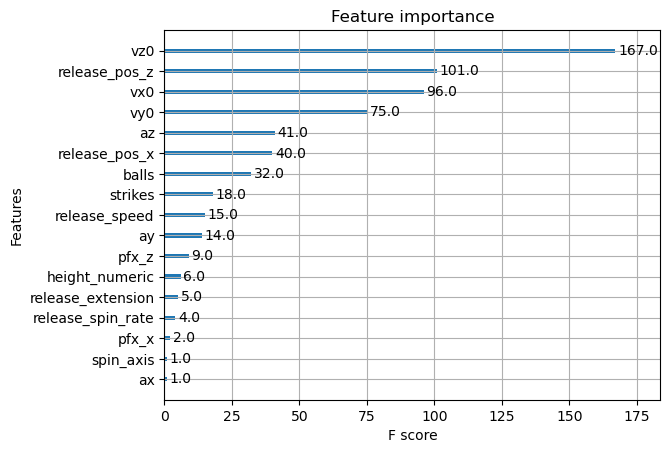

In [ ]:
xgb.plot_importance(model)
plt.show()

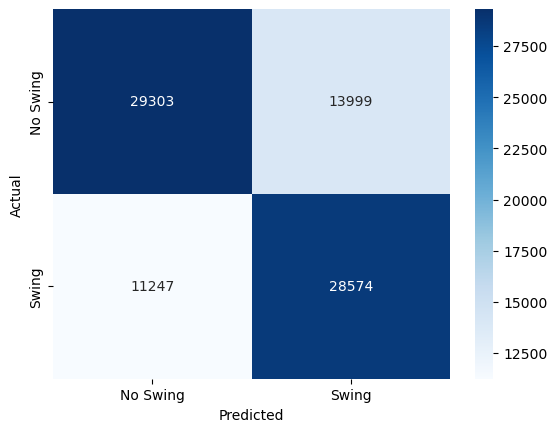

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 16:07:18,547] A new study created in memory with name: no-name-8f480df8-a582-4f18-9959-e078d3ff8fc9


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66247
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.62989
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.61904
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61228
[11]	eval-logloss:0.60947
[12]	eval-logloss:0.60701
[13]	eval-logloss:0.60194
[14]	eval-logloss:0.60060
[15]	eval-logloss:0.59931
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59579
[18]	eval-logloss:0.59368
[19]	eval-logloss:0.58999
[20]	eval-logloss:0.58791
[21]	eval-logloss:0.58676
[22]	eval-logloss:0.58390
[23]	eval-logloss:0.58326
[24]	eval-logloss:0.58210
[25]	eval-logloss:0.58142
[26]	eval-logloss:0.57972
[27]	eval-logloss:0.57900
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57356
[31]	eval-logloss:0.57278
[32]	eval-logloss:0.57212
[33]	eval-logloss:0.57013
[34]	eval-logloss:0.56782
[35]	eval-logloss:0.56586
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56406
[38]	eval-logloss:0.56

[I 2023-11-09 16:07:21,300] Trial 0 finished with value: 0.5239274636943695 and parameters: {'max_depth': 3, 'eta': 0.211117237072398, 'subsample': 0.7057329775799255, 'colsample_bytree': 0.6228752325927557}. Best is trial 0 with value: 0.5239274636943695.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.64084
[4]	eval-logloss:0.63303
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.62215
[7]	eval-logloss:0.61777
[8]	eval-logloss:0.61427
[9]	eval-logloss:0.61070
[10]	eval-logloss:0.60789
[11]	eval-logloss:0.60444
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59885
[14]	eval-logloss:0.59567
[15]	eval-logloss:0.59147
[16]	eval-logloss:0.58883
[17]	eval-logloss:0.58723
[18]	eval-logloss:0.58325
[19]	eval-logloss:0.58184
[20]	eval-logloss:0.58073
[21]	eval-logloss:0.57841
[22]	eval-logloss:0.57468
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57063
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56675
[28]	eval-logloss:0.56268
[29]	eval-logloss:0.56097
[30]	eval-logloss:0.56013
[31]	eval-logloss:0.55702
[32]	eval-logloss:0.55431
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55093
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54917
[37]	eval-logloss:0.54840
[38]	eval-logloss:0.54

[I 2023-11-09 16:07:24,241] Trial 1 finished with value: 0.5026730310681382 and parameters: {'max_depth': 4, 'eta': 0.16038711480246617, 'subsample': 0.6269406083653205, 'colsample_bytree': 0.9956086113468621}. Best is trial 0 with value: 0.5239274636943695.


[0]	eval-logloss:0.65865
[1]	eval-logloss:0.63461
[2]	eval-logloss:0.61460
[3]	eval-logloss:0.59817
[4]	eval-logloss:0.58690
[5]	eval-logloss:0.57822
[6]	eval-logloss:0.56903
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.55692
[9]	eval-logloss:0.55067
[10]	eval-logloss:0.54588
[11]	eval-logloss:0.54189
[12]	eval-logloss:0.53921
[13]	eval-logloss:0.53063
[14]	eval-logloss:0.52548
[15]	eval-logloss:0.52139
[16]	eval-logloss:0.51809
[17]	eval-logloss:0.51465
[18]	eval-logloss:0.50959
[19]	eval-logloss:0.50695
[20]	eval-logloss:0.50539
[21]	eval-logloss:0.50471
[22]	eval-logloss:0.50283
[23]	eval-logloss:0.50035
[24]	eval-logloss:0.49926
[25]	eval-logloss:0.49907
[26]	eval-logloss:0.49855
[27]	eval-logloss:0.49760
[28]	eval-logloss:0.49377
[29]	eval-logloss:0.49100
[30]	eval-logloss:0.48802
[31]	eval-logloss:0.48755
[32]	eval-logloss:0.48706
[33]	eval-logloss:0.48287
[34]	eval-logloss:0.48196
[35]	eval-logloss:0.48086
[36]	eval-logloss:0.47777
[37]	eval-logloss:0.47700
[38]	eval-logloss:0.47

[I 2023-11-09 16:07:29,217] Trial 2 finished with value: 0.4542806304123733 and parameters: {'max_depth': 9, 'eta': 0.17999046864774593, 'subsample': 0.8499123761011489, 'colsample_bytree': 0.7457179826853348}. Best is trial 0 with value: 0.5239274636943695.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65486
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.63619
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.62148
[7]	eval-logloss:0.61598
[8]	eval-logloss:0.61109
[9]	eval-logloss:0.60568
[10]	eval-logloss:0.60162
[11]	eval-logloss:0.59804
[12]	eval-logloss:0.59477
[13]	eval-logloss:0.59079
[14]	eval-logloss:0.58736
[15]	eval-logloss:0.58459
[16]	eval-logloss:0.58202
[17]	eval-logloss:0.57887
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57429
[20]	eval-logloss:0.57167
[21]	eval-logloss:0.56888
[22]	eval-logloss:0.56674
[23]	eval-logloss:0.56379
[24]	eval-logloss:0.56244
[25]	eval-logloss:0.55916
[26]	eval-logloss:0.55796
[27]	eval-logloss:0.55711
[28]	eval-logloss:0.55491
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55018
[31]	eval-logloss:0.54897
[32]	eval-logloss:0.54743
[33]	eval-logloss:0.54609
[34]	eval-logloss:0.54401
[35]	eval-logloss:0.54218
[36]	eval-logloss:0.54092
[37]	eval-logloss:0.53956
[38]	eval-logloss:0.53

[I 2023-11-09 16:07:32,688] Trial 3 finished with value: 0.48947397102181683 and parameters: {'max_depth': 6, 'eta': 0.09779054457932312, 'subsample': 0.8639094523266078, 'colsample_bytree': 0.8744772267801892}. Best is trial 0 with value: 0.5239274636943695.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63194
[4]	eval-logloss:0.62500
[5]	eval-logloss:0.61786
[6]	eval-logloss:0.61147
[7]	eval-logloss:0.60986
[8]	eval-logloss:0.60497
[9]	eval-logloss:0.60015
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59327
[12]	eval-logloss:0.59115
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58234
[15]	eval-logloss:0.58109
[16]	eval-logloss:0.57899
[17]	eval-logloss:0.57441
[18]	eval-logloss:0.57209
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.56936
[21]	eval-logloss:0.56843
[22]	eval-logloss:0.56640
[23]	eval-logloss:0.56359
[24]	eval-logloss:0.56198
[25]	eval-logloss:0.56162
[26]	eval-logloss:0.56084
[27]	eval-logloss:0.56015
[28]	eval-logloss:0.55571
[29]	eval-logloss:0.55442
[30]	eval-logloss:0.55096
[31]	eval-logloss:0.55027
[32]	eval-logloss:0.54923
[33]	eval-logloss:0.54767
[34]	eval-logloss:0.54508
[35]	eval-logloss:0.54420
[36]	eval-logloss:0.54400
[37]	eval-logloss:0.54035
[38]	eval-logloss:0.54

[I 2023-11-09 16:07:35,421] Trial 4 finished with value: 0.5016043596056616 and parameters: {'max_depth': 4, 'eta': 0.21670696233001407, 'subsample': 0.7724000988150195, 'colsample_bytree': 0.6354513434532165}. Best is trial 0 with value: 0.5239274636943695.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66522
[4]	eval-logloss:0.66017
[5]	eval-logloss:0.65562
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63691
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.63038
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62663
[17]	eval-logloss:0.62508
[18]	eval-logloss:0.62198
[19]	eval-logloss:0.62040
[20]	eval-logloss:0.61894
[21]	eval-logloss:0.61747
[22]	eval-logloss:0.61611
[23]	eval-logloss:0.61519
[24]	eval-logloss:0.61367
[25]	eval-logloss:0.61254
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60858
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60328
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60126
[35]	eval-logloss:0.59901
[36]	eval-logloss:0.59819
[37]	eval-logloss:0.59753
[38]	eval-logloss:0.59

[I 2023-11-09 16:07:37,989] Trial 5 finished with value: 0.555736249383729 and parameters: {'max_depth': 3, 'eta': 0.09587746153557089, 'subsample': 0.7217497200546619, 'colsample_bytree': 0.961135053605946}. Best is trial 5 with value: 0.555736249383729.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.64683
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.62902
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61617
[8]	eval-logloss:0.61247
[9]	eval-logloss:0.60629
[10]	eval-logloss:0.60417
[11]	eval-logloss:0.59832
[12]	eval-logloss:0.59631
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.58894
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58511
[17]	eval-logloss:0.58304
[18]	eval-logloss:0.58127
[19]	eval-logloss:0.57745
[20]	eval-logloss:0.57615
[21]	eval-logloss:0.57533
[22]	eval-logloss:0.57317
[23]	eval-logloss:0.57202
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.57005
[26]	eval-logloss:0.56797
[27]	eval-logloss:0.56719
[28]	eval-logloss:0.56672
[29]	eval-logloss:0.56454
[30]	eval-logloss:0.56238
[31]	eval-logloss:0.56190
[32]	eval-logloss:0.56084
[33]	eval-logloss:0.55658
[34]	eval-logloss:0.55564
[35]	eval-logloss:0.55482
[36]	eval-logloss:0.55460
[37]	eval-logloss:0.55340
[38]	eval-logloss:0.55

[I 2023-11-09 16:07:40,519] Trial 6 finished with value: 0.5137107215132537 and parameters: {'max_depth': 3, 'eta': 0.25576011069123317, 'subsample': 0.7611027341645478, 'colsample_bytree': 0.7538239774776601}. Best is trial 5 with value: 0.555736249383729.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.61434
[3]	eval-logloss:0.60017
[4]	eval-logloss:0.59202
[5]	eval-logloss:0.58160
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.57304
[8]	eval-logloss:0.56547
[9]	eval-logloss:0.55892
[10]	eval-logloss:0.55471
[11]	eval-logloss:0.55215
[12]	eval-logloss:0.54936
[13]	eval-logloss:0.54047
[14]	eval-logloss:0.53549
[15]	eval-logloss:0.52923
[16]	eval-logloss:0.52464
[17]	eval-logloss:0.52189
[18]	eval-logloss:0.51711
[19]	eval-logloss:0.51288
[20]	eval-logloss:0.51177
[21]	eval-logloss:0.51098
[22]	eval-logloss:0.51010
[23]	eval-logloss:0.50316
[24]	eval-logloss:0.50254
[25]	eval-logloss:0.50228
[26]	eval-logloss:0.50189
[27]	eval-logloss:0.50043
[28]	eval-logloss:0.50036
[29]	eval-logloss:0.50039
[30]	eval-logloss:0.49798
[31]	eval-logloss:0.49604
[32]	eval-logloss:0.49551
[33]	eval-logloss:0.49560
[34]	eval-logloss:0.49504
[35]	eval-logloss:0.49283
[36]	eval-logloss:0.49286
[37]	eval-logloss:0.48887
[38]	eval-logloss:0.48

[I 2023-11-09 16:07:44,547] Trial 7 finished with value: 0.4633528921995418 and parameters: {'max_depth': 8, 'eta': 0.21561297820508907, 'subsample': 0.6065719375701654, 'colsample_bytree': 0.5789453740919497}. Best is trial 5 with value: 0.555736249383729.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68446
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68049
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66749
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66469
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66165
[19]	eval-logloss:0.66043
[20]	eval-logloss:0.65953
[21]	eval-logloss:0.65857
[22]	eval-logloss:0.65715
[23]	eval-logloss:0.65620
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65431
[26]	eval-logloss:0.65309
[27]	eval-logloss:0.65178
[28]	eval-logloss:0.65082
[29]	eval-logloss:0.65003
[30]	eval-logloss:0.64919
[31]	eval-logloss:0.64799
[32]	eval-logloss:0.64674
[33]	eval-logloss:0.64555
[34]	eval-logloss:0.64429
[35]	eval-logloss:0.64344
[36]	eval-logloss:0.64321
[37]	eval-logloss:0.64233
[38]	eval-logloss:0.64

[I 2023-11-09 16:07:47,704] Trial 8 finished with value: 0.6033399351049472 and parameters: {'max_depth': 5, 'eta': 0.016005083783290387, 'subsample': 0.8495346285584122, 'colsample_bytree': 0.6172782776234369}. Best is trial 8 with value: 0.6033399351049472.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62547
[4]	eval-logloss:0.61751
[5]	eval-logloss:0.60901
[6]	eval-logloss:0.60257
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.59481
[9]	eval-logloss:0.58954
[10]	eval-logloss:0.58593
[11]	eval-logloss:0.58233
[12]	eval-logloss:0.57725
[13]	eval-logloss:0.57451
[14]	eval-logloss:0.57061
[15]	eval-logloss:0.56936
[16]	eval-logloss:0.56460
[17]	eval-logloss:0.56252
[18]	eval-logloss:0.55801
[19]	eval-logloss:0.55638
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54817
[23]	eval-logloss:0.54531
[24]	eval-logloss:0.54281
[25]	eval-logloss:0.54019
[26]	eval-logloss:0.53932
[27]	eval-logloss:0.53823
[28]	eval-logloss:0.53632
[29]	eval-logloss:0.53512
[30]	eval-logloss:0.53446
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.53137
[33]	eval-logloss:0.52851
[34]	eval-logloss:0.52489
[35]	eval-logloss:0.52296
[36]	eval-logloss:0.52060
[37]	eval-logloss:0.51921
[38]	eval-logloss:0.51

[I 2023-11-09 16:07:50,700] Trial 9 finished with value: 0.4776794111750982 and parameters: {'max_depth': 5, 'eta': 0.18816592405903487, 'subsample': 0.8320359127713575, 'colsample_bytree': 0.9903397752750773}. Best is trial 8 with value: 0.6033399351049472.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68421
[7]	eval-logloss:0.68419
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68082
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67803
[13]	eval-logloss:0.67775
[14]	eval-logloss:0.67632
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67376
[17]	eval-logloss:0.67220
[18]	eval-logloss:0.67097
[19]	eval-logloss:0.66985
[20]	eval-logloss:0.66904
[21]	eval-logloss:0.66843
[22]	eval-logloss:0.66723
[23]	eval-logloss:0.66632
[24]	eval-logloss:0.66522
[25]	eval-logloss:0.66465
[26]	eval-logloss:0.66379
[27]	eval-logloss:0.66254
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66140
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.65909
[33]	eval-logloss:0.65870
[34]	eval-logloss:0.65748
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65634
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:54,143] Trial 10 finished with value: 0.618933577782796 and parameters: {'max_depth': 6, 'eta': 0.01141218500991345, 'subsample': 0.8092496196512151, 'colsample_bytree': 0.5063514798823043}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68329
[6]	eval-logloss:0.68157
[7]	eval-logloss:0.68153
[8]	eval-logloss:0.68035
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.67745
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67365
[14]	eval-logloss:0.67182
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66846
[17]	eval-logloss:0.66661
[18]	eval-logloss:0.66507
[19]	eval-logloss:0.66362
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66196
[22]	eval-logloss:0.66051
[23]	eval-logloss:0.65930
[24]	eval-logloss:0.65799
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65478
[28]	eval-logloss:0.65472
[29]	eval-logloss:0.65446
[30]	eval-logloss:0.65338
[31]	eval-logloss:0.65187
[32]	eval-logloss:0.65061
[33]	eval-logloss:0.65017
[34]	eval-logloss:0.64867
[35]	eval-logloss:0.64740
[36]	eval-logloss:0.64716
[37]	eval-logloss:0.64629
[38]	eval-logloss:0.64

[I 2023-11-09 16:07:58,614] Trial 11 finished with value: 0.6032648906512824 and parameters: {'max_depth': 7, 'eta': 0.013642716811340577, 'subsample': 0.897106049542211, 'colsample_bytree': 0.5098093049331153}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67733
[5]	eval-logloss:0.67334
[6]	eval-logloss:0.66994
[7]	eval-logloss:0.66987
[8]	eval-logloss:0.66762
[9]	eval-logloss:0.66598
[10]	eval-logloss:0.66206
[11]	eval-logloss:0.65917
[12]	eval-logloss:0.65603
[13]	eval-logloss:0.65547
[14]	eval-logloss:0.65242
[15]	eval-logloss:0.65014
[16]	eval-logloss:0.64714
[17]	eval-logloss:0.64410
[18]	eval-logloss:0.64145
[19]	eval-logloss:0.63932
[20]	eval-logloss:0.63776
[21]	eval-logloss:0.63675
[22]	eval-logloss:0.63460
[23]	eval-logloss:0.63261
[24]	eval-logloss:0.63068
[25]	eval-logloss:0.62983
[26]	eval-logloss:0.62830
[27]	eval-logloss:0.62608
[28]	eval-logloss:0.62598
[29]	eval-logloss:0.62569
[30]	eval-logloss:0.62402
[31]	eval-logloss:0.62204
[32]	eval-logloss:0.62040
[33]	eval-logloss:0.61993
[34]	eval-logloss:0.61802
[35]	eval-logloss:0.61649
[36]	eval-logloss:0.61624
[37]	eval-logloss:0.61519
[38]	eval-logloss:0.61

[I 2023-11-09 16:08:02,302] Trial 12 finished with value: 0.5669255363936524 and parameters: {'max_depth': 6, 'eta': 0.03167585014103221, 'subsample': 0.8073616868503397, 'colsample_bytree': 0.5039540889284229}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68229
[2]	eval-logloss:0.67755
[3]	eval-logloss:0.67325
[4]	eval-logloss:0.66997
[5]	eval-logloss:0.66522
[6]	eval-logloss:0.66098
[7]	eval-logloss:0.65939
[8]	eval-logloss:0.65535
[9]	eval-logloss:0.65144
[10]	eval-logloss:0.64758
[11]	eval-logloss:0.64456
[12]	eval-logloss:0.64142
[13]	eval-logloss:0.63883
[14]	eval-logloss:0.63562
[15]	eval-logloss:0.63370
[16]	eval-logloss:0.63095
[17]	eval-logloss:0.62812
[18]	eval-logloss:0.62548
[19]	eval-logloss:0.62326
[20]	eval-logloss:0.62189
[21]	eval-logloss:0.62051
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61687
[24]	eval-logloss:0.61514
[25]	eval-logloss:0.61435
[26]	eval-logloss:0.61298
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.61033
[30]	eval-logloss:0.60881
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60578
[33]	eval-logloss:0.60542
[34]	eval-logloss:0.60337
[35]	eval-logloss:0.60238
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.59

[I 2023-11-09 16:08:05,535] Trial 13 finished with value: 0.5569602231139483 and parameters: {'max_depth': 5, 'eta': 0.04639088270619274, 'subsample': 0.8081714169041844, 'colsample_bytree': 0.5746359617090122}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67353
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.65758
[4]	eval-logloss:0.65236
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63618
[8]	eval-logloss:0.63015
[9]	eval-logloss:0.62414
[10]	eval-logloss:0.61800
[11]	eval-logloss:0.61431
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60610
[14]	eval-logloss:0.60146
[15]	eval-logloss:0.59797
[16]	eval-logloss:0.59460
[17]	eval-logloss:0.59146
[18]	eval-logloss:0.58758
[19]	eval-logloss:0.58449
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.58137
[22]	eval-logloss:0.57829
[23]	eval-logloss:0.57485
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57166
[26]	eval-logloss:0.57005
[27]	eval-logloss:0.56768
[28]	eval-logloss:0.56469
[29]	eval-logloss:0.56367
[30]	eval-logloss:0.56120
[31]	eval-logloss:0.55891
[32]	eval-logloss:0.55742
[33]	eval-logloss:0.55557
[34]	eval-logloss:0.55414
[35]	eval-logloss:0.55268
[36]	eval-logloss:0.55071
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-09 16:08:09,853] Trial 14 finished with value: 0.5011357900796632 and parameters: {'max_depth': 7, 'eta': 0.07031242200449847, 'subsample': 0.8915740830836107, 'colsample_bytree': 0.6777486821190234}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68160
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68037
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67724
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67334
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66530
[19]	eval-logloss:0.66399
[20]	eval-logloss:0.66303
[21]	eval-logloss:0.66225
[22]	eval-logloss:0.66080
[23]	eval-logloss:0.65980
[24]	eval-logloss:0.65846
[25]	eval-logloss:0.65775
[26]	eval-logloss:0.65671
[27]	eval-logloss:0.65526
[28]	eval-logloss:0.65521
[29]	eval-logloss:0.65494
[30]	eval-logloss:0.65406
[31]	eval-logloss:0.65269
[32]	eval-logloss:0.65143
[33]	eval-logloss:0.65097
[34]	eval-logloss:0.64953
[35]	eval-logloss:0.64852
[36]	eval-logloss:0.64829
[37]	eval-logloss:0.64747
[38]	eval-logloss:0.64

[I 2023-11-09 16:08:13,339] Trial 15 finished with value: 0.6090850531434582 and parameters: {'max_depth': 5, 'eta': 0.016719777353378717, 'subsample': 0.8091927724859089, 'colsample_bytree': 0.5034456304591344}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67062
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.62548
[6]	eval-logloss:0.61748
[7]	eval-logloss:0.61724
[8]	eval-logloss:0.61256
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60236
[11]	eval-logloss:0.59764
[12]	eval-logloss:0.59270
[13]	eval-logloss:0.59217
[14]	eval-logloss:0.58625
[15]	eval-logloss:0.58165
[16]	eval-logloss:0.57698
[17]	eval-logloss:0.57395
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56387
[21]	eval-logloss:0.56327
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55479
[25]	eval-logloss:0.55440
[26]	eval-logloss:0.55297
[27]	eval-logloss:0.55054
[28]	eval-logloss:0.55032
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54473
[32]	eval-logloss:0.54377
[33]	eval-logloss:0.54361
[34]	eval-logloss:0.54183
[35]	eval-logloss:0.53872
[36]	eval-logloss:0.53860
[37]	eval-logloss:0.53728
[38]	eval-logloss:0.53

[I 2023-11-09 16:08:17,276] Trial 16 finished with value: 0.49172544012445263 and parameters: {'max_depth': 7, 'eta': 0.12263448840390488, 'subsample': 0.8009043543154053, 'colsample_bytree': 0.5052893215713732}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.67627
[3]	eval-logloss:0.67039
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.65954
[6]	eval-logloss:0.65435
[7]	eval-logloss:0.65423
[8]	eval-logloss:0.65093
[9]	eval-logloss:0.64867
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.63905
[12]	eval-logloss:0.63479
[13]	eval-logloss:0.63415
[14]	eval-logloss:0.62973
[15]	eval-logloss:0.62676
[16]	eval-logloss:0.62302
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61256
[20]	eval-logloss:0.61082
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60744
[23]	eval-logloss:0.60466
[24]	eval-logloss:0.60257
[25]	eval-logloss:0.60182
[26]	eval-logloss:0.60014
[27]	eval-logloss:0.59761
[28]	eval-logloss:0.59748
[29]	eval-logloss:0.59726
[30]	eval-logloss:0.59489
[31]	eval-logloss:0.59261
[32]	eval-logloss:0.59095
[33]	eval-logloss:0.59061
[34]	eval-logloss:0.58844
[35]	eval-logloss:0.58592
[36]	eval-logloss:0.58575
[37]	eval-logloss:0.58458
[38]	eval-logloss:0.58

[I 2023-11-09 16:08:21,130] Trial 17 finished with value: 0.5379431773383084 and parameters: {'max_depth': 6, 'eta': 0.0570562316376136, 'subsample': 0.7798575807615087, 'colsample_bytree': 0.5529579264744597}. Best is trial 10 with value: 0.618933577782796.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68375
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68270
[9]	eval-logloss:0.68178
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67677
[14]	eval-logloss:0.67536
[15]	eval-logloss:0.67428
[16]	eval-logloss:0.67290
[17]	eval-logloss:0.67142
[18]	eval-logloss:0.67036
[19]	eval-logloss:0.66928
[20]	eval-logloss:0.66844
[21]	eval-logloss:0.66770
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66573
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66392
[26]	eval-logloss:0.66303
[27]	eval-logloss:0.66188
[28]	eval-logloss:0.66185
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66094
[31]	eval-logloss:0.65979
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65828
[34]	eval-logloss:0.65713
[35]	eval-logloss:0.65635
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65540
[38]	eval-logloss:0.65

[I 2023-11-09 16:08:24,165] Trial 18 finished with value: 0.6232967709774929 and parameters: {'max_depth': 4, 'eta': 0.015081276546037766, 'subsample': 0.7391378403349297, 'colsample_bytree': 0.5421206422309965}. Best is trial 18 with value: 0.6232967709774929.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.67916
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66818
[4]	eval-logloss:0.66405
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65376
[7]	eval-logloss:0.65190
[8]	eval-logloss:0.64744
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.63982
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63388
[13]	eval-logloss:0.63182
[14]	eval-logloss:0.62910
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62518
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62001
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61379
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61088
[25]	eval-logloss:0.61018
[26]	eval-logloss:0.60888
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60745
[29]	eval-logloss:0.60688
[30]	eval-logloss:0.60568
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60032
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59867
[37]	eval-logloss:0.59777
[38]	eval-logloss:0.59

[I 2023-11-09 16:08:27,103] Trial 19 finished with value: 0.5571147465127066 and parameters: {'max_depth': 4, 'eta': 0.06896012092860358, 'subsample': 0.7319069899539821, 'colsample_bytree': 0.5683380536648059}. Best is trial 18 with value: 0.6232967709774929.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.67987
[2]	eval-logloss:0.67372
[3]	eval-logloss:0.66802
[4]	eval-logloss:0.66439
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.65160
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64118
[10]	eval-logloss:0.63606
[11]	eval-logloss:0.63280
[12]	eval-logloss:0.62910
[13]	eval-logloss:0.62520
[14]	eval-logloss:0.62042
[15]	eval-logloss:0.61675
[16]	eval-logloss:0.61282
[17]	eval-logloss:0.60906
[18]	eval-logloss:0.60544
[19]	eval-logloss:0.60234
[20]	eval-logloss:0.60072
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59599
[23]	eval-logloss:0.59296
[24]	eval-logloss:0.59023
[25]	eval-logloss:0.58944
[26]	eval-logloss:0.58750
[27]	eval-logloss:0.58509
[28]	eval-logloss:0.58203
[29]	eval-logloss:0.58075
[30]	eval-logloss:0.57858
[31]	eval-logloss:0.57628
[32]	eval-logloss:0.57445
[33]	eval-logloss:0.57202
[34]	eval-logloss:0.56985
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56542
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-09 16:08:33,045] Trial 20 finished with value: 0.5080090532768229 and parameters: {'max_depth': 9, 'eta': 0.03886119142456654, 'subsample': 0.6931156399068574, 'colsample_bytree': 0.707804554938418}. Best is trial 18 with value: 0.6232967709774929.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.67974
[13]	eval-logloss:0.67947
[14]	eval-logloss:0.67820
[15]	eval-logloss:0.67726
[16]	eval-logloss:0.67601
[17]	eval-logloss:0.67465
[18]	eval-logloss:0.67364
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67195
[21]	eval-logloss:0.67135
[22]	eval-logloss:0.67025
[23]	eval-logloss:0.66948
[24]	eval-logloss:0.66845
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66711
[27]	eval-logloss:0.66598
[28]	eval-logloss:0.66595
[29]	eval-logloss:0.66573
[30]	eval-logloss:0.66505
[31]	eval-logloss:0.66397
[32]	eval-logloss:0.66299
[33]	eval-logloss:0.66261
[34]	eval-logloss:0.66151
[35]	eval-logloss:0.66073
[36]	eval-logloss:0.66053
[37]	eval-logloss:0.65986
[38]	eval-logloss:0.65

[I 2023-11-09 16:08:36,425] Trial 21 finished with value: 0.6274646300573696 and parameters: {'max_depth': 5, 'eta': 0.011099040710580863, 'subsample': 0.7485931794459525, 'colsample_bytree': 0.5437088644678723}. Best is trial 21 with value: 0.6274646300573696.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68275
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.67888
[15]	eval-logloss:0.67799
[16]	eval-logloss:0.67684
[17]	eval-logloss:0.67561
[18]	eval-logloss:0.67471
[19]	eval-logloss:0.67381
[20]	eval-logloss:0.67310
[21]	eval-logloss:0.67248
[22]	eval-logloss:0.67143
[23]	eval-logloss:0.67083
[24]	eval-logloss:0.66987
[25]	eval-logloss:0.66929
[26]	eval-logloss:0.66855
[27]	eval-logloss:0.66756
[28]	eval-logloss:0.66753
[29]	eval-logloss:0.66731
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66444
[34]	eval-logloss:0.66344
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66253
[37]	eval-logloss:0.66190
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:39,372] Trial 22 finished with value: 0.6328249276247792 and parameters: {'max_depth': 4, 'eta': 0.011807830948966404, 'subsample': 0.7424266604576808, 'colsample_bytree': 0.5497646532776405}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.67975
[3]	eval-logloss:0.67608
[4]	eval-logloss:0.67302
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66517
[7]	eval-logloss:0.66363
[8]	eval-logloss:0.66002
[9]	eval-logloss:0.65670
[10]	eval-logloss:0.65337
[11]	eval-logloss:0.65066
[12]	eval-logloss:0.64791
[13]	eval-logloss:0.64605
[14]	eval-logloss:0.64349
[15]	eval-logloss:0.64178
[16]	eval-logloss:0.63965
[17]	eval-logloss:0.63730
[18]	eval-logloss:0.63523
[19]	eval-logloss:0.63340
[20]	eval-logloss:0.63215
[21]	eval-logloss:0.63091
[22]	eval-logloss:0.62916
[23]	eval-logloss:0.62805
[24]	eval-logloss:0.62651
[25]	eval-logloss:0.62570
[26]	eval-logloss:0.62438
[27]	eval-logloss:0.62304
[28]	eval-logloss:0.62295
[29]	eval-logloss:0.62225
[30]	eval-logloss:0.62082
[31]	eval-logloss:0.61951
[32]	eval-logloss:0.61823
[33]	eval-logloss:0.61786
[34]	eval-logloss:0.61602
[35]	eval-logloss:0.61496
[36]	eval-logloss:0.61472
[37]	eval-logloss:0.61367
[38]	eval-logloss:0.61

[I 2023-11-09 16:08:42,436] Trial 23 finished with value: 0.5769508930550373 and parameters: {'max_depth': 4, 'eta': 0.04496359869866568, 'subsample': 0.7444379108847826, 'colsample_bytree': 0.5577391353894956}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.67727
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.66063
[5]	eval-logloss:0.65486
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.63907
[10]	eval-logloss:0.63502
[11]	eval-logloss:0.63196
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62676
[14]	eval-logloss:0.62385
[15]	eval-logloss:0.62207
[16]	eval-logloss:0.61989
[17]	eval-logloss:0.61775
[18]	eval-logloss:0.61442
[19]	eval-logloss:0.61246
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60512
[25]	eval-logloss:0.60439
[26]	eval-logloss:0.60322
[27]	eval-logloss:0.60199
[28]	eval-logloss:0.60183
[29]	eval-logloss:0.60124
[30]	eval-logloss:0.59850
[31]	eval-logloss:0.59724
[32]	eval-logloss:0.59587
[33]	eval-logloss:0.59558
[34]	eval-logloss:0.59449
[35]	eval-logloss:0.59162
[36]	eval-logloss:0.59142
[37]	eval-logloss:0.59053
[38]	eval-logloss:0.58

[I 2023-11-09 16:08:45,089] Trial 24 finished with value: 0.5492195638405346 and parameters: {'max_depth': 4, 'eta': 0.07888597425552157, 'subsample': 0.752691517239376, 'colsample_bytree': 0.6066215114721546}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68443
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67427
[5]	eval-logloss:0.67023
[6]	eval-logloss:0.66624
[7]	eval-logloss:0.66483
[8]	eval-logloss:0.66129
[9]	eval-logloss:0.65773
[10]	eval-logloss:0.65429
[11]	eval-logloss:0.65158
[12]	eval-logloss:0.64872
[13]	eval-logloss:0.64622
[14]	eval-logloss:0.64333
[15]	eval-logloss:0.64146
[16]	eval-logloss:0.63906
[17]	eval-logloss:0.63642
[18]	eval-logloss:0.63414
[19]	eval-logloss:0.63192
[20]	eval-logloss:0.63060
[21]	eval-logloss:0.62932
[22]	eval-logloss:0.62728
[23]	eval-logloss:0.62553
[24]	eval-logloss:0.62397
[25]	eval-logloss:0.62316
[26]	eval-logloss:0.62158
[27]	eval-logloss:0.61985
[28]	eval-logloss:0.61788
[29]	eval-logloss:0.61695
[30]	eval-logloss:0.61564
[31]	eval-logloss:0.61406
[32]	eval-logloss:0.61264
[33]	eval-logloss:0.61112
[34]	eval-logloss:0.60939
[35]	eval-logloss:0.60834
[36]	eval-logloss:0.60809
[37]	eval-logloss:0.60712
[38]	eval-logloss:0.60

[I 2023-11-09 16:08:48,164] Trial 25 finished with value: 0.5631177975839002 and parameters: {'max_depth': 5, 'eta': 0.036982339396964686, 'subsample': 0.6831992219092551, 'colsample_bytree': 0.6494624314090418}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67345
[5]	eval-logloss:0.66888
[6]	eval-logloss:0.66470
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66194
[9]	eval-logloss:0.65961
[10]	eval-logloss:0.65623
[11]	eval-logloss:0.65333
[12]	eval-logloss:0.65052
[13]	eval-logloss:0.64986
[14]	eval-logloss:0.64749
[15]	eval-logloss:0.64553
[16]	eval-logloss:0.64344
[17]	eval-logloss:0.64129
[18]	eval-logloss:0.63917
[19]	eval-logloss:0.63664
[20]	eval-logloss:0.63536
[21]	eval-logloss:0.63438
[22]	eval-logloss:0.63286
[23]	eval-logloss:0.63179
[24]	eval-logloss:0.62995
[25]	eval-logloss:0.62906
[26]	eval-logloss:0.62763
[27]	eval-logloss:0.62558
[28]	eval-logloss:0.62548
[29]	eval-logloss:0.62517
[30]	eval-logloss:0.62316
[31]	eval-logloss:0.62167
[32]	eval-logloss:0.62020
[33]	eval-logloss:0.61981
[34]	eval-logloss:0.61846
[35]	eval-logloss:0.61748
[36]	eval-logloss:0.61725
[37]	eval-logloss:0.61624
[38]	eval-logloss:0.61

[I 2023-11-09 16:08:50,741] Trial 26 finished with value: 0.5825451447754624 and parameters: {'max_depth': 3, 'eta': 0.061588563040779185, 'subsample': 0.7268615010740291, 'colsample_bytree': 0.5426264622879571}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.65996
[3]	eval-logloss:0.65242
[4]	eval-logloss:0.64681
[5]	eval-logloss:0.63995
[6]	eval-logloss:0.63378
[7]	eval-logloss:0.63179
[8]	eval-logloss:0.62686
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.61851
[11]	eval-logloss:0.61571
[12]	eval-logloss:0.61255
[13]	eval-logloss:0.60999
[14]	eval-logloss:0.60631
[15]	eval-logloss:0.60467
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.59985
[18]	eval-logloss:0.59832
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59413
[21]	eval-logloss:0.59325
[22]	eval-logloss:0.59135
[23]	eval-logloss:0.58886
[24]	eval-logloss:0.58704
[25]	eval-logloss:0.58636
[26]	eval-logloss:0.58548
[27]	eval-logloss:0.58310
[28]	eval-logloss:0.58288
[29]	eval-logloss:0.58245
[30]	eval-logloss:0.57984
[31]	eval-logloss:0.57886
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57748
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57221
[36]	eval-logloss:0.57207
[37]	eval-logloss:0.57011
[38]	eval-logloss:0.56

[I 2023-11-09 16:08:53,510] Trial 27 finished with value: 0.5322862710874159 and parameters: {'max_depth': 4, 'eta': 0.12506683102032753, 'subsample': 0.7751581508284263, 'colsample_bytree': 0.5923480932649919}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67618
[5]	eval-logloss:0.67256
[6]	eval-logloss:0.66894
[7]	eval-logloss:0.66765
[8]	eval-logloss:0.66436
[9]	eval-logloss:0.66101
[10]	eval-logloss:0.65778
[11]	eval-logloss:0.65523
[12]	eval-logloss:0.65253
[13]	eval-logloss:0.65024
[14]	eval-logloss:0.64757
[15]	eval-logloss:0.64581
[16]	eval-logloss:0.64353
[17]	eval-logloss:0.64099
[18]	eval-logloss:0.63886
[19]	eval-logloss:0.63691
[20]	eval-logloss:0.63565
[21]	eval-logloss:0.63434
[22]	eval-logloss:0.63233
[23]	eval-logloss:0.63073
[24]	eval-logloss:0.62911
[25]	eval-logloss:0.62830
[26]	eval-logloss:0.62673
[27]	eval-logloss:0.62508
[28]	eval-logloss:0.62327
[29]	eval-logloss:0.62233
[30]	eval-logloss:0.62105
[31]	eval-logloss:0.61959
[32]	eval-logloss:0.61804
[33]	eval-logloss:0.61664
[34]	eval-logloss:0.61498
[35]	eval-logloss:0.61378
[36]	eval-logloss:0.61353
[37]	eval-logloss:0.61252
[38]	eval-logloss:0.61

[I 2023-11-09 16:08:56,649] Trial 28 finished with value: 0.5694313106442398 and parameters: {'max_depth': 5, 'eta': 0.03267039411279226, 'subsample': 0.7493863259170135, 'colsample_bytree': 0.656582046309952}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67799
[4]	eval-logloss:0.67488
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66785
[7]	eval-logloss:0.66622
[8]	eval-logloss:0.66328
[9]	eval-logloss:0.66056
[10]	eval-logloss:0.65798
[11]	eval-logloss:0.65578
[12]	eval-logloss:0.65359
[13]	eval-logloss:0.65187
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.64808
[16]	eval-logloss:0.64647
[17]	eval-logloss:0.64476
[18]	eval-logloss:0.64308
[19]	eval-logloss:0.64157
[20]	eval-logloss:0.64034
[21]	eval-logloss:0.63919
[22]	eval-logloss:0.63777
[23]	eval-logloss:0.63657
[24]	eval-logloss:0.63544
[25]	eval-logloss:0.63469
[26]	eval-logloss:0.63356
[27]	eval-logloss:0.63255
[28]	eval-logloss:0.63149
[29]	eval-logloss:0.63063
[30]	eval-logloss:0.62970
[31]	eval-logloss:0.62788
[32]	eval-logloss:0.62640
[33]	eval-logloss:0.62561
[34]	eval-logloss:0.62397
[35]	eval-logloss:0.62294
[36]	eval-logloss:0.62263
[37]	eval-logloss:0.62195
[38]	eval-logloss:0.62

[I 2023-11-09 16:08:59,183] Trial 29 finished with value: 0.5870130791435128 and parameters: {'max_depth': 3, 'eta': 0.05045584935937915, 'subsample': 0.7124024223130192, 'colsample_bytree': 0.6137524406807146}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68046
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67505
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67138
[9]	eval-logloss:0.66897
[10]	eval-logloss:0.66649
[11]	eval-logloss:0.66444
[12]	eval-logloss:0.66234
[13]	eval-logloss:0.66106
[14]	eval-logloss:0.65888
[15]	eval-logloss:0.65747
[16]	eval-logloss:0.65565
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65209
[19]	eval-logloss:0.65059
[20]	eval-logloss:0.64952
[21]	eval-logloss:0.64837
[22]	eval-logloss:0.64679
[23]	eval-logloss:0.64589
[24]	eval-logloss:0.64452
[25]	eval-logloss:0.64371
[26]	eval-logloss:0.64254
[27]	eval-logloss:0.64106
[28]	eval-logloss:0.64099
[29]	eval-logloss:0.64025
[30]	eval-logloss:0.63941
[31]	eval-logloss:0.63810
[32]	eval-logloss:0.63683
[33]	eval-logloss:0.63639
[34]	eval-logloss:0.63501
[35]	eval-logloss:0.63409
[36]	eval-logloss:0.63382
[37]	eval-logloss:0.63292
[38]	eval-logloss:0.63

[I 2023-11-09 16:09:01,717] Trial 30 finished with value: 0.5959533840372293 and parameters: {'max_depth': 4, 'eta': 0.027190395718781093, 'subsample': 0.7025358397241005, 'colsample_bytree': 0.5901762555847548}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68467
[6]	eval-logloss:0.68312
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68123
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67788
[12]	eval-logloss:0.67622
[13]	eval-logloss:0.67591
[14]	eval-logloss:0.67433
[15]	eval-logloss:0.67312
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.66990
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66732
[20]	eval-logloss:0.66644
[21]	eval-logloss:0.66577
[22]	eval-logloss:0.66446
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66071
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65930
[29]	eval-logloss:0.65906
[30]	eval-logloss:0.65810
[31]	eval-logloss:0.65677
[32]	eval-logloss:0.65562
[33]	eval-logloss:0.65520
[34]	eval-logloss:0.65387
[35]	eval-logloss:0.65285
[36]	eval-logloss:0.65263
[37]	eval-logloss:0.65184
[38]	eval-logloss:0.65

[I 2023-11-09 16:09:05,154] Trial 31 finished with value: 0.6132973545596474 and parameters: {'max_depth': 6, 'eta': 0.012878897492875123, 'subsample': 0.7906232987925776, 'colsample_bytree': 0.5407334939422412}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68180
[7]	eval-logloss:0.68176
[8]	eval-logloss:0.68058
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67361
[14]	eval-logloss:0.67186
[15]	eval-logloss:0.67055
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66703
[18]	eval-logloss:0.66563
[19]	eval-logloss:0.66434
[20]	eval-logloss:0.66339
[21]	eval-logloss:0.66262
[22]	eval-logloss:0.66118
[23]	eval-logloss:0.66020
[24]	eval-logloss:0.65886
[25]	eval-logloss:0.65816
[26]	eval-logloss:0.65712
[27]	eval-logloss:0.65569
[28]	eval-logloss:0.65565
[29]	eval-logloss:0.65538
[30]	eval-logloss:0.65446
[31]	eval-logloss:0.65310
[32]	eval-logloss:0.65183
[33]	eval-logloss:0.65138
[34]	eval-logloss:0.65001
[35]	eval-logloss:0.64902
[36]	eval-logloss:0.64879
[37]	eval-logloss:0.64797
[38]	eval-logloss:0.64

[I 2023-11-09 16:09:08,269] Trial 32 finished with value: 0.609560052972547 and parameters: {'max_depth': 5, 'eta': 0.01640735004640904, 'subsample': 0.7445136167360984, 'colsample_bytree': 0.534332410100957}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67710
[5]	eval-logloss:0.67301
[6]	eval-logloss:0.66953
[7]	eval-logloss:0.66945
[8]	eval-logloss:0.66718
[9]	eval-logloss:0.66551
[10]	eval-logloss:0.66169
[11]	eval-logloss:0.65868
[12]	eval-logloss:0.65544
[13]	eval-logloss:0.65489
[14]	eval-logloss:0.65169
[15]	eval-logloss:0.64935
[16]	eval-logloss:0.64641
[17]	eval-logloss:0.64330
[18]	eval-logloss:0.64060
[19]	eval-logloss:0.63818
[20]	eval-logloss:0.63680
[21]	eval-logloss:0.63579
[22]	eval-logloss:0.63363
[23]	eval-logloss:0.63161
[24]	eval-logloss:0.62973
[25]	eval-logloss:0.62888
[26]	eval-logloss:0.62730
[27]	eval-logloss:0.62512
[28]	eval-logloss:0.62503
[29]	eval-logloss:0.62474
[30]	eval-logloss:0.62303
[31]	eval-logloss:0.62102
[32]	eval-logloss:0.61931
[33]	eval-logloss:0.61884
[34]	eval-logloss:0.61693
[35]	eval-logloss:0.61492
[36]	eval-logloss:0.61468
[37]	eval-logloss:0.61364
[38]	eval-logloss:0.61

[I 2023-11-09 16:09:11,813] Trial 33 finished with value: 0.5653661510032948 and parameters: {'max_depth': 6, 'eta': 0.03235483300636807, 'subsample': 0.6667945982701042, 'colsample_bytree': 0.5298491821418871}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66574
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64858
[8]	eval-logloss:0.64344
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63418
[11]	eval-logloss:0.63069
[12]	eval-logloss:0.62706
[13]	eval-logloss:0.62310
[14]	eval-logloss:0.61891
[15]	eval-logloss:0.61622
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60625
[19]	eval-logloss:0.60357
[20]	eval-logloss:0.60194
[21]	eval-logloss:0.60050
[22]	eval-logloss:0.59841
[23]	eval-logloss:0.59624
[24]	eval-logloss:0.59445
[25]	eval-logloss:0.59376
[26]	eval-logloss:0.59223
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58964
[29]	eval-logloss:0.58907
[30]	eval-logloss:0.58715
[31]	eval-logloss:0.58561
[32]	eval-logloss:0.58407
[33]	eval-logloss:0.58378
[34]	eval-logloss:0.58168
[35]	eval-logloss:0.57943
[36]	eval-logloss:0.57925
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-09 16:09:15,121] Trial 34 finished with value: 0.5323142007658024 and parameters: {'max_depth': 6, 'eta': 0.05887327403664448, 'subsample': 0.7650026540300379, 'colsample_bytree': 0.5638348709570193}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68688
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68021
[13]	eval-logloss:0.67993
[14]	eval-logloss:0.67876
[15]	eval-logloss:0.67786
[16]	eval-logloss:0.67671
[17]	eval-logloss:0.67546
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67366
[20]	eval-logloss:0.67295
[21]	eval-logloss:0.67232
[22]	eval-logloss:0.67127
[23]	eval-logloss:0.67067
[24]	eval-logloss:0.66969
[25]	eval-logloss:0.66911
[26]	eval-logloss:0.66837
[27]	eval-logloss:0.66738
[28]	eval-logloss:0.66735
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66558
[32]	eval-logloss:0.66464
[33]	eval-logloss:0.66425
[34]	eval-logloss:0.66324
[35]	eval-logloss:0.66254
[36]	eval-logloss:0.66233
[37]	eval-logloss:0.66169
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:17,955] Trial 35 finished with value: 0.6326244360892598 and parameters: {'max_depth': 4, 'eta': 0.011917255229231604, 'subsample': 0.734796284790517, 'colsample_bytree': 0.5242077451768619}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66405
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65349
[6]	eval-logloss:0.64812
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.63720
[10]	eval-logloss:0.63334
[11]	eval-logloss:0.63033
[12]	eval-logloss:0.62748
[13]	eval-logloss:0.62478
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.62010
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61092
[20]	eval-logloss:0.60984
[21]	eval-logloss:0.60864
[22]	eval-logloss:0.60652
[23]	eval-logloss:0.60521
[24]	eval-logloss:0.60344
[25]	eval-logloss:0.60272
[26]	eval-logloss:0.60149
[27]	eval-logloss:0.60038
[28]	eval-logloss:0.60023
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59675
[31]	eval-logloss:0.59435
[32]	eval-logloss:0.59284
[33]	eval-logloss:0.59255
[34]	eval-logloss:0.59064
[35]	eval-logloss:0.58939
[36]	eval-logloss:0.58919
[37]	eval-logloss:0.58700
[38]	eval-logloss:0.58

[I 2023-11-09 16:09:20,728] Trial 36 finished with value: 0.5470659107657825 and parameters: {'max_depth': 4, 'eta': 0.08262253910366221, 'subsample': 0.726279983002871, 'colsample_bytree': 0.5919316746816443}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68161
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67217
[6]	eval-logloss:0.66891
[7]	eval-logloss:0.66731
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.65925
[11]	eval-logloss:0.65709
[12]	eval-logloss:0.65498
[13]	eval-logloss:0.65327
[14]	eval-logloss:0.65129
[15]	eval-logloss:0.64950
[16]	eval-logloss:0.64770
[17]	eval-logloss:0.64613
[18]	eval-logloss:0.64402
[19]	eval-logloss:0.64276
[20]	eval-logloss:0.64155
[21]	eval-logloss:0.64041
[22]	eval-logloss:0.63892
[23]	eval-logloss:0.63796
[24]	eval-logloss:0.63679
[25]	eval-logloss:0.63603
[26]	eval-logloss:0.63475
[27]	eval-logloss:0.63360
[28]	eval-logloss:0.63208
[29]	eval-logloss:0.63124
[30]	eval-logloss:0.63013
[31]	eval-logloss:0.62876
[32]	eval-logloss:0.62785
[33]	eval-logloss:0.62705
[34]	eval-logloss:0.62539
[35]	eval-logloss:0.62461
[36]	eval-logloss:0.62431
[37]	eval-logloss:0.62364
[38]	eval-logloss:0.62

[I 2023-11-09 16:09:23,173] Trial 37 finished with value: 0.5909552073134358 and parameters: {'max_depth': 3, 'eta': 0.04787575309247024, 'subsample': 0.7363532712582667, 'colsample_bytree': 0.6212926194334598}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68307
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67732
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67431
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66525
[12]	eval-logloss:0.66270
[13]	eval-logloss:0.66216
[14]	eval-logloss:0.65977
[15]	eval-logloss:0.65802
[16]	eval-logloss:0.65584
[17]	eval-logloss:0.65346
[18]	eval-logloss:0.65164
[19]	eval-logloss:0.64994
[20]	eval-logloss:0.64872
[21]	eval-logloss:0.64769
[22]	eval-logloss:0.64588
[23]	eval-logloss:0.64464
[24]	eval-logloss:0.64306
[25]	eval-logloss:0.64219
[26]	eval-logloss:0.64088
[27]	eval-logloss:0.63916
[28]	eval-logloss:0.63909
[29]	eval-logloss:0.63879
[30]	eval-logloss:0.63788
[31]	eval-logloss:0.63633
[32]	eval-logloss:0.63492
[33]	eval-logloss:0.63445
[34]	eval-logloss:0.63293
[35]	eval-logloss:0.63193
[36]	eval-logloss:0.63168
[37]	eval-logloss:0.63076
[38]	eval-logloss:0.62

[I 2023-11-09 16:09:25,971] Trial 38 finished with value: 0.5934785894154386 and parameters: {'max_depth': 4, 'eta': 0.03197208013943538, 'subsample': 0.7609259732589333, 'colsample_bytree': 0.5320767995737321}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.66215
[5]	eval-logloss:0.65683
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.65030
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63572
[13]	eval-logloss:0.63333
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62615
[17]	eval-logloss:0.62400
[18]	eval-logloss:0.62210
[19]	eval-logloss:0.62073
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61669
[23]	eval-logloss:0.61562
[24]	eval-logloss:0.61370
[25]	eval-logloss:0.61276
[26]	eval-logloss:0.61141
[27]	eval-logloss:0.61018
[28]	eval-logloss:0.61001
[29]	eval-logloss:0.60930
[30]	eval-logloss:0.60705
[31]	eval-logloss:0.60515
[32]	eval-logloss:0.60443
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.59944
[38]	eval-logloss:0.59

[I 2023-11-09 16:09:28,525] Trial 39 finished with value: 0.5614260758845215 and parameters: {'max_depth': 3, 'eta': 0.09594896179907558, 'subsample': 0.7127358596400821, 'colsample_bytree': 0.5775707981768331}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68303
[9]	eval-logloss:0.68170
[10]	eval-logloss:0.68035
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67806
[13]	eval-logloss:0.67709
[14]	eval-logloss:0.67588
[15]	eval-logloss:0.67504
[16]	eval-logloss:0.67391
[17]	eval-logloss:0.67268
[18]	eval-logloss:0.67174
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.67017
[21]	eval-logloss:0.66945
[22]	eval-logloss:0.66840
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66532
[27]	eval-logloss:0.66431
[28]	eval-logloss:0.66366
[29]	eval-logloss:0.66303
[30]	eval-logloss:0.66236
[31]	eval-logloss:0.66139
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.65949
[34]	eval-logloss:0.65852
[35]	eval-logloss:0.65783
[36]	eval-logloss:0.65764
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65

[I 2023-11-09 16:09:31,691] Trial 40 finished with value: 0.6233699578220293 and parameters: {'max_depth': 5, 'eta': 0.01025389721491856, 'subsample': 0.7821879563703095, 'colsample_bytree': 0.631110549255222}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67018
[12]	eval-logloss:0.66788
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66520
[15]	eval-logloss:0.66360
[16]	eval-logloss:0.66148
[17]	eval-logloss:0.65922
[18]	eval-logloss:0.65746
[19]	eval-logloss:0.65589
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65207
[23]	eval-logloss:0.65083
[24]	eval-logloss:0.64925
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64722
[27]	eval-logloss:0.64552
[28]	eval-logloss:0.64546
[29]	eval-logloss:0.64517
[30]	eval-logloss:0.64409
[31]	eval-logloss:0.64249
[32]	eval-logloss:0.64105
[33]	eval-logloss:0.64056
[34]	eval-logloss:0.63895
[35]	eval-logloss:0.63748
[36]	eval-logloss:0.63724
[37]	eval-logloss:0.63633
[38]	eval-logloss:0.63

[I 2023-11-09 16:09:34,850] Trial 41 finished with value: 0.5956275469447808 and parameters: {'max_depth': 5, 'eta': 0.022524441265214874, 'subsample': 0.7792673388028252, 'colsample_bytree': 0.5448697403410452}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68167
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67769
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67593
[17]	eval-logloss:0.67488
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67333
[20]	eval-logloss:0.67272
[21]	eval-logloss:0.67204
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67055
[24]	eval-logloss:0.66971
[25]	eval-logloss:0.66918
[26]	eval-logloss:0.66831
[27]	eval-logloss:0.66744
[28]	eval-logloss:0.66703
[29]	eval-logloss:0.66643
[30]	eval-logloss:0.66594
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66422
[33]	eval-logloss:0.66343
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66177
[37]	eval-logloss:0.66116
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:37,631] Trial 42 finished with value: 0.6317158036103661 and parameters: {'max_depth': 4, 'eta': 0.010362563424514632, 'subsample': 0.7589143851747193, 'colsample_bytree': 0.6317449291736359}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67247
[7]	eval-logloss:0.67133
[8]	eval-logloss:0.66842
[9]	eval-logloss:0.66544
[10]	eval-logloss:0.66255
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65591
[14]	eval-logloss:0.65339
[15]	eval-logloss:0.65183
[16]	eval-logloss:0.64970
[17]	eval-logloss:0.64736
[18]	eval-logloss:0.64534
[19]	eval-logloss:0.64352
[20]	eval-logloss:0.64234
[21]	eval-logloss:0.64114
[22]	eval-logloss:0.63924
[23]	eval-logloss:0.63781
[24]	eval-logloss:0.63629
[25]	eval-logloss:0.63549
[26]	eval-logloss:0.63398
[27]	eval-logloss:0.63237
[28]	eval-logloss:0.63077
[29]	eval-logloss:0.62984
[30]	eval-logloss:0.62867
[31]	eval-logloss:0.62723
[32]	eval-logloss:0.62570
[33]	eval-logloss:0.62425
[34]	eval-logloss:0.62271
[35]	eval-logloss:0.62153
[36]	eval-logloss:0.62127
[37]	eval-logloss:0.62025
[38]	eval-logloss:0.61

[I 2023-11-09 16:09:40,755] Trial 43 finished with value: 0.5776586645816556 and parameters: {'max_depth': 5, 'eta': 0.02736831450074824, 'subsample': 0.7578386099999467, 'colsample_bytree': 0.63232106043424}. Best is trial 22 with value: 0.6328249276247792.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68668
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68147
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67874
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67683
[16]	eval-logloss:0.67582
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67397
[19]	eval-logloss:0.67314
[20]	eval-logloss:0.67251
[21]	eval-logloss:0.67181
[22]	eval-logloss:0.67088
[23]	eval-logloss:0.67032
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66891
[26]	eval-logloss:0.66825
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66734
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66635
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66421
[34]	eval-logloss:0.66332
[35]	eval-logloss:0.66268
[36]	eval-logloss:0.66249
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:43,635] Trial 44 finished with value: 0.6330418769945475 and parameters: {'max_depth': 4, 'eta': 0.010700995765352772, 'subsample': 0.7677794997735226, 'colsample_bytree': 0.6049800828131492}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67378
[5]	eval-logloss:0.66971
[6]	eval-logloss:0.66615
[7]	eval-logloss:0.66465
[8]	eval-logloss:0.66115
[9]	eval-logloss:0.65793
[10]	eval-logloss:0.65467
[11]	eval-logloss:0.65200
[12]	eval-logloss:0.64931
[13]	eval-logloss:0.64750
[14]	eval-logloss:0.64496
[15]	eval-logloss:0.64327
[16]	eval-logloss:0.64118
[17]	eval-logloss:0.63880
[18]	eval-logloss:0.63679
[19]	eval-logloss:0.63493
[20]	eval-logloss:0.63370
[21]	eval-logloss:0.63246
[22]	eval-logloss:0.63070
[23]	eval-logloss:0.62959
[24]	eval-logloss:0.62815
[25]	eval-logloss:0.62733
[26]	eval-logloss:0.62602
[27]	eval-logloss:0.62444
[28]	eval-logloss:0.62435
[29]	eval-logloss:0.62364
[30]	eval-logloss:0.62213
[31]	eval-logloss:0.62084
[32]	eval-logloss:0.61957
[33]	eval-logloss:0.61920
[34]	eval-logloss:0.61737
[35]	eval-logloss:0.61623
[36]	eval-logloss:0.61598
[37]	eval-logloss:0.61522
[38]	eval-logloss:0.61

[I 2023-11-09 16:09:46,598] Trial 45 finished with value: 0.5762469791471319 and parameters: {'max_depth': 4, 'eta': 0.04299692870490741, 'subsample': 0.7664848559174738, 'colsample_bytree': 0.5986145765200596}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67524
[10]	eval-logloss:0.67352
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66663
[16]	eval-logloss:0.66524
[17]	eval-logloss:0.66388
[18]	eval-logloss:0.66256
[19]	eval-logloss:0.66154
[20]	eval-logloss:0.66055
[21]	eval-logloss:0.65951
[22]	eval-logloss:0.65832
[23]	eval-logloss:0.65755
[24]	eval-logloss:0.65647
[25]	eval-logloss:0.65566
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65364
[28]	eval-logloss:0.65359
[29]	eval-logloss:0.65285
[30]	eval-logloss:0.65218
[31]	eval-logloss:0.65116
[32]	eval-logloss:0.65024
[33]	eval-logloss:0.64979
[34]	eval-logloss:0.64881
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64782
[37]	eval-logloss:0.64703
[38]	eval-logloss:0.64

[I 2023-11-09 16:09:49,294] Trial 46 finished with value: 0.6167688795020695 and parameters: {'max_depth': 3, 'eta': 0.023896679029728765, 'subsample': 0.7224858080064827, 'colsample_bytree': 0.5713302988446082}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67686
[4]	eval-logloss:0.67322
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66392
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.65896
[10]	eval-logloss:0.65476
[11]	eval-logloss:0.65147
[12]	eval-logloss:0.64821
[13]	eval-logloss:0.64756
[14]	eval-logloss:0.64445
[15]	eval-logloss:0.64252
[16]	eval-logloss:0.63983
[17]	eval-logloss:0.63698
[18]	eval-logloss:0.63444
[19]	eval-logloss:0.63239
[20]	eval-logloss:0.63099
[21]	eval-logloss:0.62993
[22]	eval-logloss:0.62795
[23]	eval-logloss:0.62669
[24]	eval-logloss:0.62498
[25]	eval-logloss:0.62415
[26]	eval-logloss:0.62276
[27]	eval-logloss:0.62118
[28]	eval-logloss:0.62107
[29]	eval-logloss:0.62081
[30]	eval-logloss:0.61882
[31]	eval-logloss:0.61706
[32]	eval-logloss:0.61574
[33]	eval-logloss:0.61537
[34]	eval-logloss:0.61325
[35]	eval-logloss:0.61162
[36]	eval-logloss:0.61140
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.60

[I 2023-11-09 16:09:51,978] Trial 47 finished with value: 0.5714451492581175 and parameters: {'max_depth': 4, 'eta': 0.05328290978472779, 'subsample': 0.7532772970764906, 'colsample_bytree': 0.5253822691828172}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68155
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67613
[6]	eval-logloss:0.67342
[7]	eval-logloss:0.67203
[8]	eval-logloss:0.66954
[9]	eval-logloss:0.66717
[10]	eval-logloss:0.66495
[11]	eval-logloss:0.66294
[12]	eval-logloss:0.66098
[13]	eval-logloss:0.65964
[14]	eval-logloss:0.65781
[15]	eval-logloss:0.65622
[16]	eval-logloss:0.65462
[17]	eval-logloss:0.65294
[18]	eval-logloss:0.65111
[19]	eval-logloss:0.64986
[20]	eval-logloss:0.64869
[21]	eval-logloss:0.64749
[22]	eval-logloss:0.64616
[23]	eval-logloss:0.64526
[24]	eval-logloss:0.64403
[25]	eval-logloss:0.64316
[26]	eval-logloss:0.64201
[27]	eval-logloss:0.64087
[28]	eval-logloss:0.64079
[29]	eval-logloss:0.64002
[30]	eval-logloss:0.63900
[31]	eval-logloss:0.63799
[32]	eval-logloss:0.63703
[33]	eval-logloss:0.63662
[34]	eval-logloss:0.63547
[35]	eval-logloss:0.63466
[36]	eval-logloss:0.63439
[37]	eval-logloss:0.63347
[38]	eval-logloss:0.63

[I 2023-11-09 16:09:54,371] Trial 48 finished with value: 0.5982292088861599 and parameters: {'max_depth': 3, 'eta': 0.03745340651055617, 'subsample': 0.7917050669007896, 'colsample_bytree': 0.6076267870529084}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67509
[9]	eval-logloss:0.67302
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.66909
[12]	eval-logloss:0.66719
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66429
[15]	eval-logloss:0.66303
[16]	eval-logloss:0.66140
[17]	eval-logloss:0.65963
[18]	eval-logloss:0.65827
[19]	eval-logloss:0.65693
[20]	eval-logloss:0.65596
[21]	eval-logloss:0.65489
[22]	eval-logloss:0.65345
[23]	eval-logloss:0.65266
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65061
[26]	eval-logloss:0.64955
[27]	eval-logloss:0.64817
[28]	eval-logloss:0.64811
[29]	eval-logloss:0.64739
[30]	eval-logloss:0.64662
[31]	eval-logloss:0.64537
[32]	eval-logloss:0.64413
[33]	eval-logloss:0.64369
[34]	eval-logloss:0.64239
[35]	eval-logloss:0.64151
[36]	eval-logloss:0.64125
[37]	eval-logloss:0.64040
[38]	eval-logloss:0.63

[I 2023-11-09 16:09:57,185] Trial 49 finished with value: 0.6051989351079887 and parameters: {'max_depth': 4, 'eta': 0.02196138694756608, 'subsample': 0.739046166269399, 'colsample_bytree': 0.5649408965870159}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.67884
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.66997
[5]	eval-logloss:0.66433
[6]	eval-logloss:0.65957
[7]	eval-logloss:0.65947
[8]	eval-logloss:0.65647
[9]	eval-logloss:0.65410
[10]	eval-logloss:0.64957
[11]	eval-logloss:0.64608
[12]	eval-logloss:0.64268
[13]	eval-logloss:0.64200
[14]	eval-logloss:0.63856
[15]	eval-logloss:0.63640
[16]	eval-logloss:0.63377
[17]	eval-logloss:0.63082
[18]	eval-logloss:0.62811
[19]	eval-logloss:0.62591
[20]	eval-logloss:0.62445
[21]	eval-logloss:0.62339
[22]	eval-logloss:0.62112
[23]	eval-logloss:0.61994
[24]	eval-logloss:0.61834
[25]	eval-logloss:0.61754
[26]	eval-logloss:0.61596
[27]	eval-logloss:0.61393
[28]	eval-logloss:0.61380
[29]	eval-logloss:0.61354
[30]	eval-logloss:0.61126
[31]	eval-logloss:0.60954
[32]	eval-logloss:0.60798
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60535
[35]	eval-logloss:0.60353
[36]	eval-logloss:0.60332
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-09 16:10:00,016] Trial 50 finished with value: 0.5646739859620536 and parameters: {'max_depth': 4, 'eta': 0.0625675428964997, 'subsample': 0.7710386209095136, 'colsample_bytree': 0.5131877553660602}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68113
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67629
[14]	eval-logloss:0.67499
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67294
[17]	eval-logloss:0.67166
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66903
[21]	eval-logloss:0.66829
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66648
[24]	eval-logloss:0.66552
[25]	eval-logloss:0.66498
[26]	eval-logloss:0.66400
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66231
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66104
[31]	eval-logloss:0.66005
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65809
[34]	eval-logloss:0.65707
[35]	eval-logloss:0.65636
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65544
[38]	eval-logloss:0.65

[I 2023-11-09 16:10:03,236] Trial 51 finished with value: 0.6210847279738025 and parameters: {'max_depth': 5, 'eta': 0.0108460501354062, 'subsample': 0.8232152170094823, 'colsample_bytree': 0.6303297402257373}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68213
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67348
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67069
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66828
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66565
[19]	eval-logloss:0.66453
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66282
[22]	eval-logloss:0.66153
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.65882
[26]	eval-logloss:0.65769
[27]	eval-logloss:0.65649
[28]	eval-logloss:0.65565
[29]	eval-logloss:0.65490
[30]	eval-logloss:0.65417
[31]	eval-logloss:0.65303
[32]	eval-logloss:0.65187
[33]	eval-logloss:0.65071
[34]	eval-logloss:0.64954
[35]	eval-logloss:0.64877
[36]	eval-logloss:0.64805
[37]	eval-logloss:0.64725
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:06,404] Trial 52 finished with value: 0.6085690741854187 and parameters: {'max_depth': 5, 'eta': 0.013679432459646099, 'subsample': 0.7849270143309929, 'colsample_bytree': 0.6738010298608772}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68735
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68160
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.67914
[12]	eval-logloss:0.67790
[13]	eval-logloss:0.67714
[14]	eval-logloss:0.67589
[15]	eval-logloss:0.67499
[16]	eval-logloss:0.67383
[17]	eval-logloss:0.67262
[18]	eval-logloss:0.67169
[19]	eval-logloss:0.67077
[20]	eval-logloss:0.67010
[21]	eval-logloss:0.66937
[22]	eval-logloss:0.66835
[23]	eval-logloss:0.66767
[24]	eval-logloss:0.66671
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66544
[27]	eval-logloss:0.66442
[28]	eval-logloss:0.66439
[29]	eval-logloss:0.66387
[30]	eval-logloss:0.66322
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66124
[33]	eval-logloss:0.66089
[34]	eval-logloss:0.65988
[35]	eval-logloss:0.65916
[36]	eval-logloss:0.65896
[37]	eval-logloss:0.65825
[38]	eval-logloss:0.65

[I 2023-11-09 16:10:09,532] Trial 53 finished with value: 0.625313469359712 and parameters: {'max_depth': 5, 'eta': 0.010544158223559688, 'subsample': 0.7621057739315056, 'colsample_bytree': 0.5818097567992171}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68381
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67727
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66769
[12]	eval-logloss:0.66571
[13]	eval-logloss:0.66458
[14]	eval-logloss:0.66267
[15]	eval-logloss:0.66136
[16]	eval-logloss:0.65966
[17]	eval-logloss:0.65789
[18]	eval-logloss:0.65651
[19]	eval-logloss:0.65511
[20]	eval-logloss:0.65411
[21]	eval-logloss:0.65301
[22]	eval-logloss:0.65151
[23]	eval-logloss:0.65069
[24]	eval-logloss:0.64934
[25]	eval-logloss:0.64855
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64603
[28]	eval-logloss:0.64597
[29]	eval-logloss:0.64525
[30]	eval-logloss:0.64449
[31]	eval-logloss:0.64320
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64150
[34]	eval-logloss:0.64021
[35]	eval-logloss:0.63932
[36]	eval-logloss:0.63906
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-09 16:10:12,465] Trial 54 finished with value: 0.6020120573602352 and parameters: {'max_depth': 4, 'eta': 0.023495550739153992, 'subsample': 0.7663643401650025, 'colsample_bytree': 0.5784051748181291}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66687
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.66129
[8]	eval-logloss:0.65735
[9]	eval-logloss:0.65376
[10]	eval-logloss:0.64995
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64389
[13]	eval-logloss:0.64142
[14]	eval-logloss:0.63816
[15]	eval-logloss:0.63627
[16]	eval-logloss:0.63370
[17]	eval-logloss:0.63097
[18]	eval-logloss:0.62841
[19]	eval-logloss:0.62621
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62357
[22]	eval-logloss:0.62162
[23]	eval-logloss:0.61995
[24]	eval-logloss:0.61823
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61415
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61337
[30]	eval-logloss:0.61179
[31]	eval-logloss:0.61024
[32]	eval-logloss:0.60862
[33]	eval-logloss:0.60826
[34]	eval-logloss:0.60653
[35]	eval-logloss:0.60473
[36]	eval-logloss:0.60450
[37]	eval-logloss:0.60344
[38]	eval-logloss:0.60

[I 2023-11-09 16:10:15,567] Trial 55 finished with value: 0.5602485852364361 and parameters: {'max_depth': 5, 'eta': 0.04325608512668759, 'subsample': 0.7508074206258386, 'colsample_bytree': 0.5566257180433876}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67618
[4]	eval-logloss:0.67355
[5]	eval-logloss:0.66964
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66504
[8]	eval-logloss:0.66120
[9]	eval-logloss:0.65762
[10]	eval-logloss:0.65401
[11]	eval-logloss:0.65138
[12]	eval-logloss:0.64836
[13]	eval-logloss:0.64564
[14]	eval-logloss:0.64209
[15]	eval-logloss:0.63932
[16]	eval-logloss:0.63639
[17]	eval-logloss:0.63341
[18]	eval-logloss:0.63057
[19]	eval-logloss:0.62800
[20]	eval-logloss:0.62653
[21]	eval-logloss:0.62493
[22]	eval-logloss:0.62287
[23]	eval-logloss:0.62065
[24]	eval-logloss:0.61881
[25]	eval-logloss:0.61803
[26]	eval-logloss:0.61656
[27]	eval-logloss:0.61428
[28]	eval-logloss:0.61417
[29]	eval-logloss:0.61345
[30]	eval-logloss:0.61126
[31]	eval-logloss:0.60912
[32]	eval-logloss:0.60731
[33]	eval-logloss:0.60686
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60239
[37]	eval-logloss:0.60056
[38]	eval-logloss:0.59

[I 2023-11-09 16:10:20,651] Trial 56 finished with value: 0.5469548578501051 and parameters: {'max_depth': 8, 'eta': 0.028045163034360495, 'subsample': 0.7321157398263901, 'colsample_bytree': 0.5867637979001141}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67078
[10]	eval-logloss:0.66820
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66353
[13]	eval-logloss:0.66295
[14]	eval-logloss:0.66084
[15]	eval-logloss:0.65917
[16]	eval-logloss:0.65728
[17]	eval-logloss:0.65542
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65095
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64835
[23]	eval-logloss:0.64733
[24]	eval-logloss:0.64594
[25]	eval-logloss:0.64504
[26]	eval-logloss:0.64377
[27]	eval-logloss:0.64245
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64208
[30]	eval-logloss:0.64124
[31]	eval-logloss:0.64006
[32]	eval-logloss:0.63894
[33]	eval-logloss:0.63848
[34]	eval-logloss:0.63730
[35]	eval-logloss:0.63646
[36]	eval-logloss:0.63622
[37]	eval-logloss:0.63549
[38]	eval-logloss:0.63

[I 2023-11-09 16:10:23,347] Trial 57 finished with value: 0.6025454682945249 and parameters: {'max_depth': 3, 'eta': 0.03818418191319645, 'subsample': 0.7974533465555058, 'colsample_bytree': 0.5205931335391812}. Best is trial 44 with value: 0.6330418769945475.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.67975
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67765
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67603
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67388
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67246
[25]	eval-logloss:0.67193
[26]	eval-logloss:0.67127
[27]	eval-logloss:0.67035
[28]	eval-logloss:0.67032
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66785
[33]	eval-logloss:0.66749
[34]	eval-logloss:0.66657
[35]	eval-logloss:0.66593
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66515
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:26,280] Trial 58 finished with value: 0.6378550183298587 and parameters: {'max_depth': 4, 'eta': 0.01032798987983379, 'subsample': 0.7574475685788626, 'colsample_bytree': 0.5022755881052006}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68176
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67459
[5]	eval-logloss:0.66983
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66569
[8]	eval-logloss:0.66312
[9]	eval-logloss:0.66099
[10]	eval-logloss:0.65694
[11]	eval-logloss:0.65377
[12]	eval-logloss:0.65064
[13]	eval-logloss:0.65000
[14]	eval-logloss:0.64691
[15]	eval-logloss:0.64498
[16]	eval-logloss:0.64242
[17]	eval-logloss:0.63969
[18]	eval-logloss:0.63724
[19]	eval-logloss:0.63525
[20]	eval-logloss:0.63388
[21]	eval-logloss:0.63282
[22]	eval-logloss:0.63090
[23]	eval-logloss:0.62968
[24]	eval-logloss:0.62799
[25]	eval-logloss:0.62715
[26]	eval-logloss:0.62568
[27]	eval-logloss:0.62383
[28]	eval-logloss:0.62373
[29]	eval-logloss:0.62345
[30]	eval-logloss:0.62156
[31]	eval-logloss:0.61978
[32]	eval-logloss:0.61839
[33]	eval-logloss:0.61799
[34]	eval-logloss:0.61592
[35]	eval-logloss:0.61481
[36]	eval-logloss:0.61458
[37]	eval-logloss:0.61364
[38]	eval-logloss:0.61

[I 2023-11-09 16:10:29,155] Trial 59 finished with value: 0.5755434676604829 and parameters: {'max_depth': 4, 'eta': 0.04911520367131755, 'subsample': 0.7424085646660626, 'colsample_bytree': 0.5024755110735988}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.66950
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66701
[15]	eval-logloss:0.66553
[16]	eval-logloss:0.66365
[17]	eval-logloss:0.66165
[18]	eval-logloss:0.66016
[19]	eval-logloss:0.65872
[20]	eval-logloss:0.65765
[21]	eval-logloss:0.65673
[22]	eval-logloss:0.65513
[23]	eval-logloss:0.65411
[24]	eval-logloss:0.65266
[25]	eval-logloss:0.65185
[26]	eval-logloss:0.65072
[27]	eval-logloss:0.64918
[28]	eval-logloss:0.64913
[29]	eval-logloss:0.64884
[30]	eval-logloss:0.64803
[31]	eval-logloss:0.64660
[32]	eval-logloss:0.64529
[33]	eval-logloss:0.64482
[34]	eval-logloss:0.64336
[35]	eval-logloss:0.64241
[36]	eval-logloss:0.64216
[37]	eval-logloss:0.64137
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:32,008] Trial 60 finished with value: 0.6055240451562437 and parameters: {'max_depth': 4, 'eta': 0.023597549353452943, 'subsample': 0.7192745852234227, 'colsample_bytree': 0.5210016105724525}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67850
[15]	eval-logloss:0.67773
[16]	eval-logloss:0.67677
[17]	eval-logloss:0.67573
[18]	eval-logloss:0.67498
[19]	eval-logloss:0.67421
[20]	eval-logloss:0.67361
[21]	eval-logloss:0.67294
[22]	eval-logloss:0.67205
[23]	eval-logloss:0.67153
[24]	eval-logloss:0.67070
[25]	eval-logloss:0.67018
[26]	eval-logloss:0.66954
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66867
[29]	eval-logloss:0.66817
[30]	eval-logloss:0.66772
[31]	eval-logloss:0.66687
[32]	eval-logloss:0.66601
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66480
[35]	eval-logloss:0.66419
[36]	eval-logloss:0.66400
[37]	eval-logloss:0.66339
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:35,041] Trial 61 finished with value: 0.6353748801723443 and parameters: {'max_depth': 4, 'eta': 0.010047987723227837, 'subsample': 0.7587978355115859, 'colsample_bytree': 0.559767045017804}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67222
[12]	eval-logloss:0.67018
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66780
[15]	eval-logloss:0.66637
[16]	eval-logloss:0.66454
[17]	eval-logloss:0.66257
[18]	eval-logloss:0.66106
[19]	eval-logloss:0.65965
[20]	eval-logloss:0.65861
[21]	eval-logloss:0.65770
[22]	eval-logloss:0.65614
[23]	eval-logloss:0.65514
[24]	eval-logloss:0.65374
[25]	eval-logloss:0.65293
[26]	eval-logloss:0.65180
[27]	eval-logloss:0.65030
[28]	eval-logloss:0.65025
[29]	eval-logloss:0.64996
[30]	eval-logloss:0.64918
[31]	eval-logloss:0.64778
[32]	eval-logloss:0.64647
[33]	eval-logloss:0.64599
[34]	eval-logloss:0.64454
[35]	eval-logloss:0.64360
[36]	eval-logloss:0.64336
[37]	eval-logloss:0.64251
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:38,174] Trial 62 finished with value: 0.6069148033779215 and parameters: {'max_depth': 4, 'eta': 0.02276783255706716, 'subsample': 0.7492547986491309, 'colsample_bytree': 0.5507236876055059}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67439
[9]	eval-logloss:0.67269
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66804
[12]	eval-logloss:0.66590
[13]	eval-logloss:0.66534
[14]	eval-logloss:0.66334
[15]	eval-logloss:0.66175
[16]	eval-logloss:0.65991
[17]	eval-logloss:0.65819
[18]	eval-logloss:0.65632
[19]	eval-logloss:0.65500
[20]	eval-logloss:0.65381
[21]	eval-logloss:0.65275
[22]	eval-logloss:0.65126
[23]	eval-logloss:0.65030
[24]	eval-logloss:0.64889
[25]	eval-logloss:0.64800
[26]	eval-logloss:0.64676
[27]	eval-logloss:0.64548
[28]	eval-logloss:0.64542
[29]	eval-logloss:0.64511
[30]	eval-logloss:0.64431
[31]	eval-logloss:0.64306
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64147
[34]	eval-logloss:0.64030
[35]	eval-logloss:0.63941
[36]	eval-logloss:0.63916
[37]	eval-logloss:0.63843
[38]	eval-logloss:0.63

[I 2023-11-09 16:10:41,117] Trial 63 finished with value: 0.6059340553571106 and parameters: {'max_depth': 3, 'eta': 0.0342815680017258, 'subsample': 0.7688541888751703, 'colsample_bytree': 0.5017103190176422}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67145
[13]	eval-logloss:0.67055
[14]	eval-logloss:0.66896
[15]	eval-logloss:0.66778
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66366
[19]	eval-logloss:0.66248
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65866
[24]	eval-logloss:0.65750
[25]	eval-logloss:0.65678
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65460
[28]	eval-logloss:0.65456
[29]	eval-logloss:0.65388
[30]	eval-logloss:0.65321
[31]	eval-logloss:0.65204
[32]	eval-logloss:0.65088
[33]	eval-logloss:0.65045
[34]	eval-logloss:0.64925
[35]	eval-logloss:0.64845
[36]	eval-logloss:0.64820
[37]	eval-logloss:0.64740
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:44,103] Trial 64 finished with value: 0.6137140565977148 and parameters: {'max_depth': 4, 'eta': 0.017771713992785182, 'subsample': 0.7348074473567431, 'colsample_bytree': 0.5586350171836136}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68378
[3]	eval-logloss:0.68067
[4]	eval-logloss:0.67777
[5]	eval-logloss:0.67373
[6]	eval-logloss:0.67021
[7]	eval-logloss:0.67015
[8]	eval-logloss:0.66792
[9]	eval-logloss:0.66603
[10]	eval-logloss:0.66250
[11]	eval-logloss:0.65966
[12]	eval-logloss:0.65678
[13]	eval-logloss:0.65618
[14]	eval-logloss:0.65334
[15]	eval-logloss:0.65152
[16]	eval-logloss:0.64911
[17]	eval-logloss:0.64661
[18]	eval-logloss:0.64442
[19]	eval-logloss:0.64252
[20]	eval-logloss:0.64123
[21]	eval-logloss:0.64016
[22]	eval-logloss:0.63822
[23]	eval-logloss:0.63712
[24]	eval-logloss:0.63535
[25]	eval-logloss:0.63448
[26]	eval-logloss:0.63307
[27]	eval-logloss:0.63133
[28]	eval-logloss:0.63125
[29]	eval-logloss:0.63096
[30]	eval-logloss:0.62998
[31]	eval-logloss:0.62844
[32]	eval-logloss:0.62703
[33]	eval-logloss:0.62660
[34]	eval-logloss:0.62506
[35]	eval-logloss:0.62354
[36]	eval-logloss:0.62331
[37]	eval-logloss:0.62251
[38]	eval-logloss:0.62

[I 2023-11-09 16:10:47,203] Trial 65 finished with value: 0.5839039373875385 and parameters: {'max_depth': 4, 'eta': 0.04012226510686316, 'subsample': 0.7770696007354855, 'colsample_bytree': 0.5206241650085611}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67749
[4]	eval-logloss:0.67397
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66491
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66222
[9]	eval-logloss:0.66006
[10]	eval-logloss:0.65597
[11]	eval-logloss:0.65275
[12]	eval-logloss:0.64954
[13]	eval-logloss:0.64889
[14]	eval-logloss:0.64586
[15]	eval-logloss:0.64394
[16]	eval-logloss:0.64130
[17]	eval-logloss:0.63872
[18]	eval-logloss:0.63583
[19]	eval-logloss:0.63376
[20]	eval-logloss:0.63241
[21]	eval-logloss:0.63134
[22]	eval-logloss:0.62934
[23]	eval-logloss:0.62811
[24]	eval-logloss:0.62631
[25]	eval-logloss:0.62548
[26]	eval-logloss:0.62401
[27]	eval-logloss:0.62219
[28]	eval-logloss:0.62209
[29]	eval-logloss:0.62182
[30]	eval-logloss:0.62077
[31]	eval-logloss:0.61900
[32]	eval-logloss:0.61744
[33]	eval-logloss:0.61705
[34]	eval-logloss:0.61499
[35]	eval-logloss:0.61326
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61230
[38]	eval-logloss:0.61

[I 2023-11-09 16:10:50,252] Trial 66 finished with value: 0.5740991175707191 and parameters: {'max_depth': 4, 'eta': 0.051079728243639294, 'subsample': 0.756387482575613, 'colsample_bytree': 0.539486665695571}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68155
[11]	eval-logloss:0.68052
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67694
[16]	eval-logloss:0.67593
[17]	eval-logloss:0.67485
[18]	eval-logloss:0.67407
[19]	eval-logloss:0.67326
[20]	eval-logloss:0.67263
[21]	eval-logloss:0.67194
[22]	eval-logloss:0.67101
[23]	eval-logloss:0.67045
[24]	eval-logloss:0.66960
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66839
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66748
[29]	eval-logloss:0.66696
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66561
[32]	eval-logloss:0.66472
[33]	eval-logloss:0.66436
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66284
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66201
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:53,248] Trial 67 finished with value: 0.6333660764862191 and parameters: {'max_depth': 4, 'eta': 0.010619327744208212, 'subsample': 0.7424433991682762, 'colsample_bytree': 0.6087387478553052}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68170
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67243
[14]	eval-logloss:0.67109
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66629
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66446
[21]	eval-logloss:0.66350
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66059
[25]	eval-logloss:0.65983
[26]	eval-logloss:0.65895
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65789
[29]	eval-logloss:0.65719
[30]	eval-logloss:0.65659
[31]	eval-logloss:0.65562
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65423
[34]	eval-logloss:0.65330
[35]	eval-logloss:0.65257
[36]	eval-logloss:0.65232
[37]	eval-logloss:0.65156
[38]	eval-logloss:0.65

[I 2023-11-09 16:10:55,983] Trial 68 finished with value: 0.6222133272652789 and parameters: {'max_depth': 3, 'eta': 0.020272424602236546, 'subsample': 0.7292226506332123, 'colsample_bytree': 0.6048960041621076}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67653
[6]	eval-logloss:0.67367
[7]	eval-logloss:0.67249
[8]	eval-logloss:0.66976
[9]	eval-logloss:0.66708
[10]	eval-logloss:0.66452
[11]	eval-logloss:0.66241
[12]	eval-logloss:0.66022
[13]	eval-logloss:0.65843
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65484
[16]	eval-logloss:0.65296
[17]	eval-logloss:0.65106
[18]	eval-logloss:0.64923
[19]	eval-logloss:0.64773
[20]	eval-logloss:0.64662
[21]	eval-logloss:0.64546
[22]	eval-logloss:0.64378
[23]	eval-logloss:0.64284
[24]	eval-logloss:0.64145
[25]	eval-logloss:0.64063
[26]	eval-logloss:0.63921
[27]	eval-logloss:0.63777
[28]	eval-logloss:0.63675
[29]	eval-logloss:0.63587
[30]	eval-logloss:0.63499
[31]	eval-logloss:0.63366
[32]	eval-logloss:0.63236
[33]	eval-logloss:0.63123
[34]	eval-logloss:0.62993
[35]	eval-logloss:0.62900
[36]	eval-logloss:0.62873
[37]	eval-logloss:0.62773
[38]	eval-logloss:0.62

[I 2023-11-09 16:10:59,242] Trial 69 finished with value: 0.5902452989941688 and parameters: {'max_depth': 4, 'eta': 0.0292408030389633, 'subsample': 0.743026253072185, 'colsample_bytree': 0.648176338639434}. Best is trial 58 with value: 0.6378550183298587.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68477
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67857
[18]	eval-logloss:0.67792
[19]	eval-logloss:0.67734
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67539
[23]	eval-logloss:0.67499
[24]	eval-logloss:0.67427
[25]	eval-logloss:0.67374
[26]	eval-logloss:0.67317
[27]	eval-logloss:0.67248
[28]	eval-logloss:0.67246
[29]	eval-logloss:0.67196
[30]	eval-logloss:0.67156
[31]	eval-logloss:0.67087
[32]	eval-logloss:0.67018
[33]	eval-logloss:0.66983
[34]	eval-logloss:0.66916
[35]	eval-logloss:0.66865
[36]	eval-logloss:0.66846
[37]	eval-logloss:0.66791
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:02,815] Trial 70 finished with value: 0.6438396380814969 and parameters: {'max_depth': 3, 'eta': 0.010286847465927994, 'subsample': 0.7547644393289665, 'colsample_bytree': 0.6078041031064011}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68539
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68111
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67797
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67508
[12]	eval-logloss:0.67370
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67135
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66664
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66277
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.66032
[26]	eval-logloss:0.65930
[27]	eval-logloss:0.65832
[28]	eval-logloss:0.65780
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65639
[31]	eval-logloss:0.65547
[32]	eval-logloss:0.65457
[33]	eval-logloss:0.65372
[34]	eval-logloss:0.65284
[35]	eval-logloss:0.65213
[36]	eval-logloss:0.65187
[37]	eval-logloss:0.65112
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:05,905] Trial 71 finished with value: 0.6214358497389808 and parameters: {'max_depth': 3, 'eta': 0.01974578373300872, 'subsample': 0.7591883507524476, 'colsample_bytree': 0.6179922618335904}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67581
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66805
[11]	eval-logloss:0.66617
[12]	eval-logloss:0.66434
[13]	eval-logloss:0.66314
[14]	eval-logloss:0.66143
[15]	eval-logloss:0.65993
[16]	eval-logloss:0.65838
[17]	eval-logloss:0.65677
[18]	eval-logloss:0.65509
[19]	eval-logloss:0.65391
[20]	eval-logloss:0.65280
[21]	eval-logloss:0.65164
[22]	eval-logloss:0.65035
[23]	eval-logloss:0.64948
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64746
[26]	eval-logloss:0.64631
[27]	eval-logloss:0.64516
[28]	eval-logloss:0.64509
[29]	eval-logloss:0.64432
[30]	eval-logloss:0.64357
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64150
[33]	eval-logloss:0.64107
[34]	eval-logloss:0.64010
[35]	eval-logloss:0.63933
[36]	eval-logloss:0.63906
[37]	eval-logloss:0.63823
[38]	eval-logloss:0.63

[I 2023-11-09 16:11:08,818] Trial 72 finished with value: 0.6051076742325439 and parameters: {'max_depth': 3, 'eta': 0.03229048237643792, 'subsample': 0.7731982352687281, 'colsample_bytree': 0.5947403604031875}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68591
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67433
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66857
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66316
[19]	eval-logloss:0.66198
[20]	eval-logloss:0.66107
[21]	eval-logloss:0.66010
[22]	eval-logloss:0.65879
[23]	eval-logloss:0.65795
[24]	eval-logloss:0.65677
[25]	eval-logloss:0.65606
[26]	eval-logloss:0.65509
[27]	eval-logloss:0.65383
[28]	eval-logloss:0.65379
[29]	eval-logloss:0.65311
[30]	eval-logloss:0.65243
[31]	eval-logloss:0.65125
[32]	eval-logloss:0.65009
[33]	eval-logloss:0.64966
[34]	eval-logloss:0.64845
[35]	eval-logloss:0.64764
[36]	eval-logloss:0.64739
[37]	eval-logloss:0.64658
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:11,880] Trial 73 finished with value: 0.6126390529616885 and parameters: {'max_depth': 4, 'eta': 0.018112718965707427, 'subsample': 0.7429848492344432, 'colsample_bytree': 0.5708443389563644}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68012
[16]	eval-logloss:0.67931
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67784
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67668
[21]	eval-logloss:0.67606
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67416
[25]	eval-logloss:0.67363
[26]	eval-logloss:0.67306
[27]	eval-logloss:0.67237
[28]	eval-logloss:0.67234
[29]	eval-logloss:0.67184
[30]	eval-logloss:0.67145
[31]	eval-logloss:0.67074
[32]	eval-logloss:0.67006
[33]	eval-logloss:0.66970
[34]	eval-logloss:0.66904
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66833
[37]	eval-logloss:0.66777
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:14,621] Trial 74 finished with value: 0.6436294410471938 and parameters: {'max_depth': 3, 'eta': 0.010357243935917552, 'subsample': 0.7552996966842506, 'colsample_bytree': 0.6087875802726842}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67377
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67167
[9]	eval-logloss:0.66979
[10]	eval-logloss:0.66709
[11]	eval-logloss:0.66465
[12]	eval-logloss:0.66241
[13]	eval-logloss:0.66181
[14]	eval-logloss:0.65959
[15]	eval-logloss:0.65788
[16]	eval-logloss:0.65597
[17]	eval-logloss:0.65404
[18]	eval-logloss:0.65204
[19]	eval-logloss:0.65068
[20]	eval-logloss:0.64943
[21]	eval-logloss:0.64835
[22]	eval-logloss:0.64686
[23]	eval-logloss:0.64581
[24]	eval-logloss:0.64435
[25]	eval-logloss:0.64347
[26]	eval-logloss:0.64215
[27]	eval-logloss:0.64088
[28]	eval-logloss:0.64081
[29]	eval-logloss:0.64051
[30]	eval-logloss:0.63945
[31]	eval-logloss:0.63829
[32]	eval-logloss:0.63720
[33]	eval-logloss:0.63674
[34]	eval-logloss:0.63571
[35]	eval-logloss:0.63485
[36]	eval-logloss:0.63461
[37]	eval-logloss:0.63388
[38]	eval-logloss:0.63

[I 2023-11-09 16:11:17,473] Trial 75 finished with value: 0.5995823157636633 and parameters: {'max_depth': 3, 'eta': 0.0401529152024807, 'subsample': 0.7338401968340864, 'colsample_bytree': 0.5503567331172154}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66796
[12]	eval-logloss:0.66620
[13]	eval-logloss:0.66508
[14]	eval-logloss:0.66344
[15]	eval-logloss:0.66200
[16]	eval-logloss:0.66050
[17]	eval-logloss:0.65901
[18]	eval-logloss:0.65748
[19]	eval-logloss:0.65634
[20]	eval-logloss:0.65527
[21]	eval-logloss:0.65414
[22]	eval-logloss:0.65286
[23]	eval-logloss:0.65193
[24]	eval-logloss:0.65078
[25]	eval-logloss:0.64993
[26]	eval-logloss:0.64882
[27]	eval-logloss:0.64770
[28]	eval-logloss:0.64764
[29]	eval-logloss:0.64688
[30]	eval-logloss:0.64612
[31]	eval-logloss:0.64506
[32]	eval-logloss:0.64407
[33]	eval-logloss:0.64364
[34]	eval-logloss:0.64273
[35]	eval-logloss:0.64195
[36]	eval-logloss:0.64168
[37]	eval-logloss:0.64086
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:20,687] Trial 76 finished with value: 0.608198707379351 and parameters: {'max_depth': 3, 'eta': 0.02949836672645952, 'subsample': 0.7513198726757769, 'colsample_bytree': 0.6079129480119763}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66698
[7]	eval-logloss:0.66692
[8]	eval-logloss:0.66437
[9]	eval-logloss:0.66213
[10]	eval-logloss:0.65889
[11]	eval-logloss:0.65608
[12]	eval-logloss:0.65343
[13]	eval-logloss:0.65277
[14]	eval-logloss:0.65032
[15]	eval-logloss:0.64842
[16]	eval-logloss:0.64638
[17]	eval-logloss:0.64426
[18]	eval-logloss:0.64174
[19]	eval-logloss:0.63982
[20]	eval-logloss:0.63853
[21]	eval-logloss:0.63741
[22]	eval-logloss:0.63592
[23]	eval-logloss:0.63490
[24]	eval-logloss:0.63307
[25]	eval-logloss:0.63219
[26]	eval-logloss:0.63070
[27]	eval-logloss:0.62943
[28]	eval-logloss:0.62933
[29]	eval-logloss:0.62903
[30]	eval-logloss:0.62714
[31]	eval-logloss:0.62555
[32]	eval-logloss:0.62406
[33]	eval-logloss:0.62365
[34]	eval-logloss:0.62243
[35]	eval-logloss:0.62122
[36]	eval-logloss:0.62098
[37]	eval-logloss:0.62029
[38]	eval-logloss:0.61

[I 2023-11-09 16:11:23,809] Trial 77 finished with value: 0.5860909143851976 and parameters: {'max_depth': 3, 'eta': 0.05630249085887945, 'subsample': 0.7179324738168904, 'colsample_bytree': 0.5285728758721312}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68352
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68175
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.67972
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67678
[20]	eval-logloss:0.67619
[21]	eval-logloss:0.67555
[22]	eval-logloss:0.67477
[23]	eval-logloss:0.67435
[24]	eval-logloss:0.67361
[25]	eval-logloss:0.67306
[26]	eval-logloss:0.67249
[27]	eval-logloss:0.67177
[28]	eval-logloss:0.67175
[29]	eval-logloss:0.67123
[30]	eval-logloss:0.67084
[31]	eval-logloss:0.67012
[32]	eval-logloss:0.66940
[33]	eval-logloss:0.66905
[34]	eval-logloss:0.66837
[35]	eval-logloss:0.66784
[36]	eval-logloss:0.66765
[37]	eval-logloss:0.66708
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:27,003] Trial 78 finished with value: 0.6426351506986548 and parameters: {'max_depth': 3, 'eta': 0.010720158766752095, 'subsample': 0.7870758171029346, 'colsample_bytree': 0.5645028666553352}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68413
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67729
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67257
[15]	eval-logloss:0.67148
[16]	eval-logloss:0.67028
[17]	eval-logloss:0.66907
[18]	eval-logloss:0.66802
[19]	eval-logloss:0.66710
[20]	eval-logloss:0.66625
[21]	eval-logloss:0.66533
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66359
[24]	eval-logloss:0.66259
[25]	eval-logloss:0.66185
[26]	eval-logloss:0.66101
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65930
[30]	eval-logloss:0.65871
[31]	eval-logloss:0.65776
[32]	eval-logloss:0.65686
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65552
[35]	eval-logloss:0.65482
[36]	eval-logloss:0.65457
[37]	eval-logloss:0.65383
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:30,761] Trial 79 finished with value: 0.6247374908703703 and parameters: {'max_depth': 3, 'eta': 0.01866070588668605, 'subsample': 0.7894000866728476, 'colsample_bytree': 0.5866654315526888}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68513
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67611
[5]	eval-logloss:0.67271
[6]	eval-logloss:0.66956
[7]	eval-logloss:0.66799
[8]	eval-logloss:0.66523
[9]	eval-logloss:0.66255
[10]	eval-logloss:0.66005
[11]	eval-logloss:0.65790
[12]	eval-logloss:0.65579
[13]	eval-logloss:0.65422
[14]	eval-logloss:0.65229
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.64886
[17]	eval-logloss:0.64728
[18]	eval-logloss:0.64530
[19]	eval-logloss:0.64397
[20]	eval-logloss:0.64274
[21]	eval-logloss:0.64153
[22]	eval-logloss:0.64021
[23]	eval-logloss:0.63924
[24]	eval-logloss:0.63791
[25]	eval-logloss:0.63703
[26]	eval-logloss:0.63581
[27]	eval-logloss:0.63467
[28]	eval-logloss:0.63458
[29]	eval-logloss:0.63393
[30]	eval-logloss:0.63227
[31]	eval-logloss:0.63107
[32]	eval-logloss:0.62990
[33]	eval-logloss:0.62952
[34]	eval-logloss:0.62823
[35]	eval-logloss:0.62721
[36]	eval-logloss:0.62693
[37]	eval-logloss:0.62615
[38]	eval-logloss:0.62

[I 2023-11-09 16:11:34,447] Trial 80 finished with value: 0.5914756383159928 and parameters: {'max_depth': 3, 'eta': 0.04641513800263167, 'subsample': 0.776231238799215, 'colsample_bytree': 0.5673611408452106}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68420
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67919
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67680
[20]	eval-logloss:0.67616
[21]	eval-logloss:0.67553
[22]	eval-logloss:0.67465
[23]	eval-logloss:0.67420
[24]	eval-logloss:0.67337
[25]	eval-logloss:0.67278
[26]	eval-logloss:0.67213
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67128
[29]	eval-logloss:0.67106
[30]	eval-logloss:0.67063
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66903
[33]	eval-logloss:0.66863
[34]	eval-logloss:0.66787
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66709
[37]	eval-logloss:0.66650
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:37,740] Trial 81 finished with value: 0.6416755956725667 and parameters: {'max_depth': 3, 'eta': 0.011921857957053517, 'subsample': 0.7673347139045745, 'colsample_bytree': 0.5545523146418512}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67784
[19]	eval-logloss:0.67727
[20]	eval-logloss:0.67669
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67531
[23]	eval-logloss:0.67490
[24]	eval-logloss:0.67420
[25]	eval-logloss:0.67367
[26]	eval-logloss:0.67295
[27]	eval-logloss:0.67227
[28]	eval-logloss:0.67193
[29]	eval-logloss:0.67137
[30]	eval-logloss:0.67099
[31]	eval-logloss:0.67029
[32]	eval-logloss:0.66962
[33]	eval-logloss:0.66898
[34]	eval-logloss:0.66834
[35]	eval-logloss:0.66783
[36]	eval-logloss:0.66764
[37]	eval-logloss:0.66709
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:40,864] Trial 82 finished with value: 0.6425584389075522 and parameters: {'max_depth': 3, 'eta': 0.01025150107307184, 'subsample': 0.7686878604945275, 'colsample_bytree': 0.6157105767628124}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67119
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66778
[13]	eval-logloss:0.66647
[14]	eval-logloss:0.66492
[15]	eval-logloss:0.66353
[16]	eval-logloss:0.66210
[17]	eval-logloss:0.66068
[18]	eval-logloss:0.65921
[19]	eval-logloss:0.65814
[20]	eval-logloss:0.65709
[21]	eval-logloss:0.65598
[22]	eval-logloss:0.65473
[23]	eval-logloss:0.65384
[24]	eval-logloss:0.65272
[25]	eval-logloss:0.65188
[26]	eval-logloss:0.65077
[27]	eval-logloss:0.64970
[28]	eval-logloss:0.64901
[29]	eval-logloss:0.64817
[30]	eval-logloss:0.64741
[31]	eval-logloss:0.64642
[32]	eval-logloss:0.64544
[33]	eval-logloss:0.64457
[34]	eval-logloss:0.64372
[35]	eval-logloss:0.64294
[36]	eval-logloss:0.64266
[37]	eval-logloss:0.64186
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:44,598] Trial 83 finished with value: 0.6096157778348525 and parameters: {'max_depth': 3, 'eta': 0.02736048976887262, 'subsample': 0.7839224677605046, 'colsample_bytree': 0.6140385312599538}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67699
[6]	eval-logloss:0.67440
[7]	eval-logloss:0.67306
[8]	eval-logloss:0.67069
[9]	eval-logloss:0.66839
[10]	eval-logloss:0.66622
[11]	eval-logloss:0.66426
[12]	eval-logloss:0.66236
[13]	eval-logloss:0.66107
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65452
[18]	eval-logloss:0.65275
[19]	eval-logloss:0.65154
[20]	eval-logloss:0.65039
[21]	eval-logloss:0.64921
[22]	eval-logloss:0.64788
[23]	eval-logloss:0.64693
[24]	eval-logloss:0.64577
[25]	eval-logloss:0.64491
[26]	eval-logloss:0.64368
[27]	eval-logloss:0.64252
[28]	eval-logloss:0.64246
[29]	eval-logloss:0.64168
[30]	eval-logloss:0.64084
[31]	eval-logloss:0.63983
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63840
[34]	eval-logloss:0.63743
[35]	eval-logloss:0.63665
[36]	eval-logloss:0.63637
[37]	eval-logloss:0.63550
[38]	eval-logloss:0.63

[I 2023-11-09 16:11:48,505] Trial 84 finished with value: 0.6007764335820768 and parameters: {'max_depth': 3, 'eta': 0.0352726453386654, 'subsample': 0.7646771069169711, 'colsample_bytree': 0.5993255921994383}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67917
[11]	eval-logloss:0.67796
[12]	eval-logloss:0.67675
[13]	eval-logloss:0.67607
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67392
[16]	eval-logloss:0.67282
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67078
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66834
[22]	eval-logloss:0.66732
[23]	eval-logloss:0.66674
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66512
[26]	eval-logloss:0.66435
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66338
[29]	eval-logloss:0.66274
[30]	eval-logloss:0.66219
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.65920
[35]	eval-logloss:0.65853
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65760
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:51,985] Trial 85 finished with value: 0.6294089551700529 and parameters: {'max_depth': 3, 'eta': 0.01616005186334138, 'subsample': 0.7718378213171461, 'colsample_bytree': 0.5785807705724019}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68715
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68176
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67695
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66500
[17]	eval-logloss:0.66365
[18]	eval-logloss:0.66236
[19]	eval-logloss:0.66136
[20]	eval-logloss:0.66036
[21]	eval-logloss:0.65932
[22]	eval-logloss:0.65811
[23]	eval-logloss:0.65730
[24]	eval-logloss:0.65621
[25]	eval-logloss:0.65540
[26]	eval-logloss:0.65433
[27]	eval-logloss:0.65328
[28]	eval-logloss:0.65268
[29]	eval-logloss:0.65184
[30]	eval-logloss:0.65112
[31]	eval-logloss:0.65011
[32]	eval-logloss:0.64918
[33]	eval-logloss:0.64831
[34]	eval-logloss:0.64750
[35]	eval-logloss:0.64675
[36]	eval-logloss:0.64648
[37]	eval-logloss:0.64570
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:56,495] Trial 86 finished with value: 0.6147313473322784 and parameters: {'max_depth': 3, 'eta': 0.024024331583995168, 'subsample': 0.795371341685514, 'colsample_bytree': 0.6199926549171194}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68582
[5]	eval-logloss:0.68415
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68022
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67730
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67461
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67256
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67028
[17]	eval-logloss:0.66907
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66713
[20]	eval-logloss:0.66627
[21]	eval-logloss:0.66536
[22]	eval-logloss:0.66427
[23]	eval-logloss:0.66361
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66005
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.65933
[30]	eval-logloss:0.65874
[31]	eval-logloss:0.65780
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65559
[35]	eval-logloss:0.65488
[36]	eval-logloss:0.65463
[37]	eval-logloss:0.65389
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:59,609] Trial 87 finished with value: 0.6250134490612403 and parameters: {'max_depth': 3, 'eta': 0.018650054087042844, 'subsample': 0.7855293248774656, 'colsample_bytree': 0.5979979454391314}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68485
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67936
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67792
[19]	eval-logloss:0.67734
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67540
[23]	eval-logloss:0.67499
[24]	eval-logloss:0.67427
[25]	eval-logloss:0.67375
[26]	eval-logloss:0.67304
[27]	eval-logloss:0.67234
[28]	eval-logloss:0.67199
[29]	eval-logloss:0.67143
[30]	eval-logloss:0.67104
[31]	eval-logloss:0.67036
[32]	eval-logloss:0.66969
[33]	eval-logloss:0.66904
[34]	eval-logloss:0.66839
[35]	eval-logloss:0.66788
[36]	eval-logloss:0.66769
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:02,726] Trial 88 finished with value: 0.6426068149796474 and parameters: {'max_depth': 3, 'eta': 0.010194980479193753, 'subsample': 0.8023931226439772, 'colsample_bytree': 0.6423602118987262}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67479
[8]	eval-logloss:0.67258
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66651
[12]	eval-logloss:0.66469
[13]	eval-logloss:0.66328
[14]	eval-logloss:0.66163
[15]	eval-logloss:0.66013
[16]	eval-logloss:0.65863
[17]	eval-logloss:0.65706
[18]	eval-logloss:0.65551
[19]	eval-logloss:0.65437
[20]	eval-logloss:0.65325
[21]	eval-logloss:0.65209
[22]	eval-logloss:0.65079
[23]	eval-logloss:0.64985
[24]	eval-logloss:0.64871
[25]	eval-logloss:0.64785
[26]	eval-logloss:0.64672
[27]	eval-logloss:0.64562
[28]	eval-logloss:0.64487
[29]	eval-logloss:0.64401
[30]	eval-logloss:0.64322
[31]	eval-logloss:0.64224
[32]	eval-logloss:0.64131
[33]	eval-logloss:0.64045
[34]	eval-logloss:0.63952
[35]	eval-logloss:0.63873
[36]	eval-logloss:0.63844
[37]	eval-logloss:0.63767
[38]	eval-logloss:0.63

[I 2023-11-09 16:12:05,834] Trial 89 finished with value: 0.6043107904495001 and parameters: {'max_depth': 3, 'eta': 0.03174630175352051, 'subsample': 0.7997489057056749, 'colsample_bytree': 0.6434336226703555}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67527
[6]	eval-logloss:0.67241
[7]	eval-logloss:0.67097
[8]	eval-logloss:0.66844
[9]	eval-logloss:0.66599
[10]	eval-logloss:0.66371
[11]	eval-logloss:0.66167
[12]	eval-logloss:0.65967
[13]	eval-logloss:0.65827
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65478
[16]	eval-logloss:0.65306
[17]	eval-logloss:0.65147
[18]	eval-logloss:0.64956
[19]	eval-logloss:0.64828
[20]	eval-logloss:0.64710
[21]	eval-logloss:0.64591
[22]	eval-logloss:0.64458
[23]	eval-logloss:0.64366
[24]	eval-logloss:0.64245
[25]	eval-logloss:0.64158
[26]	eval-logloss:0.64040
[27]	eval-logloss:0.63924
[28]	eval-logloss:0.63917
[29]	eval-logloss:0.63840
[30]	eval-logloss:0.63733
[31]	eval-logloss:0.63612
[32]	eval-logloss:0.63524
[33]	eval-logloss:0.63484
[34]	eval-logloss:0.63388
[35]	eval-logloss:0.63292
[36]	eval-logloss:0.63265
[37]	eval-logloss:0.63189
[38]	eval-logloss:0.63

[I 2023-11-09 16:12:08,645] Trial 90 finished with value: 0.5961149012895162 and parameters: {'max_depth': 3, 'eta': 0.03968471120929991, 'subsample': 0.8031511924944287, 'colsample_bytree': 0.5637309520299068}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68160
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67773
[12]	eval-logloss:0.67650
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67341
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67121
[18]	eval-logloss:0.67027
[19]	eval-logloss:0.66946
[20]	eval-logloss:0.66866
[21]	eval-logloss:0.66780
[22]	eval-logloss:0.66678
[23]	eval-logloss:0.66618
[24]	eval-logloss:0.66525
[25]	eval-logloss:0.66455
[26]	eval-logloss:0.66361
[27]	eval-logloss:0.66268
[28]	eval-logloss:0.66214
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66086
[31]	eval-logloss:0.65999
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65686
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-09 16:12:11,576] Trial 91 finished with value: 0.6272364046156634 and parameters: {'max_depth': 3, 'eta': 0.016457126034063893, 'subsample': 0.7768687930556546, 'colsample_bytree': 0.6237525652423497}. Best is trial 70 with value: 0.6438396380814969.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67829
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67580
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67469
[25]	eval-logloss:0.67418
[26]	eval-logloss:0.67362
[27]	eval-logloss:0.67294
[28]	eval-logloss:0.67292
[29]	eval-logloss:0.67242
[30]	eval-logloss:0.67204
[31]	eval-logloss:0.67135
[32]	eval-logloss:0.67068
[33]	eval-logloss:0.67033
[34]	eval-logloss:0.66968
[35]	eval-logloss:0.66917
[36]	eval-logloss:0.66898
[37]	eval-logloss:0.66844
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:14,607] Trial 92 finished with value: 0.6446859808238783 and parameters: {'max_depth': 3, 'eta': 0.010016022894177202, 'subsample': 0.7558371625493484, 'colsample_bytree': 0.5858809088435688}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68374
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68071
[15]	eval-logloss:0.68001
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67838
[18]	eval-logloss:0.67773
[19]	eval-logloss:0.67714
[20]	eval-logloss:0.67657
[21]	eval-logloss:0.67594
[22]	eval-logloss:0.67517
[23]	eval-logloss:0.67476
[24]	eval-logloss:0.67404
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67293
[27]	eval-logloss:0.67221
[28]	eval-logloss:0.67219
[29]	eval-logloss:0.67168
[30]	eval-logloss:0.67128
[31]	eval-logloss:0.67058
[32]	eval-logloss:0.66989
[33]	eval-logloss:0.66953
[34]	eval-logloss:0.66886
[35]	eval-logloss:0.66834
[36]	eval-logloss:0.66815
[37]	eval-logloss:0.66759
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:17,360] Trial 93 finished with value: 0.6433162317573532 and parameters: {'max_depth': 3, 'eta': 0.010454550291252262, 'subsample': 0.7576256534051292, 'colsample_bytree': 0.5855145029452499}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68491
[5]	eval-logloss:0.68270
[6]	eval-logloss:0.68062
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67781
[10]	eval-logloss:0.67590
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67022
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66734
[17]	eval-logloss:0.66580
[18]	eval-logloss:0.66443
[19]	eval-logloss:0.66332
[20]	eval-logloss:0.66229
[21]	eval-logloss:0.66134
[22]	eval-logloss:0.65999
[23]	eval-logloss:0.65923
[24]	eval-logloss:0.65802
[25]	eval-logloss:0.65718
[26]	eval-logloss:0.65610
[27]	eval-logloss:0.65489
[28]	eval-logloss:0.65485
[29]	eval-logloss:0.65455
[30]	eval-logloss:0.65390
[31]	eval-logloss:0.65274
[32]	eval-logloss:0.65167
[33]	eval-logloss:0.65118
[34]	eval-logloss:0.65011
[35]	eval-logloss:0.64929
[36]	eval-logloss:0.64903
[37]	eval-logloss:0.64828
[38]	eval-logloss:0.64

[I 2023-11-09 16:12:20,155] Trial 94 finished with value: 0.6171951926338677 and parameters: {'max_depth': 3, 'eta': 0.02463896325139072, 'subsample': 0.7566175021323924, 'colsample_bytree': 0.5391156432193756}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68347
[7]	eval-logloss:0.68269
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67732
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67202
[17]	eval-logloss:0.67090
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66637
[23]	eval-logloss:0.66577
[24]	eval-logloss:0.66482
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66333
[27]	eval-logloss:0.66237
[28]	eval-logloss:0.66234
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66112
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.65933
[33]	eval-logloss:0.65891
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65736
[36]	eval-logloss:0.65712
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65

[I 2023-11-09 16:12:22,952] Trial 95 finished with value: 0.6281083217535876 and parameters: {'max_depth': 3, 'eta': 0.016914714317643513, 'subsample': 0.7814146923992364, 'colsample_bytree': 0.5836530770466329}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67880
[18]	eval-logloss:0.67817
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67527
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67404
[26]	eval-logloss:0.67348
[27]	eval-logloss:0.67279
[28]	eval-logloss:0.67277
[29]	eval-logloss:0.67227
[30]	eval-logloss:0.67189
[31]	eval-logloss:0.67119
[32]	eval-logloss:0.67052
[33]	eval-logloss:0.67017
[34]	eval-logloss:0.66951
[35]	eval-logloss:0.66900
[36]	eval-logloss:0.66882
[37]	eval-logloss:0.66827
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:25,689] Trial 96 finished with value: 0.644402582687485 and parameters: {'max_depth': 3, 'eta': 0.010112106087682775, 'subsample': 0.7634593725233395, 'colsample_bytree': 0.5587083133804496}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67118
[11]	eval-logloss:0.66946
[12]	eval-logloss:0.66777
[13]	eval-logloss:0.66671
[14]	eval-logloss:0.66513
[15]	eval-logloss:0.66376
[16]	eval-logloss:0.66230
[17]	eval-logloss:0.66085
[18]	eval-logloss:0.65940
[19]	eval-logloss:0.65828
[20]	eval-logloss:0.65723
[21]	eval-logloss:0.65614
[22]	eval-logloss:0.65488
[23]	eval-logloss:0.65409
[24]	eval-logloss:0.65296
[25]	eval-logloss:0.65212
[26]	eval-logloss:0.65105
[27]	eval-logloss:0.64993
[28]	eval-logloss:0.64988
[29]	eval-logloss:0.64912
[30]	eval-logloss:0.64841
[31]	eval-logloss:0.64735
[32]	eval-logloss:0.64636
[33]	eval-logloss:0.64591
[34]	eval-logloss:0.64498
[35]	eval-logloss:0.64419
[36]	eval-logloss:0.64391
[37]	eval-logloss:0.64311
[38]	eval-logloss:0.64

[I 2023-11-09 16:12:28,673] Trial 97 finished with value: 0.6106391483239891 and parameters: {'max_depth': 3, 'eta': 0.02738755224161217, 'subsample': 0.8133593771509274, 'colsample_bytree': 0.5715613884242178}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67347
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.66882
[10]	eval-logloss:0.66667
[11]	eval-logloss:0.66473
[12]	eval-logloss:0.66283
[13]	eval-logloss:0.66157
[14]	eval-logloss:0.65982
[15]	eval-logloss:0.65827
[16]	eval-logloss:0.65670
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65339
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65105
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64855
[23]	eval-logloss:0.64771
[24]	eval-logloss:0.64654
[25]	eval-logloss:0.64568
[26]	eval-logloss:0.64450
[27]	eval-logloss:0.64334
[28]	eval-logloss:0.64328
[29]	eval-logloss:0.64251
[30]	eval-logloss:0.64153
[31]	eval-logloss:0.64053
[32]	eval-logloss:0.63954
[33]	eval-logloss:0.63912
[34]	eval-logloss:0.63814
[35]	eval-logloss:0.63734
[36]	eval-logloss:0.63707
[37]	eval-logloss:0.63626
[38]	eval-logloss:0.63

[I 2023-11-09 16:12:31,590] Trial 98 finished with value: 0.6021513788502633 and parameters: {'max_depth': 3, 'eta': 0.03449703192023214, 'subsample': 0.750335621885486, 'colsample_bytree': 0.589473732700576}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.68149
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67492
[6]	eval-logloss:0.67166
[7]	eval-logloss:0.67160
[8]	eval-logloss:0.66940
[9]	eval-logloss:0.66739
[10]	eval-logloss:0.66452
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.65945
[13]	eval-logloss:0.65883
[14]	eval-logloss:0.65660
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65286
[17]	eval-logloss:0.65091
[18]	eval-logloss:0.64883
[19]	eval-logloss:0.64740
[20]	eval-logloss:0.64612
[21]	eval-logloss:0.64504
[22]	eval-logloss:0.64349
[23]	eval-logloss:0.64238
[24]	eval-logloss:0.64094
[25]	eval-logloss:0.64004
[26]	eval-logloss:0.63865
[27]	eval-logloss:0.63737
[28]	eval-logloss:0.63729
[29]	eval-logloss:0.63699
[30]	eval-logloss:0.63611
[31]	eval-logloss:0.63498
[32]	eval-logloss:0.63375
[33]	eval-logloss:0.63332
[34]	eval-logloss:0.63158
[35]	eval-logloss:0.63068
[36]	eval-logloss:0.63045
[37]	eval-logloss:0.62969
[38]	eval-logloss:0.62

[I 2023-11-09 16:12:34,415] Trial 99 finished with value: 0.5971224079098323 and parameters: {'max_depth': 3, 'eta': 0.044731933069724214, 'subsample': 0.7900284503146006, 'colsample_bytree': 0.5532881815804394}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68309
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.68041
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67715
[10]	eval-logloss:0.67559
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67162
[14]	eval-logloss:0.67022
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66654
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66256
[22]	eval-logloss:0.66140
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65964
[25]	eval-logloss:0.65887
[26]	eval-logloss:0.65783
[27]	eval-logloss:0.65681
[28]	eval-logloss:0.65627
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65481
[31]	eval-logloss:0.65387
[32]	eval-logloss:0.65296
[33]	eval-logloss:0.65209
[34]	eval-logloss:0.65119
[35]	eval-logloss:0.65046
[36]	eval-logloss:0.65020
[37]	eval-logloss:0.64944
[38]	eval-logloss:0.64

[I 2023-11-09 16:12:37,107] Trial 100 finished with value: 0.6195721118157754 and parameters: {'max_depth': 3, 'eta': 0.020991533972858235, 'subsample': 0.7687472734713958, 'colsample_bytree': 0.6362096089671424}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68640
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.67879
[16]	eval-logloss:0.67791
[17]	eval-logloss:0.67702
[18]	eval-logloss:0.67632
[19]	eval-logloss:0.67568
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67438
[22]	eval-logloss:0.67356
[23]	eval-logloss:0.67311
[24]	eval-logloss:0.67234
[25]	eval-logloss:0.67177
[26]	eval-logloss:0.67116
[27]	eval-logloss:0.67041
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.66985
[30]	eval-logloss:0.66942
[31]	eval-logloss:0.66868
[32]	eval-logloss:0.66795
[33]	eval-logloss:0.66757
[34]	eval-logloss:0.66686
[35]	eval-logloss:0.66631
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:39,847] Trial 101 finished with value: 0.6402702042321715 and parameters: {'max_depth': 3, 'eta': 0.011540157723765928, 'subsample': 0.75474258658008, 'colsample_bytree': 0.5619242680706189}. Best is trial 92 with value: 0.6446859808238783.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67774
[20]	eval-logloss:0.67718
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67583
[23]	eval-logloss:0.67544
[24]	eval-logloss:0.67474
[25]	eval-logloss:0.67422
[26]	eval-logloss:0.67367
[27]	eval-logloss:0.67297
[28]	eval-logloss:0.67295
[29]	eval-logloss:0.67245
[30]	eval-logloss:0.67207
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67071
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66902
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:42,545] Trial 102 finished with value: 0.6447208341334872 and parameters: {'max_depth': 3, 'eta': 0.010006222675373554, 'subsample': 0.7619605241968894, 'colsample_bytree': 0.5736377634254226}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68519
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68302
[8]	eval-logloss:0.68166
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67661
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67475
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67058
[19]	eval-logloss:0.66975
[20]	eval-logloss:0.66897
[21]	eval-logloss:0.66812
[22]	eval-logloss:0.66710
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66490
[26]	eval-logloss:0.66412
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66313
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66194
[31]	eval-logloss:0.66104
[32]	eval-logloss:0.66018
[33]	eval-logloss:0.65977
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65827
[36]	eval-logloss:0.65803
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65

[I 2023-11-09 16:12:45,295] Trial 103 finished with value: 0.6290700852295931 and parameters: {'max_depth': 3, 'eta': 0.016342641619190454, 'subsample': 0.7632988653603906, 'colsample_bytree': 0.5773534306052699}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68270
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67513
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67133
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66794
[13]	eval-logloss:0.66689
[14]	eval-logloss:0.66531
[15]	eval-logloss:0.66395
[16]	eval-logloss:0.66249
[17]	eval-logloss:0.66109
[18]	eval-logloss:0.65960
[19]	eval-logloss:0.65850
[20]	eval-logloss:0.65746
[21]	eval-logloss:0.65637
[22]	eval-logloss:0.65512
[23]	eval-logloss:0.65431
[24]	eval-logloss:0.65314
[25]	eval-logloss:0.65230
[26]	eval-logloss:0.65122
[27]	eval-logloss:0.65011
[28]	eval-logloss:0.65006
[29]	eval-logloss:0.64930
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64753
[32]	eval-logloss:0.64659
[33]	eval-logloss:0.64615
[34]	eval-logloss:0.64513
[35]	eval-logloss:0.64434
[36]	eval-logloss:0.64407
[37]	eval-logloss:0.64326
[38]	eval-logloss:0.64

[I 2023-11-09 16:12:47,967] Trial 104 finished with value: 0.6108358283809598 and parameters: {'max_depth': 3, 'eta': 0.02710875126026066, 'subsample': 0.7744553268829245, 'colsample_bytree': 0.5944754564919762}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68289
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67743
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67526
[17]	eval-logloss:0.67409
[18]	eval-logloss:0.67314
[19]	eval-logloss:0.67230
[20]	eval-logloss:0.67151
[21]	eval-logloss:0.67075
[22]	eval-logloss:0.66969
[23]	eval-logloss:0.66912
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66564
[28]	eval-logloss:0.66561
[29]	eval-logloss:0.66535
[30]	eval-logloss:0.66483
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66295
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66163
[35]	eval-logloss:0.66094
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66004
[38]	eval-logloss:0.65

[I 2023-11-09 16:12:50,686] Trial 105 finished with value: 0.6324026095688929 and parameters: {'max_depth': 3, 'eta': 0.015814082429461595, 'subsample': 0.7469081193973777, 'colsample_bytree': 0.5465306709002757}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.67882
[3]	eval-logloss:0.67488
[4]	eval-logloss:0.67191
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66384
[7]	eval-logloss:0.66252
[8]	eval-logloss:0.65850
[9]	eval-logloss:0.65460
[10]	eval-logloss:0.65077
[11]	eval-logloss:0.64795
[12]	eval-logloss:0.64486
[13]	eval-logloss:0.64186
[14]	eval-logloss:0.63816
[15]	eval-logloss:0.63529
[16]	eval-logloss:0.63237
[17]	eval-logloss:0.62938
[18]	eval-logloss:0.62657
[19]	eval-logloss:0.62398
[20]	eval-logloss:0.62252
[21]	eval-logloss:0.62094
[22]	eval-logloss:0.61884
[23]	eval-logloss:0.61663
[24]	eval-logloss:0.61475
[25]	eval-logloss:0.61396
[26]	eval-logloss:0.61243
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60927
[30]	eval-logloss:0.60737
[31]	eval-logloss:0.60535
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60125
[35]	eval-logloss:0.59920
[36]	eval-logloss:0.59896
[37]	eval-logloss:0.59732
[38]	eval-logloss:0.59

[I 2023-11-09 16:12:54,781] Trial 106 finished with value: 0.5467330597277326 and parameters: {'max_depth': 7, 'eta': 0.033854638244794524, 'subsample': 0.7532495250262972, 'colsample_bytree': 0.567001649670607}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67709
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67202
[12]	eval-logloss:0.67051
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66809
[15]	eval-logloss:0.66683
[16]	eval-logloss:0.66545
[17]	eval-logloss:0.66409
[18]	eval-logloss:0.66278
[19]	eval-logloss:0.66175
[20]	eval-logloss:0.66078
[21]	eval-logloss:0.65974
[22]	eval-logloss:0.65852
[23]	eval-logloss:0.65778
[24]	eval-logloss:0.65670
[25]	eval-logloss:0.65589
[26]	eval-logloss:0.65495
[27]	eval-logloss:0.65387
[28]	eval-logloss:0.65383
[29]	eval-logloss:0.65309
[30]	eval-logloss:0.65244
[31]	eval-logloss:0.65142
[32]	eval-logloss:0.65042
[33]	eval-logloss:0.64998
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64832
[36]	eval-logloss:0.64806
[37]	eval-logloss:0.64726
[38]	eval-logloss:0.64

[I 2023-11-09 16:12:57,526] Trial 107 finished with value: 0.6162383542228445 and parameters: {'max_depth': 3, 'eta': 0.0237373051186298, 'subsample': 0.7706922579379344, 'colsample_bytree': 0.5852979688042098}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67875
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67755
[20]	eval-logloss:0.67699
[21]	eval-logloss:0.67638
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67261
[28]	eval-logloss:0.67227
[29]	eval-logloss:0.67171
[30]	eval-logloss:0.67133
[31]	eval-logloss:0.67065
[32]	eval-logloss:0.66999
[33]	eval-logloss:0.66935
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66802
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:00,236] Trial 108 finished with value: 0.6432835222651595 and parameters: {'max_depth': 3, 'eta': 0.010039473155223263, 'subsample': 0.763927019659126, 'colsample_bytree': 0.6145409148455077}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68328
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68067
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67304
[13]	eval-logloss:0.67196
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66821
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66583
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66399
[21]	eval-logloss:0.66302
[22]	eval-logloss:0.66187
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66014
[25]	eval-logloss:0.65937
[26]	eval-logloss:0.65834
[27]	eval-logloss:0.65733
[28]	eval-logloss:0.65679
[29]	eval-logloss:0.65601
[30]	eval-logloss:0.65535
[31]	eval-logloss:0.65442
[32]	eval-logloss:0.65351
[33]	eval-logloss:0.65265
[34]	eval-logloss:0.65175
[35]	eval-logloss:0.65103
[36]	eval-logloss:0.65076
[37]	eval-logloss:0.65001
[38]	eval-logloss:0.64

[I 2023-11-09 16:13:02,989] Trial 109 finished with value: 0.6200181174891526 and parameters: {'max_depth': 3, 'eta': 0.02056908902620981, 'subsample': 0.7626876576859103, 'colsample_bytree': 0.6625087271888804}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68311
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66698
[6]	eval-logloss:0.66247
[7]	eval-logloss:0.66125
[8]	eval-logloss:0.65710
[9]	eval-logloss:0.65267
[10]	eval-logloss:0.64835
[11]	eval-logloss:0.64558
[12]	eval-logloss:0.64229
[13]	eval-logloss:0.63892
[14]	eval-logloss:0.63531
[15]	eval-logloss:0.63218
[16]	eval-logloss:0.62901
[17]	eval-logloss:0.62573
[18]	eval-logloss:0.62250
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61814
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.60936
[25]	eval-logloss:0.60857
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60194
[29]	eval-logloss:0.60071
[30]	eval-logloss:0.59833
[31]	eval-logloss:0.59610
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59213
[34]	eval-logloss:0.59005
[35]	eval-logloss:0.58795
[36]	eval-logloss:0.58769
[37]	eval-logloss:0.58575
[38]	eval-logloss:0.58

[I 2023-11-09 16:13:08,482] Trial 110 finished with value: 0.5290444845763236 and parameters: {'max_depth': 9, 'eta': 0.029059239270235564, 'subsample': 0.7819055897495153, 'colsample_bytree': 0.6228235829382459}. Best is trial 102 with value: 0.6447208341334872.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67544
[24]	eval-logloss:0.67473
[25]	eval-logloss:0.67422
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67245
[30]	eval-logloss:0.67207
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67070
[33]	eval-logloss:0.67036
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66901
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:11,193] Trial 111 finished with value: 0.6447311776312608 and parameters: {'max_depth': 3, 'eta': 0.010011282851679052, 'subsample': 0.7655252095799805, 'colsample_bytree': 0.6017626379058447}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68324
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67879
[13]	eval-logloss:0.67820
[14]	eval-logloss:0.67715
[15]	eval-logloss:0.67628
[16]	eval-logloss:0.67528
[17]	eval-logloss:0.67427
[18]	eval-logloss:0.67343
[19]	eval-logloss:0.67270
[20]	eval-logloss:0.67199
[21]	eval-logloss:0.67122
[22]	eval-logloss:0.67030
[23]	eval-logloss:0.66978
[24]	eval-logloss:0.66891
[25]	eval-logloss:0.66827
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66671
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66609
[30]	eval-logloss:0.66560
[31]	eval-logloss:0.66477
[32]	eval-logloss:0.66396
[33]	eval-logloss:0.66357
[34]	eval-logloss:0.66279
[35]	eval-logloss:0.66218
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66130
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:13,805] Trial 112 finished with value: 0.6342734868166698 and parameters: {'max_depth': 3, 'eta': 0.013894722012137324, 'subsample': 0.7663152301396019, 'colsample_bytree': 0.6024158600154679}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67934
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67792
[19]	eval-logloss:0.67735
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67616
[22]	eval-logloss:0.67541
[23]	eval-logloss:0.67500
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67376
[26]	eval-logloss:0.67305
[27]	eval-logloss:0.67234
[28]	eval-logloss:0.67200
[29]	eval-logloss:0.67144
[30]	eval-logloss:0.67106
[31]	eval-logloss:0.67037
[32]	eval-logloss:0.66969
[33]	eval-logloss:0.66905
[34]	eval-logloss:0.66839
[35]	eval-logloss:0.66789
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66715
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:16,505] Trial 113 finished with value: 0.6426958060312041 and parameters: {'max_depth': 3, 'eta': 0.01019661261792406, 'subsample': 0.7799665758640141, 'colsample_bytree': 0.6163462223324553}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67652
[5]	eval-logloss:0.67314
[6]	eval-logloss:0.66958
[7]	eval-logloss:0.66856
[8]	eval-logloss:0.66525
[9]	eval-logloss:0.66173
[10]	eval-logloss:0.65834
[11]	eval-logloss:0.65598
[12]	eval-logloss:0.65329
[13]	eval-logloss:0.65052
[14]	eval-logloss:0.64753
[15]	eval-logloss:0.64498
[16]	eval-logloss:0.64235
[17]	eval-logloss:0.63963
[18]	eval-logloss:0.63708
[19]	eval-logloss:0.63479
[20]	eval-logloss:0.63345
[21]	eval-logloss:0.63199
[22]	eval-logloss:0.62962
[23]	eval-logloss:0.62767
[24]	eval-logloss:0.62595
[25]	eval-logloss:0.62518
[26]	eval-logloss:0.62344
[27]	eval-logloss:0.62136
[28]	eval-logloss:0.61957
[29]	eval-logloss:0.61845
[30]	eval-logloss:0.61657
[31]	eval-logloss:0.61455
[32]	eval-logloss:0.61280
[33]	eval-logloss:0.61103
[34]	eval-logloss:0.60924
[35]	eval-logloss:0.60749
[36]	eval-logloss:0.60722
[37]	eval-logloss:0.60561
[38]	eval-logloss:0.60

[I 2023-11-09 16:13:21,192] Trial 114 finished with value: 0.551443742478255 and parameters: {'max_depth': 8, 'eta': 0.023388767458004705, 'subsample': 0.7782907025686328, 'colsample_bytree': 0.6393751613410165}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68754
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67471
[14]	eval-logloss:0.67351
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67134
[17]	eval-logloss:0.67019
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66753
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66497
[24]	eval-logloss:0.66401
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66234
[27]	eval-logloss:0.66140
[28]	eval-logloss:0.66083
[29]	eval-logloss:0.66008
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65861
[32]	eval-logloss:0.65774
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65608
[35]	eval-logloss:0.65541
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65445
[38]	eval-logloss:0.65

[I 2023-11-09 16:13:23,926] Trial 115 finished with value: 0.6257294844899963 and parameters: {'max_depth': 3, 'eta': 0.017392149379496232, 'subsample': 0.7935734835509444, 'colsample_bytree': 0.6142930340445852}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67809
[19]	eval-logloss:0.67751
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67520
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67261
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67137
[31]	eval-logloss:0.67069
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66938
[34]	eval-logloss:0.66874
[35]	eval-logloss:0.66823
[36]	eval-logloss:0.66805
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:26,644] Trial 116 finished with value: 0.6432446040635299 and parameters: {'max_depth': 3, 'eta': 0.010056338943130062, 'subsample': 0.7617491889866935, 'colsample_bytree': 0.6296292253670387}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67693
[6]	eval-logloss:0.67429
[7]	eval-logloss:0.67295
[8]	eval-logloss:0.67053
[9]	eval-logloss:0.66821
[10]	eval-logloss:0.66602
[11]	eval-logloss:0.66405
[12]	eval-logloss:0.66213
[13]	eval-logloss:0.66064
[14]	eval-logloss:0.65897
[15]	eval-logloss:0.65738
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65249
[19]	eval-logloss:0.65129
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.64891
[22]	eval-logloss:0.64758
[23]	eval-logloss:0.64655
[24]	eval-logloss:0.64542
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64338
[27]	eval-logloss:0.64227
[28]	eval-logloss:0.64143
[29]	eval-logloss:0.64057
[30]	eval-logloss:0.63975
[31]	eval-logloss:0.63857
[32]	eval-logloss:0.63771
[33]	eval-logloss:0.63686
[34]	eval-logloss:0.63574
[35]	eval-logloss:0.63496
[36]	eval-logloss:0.63468
[37]	eval-logloss:0.63390
[38]	eval-logloss:0.63

[I 2023-11-09 16:13:29,345] Trial 117 finished with value: 0.5985556357508607 and parameters: {'max_depth': 3, 'eta': 0.035580399693648984, 'subsample': 0.7470512925243893, 'colsample_bytree': 0.6324173286959314}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67427
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67033
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66683
[13]	eval-logloss:0.66550
[14]	eval-logloss:0.66391
[15]	eval-logloss:0.66248
[16]	eval-logloss:0.66104
[17]	eval-logloss:0.65960
[18]	eval-logloss:0.65807
[19]	eval-logloss:0.65697
[20]	eval-logloss:0.65589
[21]	eval-logloss:0.65477
[22]	eval-logloss:0.65349
[23]	eval-logloss:0.65262
[24]	eval-logloss:0.65149
[25]	eval-logloss:0.65065
[26]	eval-logloss:0.64953
[27]	eval-logloss:0.64846
[28]	eval-logloss:0.64776
[29]	eval-logloss:0.64691
[30]	eval-logloss:0.64616
[31]	eval-logloss:0.64514
[32]	eval-logloss:0.64419
[33]	eval-logloss:0.64333
[34]	eval-logloss:0.64246
[35]	eval-logloss:0.64167
[36]	eval-logloss:0.64139
[37]	eval-logloss:0.64057
[38]	eval-logloss:0.63

[I 2023-11-09 16:13:32,110] Trial 118 finished with value: 0.6080938401488899 and parameters: {'max_depth': 3, 'eta': 0.028649735944546374, 'subsample': 0.7619161330115316, 'colsample_bytree': 0.6261610562533905}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68318
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67729
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67178
[14]	eval-logloss:0.67045
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66675
[18]	eval-logloss:0.66562
[19]	eval-logloss:0.66467
[20]	eval-logloss:0.66375
[21]	eval-logloss:0.66278
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.65989
[25]	eval-logloss:0.65911
[26]	eval-logloss:0.65810
[27]	eval-logloss:0.65709
[28]	eval-logloss:0.65643
[29]	eval-logloss:0.65563
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65400
[32]	eval-logloss:0.65309
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65135
[35]	eval-logloss:0.65064
[36]	eval-logloss:0.65037
[37]	eval-logloss:0.64962
[38]	eval-logloss:0.64

[I 2023-11-09 16:13:34,851] Trial 119 finished with value: 0.6198639644206195 and parameters: {'max_depth': 3, 'eta': 0.020751854536885404, 'subsample': 0.7876880977794805, 'colsample_bytree': 0.6569079098843006}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67708
[21]	eval-logloss:0.67647
[22]	eval-logloss:0.67572
[23]	eval-logloss:0.67532
[24]	eval-logloss:0.67462
[25]	eval-logloss:0.67410
[26]	eval-logloss:0.67354
[27]	eval-logloss:0.67286
[28]	eval-logloss:0.67283
[29]	eval-logloss:0.67234
[30]	eval-logloss:0.67196
[31]	eval-logloss:0.67127
[32]	eval-logloss:0.67058
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66958
[35]	eval-logloss:0.66907
[36]	eval-logloss:0.66888
[37]	eval-logloss:0.66834
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:37,646] Trial 120 finished with value: 0.6445047987251865 and parameters: {'max_depth': 3, 'eta': 0.010073324684076021, 'subsample': 0.7388161534372765, 'colsample_bytree': 0.5881145250162257}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68535
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68053
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67804
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67293
[17]	eval-logloss:0.67183
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67007
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66745
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66596
[25]	eval-logloss:0.66527
[26]	eval-logloss:0.66450
[27]	eval-logloss:0.66357
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66289
[30]	eval-logloss:0.66234
[31]	eval-logloss:0.66145
[32]	eval-logloss:0.66059
[33]	eval-logloss:0.66017
[34]	eval-logloss:0.65932
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65842
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65

[I 2023-11-09 16:13:40,386] Trial 121 finished with value: 0.6296574079632924 and parameters: {'max_depth': 3, 'eta': 0.01606179758704325, 'subsample': 0.7407421156663648, 'colsample_bytree': 0.6001165053839203}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68349
[11]	eval-logloss:0.68259
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.67967
[16]	eval-logloss:0.67883
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67733
[19]	eval-logloss:0.67672
[20]	eval-logloss:0.67614
[21]	eval-logloss:0.67550
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67429
[24]	eval-logloss:0.67355
[25]	eval-logloss:0.67301
[26]	eval-logloss:0.67242
[27]	eval-logloss:0.67171
[28]	eval-logloss:0.67169
[29]	eval-logloss:0.67117
[30]	eval-logloss:0.67077
[31]	eval-logloss:0.67005
[32]	eval-logloss:0.66934
[33]	eval-logloss:0.66898
[34]	eval-logloss:0.66830
[35]	eval-logloss:0.66777
[36]	eval-logloss:0.66757
[37]	eval-logloss:0.66700
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:43,112] Trial 122 finished with value: 0.6424824624355577 and parameters: {'max_depth': 3, 'eta': 0.010748584624560437, 'subsample': 0.7528046178116529, 'colsample_bytree': 0.6088272696142737}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67923
[8]	eval-logloss:0.67743
[9]	eval-logloss:0.67569
[10]	eval-logloss:0.67400
[11]	eval-logloss:0.67245
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66329
[19]	eval-logloss:0.66228
[20]	eval-logloss:0.66131
[21]	eval-logloss:0.66028
[22]	eval-logloss:0.65909
[23]	eval-logloss:0.65833
[24]	eval-logloss:0.65724
[25]	eval-logloss:0.65644
[26]	eval-logloss:0.65551
[27]	eval-logloss:0.65445
[28]	eval-logloss:0.65440
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65302
[31]	eval-logloss:0.65201
[32]	eval-logloss:0.65104
[33]	eval-logloss:0.65059
[34]	eval-logloss:0.64963
[35]	eval-logloss:0.64887
[36]	eval-logloss:0.64861
[37]	eval-logloss:0.64781
[38]	eval-logloss:0.64

[I 2023-11-09 16:13:45,792] Trial 123 finished with value: 0.6179064986207904 and parameters: {'max_depth': 3, 'eta': 0.023205059637043248, 'subsample': 0.7375388684495028, 'colsample_bytree': 0.58754732216034}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68346
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68129
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67608
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67417
[15]	eval-logloss:0.67315
[16]	eval-logloss:0.67202
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66636
[23]	eval-logloss:0.66576
[24]	eval-logloss:0.66481
[25]	eval-logloss:0.66410
[26]	eval-logloss:0.66331
[27]	eval-logloss:0.66235
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66110
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65888
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65738
[36]	eval-logloss:0.65714
[37]	eval-logloss:0.65643
[38]	eval-logloss:0.65

[I 2023-11-09 16:13:48,542] Trial 124 finished with value: 0.6279579810929979 and parameters: {'max_depth': 3, 'eta': 0.016927382911567035, 'subsample': 0.772971589556147, 'colsample_bytree': 0.5760802654095941}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68327
[3]	eval-logloss:0.68067
[4]	eval-logloss:0.67805
[5]	eval-logloss:0.67497
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.67062
[8]	eval-logloss:0.66802
[9]	eval-logloss:0.66555
[10]	eval-logloss:0.66318
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65901
[13]	eval-logloss:0.65759
[14]	eval-logloss:0.65575
[15]	eval-logloss:0.65409
[16]	eval-logloss:0.65246
[17]	eval-logloss:0.65078
[18]	eval-logloss:0.64896
[19]	eval-logloss:0.64766
[20]	eval-logloss:0.64648
[21]	eval-logloss:0.64525
[22]	eval-logloss:0.64391
[23]	eval-logloss:0.64299
[24]	eval-logloss:0.64183
[25]	eval-logloss:0.64097
[26]	eval-logloss:0.63969
[27]	eval-logloss:0.63858
[28]	eval-logloss:0.63850
[29]	eval-logloss:0.63774
[30]	eval-logloss:0.63660
[31]	eval-logloss:0.63541
[32]	eval-logloss:0.63451
[33]	eval-logloss:0.63411
[34]	eval-logloss:0.63288
[35]	eval-logloss:0.63189
[36]	eval-logloss:0.63163
[37]	eval-logloss:0.63048
[38]	eval-logloss:0.62

[I 2023-11-09 16:13:51,245] Trial 125 finished with value: 0.5974217548358535 and parameters: {'max_depth': 3, 'eta': 0.04053696141046418, 'subsample': 0.7571171810568548, 'colsample_bytree': 0.5942595527354113}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67574
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67152
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66774
[12]	eval-logloss:0.66598
[13]	eval-logloss:0.66462
[14]	eval-logloss:0.66301
[15]	eval-logloss:0.66155
[16]	eval-logloss:0.66006
[17]	eval-logloss:0.65853
[18]	eval-logloss:0.65697
[19]	eval-logloss:0.65586
[20]	eval-logloss:0.65475
[21]	eval-logloss:0.65361
[22]	eval-logloss:0.65235
[23]	eval-logloss:0.65146
[24]	eval-logloss:0.65033
[25]	eval-logloss:0.64947
[26]	eval-logloss:0.64836
[27]	eval-logloss:0.64725
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64570
[30]	eval-logloss:0.64487
[31]	eval-logloss:0.64389
[32]	eval-logloss:0.64290
[33]	eval-logloss:0.64203
[34]	eval-logloss:0.64111
[35]	eval-logloss:0.64036
[36]	eval-logloss:0.64007
[37]	eval-logloss:0.63932
[38]	eval-logloss:0.63

[I 2023-11-09 16:13:53,833] Trial 126 finished with value: 0.6068486329854442 and parameters: {'max_depth': 3, 'eta': 0.02986126939111272, 'subsample': 0.7801461636520386, 'colsample_bytree': 0.6375195875099627}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67861
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67624
[22]	eval-logloss:0.67549
[23]	eval-logloss:0.67508
[24]	eval-logloss:0.67438
[25]	eval-logloss:0.67386
[26]	eval-logloss:0.67314
[27]	eval-logloss:0.67246
[28]	eval-logloss:0.67216
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67122
[31]	eval-logloss:0.67054
[32]	eval-logloss:0.66986
[33]	eval-logloss:0.66922
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66805
[36]	eval-logloss:0.66786
[37]	eval-logloss:0.66732
[38]	eval-logloss:0.66

[I 2023-11-09 16:13:56,246] Trial 127 finished with value: 0.6429404197338735 and parameters: {'max_depth': 3, 'eta': 0.010139764302248418, 'subsample': 0.747633574140794, 'colsample_bytree': 0.6152466509237555}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66492
[19]	eval-logloss:0.66395
[20]	eval-logloss:0.66302
[21]	eval-logloss:0.66203
[22]	eval-logloss:0.66087
[23]	eval-logloss:0.66014
[24]	eval-logloss:0.65909
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65741
[27]	eval-logloss:0.65637
[28]	eval-logloss:0.65632
[29]	eval-logloss:0.65560
[30]	eval-logloss:0.65499
[31]	eval-logloss:0.65400
[32]	eval-logloss:0.65303
[33]	eval-logloss:0.65259
[34]	eval-logloss:0.65170
[35]	eval-logloss:0.65099
[36]	eval-logloss:0.65073
[37]	eval-logloss:0.64995
[38]	eval-logloss:0.64

[I 2023-11-09 16:13:58,952] Trial 128 finished with value: 0.6203334727266876 and parameters: {'max_depth': 3, 'eta': 0.021567239757270425, 'subsample': 0.7476289195492384, 'colsample_bytree': 0.6103897117388166}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68538
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68322
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68057
[10]	eval-logloss:0.67929
[11]	eval-logloss:0.67806
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67597
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67385
[16]	eval-logloss:0.67276
[17]	eval-logloss:0.67167
[18]	eval-logloss:0.67076
[19]	eval-logloss:0.66997
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66834
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66513
[26]	eval-logloss:0.66419
[27]	eval-logloss:0.66327
[28]	eval-logloss:0.66280
[29]	eval-logloss:0.66208
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65904
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65733
[37]	eval-logloss:0.65664
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:01,585] Trial 129 finished with value: 0.6282460136060155 and parameters: {'max_depth': 3, 'eta': 0.016017653216810673, 'subsample': 0.7283139641629035, 'colsample_bytree': 0.6259334838150077}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68120
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67615
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66927
[13]	eval-logloss:0.66828
[14]	eval-logloss:0.66676
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66400
[17]	eval-logloss:0.66260
[18]	eval-logloss:0.66123
[19]	eval-logloss:0.66018
[20]	eval-logloss:0.65916
[21]	eval-logloss:0.65809
[22]	eval-logloss:0.65685
[23]	eval-logloss:0.65603
[24]	eval-logloss:0.65491
[25]	eval-logloss:0.65409
[26]	eval-logloss:0.65313
[27]	eval-logloss:0.65204
[28]	eval-logloss:0.65199
[29]	eval-logloss:0.65123
[30]	eval-logloss:0.65055
[31]	eval-logloss:0.64953
[32]	eval-logloss:0.64855
[33]	eval-logloss:0.64810
[34]	eval-logloss:0.64711
[35]	eval-logloss:0.64633
[36]	eval-logloss:0.64606
[37]	eval-logloss:0.64525
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:04,369] Trial 130 finished with value: 0.6138450253083454 and parameters: {'max_depth': 3, 'eta': 0.025374010440114655, 'subsample': 0.7379577815792506, 'colsample_bytree': 0.577841984798965}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67913
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67650
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67510
[23]	eval-logloss:0.67469
[24]	eval-logloss:0.67397
[25]	eval-logloss:0.67343
[26]	eval-logloss:0.67286
[27]	eval-logloss:0.67212
[28]	eval-logloss:0.67210
[29]	eval-logloss:0.67159
[30]	eval-logloss:0.67120
[31]	eval-logloss:0.67049
[32]	eval-logloss:0.66979
[33]	eval-logloss:0.66944
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66805
[37]	eval-logloss:0.66749
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:06,902] Trial 131 finished with value: 0.6432228054013556 and parameters: {'max_depth': 3, 'eta': 0.010499031505829383, 'subsample': 0.7618236786199701, 'colsample_bytree': 0.6041899186201617}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68423
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68220
[9]	eval-logloss:0.68092
[10]	eval-logloss:0.67968
[11]	eval-logloss:0.67850
[12]	eval-logloss:0.67734
[13]	eval-logloss:0.67669
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67460
[16]	eval-logloss:0.67351
[17]	eval-logloss:0.67244
[18]	eval-logloss:0.67152
[19]	eval-logloss:0.67073
[20]	eval-logloss:0.66997
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66816
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66669
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66526
[27]	eval-logloss:0.66434
[28]	eval-logloss:0.66431
[29]	eval-logloss:0.66368
[30]	eval-logloss:0.66315
[31]	eval-logloss:0.66228
[32]	eval-logloss:0.66144
[33]	eval-logloss:0.66102
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.65956
[36]	eval-logloss:0.65933
[37]	eval-logloss:0.65864
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:09,455] Trial 132 finished with value: 0.6308123798750609 and parameters: {'max_depth': 3, 'eta': 0.015495633600599648, 'subsample': 0.7604542994873474, 'colsample_bytree': 0.596375789253966}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68552
[9]	eval-logloss:0.68459
[10]	eval-logloss:0.68369
[11]	eval-logloss:0.68280
[12]	eval-logloss:0.68193
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67761
[19]	eval-logloss:0.67702
[20]	eval-logloss:0.67644
[21]	eval-logloss:0.67581
[22]	eval-logloss:0.67504
[23]	eval-logloss:0.67462
[24]	eval-logloss:0.67389
[25]	eval-logloss:0.67336
[26]	eval-logloss:0.67278
[27]	eval-logloss:0.67208
[28]	eval-logloss:0.67206
[29]	eval-logloss:0.67155
[30]	eval-logloss:0.67115
[31]	eval-logloss:0.67044
[32]	eval-logloss:0.66974
[33]	eval-logloss:0.66938
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66818
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:12,168] Trial 133 finished with value: 0.6431097580566094 and parameters: {'max_depth': 3, 'eta': 0.010541368302739412, 'subsample': 0.7470585807847389, 'colsample_bytree': 0.6035759443288701}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65635
[5]	eval-logloss:0.65097
[6]	eval-logloss:0.64617
[7]	eval-logloss:0.64417
[8]	eval-logloss:0.64074
[9]	eval-logloss:0.63773
[10]	eval-logloss:0.63327
[11]	eval-logloss:0.63037
[12]	eval-logloss:0.62819
[13]	eval-logloss:0.62561
[14]	eval-logloss:0.62327
[15]	eval-logloss:0.62149
[16]	eval-logloss:0.61923
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61506
[19]	eval-logloss:0.61201
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60806
[23]	eval-logloss:0.60683
[24]	eval-logloss:0.60598
[25]	eval-logloss:0.60536
[26]	eval-logloss:0.60341
[27]	eval-logloss:0.60210
[28]	eval-logloss:0.60106
[29]	eval-logloss:0.59996
[30]	eval-logloss:0.59728
[31]	eval-logloss:0.59598
[32]	eval-logloss:0.59409
[33]	eval-logloss:0.59331
[34]	eval-logloss:0.59281
[35]	eval-logloss:0.59117
[36]	eval-logloss:0.59089
[37]	eval-logloss:0.59010
[38]	eval-logloss:0.58

[I 2023-11-09 16:14:14,811] Trial 134 finished with value: 0.5537645412546403 and parameters: {'max_depth': 3, 'eta': 0.11571168124758731, 'subsample': 0.7478994736216943, 'colsample_bytree': 0.6201904066862189}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67695
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67251
[13]	eval-logloss:0.67165
[14]	eval-logloss:0.67022
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66644
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66428
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.65868
[26]	eval-logloss:0.65779
[27]	eval-logloss:0.65675
[28]	eval-logloss:0.65671
[29]	eval-logloss:0.65599
[30]	eval-logloss:0.65538
[31]	eval-logloss:0.65440
[32]	eval-logloss:0.65345
[33]	eval-logloss:0.65301
[34]	eval-logloss:0.65212
[35]	eval-logloss:0.65138
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65035
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:17,441] Trial 135 finished with value: 0.6205824469047014 and parameters: {'max_depth': 3, 'eta': 0.021237751633520548, 'subsample': 0.7546667352148202, 'colsample_bytree': 0.6064676875945206}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67829
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67580
[23]	eval-logloss:0.67541
[24]	eval-logloss:0.67470
[25]	eval-logloss:0.67418
[26]	eval-logloss:0.67363
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67290
[29]	eval-logloss:0.67241
[30]	eval-logloss:0.67203
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67066
[33]	eval-logloss:0.67032
[34]	eval-logloss:0.66966
[35]	eval-logloss:0.66915
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66842
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:20,117] Trial 136 finished with value: 0.6446282914934135 and parameters: {'max_depth': 3, 'eta': 0.010032710149802438, 'subsample': 0.7624690619892831, 'colsample_bytree': 0.5890928289958383}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68123
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67507
[8]	eval-logloss:0.67285
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66868
[11]	eval-logloss:0.66682
[12]	eval-logloss:0.66502
[13]	eval-logloss:0.66385
[14]	eval-logloss:0.66216
[15]	eval-logloss:0.66069
[16]	eval-logloss:0.65915
[17]	eval-logloss:0.65761
[18]	eval-logloss:0.65597
[19]	eval-logloss:0.65480
[20]	eval-logloss:0.65370
[21]	eval-logloss:0.65255
[22]	eval-logloss:0.65125
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64917
[25]	eval-logloss:0.64831
[26]	eval-logloss:0.64717
[27]	eval-logloss:0.64604
[28]	eval-logloss:0.64598
[29]	eval-logloss:0.64521
[30]	eval-logloss:0.64444
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64241
[33]	eval-logloss:0.64198
[34]	eval-logloss:0.64101
[35]	eval-logloss:0.64024
[36]	eval-logloss:0.63997
[37]	eval-logloss:0.63923
[38]	eval-logloss:0.63

[I 2023-11-09 16:14:22,692] Trial 137 finished with value: 0.6058253804838802 and parameters: {'max_depth': 3, 'eta': 0.031244910340026157, 'subsample': 0.7435303225937098, 'colsample_bytree': 0.5889500860812629}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68413
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67728
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67255
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67026
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66799
[19]	eval-logloss:0.66709
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66533
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66361
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66103
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.66000
[29]	eval-logloss:0.65932
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65692
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65562
[35]	eval-logloss:0.65491
[36]	eval-logloss:0.65466
[37]	eval-logloss:0.65393
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:25,487] Trial 138 finished with value: 0.6248328985474196 and parameters: {'max_depth': 3, 'eta': 0.018670182290570568, 'subsample': 0.7619229095587131, 'colsample_bytree': 0.6013628362754491}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65166
[4]	eval-logloss:0.64559
[5]	eval-logloss:0.63976
[6]	eval-logloss:0.63510
[7]	eval-logloss:0.63316
[8]	eval-logloss:0.62922
[9]	eval-logloss:0.62624
[10]	eval-logloss:0.62357
[11]	eval-logloss:0.62146
[12]	eval-logloss:0.61766
[13]	eval-logloss:0.61560
[14]	eval-logloss:0.61068
[15]	eval-logloss:0.60911
[16]	eval-logloss:0.60735
[17]	eval-logloss:0.60328
[18]	eval-logloss:0.60202
[19]	eval-logloss:0.60047
[20]	eval-logloss:0.59949
[21]	eval-logloss:0.59856
[22]	eval-logloss:0.59728
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59426
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59208
[27]	eval-logloss:0.58983
[28]	eval-logloss:0.58959
[29]	eval-logloss:0.58903
[30]	eval-logloss:0.58593
[31]	eval-logloss:0.58488
[32]	eval-logloss:0.58345
[33]	eval-logloss:0.58317
[34]	eval-logloss:0.58198
[35]	eval-logloss:0.58082
[36]	eval-logloss:0.58067
[37]	eval-logloss:0.58010
[38]	eval-logloss:0.57

[I 2023-11-09 16:14:28,068] Trial 139 finished with value: 0.5386168929015284 and parameters: {'max_depth': 3, 'eta': 0.15908269241356757, 'subsample': 0.7337328652481605, 'colsample_bytree': 0.5777358234673651}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67186
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.66857
[13]	eval-logloss:0.66755
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66466
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66172
[18]	eval-logloss:0.66032
[19]	eval-logloss:0.65925
[20]	eval-logloss:0.65823
[21]	eval-logloss:0.65715
[22]	eval-logloss:0.65591
[23]	eval-logloss:0.65507
[24]	eval-logloss:0.65394
[25]	eval-logloss:0.65311
[26]	eval-logloss:0.65205
[27]	eval-logloss:0.65096
[28]	eval-logloss:0.65091
[29]	eval-logloss:0.65015
[30]	eval-logloss:0.64944
[31]	eval-logloss:0.64840
[32]	eval-logloss:0.64742
[33]	eval-logloss:0.64698
[34]	eval-logloss:0.64608
[35]	eval-logloss:0.64532
[36]	eval-logloss:0.64506
[37]	eval-logloss:0.64425
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:30,728] Trial 140 finished with value: 0.6129357539517936 and parameters: {'max_depth': 3, 'eta': 0.02630108310576576, 'subsample': 0.7506834768712622, 'colsample_bytree': 0.5833408614976772}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.67997
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67586
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67468
[24]	eval-logloss:0.67395
[25]	eval-logloss:0.67342
[26]	eval-logloss:0.67285
[27]	eval-logloss:0.67214
[28]	eval-logloss:0.67212
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67122
[31]	eval-logloss:0.67051
[32]	eval-logloss:0.66982
[33]	eval-logloss:0.66946
[34]	eval-logloss:0.66879
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66752
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:33,570] Trial 141 finished with value: 0.6432342924413518 and parameters: {'max_depth': 3, 'eta': 0.010493741940780512, 'subsample': 0.7586644867454194, 'colsample_bytree': 0.6105589842960549}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68900
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68374
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68028
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67775
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67586
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67368
[16]	eval-logloss:0.67254
[17]	eval-logloss:0.67142
[18]	eval-logloss:0.67047
[19]	eval-logloss:0.66964
[20]	eval-logloss:0.66885
[21]	eval-logloss:0.66800
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66545
[25]	eval-logloss:0.66476
[26]	eval-logloss:0.66398
[27]	eval-logloss:0.66303
[28]	eval-logloss:0.66300
[29]	eval-logloss:0.66236
[30]	eval-logloss:0.66181
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.66005
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65880
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:36,411] Trial 142 finished with value: 0.6289516338891752 and parameters: {'max_depth': 3, 'eta': 0.01641340104212472, 'subsample': 0.7582084719551762, 'colsample_bytree': 0.5933623432266645}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67958
[17]	eval-logloss:0.67880
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67347
[27]	eval-logloss:0.67276
[28]	eval-logloss:0.67274
[29]	eval-logloss:0.67224
[30]	eval-logloss:0.67186
[31]	eval-logloss:0.67116
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.67014
[34]	eval-logloss:0.66948
[35]	eval-logloss:0.66897
[36]	eval-logloss:0.66878
[37]	eval-logloss:0.66823
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:39,269] Trial 143 finished with value: 0.644359158200955 and parameters: {'max_depth': 3, 'eta': 0.010128275282430006, 'subsample': 0.7643991702348817, 'colsample_bytree': 0.6048257744758323}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68100
[7]	eval-logloss:0.68005
[8]	eval-logloss:0.67835
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67510
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67128
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66492
[19]	eval-logloss:0.66393
[20]	eval-logloss:0.66301
[21]	eval-logloss:0.66202
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65910
[25]	eval-logloss:0.65832
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65636
[28]	eval-logloss:0.65632
[29]	eval-logloss:0.65560
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65399
[32]	eval-logloss:0.65300
[33]	eval-logloss:0.65256
[34]	eval-logloss:0.65167
[35]	eval-logloss:0.65092
[36]	eval-logloss:0.65066
[37]	eval-logloss:0.64988
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:42,063] Trial 144 finished with value: 0.619887659885345 and parameters: {'max_depth': 3, 'eta': 0.02162889010035994, 'subsample': 0.7660365619572286, 'colsample_bytree': 0.6029547261487198}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68549
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68207
[9]	eval-logloss:0.68077
[10]	eval-logloss:0.67952
[11]	eval-logloss:0.67833
[12]	eval-logloss:0.67716
[13]	eval-logloss:0.67650
[14]	eval-logloss:0.67536
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67330
[17]	eval-logloss:0.67222
[18]	eval-logloss:0.67129
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.66972
[21]	eval-logloss:0.66889
[22]	eval-logloss:0.66790
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66573
[26]	eval-logloss:0.66497
[27]	eval-logloss:0.66404
[28]	eval-logloss:0.66401
[29]	eval-logloss:0.66337
[30]	eval-logloss:0.66288
[31]	eval-logloss:0.66199
[32]	eval-logloss:0.66114
[33]	eval-logloss:0.66072
[34]	eval-logloss:0.65991
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:44,861] Trial 145 finished with value: 0.6303907982903711 and parameters: {'max_depth': 3, 'eta': 0.01571446462223793, 'subsample': 0.7688171249131497, 'colsample_bytree': 0.5680868983520643}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.67937
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67382
[7]	eval-logloss:0.67245
[8]	eval-logloss:0.66999
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66540
[11]	eval-logloss:0.66341
[12]	eval-logloss:0.66147
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65825
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65501
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65045
[20]	eval-logloss:0.64926
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64670
[23]	eval-logloss:0.64566
[24]	eval-logloss:0.64450
[25]	eval-logloss:0.64362
[26]	eval-logloss:0.64247
[27]	eval-logloss:0.64137
[28]	eval-logloss:0.64051
[29]	eval-logloss:0.63965
[30]	eval-logloss:0.63880
[31]	eval-logloss:0.63762
[32]	eval-logloss:0.63676
[33]	eval-logloss:0.63573
[34]	eval-logloss:0.63479
[35]	eval-logloss:0.63403
[36]	eval-logloss:0.63373
[37]	eval-logloss:0.63296
[38]	eval-logloss:0.63

[I 2023-11-09 16:14:47,625] Trial 146 finished with value: 0.5974916675597258 and parameters: {'max_depth': 3, 'eta': 0.03663253206793555, 'subsample': 0.7542741656450858, 'colsample_bytree': 0.6269162141750376}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68577
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68036
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67875
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67398
[26]	eval-logloss:0.67342
[27]	eval-logloss:0.67274
[28]	eval-logloss:0.67272
[29]	eval-logloss:0.67222
[30]	eval-logloss:0.67183
[31]	eval-logloss:0.67114
[32]	eval-logloss:0.67046
[33]	eval-logloss:0.67012
[34]	eval-logloss:0.66946
[35]	eval-logloss:0.66894
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66821
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:50,484] Trial 147 finished with value: 0.6442816334641016 and parameters: {'max_depth': 3, 'eta': 0.010142263863949197, 'subsample': 0.7593941258464627, 'colsample_bytree': 0.5864175975894873}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68342
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67265
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66693
[15]	eval-logloss:0.66561
[16]	eval-logloss:0.66421
[17]	eval-logloss:0.66277
[18]	eval-logloss:0.66136
[19]	eval-logloss:0.66030
[20]	eval-logloss:0.65930
[21]	eval-logloss:0.65824
[22]	eval-logloss:0.65702
[23]	eval-logloss:0.65624
[24]	eval-logloss:0.65512
[25]	eval-logloss:0.65431
[26]	eval-logloss:0.65327
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65213
[29]	eval-logloss:0.65138
[30]	eval-logloss:0.65070
[31]	eval-logloss:0.64969
[32]	eval-logloss:0.64868
[33]	eval-logloss:0.64824
[34]	eval-logloss:0.64730
[35]	eval-logloss:0.64651
[36]	eval-logloss:0.64624
[37]	eval-logloss:0.64544
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:53,276] Trial 148 finished with value: 0.6141223239823361 and parameters: {'max_depth': 3, 'eta': 0.02513493367641234, 'subsample': 0.7632848504864624, 'colsample_bytree': 0.5867108509368614}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66494
[2]	eval-logloss:0.65446
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63382
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61457
[11]	eval-logloss:0.61256
[12]	eval-logloss:0.60983
[13]	eval-logloss:0.60709
[14]	eval-logloss:0.60514
[15]	eval-logloss:0.60331
[16]	eval-logloss:0.60038
[17]	eval-logloss:0.59900
[18]	eval-logloss:0.59797
[19]	eval-logloss:0.59657
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59506
[22]	eval-logloss:0.59373
[23]	eval-logloss:0.59074
[24]	eval-logloss:0.58857
[25]	eval-logloss:0.58820
[26]	eval-logloss:0.58693
[27]	eval-logloss:0.58595
[28]	eval-logloss:0.58576
[29]	eval-logloss:0.58488
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58088
[32]	eval-logloss:0.57947
[33]	eval-logloss:0.57929
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57635
[36]	eval-logloss:0.57620
[37]	eval-logloss:0.57399
[38]	eval-logloss:0.57

[I 2023-11-09 16:14:55,999] Trial 149 finished with value: 0.5332831772378812 and parameters: {'max_depth': 3, 'eta': 0.18957429547595014, 'subsample': 0.7734491592450381, 'colsample_bytree': 0.5757064090440227}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67296
[9]	eval-logloss:0.67083
[10]	eval-logloss:0.66881
[11]	eval-logloss:0.66697
[12]	eval-logloss:0.66517
[13]	eval-logloss:0.66400
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66085
[16]	eval-logloss:0.65932
[17]	eval-logloss:0.65774
[18]	eval-logloss:0.65610
[19]	eval-logloss:0.65494
[20]	eval-logloss:0.65384
[21]	eval-logloss:0.65270
[22]	eval-logloss:0.65142
[23]	eval-logloss:0.65057
[24]	eval-logloss:0.64941
[25]	eval-logloss:0.64856
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64628
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64544
[30]	eval-logloss:0.64470
[31]	eval-logloss:0.64368
[32]	eval-logloss:0.64266
[33]	eval-logloss:0.64223
[34]	eval-logloss:0.64132
[35]	eval-logloss:0.64050
[36]	eval-logloss:0.64023
[37]	eval-logloss:0.63939
[38]	eval-logloss:0.63

[I 2023-11-09 16:14:58,729] Trial 150 finished with value: 0.6061620759002523 and parameters: {'max_depth': 3, 'eta': 0.03103896671128579, 'subsample': 0.7593792439540578, 'colsample_bytree': 0.560450093927332}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68319
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68192
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67962
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67761
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67407
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67282
[28]	eval-logloss:0.67280
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.67019
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.66903
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66829
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:01,527] Trial 151 finished with value: 0.6444347123801979 and parameters: {'max_depth': 3, 'eta': 0.010091682990080396, 'subsample': 0.7540054185719647, 'colsample_bytree': 0.6041231704058581}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67520
[24]	eval-logloss:0.67449
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67341
[27]	eval-logloss:0.67272
[28]	eval-logloss:0.67270
[29]	eval-logloss:0.67220
[30]	eval-logloss:0.67182
[31]	eval-logloss:0.67112
[32]	eval-logloss:0.67044
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.66944
[35]	eval-logloss:0.66892
[36]	eval-logloss:0.66874
[37]	eval-logloss:0.66819
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:04,308] Trial 152 finished with value: 0.6442662255006544 and parameters: {'max_depth': 3, 'eta': 0.010149445441792224, 'subsample': 0.7546785126969365, 'colsample_bytree': 0.5939031086659246}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68104
[9]	eval-logloss:0.67964
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67380
[15]	eval-logloss:0.67277
[16]	eval-logloss:0.67158
[17]	eval-logloss:0.67042
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66857
[20]	eval-logloss:0.66776
[21]	eval-logloss:0.66688
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66521
[24]	eval-logloss:0.66425
[25]	eval-logloss:0.66354
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66176
[28]	eval-logloss:0.66173
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66053
[31]	eval-logloss:0.65962
[32]	eval-logloss:0.65873
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65678
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65582
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:07,191] Trial 153 finished with value: 0.627259806323372 and parameters: {'max_depth': 3, 'eta': 0.01733186636528124, 'subsample': 0.7545831432758777, 'colsample_bytree': 0.5917304368445343}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68539
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68197
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67508
[12]	eval-logloss:0.67370
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67135
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66900
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66579
[20]	eval-logloss:0.66489
[21]	eval-logloss:0.66394
[22]	eval-logloss:0.66282
[23]	eval-logloss:0.66213
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66037
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65835
[28]	eval-logloss:0.65771
[29]	eval-logloss:0.65692
[30]	eval-logloss:0.65633
[31]	eval-logloss:0.65539
[32]	eval-logloss:0.65449
[33]	eval-logloss:0.65364
[34]	eval-logloss:0.65275
[35]	eval-logloss:0.65205
[36]	eval-logloss:0.65178
[37]	eval-logloss:0.65104
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:10,044] Trial 154 finished with value: 0.6212008531578106 and parameters: {'max_depth': 3, 'eta': 0.019750092453269433, 'subsample': 0.7703685109020807, 'colsample_bytree': 0.6141344483624042}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67229
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66385
[6]	eval-logloss:0.65978
[7]	eval-logloss:0.65791
[8]	eval-logloss:0.65450
[9]	eval-logloss:0.65147
[10]	eval-logloss:0.64877
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64396
[13]	eval-logloss:0.64216
[14]	eval-logloss:0.64031
[15]	eval-logloss:0.63842
[16]	eval-logloss:0.63629
[17]	eval-logloss:0.63421
[18]	eval-logloss:0.63260
[19]	eval-logloss:0.63116
[20]	eval-logloss:0.62988
[21]	eval-logloss:0.62882
[22]	eval-logloss:0.62733
[23]	eval-logloss:0.62638
[24]	eval-logloss:0.62521
[25]	eval-logloss:0.62450
[26]	eval-logloss:0.62288
[27]	eval-logloss:0.62198
[28]	eval-logloss:0.62185
[29]	eval-logloss:0.62128
[30]	eval-logloss:0.61910
[31]	eval-logloss:0.61757
[32]	eval-logloss:0.61678
[33]	eval-logloss:0.61643
[34]	eval-logloss:0.61484
[35]	eval-logloss:0.61329
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61138
[38]	eval-logloss:0.61

[I 2023-11-09 16:15:12,848] Trial 155 finished with value: 0.5744918243181364 and parameters: {'max_depth': 3, 'eta': 0.07198144489190549, 'subsample': 0.7432024752217778, 'colsample_bytree': 0.5709084610163366}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68383
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68038
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67787
[12]	eval-logloss:0.67667
[13]	eval-logloss:0.67598
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67385
[16]	eval-logloss:0.67272
[17]	eval-logloss:0.67161
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66821
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66568
[25]	eval-logloss:0.66499
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66327
[28]	eval-logloss:0.66324
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66204
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66028
[33]	eval-logloss:0.65986
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65837
[36]	eval-logloss:0.65813
[37]	eval-logloss:0.65743
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:15,645] Trial 156 finished with value: 0.629255643515828 and parameters: {'max_depth': 3, 'eta': 0.016265588015863065, 'subsample': 0.7535803585124538, 'colsample_bytree': 0.5827835690149529}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67925
[17]	eval-logloss:0.67844
[18]	eval-logloss:0.67780
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67665
[21]	eval-logloss:0.67603
[22]	eval-logloss:0.67527
[23]	eval-logloss:0.67486
[24]	eval-logloss:0.67415
[25]	eval-logloss:0.67363
[26]	eval-logloss:0.67290
[27]	eval-logloss:0.67221
[28]	eval-logloss:0.67191
[29]	eval-logloss:0.67135
[30]	eval-logloss:0.67096
[31]	eval-logloss:0.67027
[32]	eval-logloss:0.66959
[33]	eval-logloss:0.66894
[34]	eval-logloss:0.66829
[35]	eval-logloss:0.66779
[36]	eval-logloss:0.66759
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:18,377] Trial 157 finished with value: 0.6424608019166868 and parameters: {'max_depth': 3, 'eta': 0.0102750629241273, 'subsample': 0.7390729122872469, 'colsample_bytree': 0.6477522780164355}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67797
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67075
[12]	eval-logloss:0.66915
[13]	eval-logloss:0.66815
[14]	eval-logloss:0.66662
[15]	eval-logloss:0.66531
[16]	eval-logloss:0.66389
[17]	eval-logloss:0.66245
[18]	eval-logloss:0.66106
[19]	eval-logloss:0.66000
[20]	eval-logloss:0.65899
[21]	eval-logloss:0.65792
[22]	eval-logloss:0.65669
[23]	eval-logloss:0.65591
[24]	eval-logloss:0.65479
[25]	eval-logloss:0.65397
[26]	eval-logloss:0.65292
[27]	eval-logloss:0.65183
[28]	eval-logloss:0.65178
[29]	eval-logloss:0.65103
[30]	eval-logloss:0.65034
[31]	eval-logloss:0.64933
[32]	eval-logloss:0.64832
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64693
[35]	eval-logloss:0.64615
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64507
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:21,240] Trial 158 finished with value: 0.6139202480202419 and parameters: {'max_depth': 3, 'eta': 0.025508894727032487, 'subsample': 0.7662030786650751, 'colsample_bytree': 0.5942339877356861}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68630
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68113
[7]	eval-logloss:0.68019
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67686
[10]	eval-logloss:0.67528
[11]	eval-logloss:0.67380
[12]	eval-logloss:0.67235
[13]	eval-logloss:0.67149
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66891
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66520
[19]	eval-logloss:0.66423
[20]	eval-logloss:0.66331
[21]	eval-logloss:0.66232
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66042
[24]	eval-logloss:0.65933
[25]	eval-logloss:0.65855
[26]	eval-logloss:0.65766
[27]	eval-logloss:0.65661
[28]	eval-logloss:0.65657
[29]	eval-logloss:0.65586
[30]	eval-logloss:0.65525
[31]	eval-logloss:0.65425
[32]	eval-logloss:0.65328
[33]	eval-logloss:0.65284
[34]	eval-logloss:0.65193
[35]	eval-logloss:0.65118
[36]	eval-logloss:0.65092
[37]	eval-logloss:0.65015
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:23,890] Trial 159 finished with value: 0.6203837598406535 and parameters: {'max_depth': 3, 'eta': 0.021388532193705474, 'subsample': 0.7750172630786237, 'colsample_bytree': 0.5569581879178842}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67443
[9]	eval-logloss:0.67200
[10]	eval-logloss:0.66956
[11]	eval-logloss:0.66786
[12]	eval-logloss:0.66585
[13]	eval-logloss:0.66389
[14]	eval-logloss:0.66166
[15]	eval-logloss:0.65984
[16]	eval-logloss:0.65786
[17]	eval-logloss:0.65576
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65236
[20]	eval-logloss:0.65131
[21]	eval-logloss:0.65015
[22]	eval-logloss:0.64832
[23]	eval-logloss:0.64692
[24]	eval-logloss:0.64553
[25]	eval-logloss:0.64489
[26]	eval-logloss:0.64346
[27]	eval-logloss:0.64177
[28]	eval-logloss:0.64040
[29]	eval-logloss:0.63945
[30]	eval-logloss:0.63807
[31]	eval-logloss:0.63644
[32]	eval-logloss:0.63500
[33]	eval-logloss:0.63349
[34]	eval-logloss:0.63198
[35]	eval-logloss:0.63055
[36]	eval-logloss:0.63030
[37]	eval-logloss:0.62898
[38]	eval-logloss:0.62

[I 2023-11-09 16:15:28,640] Trial 160 finished with value: 0.5784729817476796 and parameters: {'max_depth': 8, 'eta': 0.015006304612027753, 'subsample': 0.7585308476517917, 'colsample_bytree': 0.6241523099869362}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.67997
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67834
[18]	eval-logloss:0.67769
[19]	eval-logloss:0.67709
[20]	eval-logloss:0.67651
[21]	eval-logloss:0.67588
[22]	eval-logloss:0.67512
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67344
[26]	eval-logloss:0.67287
[27]	eval-logloss:0.67213
[28]	eval-logloss:0.67211
[29]	eval-logloss:0.67160
[30]	eval-logloss:0.67121
[31]	eval-logloss:0.67050
[32]	eval-logloss:0.66980
[33]	eval-logloss:0.66945
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66806
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:31,402] Trial 161 finished with value: 0.643254658968731 and parameters: {'max_depth': 3, 'eta': 0.010493843641864242, 'subsample': 0.7638098543770736, 'colsample_bytree': 0.6069807290973966}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67838
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67446
[16]	eval-logloss:0.67338
[17]	eval-logloss:0.67229
[18]	eval-logloss:0.67137
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.66980
[21]	eval-logloss:0.66898
[22]	eval-logloss:0.66799
[23]	eval-logloss:0.66743
[24]	eval-logloss:0.66651
[25]	eval-logloss:0.66584
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66415
[28]	eval-logloss:0.66412
[29]	eval-logloss:0.66349
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66207
[32]	eval-logloss:0.66123
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.65934
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65842
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:34,055] Trial 162 finished with value: 0.6305515888403276 and parameters: {'max_depth': 3, 'eta': 0.015650007449344548, 'subsample': 0.7629405406126777, 'colsample_bytree': 0.6089362796767791}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67932
[17]	eval-logloss:0.67851
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67609
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67492
[24]	eval-logloss:0.67420
[25]	eval-logloss:0.67367
[26]	eval-logloss:0.67310
[27]	eval-logloss:0.67240
[28]	eval-logloss:0.67238
[29]	eval-logloss:0.67187
[30]	eval-logloss:0.67148
[31]	eval-logloss:0.67078
[32]	eval-logloss:0.67008
[33]	eval-logloss:0.66973
[34]	eval-logloss:0.66906
[35]	eval-logloss:0.66855
[36]	eval-logloss:0.66836
[37]	eval-logloss:0.66780
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:36,792] Trial 163 finished with value: 0.643718183048399 and parameters: {'max_depth': 3, 'eta': 0.010335249188021572, 'subsample': 0.7518932168014916, 'colsample_bytree': 0.5989505937574414}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68493
[5]	eval-logloss:0.68310
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67713
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67411
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66800
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66553
[19]	eval-logloss:0.66458
[20]	eval-logloss:0.66366
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66154
[23]	eval-logloss:0.66082
[24]	eval-logloss:0.65978
[25]	eval-logloss:0.65900
[26]	eval-logloss:0.65811
[27]	eval-logloss:0.65708
[28]	eval-logloss:0.65704
[29]	eval-logloss:0.65632
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65472
[32]	eval-logloss:0.65377
[33]	eval-logloss:0.65333
[34]	eval-logloss:0.65244
[35]	eval-logloss:0.65170
[36]	eval-logloss:0.65144
[37]	eval-logloss:0.65067
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:39,587] Trial 164 finished with value: 0.6209362324668578 and parameters: {'max_depth': 3, 'eta': 0.020986221931410476, 'subsample': 0.7497302307375988, 'colsample_bytree': 0.596915708998321}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67366
[10]	eval-logloss:0.67184
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66855
[13]	eval-logloss:0.66753
[14]	eval-logloss:0.66596
[15]	eval-logloss:0.66461
[16]	eval-logloss:0.66314
[17]	eval-logloss:0.66176
[18]	eval-logloss:0.66034
[19]	eval-logloss:0.65925
[20]	eval-logloss:0.65823
[21]	eval-logloss:0.65715
[22]	eval-logloss:0.65589
[23]	eval-logloss:0.65505
[24]	eval-logloss:0.65388
[25]	eval-logloss:0.65305
[26]	eval-logloss:0.65199
[27]	eval-logloss:0.65089
[28]	eval-logloss:0.65084
[29]	eval-logloss:0.65008
[30]	eval-logloss:0.64939
[31]	eval-logloss:0.64837
[32]	eval-logloss:0.64735
[33]	eval-logloss:0.64691
[34]	eval-logloss:0.64601
[35]	eval-logloss:0.64521
[36]	eval-logloss:0.64494
[37]	eval-logloss:0.64413
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:42,236] Trial 165 finished with value: 0.6128347802744045 and parameters: {'max_depth': 3, 'eta': 0.02634731496518919, 'subsample': 0.7687476980034139, 'colsample_bytree': 0.5831119149307373}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68124
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67886
[11]	eval-logloss:0.67775
[12]	eval-logloss:0.67665
[13]	eval-logloss:0.67581
[14]	eval-logloss:0.67478
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67279
[17]	eval-logloss:0.67180
[18]	eval-logloss:0.67094
[19]	eval-logloss:0.67019
[20]	eval-logloss:0.66944
[21]	eval-logloss:0.66862
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66696
[24]	eval-logloss:0.66611
[25]	eval-logloss:0.66544
[26]	eval-logloss:0.66458
[27]	eval-logloss:0.66374
[28]	eval-logloss:0.66319
[29]	eval-logloss:0.66245
[30]	eval-logloss:0.66191
[31]	eval-logloss:0.66111
[32]	eval-logloss:0.66036
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65811
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:45,040] Trial 166 finished with value: 0.6296733134709183 and parameters: {'max_depth': 3, 'eta': 0.015119715821091749, 'subsample': 0.7536843548761186, 'colsample_bytree': 0.7456700510520872}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68802
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67724
[20]	eval-logloss:0.67666
[21]	eval-logloss:0.67604
[22]	eval-logloss:0.67528
[23]	eval-logloss:0.67486
[24]	eval-logloss:0.67415
[25]	eval-logloss:0.67362
[26]	eval-logloss:0.67305
[27]	eval-logloss:0.67234
[28]	eval-logloss:0.67232
[29]	eval-logloss:0.67181
[30]	eval-logloss:0.67142
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66967
[34]	eval-logloss:0.66901
[35]	eval-logloss:0.66849
[36]	eval-logloss:0.66830
[37]	eval-logloss:0.66774
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:47,884] Trial 167 finished with value: 0.6436328448146685 and parameters: {'max_depth': 3, 'eta': 0.010364293547573176, 'subsample': 0.742636539483391, 'colsample_bytree': 0.5698532085711359}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66755
[5]	eval-logloss:0.66184
[6]	eval-logloss:0.65699
[7]	eval-logloss:0.65692
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.64738
[11]	eval-logloss:0.64428
[12]	eval-logloss:0.64130
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63371
[17]	eval-logloss:0.63132
[18]	eval-logloss:0.62911
[19]	eval-logloss:0.62676
[20]	eval-logloss:0.62546
[21]	eval-logloss:0.62441
[22]	eval-logloss:0.62227
[23]	eval-logloss:0.62121
[24]	eval-logloss:0.61968
[25]	eval-logloss:0.61890
[26]	eval-logloss:0.61746
[27]	eval-logloss:0.61610
[28]	eval-logloss:0.61595
[29]	eval-logloss:0.61566
[30]	eval-logloss:0.61304
[31]	eval-logloss:0.61097
[32]	eval-logloss:0.60950
[33]	eval-logloss:0.60918
[34]	eval-logloss:0.60778
[35]	eval-logloss:0.60649
[36]	eval-logloss:0.60627
[37]	eval-logloss:0.60565
[38]	eval-logloss:0.60

[I 2023-11-09 16:15:50,605] Trial 168 finished with value: 0.5718262922886955 and parameters: {'max_depth': 3, 'eta': 0.08356457565972215, 'subsample': 0.7343266592306888, 'colsample_bytree': 0.5445151546354734}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67296
[9]	eval-logloss:0.67083
[10]	eval-logloss:0.66881
[11]	eval-logloss:0.66696
[12]	eval-logloss:0.66516
[13]	eval-logloss:0.66400
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66085
[16]	eval-logloss:0.65932
[17]	eval-logloss:0.65778
[18]	eval-logloss:0.65614
[19]	eval-logloss:0.65499
[20]	eval-logloss:0.65390
[21]	eval-logloss:0.65275
[22]	eval-logloss:0.65145
[23]	eval-logloss:0.65060
[24]	eval-logloss:0.64944
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64632
[28]	eval-logloss:0.64626
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64466
[31]	eval-logloss:0.64363
[32]	eval-logloss:0.64263
[33]	eval-logloss:0.64220
[34]	eval-logloss:0.64123
[35]	eval-logloss:0.64046
[36]	eval-logloss:0.64019
[37]	eval-logloss:0.63945
[38]	eval-logloss:0.63

[I 2023-11-09 16:15:53,229] Trial 169 finished with value: 0.606952106152841 and parameters: {'max_depth': 3, 'eta': 0.031027922998788822, 'subsample': 0.7419831396412294, 'colsample_bytree': 0.5670088317819708}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68139
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67545
[8]	eval-logloss:0.67292
[9]	eval-logloss:0.67048
[10]	eval-logloss:0.66794
[11]	eval-logloss:0.66602
[12]	eval-logloss:0.66381
[13]	eval-logloss:0.66226
[14]	eval-logloss:0.65994
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65400
[18]	eval-logloss:0.65230
[19]	eval-logloss:0.65059
[20]	eval-logloss:0.64941
[21]	eval-logloss:0.64821
[22]	eval-logloss:0.64660
[23]	eval-logloss:0.64520
[24]	eval-logloss:0.64375
[25]	eval-logloss:0.64302
[26]	eval-logloss:0.64182
[27]	eval-logloss:0.64015
[28]	eval-logloss:0.64009
[29]	eval-logloss:0.63940
[30]	eval-logloss:0.63806
[31]	eval-logloss:0.63651
[32]	eval-logloss:0.63501
[33]	eval-logloss:0.63457
[34]	eval-logloss:0.63307
[35]	eval-logloss:0.63159
[36]	eval-logloss:0.63134
[37]	eval-logloss:0.63015
[38]	eval-logloss:0.62

[I 2023-11-09 16:15:56,992] Trial 170 finished with value: 0.5850759749427974 and parameters: {'max_depth': 6, 'eta': 0.01998406513546161, 'subsample': 0.7278988162898843, 'colsample_bytree': 0.5731816659136884}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67342
[27]	eval-logloss:0.67273
[28]	eval-logloss:0.67271
[29]	eval-logloss:0.67221
[30]	eval-logloss:0.67183
[31]	eval-logloss:0.67113
[32]	eval-logloss:0.67044
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.66944
[35]	eval-logloss:0.66892
[36]	eval-logloss:0.66873
[37]	eval-logloss:0.66818
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:59,687] Trial 171 finished with value: 0.64430160543239 and parameters: {'max_depth': 3, 'eta': 0.010139931980418413, 'subsample': 0.7467778186221157, 'colsample_bytree': 0.5919536515664241}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67880
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67347
[27]	eval-logloss:0.67278
[28]	eval-logloss:0.67276
[29]	eval-logloss:0.67226
[30]	eval-logloss:0.67187
[31]	eval-logloss:0.67118
[32]	eval-logloss:0.67049
[33]	eval-logloss:0.67014
[34]	eval-logloss:0.66949
[35]	eval-logloss:0.66898
[36]	eval-logloss:0.66879
[37]	eval-logloss:0.66824
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:02,448] Trial 172 finished with value: 0.6443374606572801 and parameters: {'max_depth': 3, 'eta': 0.010115946564572901, 'subsample': 0.7451695800675971, 'colsample_bytree': 0.5873607715261087}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68525
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68040
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67486
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67273
[17]	eval-logloss:0.67162
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66906
[21]	eval-logloss:0.66821
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66662
[24]	eval-logloss:0.66569
[25]	eval-logloss:0.66500
[26]	eval-logloss:0.66422
[27]	eval-logloss:0.66329
[28]	eval-logloss:0.66326
[29]	eval-logloss:0.66261
[30]	eval-logloss:0.66207
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66030
[33]	eval-logloss:0.65988
[34]	eval-logloss:0.65907
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65816
[37]	eval-logloss:0.65746
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:05,245] Trial 173 finished with value: 0.629287567719793 and parameters: {'max_depth': 3, 'eta': 0.016237386591498204, 'subsample': 0.7472905931167817, 'colsample_bytree': 0.5880900752266481}. Best is trial 111 with value: 0.6447311776312608.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67412
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67280
[32]	eval-logloss:0.67209
[33]	eval-logloss:0.67173
[34]	eval-logloss:0.67104
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67033
[37]	eval-logloss:0.66980
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:08,070] Trial 174 finished with value: 0.6467020428941662 and parameters: {'max_depth': 3, 'eta': 0.01011585086417948, 'subsample': 0.7390373054063113, 'colsample_bytree': 0.5535019981644379}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68151
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68015
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67537
[12]	eval-logloss:0.67374
[13]	eval-logloss:0.67330
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67044
[16]	eval-logloss:0.66895
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66517
[20]	eval-logloss:0.66418
[21]	eval-logloss:0.66325
[22]	eval-logloss:0.66196
[23]	eval-logloss:0.66124
[24]	eval-logloss:0.66007
[25]	eval-logloss:0.65926
[26]	eval-logloss:0.65822
[27]	eval-logloss:0.65705
[28]	eval-logloss:0.65701
[29]	eval-logloss:0.65672
[30]	eval-logloss:0.65609
[31]	eval-logloss:0.65497
[32]	eval-logloss:0.65391
[33]	eval-logloss:0.65342
[34]	eval-logloss:0.65236
[35]	eval-logloss:0.65156
[36]	eval-logloss:0.65131
[37]	eval-logloss:0.65056
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:10,808] Trial 175 finished with value: 0.6200246229849035 and parameters: {'max_depth': 3, 'eta': 0.02270475887691553, 'subsample': 0.7334242442945818, 'colsample_bytree': 0.5540397127898917}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68541
[6]	eval-logloss:0.68401
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68193
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.67813
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67305
[17]	eval-logloss:0.67195
[18]	eval-logloss:0.67101
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.66942
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66538
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66369
[28]	eval-logloss:0.66365
[29]	eval-logloss:0.66301
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66157
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.66029
[34]	eval-logloss:0.65948
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65858
[37]	eval-logloss:0.65788
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:13,665] Trial 176 finished with value: 0.6297909634746996 and parameters: {'max_depth': 3, 'eta': 0.015956220769961508, 'subsample': 0.7383947324508371, 'colsample_bytree': 0.5750107522159505}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68192
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67470
[11]	eval-logloss:0.67280
[12]	eval-logloss:0.67099
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.66876
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66414
[18]	eval-logloss:0.66266
[19]	eval-logloss:0.66150
[20]	eval-logloss:0.66042
[21]	eval-logloss:0.65944
[22]	eval-logloss:0.65806
[23]	eval-logloss:0.65724
[24]	eval-logloss:0.65595
[25]	eval-logloss:0.65510
[26]	eval-logloss:0.65398
[27]	eval-logloss:0.65275
[28]	eval-logloss:0.65271
[29]	eval-logloss:0.65240
[30]	eval-logloss:0.65172
[31]	eval-logloss:0.65054
[32]	eval-logloss:0.64944
[33]	eval-logloss:0.64895
[34]	eval-logloss:0.64793
[35]	eval-logloss:0.64709
[36]	eval-logloss:0.64684
[37]	eval-logloss:0.64607
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:16,436] Trial 177 finished with value: 0.6147928063559286 and parameters: {'max_depth': 3, 'eta': 0.02660486418456357, 'subsample': 0.7432112320398444, 'colsample_bytree': 0.539984260848619}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68357
[6]	eval-logloss:0.68191
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67943
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67638
[11]	eval-logloss:0.67496
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66901
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66666
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66277
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66030
[26]	eval-logloss:0.65944
[27]	eval-logloss:0.65841
[28]	eval-logloss:0.65837
[29]	eval-logloss:0.65767
[30]	eval-logloss:0.65708
[31]	eval-logloss:0.65611
[32]	eval-logloss:0.65518
[33]	eval-logloss:0.65475
[34]	eval-logloss:0.65386
[35]	eval-logloss:0.65314
[36]	eval-logloss:0.65288
[37]	eval-logloss:0.65212
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:19,265] Trial 178 finished with value: 0.6226475171022642 and parameters: {'max_depth': 3, 'eta': 0.01989958769584811, 'subsample': 0.7514270163555653, 'colsample_bytree': 0.5589962623613209}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67710
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67009
[6]	eval-logloss:0.66661
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66192
[9]	eval-logloss:0.65907
[10]	eval-logloss:0.65646
[11]	eval-logloss:0.65420
[12]	eval-logloss:0.65203
[13]	eval-logloss:0.65031
[14]	eval-logloss:0.64842
[15]	eval-logloss:0.64672
[16]	eval-logloss:0.64490
[17]	eval-logloss:0.64312
[18]	eval-logloss:0.64140
[19]	eval-logloss:0.64006
[20]	eval-logloss:0.63883
[21]	eval-logloss:0.63766
[22]	eval-logloss:0.63618
[23]	eval-logloss:0.63520
[24]	eval-logloss:0.63400
[25]	eval-logloss:0.63323
[26]	eval-logloss:0.63227
[27]	eval-logloss:0.63126
[28]	eval-logloss:0.63114
[29]	eval-logloss:0.63050
[30]	eval-logloss:0.62870
[31]	eval-logloss:0.62702
[32]	eval-logloss:0.62552
[33]	eval-logloss:0.62514
[34]	eval-logloss:0.62343
[35]	eval-logloss:0.62261
[36]	eval-logloss:0.62233
[37]	eval-logloss:0.62166
[38]	eval-logloss:0.62

[I 2023-11-09 16:16:22,023] Trial 179 finished with value: 0.587337104954072 and parameters: {'max_depth': 3, 'eta': 0.05357404841271392, 'subsample': 0.7255761096741384, 'colsample_bytree': 0.582543482209005}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67192
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64707
[6]	eval-logloss:0.64233
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63697
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63100
[11]	eval-logloss:0.62848
[12]	eval-logloss:0.62628
[13]	eval-logloss:0.62329
[14]	eval-logloss:0.62144
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61691
[17]	eval-logloss:0.61488
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61241
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61042
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60496
[26]	eval-logloss:0.60388
[27]	eval-logloss:0.60263
[28]	eval-logloss:0.60238
[29]	eval-logloss:0.60169
[30]	eval-logloss:0.59810
[31]	eval-logloss:0.59690
[32]	eval-logloss:0.59514
[33]	eval-logloss:0.59487
[34]	eval-logloss:0.59410
[35]	eval-logloss:0.59228
[36]	eval-logloss:0.59203
[37]	eval-logloss:0.59114
[38]	eval-logloss:0.58

[I 2023-11-09 16:16:24,805] Trial 180 finished with value: 0.5507911171639784 and parameters: {'max_depth': 3, 'eta': 0.13498763377006798, 'subsample': 0.7380080246915561, 'colsample_bytree': 0.5691630253760005}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68091
[11]	eval-logloss:0.67982
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67815
[14]	eval-logloss:0.67711
[15]	eval-logloss:0.67622
[16]	eval-logloss:0.67521
[17]	eval-logloss:0.67420
[18]	eval-logloss:0.67336
[19]	eval-logloss:0.67262
[20]	eval-logloss:0.67191
[21]	eval-logloss:0.67114
[22]	eval-logloss:0.67021
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66883
[25]	eval-logloss:0.66819
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66600
[30]	eval-logloss:0.66551
[31]	eval-logloss:0.66467
[32]	eval-logloss:0.66387
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66269
[35]	eval-logloss:0.66208
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66120
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:27,624] Trial 181 finished with value: 0.6343096481587603 and parameters: {'max_depth': 3, 'eta': 0.013945722317089522, 'subsample': 0.745422367435246, 'colsample_bytree': 0.596140465391217}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68268
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68051
[15]	eval-logloss:0.67979
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67812
[18]	eval-logloss:0.67746
[19]	eval-logloss:0.67686
[20]	eval-logloss:0.67628
[21]	eval-logloss:0.67564
[22]	eval-logloss:0.67486
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67317
[26]	eval-logloss:0.67258
[27]	eval-logloss:0.67187
[28]	eval-logloss:0.67185
[29]	eval-logloss:0.67134
[30]	eval-logloss:0.67094
[31]	eval-logloss:0.67022
[32]	eval-logloss:0.66952
[33]	eval-logloss:0.66917
[34]	eval-logloss:0.66849
[35]	eval-logloss:0.66796
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66720
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:30,319] Trial 182 finished with value: 0.6428122658152611 and parameters: {'max_depth': 3, 'eta': 0.0106517765495201, 'subsample': 0.7551952623456426, 'colsample_bytree': 0.5904162433705288}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68435
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68234
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68076
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67804
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67497
[26]	eval-logloss:0.67438
[27]	eval-logloss:0.67364
[28]	eval-logloss:0.67362
[29]	eval-logloss:0.67342
[30]	eval-logloss:0.67303
[31]	eval-logloss:0.67229
[32]	eval-logloss:0.67155
[33]	eval-logloss:0.67118
[34]	eval-logloss:0.67048
[35]	eval-logloss:0.66994
[36]	eval-logloss:0.66976
[37]	eval-logloss:0.66922
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:33,082] Trial 183 finished with value: 0.6458334043329389 and parameters: {'max_depth': 3, 'eta': 0.010430417248963821, 'subsample': 0.7514838171493403, 'colsample_bytree': 0.5496854710927899}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68365
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68130
[11]	eval-logloss:0.67998
[12]	eval-logloss:0.67873
[13]	eval-logloss:0.67838
[14]	eval-logloss:0.67713
[15]	eval-logloss:0.67612
[16]	eval-logloss:0.67493
[17]	eval-logloss:0.67375
[18]	eval-logloss:0.67278
[19]	eval-logloss:0.67193
[20]	eval-logloss:0.67112
[21]	eval-logloss:0.67036
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66869
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66700
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66516
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66488
[30]	eval-logloss:0.66434
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66245
[33]	eval-logloss:0.66200
[34]	eval-logloss:0.66112
[35]	eval-logloss:0.66043
[36]	eval-logloss:0.66020
[37]	eval-logloss:0.65952
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:35,862] Trial 184 finished with value: 0.6317243749939877 and parameters: {'max_depth': 3, 'eta': 0.01615964100749933, 'subsample': 0.7503035092167456, 'colsample_bytree': 0.5306726142575343}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68200
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68069
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67449
[13]	eval-logloss:0.67406
[14]	eval-logloss:0.67252
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66428
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66117
[25]	eval-logloss:0.66037
[26]	eval-logloss:0.65935
[27]	eval-logloss:0.65821
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65788
[30]	eval-logloss:0.65723
[31]	eval-logloss:0.65612
[32]	eval-logloss:0.65508
[33]	eval-logloss:0.65460
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65278
[36]	eval-logloss:0.65253
[37]	eval-logloss:0.65178
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:38,599] Trial 185 finished with value: 0.6219103498449665 and parameters: {'max_depth': 3, 'eta': 0.021689294270908637, 'subsample': 0.7418804309250528, 'colsample_bytree': 0.5478538453708696}. Best is trial 174 with value: 0.6467020428941662.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67407
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67297
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67121
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:41,440] Trial 186 finished with value: 0.6469724675707358 and parameters: {'max_depth': 3, 'eta': 0.010028537413626297, 'subsample': 0.7312231065193484, 'colsample_bytree': 0.5528574083154301}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62338
[7]	eval-logloss:0.62315
[8]	eval-logloss:0.61959
[9]	eval-logloss:0.61729
[10]	eval-logloss:0.61332
[11]	eval-logloss:0.60879
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60513
[14]	eval-logloss:0.59900
[15]	eval-logloss:0.59734
[16]	eval-logloss:0.59556
[17]	eval-logloss:0.59229
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58909
[20]	eval-logloss:0.58807
[21]	eval-logloss:0.58705
[22]	eval-logloss:0.58522
[23]	eval-logloss:0.58156
[24]	eval-logloss:0.57950
[25]	eval-logloss:0.57892
[26]	eval-logloss:0.57779
[27]	eval-logloss:0.57698
[28]	eval-logloss:0.57673
[29]	eval-logloss:0.57650
[30]	eval-logloss:0.57429
[31]	eval-logloss:0.57373
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.57185
[34]	eval-logloss:0.57093
[35]	eval-logloss:0.56863
[36]	eval-logloss:0.56855
[37]	eval-logloss:0.56801
[38]	eval-logloss:0.56

[I 2023-11-09 16:16:44,120] Trial 187 finished with value: 0.5280346892708302 and parameters: {'max_depth': 3, 'eta': 0.24354598833645041, 'subsample': 0.7218691806471625, 'colsample_bytree': 0.5351074816325693}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68623
[6]	eval-logloss:0.68480
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68147
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67891
[13]	eval-logloss:0.67857
[14]	eval-logloss:0.67735
[15]	eval-logloss:0.67635
[16]	eval-logloss:0.67517
[17]	eval-logloss:0.67400
[18]	eval-logloss:0.67305
[19]	eval-logloss:0.67221
[20]	eval-logloss:0.67141
[21]	eval-logloss:0.67066
[22]	eval-logloss:0.66959
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.66803
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66650
[27]	eval-logloss:0.66552
[28]	eval-logloss:0.66549
[29]	eval-logloss:0.66523
[30]	eval-logloss:0.66470
[31]	eval-logloss:0.66375
[32]	eval-logloss:0.66282
[33]	eval-logloss:0.66237
[34]	eval-logloss:0.66149
[35]	eval-logloss:0.66080
[36]	eval-logloss:0.66057
[37]	eval-logloss:0.65990
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:46,867] Trial 188 finished with value: 0.6322344299425446 and parameters: {'max_depth': 3, 'eta': 0.015903621581935, 'subsample': 0.7303494639378357, 'colsample_bytree': 0.5503445098802486}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67519
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67396
[26]	eval-logloss:0.67339
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67269
[29]	eval-logloss:0.67218
[30]	eval-logloss:0.67180
[31]	eval-logloss:0.67110
[32]	eval-logloss:0.67041
[33]	eval-logloss:0.67006
[34]	eval-logloss:0.66940
[35]	eval-logloss:0.66889
[36]	eval-logloss:0.66870
[37]	eval-logloss:0.66815
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:49,611] Trial 189 finished with value: 0.6442339089464865 and parameters: {'max_depth': 3, 'eta': 0.01016549603743837, 'subsample': 0.7364239910096732, 'colsample_bytree': 0.56103834408581}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67626
[8]	eval-logloss:0.67419
[9]	eval-logloss:0.67216
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66845
[12]	eval-logloss:0.66672
[13]	eval-logloss:0.66562
[14]	eval-logloss:0.66399
[15]	eval-logloss:0.66258
[16]	eval-logloss:0.66107
[17]	eval-logloss:0.65960
[18]	eval-logloss:0.65811
[19]	eval-logloss:0.65699
[20]	eval-logloss:0.65591
[21]	eval-logloss:0.65479
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65259
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65058
[26]	eval-logloss:0.64947
[27]	eval-logloss:0.64836
[28]	eval-logloss:0.64830
[29]	eval-logloss:0.64753
[30]	eval-logloss:0.64680
[31]	eval-logloss:0.64578
[32]	eval-logloss:0.64479
[33]	eval-logloss:0.64434
[34]	eval-logloss:0.64344
[35]	eval-logloss:0.64267
[36]	eval-logloss:0.64240
[37]	eval-logloss:0.64158
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:52,324] Trial 190 finished with value: 0.6093087132518901 and parameters: {'max_depth': 3, 'eta': 0.02881503546905416, 'subsample': 0.7328408188212538, 'colsample_bytree': 0.5615724152669643}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68183
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67781
[15]	eval-logloss:0.67684
[16]	eval-logloss:0.67568
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67361
[19]	eval-logloss:0.67279
[20]	eval-logloss:0.67201
[21]	eval-logloss:0.67127
[22]	eval-logloss:0.67022
[23]	eval-logloss:0.66967
[24]	eval-logloss:0.66870
[25]	eval-logloss:0.66802
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66627
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66599
[30]	eval-logloss:0.66547
[31]	eval-logloss:0.66453
[32]	eval-logloss:0.66361
[33]	eval-logloss:0.66317
[34]	eval-logloss:0.66228
[35]	eval-logloss:0.66160
[36]	eval-logloss:0.66138
[37]	eval-logloss:0.66072
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:55,041] Trial 191 finished with value: 0.6333683031734052 and parameters: {'max_depth': 3, 'eta': 0.015374964009175724, 'subsample': 0.7378924116043721, 'colsample_bytree': 0.5142512149826994}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67858
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67679
[21]	eval-logloss:0.67617
[22]	eval-logloss:0.67541
[23]	eval-logloss:0.67500
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67376
[26]	eval-logloss:0.67319
[27]	eval-logloss:0.67250
[28]	eval-logloss:0.67248
[29]	eval-logloss:0.67198
[30]	eval-logloss:0.67159
[31]	eval-logloss:0.67089
[32]	eval-logloss:0.67020
[33]	eval-logloss:0.66985
[34]	eval-logloss:0.66918
[35]	eval-logloss:0.66866
[36]	eval-logloss:0.66848
[37]	eval-logloss:0.66792
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:57,823] Trial 192 finished with value: 0.6438527804495887 and parameters: {'max_depth': 3, 'eta': 0.010286558637699339, 'subsample': 0.7457193200556371, 'colsample_bytree': 0.5742071526264494}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.68016
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67372
[12]	eval-logloss:0.67228
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66622
[18]	eval-logloss:0.66501
[19]	eval-logloss:0.66404
[20]	eval-logloss:0.66311
[21]	eval-logloss:0.66212
[22]	eval-logloss:0.66096
[23]	eval-logloss:0.66027
[24]	eval-logloss:0.65922
[25]	eval-logloss:0.65844
[26]	eval-logloss:0.65755
[27]	eval-logloss:0.65650
[28]	eval-logloss:0.65646
[29]	eval-logloss:0.65573
[30]	eval-logloss:0.65511
[31]	eval-logloss:0.65412
[32]	eval-logloss:0.65318
[33]	eval-logloss:0.65273
[34]	eval-logloss:0.65183
[35]	eval-logloss:0.65109
[36]	eval-logloss:0.65082
[37]	eval-logloss:0.65004
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:00,422] Trial 193 finished with value: 0.6202405186000816 and parameters: {'max_depth': 3, 'eta': 0.021483010086249685, 'subsample': 0.7447011661466678, 'colsample_bytree': 0.5724068677398259}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68503
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67893
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67676
[16]	eval-logloss:0.67560
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67353
[19]	eval-logloss:0.67271
[20]	eval-logloss:0.67192
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.67014
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66859
[25]	eval-logloss:0.66790
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66612
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66531
[31]	eval-logloss:0.66437
[32]	eval-logloss:0.66346
[33]	eval-logloss:0.66302
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66147
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:03,266] Trial 194 finished with value: 0.6332232267156562 and parameters: {'max_depth': 3, 'eta': 0.015456189785011808, 'subsample': 0.722993607365071, 'colsample_bytree': 0.5491360682455991}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68470
[10]	eval-logloss:0.68380
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67845
[18]	eval-logloss:0.67780
[19]	eval-logloss:0.67721
[20]	eval-logloss:0.67663
[21]	eval-logloss:0.67601
[22]	eval-logloss:0.67524
[23]	eval-logloss:0.67483
[24]	eval-logloss:0.67411
[25]	eval-logloss:0.67358
[26]	eval-logloss:0.67300
[27]	eval-logloss:0.67231
[28]	eval-logloss:0.67229
[29]	eval-logloss:0.67178
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67068
[32]	eval-logloss:0.66998
[33]	eval-logloss:0.66962
[34]	eval-logloss:0.66896
[35]	eval-logloss:0.66844
[36]	eval-logloss:0.66825
[37]	eval-logloss:0.66769
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:06,043] Trial 195 finished with value: 0.6435181506407173 and parameters: {'max_depth': 3, 'eta': 0.010403428297873659, 'subsample': 0.7282429794808765, 'colsample_bytree': 0.5606095755659439}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67539
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67386
[30]	eval-logloss:0.67348
[31]	eval-logloss:0.67275
[32]	eval-logloss:0.67203
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67097
[35]	eval-logloss:0.67044
[36]	eval-logloss:0.67026
[37]	eval-logloss:0.66973
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:08,706] Trial 196 finished with value: 0.6466923831472425 and parameters: {'max_depth': 3, 'eta': 0.010153852870610717, 'subsample': 0.7481040915026924, 'colsample_bytree': 0.535259685764922}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68357
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68162
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.67904
[10]	eval-logloss:0.67726
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67395
[13]	eval-logloss:0.67351
[14]	eval-logloss:0.67195
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.66921
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66542
[20]	eval-logloss:0.66444
[21]	eval-logloss:0.66353
[22]	eval-logloss:0.66224
[23]	eval-logloss:0.66153
[24]	eval-logloss:0.66036
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65735
[28]	eval-logloss:0.65731
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65640
[31]	eval-logloss:0.65529
[32]	eval-logloss:0.65423
[33]	eval-logloss:0.65374
[34]	eval-logloss:0.65270
[35]	eval-logloss:0.65190
[36]	eval-logloss:0.65165
[37]	eval-logloss:0.65090
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:11,460] Trial 197 finished with value: 0.62024994066674 and parameters: {'max_depth': 3, 'eta': 0.022418100007864098, 'subsample': 0.7488119695292884, 'colsample_bytree': 0.5340135546689185}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68475
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68302
[8]	eval-logloss:0.68184
[9]	eval-logloss:0.68071
[10]	eval-logloss:0.67911
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67613
[13]	eval-logloss:0.67574
[14]	eval-logloss:0.67430
[15]	eval-logloss:0.67315
[16]	eval-logloss:0.67178
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66834
[20]	eval-logloss:0.66743
[21]	eval-logloss:0.66658
[22]	eval-logloss:0.66538
[23]	eval-logloss:0.66473
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66287
[26]	eval-logloss:0.66192
[27]	eval-logloss:0.66083
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.66051
[30]	eval-logloss:0.65994
[31]	eval-logloss:0.65888
[32]	eval-logloss:0.65789
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65643
[35]	eval-logloss:0.65568
[36]	eval-logloss:0.65543
[37]	eval-logloss:0.65471
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:14,280] Trial 198 finished with value: 0.625486807430056 and parameters: {'max_depth': 3, 'eta': 0.01949363375150513, 'subsample': 0.7502045303240525, 'colsample_bytree': 0.541244963940473}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68875
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68113
[11]	eval-logloss:0.67979
[12]	eval-logloss:0.67853
[13]	eval-logloss:0.67817
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67590
[16]	eval-logloss:0.67469
[17]	eval-logloss:0.67349
[18]	eval-logloss:0.67252
[19]	eval-logloss:0.67166
[20]	eval-logloss:0.67085
[21]	eval-logloss:0.67007
[22]	eval-logloss:0.66899
[23]	eval-logloss:0.66839
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66669
[26]	eval-logloss:0.66584
[27]	eval-logloss:0.66483
[28]	eval-logloss:0.66480
[29]	eval-logloss:0.66455
[30]	eval-logloss:0.66400
[31]	eval-logloss:0.66303
[32]	eval-logloss:0.66209
[33]	eval-logloss:0.66163
[34]	eval-logloss:0.66071
[35]	eval-logloss:0.66001
[36]	eval-logloss:0.65978
[37]	eval-logloss:0.65910
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:17,055] Trial 199 finished with value: 0.6312685946953485 and parameters: {'max_depth': 3, 'eta': 0.0164238852365204, 'subsample': 0.7345329247560218, 'colsample_bytree': 0.529416825129901}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67423
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67064
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:19,812] Trial 200 finished with value: 0.6469407255444735 and parameters: {'max_depth': 3, 'eta': 0.010066985180811429, 'subsample': 0.7562053834460247, 'colsample_bytree': 0.5540324608581478}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67665
[23]	eval-logloss:0.67625
[24]	eval-logloss:0.67548
[25]	eval-logloss:0.67495
[26]	eval-logloss:0.67436
[27]	eval-logloss:0.67363
[28]	eval-logloss:0.67361
[29]	eval-logloss:0.67341
[30]	eval-logloss:0.67302
[31]	eval-logloss:0.67228
[32]	eval-logloss:0.67155
[33]	eval-logloss:0.67118
[34]	eval-logloss:0.67048
[35]	eval-logloss:0.66994
[36]	eval-logloss:0.66975
[37]	eval-logloss:0.66921
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:22,561] Trial 201 finished with value: 0.6457927210234117 and parameters: {'max_depth': 3, 'eta': 0.010451102920943494, 'subsample': 0.7569833544326765, 'colsample_bytree': 0.520196471706219}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68660
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67719
[16]	eval-logloss:0.67605
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67402
[19]	eval-logloss:0.67321
[20]	eval-logloss:0.67245
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.66919
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66673
[29]	eval-logloss:0.66648
[30]	eval-logloss:0.66597
[31]	eval-logloss:0.66505
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66286
[35]	eval-logloss:0.66220
[36]	eval-logloss:0.66197
[37]	eval-logloss:0.66132
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:25,190] Trial 202 finished with value: 0.6341913643575197 and parameters: {'max_depth': 3, 'eta': 0.015006122892458777, 'subsample': 0.7590263533628974, 'colsample_bytree': 0.5128684671653332}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67892
[9]	eval-logloss:0.67755
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67156
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66693
[17]	eval-logloss:0.66541
[18]	eval-logloss:0.66402
[19]	eval-logloss:0.66290
[20]	eval-logloss:0.66185
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.65954
[23]	eval-logloss:0.65877
[24]	eval-logloss:0.65755
[25]	eval-logloss:0.65671
[26]	eval-logloss:0.65562
[27]	eval-logloss:0.65442
[28]	eval-logloss:0.65437
[29]	eval-logloss:0.65407
[30]	eval-logloss:0.65342
[31]	eval-logloss:0.65225
[32]	eval-logloss:0.65116
[33]	eval-logloss:0.65068
[34]	eval-logloss:0.64959
[35]	eval-logloss:0.64877
[36]	eval-logloss:0.64851
[37]	eval-logloss:0.64775
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:27,966] Trial 203 finished with value: 0.6169039939670903 and parameters: {'max_depth': 3, 'eta': 0.025093782517219526, 'subsample': 0.7568328513015854, 'colsample_bytree': 0.521268254800301}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68331
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68214
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.67946
[11]	eval-logloss:0.67798
[12]	eval-logloss:0.67654
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67475
[15]	eval-logloss:0.67362
[16]	eval-logloss:0.67228
[17]	eval-logloss:0.67097
[18]	eval-logloss:0.66986
[19]	eval-logloss:0.66891
[20]	eval-logloss:0.66802
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66600
[23]	eval-logloss:0.66536
[24]	eval-logloss:0.66428
[25]	eval-logloss:0.66353
[26]	eval-logloss:0.66259
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66148
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66065
[31]	eval-logloss:0.65961
[32]	eval-logloss:0.65862
[33]	eval-logloss:0.65815
[34]	eval-logloss:0.65720
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65621
[37]	eval-logloss:0.65550
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:30,793] Trial 204 finished with value: 0.6261155625756945 and parameters: {'max_depth': 3, 'eta': 0.018955272766886154, 'subsample': 0.7448321302821781, 'colsample_bytree': 0.5489107325550729}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67766
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67552
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67343
[19]	eval-logloss:0.67261
[20]	eval-logloss:0.67182
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67002
[23]	eval-logloss:0.66947
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66781
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66605
[28]	eval-logloss:0.66602
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66524
[31]	eval-logloss:0.66430
[32]	eval-logloss:0.66338
[33]	eval-logloss:0.66294
[34]	eval-logloss:0.66204
[35]	eval-logloss:0.66136
[36]	eval-logloss:0.66113
[37]	eval-logloss:0.66047
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:33,555] Trial 205 finished with value: 0.6330268397988534 and parameters: {'max_depth': 3, 'eta': 0.015540735150528303, 'subsample': 0.7382890513855155, 'colsample_bytree': 0.5389377629963265}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67300
[11]	eval-logloss:0.67139
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66735
[15]	eval-logloss:0.66606
[16]	eval-logloss:0.66466
[17]	eval-logloss:0.66324
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66081
[20]	eval-logloss:0.65982
[21]	eval-logloss:0.65876
[22]	eval-logloss:0.65754
[23]	eval-logloss:0.65678
[24]	eval-logloss:0.65568
[25]	eval-logloss:0.65487
[26]	eval-logloss:0.65391
[27]	eval-logloss:0.65283
[28]	eval-logloss:0.65278
[29]	eval-logloss:0.65204
[30]	eval-logloss:0.65136
[31]	eval-logloss:0.65035
[32]	eval-logloss:0.64938
[33]	eval-logloss:0.64894
[34]	eval-logloss:0.64795
[35]	eval-logloss:0.64717
[36]	eval-logloss:0.64691
[37]	eval-logloss:0.64610
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:36,255] Trial 206 finished with value: 0.614587377498294 and parameters: {'max_depth': 3, 'eta': 0.024621716417698163, 'subsample': 0.7681306435779665, 'colsample_bytree': 0.5599975749561508}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67380
[3]	eval-logloss:0.66793
[4]	eval-logloss:0.66250
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.65054
[8]	eval-logloss:0.64725
[9]	eval-logloss:0.64453
[10]	eval-logloss:0.64056
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63308
[14]	eval-logloss:0.63060
[15]	eval-logloss:0.62861
[16]	eval-logloss:0.62602
[17]	eval-logloss:0.62417
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.61923
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61689
[22]	eval-logloss:0.61484
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61195
[25]	eval-logloss:0.61118
[26]	eval-logloss:0.60987
[27]	eval-logloss:0.60850
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60807
[30]	eval-logloss:0.60517
[31]	eval-logloss:0.60309
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.60058
[35]	eval-logloss:0.59857
[36]	eval-logloss:0.59840
[37]	eval-logloss:0.59760
[38]	eval-logloss:0.59

[I 2023-11-09 16:17:38,862] Trial 207 finished with value: 0.5632714519772755 and parameters: {'max_depth': 3, 'eta': 0.10456862574702623, 'subsample': 0.7542502536608916, 'colsample_bytree': 0.5258141035007259}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68620
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68019
[15]	eval-logloss:0.67946
[16]	eval-logloss:0.67861
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67710
[19]	eval-logloss:0.67649
[20]	eval-logloss:0.67589
[21]	eval-logloss:0.67524
[22]	eval-logloss:0.67445
[23]	eval-logloss:0.67403
[24]	eval-logloss:0.67328
[25]	eval-logloss:0.67274
[26]	eval-logloss:0.67214
[27]	eval-logloss:0.67139
[28]	eval-logloss:0.67137
[29]	eval-logloss:0.67084
[30]	eval-logloss:0.67043
[31]	eval-logloss:0.66971
[32]	eval-logloss:0.66900
[33]	eval-logloss:0.66864
[34]	eval-logloss:0.66795
[35]	eval-logloss:0.66741
[36]	eval-logloss:0.66721
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:41,618] Trial 208 finished with value: 0.6419298799208716 and parameters: {'max_depth': 3, 'eta': 0.010941834291087586, 'subsample': 0.7612736064168516, 'colsample_bytree': 0.5781459104655912}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.67111
[4]	eval-logloss:0.66621
[5]	eval-logloss:0.66045
[6]	eval-logloss:0.65543
[7]	eval-logloss:0.65533
[8]	eval-logloss:0.65215
[9]	eval-logloss:0.64953
[10]	eval-logloss:0.64564
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.63957
[13]	eval-logloss:0.63889
[14]	eval-logloss:0.63516
[15]	eval-logloss:0.63316
[16]	eval-logloss:0.63088
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62604
[19]	eval-logloss:0.62375
[20]	eval-logloss:0.62249
[21]	eval-logloss:0.62144
[22]	eval-logloss:0.61962
[23]	eval-logloss:0.61854
[24]	eval-logloss:0.61655
[25]	eval-logloss:0.61564
[26]	eval-logloss:0.61421
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61305
[29]	eval-logloss:0.61278
[30]	eval-logloss:0.61004
[31]	eval-logloss:0.60855
[32]	eval-logloss:0.60702
[33]	eval-logloss:0.60670
[34]	eval-logloss:0.60537
[35]	eval-logloss:0.60386
[36]	eval-logloss:0.60366
[37]	eval-logloss:0.60260
[38]	eval-logloss:0.60

[I 2023-11-09 16:17:44,337] Trial 209 finished with value: 0.5660477473660488 and parameters: {'max_depth': 3, 'eta': 0.08900692583733778, 'subsample': 0.7468376454120655, 'colsample_bytree': 0.5542188535322647}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67043
[11]	eval-logloss:0.66822
[12]	eval-logloss:0.66611
[13]	eval-logloss:0.66556
[14]	eval-logloss:0.66357
[15]	eval-logloss:0.66198
[16]	eval-logloss:0.66020
[17]	eval-logloss:0.65837
[18]	eval-logloss:0.65659
[19]	eval-logloss:0.65528
[20]	eval-logloss:0.65409
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65157
[23]	eval-logloss:0.65062
[24]	eval-logloss:0.64920
[25]	eval-logloss:0.64832
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64578
[28]	eval-logloss:0.64571
[29]	eval-logloss:0.64541
[30]	eval-logloss:0.64445
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64216
[33]	eval-logloss:0.64168
[34]	eval-logloss:0.64053
[35]	eval-logloss:0.63969
[36]	eval-logloss:0.63944
[37]	eval-logloss:0.63867
[38]	eval-logloss:0.63

[I 2023-11-09 16:17:47,090] Trial 210 finished with value: 0.6051634097752111 and parameters: {'max_depth': 3, 'eta': 0.033951072311096196, 'subsample': 0.716824776460625, 'colsample_bytree': 0.5157429828626442}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67945
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67686
[21]	eval-logloss:0.67624
[22]	eval-logloss:0.67548
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67436
[25]	eval-logloss:0.67384
[26]	eval-logloss:0.67327
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67256
[29]	eval-logloss:0.67206
[30]	eval-logloss:0.67167
[31]	eval-logloss:0.67097
[32]	eval-logloss:0.67029
[33]	eval-logloss:0.66994
[34]	eval-logloss:0.66928
[35]	eval-logloss:0.66876
[36]	eval-logloss:0.66857
[37]	eval-logloss:0.66802
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:49,907] Trial 211 finished with value: 0.6439923425260718 and parameters: {'max_depth': 3, 'eta': 0.01024118702680776, 'subsample': 0.7512678665712196, 'colsample_bytree': 0.5792496248708039}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68802
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67935
[17]	eval-logloss:0.67854
[18]	eval-logloss:0.67790
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67612
[22]	eval-logloss:0.67536
[23]	eval-logloss:0.67495
[24]	eval-logloss:0.67423
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67313
[27]	eval-logloss:0.67244
[28]	eval-logloss:0.67242
[29]	eval-logloss:0.67191
[30]	eval-logloss:0.67152
[31]	eval-logloss:0.67082
[32]	eval-logloss:0.67014
[33]	eval-logloss:0.66978
[34]	eval-logloss:0.66912
[35]	eval-logloss:0.66860
[36]	eval-logloss:0.66841
[37]	eval-logloss:0.66786
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:52,677] Trial 212 finished with value: 0.6437784962285272 and parameters: {'max_depth': 3, 'eta': 0.01031629103213229, 'subsample': 0.7536739409649017, 'colsample_bytree': 0.5660625310118801}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67892
[18]	eval-logloss:0.67829
[19]	eval-logloss:0.67772
[20]	eval-logloss:0.67716
[21]	eval-logloss:0.67656
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67541
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67419
[26]	eval-logloss:0.67364
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67244
[30]	eval-logloss:0.67206
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67070
[33]	eval-logloss:0.67036
[34]	eval-logloss:0.66970
[35]	eval-logloss:0.66919
[36]	eval-logloss:0.66901
[37]	eval-logloss:0.66846
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:55,433] Trial 213 finished with value: 0.6446715780423019 and parameters: {'max_depth': 3, 'eta': 0.010012408123639472, 'subsample': 0.7587253005371263, 'colsample_bytree': 0.5818513639857115}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68140
[8]	eval-logloss:0.67987
[9]	eval-logloss:0.67834
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67551
[12]	eval-logloss:0.67417
[13]	eval-logloss:0.67339
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67097
[16]	eval-logloss:0.66975
[17]	eval-logloss:0.66853
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66568
[21]	eval-logloss:0.66475
[22]	eval-logloss:0.66364
[23]	eval-logloss:0.66297
[24]	eval-logloss:0.66196
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65864
[30]	eval-logloss:0.65807
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65619
[33]	eval-logloss:0.65575
[34]	eval-logloss:0.65489
[35]	eval-logloss:0.65418
[36]	eval-logloss:0.65392
[37]	eval-logloss:0.65317
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:58,159] Trial 214 finished with value: 0.6240958084849414 and parameters: {'max_depth': 3, 'eta': 0.01918984840327418, 'subsample': 0.7724514117152884, 'colsample_bytree': 0.5821668110790196}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68555
[9]	eval-logloss:0.68463
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68200
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67770
[19]	eval-logloss:0.67711
[20]	eval-logloss:0.67653
[21]	eval-logloss:0.67590
[22]	eval-logloss:0.67514
[23]	eval-logloss:0.67473
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67347
[26]	eval-logloss:0.67289
[27]	eval-logloss:0.67219
[28]	eval-logloss:0.67217
[29]	eval-logloss:0.67166
[30]	eval-logloss:0.67126
[31]	eval-logloss:0.67055
[32]	eval-logloss:0.66986
[33]	eval-logloss:0.66951
[34]	eval-logloss:0.66884
[35]	eval-logloss:0.66832
[36]	eval-logloss:0.66812
[37]	eval-logloss:0.66757
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:00,939] Trial 215 finished with value: 0.64334374038379 and parameters: {'max_depth': 3, 'eta': 0.010470855156159737, 'subsample': 0.7639148434061188, 'colsample_bytree': 0.5769186219206037}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65286
[5]	eval-logloss:0.64531
[6]	eval-logloss:0.63947
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63585
[9]	eval-logloss:0.63329
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62468
[12]	eval-logloss:0.62074
[13]	eval-logloss:0.62014
[14]	eval-logloss:0.61571
[15]	eval-logloss:0.61347
[16]	eval-logloss:0.61137
[17]	eval-logloss:0.60899
[18]	eval-logloss:0.60714
[19]	eval-logloss:0.60536
[20]	eval-logloss:0.60438
[21]	eval-logloss:0.60339
[22]	eval-logloss:0.60162
[23]	eval-logloss:0.59721
[24]	eval-logloss:0.59523
[25]	eval-logloss:0.59446
[26]	eval-logloss:0.59306
[27]	eval-logloss:0.59202
[28]	eval-logloss:0.59182
[29]	eval-logloss:0.59162
[30]	eval-logloss:0.58866
[31]	eval-logloss:0.58731
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58570
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58236
[36]	eval-logloss:0.58221
[37]	eval-logloss:0.58140
[38]	eval-logloss:0.58

[I 2023-11-09 16:18:03,611] Trial 216 finished with value: 0.5447917125173743 and parameters: {'max_depth': 3, 'eta': 0.14936438186559067, 'subsample': 0.758493046570232, 'colsample_bytree': 0.5467224971003091}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68366
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67760
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67451
[15]	eval-logloss:0.67350
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67028
[19]	eval-logloss:0.66945
[20]	eval-logloss:0.66866
[21]	eval-logloss:0.66780
[22]	eval-logloss:0.66677
[23]	eval-logloss:0.66619
[24]	eval-logloss:0.66525
[25]	eval-logloss:0.66456
[26]	eval-logloss:0.66377
[27]	eval-logloss:0.66282
[28]	eval-logloss:0.66279
[29]	eval-logloss:0.66214
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.65980
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65852
[35]	eval-logloss:0.65784
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:06,150] Trial 217 finished with value: 0.6285783777973762 and parameters: {'max_depth': 3, 'eta': 0.01659344613106683, 'subsample': 0.7406778186037881, 'colsample_bytree': 0.5645790525077126}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67809
[19]	eval-logloss:0.67752
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67520
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67398
[26]	eval-logloss:0.67327
[27]	eval-logloss:0.67260
[28]	eval-logloss:0.67230
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67136
[31]	eval-logloss:0.67068
[32]	eval-logloss:0.67001
[33]	eval-logloss:0.66937
[34]	eval-logloss:0.66872
[35]	eval-logloss:0.66822
[36]	eval-logloss:0.66785
[37]	eval-logloss:0.66731
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:08,973] Trial 218 finished with value: 0.6423127280668319 and parameters: {'max_depth': 3, 'eta': 0.010060624213313505, 'subsample': 0.7489114406907109, 'colsample_bytree': 0.7052343836379819}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68358
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67143
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66779
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66577
[20]	eval-logloss:0.66488
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66280
[23]	eval-logloss:0.66212
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66034
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65846
[28]	eval-logloss:0.65842
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65617
[32]	eval-logloss:0.65524
[33]	eval-logloss:0.65480
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65320
[36]	eval-logloss:0.65294
[37]	eval-logloss:0.65218
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:11,744] Trial 219 finished with value: 0.6225157236483946 and parameters: {'max_depth': 3, 'eta': 0.019919636883350154, 'subsample': 0.7680832935112589, 'colsample_bytree': 0.5860526659725956}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68448
[2]	eval-logloss:0.67893
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66467
[6]	eval-logloss:0.66001
[7]	eval-logloss:0.65992
[8]	eval-logloss:0.65697
[9]	eval-logloss:0.65448
[10]	eval-logloss:0.65096
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64502
[13]	eval-logloss:0.64434
[14]	eval-logloss:0.64182
[15]	eval-logloss:0.63957
[16]	eval-logloss:0.63711
[17]	eval-logloss:0.63500
[18]	eval-logloss:0.63295
[19]	eval-logloss:0.63019
[20]	eval-logloss:0.62884
[21]	eval-logloss:0.62788
[22]	eval-logloss:0.62616
[23]	eval-logloss:0.62503
[24]	eval-logloss:0.62316
[25]	eval-logloss:0.62243
[26]	eval-logloss:0.62102
[27]	eval-logloss:0.61882
[28]	eval-logloss:0.61869
[29]	eval-logloss:0.61837
[30]	eval-logloss:0.61612
[31]	eval-logloss:0.61452
[32]	eval-logloss:0.61303
[33]	eval-logloss:0.61269
[34]	eval-logloss:0.61124
[35]	eval-logloss:0.61026
[36]	eval-logloss:0.61004
[37]	eval-logloss:0.60900
[38]	eval-logloss:0.60

[I 2023-11-09 16:18:14,529] Trial 220 finished with value: 0.5747247396877175 and parameters: {'max_depth': 3, 'eta': 0.07448093728794945, 'subsample': 0.730675498340766, 'colsample_bytree': 0.5342759657464353}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67736
[13]	eval-logloss:0.67671
[14]	eval-logloss:0.67558
[15]	eval-logloss:0.67463
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67247
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67076
[20]	eval-logloss:0.67000
[21]	eval-logloss:0.66918
[22]	eval-logloss:0.66820
[23]	eval-logloss:0.66763
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66605
[26]	eval-logloss:0.66530
[27]	eval-logloss:0.66438
[28]	eval-logloss:0.66435
[29]	eval-logloss:0.66372
[30]	eval-logloss:0.66319
[31]	eval-logloss:0.66232
[32]	eval-logloss:0.66148
[33]	eval-logloss:0.66106
[34]	eval-logloss:0.66025
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.65937
[37]	eval-logloss:0.65868
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:17,305] Trial 221 finished with value: 0.6309141838289541 and parameters: {'max_depth': 3, 'eta': 0.015471924677513182, 'subsample': 0.756220644974075, 'colsample_bytree': 0.5926838462684604}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68392
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.67907
[12]	eval-logloss:0.67797
[13]	eval-logloss:0.67736
[14]	eval-logloss:0.67628
[15]	eval-logloss:0.67535
[16]	eval-logloss:0.67428
[17]	eval-logloss:0.67323
[18]	eval-logloss:0.67234
[19]	eval-logloss:0.67157
[20]	eval-logloss:0.67084
[21]	eval-logloss:0.67004
[22]	eval-logloss:0.66909
[23]	eval-logloss:0.66854
[24]	eval-logloss:0.66765
[25]	eval-logloss:0.66699
[26]	eval-logloss:0.66626
[27]	eval-logloss:0.66537
[28]	eval-logloss:0.66534
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66424
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66256
[33]	eval-logloss:0.66215
[34]	eval-logloss:0.66136
[35]	eval-logloss:0.66073
[36]	eval-logloss:0.66050
[37]	eval-logloss:0.65983
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:20,123] Trial 222 finished with value: 0.6324303643386837 and parameters: {'max_depth': 3, 'eta': 0.014794254465279384, 'subsample': 0.7502835889456886, 'colsample_bytree': 0.5763213231734581}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68039
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66791
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66333
[20]	eval-logloss:0.66226
[21]	eval-logloss:0.66123
[22]	eval-logloss:0.66019
[23]	eval-logloss:0.65930
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65739
[26]	eval-logloss:0.65646
[27]	eval-logloss:0.65559
[28]	eval-logloss:0.65492
[29]	eval-logloss:0.65398
[30]	eval-logloss:0.65322
[31]	eval-logloss:0.65240
[32]	eval-logloss:0.65160
[33]	eval-logloss:0.65080
[34]	eval-logloss:0.64996
[35]	eval-logloss:0.64917
[36]	eval-logloss:0.64850
[37]	eval-logloss:0.64777
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:22,874] Trial 223 finished with value: 0.6182423334676084 and parameters: {'max_depth': 3, 'eta': 0.021067563341442025, 'subsample': 0.7606450552538017, 'colsample_bytree': 0.8740723250176253}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68116
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67889
[18]	eval-logloss:0.67826
[19]	eval-logloss:0.67769
[20]	eval-logloss:0.67712
[21]	eval-logloss:0.67651
[22]	eval-logloss:0.67577
[23]	eval-logloss:0.67537
[24]	eval-logloss:0.67467
[25]	eval-logloss:0.67415
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67290
[28]	eval-logloss:0.67288
[29]	eval-logloss:0.67238
[30]	eval-logloss:0.67200
[31]	eval-logloss:0.67131
[32]	eval-logloss:0.67062
[33]	eval-logloss:0.67028
[34]	eval-logloss:0.66962
[35]	eval-logloss:0.66912
[36]	eval-logloss:0.66893
[37]	eval-logloss:0.66838
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:25,735] Trial 224 finished with value: 0.6446185721166929 and parameters: {'max_depth': 3, 'eta': 0.01004078950660157, 'subsample': 0.745038194710118, 'colsample_bytree': 0.5567772827950485}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67860
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67681
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67502
[24]	eval-logloss:0.67431
[25]	eval-logloss:0.67379
[26]	eval-logloss:0.67322
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67251
[29]	eval-logloss:0.67200
[30]	eval-logloss:0.67162
[31]	eval-logloss:0.67092
[32]	eval-logloss:0.67022
[33]	eval-logloss:0.66988
[34]	eval-logloss:0.66921
[35]	eval-logloss:0.66870
[36]	eval-logloss:0.66851
[37]	eval-logloss:0.66796
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:28,467] Trial 225 finished with value: 0.6439488067842584 and parameters: {'max_depth': 3, 'eta': 0.010256808897045106, 'subsample': 0.7419077540057962, 'colsample_bytree': 0.5576903893007485}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68177
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67893
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67676
[16]	eval-logloss:0.67560
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67352
[19]	eval-logloss:0.67270
[20]	eval-logloss:0.67191
[21]	eval-logloss:0.67117
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66956
[24]	eval-logloss:0.66860
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66709
[27]	eval-logloss:0.66616
[28]	eval-logloss:0.66613
[29]	eval-logloss:0.66588
[30]	eval-logloss:0.66535
[31]	eval-logloss:0.66441
[32]	eval-logloss:0.66349
[33]	eval-logloss:0.66305
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66148
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66059
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:31,262] Trial 226 finished with value: 0.6332120823537634 and parameters: {'max_depth': 3, 'eta': 0.015457419125006278, 'subsample': 0.7374630118265191, 'colsample_bytree': 0.5525366985279826}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.68032
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67366
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66837
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66384
[19]	eval-logloss:0.66275
[20]	eval-logloss:0.66170
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.65939
[23]	eval-logloss:0.65861
[24]	eval-logloss:0.65733
[25]	eval-logloss:0.65649
[26]	eval-logloss:0.65539
[27]	eval-logloss:0.65418
[28]	eval-logloss:0.65413
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65316
[31]	eval-logloss:0.65199
[32]	eval-logloss:0.65095
[33]	eval-logloss:0.65046
[34]	eval-logloss:0.64937
[35]	eval-logloss:0.64854
[36]	eval-logloss:0.64829
[37]	eval-logloss:0.64753
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:33,958] Trial 227 finished with value: 0.6167682401277932 and parameters: {'max_depth': 3, 'eta': 0.025283682679172213, 'subsample': 0.7420560546525968, 'colsample_bytree': 0.5446416306311488}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68555
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67586
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67395
[25]	eval-logloss:0.67341
[26]	eval-logloss:0.67284
[27]	eval-logloss:0.67214
[28]	eval-logloss:0.67212
[29]	eval-logloss:0.67160
[30]	eval-logloss:0.67121
[31]	eval-logloss:0.67050
[32]	eval-logloss:0.66981
[33]	eval-logloss:0.66945
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66806
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:36,740] Trial 228 finished with value: 0.6432352332287261 and parameters: {'max_depth': 3, 'eta': 0.010501174368432781, 'subsample': 0.7508624678463093, 'colsample_bytree': 0.5589538574158224}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68557
[5]	eval-logloss:0.68386
[6]	eval-logloss:0.68222
[7]	eval-logloss:0.68136
[8]	eval-logloss:0.67980
[9]	eval-logloss:0.67829
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67410
[13]	eval-logloss:0.67332
[14]	eval-logloss:0.67201
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66846
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66467
[22]	eval-logloss:0.66356
[23]	eval-logloss:0.66289
[24]	eval-logloss:0.66188
[25]	eval-logloss:0.66114
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65928
[28]	eval-logloss:0.65924
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65610
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65475
[35]	eval-logloss:0.65404
[36]	eval-logloss:0.65378
[37]	eval-logloss:0.65303
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:39,513] Trial 229 finished with value: 0.6236607657547829 and parameters: {'max_depth': 3, 'eta': 0.01926580240995768, 'subsample': 0.7656283027664949, 'colsample_bytree': 0.5665924100702023}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.64909
[3]	eval-logloss:0.63964
[4]	eval-logloss:0.63104
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61871
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.61332
[10]	eval-logloss:0.60901
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60127
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59600
[15]	eval-logloss:0.59246
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58791
[18]	eval-logloss:0.58625
[19]	eval-logloss:0.58555
[20]	eval-logloss:0.58478
[21]	eval-logloss:0.58389
[22]	eval-logloss:0.58299
[23]	eval-logloss:0.57961
[24]	eval-logloss:0.57883
[25]	eval-logloss:0.57815
[26]	eval-logloss:0.57741
[27]	eval-logloss:0.57593
[28]	eval-logloss:0.57555
[29]	eval-logloss:0.57537
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56906
[32]	eval-logloss:0.56747
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56399
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56276
[38]	eval-logloss:0.56

[I 2023-11-09 16:18:42,225] Trial 230 finished with value: 0.5244738486544636 and parameters: {'max_depth': 3, 'eta': 0.28800827573757987, 'subsample': 0.6217890844436254, 'colsample_bytree': 0.5276113285581557}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68393
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67803
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67293
[17]	eval-logloss:0.67182
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67007
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66844
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66593
[25]	eval-logloss:0.66524
[26]	eval-logloss:0.66447
[27]	eval-logloss:0.66354
[28]	eval-logloss:0.66351
[29]	eval-logloss:0.66287
[30]	eval-logloss:0.66233
[31]	eval-logloss:0.66144
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.66016
[34]	eval-logloss:0.65931
[35]	eval-logloss:0.65865
[36]	eval-logloss:0.65841
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:45,009] Trial 231 finished with value: 0.6296891814927601 and parameters: {'max_depth': 3, 'eta': 0.01605853059455654, 'subsample': 0.7455453281817602, 'colsample_bytree': 0.5698667346835782}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67916
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67735
[22]	eval-logloss:0.67656
[23]	eval-logloss:0.67614
[24]	eval-logloss:0.67538
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67427
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67351
[29]	eval-logloss:0.67331
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67218
[32]	eval-logloss:0.67144
[33]	eval-logloss:0.67107
[34]	eval-logloss:0.67037
[35]	eval-logloss:0.66983
[36]	eval-logloss:0.66964
[37]	eval-logloss:0.66910
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:47,813] Trial 232 finished with value: 0.6456102198201099 and parameters: {'max_depth': 3, 'eta': 0.010510691711218371, 'subsample': 0.8636684204494263, 'colsample_bytree': 0.5551758900520236}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68525
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67193
[5]	eval-logloss:0.66699
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.65988
[9]	eval-logloss:0.65742
[10]	eval-logloss:0.65392
[11]	eval-logloss:0.65093
[12]	eval-logloss:0.64805
[13]	eval-logloss:0.64738
[14]	eval-logloss:0.64501
[15]	eval-logloss:0.64317
[16]	eval-logloss:0.64075
[17]	eval-logloss:0.63860
[18]	eval-logloss:0.63642
[19]	eval-logloss:0.63380
[20]	eval-logloss:0.63247
[21]	eval-logloss:0.63147
[22]	eval-logloss:0.62981
[23]	eval-logloss:0.62872
[24]	eval-logloss:0.62739
[25]	eval-logloss:0.62664
[26]	eval-logloss:0.62527
[27]	eval-logloss:0.62419
[28]	eval-logloss:0.62408
[29]	eval-logloss:0.62378
[30]	eval-logloss:0.62163
[31]	eval-logloss:0.61957
[32]	eval-logloss:0.61806
[33]	eval-logloss:0.61770
[34]	eval-logloss:0.61644
[35]	eval-logloss:0.61529
[36]	eval-logloss:0.61506
[37]	eval-logloss:0.61409
[38]	eval-logloss:0.61

[I 2023-11-09 16:18:50,568] Trial 233 finished with value: 0.5790303115683461 and parameters: {'max_depth': 3, 'eta': 0.06723264765258322, 'subsample': 0.8784887749538838, 'colsample_bytree': 0.5001324916794904}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67401
[5]	eval-logloss:0.66950
[6]	eval-logloss:0.66553
[7]	eval-logloss:0.66546
[8]	eval-logloss:0.66281
[9]	eval-logloss:0.66048
[10]	eval-logloss:0.65715
[11]	eval-logloss:0.65424
[12]	eval-logloss:0.65143
[13]	eval-logloss:0.65076
[14]	eval-logloss:0.64836
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64429
[17]	eval-logloss:0.64225
[18]	eval-logloss:0.64016
[19]	eval-logloss:0.63765
[20]	eval-logloss:0.63634
[21]	eval-logloss:0.63532
[22]	eval-logloss:0.63364
[23]	eval-logloss:0.63258
[24]	eval-logloss:0.63127
[25]	eval-logloss:0.63048
[26]	eval-logloss:0.62902
[27]	eval-logloss:0.62783
[28]	eval-logloss:0.62773
[29]	eval-logloss:0.62741
[30]	eval-logloss:0.62643
[31]	eval-logloss:0.62443
[32]	eval-logloss:0.62294
[33]	eval-logloss:0.62254
[34]	eval-logloss:0.62113
[35]	eval-logloss:0.62021
[36]	eval-logloss:0.61999
[37]	eval-logloss:0.61903
[38]	eval-logloss:0.61

[I 2023-11-09 16:18:53,291] Trial 234 finished with value: 0.5845223192806073 and parameters: {'max_depth': 3, 'eta': 0.05964148799978254, 'subsample': 0.8567389844587499, 'colsample_bytree': 0.5429194960443013}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.67911
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67753
[15]	eval-logloss:0.67655
[16]	eval-logloss:0.67541
[17]	eval-logloss:0.67426
[18]	eval-logloss:0.67332
[19]	eval-logloss:0.67249
[20]	eval-logloss:0.67170
[21]	eval-logloss:0.67095
[22]	eval-logloss:0.66989
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66835
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66684
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66588
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66513
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66282
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66127
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66038
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:56,111] Trial 235 finished with value: 0.6326751343124903 and parameters: {'max_depth': 3, 'eta': 0.015665869716205826, 'subsample': 0.857723746302922, 'colsample_bytree': 0.5542487687990977}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67963
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67761
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67282
[28]	eval-logloss:0.67280
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67021
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.66903
[36]	eval-logloss:0.66885
[37]	eval-logloss:0.66830
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:58,877] Trial 236 finished with value: 0.6445997949872844 and parameters: {'max_depth': 3, 'eta': 0.010092448762641128, 'subsample': 0.8402368807733097, 'colsample_bytree': 0.5590169635810635}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68139
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67658
[6]	eval-logloss:0.67399
[7]	eval-logloss:0.67305
[8]	eval-logloss:0.67023
[9]	eval-logloss:0.66748
[10]	eval-logloss:0.66466
[11]	eval-logloss:0.66256
[12]	eval-logloss:0.66017
[13]	eval-logloss:0.65823
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65355
[16]	eval-logloss:0.65122
[17]	eval-logloss:0.64883
[18]	eval-logloss:0.64675
[19]	eval-logloss:0.64473
[20]	eval-logloss:0.64350
[21]	eval-logloss:0.64216
[22]	eval-logloss:0.64041
[23]	eval-logloss:0.63876
[24]	eval-logloss:0.63717
[25]	eval-logloss:0.63644
[26]	eval-logloss:0.63517
[27]	eval-logloss:0.63330
[28]	eval-logloss:0.63321
[29]	eval-logloss:0.63252
[30]	eval-logloss:0.63111
[31]	eval-logloss:0.62933
[32]	eval-logloss:0.62770
[33]	eval-logloss:0.62725
[34]	eval-logloss:0.62557
[35]	eval-logloss:0.62385
[36]	eval-logloss:0.62359
[37]	eval-logloss:0.62209
[38]	eval-logloss:0.62

[I 2023-11-09 16:19:03,240] Trial 237 finished with value: 0.572640211544415 and parameters: {'max_depth': 7, 'eta': 0.020923168059122844, 'subsample': 0.718179859606503, 'colsample_bytree': 0.587408928565421}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68115
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.67109
[7]	eval-logloss:0.67103
[8]	eval-logloss:0.66877
[9]	eval-logloss:0.66672
[10]	eval-logloss:0.66379
[11]	eval-logloss:0.66118
[12]	eval-logloss:0.65867
[13]	eval-logloss:0.65804
[14]	eval-logloss:0.65577
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65198
[17]	eval-logloss:0.65008
[18]	eval-logloss:0.64794
[19]	eval-logloss:0.64578
[20]	eval-logloss:0.64450
[21]	eval-logloss:0.64340
[22]	eval-logloss:0.64187
[23]	eval-logloss:0.64091
[24]	eval-logloss:0.63956
[25]	eval-logloss:0.63866
[26]	eval-logloss:0.63724
[27]	eval-logloss:0.63593
[28]	eval-logloss:0.63585
[29]	eval-logloss:0.63553
[30]	eval-logloss:0.63421
[31]	eval-logloss:0.63308
[32]	eval-logloss:0.63185
[33]	eval-logloss:0.63141
[34]	eval-logloss:0.62973
[35]	eval-logloss:0.62885
[36]	eval-logloss:0.62859
[37]	eval-logloss:0.62786
[38]	eval-logloss:0.62

[I 2023-11-09 16:19:05,992] Trial 238 finished with value: 0.5958152732358207 and parameters: {'max_depth': 3, 'eta': 0.04612114827074932, 'subsample': 0.8239321238981533, 'colsample_bytree': 0.5387668364274111}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68203
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67716
[20]	eval-logloss:0.67658
[21]	eval-logloss:0.67596
[22]	eval-logloss:0.67519
[23]	eval-logloss:0.67478
[24]	eval-logloss:0.67405
[25]	eval-logloss:0.67352
[26]	eval-logloss:0.67296
[27]	eval-logloss:0.67226
[28]	eval-logloss:0.67224
[29]	eval-logloss:0.67173
[30]	eval-logloss:0.67134
[31]	eval-logloss:0.67064
[32]	eval-logloss:0.66994
[33]	eval-logloss:0.66959
[34]	eval-logloss:0.66891
[35]	eval-logloss:0.66840
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66765
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:08,713] Trial 239 finished with value: 0.6435532804973204 and parameters: {'max_depth': 3, 'eta': 0.010427744055040569, 'subsample': 0.8464246324624126, 'colsample_bytree': 0.5646815130780868}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.67850
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67669
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67459
[16]	eval-logloss:0.67351
[17]	eval-logloss:0.67243
[18]	eval-logloss:0.67154
[19]	eval-logloss:0.67075
[20]	eval-logloss:0.66998
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66817
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66601
[26]	eval-logloss:0.66527
[27]	eval-logloss:0.66435
[28]	eval-logloss:0.66432
[29]	eval-logloss:0.66369
[30]	eval-logloss:0.66319
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66148
[33]	eval-logloss:0.66106
[34]	eval-logloss:0.66026
[35]	eval-logloss:0.65962
[36]	eval-logloss:0.65939
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:11,466] Trial 240 finished with value: 0.6308270568455863 and parameters: {'max_depth': 3, 'eta': 0.015522077558563198, 'subsample': 0.8611155649389082, 'colsample_bytree': 0.582371822360273}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67409
[29]	eval-logloss:0.67389
[30]	eval-logloss:0.67351
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67103
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:14,234] Trial 241 finished with value: 0.6467785401008329 and parameters: {'max_depth': 3, 'eta': 0.010130633608824798, 'subsample': 0.8305843233197112, 'colsample_bytree': 0.552327455417864}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68170
[11]	eval-logloss:0.68043
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67666
[16]	eval-logloss:0.67551
[17]	eval-logloss:0.67435
[18]	eval-logloss:0.67341
[19]	eval-logloss:0.67258
[20]	eval-logloss:0.67180
[21]	eval-logloss:0.67105
[22]	eval-logloss:0.67000
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66777
[26]	eval-logloss:0.66695
[27]	eval-logloss:0.66597
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66569
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66427
[32]	eval-logloss:0.66336
[33]	eval-logloss:0.66291
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66113
[37]	eval-logloss:0.66047
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:17,025] Trial 242 finished with value: 0.6329571884686607 and parameters: {'max_depth': 3, 'eta': 0.01558397513847162, 'subsample': 0.8353989374363803, 'colsample_bytree': 0.5495095058992985}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67710
[22]	eval-logloss:0.67629
[23]	eval-logloss:0.67587
[24]	eval-logloss:0.67510
[25]	eval-logloss:0.67455
[26]	eval-logloss:0.67397
[27]	eval-logloss:0.67322
[28]	eval-logloss:0.67320
[29]	eval-logloss:0.67300
[30]	eval-logloss:0.67260
[31]	eval-logloss:0.67186
[32]	eval-logloss:0.67112
[33]	eval-logloss:0.67074
[34]	eval-logloss:0.67002
[35]	eval-logloss:0.66947
[36]	eval-logloss:0.66929
[37]	eval-logloss:0.66874
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:19,776] Trial 243 finished with value: 0.6451320059137726 and parameters: {'max_depth': 3, 'eta': 0.010701880108618039, 'subsample': 0.8397756013607577, 'colsample_bytree': 0.5359685697528161}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68457
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68280
[8]	eval-logloss:0.68160
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67136
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66884
[19]	eval-logloss:0.66786
[20]	eval-logloss:0.66694
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66487
[23]	eval-logloss:0.66420
[24]	eval-logloss:0.66308
[25]	eval-logloss:0.66231
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66024
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65934
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65730
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65581
[35]	eval-logloss:0.65505
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65409
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:22,482] Trial 244 finished with value: 0.624289775191068 and parameters: {'max_depth': 3, 'eta': 0.020001480518005228, 'subsample': 0.8404344163450439, 'colsample_bytree': 0.5244076428443118}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66179
[3]	eval-logloss:0.65377
[4]	eval-logloss:0.64624
[5]	eval-logloss:0.63807
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62908
[9]	eval-logloss:0.62682
[10]	eval-logloss:0.62058
[11]	eval-logloss:0.61638
[12]	eval-logloss:0.61348
[13]	eval-logloss:0.61295
[14]	eval-logloss:0.60929
[15]	eval-logloss:0.60400
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59681
[19]	eval-logloss:0.59546
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59319
[22]	eval-logloss:0.59112
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58897
[25]	eval-logloss:0.58830
[26]	eval-logloss:0.58750
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58620
[30]	eval-logloss:0.58269
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57999
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.57807
[35]	eval-logloss:0.57661
[36]	eval-logloss:0.57644
[37]	eval-logloss:0.57557
[38]	eval-logloss:0.57

[I 2023-11-09 16:19:25,143] Trial 245 finished with value: 0.5387872835291089 and parameters: {'max_depth': 3, 'eta': 0.18454728560527836, 'subsample': 0.8281691686767784, 'colsample_bytree': 0.5358821535656939}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67491
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:27,997] Trial 246 finished with value: 0.6468574490043892 and parameters: {'max_depth': 3, 'eta': 0.010098824058245377, 'subsample': 0.8179620765643791, 'colsample_bytree': 0.5473020050901333}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68488
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68293
[10]	eval-logloss:0.68158
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.67903
[13]	eval-logloss:0.67868
[14]	eval-logloss:0.67747
[15]	eval-logloss:0.67649
[16]	eval-logloss:0.67533
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67322
[19]	eval-logloss:0.67238
[20]	eval-logloss:0.67159
[21]	eval-logloss:0.67083
[22]	eval-logloss:0.66977
[23]	eval-logloss:0.66921
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66753
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66572
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66544
[30]	eval-logloss:0.66492
[31]	eval-logloss:0.66399
[32]	eval-logloss:0.66307
[33]	eval-logloss:0.66262
[34]	eval-logloss:0.66173
[35]	eval-logloss:0.66106
[36]	eval-logloss:0.66083
[37]	eval-logloss:0.66017
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:30,710] Trial 247 finished with value: 0.6325807864325061 and parameters: {'max_depth': 3, 'eta': 0.015762091740472977, 'subsample': 0.8326144655687656, 'colsample_bytree': 0.5430777002475159}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68125
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67670
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67331
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.66993
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66567
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66359
[21]	eval-logloss:0.66266
[22]	eval-logloss:0.66134
[23]	eval-logloss:0.66061
[24]	eval-logloss:0.65942
[25]	eval-logloss:0.65860
[26]	eval-logloss:0.65757
[27]	eval-logloss:0.65639
[28]	eval-logloss:0.65635
[29]	eval-logloss:0.65606
[30]	eval-logloss:0.65542
[31]	eval-logloss:0.65431
[32]	eval-logloss:0.65324
[33]	eval-logloss:0.65275
[34]	eval-logloss:0.65169
[35]	eval-logloss:0.65088
[36]	eval-logloss:0.65063
[37]	eval-logloss:0.64989
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:33,562] Trial 248 finished with value: 0.6191546639438941 and parameters: {'max_depth': 3, 'eta': 0.023317444541633245, 'subsample': 0.8180248885373244, 'colsample_bytree': 0.5220082808560064}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.66741
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65537
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64977
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64370
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63669
[12]	eval-logloss:0.63358
[13]	eval-logloss:0.63291
[14]	eval-logloss:0.63041
[15]	eval-logloss:0.62855
[16]	eval-logloss:0.62594
[17]	eval-logloss:0.62264
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61818
[21]	eval-logloss:0.61700
[22]	eval-logloss:0.61470
[23]	eval-logloss:0.61340
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61087
[26]	eval-logloss:0.60972
[27]	eval-logloss:0.60848
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60265
[32]	eval-logloss:0.60119
[33]	eval-logloss:0.60090
[34]	eval-logloss:0.59958
[35]	eval-logloss:0.59828
[36]	eval-logloss:0.59814
[37]	eval-logloss:0.59697
[38]	eval-logloss:0.59

[I 2023-11-09 16:19:36,300] Trial 249 finished with value: 0.5603109779197144 and parameters: {'max_depth': 3, 'eta': 0.10723227134057786, 'subsample': 0.8440003128447674, 'colsample_bytree': 0.5123833158130533}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68453
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68253
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67773
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67655
[24]	eval-logloss:0.67580
[25]	eval-logloss:0.67527
[26]	eval-logloss:0.67471
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67396
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67266
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67157
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67034
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66963
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:38,913] Trial 250 finished with value: 0.6464643615649567 and parameters: {'max_depth': 3, 'eta': 0.010226840562474887, 'subsample': 0.8509442417390566, 'colsample_bytree': 0.5337272939436392}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67546
[5]	eval-logloss:0.67119
[6]	eval-logloss:0.66738
[7]	eval-logloss:0.66732
[8]	eval-logloss:0.66479
[9]	eval-logloss:0.66253
[10]	eval-logloss:0.65930
[11]	eval-logloss:0.65648
[12]	eval-logloss:0.65375
[13]	eval-logloss:0.65309
[14]	eval-logloss:0.65072
[15]	eval-logloss:0.64886
[16]	eval-logloss:0.64671
[17]	eval-logloss:0.64466
[18]	eval-logloss:0.64260
[19]	eval-logloss:0.64015
[20]	eval-logloss:0.63883
[21]	eval-logloss:0.63771
[22]	eval-logloss:0.63616
[23]	eval-logloss:0.63513
[24]	eval-logloss:0.63383
[25]	eval-logloss:0.63304
[26]	eval-logloss:0.63154
[27]	eval-logloss:0.62967
[28]	eval-logloss:0.62956
[29]	eval-logloss:0.62924
[30]	eval-logloss:0.62827
[31]	eval-logloss:0.62678
[32]	eval-logloss:0.62529
[33]	eval-logloss:0.62488
[34]	eval-logloss:0.62351
[35]	eval-logloss:0.62258
[36]	eval-logloss:0.62235
[37]	eval-logloss:0.62140
[38]	eval-logloss:0.62

[I 2023-11-09 16:19:41,392] Trial 251 finished with value: 0.5886183604422575 and parameters: {'max_depth': 3, 'eta': 0.05560132469082782, 'subsample': 0.8529408530231641, 'colsample_bytree': 0.5305137931879125}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67667
[24]	eval-logloss:0.67593
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67412
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67390
[30]	eval-logloss:0.67352
[31]	eval-logloss:0.67280
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67102
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67031
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:43,917] Trial 252 finished with value: 0.6467808698988872 and parameters: {'max_depth': 3, 'eta': 0.010138038667996176, 'subsample': 0.8383908033949586, 'colsample_bytree': 0.5386736333510773}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68765
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68369
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68003
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67839
[14]	eval-logloss:0.67717
[15]	eval-logloss:0.67617
[16]	eval-logloss:0.67498
[17]	eval-logloss:0.67380
[18]	eval-logloss:0.67283
[19]	eval-logloss:0.67192
[20]	eval-logloss:0.67111
[21]	eval-logloss:0.67035
[22]	eval-logloss:0.66927
[23]	eval-logloss:0.66870
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66700
[26]	eval-logloss:0.66617
[27]	eval-logloss:0.66517
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66435
[31]	eval-logloss:0.66341
[32]	eval-logloss:0.66248
[33]	eval-logloss:0.66203
[34]	eval-logloss:0.66115
[35]	eval-logloss:0.66046
[36]	eval-logloss:0.66023
[37]	eval-logloss:0.65956
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:46,588] Trial 253 finished with value: 0.6317080765737147 and parameters: {'max_depth': 3, 'eta': 0.016137997467007205, 'subsample': 0.8419870411619267, 'colsample_bytree': 0.5329653240490174}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67183
[13]	eval-logloss:0.67135
[14]	eval-logloss:0.66961
[15]	eval-logloss:0.66825
[16]	eval-logloss:0.66669
[17]	eval-logloss:0.66514
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66263
[20]	eval-logloss:0.66159
[21]	eval-logloss:0.66062
[22]	eval-logloss:0.65926
[23]	eval-logloss:0.65844
[24]	eval-logloss:0.65721
[25]	eval-logloss:0.65637
[26]	eval-logloss:0.65527
[27]	eval-logloss:0.65406
[28]	eval-logloss:0.65401
[29]	eval-logloss:0.65371
[30]	eval-logloss:0.65304
[31]	eval-logloss:0.65188
[32]	eval-logloss:0.65080
[33]	eval-logloss:0.65031
[34]	eval-logloss:0.64923
[35]	eval-logloss:0.64840
[36]	eval-logloss:0.64815
[37]	eval-logloss:0.64739
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:49,238] Trial 254 finished with value: 0.6161455226100272 and parameters: {'max_depth': 3, 'eta': 0.025417245939782576, 'subsample': 0.8387169795563719, 'colsample_bytree': 0.5447026101518484}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68311
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67619
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67324
[16]	eval-logloss:0.67192
[17]	eval-logloss:0.67058
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66844
[20]	eval-logloss:0.66754
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66549
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66374
[25]	eval-logloss:0.66298
[26]	eval-logloss:0.66205
[27]	eval-logloss:0.66095
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65904
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65757
[34]	eval-logloss:0.65658
[35]	eval-logloss:0.65583
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65487
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:51,803] Trial 255 finished with value: 0.6255541483618947 and parameters: {'max_depth': 3, 'eta': 0.019404903168003924, 'subsample': 0.8464851892016042, 'colsample_bytree': 0.5537322547288175}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68353
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.67982
[13]	eval-logloss:0.67949
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67740
[16]	eval-logloss:0.67630
[17]	eval-logloss:0.67518
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67345
[20]	eval-logloss:0.67269
[21]	eval-logloss:0.67196
[22]	eval-logloss:0.67094
[23]	eval-logloss:0.67040
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66800
[27]	eval-logloss:0.66705
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66678
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66451
[33]	eval-logloss:0.66408
[34]	eval-logloss:0.66321
[35]	eval-logloss:0.66255
[36]	eval-logloss:0.66233
[37]	eval-logloss:0.66168
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:54,300] Trial 256 finished with value: 0.6346408408222809 and parameters: {'max_depth': 3, 'eta': 0.014795328979820882, 'subsample': 0.8510669099282138, 'colsample_bytree': 0.5186939313421158}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67177
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67038
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:56,941] Trial 257 finished with value: 0.646909012397003 and parameters: {'max_depth': 3, 'eta': 0.010093793436706638, 'subsample': 0.8358448150251017, 'colsample_bytree': 0.5373504647649341}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65203
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.63629
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62733
[9]	eval-logloss:0.62512
[10]	eval-logloss:0.61874
[11]	eval-logloss:0.61443
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.61110
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60400
[16]	eval-logloss:0.59948
[17]	eval-logloss:0.59779
[18]	eval-logloss:0.59485
[19]	eval-logloss:0.59161
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58939
[22]	eval-logloss:0.58814
[23]	eval-logloss:0.58581
[24]	eval-logloss:0.58516
[25]	eval-logloss:0.58446
[26]	eval-logloss:0.58252
[27]	eval-logloss:0.58151
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.58118
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57673
[33]	eval-logloss:0.57656
[34]	eval-logloss:0.57533
[35]	eval-logloss:0.57289
[36]	eval-logloss:0.57278
[37]	eval-logloss:0.57156
[38]	eval-logloss:0.57

[I 2023-11-09 16:19:59,439] Trial 258 finished with value: 0.5379298246676045 and parameters: {'max_depth': 3, 'eta': 0.1958086423460462, 'subsample': 0.835548893282002, 'colsample_bytree': 0.5354109420169905}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67062
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.65967
[6]	eval-logloss:0.65464
[7]	eval-logloss:0.65454
[8]	eval-logloss:0.65139
[9]	eval-logloss:0.64865
[10]	eval-logloss:0.64491
[11]	eval-logloss:0.64163
[12]	eval-logloss:0.63869
[13]	eval-logloss:0.63798
[14]	eval-logloss:0.63556
[15]	eval-logloss:0.63363
[16]	eval-logloss:0.63103
[17]	eval-logloss:0.62865
[18]	eval-logloss:0.62644
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62375
[21]	eval-logloss:0.62273
[22]	eval-logloss:0.62045
[23]	eval-logloss:0.61938
[24]	eval-logloss:0.61768
[25]	eval-logloss:0.61692
[26]	eval-logloss:0.61527
[27]	eval-logloss:0.61391
[28]	eval-logloss:0.61379
[29]	eval-logloss:0.61354
[30]	eval-logloss:0.61079
[31]	eval-logloss:0.60944
[32]	eval-logloss:0.60791
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60507
[36]	eval-logloss:0.60490
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60

[I 2023-11-09 16:20:02,078] Trial 259 finished with value: 0.5703814575937234 and parameters: {'max_depth': 3, 'eta': 0.09148215906529712, 'subsample': 0.8295554666631031, 'colsample_bytree': 0.5417909439567101}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67586
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67173
[12]	eval-logloss:0.66986
[13]	eval-logloss:0.66936
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66605
[16]	eval-logloss:0.66440
[17]	eval-logloss:0.66277
[18]	eval-logloss:0.66128
[19]	eval-logloss:0.66009
[20]	eval-logloss:0.65899
[21]	eval-logloss:0.65799
[22]	eval-logloss:0.65657
[23]	eval-logloss:0.65573
[24]	eval-logloss:0.65446
[25]	eval-logloss:0.65359
[26]	eval-logloss:0.65241
[27]	eval-logloss:0.65117
[28]	eval-logloss:0.65112
[29]	eval-logloss:0.65081
[30]	eval-logloss:0.65012
[31]	eval-logloss:0.64893
[32]	eval-logloss:0.64782
[33]	eval-logloss:0.64733
[34]	eval-logloss:0.64623
[35]	eval-logloss:0.64539
[36]	eval-logloss:0.64513
[37]	eval-logloss:0.64437
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:04,920] Trial 260 finished with value: 0.6133229303254847 and parameters: {'max_depth': 3, 'eta': 0.028272154594907194, 'subsample': 0.8373536925811544, 'colsample_bytree': 0.5529098530659797}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65478
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63379
[7]	eval-logloss:0.63358
[8]	eval-logloss:0.63027
[9]	eval-logloss:0.62783
[10]	eval-logloss:0.62193
[11]	eval-logloss:0.61772
[12]	eval-logloss:0.61517
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61049
[15]	eval-logloss:0.60594
[16]	eval-logloss:0.60417
[17]	eval-logloss:0.60247
[18]	eval-logloss:0.59879
[19]	eval-logloss:0.59685
[20]	eval-logloss:0.59581
[21]	eval-logloss:0.59490
[22]	eval-logloss:0.59356
[23]	eval-logloss:0.59188
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.59043
[26]	eval-logloss:0.58831
[27]	eval-logloss:0.58695
[28]	eval-logloss:0.58678
[29]	eval-logloss:0.58658
[30]	eval-logloss:0.58357
[31]	eval-logloss:0.58230
[32]	eval-logloss:0.58169
[33]	eval-logloss:0.58144
[34]	eval-logloss:0.57997
[35]	eval-logloss:0.57869
[36]	eval-logloss:0.57856
[37]	eval-logloss:0.57807
[38]	eval-logloss:0.57

[I 2023-11-09 16:20:07,707] Trial 261 finished with value: 0.538021358097905 and parameters: {'max_depth': 3, 'eta': 0.17784588974500404, 'subsample': 0.8313056808730602, 'colsample_bytree': 0.5280014437073698}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68290
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67893
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67401
[15]	eval-logloss:0.67284
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67015
[18]	eval-logloss:0.66901
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66713
[21]	eval-logloss:0.66627
[22]	eval-logloss:0.66506
[23]	eval-logloss:0.66438
[24]	eval-logloss:0.66327
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66155
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.65852
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65602
[35]	eval-logloss:0.65527
[36]	eval-logloss:0.65502
[37]	eval-logloss:0.65431
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:10,610] Trial 262 finished with value: 0.6249023468740128 and parameters: {'max_depth': 3, 'eta': 0.019819474817605875, 'subsample': 0.8683033041500591, 'colsample_bytree': 0.5087202027766282}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67082
[3]	eval-logloss:0.66427
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65133
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63068
[12]	eval-logloss:0.62759
[13]	eval-logloss:0.62694
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62241
[16]	eval-logloss:0.61961
[17]	eval-logloss:0.61592
[18]	eval-logloss:0.61283
[19]	eval-logloss:0.61146
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60573
[24]	eval-logloss:0.60367
[25]	eval-logloss:0.60294
[26]	eval-logloss:0.60164
[27]	eval-logloss:0.60038
[28]	eval-logloss:0.60021
[29]	eval-logloss:0.59999
[30]	eval-logloss:0.59666
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59412
[33]	eval-logloss:0.59389
[34]	eval-logloss:0.59238
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.59088
[37]	eval-logloss:0.59007
[38]	eval-logloss:0.58

[I 2023-11-09 16:20:13,300] Trial 263 finished with value: 0.5580924493945523 and parameters: {'max_depth': 3, 'eta': 0.1232749419827657, 'subsample': 0.8472093463310052, 'colsample_bytree': 0.5452885983004166}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68060
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67612
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66681
[15]	eval-logloss:0.66473
[16]	eval-logloss:0.66242
[17]	eval-logloss:0.66006
[18]	eval-logloss:0.65794
[19]	eval-logloss:0.65607
[20]	eval-logloss:0.65493
[21]	eval-logloss:0.65420
[22]	eval-logloss:0.65251
[23]	eval-logloss:0.65087
[24]	eval-logloss:0.64937
[25]	eval-logloss:0.64870
[26]	eval-logloss:0.64751
[27]	eval-logloss:0.64566
[28]	eval-logloss:0.64558
[29]	eval-logloss:0.64528
[30]	eval-logloss:0.64373
[31]	eval-logloss:0.64188
[32]	eval-logloss:0.64044
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.63818
[35]	eval-logloss:0.63648
[36]	eval-logloss:0.63623
[37]	eval-logloss:0.63521
[38]	eval-logloss:0.63

[I 2023-11-09 16:20:18,493] Trial 264 finished with value: 0.5843871959425117 and parameters: {'max_depth': 9, 'eta': 0.015183921755028763, 'subsample': 0.8438389242111791, 'colsample_bytree': 0.537062262571247}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68693
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68443
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67812
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67676
[23]	eval-logloss:0.67635
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67507
[26]	eval-logloss:0.67451
[27]	eval-logloss:0.67375
[28]	eval-logloss:0.67373
[29]	eval-logloss:0.67353
[30]	eval-logloss:0.67315
[31]	eval-logloss:0.67242
[32]	eval-logloss:0.67169
[33]	eval-logloss:0.67133
[34]	eval-logloss:0.67062
[35]	eval-logloss:0.67009
[36]	eval-logloss:0.66990
[37]	eval-logloss:0.66937
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:21,232] Trial 265 finished with value: 0.6460882469582458 and parameters: {'max_depth': 3, 'eta': 0.010358298026542718, 'subsample': 0.8256170930418795, 'colsample_bytree': 0.5204312675615225}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67488
[27]	eval-logloss:0.67417
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:23,834] Trial 266 finished with value: 0.6469093961062965 and parameters: {'max_depth': 3, 'eta': 0.010106781917840991, 'subsample': 0.840544996053174, 'colsample_bytree': 0.5200100480681877}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68163
[8]	eval-logloss:0.68032
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67726
[11]	eval-logloss:0.67557
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67354
[14]	eval-logloss:0.67193
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.66921
[17]	eval-logloss:0.66776
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66158
[24]	eval-logloss:0.66042
[25]	eval-logloss:0.65961
[26]	eval-logloss:0.65859
[27]	eval-logloss:0.65743
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65710
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65536
[32]	eval-logloss:0.65431
[33]	eval-logloss:0.65382
[34]	eval-logloss:0.65278
[35]	eval-logloss:0.65199
[36]	eval-logloss:0.65174
[37]	eval-logloss:0.65100
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:26,678] Trial 267 finished with value: 0.6205323260255032 and parameters: {'max_depth': 3, 'eta': 0.022400039707418086, 'subsample': 0.809056476144139, 'colsample_bytree': 0.5192194546869106}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68138
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67879
[13]	eval-logloss:0.67844
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67621
[16]	eval-logloss:0.67504
[17]	eval-logloss:0.67386
[18]	eval-logloss:0.67288
[19]	eval-logloss:0.67203
[20]	eval-logloss:0.67122
[21]	eval-logloss:0.67046
[22]	eval-logloss:0.66939
[23]	eval-logloss:0.66882
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66712
[26]	eval-logloss:0.66630
[27]	eval-logloss:0.66530
[28]	eval-logloss:0.66527
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66448
[31]	eval-logloss:0.66354
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66217
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66059
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.65969
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:29,565] Trial 268 finished with value: 0.6316824370540225 and parameters: {'max_depth': 3, 'eta': 0.01606711252847902, 'subsample': 0.8273571623601519, 'colsample_bytree': 0.5114922989561488}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66858
[13]	eval-logloss:0.66806
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66465
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66127
[18]	eval-logloss:0.65963
[19]	eval-logloss:0.65839
[20]	eval-logloss:0.65726
[21]	eval-logloss:0.65624
[22]	eval-logloss:0.65479
[23]	eval-logloss:0.65390
[24]	eval-logloss:0.65262
[25]	eval-logloss:0.65174
[26]	eval-logloss:0.65055
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64924
[29]	eval-logloss:0.64893
[30]	eval-logloss:0.64819
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64586
[33]	eval-logloss:0.64538
[34]	eval-logloss:0.64425
[35]	eval-logloss:0.64338
[36]	eval-logloss:0.64313
[37]	eval-logloss:0.64236
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:32,487] Trial 269 finished with value: 0.6102216526892411 and parameters: {'max_depth': 3, 'eta': 0.03011301205152174, 'subsample': 0.8164343191930007, 'colsample_bytree': 0.5242968411771836}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68398
[6]	eval-logloss:0.68213
[7]	eval-logloss:0.68210
[8]	eval-logloss:0.68083
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67786
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67466
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67272
[15]	eval-logloss:0.67150
[16]	eval-logloss:0.67007
[17]	eval-logloss:0.66866
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66640
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66455
[22]	eval-logloss:0.66330
[23]	eval-logloss:0.66260
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65852
[28]	eval-logloss:0.65848
[29]	eval-logloss:0.65819
[30]	eval-logloss:0.65759
[31]	eval-logloss:0.65651
[32]	eval-logloss:0.65547
[33]	eval-logloss:0.65498
[34]	eval-logloss:0.65396
[35]	eval-logloss:0.65318
[36]	eval-logloss:0.65293
[37]	eval-logloss:0.65220
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:35,160] Trial 270 finished with value: 0.6219412391132402 and parameters: {'max_depth': 3, 'eta': 0.021463606125796925, 'subsample': 0.8363193251803308, 'colsample_bytree': 0.5294088937805762}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68197
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.67917
[14]	eval-logloss:0.67799
[15]	eval-logloss:0.67703
[16]	eval-logloss:0.67590
[17]	eval-logloss:0.67476
[18]	eval-logloss:0.67384
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67225
[21]	eval-logloss:0.67151
[22]	eval-logloss:0.67048
[23]	eval-logloss:0.66992
[24]	eval-logloss:0.66896
[25]	eval-logloss:0.66828
[26]	eval-logloss:0.66747
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66648
[29]	eval-logloss:0.66623
[30]	eval-logloss:0.66571
[31]	eval-logloss:0.66480
[32]	eval-logloss:0.66389
[33]	eval-logloss:0.66345
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66191
[36]	eval-logloss:0.66169
[37]	eval-logloss:0.66103
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:37,920] Trial 271 finished with value: 0.6337372072483615 and parameters: {'max_depth': 3, 'eta': 0.01519068805997266, 'subsample': 0.8233035641414036, 'colsample_bytree': 0.5064181489523153}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68356
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67874
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67759
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67639
[24]	eval-logloss:0.67564
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67453
[27]	eval-logloss:0.67381
[28]	eval-logloss:0.67379
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67247
[32]	eval-logloss:0.67175
[33]	eval-logloss:0.67138
[34]	eval-logloss:0.67067
[35]	eval-logloss:0.67014
[36]	eval-logloss:0.66996
[37]	eval-logloss:0.66942
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:40,893] Trial 272 finished with value: 0.6462082927841148 and parameters: {'max_depth': 3, 'eta': 0.010332934658306014, 'subsample': 0.8405525245262666, 'colsample_bytree': 0.5518981550798949}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67354
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67105
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67034
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:43,691] Trial 273 finished with value: 0.6468534061344319 and parameters: {'max_depth': 3, 'eta': 0.010122990492396322, 'subsample': 0.8401680195059262, 'colsample_bytree': 0.539173127544462}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68471
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67550
[11]	eval-logloss:0.67366
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.66972
[15]	eval-logloss:0.66837
[16]	eval-logloss:0.66681
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66390
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66172
[21]	eval-logloss:0.66076
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65858
[24]	eval-logloss:0.65735
[25]	eval-logloss:0.65651
[26]	eval-logloss:0.65542
[27]	eval-logloss:0.65421
[28]	eval-logloss:0.65417
[29]	eval-logloss:0.65387
[30]	eval-logloss:0.65321
[31]	eval-logloss:0.65205
[32]	eval-logloss:0.65097
[33]	eval-logloss:0.65048
[34]	eval-logloss:0.64939
[35]	eval-logloss:0.64857
[36]	eval-logloss:0.64832
[37]	eval-logloss:0.64756
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:46,311] Trial 274 finished with value: 0.6167335675985786 and parameters: {'max_depth': 3, 'eta': 0.02526320433096576, 'subsample': 0.8324612215860656, 'colsample_bytree': 0.5363974013348705}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67156
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64681
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64067
[10]	eval-logloss:0.63697
[11]	eval-logloss:0.63288
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62901
[14]	eval-logloss:0.62660
[15]	eval-logloss:0.62447
[16]	eval-logloss:0.62157
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61344
[20]	eval-logloss:0.61204
[21]	eval-logloss:0.61102
[22]	eval-logloss:0.60961
[23]	eval-logloss:0.60811
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60423
[27]	eval-logloss:0.60298
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60262
[30]	eval-logloss:0.59923
[31]	eval-logloss:0.59772
[32]	eval-logloss:0.59695
[33]	eval-logloss:0.59671
[34]	eval-logloss:0.59545
[35]	eval-logloss:0.59246
[36]	eval-logloss:0.59232
[37]	eval-logloss:0.59154
[38]	eval-logloss:0.59

[I 2023-11-09 16:20:49,003] Trial 275 finished with value: 0.5573009261918052 and parameters: {'max_depth': 3, 'eta': 0.11869780561758804, 'subsample': 0.8499632229038856, 'colsample_bytree': 0.5222802534433024}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67445
[7]	eval-logloss:0.67440
[8]	eval-logloss:0.67240
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66791
[11]	eval-logloss:0.66553
[12]	eval-logloss:0.66323
[13]	eval-logloss:0.66264
[14]	eval-logloss:0.66055
[15]	eval-logloss:0.65886
[16]	eval-logloss:0.65690
[17]	eval-logloss:0.65503
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65054
[21]	eval-logloss:0.64946
[22]	eval-logloss:0.64793
[23]	eval-logloss:0.64702
[24]	eval-logloss:0.64569
[25]	eval-logloss:0.64480
[26]	eval-logloss:0.64347
[27]	eval-logloss:0.64215
[28]	eval-logloss:0.64208
[29]	eval-logloss:0.64178
[30]	eval-logloss:0.64075
[31]	eval-logloss:0.63960
[32]	eval-logloss:0.63851
[33]	eval-logloss:0.63805
[34]	eval-logloss:0.63687
[35]	eval-logloss:0.63602
[36]	eval-logloss:0.63577
[37]	eval-logloss:0.63502
[38]	eval-logloss:0.63

[I 2023-11-09 16:20:51,571] Trial 276 finished with value: 0.6014348779258104 and parameters: {'max_depth': 3, 'eta': 0.03865785288160796, 'subsample': 0.8428931263465285, 'colsample_bytree': 0.5487545499373246}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67658
[24]	eval-logloss:0.67584
[25]	eval-logloss:0.67530
[26]	eval-logloss:0.67474
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67399
[29]	eval-logloss:0.67380
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67269
[32]	eval-logloss:0.67198
[33]	eval-logloss:0.67161
[34]	eval-logloss:0.67091
[35]	eval-logloss:0.67038
[36]	eval-logloss:0.67020
[37]	eval-logloss:0.66967
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:54,537] Trial 277 finished with value: 0.6465881822613253 and parameters: {'max_depth': 3, 'eta': 0.010201109245089502, 'subsample': 0.838151655598942, 'colsample_bytree': 0.5386969286486736}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68490
[6]	eval-logloss:0.68322
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68092
[10]	eval-logloss:0.67933
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67636
[13]	eval-logloss:0.67596
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67344
[16]	eval-logloss:0.67211
[17]	eval-logloss:0.67079
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66696
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66513
[24]	eval-logloss:0.66403
[25]	eval-logloss:0.66327
[26]	eval-logloss:0.66234
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66122
[29]	eval-logloss:0.66095
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65790
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65617
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65521
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:57,330] Trial 278 finished with value: 0.6258468119223362 and parameters: {'max_depth': 3, 'eta': 0.019181186540075806, 'subsample': 0.8399443556952659, 'colsample_bytree': 0.5382400108017218}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67534
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.66183
[7]	eval-logloss:0.66175
[8]	eval-logloss:0.65888
[9]	eval-logloss:0.65641
[10]	eval-logloss:0.65279
[11]	eval-logloss:0.64977
[12]	eval-logloss:0.64685
[13]	eval-logloss:0.64617
[14]	eval-logloss:0.64374
[15]	eval-logloss:0.64171
[16]	eval-logloss:0.63924
[17]	eval-logloss:0.63696
[18]	eval-logloss:0.63478
[19]	eval-logloss:0.63313
[20]	eval-logloss:0.63184
[21]	eval-logloss:0.63080
[22]	eval-logloss:0.62874
[23]	eval-logloss:0.62765
[24]	eval-logloss:0.62632
[25]	eval-logloss:0.62552
[26]	eval-logloss:0.62400
[27]	eval-logloss:0.62291
[28]	eval-logloss:0.62280
[29]	eval-logloss:0.62250
[30]	eval-logloss:0.62025
[31]	eval-logloss:0.61866
[32]	eval-logloss:0.61717
[33]	eval-logloss:0.61682
[34]	eval-logloss:0.61546
[35]	eval-logloss:0.61451
[36]	eval-logloss:0.61429
[37]	eval-logloss:0.61327
[38]	eval-logloss:0.61

[I 2023-11-09 16:20:59,824] Trial 279 finished with value: 0.5784798830077756 and parameters: {'max_depth': 3, 'eta': 0.06990073057793811, 'subsample': 0.8337169819962281, 'colsample_bytree': 0.5288105397233942}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67907
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67753
[15]	eval-logloss:0.67654
[16]	eval-logloss:0.67538
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67328
[19]	eval-logloss:0.67244
[20]	eval-logloss:0.67165
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.66983
[23]	eval-logloss:0.66927
[24]	eval-logloss:0.66830
[25]	eval-logloss:0.66761
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66580
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66552
[30]	eval-logloss:0.66499
[31]	eval-logloss:0.66404
[32]	eval-logloss:0.66313
[33]	eval-logloss:0.66268
[34]	eval-logloss:0.66179
[35]	eval-logloss:0.66112
[36]	eval-logloss:0.66089
[37]	eval-logloss:0.66023
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:02,464] Trial 280 finished with value: 0.6327442841407307 and parameters: {'max_depth': 3, 'eta': 0.015710321769637995, 'subsample': 0.8212977486870662, 'colsample_bytree': 0.5177931886701292}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68362
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67884
[20]	eval-logloss:0.67825
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67690
[23]	eval-logloss:0.67650
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67467
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67370
[30]	eval-logloss:0.67332
[31]	eval-logloss:0.67260
[32]	eval-logloss:0.67188
[33]	eval-logloss:0.67151
[34]	eval-logloss:0.67081
[35]	eval-logloss:0.67028
[36]	eval-logloss:0.67010
[37]	eval-logloss:0.66957
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:05,105] Trial 281 finished with value: 0.6463970097571491 and parameters: {'max_depth': 3, 'eta': 0.010250692548780032, 'subsample': 0.8271909038654415, 'colsample_bytree': 0.549914795278982}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68342
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67210
[4]	eval-logloss:0.66740
[5]	eval-logloss:0.66176
[6]	eval-logloss:0.65687
[7]	eval-logloss:0.65676
[8]	eval-logloss:0.65367
[9]	eval-logloss:0.65106
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.64049
[14]	eval-logloss:0.63806
[15]	eval-logloss:0.63617
[16]	eval-logloss:0.63363
[17]	eval-logloss:0.63129
[18]	eval-logloss:0.62907
[19]	eval-logloss:0.62758
[20]	eval-logloss:0.62638
[21]	eval-logloss:0.62536
[22]	eval-logloss:0.62390
[23]	eval-logloss:0.62282
[24]	eval-logloss:0.62076
[25]	eval-logloss:0.62003
[26]	eval-logloss:0.61838
[27]	eval-logloss:0.61698
[28]	eval-logloss:0.61685
[29]	eval-logloss:0.61656
[30]	eval-logloss:0.61399
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.61088
[33]	eval-logloss:0.61058
[34]	eval-logloss:0.60922
[35]	eval-logloss:0.60795
[36]	eval-logloss:0.60774
[37]	eval-logloss:0.60670
[38]	eval-logloss:0.60

[I 2023-11-09 16:21:07,653] Trial 282 finished with value: 0.571543520445028 and parameters: {'max_depth': 3, 'eta': 0.08438257791135491, 'subsample': 0.8229743287279084, 'colsample_bytree': 0.5422152625942327}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68745
[4]	eval-logloss:0.68591
[5]	eval-logloss:0.68397
[6]	eval-logloss:0.68211
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67785
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67464
[13]	eval-logloss:0.67421
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67003
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66636
[20]	eval-logloss:0.66540
[21]	eval-logloss:0.66451
[22]	eval-logloss:0.66325
[23]	eval-logloss:0.66253
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66058
[26]	eval-logloss:0.65960
[27]	eval-logloss:0.65845
[28]	eval-logloss:0.65841
[29]	eval-logloss:0.65812
[30]	eval-logloss:0.65753
[31]	eval-logloss:0.65646
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65493
[34]	eval-logloss:0.65389
[35]	eval-logloss:0.65312
[36]	eval-logloss:0.65287
[37]	eval-logloss:0.65214
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:10,448] Trial 283 finished with value: 0.621809782799957 and parameters: {'max_depth': 3, 'eta': 0.021476628809675276, 'subsample': 0.8306595200416091, 'colsample_bytree': 0.5524018216682715}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66390
[6]	eval-logloss:0.65921
[7]	eval-logloss:0.65911
[8]	eval-logloss:0.65611
[9]	eval-logloss:0.65355
[10]	eval-logloss:0.64987
[11]	eval-logloss:0.64679
[12]	eval-logloss:0.64386
[13]	eval-logloss:0.64319
[14]	eval-logloss:0.64084
[15]	eval-logloss:0.63856
[16]	eval-logloss:0.63607
[17]	eval-logloss:0.63416
[18]	eval-logloss:0.63127
[19]	eval-logloss:0.62955
[20]	eval-logloss:0.62822
[21]	eval-logloss:0.62722
[22]	eval-logloss:0.62515
[23]	eval-logloss:0.62402
[24]	eval-logloss:0.62219
[25]	eval-logloss:0.62143
[26]	eval-logloss:0.62020
[27]	eval-logloss:0.61877
[28]	eval-logloss:0.61864
[29]	eval-logloss:0.61831
[30]	eval-logloss:0.61596
[31]	eval-logloss:0.61383
[32]	eval-logloss:0.61250
[33]	eval-logloss:0.61214
[34]	eval-logloss:0.61069
[35]	eval-logloss:0.60970
[36]	eval-logloss:0.60946
[37]	eval-logloss:0.60834
[38]	eval-logloss:0.60

[I 2023-11-09 16:21:13,055] Trial 284 finished with value: 0.5739223018240838 and parameters: {'max_depth': 3, 'eta': 0.07713316707454329, 'subsample': 0.8151388033840402, 'colsample_bytree': 0.5360002472837077}. Best is trial 186 with value: 0.6469724675707358.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67429
[28]	eval-logloss:0.67427
[29]	eval-logloss:0.67407
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67001
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:15,863] Trial 285 finished with value: 0.6471412157050379 and parameters: {'max_depth': 3, 'eta': 0.0100133119324494, 'subsample': 0.8291794524247992, 'colsample_bytree': 0.5009152695047142}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.66699
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65316
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63400
[10]	eval-logloss:0.62826
[11]	eval-logloss:0.62416
[12]	eval-logloss:0.62061
[13]	eval-logloss:0.61999
[14]	eval-logloss:0.61753
[15]	eval-logloss:0.61532
[16]	eval-logloss:0.61239
[17]	eval-logloss:0.60838
[18]	eval-logloss:0.60672
[19]	eval-logloss:0.60459
[20]	eval-logloss:0.60341
[21]	eval-logloss:0.60238
[22]	eval-logloss:0.60125
[23]	eval-logloss:0.59971
[24]	eval-logloss:0.59759
[25]	eval-logloss:0.59697
[26]	eval-logloss:0.59584
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59399
[29]	eval-logloss:0.59374
[30]	eval-logloss:0.59010
[31]	eval-logloss:0.58856
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58754
[34]	eval-logloss:0.58635
[35]	eval-logloss:0.58506
[36]	eval-logloss:0.58490
[37]	eval-logloss:0.58414
[38]	eval-logloss:0.58

[I 2023-11-09 16:21:18,686] Trial 286 finished with value: 0.550049212271425 and parameters: {'max_depth': 3, 'eta': 0.14776293368288554, 'subsample': 0.8273578864951667, 'colsample_bytree': 0.5000104380160998}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.67733
[4]	eval-logloss:0.67358
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66491
[8]	eval-logloss:0.66223
[9]	eval-logloss:0.65986
[10]	eval-logloss:0.65649
[11]	eval-logloss:0.65358
[12]	eval-logloss:0.65076
[13]	eval-logloss:0.65009
[14]	eval-logloss:0.64768
[15]	eval-logloss:0.64576
[16]	eval-logloss:0.64358
[17]	eval-logloss:0.64146
[18]	eval-logloss:0.63936
[19]	eval-logloss:0.63682
[20]	eval-logloss:0.63552
[21]	eval-logloss:0.63452
[22]	eval-logloss:0.63302
[23]	eval-logloss:0.63194
[24]	eval-logloss:0.63043
[25]	eval-logloss:0.62967
[26]	eval-logloss:0.62812
[27]	eval-logloss:0.62691
[28]	eval-logloss:0.62681
[29]	eval-logloss:0.62650
[30]	eval-logloss:0.62450
[31]	eval-logloss:0.62252
[32]	eval-logloss:0.62115
[33]	eval-logloss:0.62077
[34]	eval-logloss:0.61942
[35]	eval-logloss:0.61845
[36]	eval-logloss:0.61822
[37]	eval-logloss:0.61728
[38]	eval-logloss:0.61

[I 2023-11-09 16:21:21,544] Trial 287 finished with value: 0.5825557173795662 and parameters: {'max_depth': 3, 'eta': 0.061219492398755376, 'subsample': 0.8370466981063361, 'colsample_bytree': 0.5092415086717292}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.67937
[12]	eval-logloss:0.67802
[13]	eval-logloss:0.67766
[14]	eval-logloss:0.67635
[15]	eval-logloss:0.67530
[16]	eval-logloss:0.67409
[17]	eval-logloss:0.67286
[18]	eval-logloss:0.67187
[19]	eval-logloss:0.67098
[20]	eval-logloss:0.67015
[21]	eval-logloss:0.66936
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66663
[25]	eval-logloss:0.66590
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66402
[28]	eval-logloss:0.66399
[29]	eval-logloss:0.66372
[30]	eval-logloss:0.66320
[31]	eval-logloss:0.66224
[32]	eval-logloss:0.66129
[33]	eval-logloss:0.66083
[34]	eval-logloss:0.65992
[35]	eval-logloss:0.65921
[36]	eval-logloss:0.65898
[37]	eval-logloss:0.65830
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:24,211] Trial 288 finished with value: 0.6300733355617298 and parameters: {'max_depth': 3, 'eta': 0.01703721957747551, 'subsample': 0.8503810466320288, 'colsample_bytree': 0.5162086322245113}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68182
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67801
[9]	eval-logloss:0.67655
[10]	eval-logloss:0.67449
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66704
[16]	eval-logloss:0.66543
[17]	eval-logloss:0.66383
[18]	eval-logloss:0.66239
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66014
[21]	eval-logloss:0.65916
[22]	eval-logloss:0.65777
[23]	eval-logloss:0.65694
[24]	eval-logloss:0.65569
[25]	eval-logloss:0.65483
[26]	eval-logloss:0.65367
[27]	eval-logloss:0.65245
[28]	eval-logloss:0.65240
[29]	eval-logloss:0.65210
[30]	eval-logloss:0.65141
[31]	eval-logloss:0.65024
[32]	eval-logloss:0.64913
[33]	eval-logloss:0.64864
[34]	eval-logloss:0.64755
[35]	eval-logloss:0.64671
[36]	eval-logloss:0.64646
[37]	eval-logloss:0.64569
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:26,932] Trial 289 finished with value: 0.6142633636737811 and parameters: {'max_depth': 3, 'eta': 0.0269450042660977, 'subsample': 0.828577663944211, 'colsample_bytree': 0.529532831663631}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67923
[13]	eval-logloss:0.67889
[14]	eval-logloss:0.67769
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67442
[18]	eval-logloss:0.67348
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67186
[21]	eval-logloss:0.67112
[22]	eval-logloss:0.67007
[23]	eval-logloss:0.66951
[24]	eval-logloss:0.66854
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66704
[27]	eval-logloss:0.66606
[28]	eval-logloss:0.66603
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66525
[31]	eval-logloss:0.66431
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66296
[34]	eval-logloss:0.66208
[35]	eval-logloss:0.66141
[36]	eval-logloss:0.66118
[37]	eval-logloss:0.66052
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:29,654] Trial 290 finished with value: 0.633062228510713 and parameters: {'max_depth': 3, 'eta': 0.015521735182113292, 'subsample': 0.8212650022371746, 'colsample_bytree': 0.5219406335550543}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.65924
[3]	eval-logloss:0.65029
[4]	eval-logloss:0.64268
[5]	eval-logloss:0.63344
[6]	eval-logloss:0.62626
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62021
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.61029
[12]	eval-logloss:0.60650
[13]	eval-logloss:0.60591
[14]	eval-logloss:0.60039
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59466
[17]	eval-logloss:0.59173
[18]	eval-logloss:0.58964
[19]	eval-logloss:0.58522
[20]	eval-logloss:0.58393
[21]	eval-logloss:0.58308
[22]	eval-logloss:0.58150
[23]	eval-logloss:0.57804
[24]	eval-logloss:0.57716
[25]	eval-logloss:0.57663
[26]	eval-logloss:0.57527
[27]	eval-logloss:0.57434
[28]	eval-logloss:0.57406
[29]	eval-logloss:0.57389
[30]	eval-logloss:0.57038
[31]	eval-logloss:0.56852
[32]	eval-logloss:0.56738
[33]	eval-logloss:0.56723
[34]	eval-logloss:0.56592
[35]	eval-logloss:0.56297
[36]	eval-logloss:0.56286
[37]	eval-logloss:0.56133
[38]	eval-logloss:0.56

[I 2023-11-09 16:21:32,431] Trial 291 finished with value: 0.5225836336325771 and parameters: {'max_depth': 4, 'eta': 0.16745610368654842, 'subsample': 0.8107507942533319, 'colsample_bytree': 0.5107094350277106}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60004
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58749
[9]	eval-logloss:0.58553
[10]	eval-logloss:0.57915
[11]	eval-logloss:0.57487
[12]	eval-logloss:0.57107
[13]	eval-logloss:0.57067
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56185
[16]	eval-logloss:0.55734
[17]	eval-logloss:0.55199
[18]	eval-logloss:0.54962
[19]	eval-logloss:0.54642
[20]	eval-logloss:0.54452
[21]	eval-logloss:0.54393
[22]	eval-logloss:0.54242
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53856
[25]	eval-logloss:0.53834
[26]	eval-logloss:0.53733
[27]	eval-logloss:0.53447
[28]	eval-logloss:0.53422
[29]	eval-logloss:0.53417
[30]	eval-logloss:0.52587
[31]	eval-logloss:0.52453
[32]	eval-logloss:0.52402
[33]	eval-logloss:0.52383
[34]	eval-logloss:0.52172
[35]	eval-logloss:0.51921
[36]	eval-logloss:0.51915
[37]	eval-logloss:0.51787
[38]	eval-logloss:0.51

[I 2023-11-09 16:21:35,678] Trial 292 finished with value: 0.4744841603245634 and parameters: {'max_depth': 6, 'eta': 0.23202746616105552, 'subsample': 0.8432821476848561, 'colsample_bytree': 0.5443376953275012}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66443
[5]	eval-logloss:0.65825
[6]	eval-logloss:0.65312
[7]	eval-logloss:0.65301
[8]	eval-logloss:0.64981
[9]	eval-logloss:0.64705
[10]	eval-logloss:0.64327
[11]	eval-logloss:0.63999
[12]	eval-logloss:0.63701
[13]	eval-logloss:0.63631
[14]	eval-logloss:0.63387
[15]	eval-logloss:0.63196
[16]	eval-logloss:0.62932
[17]	eval-logloss:0.62683
[18]	eval-logloss:0.62457
[19]	eval-logloss:0.62320
[20]	eval-logloss:0.62204
[21]	eval-logloss:0.62105
[22]	eval-logloss:0.61896
[23]	eval-logloss:0.61707
[24]	eval-logloss:0.61508
[25]	eval-logloss:0.61436
[26]	eval-logloss:0.61313
[27]	eval-logloss:0.61174
[28]	eval-logloss:0.61158
[29]	eval-logloss:0.61130
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60543
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60411
[35]	eval-logloss:0.60283
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60152
[38]	eval-logloss:0.60

[I 2023-11-09 16:21:38,159] Trial 293 finished with value: 0.5667251822839577 and parameters: {'max_depth': 3, 'eta': 0.09645625993018461, 'subsample': 0.8344138609328837, 'colsample_bytree': 0.5308192887436469}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68477
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67721
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67141
[11]	eval-logloss:0.66925
[12]	eval-logloss:0.66723
[13]	eval-logloss:0.66669
[14]	eval-logloss:0.66471
[15]	eval-logloss:0.66316
[16]	eval-logloss:0.66141
[17]	eval-logloss:0.65964
[18]	eval-logloss:0.65803
[19]	eval-logloss:0.65676
[20]	eval-logloss:0.65561
[21]	eval-logloss:0.65457
[22]	eval-logloss:0.65310
[23]	eval-logloss:0.65223
[24]	eval-logloss:0.65089
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.64877
[27]	eval-logloss:0.64749
[28]	eval-logloss:0.64743
[29]	eval-logloss:0.64712
[30]	eval-logloss:0.64639
[31]	eval-logloss:0.64522
[32]	eval-logloss:0.64407
[33]	eval-logloss:0.64359
[34]	eval-logloss:0.64245
[35]	eval-logloss:0.64158
[36]	eval-logloss:0.64133
[37]	eval-logloss:0.64053
[38]	eval-logloss:0.63

[I 2023-11-09 16:21:40,781] Trial 294 finished with value: 0.60827716764388 and parameters: {'max_depth': 3, 'eta': 0.03222968969638553, 'subsample': 0.8474057674936328, 'colsample_bytree': 0.5019672325586867}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67666
[16]	eval-logloss:0.67552
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67261
[20]	eval-logloss:0.67183
[21]	eval-logloss:0.67108
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.66947
[24]	eval-logloss:0.66849
[25]	eval-logloss:0.66780
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66602
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66521
[31]	eval-logloss:0.66428
[32]	eval-logloss:0.66337
[33]	eval-logloss:0.66293
[34]	eval-logloss:0.66205
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66115
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:43,331] Trial 295 finished with value: 0.6330023666227967 and parameters: {'max_depth': 3, 'eta': 0.015563384791415445, 'subsample': 0.8540413276473482, 'colsample_bytree': 0.5494285833872903}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.67836
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.66910
[5]	eval-logloss:0.66374
[6]	eval-logloss:0.65904
[7]	eval-logloss:0.65895
[8]	eval-logloss:0.65594
[9]	eval-logloss:0.65340
[10]	eval-logloss:0.64970
[11]	eval-logloss:0.64661
[12]	eval-logloss:0.64367
[13]	eval-logloss:0.64300
[14]	eval-logloss:0.64058
[15]	eval-logloss:0.63829
[16]	eval-logloss:0.63579
[17]	eval-logloss:0.63366
[18]	eval-logloss:0.63160
[19]	eval-logloss:0.62879
[20]	eval-logloss:0.62739
[21]	eval-logloss:0.62639
[22]	eval-logloss:0.62466
[23]	eval-logloss:0.62346
[24]	eval-logloss:0.62156
[25]	eval-logloss:0.62067
[26]	eval-logloss:0.61916
[27]	eval-logloss:0.61774
[28]	eval-logloss:0.61762
[29]	eval-logloss:0.61735
[30]	eval-logloss:0.61497
[31]	eval-logloss:0.61348
[32]	eval-logloss:0.61201
[33]	eval-logloss:0.61167
[34]	eval-logloss:0.61016
[35]	eval-logloss:0.60893
[36]	eval-logloss:0.60873
[37]	eval-logloss:0.60805
[38]	eval-logloss:0.60

[I 2023-11-09 16:21:45,908] Trial 296 finished with value: 0.5725698244602471 and parameters: {'max_depth': 3, 'eta': 0.07767770453157977, 'subsample': 0.82708706071115, 'colsample_bytree': 0.5206454189921619}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67336
[3]	eval-logloss:0.66737
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65536
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64993
[8]	eval-logloss:0.64669
[9]	eval-logloss:0.64396
[10]	eval-logloss:0.64014
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63331
[13]	eval-logloss:0.63261
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62806
[16]	eval-logloss:0.62558
[17]	eval-logloss:0.62358
[18]	eval-logloss:0.62001
[19]	eval-logloss:0.61860
[20]	eval-logloss:0.61728
[21]	eval-logloss:0.61632
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61126
[25]	eval-logloss:0.61061
[26]	eval-logloss:0.60929
[27]	eval-logloss:0.60793
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60753
[30]	eval-logloss:0.60434
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60132
[34]	eval-logloss:0.59991
[35]	eval-logloss:0.59863
[36]	eval-logloss:0.59846
[37]	eval-logloss:0.59725
[38]	eval-logloss:0.59

[I 2023-11-09 16:21:48,485] Trial 297 finished with value: 0.5635984266130024 and parameters: {'max_depth': 3, 'eta': 0.1073992802247893, 'subsample': 0.8651798055858548, 'colsample_bytree': 0.5393267086151384}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64416
[7]	eval-logloss:0.64401
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63250
[11]	eval-logloss:0.62845
[12]	eval-logloss:0.62571
[13]	eval-logloss:0.62507
[14]	eval-logloss:0.62105
[15]	eval-logloss:0.61830
[16]	eval-logloss:0.61477
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.60971
[19]	eval-logloss:0.60829
[20]	eval-logloss:0.60699
[21]	eval-logloss:0.60576
[22]	eval-logloss:0.60353
[23]	eval-logloss:0.60077
[24]	eval-logloss:0.59955
[25]	eval-logloss:0.59877
[26]	eval-logloss:0.59712
[27]	eval-logloss:0.59597
[28]	eval-logloss:0.59581
[29]	eval-logloss:0.59556
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59309
[32]	eval-logloss:0.59238
[33]	eval-logloss:0.59218
[34]	eval-logloss:0.59084
[35]	eval-logloss:0.58859
[36]	eval-logloss:0.58843
[37]	eval-logloss:0.58775
[38]	eval-logloss:0.58

[I 2023-11-09 16:21:51,027] Trial 298 finished with value: 0.5551040857830848 and parameters: {'max_depth': 3, 'eta': 0.13008739000688907, 'subsample': 0.8386728871159126, 'colsample_bytree': 0.5477705791888932}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68180
[2]	eval-logloss:0.67459
[3]	eval-logloss:0.66884
[4]	eval-logloss:0.66358
[5]	eval-logloss:0.65738
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.65202
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64205
[11]	eval-logloss:0.63896
[12]	eval-logloss:0.63535
[13]	eval-logloss:0.63464
[14]	eval-logloss:0.63211
[15]	eval-logloss:0.63022
[16]	eval-logloss:0.62764
[17]	eval-logloss:0.62513
[18]	eval-logloss:0.62319
[19]	eval-logloss:0.62173
[20]	eval-logloss:0.62041
[21]	eval-logloss:0.61944
[22]	eval-logloss:0.61729
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61442
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61247
[27]	eval-logloss:0.61110
[28]	eval-logloss:0.61094
[29]	eval-logloss:0.61065
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60484
[33]	eval-logloss:0.60455
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60196
[36]	eval-logloss:0.60177
[37]	eval-logloss:0.60062
[38]	eval-logloss:0.59

[I 2023-11-09 16:21:53,819] Trial 299 finished with value: 0.564176083183974 and parameters: {'max_depth': 3, 'eta': 0.09985706041299204, 'subsample': 0.8211253183854448, 'colsample_bytree': 0.5293672154771232}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67952
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67522
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67262
[28]	eval-logloss:0.67227
[29]	eval-logloss:0.67172
[30]	eval-logloss:0.67133
[31]	eval-logloss:0.67066
[32]	eval-logloss:0.66999
[33]	eval-logloss:0.66935
[34]	eval-logloss:0.66870
[35]	eval-logloss:0.66820
[36]	eval-logloss:0.66783
[37]	eval-logloss:0.66730
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:56,482] Trial 300 finished with value: 0.6423665428074787 and parameters: {'max_depth': 3, 'eta': 0.010041610686930566, 'subsample': 0.7966587209496647, 'colsample_bytree': 0.6839135665593754}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68768
[3]	eval-logloss:0.68618
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67997
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67663
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67347
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67110
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66372
[20]	eval-logloss:0.66278
[21]	eval-logloss:0.66179
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.65989
[24]	eval-logloss:0.65883
[25]	eval-logloss:0.65805
[26]	eval-logloss:0.65708
[27]	eval-logloss:0.65602
[28]	eval-logloss:0.65598
[29]	eval-logloss:0.65526
[30]	eval-logloss:0.65464
[31]	eval-logloss:0.65368
[32]	eval-logloss:0.65273
[33]	eval-logloss:0.65228
[34]	eval-logloss:0.65133
[35]	eval-logloss:0.65059
[36]	eval-logloss:0.65033
[37]	eval-logloss:0.64955
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:59,180] Trial 301 finished with value: 0.6197122770676474 and parameters: {'max_depth': 3, 'eta': 0.021812383987273948, 'subsample': 0.8319689347477859, 'colsample_bytree': 0.5640942392596512}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66143
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.64782
[6]	eval-logloss:0.64217
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.63864
[9]	eval-logloss:0.63602
[10]	eval-logloss:0.63041
[11]	eval-logloss:0.62638
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62272
[14]	eval-logloss:0.61974
[15]	eval-logloss:0.61765
[16]	eval-logloss:0.61571
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61059
[19]	eval-logloss:0.60936
[20]	eval-logloss:0.60826
[21]	eval-logloss:0.60723
[22]	eval-logloss:0.60500
[23]	eval-logloss:0.60079
[24]	eval-logloss:0.59932
[25]	eval-logloss:0.59860
[26]	eval-logloss:0.59773
[27]	eval-logloss:0.59604
[28]	eval-logloss:0.59585
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59247
[31]	eval-logloss:0.59120
[32]	eval-logloss:0.58992
[33]	eval-logloss:0.58964
[34]	eval-logloss:0.58847
[35]	eval-logloss:0.58643
[36]	eval-logloss:0.58626
[37]	eval-logloss:0.58554
[38]	eval-logloss:0.58

[I 2023-11-09 16:22:01,844] Trial 302 finished with value: 0.552894040709744 and parameters: {'max_depth': 3, 'eta': 0.13849459490449686, 'subsample': 0.858333864063743, 'colsample_bytree': 0.509421850209114}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68187
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.67937
[13]	eval-logloss:0.67904
[14]	eval-logloss:0.67786
[15]	eval-logloss:0.67689
[16]	eval-logloss:0.67575
[17]	eval-logloss:0.67461
[18]	eval-logloss:0.67368
[19]	eval-logloss:0.67280
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67128
[22]	eval-logloss:0.67025
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66872
[25]	eval-logloss:0.66804
[26]	eval-logloss:0.66724
[27]	eval-logloss:0.66627
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66599
[30]	eval-logloss:0.66547
[31]	eval-logloss:0.66455
[32]	eval-logloss:0.66364
[33]	eval-logloss:0.66320
[34]	eval-logloss:0.66234
[35]	eval-logloss:0.66167
[36]	eval-logloss:0.66144
[37]	eval-logloss:0.66079
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:04,657] Trial 303 finished with value: 0.633337848503525 and parameters: {'max_depth': 3, 'eta': 0.0153487931729814, 'subsample': 0.8408431191446816, 'colsample_bytree': 0.5386442434395634}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67717
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67603
[25]	eval-logloss:0.67550
[26]	eval-logloss:0.67493
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67360
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67060
[36]	eval-logloss:0.67041
[37]	eval-logloss:0.66989
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:07,363] Trial 304 finished with value: 0.6469264131205883 and parameters: {'max_depth': 3, 'eta': 0.010081139568738543, 'subsample': 0.8135478904646866, 'colsample_bytree': 0.5545099194263522}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68074
[3]	eval-logloss:0.67660
[4]	eval-logloss:0.67270
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66383
[7]	eval-logloss:0.66375
[8]	eval-logloss:0.66100
[9]	eval-logloss:0.65859
[10]	eval-logloss:0.65514
[11]	eval-logloss:0.65219
[12]	eval-logloss:0.64933
[13]	eval-logloss:0.64865
[14]	eval-logloss:0.64623
[15]	eval-logloss:0.64431
[16]	eval-logloss:0.64212
[17]	eval-logloss:0.64017
[18]	eval-logloss:0.63772
[19]	eval-logloss:0.63623
[20]	eval-logloss:0.63489
[21]	eval-logloss:0.63392
[22]	eval-logloss:0.63187
[23]	eval-logloss:0.63032
[24]	eval-logloss:0.62881
[25]	eval-logloss:0.62805
[26]	eval-logloss:0.62670
[27]	eval-logloss:0.62529
[28]	eval-logloss:0.62519
[29]	eval-logloss:0.62490
[30]	eval-logloss:0.62311
[31]	eval-logloss:0.62107
[32]	eval-logloss:0.61966
[33]	eval-logloss:0.61930
[34]	eval-logloss:0.61808
[35]	eval-logloss:0.61709
[36]	eval-logloss:0.61687
[37]	eval-logloss:0.61590
[38]	eval-logloss:0.61

[I 2023-11-09 16:22:10,147] Trial 305 finished with value: 0.5814917105209377 and parameters: {'max_depth': 3, 'eta': 0.06425654945665359, 'subsample': 0.8262692233782565, 'colsample_bytree': 0.5504928644875895}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67774
[20]	eval-logloss:0.67718
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67583
[23]	eval-logloss:0.67543
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67421
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67295
[28]	eval-logloss:0.67293
[29]	eval-logloss:0.67243
[30]	eval-logloss:0.67205
[31]	eval-logloss:0.67137
[32]	eval-logloss:0.67069
[33]	eval-logloss:0.67035
[34]	eval-logloss:0.66968
[35]	eval-logloss:0.66918
[36]	eval-logloss:0.66899
[37]	eval-logloss:0.66845
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:12,797] Trial 306 finished with value: 0.6447108640535361 and parameters: {'max_depth': 3, 'eta': 0.010014863748408934, 'subsample': 0.8117390502043434, 'colsample_bytree': 0.5580767494213354}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68492
[5]	eval-logloss:0.68308
[6]	eval-logloss:0.68130
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67873
[9]	eval-logloss:0.67710
[10]	eval-logloss:0.67553
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67181
[14]	eval-logloss:0.67043
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66550
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66264
[22]	eval-logloss:0.66148
[23]	eval-logloss:0.66077
[24]	eval-logloss:0.65972
[25]	eval-logloss:0.65894
[26]	eval-logloss:0.65800
[27]	eval-logloss:0.65695
[28]	eval-logloss:0.65691
[29]	eval-logloss:0.65620
[30]	eval-logloss:0.65559
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65364
[33]	eval-logloss:0.65319
[34]	eval-logloss:0.65227
[35]	eval-logloss:0.65153
[36]	eval-logloss:0.65127
[37]	eval-logloss:0.65050
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:15,314] Trial 307 finished with value: 0.6205856458443905 and parameters: {'max_depth': 3, 'eta': 0.02107257302713373, 'subsample': 0.8117333469704691, 'colsample_bytree': 0.5561402893159008}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67927
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67412
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67033
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66659
[16]	eval-logloss:0.66498
[17]	eval-logloss:0.66335
[18]	eval-logloss:0.66190
[19]	eval-logloss:0.66071
[20]	eval-logloss:0.65962
[21]	eval-logloss:0.65863
[22]	eval-logloss:0.65723
[23]	eval-logloss:0.65639
[24]	eval-logloss:0.65514
[25]	eval-logloss:0.65428
[26]	eval-logloss:0.65311
[27]	eval-logloss:0.65188
[28]	eval-logloss:0.65184
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65083
[31]	eval-logloss:0.64965
[32]	eval-logloss:0.64854
[33]	eval-logloss:0.64804
[34]	eval-logloss:0.64695
[35]	eval-logloss:0.64610
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64509
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:18,052] Trial 308 finished with value: 0.6134568996431352 and parameters: {'max_depth': 3, 'eta': 0.027521718588656485, 'subsample': 0.8146162140601458, 'colsample_bytree': 0.5441564005346786}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67257
[7]	eval-logloss:0.67252
[8]	eval-logloss:0.67037
[9]	eval-logloss:0.66841
[10]	eval-logloss:0.66561
[11]	eval-logloss:0.66310
[12]	eval-logloss:0.66068
[13]	eval-logloss:0.66007
[14]	eval-logloss:0.65787
[15]	eval-logloss:0.65611
[16]	eval-logloss:0.65416
[17]	eval-logloss:0.65223
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.64885
[20]	eval-logloss:0.64758
[21]	eval-logloss:0.64651
[22]	eval-logloss:0.64496
[23]	eval-logloss:0.64388
[24]	eval-logloss:0.64248
[25]	eval-logloss:0.64159
[26]	eval-logloss:0.64022
[27]	eval-logloss:0.63894
[28]	eval-logloss:0.63887
[29]	eval-logloss:0.63856
[30]	eval-logloss:0.63769
[31]	eval-logloss:0.63655
[32]	eval-logloss:0.63546
[33]	eval-logloss:0.63502
[34]	eval-logloss:0.63331
[35]	eval-logloss:0.63243
[36]	eval-logloss:0.63218
[37]	eval-logloss:0.63143
[38]	eval-logloss:0.63

[I 2023-11-09 16:22:20,809] Trial 309 finished with value: 0.5979655231848134 and parameters: {'max_depth': 3, 'eta': 0.042523221820499474, 'subsample': 0.8176584779575609, 'colsample_bytree': 0.5242862962303922}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68214
[9]	eval-logloss:0.68084
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67725
[13]	eval-logloss:0.67661
[14]	eval-logloss:0.67547
[15]	eval-logloss:0.67451
[16]	eval-logloss:0.67343
[17]	eval-logloss:0.67234
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67062
[20]	eval-logloss:0.66985
[21]	eval-logloss:0.66903
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66746
[24]	eval-logloss:0.66655
[25]	eval-logloss:0.66587
[26]	eval-logloss:0.66512
[27]	eval-logloss:0.66420
[28]	eval-logloss:0.66417
[29]	eval-logloss:0.66354
[30]	eval-logloss:0.66300
[31]	eval-logloss:0.66213
[32]	eval-logloss:0.66128
[33]	eval-logloss:0.66086
[34]	eval-logloss:0.66002
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65913
[37]	eval-logloss:0.65845
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:23,542] Trial 310 finished with value: 0.6305172241644984 and parameters: {'max_depth': 3, 'eta': 0.015618400075141248, 'subsample': 0.8073652902160929, 'colsample_bytree': 0.559837450905921}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68283
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67730
[12]	eval-logloss:0.67583
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67281
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67009
[18]	eval-logloss:0.66892
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66496
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66320
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66147
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65943
[31]	eval-logloss:0.65836
[32]	eval-logloss:0.65735
[33]	eval-logloss:0.65687
[34]	eval-logloss:0.65586
[35]	eval-logloss:0.65511
[36]	eval-logloss:0.65486
[37]	eval-logloss:0.65414
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:26,257] Trial 311 finished with value: 0.6246608443127087 and parameters: {'max_depth': 3, 'eta': 0.019895808440913505, 'subsample': 0.8018811397637533, 'colsample_bytree': 0.5361315210467728}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68013
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67339
[12]	eval-logloss:0.67164
[13]	eval-logloss:0.67116
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66646
[17]	eval-logloss:0.66489
[18]	eval-logloss:0.66350
[19]	eval-logloss:0.66236
[20]	eval-logloss:0.66130
[21]	eval-logloss:0.66034
[22]	eval-logloss:0.65897
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65694
[25]	eval-logloss:0.65610
[26]	eval-logloss:0.65500
[27]	eval-logloss:0.65379
[28]	eval-logloss:0.65374
[29]	eval-logloss:0.65344
[30]	eval-logloss:0.65277
[31]	eval-logloss:0.65158
[32]	eval-logloss:0.65049
[33]	eval-logloss:0.64999
[34]	eval-logloss:0.64891
[35]	eval-logloss:0.64809
[36]	eval-logloss:0.64783
[37]	eval-logloss:0.64708
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:29,047] Trial 312 finished with value: 0.6156883318001082 and parameters: {'max_depth': 3, 'eta': 0.025674516966538826, 'subsample': 0.804894908613235, 'colsample_bytree': 0.5506284312977142}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65275
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63453
[5]	eval-logloss:0.62496
[6]	eval-logloss:0.61786
[7]	eval-logloss:0.61753
[8]	eval-logloss:0.61371
[9]	eval-logloss:0.61152
[10]	eval-logloss:0.60507
[11]	eval-logloss:0.60097
[12]	eval-logloss:0.59786
[13]	eval-logloss:0.59733
[14]	eval-logloss:0.59200
[15]	eval-logloss:0.58513
[16]	eval-logloss:0.58111
[17]	eval-logloss:0.57849
[18]	eval-logloss:0.57673
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57392
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57109
[23]	eval-logloss:0.56958
[24]	eval-logloss:0.56817
[25]	eval-logloss:0.56765
[26]	eval-logloss:0.56653
[27]	eval-logloss:0.56568
[28]	eval-logloss:0.56551
[29]	eval-logloss:0.56538
[30]	eval-logloss:0.56062
[31]	eval-logloss:0.56006
[32]	eval-logloss:0.55920
[33]	eval-logloss:0.55907
[34]	eval-logloss:0.55813
[35]	eval-logloss:0.55487
[36]	eval-logloss:0.55478
[37]	eval-logloss:0.55383
[38]	eval-logloss:0.55

[I 2023-11-09 16:22:31,965] Trial 313 finished with value: 0.5180700289222507 and parameters: {'max_depth': 4, 'eta': 0.20874155532282068, 'subsample': 0.8222658712890513, 'colsample_bytree': 0.5164714081860152}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68174
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.67238
[6]	eval-logloss:0.66918
[7]	eval-logloss:0.66758
[8]	eval-logloss:0.66480
[9]	eval-logloss:0.66208
[10]	eval-logloss:0.65966
[11]	eval-logloss:0.65741
[12]	eval-logloss:0.65524
[13]	eval-logloss:0.65365
[14]	eval-logloss:0.65177
[15]	eval-logloss:0.65004
[16]	eval-logloss:0.64828
[17]	eval-logloss:0.64667
[18]	eval-logloss:0.64467
[19]	eval-logloss:0.64333
[20]	eval-logloss:0.64211
[21]	eval-logloss:0.64090
[22]	eval-logloss:0.63957
[23]	eval-logloss:0.63858
[24]	eval-logloss:0.63727
[25]	eval-logloss:0.63641
[26]	eval-logloss:0.63520
[27]	eval-logloss:0.63406
[28]	eval-logloss:0.63396
[29]	eval-logloss:0.63332
[30]	eval-logloss:0.63214
[31]	eval-logloss:0.63089
[32]	eval-logloss:0.62995
[33]	eval-logloss:0.62955
[34]	eval-logloss:0.62825
[35]	eval-logloss:0.62721
[36]	eval-logloss:0.62693
[37]	eval-logloss:0.62574
[38]	eval-logloss:0.62

[I 2023-11-09 16:22:34,740] Trial 314 finished with value: 0.5919721480369623 and parameters: {'max_depth': 3, 'eta': 0.04729655004159456, 'subsample': 0.8334211178876852, 'colsample_bytree': 0.5658202508247605}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67368
[31]	eval-logloss:0.67297
[32]	eval-logloss:0.67225
[33]	eval-logloss:0.67189
[34]	eval-logloss:0.67120
[35]	eval-logloss:0.67068
[36]	eval-logloss:0.67050
[37]	eval-logloss:0.66997
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:37,578] Trial 315 finished with value: 0.647061887963856 and parameters: {'max_depth': 3, 'eta': 0.010035853149891836, 'subsample': 0.8469173038271772, 'colsample_bytree': 0.5338558813556307}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.67938
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67783
[15]	eval-logloss:0.67686
[16]	eval-logloss:0.67574
[17]	eval-logloss:0.67460
[18]	eval-logloss:0.67367
[19]	eval-logloss:0.67285
[20]	eval-logloss:0.67207
[21]	eval-logloss:0.67132
[22]	eval-logloss:0.67028
[23]	eval-logloss:0.66973
[24]	eval-logloss:0.66876
[25]	eval-logloss:0.66808
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66635
[28]	eval-logloss:0.66632
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66558
[31]	eval-logloss:0.66467
[32]	eval-logloss:0.66376
[33]	eval-logloss:0.66332
[34]	eval-logloss:0.66244
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66154
[37]	eval-logloss:0.66089
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:40,395] Trial 316 finished with value: 0.6334153032997051 and parameters: {'max_depth': 3, 'eta': 0.015330852542632643, 'subsample': 0.8490260676630728, 'colsample_bytree': 0.5304487085249613}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67115
[5]	eval-logloss:0.66613
[6]	eval-logloss:0.66177
[7]	eval-logloss:0.66169
[8]	eval-logloss:0.65882
[9]	eval-logloss:0.65635
[10]	eval-logloss:0.65273
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64679
[13]	eval-logloss:0.64611
[14]	eval-logloss:0.64369
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.63919
[17]	eval-logloss:0.63691
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63212
[20]	eval-logloss:0.63083
[21]	eval-logloss:0.62980
[22]	eval-logloss:0.62829
[23]	eval-logloss:0.62721
[24]	eval-logloss:0.62541
[25]	eval-logloss:0.62463
[26]	eval-logloss:0.62328
[27]	eval-logloss:0.62105
[28]	eval-logloss:0.62094
[29]	eval-logloss:0.62064
[30]	eval-logloss:0.61844
[31]	eval-logloss:0.61700
[32]	eval-logloss:0.61552
[33]	eval-logloss:0.61517
[34]	eval-logloss:0.61373
[35]	eval-logloss:0.61279
[36]	eval-logloss:0.61256
[37]	eval-logloss:0.61160
[38]	eval-logloss:0.61

[I 2023-11-09 16:22:43,304] Trial 317 finished with value: 0.5772253528309574 and parameters: {'max_depth': 3, 'eta': 0.0700822679020337, 'subsample': 0.8449650004058162, 'colsample_bytree': 0.5418662305911293}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.67933
[14]	eval-logloss:0.67817
[15]	eval-logloss:0.67722
[16]	eval-logloss:0.67609
[17]	eval-logloss:0.67497
[18]	eval-logloss:0.67406
[19]	eval-logloss:0.67322
[20]	eval-logloss:0.67246
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67070
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.66920
[25]	eval-logloss:0.66852
[26]	eval-logloss:0.66773
[27]	eval-logloss:0.66677
[28]	eval-logloss:0.66674
[29]	eval-logloss:0.66649
[30]	eval-logloss:0.66601
[31]	eval-logloss:0.66511
[32]	eval-logloss:0.66421
[33]	eval-logloss:0.66378
[34]	eval-logloss:0.66292
[35]	eval-logloss:0.66226
[36]	eval-logloss:0.66203
[37]	eval-logloss:0.66139
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:46,160] Trial 318 finished with value: 0.6341759381214596 and parameters: {'max_depth': 3, 'eta': 0.01498586452517912, 'subsample': 0.8387694295361925, 'colsample_bytree': 0.5249172482436834}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67423
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67366
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67187
[34]	eval-logloss:0.67118
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.66995
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:48,879] Trial 319 finished with value: 0.6469821570276232 and parameters: {'max_depth': 3, 'eta': 0.010059345249296739, 'subsample': 0.8517469322572071, 'colsample_bytree': 0.5363795100154682}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68261
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67588
[5]	eval-logloss:0.67170
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66790
[8]	eval-logloss:0.66540
[9]	eval-logloss:0.66317
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65720
[12]	eval-logloss:0.65449
[13]	eval-logloss:0.65384
[14]	eval-logloss:0.65148
[15]	eval-logloss:0.64962
[16]	eval-logloss:0.64749
[17]	eval-logloss:0.64545
[18]	eval-logloss:0.64340
[19]	eval-logloss:0.64099
[20]	eval-logloss:0.63967
[21]	eval-logloss:0.63855
[22]	eval-logloss:0.63700
[23]	eval-logloss:0.63598
[24]	eval-logloss:0.63467
[25]	eval-logloss:0.63388
[26]	eval-logloss:0.63238
[27]	eval-logloss:0.63046
[28]	eval-logloss:0.63037
[29]	eval-logloss:0.63005
[30]	eval-logloss:0.62909
[31]	eval-logloss:0.62760
[32]	eval-logloss:0.62618
[33]	eval-logloss:0.62577
[34]	eval-logloss:0.62441
[35]	eval-logloss:0.62332
[36]	eval-logloss:0.62308
[37]	eval-logloss:0.62217
[38]	eval-logloss:0.62

[I 2023-11-09 16:22:51,639] Trial 320 finished with value: 0.5881024968960967 and parameters: {'max_depth': 3, 'eta': 0.05408999133138638, 'subsample': 0.8560573469816718, 'colsample_bytree': 0.5157653552664752}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67258
[10]	eval-logloss:0.66960
[11]	eval-logloss:0.66730
[12]	eval-logloss:0.66466
[13]	eval-logloss:0.66421
[14]	eval-logloss:0.66157
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65696
[17]	eval-logloss:0.65436
[18]	eval-logloss:0.65214
[19]	eval-logloss:0.65016
[20]	eval-logloss:0.64887
[21]	eval-logloss:0.64799
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64435
[24]	eval-logloss:0.64265
[25]	eval-logloss:0.64187
[26]	eval-logloss:0.64052
[27]	eval-logloss:0.63851
[28]	eval-logloss:0.63843
[29]	eval-logloss:0.63812
[30]	eval-logloss:0.63666
[31]	eval-logloss:0.63471
[32]	eval-logloss:0.63312
[33]	eval-logloss:0.63263
[34]	eval-logloss:0.63082
[35]	eval-logloss:0.62917
[36]	eval-logloss:0.62891
[37]	eval-logloss:0.62786
[38]	eval-logloss:0.62

[I 2023-11-09 16:22:55,523] Trial 321 finished with value: 0.5783768885038184 and parameters: {'max_depth': 7, 'eta': 0.021278752188629395, 'subsample': 0.8524188077358956, 'colsample_bytree': 0.5336786835879159}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65642
[4]	eval-logloss:0.65005
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63404
[7]	eval-logloss:0.63386
[8]	eval-logloss:0.63014
[9]	eval-logloss:0.62752
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.61639
[12]	eval-logloss:0.61189
[13]	eval-logloss:0.61130
[14]	eval-logloss:0.60690
[15]	eval-logloss:0.60279
[16]	eval-logloss:0.59941
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59128
[19]	eval-logloss:0.58806
[20]	eval-logloss:0.58672
[21]	eval-logloss:0.58590
[22]	eval-logloss:0.58387
[23]	eval-logloss:0.58119
[24]	eval-logloss:0.57968
[25]	eval-logloss:0.57913
[26]	eval-logloss:0.57752
[27]	eval-logloss:0.57560
[28]	eval-logloss:0.57545
[29]	eval-logloss:0.57533
[30]	eval-logloss:0.57225
[31]	eval-logloss:0.57060
[32]	eval-logloss:0.56929
[33]	eval-logloss:0.56905
[34]	eval-logloss:0.56778
[35]	eval-logloss:0.56323
[36]	eval-logloss:0.56310
[37]	eval-logloss:0.56156
[38]	eval-logloss:0.56

[I 2023-11-09 16:22:59,178] Trial 322 finished with value: 0.5177386106237 and parameters: {'max_depth': 5, 'eta': 0.11353337441845088, 'subsample': 0.8661638735106078, 'colsample_bytree': 0.5414066935263128}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66744
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65696
[7]	eval-logloss:0.65688
[8]	eval-logloss:0.65378
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64137
[13]	eval-logloss:0.64068
[14]	eval-logloss:0.63701
[15]	eval-logloss:0.63490
[16]	eval-logloss:0.63267
[17]	eval-logloss:0.63025
[18]	eval-logloss:0.62778
[19]	eval-logloss:0.62550
[20]	eval-logloss:0.62419
[21]	eval-logloss:0.62313
[22]	eval-logloss:0.62101
[23]	eval-logloss:0.61990
[24]	eval-logloss:0.61838
[25]	eval-logloss:0.61747
[26]	eval-logloss:0.61614
[27]	eval-logloss:0.61512
[28]	eval-logloss:0.61496
[29]	eval-logloss:0.61469
[30]	eval-logloss:0.61208
[31]	eval-logloss:0.61055
[32]	eval-logloss:0.60901
[33]	eval-logloss:0.60869
[34]	eval-logloss:0.60731
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60584
[37]	eval-logloss:0.60518
[38]	eval-logloss:0.60

[I 2023-11-09 16:23:01,912] Trial 323 finished with value: 0.569982718815279 and parameters: {'max_depth': 3, 'eta': 0.08409471246129509, 'subsample': 0.7060770287484874, 'colsample_bytree': 0.5278009006821333}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67539
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67348
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67205
[33]	eval-logloss:0.67169
[34]	eval-logloss:0.67099
[35]	eval-logloss:0.67047
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66976
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:04,508] Trial 324 finished with value: 0.6467273348050097 and parameters: {'max_depth': 3, 'eta': 0.010146966459658931, 'subsample': 0.8457344755104786, 'colsample_bytree': 0.5012793348506478}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.67613
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67009
[11]	eval-logloss:0.66784
[12]	eval-logloss:0.66572
[13]	eval-logloss:0.66516
[14]	eval-logloss:0.66311
[15]	eval-logloss:0.66150
[16]	eval-logloss:0.65970
[17]	eval-logloss:0.65787
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65478
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65254
[22]	eval-logloss:0.65105
[23]	eval-logloss:0.65019
[24]	eval-logloss:0.64887
[25]	eval-logloss:0.64797
[26]	eval-logloss:0.64669
[27]	eval-logloss:0.64541
[28]	eval-logloss:0.64535
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64408
[31]	eval-logloss:0.64287
[32]	eval-logloss:0.64174
[33]	eval-logloss:0.64127
[34]	eval-logloss:0.64011
[35]	eval-logloss:0.63927
[36]	eval-logloss:0.63902
[37]	eval-logloss:0.63823
[38]	eval-logloss:0.63

[I 2023-11-09 16:23:07,152] Trial 325 finished with value: 0.6056696427437036 and parameters: {'max_depth': 3, 'eta': 0.03461343024218914, 'subsample': 0.8451866395743757, 'colsample_bytree': 0.5025935633556063}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68494
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.67939
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67643
[13]	eval-logloss:0.67604
[14]	eval-logloss:0.67461
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67217
[17]	eval-logloss:0.67085
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66791
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66589
[23]	eval-logloss:0.66524
[24]	eval-logloss:0.66416
[25]	eval-logloss:0.66340
[26]	eval-logloss:0.66247
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66135
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66051
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65850
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65704
[35]	eval-logloss:0.65630
[36]	eval-logloss:0.65606
[37]	eval-logloss:0.65535
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:09,921] Trial 326 finished with value: 0.626156535326988 and parameters: {'max_depth': 3, 'eta': 0.019090831663116994, 'subsample': 0.851586409210212, 'colsample_bytree': 0.5091605537959651}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68316
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.68113
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67657
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67270
[14]	eval-logloss:0.67105
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66825
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66437
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66243
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66038
[24]	eval-logloss:0.65918
[25]	eval-logloss:0.65835
[26]	eval-logloss:0.65729
[27]	eval-logloss:0.65611
[28]	eval-logloss:0.65607
[29]	eval-logloss:0.65578
[30]	eval-logloss:0.65515
[31]	eval-logloss:0.65402
[32]	eval-logloss:0.65295
[33]	eval-logloss:0.65246
[34]	eval-logloss:0.65141
[35]	eval-logloss:0.65061
[36]	eval-logloss:0.65036
[37]	eval-logloss:0.64961
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:12,489] Trial 327 finished with value: 0.6185038274661587 and parameters: {'max_depth': 3, 'eta': 0.023539696207735918, 'subsample': 0.8361720702329938, 'colsample_bytree': 0.5176797912073574}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68779
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67229
[33]	eval-logloss:0.67193
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:15,131] Trial 328 finished with value: 0.6471105463024248 and parameters: {'max_depth': 3, 'eta': 0.01002390181386234, 'subsample': 0.8617112110089243, 'colsample_bytree': 0.5025867423086368}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68273
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.67876
[13]	eval-logloss:0.67841
[14]	eval-logloss:0.67718
[15]	eval-logloss:0.67618
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67382
[18]	eval-logloss:0.67285
[19]	eval-logloss:0.67194
[20]	eval-logloss:0.67114
[21]	eval-logloss:0.67037
[22]	eval-logloss:0.66931
[23]	eval-logloss:0.66874
[24]	eval-logloss:0.66774
[25]	eval-logloss:0.66704
[26]	eval-logloss:0.66621
[27]	eval-logloss:0.66521
[28]	eval-logloss:0.66518
[29]	eval-logloss:0.66493
[30]	eval-logloss:0.66442
[31]	eval-logloss:0.66347
[32]	eval-logloss:0.66255
[33]	eval-logloss:0.66210
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66053
[36]	eval-logloss:0.66030
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:17,750] Trial 329 finished with value: 0.6317777913836495 and parameters: {'max_depth': 3, 'eta': 0.016106232745999642, 'subsample': 0.8463827686445405, 'colsample_bytree': 0.5007001781650778}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68505
[7]	eval-logloss:0.68503
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.67928
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67772
[15]	eval-logloss:0.67675
[16]	eval-logloss:0.67561
[17]	eval-logloss:0.67447
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67272
[20]	eval-logloss:0.67194
[21]	eval-logloss:0.67120
[22]	eval-logloss:0.67015
[23]	eval-logloss:0.66959
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66793
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66620
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66543
[31]	eval-logloss:0.66451
[32]	eval-logloss:0.66360
[33]	eval-logloss:0.66316
[34]	eval-logloss:0.66227
[35]	eval-logloss:0.66159
[36]	eval-logloss:0.66137
[37]	eval-logloss:0.66071
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:20,387] Trial 330 finished with value: 0.6330871127026722 and parameters: {'max_depth': 3, 'eta': 0.015458952178539098, 'subsample': 0.8645176874183479, 'colsample_bytree': 0.5095777426914414}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68136
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66450
[17]	eval-logloss:0.66286
[18]	eval-logloss:0.66138
[19]	eval-logloss:0.66019
[20]	eval-logloss:0.65910
[21]	eval-logloss:0.65810
[22]	eval-logloss:0.65669
[23]	eval-logloss:0.65582
[24]	eval-logloss:0.65450
[25]	eval-logloss:0.65363
[26]	eval-logloss:0.65248
[27]	eval-logloss:0.65124
[28]	eval-logloss:0.65119
[29]	eval-logloss:0.65088
[30]	eval-logloss:0.65017
[31]	eval-logloss:0.64898
[32]	eval-logloss:0.64789
[33]	eval-logloss:0.64740
[34]	eval-logloss:0.64627
[35]	eval-logloss:0.64542
[36]	eval-logloss:0.64517
[37]	eval-logloss:0.64440
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:23,100] Trial 331 finished with value: 0.6129373522787085 and parameters: {'max_depth': 3, 'eta': 0.028176905045120784, 'subsample': 0.8704371965050418, 'colsample_bytree': 0.5168802348465669}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68653
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68160
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67928
[11]	eval-logloss:0.67819
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67434
[16]	eval-logloss:0.67335
[17]	eval-logloss:0.67238
[18]	eval-logloss:0.67156
[19]	eval-logloss:0.67081
[20]	eval-logloss:0.67008
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66837
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66617
[26]	eval-logloss:0.66535
[27]	eval-logloss:0.66452
[28]	eval-logloss:0.66399
[29]	eval-logloss:0.66324
[30]	eval-logloss:0.66275
[31]	eval-logloss:0.66198
[32]	eval-logloss:0.66121
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.65973
[35]	eval-logloss:0.65898
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65779
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:25,929] Trial 332 finished with value: 0.6304950831868655 and parameters: {'max_depth': 3, 'eta': 0.014619999024171068, 'subsample': 0.8590776607973274, 'colsample_bytree': 0.7468826480503805}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67541
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67411
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67210
[33]	eval-logloss:0.67173
[34]	eval-logloss:0.67104
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67033
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:28,752] Trial 333 finished with value: 0.6467954912549317 and parameters: {'max_depth': 3, 'eta': 0.01013634063380093, 'subsample': 0.8541132909584024, 'colsample_bytree': 0.5003397562495701}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.67639
[3]	eval-logloss:0.67111
[4]	eval-logloss:0.66623
[5]	eval-logloss:0.66031
[6]	eval-logloss:0.65531
[7]	eval-logloss:0.65522
[8]	eval-logloss:0.65208
[9]	eval-logloss:0.64944
[10]	eval-logloss:0.64573
[11]	eval-logloss:0.64249
[12]	eval-logloss:0.63953
[13]	eval-logloss:0.63883
[14]	eval-logloss:0.63640
[15]	eval-logloss:0.63450
[16]	eval-logloss:0.63192
[17]	eval-logloss:0.62979
[18]	eval-logloss:0.62753
[19]	eval-logloss:0.62607
[20]	eval-logloss:0.62484
[21]	eval-logloss:0.62382
[22]	eval-logloss:0.62165
[23]	eval-logloss:0.62048
[24]	eval-logloss:0.61857
[25]	eval-logloss:0.61782
[26]	eval-logloss:0.61646
[27]	eval-logloss:0.61510
[28]	eval-logloss:0.61496
[29]	eval-logloss:0.61468
[30]	eval-logloss:0.61201
[31]	eval-logloss:0.60955
[32]	eval-logloss:0.60809
[33]	eval-logloss:0.60774
[34]	eval-logloss:0.60631
[35]	eval-logloss:0.60494
[36]	eval-logloss:0.60471
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-09 16:23:31,529] Trial 334 finished with value: 0.5682028505887095 and parameters: {'max_depth': 3, 'eta': 0.08930241703301381, 'subsample': 0.8553046655650424, 'colsample_bytree': 0.5075032992736482}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67704
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67590
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67409
[28]	eval-logloss:0.67407
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67349
[31]	eval-logloss:0.67277
[32]	eval-logloss:0.67206
[33]	eval-logloss:0.67169
[34]	eval-logloss:0.67100
[35]	eval-logloss:0.67047
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66976
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:34,270] Trial 335 finished with value: 0.6466684091801458 and parameters: {'max_depth': 3, 'eta': 0.010153601248268251, 'subsample': 0.8515167771831118, 'colsample_bytree': 0.5017065296520183}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68445
[6]	eval-logloss:0.68269
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68145
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67551
[13]	eval-logloss:0.67510
[14]	eval-logloss:0.67365
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66856
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66661
[21]	eval-logloss:0.66573
[22]	eval-logloss:0.66451
[23]	eval-logloss:0.66384
[24]	eval-logloss:0.66272
[25]	eval-logloss:0.66194
[26]	eval-logloss:0.66098
[27]	eval-logloss:0.65986
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65954
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65791
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65541
[35]	eval-logloss:0.65465
[36]	eval-logloss:0.65440
[37]	eval-logloss:0.65368
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:36,880] Trial 336 finished with value: 0.6240331074777098 and parameters: {'max_depth': 3, 'eta': 0.020298495643199757, 'subsample': 0.8512375254751781, 'colsample_bytree': 0.5030820707191055}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64708
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.64094
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63312
[12]	eval-logloss:0.62992
[13]	eval-logloss:0.62925
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62474
[16]	eval-logloss:0.62209
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61296
[20]	eval-logloss:0.61171
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60907
[23]	eval-logloss:0.60557
[24]	eval-logloss:0.60426
[25]	eval-logloss:0.60334
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.60105
[28]	eval-logloss:0.60087
[29]	eval-logloss:0.60059
[30]	eval-logloss:0.59769
[31]	eval-logloss:0.59602
[32]	eval-logloss:0.59528
[33]	eval-logloss:0.59501
[34]	eval-logloss:0.59370
[35]	eval-logloss:0.59240
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.59097
[38]	eval-logloss:0.58

[I 2023-11-09 16:23:39,621] Trial 337 finished with value: 0.555508696617052 and parameters: {'max_depth': 3, 'eta': 0.11772974632684083, 'subsample': 0.8603336840231499, 'colsample_bytree': 0.5035777395218037}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68481
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68049
[7]	eval-logloss:0.68046
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67574
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67168
[14]	eval-logloss:0.66996
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66705
[17]	eval-logloss:0.66553
[18]	eval-logloss:0.66418
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66207
[21]	eval-logloss:0.66112
[22]	eval-logloss:0.65976
[23]	eval-logloss:0.65896
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.65691
[26]	eval-logloss:0.65582
[27]	eval-logloss:0.65462
[28]	eval-logloss:0.65458
[29]	eval-logloss:0.65428
[30]	eval-logloss:0.65362
[31]	eval-logloss:0.65245
[32]	eval-logloss:0.65139
[33]	eval-logloss:0.65090
[34]	eval-logloss:0.64982
[35]	eval-logloss:0.64900
[36]	eval-logloss:0.64875
[37]	eval-logloss:0.64798
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:42,499] Trial 338 finished with value: 0.6171558278845662 and parameters: {'max_depth': 3, 'eta': 0.024900774579821816, 'subsample': 0.6888110031409136, 'colsample_bytree': 0.5001189122748041}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67551
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67115
[35]	eval-logloss:0.67063
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.66992
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:45,329] Trial 339 finished with value: 0.647021540365692 and parameters: {'max_depth': 3, 'eta': 0.010056091661556002, 'subsample': 0.8454139316604035, 'colsample_bytree': 0.5148306488287522}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.63809
[7]	eval-logloss:0.63791
[8]	eval-logloss:0.63452
[9]	eval-logloss:0.63196
[10]	eval-logloss:0.62612
[11]	eval-logloss:0.62209
[12]	eval-logloss:0.61946
[13]	eval-logloss:0.61888
[14]	eval-logloss:0.61451
[15]	eval-logloss:0.61019
[16]	eval-logloss:0.60727
[17]	eval-logloss:0.60520
[18]	eval-logloss:0.60238
[19]	eval-logloss:0.60102
[20]	eval-logloss:0.59992
[21]	eval-logloss:0.59884
[22]	eval-logloss:0.59728
[23]	eval-logloss:0.59348
[24]	eval-logloss:0.59240
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59084
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58809
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58355
[32]	eval-logloss:0.58282
[33]	eval-logloss:0.58256
[34]	eval-logloss:0.58134
[35]	eval-logloss:0.57856
[36]	eval-logloss:0.57842
[37]	eval-logloss:0.57759
[38]	eval-logloss:0.57

[I 2023-11-09 16:23:48,009] Trial 340 finished with value: 0.5424556352483515 and parameters: {'max_depth': 3, 'eta': 0.15669915046184937, 'subsample': 0.8472780541040378, 'colsample_bytree': 0.5118751112453941}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68599
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.66404
[3]	eval-logloss:0.65625
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64129
[6]	eval-logloss:0.63572
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63214
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62379
[11]	eval-logloss:0.61962
[12]	eval-logloss:0.61707
[13]	eval-logloss:0.61650
[14]	eval-logloss:0.61239
[15]	eval-logloss:0.60795
[16]	eval-logloss:0.60627
[17]	eval-logloss:0.60415
[18]	eval-logloss:0.60058
[19]	eval-logloss:0.59946
[20]	eval-logloss:0.59829
[21]	eval-logloss:0.59707
[22]	eval-logloss:0.59477
[23]	eval-logloss:0.59137
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58939
[26]	eval-logloss:0.58848
[27]	eval-logloss:0.58696
[28]	eval-logloss:0.58678
[29]	eval-logloss:0.58660
[30]	eval-logloss:0.58471
[31]	eval-logloss:0.58337
[32]	eval-logloss:0.58273
[33]	eval-logloss:0.58248
[34]	eval-logloss:0.58103
[35]	eval-logloss:0.57971
[36]	eval-logloss:0.57956
[37]	eval-logloss:0.57900
[38]	eval-logloss:0.57

[I 2023-11-09 16:23:50,536] Trial 341 finished with value: 0.5438857098831057 and parameters: {'max_depth': 3, 'eta': 0.16829129595983922, 'subsample': 0.8424233271728072, 'colsample_bytree': 0.5003431758957215}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67717
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67603
[25]	eval-logloss:0.67551
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67423
[28]	eval-logloss:0.67421
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67064
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:53,267] Trial 342 finished with value: 0.6469975805081375 and parameters: {'max_depth': 3, 'eta': 0.010068941970969775, 'subsample': 0.8536629741844565, 'colsample_bytree': 0.5174898752546901}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68656
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68305
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.67914
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67613
[13]	eval-logloss:0.67573
[14]	eval-logloss:0.67427
[15]	eval-logloss:0.67313
[16]	eval-logloss:0.67180
[17]	eval-logloss:0.67047
[18]	eval-logloss:0.66936
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66750
[21]	eval-logloss:0.66664
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66369
[25]	eval-logloss:0.66292
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66001
[31]	eval-logloss:0.65899
[32]	eval-logloss:0.65798
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65652
[35]	eval-logloss:0.65577
[36]	eval-logloss:0.65553
[37]	eval-logloss:0.65481
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:56,030] Trial 343 finished with value: 0.6253043675820952 and parameters: {'max_depth': 3, 'eta': 0.019492350520503413, 'subsample': 0.8587128752307188, 'colsample_bytree': 0.5141777380383312}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67113
[35]	eval-logloss:0.67061
[36]	eval-logloss:0.67042
[37]	eval-logloss:0.66990
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:58,622] Trial 344 finished with value: 0.6469195411891706 and parameters: {'max_depth': 3, 'eta': 0.010087944056848503, 'subsample': 0.8551030761365783, 'colsample_bytree': 0.5228451931365823}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67523
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67337
[9]	eval-logloss:0.67178
[10]	eval-logloss:0.66891
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66394
[13]	eval-logloss:0.66342
[14]	eval-logloss:0.66105
[15]	eval-logloss:0.65936
[16]	eval-logloss:0.65725
[17]	eval-logloss:0.65495
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65126
[20]	eval-logloss:0.65002
[21]	eval-logloss:0.64901
[22]	eval-logloss:0.64723
[23]	eval-logloss:0.64603
[24]	eval-logloss:0.64448
[25]	eval-logloss:0.64361
[26]	eval-logloss:0.64239
[27]	eval-logloss:0.64071
[28]	eval-logloss:0.64064
[29]	eval-logloss:0.64033
[30]	eval-logloss:0.63948
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63662
[33]	eval-logloss:0.63615
[34]	eval-logloss:0.63469
[35]	eval-logloss:0.63366
[36]	eval-logloss:0.63341
[37]	eval-logloss:0.63251
[38]	eval-logloss:0.63

[I 2023-11-09 16:24:01,559] Trial 345 finished with value: 0.5961072015931818 and parameters: {'max_depth': 4, 'eta': 0.030352869857731155, 'subsample': 0.8558196761444938, 'colsample_bytree': 0.5117140564437533}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68339
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68099
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67830
[13]	eval-logloss:0.67795
[14]	eval-logloss:0.67666
[15]	eval-logloss:0.67562
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67322
[18]	eval-logloss:0.67222
[19]	eval-logloss:0.67135
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66866
[23]	eval-logloss:0.66807
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66548
[27]	eval-logloss:0.66447
[28]	eval-logloss:0.66444
[29]	eval-logloss:0.66418
[30]	eval-logloss:0.66367
[31]	eval-logloss:0.66271
[32]	eval-logloss:0.66177
[33]	eval-logloss:0.66132
[34]	eval-logloss:0.66041
[35]	eval-logloss:0.65972
[36]	eval-logloss:0.65948
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:04,164] Trial 346 finished with value: 0.6305836525821655 and parameters: {'max_depth': 3, 'eta': 0.01668875134220668, 'subsample': 0.8531869466478591, 'colsample_bytree': 0.5225125520651172}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67666
[5]	eval-logloss:0.67263
[6]	eval-logloss:0.66900
[7]	eval-logloss:0.66894
[8]	eval-logloss:0.66652
[9]	eval-logloss:0.66435
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.65851
[12]	eval-logloss:0.65588
[13]	eval-logloss:0.65523
[14]	eval-logloss:0.65290
[15]	eval-logloss:0.65104
[16]	eval-logloss:0.64905
[17]	eval-logloss:0.64695
[18]	eval-logloss:0.64471
[19]	eval-logloss:0.64322
[20]	eval-logloss:0.64192
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63787
[24]	eval-logloss:0.63646
[25]	eval-logloss:0.63558
[26]	eval-logloss:0.63424
[27]	eval-logloss:0.63298
[28]	eval-logloss:0.63290
[29]	eval-logloss:0.63260
[30]	eval-logloss:0.63167
[31]	eval-logloss:0.63047
[32]	eval-logloss:0.62900
[33]	eval-logloss:0.62859
[34]	eval-logloss:0.62718
[35]	eval-logloss:0.62625
[36]	eval-logloss:0.62602
[37]	eval-logloss:0.62519
[38]	eval-logloss:0.62

[I 2023-11-09 16:24:06,693] Trial 347 finished with value: 0.5905947496342586 and parameters: {'max_depth': 3, 'eta': 0.05137512818885066, 'subsample': 0.8490992176971867, 'colsample_bytree': 0.527293173450191}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68448
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.66988
[5]	eval-logloss:0.66457
[6]	eval-logloss:0.66012
[7]	eval-logloss:0.66003
[8]	eval-logloss:0.65708
[9]	eval-logloss:0.65456
[10]	eval-logloss:0.65085
[11]	eval-logloss:0.64779
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.64418
[14]	eval-logloss:0.64175
[15]	eval-logloss:0.63950
[16]	eval-logloss:0.63701
[17]	eval-logloss:0.63490
[18]	eval-logloss:0.63286
[19]	eval-logloss:0.63010
[20]	eval-logloss:0.62874
[21]	eval-logloss:0.62773
[22]	eval-logloss:0.62586
[23]	eval-logloss:0.62474
[24]	eval-logloss:0.62296
[25]	eval-logloss:0.62223
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61920
[28]	eval-logloss:0.61908
[29]	eval-logloss:0.61879
[30]	eval-logloss:0.61654
[31]	eval-logloss:0.61512
[32]	eval-logloss:0.61366
[33]	eval-logloss:0.61332
[34]	eval-logloss:0.61193
[35]	eval-logloss:0.61097
[36]	eval-logloss:0.61076
[37]	eval-logloss:0.60968
[38]	eval-logloss:0.60

[I 2023-11-09 16:24:09,366] Trial 348 finished with value: 0.5738704598225356 and parameters: {'max_depth': 3, 'eta': 0.07481071769216674, 'subsample': 0.8433740736702947, 'colsample_bytree': 0.5096456059877924}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68348
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67495
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66616
[12]	eval-logloss:0.66396
[13]	eval-logloss:0.66338
[14]	eval-logloss:0.66125
[15]	eval-logloss:0.65957
[16]	eval-logloss:0.65772
[17]	eval-logloss:0.65584
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65259
[20]	eval-logloss:0.65137
[21]	eval-logloss:0.65029
[22]	eval-logloss:0.64878
[23]	eval-logloss:0.64785
[24]	eval-logloss:0.64648
[25]	eval-logloss:0.64558
[26]	eval-logloss:0.64426
[27]	eval-logloss:0.64299
[28]	eval-logloss:0.64292
[29]	eval-logloss:0.64261
[30]	eval-logloss:0.64180
[31]	eval-logloss:0.64065
[32]	eval-logloss:0.63954
[33]	eval-logloss:0.63907
[34]	eval-logloss:0.63789
[35]	eval-logloss:0.63686
[36]	eval-logloss:0.63662
[37]	eval-logloss:0.63587
[38]	eval-logloss:0.63

[I 2023-11-09 16:24:12,065] Trial 349 finished with value: 0.6036068289466316 and parameters: {'max_depth': 3, 'eta': 0.0375094866534447, 'subsample': 0.871667435526747, 'colsample_bytree': 0.5003753268067846}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68377
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67678
[13]	eval-logloss:0.67593
[14]	eval-logloss:0.67489
[15]	eval-logloss:0.67394
[16]	eval-logloss:0.67295
[17]	eval-logloss:0.67195
[18]	eval-logloss:0.67109
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.66959
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66786
[23]	eval-logloss:0.66713
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66562
[26]	eval-logloss:0.66476
[27]	eval-logloss:0.66392
[28]	eval-logloss:0.66338
[29]	eval-logloss:0.66263
[30]	eval-logloss:0.66212
[31]	eval-logloss:0.66134
[32]	eval-logloss:0.66057
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65907
[35]	eval-logloss:0.65832
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65714
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:14,741] Trial 350 finished with value: 0.629857828131331 and parameters: {'max_depth': 3, 'eta': 0.014996608191962335, 'subsample': 0.8501444446879033, 'colsample_bytree': 0.72636630585551}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68142
[7]	eval-logloss:0.68139
[8]	eval-logloss:0.68004
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67691
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67353
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66871
[17]	eval-logloss:0.66725
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66299
[22]	eval-logloss:0.66169
[23]	eval-logloss:0.66095
[24]	eval-logloss:0.65977
[25]	eval-logloss:0.65895
[26]	eval-logloss:0.65790
[27]	eval-logloss:0.65674
[28]	eval-logloss:0.65669
[29]	eval-logloss:0.65640
[30]	eval-logloss:0.65577
[31]	eval-logloss:0.65467
[32]	eval-logloss:0.65361
[33]	eval-logloss:0.65312
[34]	eval-logloss:0.65206
[35]	eval-logloss:0.65126
[36]	eval-logloss:0.65101
[37]	eval-logloss:0.65027
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:17,448] Trial 351 finished with value: 0.6198126672476392 and parameters: {'max_depth': 3, 'eta': 0.022999292217604647, 'subsample': 0.8591737942051667, 'colsample_bytree': 0.5211192511192784}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67563
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67452
[27]	eval-logloss:0.67379
[28]	eval-logloss:0.67377
[29]	eval-logloss:0.67357
[30]	eval-logloss:0.67319
[31]	eval-logloss:0.67246
[32]	eval-logloss:0.67173
[33]	eval-logloss:0.67137
[34]	eval-logloss:0.67066
[35]	eval-logloss:0.67013
[36]	eval-logloss:0.66994
[37]	eval-logloss:0.66941
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:20,022] Trial 352 finished with value: 0.6461873593086073 and parameters: {'max_depth': 3, 'eta': 0.010339981664451142, 'subsample': 0.8347776205472507, 'colsample_bytree': 0.5293774349689061}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.64941
[4]	eval-logloss:0.64215
[5]	eval-logloss:0.63603
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62676
[8]	eval-logloss:0.62282
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61572
[11]	eval-logloss:0.61227
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60760
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59848
[17]	eval-logloss:0.59610
[18]	eval-logloss:0.59449
[19]	eval-logloss:0.59251
[20]	eval-logloss:0.59121
[21]	eval-logloss:0.58727
[22]	eval-logloss:0.58547
[23]	eval-logloss:0.58423
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58181
[26]	eval-logloss:0.58052
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57632
[29]	eval-logloss:0.57358
[30]	eval-logloss:0.57107
[31]	eval-logloss:0.56991
[32]	eval-logloss:0.56848
[33]	eval-logloss:0.56699
[34]	eval-logloss:0.56588
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56207
[37]	eval-logloss:0.56138
[38]	eval-logloss:0.56

[I 2023-11-09 16:24:22,824] Trial 353 finished with value: 0.5178912273434157 and parameters: {'max_depth': 4, 'eta': 0.12623987867712896, 'subsample': 0.6669071750231981, 'colsample_bytree': 0.8068671416489217}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68139
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.67835
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67307
[14]	eval-logloss:0.67179
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66826
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66448
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66169
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.65996
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65834
[29]	eval-logloss:0.65756
[30]	eval-logloss:0.65698
[31]	eval-logloss:0.65609
[32]	eval-logloss:0.65520
[33]	eval-logloss:0.65436
[34]	eval-logloss:0.65349
[35]	eval-logloss:0.65279
[36]	eval-logloss:0.65253
[37]	eval-logloss:0.65180
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:25,498] Trial 354 finished with value: 0.6222937357706202 and parameters: {'max_depth': 3, 'eta': 0.01923348521364517, 'subsample': 0.8415591292637541, 'colsample_bytree': 0.6486981078850982}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65337
[5]	eval-logloss:0.64579
[6]	eval-logloss:0.64022
[7]	eval-logloss:0.64007
[8]	eval-logloss:0.63669
[9]	eval-logloss:0.63410
[10]	eval-logloss:0.62828
[11]	eval-logloss:0.62426
[12]	eval-logloss:0.62165
[13]	eval-logloss:0.62103
[14]	eval-logloss:0.61796
[15]	eval-logloss:0.61435
[16]	eval-logloss:0.61236
[17]	eval-logloss:0.60997
[18]	eval-logloss:0.60813
[19]	eval-logloss:0.60670
[20]	eval-logloss:0.60543
[21]	eval-logloss:0.60435
[22]	eval-logloss:0.60215
[23]	eval-logloss:0.60063
[24]	eval-logloss:0.59903
[25]	eval-logloss:0.59828
[26]	eval-logloss:0.59740
[27]	eval-logloss:0.59558
[28]	eval-logloss:0.59539
[29]	eval-logloss:0.59517
[30]	eval-logloss:0.59329
[31]	eval-logloss:0.59200
[32]	eval-logloss:0.59106
[33]	eval-logloss:0.59076
[34]	eval-logloss:0.58912
[35]	eval-logloss:0.58832
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58729
[38]	eval-logloss:0.58

[I 2023-11-09 16:24:28,223] Trial 355 finished with value: 0.5509531455509583 and parameters: {'max_depth': 3, 'eta': 0.14708981341147878, 'subsample': 0.8619714763786955, 'colsample_bytree': 0.5137754425613632}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64149
[4]	eval-logloss:0.63340
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.62000
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61689
[9]	eval-logloss:0.61512
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60380
[12]	eval-logloss:0.59992
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59552
[15]	eval-logloss:0.59302
[16]	eval-logloss:0.58733
[17]	eval-logloss:0.58392
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.57997
[20]	eval-logloss:0.57852
[21]	eval-logloss:0.57759
[22]	eval-logloss:0.57622
[23]	eval-logloss:0.57473
[24]	eval-logloss:0.57309
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57170
[27]	eval-logloss:0.57088
[28]	eval-logloss:0.57070
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56878
[31]	eval-logloss:0.56827
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56690
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56511
[36]	eval-logloss:0.56507
[37]	eval-logloss:0.56390
[38]	eval-logloss:0.56

[I 2023-11-09 16:24:31,020] Trial 356 finished with value: 0.5246967501552865 and parameters: {'max_depth': 3, 'eta': 0.2680536276027128, 'subsample': 0.8539488831746358, 'colsample_bytree': 0.5215200187658222}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65740
[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64604
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63214
[10]	eval-logloss:0.62904
[11]	eval-logloss:0.62675
[12]	eval-logloss:0.62389
[13]	eval-logloss:0.62112
[14]	eval-logloss:0.61850
[15]	eval-logloss:0.61522
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61144
[18]	eval-logloss:0.60984
[19]	eval-logloss:0.60823
[20]	eval-logloss:0.60701
[21]	eval-logloss:0.60508
[22]	eval-logloss:0.60235
[23]	eval-logloss:0.60157
[24]	eval-logloss:0.59926
[25]	eval-logloss:0.59820
[26]	eval-logloss:0.59693
[27]	eval-logloss:0.59561
[28]	eval-logloss:0.59391
[29]	eval-logloss:0.59331
[30]	eval-logloss:0.59148
[31]	eval-logloss:0.58966
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58630
[34]	eval-logloss:0.58553
[35]	eval-logloss:0.58464
[36]	eval-logloss:0.58411
[37]	eval-logloss:0.58376
[38]	eval-logloss:0.58

[I 2023-11-09 16:24:33,728] Trial 357 finished with value: 0.5359808843834496 and parameters: {'max_depth': 3, 'eta': 0.13563803846720987, 'subsample': 0.8303975227306329, 'colsample_bytree': 0.6911111196743853}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67177
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:36,609] Trial 358 finished with value: 0.6468827087651735 and parameters: {'max_depth': 3, 'eta': 0.01009238512680247, 'subsample': 0.8462422817162251, 'colsample_bytree': 0.5325519806494691}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68460
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68259
[10]	eval-logloss:0.68119
[11]	eval-logloss:0.67986
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67819
[14]	eval-logloss:0.67695
[15]	eval-logloss:0.67593
[16]	eval-logloss:0.67474
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67258
[19]	eval-logloss:0.67169
[20]	eval-logloss:0.67088
[21]	eval-logloss:0.67011
[22]	eval-logloss:0.66903
[23]	eval-logloss:0.66844
[24]	eval-logloss:0.66744
[25]	eval-logloss:0.66673
[26]	eval-logloss:0.66589
[27]	eval-logloss:0.66489
[28]	eval-logloss:0.66486
[29]	eval-logloss:0.66460
[30]	eval-logloss:0.66410
[31]	eval-logloss:0.66314
[32]	eval-logloss:0.66221
[33]	eval-logloss:0.66175
[34]	eval-logloss:0.66083
[35]	eval-logloss:0.66014
[36]	eval-logloss:0.65990
[37]	eval-logloss:0.65923
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:39,524] Trial 359 finished with value: 0.631304543512234 and parameters: {'max_depth': 3, 'eta': 0.01636581248975407, 'subsample': 0.8762894587874324, 'colsample_bytree': 0.5324773036528139}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62518
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61511
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60647
[12]	eval-logloss:0.60420
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59345
[15]	eval-logloss:0.59208
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58922
[18]	eval-logloss:0.58818
[19]	eval-logloss:0.58605
[20]	eval-logloss:0.58525
[21]	eval-logloss:0.58456
[22]	eval-logloss:0.58220
[23]	eval-logloss:0.58169
[24]	eval-logloss:0.57893
[25]	eval-logloss:0.57860
[26]	eval-logloss:0.57712
[27]	eval-logloss:0.57613
[28]	eval-logloss:0.57376
[29]	eval-logloss:0.57326
[30]	eval-logloss:0.57067
[31]	eval-logloss:0.56996
[32]	eval-logloss:0.56925
[33]	eval-logloss:0.56618
[34]	eval-logloss:0.56501
[35]	eval-logloss:0.56305
[36]	eval-logloss:0.56175
[37]	eval-logloss:0.56103
[38]	eval-logloss:0.55

[I 2023-11-09 16:24:42,345] Trial 360 finished with value: 0.5182575479825918 and parameters: {'max_depth': 3, 'eta': 0.22292848566993864, 'subsample': 0.8481624893066269, 'colsample_bytree': 0.675460227585293}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.67035
[4]	eval-logloss:0.66607
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65516
[8]	eval-logloss:0.65179
[9]	eval-logloss:0.64874
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64356
[12]	eval-logloss:0.64120
[13]	eval-logloss:0.63869
[14]	eval-logloss:0.63611
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.63226
[17]	eval-logloss:0.63021
[18]	eval-logloss:0.62860
[19]	eval-logloss:0.62722
[20]	eval-logloss:0.62595
[21]	eval-logloss:0.62474
[22]	eval-logloss:0.62344
[23]	eval-logloss:0.62237
[24]	eval-logloss:0.62052
[25]	eval-logloss:0.61983
[26]	eval-logloss:0.61847
[27]	eval-logloss:0.61716
[28]	eval-logloss:0.61477
[29]	eval-logloss:0.61401
[30]	eval-logloss:0.61192
[31]	eval-logloss:0.60967
[32]	eval-logloss:0.60887
[33]	eval-logloss:0.60722
[34]	eval-logloss:0.60598
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60313
[38]	eval-logloss:0.60

[I 2023-11-09 16:24:45,120] Trial 361 finished with value: 0.5671953038924975 and parameters: {'max_depth': 3, 'eta': 0.07994133073405879, 'subsample': 0.8548687066055037, 'colsample_bytree': 0.6551276081945886}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67516
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67188
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66887
[13]	eval-logloss:0.66771
[14]	eval-logloss:0.66634
[15]	eval-logloss:0.66502
[16]	eval-logloss:0.66375
[17]	eval-logloss:0.66246
[18]	eval-logloss:0.66121
[19]	eval-logloss:0.66019
[20]	eval-logloss:0.65920
[21]	eval-logloss:0.65812
[22]	eval-logloss:0.65701
[23]	eval-logloss:0.65608
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65320
[27]	eval-logloss:0.65223
[28]	eval-logloss:0.65150
[29]	eval-logloss:0.65058
[30]	eval-logloss:0.64988
[31]	eval-logloss:0.64902
[32]	eval-logloss:0.64814
[33]	eval-logloss:0.64735
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64565
[36]	eval-logloss:0.64497
[37]	eval-logloss:0.64421
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:47,926] Trial 362 finished with value: 0.6135107009287132 and parameters: {'max_depth': 3, 'eta': 0.024295048371443813, 'subsample': 0.8638768488984974, 'colsample_bytree': 0.7682538504394232}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65093
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.62960
[7]	eval-logloss:0.62937
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62393
[10]	eval-logloss:0.61746
[11]	eval-logloss:0.61313
[12]	eval-logloss:0.61033
[13]	eval-logloss:0.60982
[14]	eval-logloss:0.60509
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59756
[17]	eval-logloss:0.59516
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58931
[21]	eval-logloss:0.58825
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58520
[24]	eval-logloss:0.58419
[25]	eval-logloss:0.58341
[26]	eval-logloss:0.58270
[27]	eval-logloss:0.58169
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57655
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57467
[34]	eval-logloss:0.57364
[35]	eval-logloss:0.57043
[36]	eval-logloss:0.57037
[37]	eval-logloss:0.56922
[38]	eval-logloss:0.56

[I 2023-11-09 16:24:50,607] Trial 363 finished with value: 0.5379230001327037 and parameters: {'max_depth': 3, 'eta': 0.2029035168225334, 'subsample': 0.8469170972646671, 'colsample_bytree': 0.5120240129284372}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67484
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66392
[5]	eval-logloss:0.65777
[6]	eval-logloss:0.65256
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64922
[9]	eval-logloss:0.64646
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.63944
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63518
[14]	eval-logloss:0.63265
[15]	eval-logloss:0.63069
[16]	eval-logloss:0.62815
[17]	eval-logloss:0.62572
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62262
[20]	eval-logloss:0.62125
[21]	eval-logloss:0.62027
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61674
[24]	eval-logloss:0.61483
[25]	eval-logloss:0.61407
[26]	eval-logloss:0.61273
[27]	eval-logloss:0.61125
[28]	eval-logloss:0.61112
[29]	eval-logloss:0.61089
[30]	eval-logloss:0.60795
[31]	eval-logloss:0.60550
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60384
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60108
[36]	eval-logloss:0.60092
[37]	eval-logloss:0.59978
[38]	eval-logloss:0.59

[I 2023-11-09 16:24:53,152] Trial 364 finished with value: 0.565880801362508 and parameters: {'max_depth': 3, 'eta': 0.09856757689651513, 'subsample': 0.8375502184253577, 'colsample_bytree': 0.5334323719392936}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67059
[4]	eval-logloss:0.66563
[5]	eval-logloss:0.65961
[6]	eval-logloss:0.65457
[7]	eval-logloss:0.65449
[8]	eval-logloss:0.65141
[9]	eval-logloss:0.64867
[10]	eval-logloss:0.64495
[11]	eval-logloss:0.64169
[12]	eval-logloss:0.63872
[13]	eval-logloss:0.63801
[14]	eval-logloss:0.63556
[15]	eval-logloss:0.63364
[16]	eval-logloss:0.63105
[17]	eval-logloss:0.62860
[18]	eval-logloss:0.62636
[19]	eval-logloss:0.62495
[20]	eval-logloss:0.62372
[21]	eval-logloss:0.62266
[22]	eval-logloss:0.62058
[23]	eval-logloss:0.61952
[24]	eval-logloss:0.61758
[25]	eval-logloss:0.61685
[26]	eval-logloss:0.61553
[27]	eval-logloss:0.61457
[28]	eval-logloss:0.61443
[29]	eval-logloss:0.61418
[30]	eval-logloss:0.61147
[31]	eval-logloss:0.60895
[32]	eval-logloss:0.60743
[33]	eval-logloss:0.60710
[34]	eval-logloss:0.60558
[35]	eval-logloss:0.60372
[36]	eval-logloss:0.60351
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-09 16:24:55,782] Trial 365 finished with value: 0.5691528625731418 and parameters: {'max_depth': 3, 'eta': 0.0915433025348832, 'subsample': 0.8855719752110603, 'colsample_bytree': 0.5206910055781155}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.67940
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67644
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67503
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67378
[24]	eval-logloss:0.67313
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67180
[27]	eval-logloss:0.67115
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66950
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66830
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:58,539] Trial 366 finished with value: 0.641188968163644 and parameters: {'max_depth': 3, 'eta': 0.010095396549697632, 'subsample': 0.8298663291272944, 'colsample_bytree': 0.9138311131572486}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67285
[5]	eval-logloss:0.66817
[6]	eval-logloss:0.66391
[7]	eval-logloss:0.66385
[8]	eval-logloss:0.66111
[9]	eval-logloss:0.65871
[10]	eval-logloss:0.65528
[11]	eval-logloss:0.65237
[12]	eval-logloss:0.64963
[13]	eval-logloss:0.64894
[14]	eval-logloss:0.64644
[15]	eval-logloss:0.64448
[16]	eval-logloss:0.64232
[17]	eval-logloss:0.64028
[18]	eval-logloss:0.63760
[19]	eval-logloss:0.63562
[20]	eval-logloss:0.63433
[21]	eval-logloss:0.63334
[22]	eval-logloss:0.63132
[23]	eval-logloss:0.63026
[24]	eval-logloss:0.62872
[25]	eval-logloss:0.62782
[26]	eval-logloss:0.62638
[27]	eval-logloss:0.62512
[28]	eval-logloss:0.62501
[29]	eval-logloss:0.62471
[30]	eval-logloss:0.62345
[31]	eval-logloss:0.62196
[32]	eval-logloss:0.62098
[33]	eval-logloss:0.62062
[34]	eval-logloss:0.61925
[35]	eval-logloss:0.61832
[36]	eval-logloss:0.61809
[37]	eval-logloss:0.61709
[38]	eval-logloss:0.61

[I 2023-11-09 16:25:01,131] Trial 367 finished with value: 0.5825256000988082 and parameters: {'max_depth': 3, 'eta': 0.06367064814769693, 'subsample': 0.7122730720641196, 'colsample_bytree': 0.5090568065731285}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68372
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68138
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67877
[13]	eval-logloss:0.67843
[14]	eval-logloss:0.67717
[15]	eval-logloss:0.67617
[16]	eval-logloss:0.67500
[17]	eval-logloss:0.67383
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67202
[20]	eval-logloss:0.67122
[21]	eval-logloss:0.67046
[22]	eval-logloss:0.66939
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66712
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66529
[28]	eval-logloss:0.66526
[29]	eval-logloss:0.66500
[30]	eval-logloss:0.66451
[31]	eval-logloss:0.66357
[32]	eval-logloss:0.66264
[33]	eval-logloss:0.66219
[34]	eval-logloss:0.66132
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.66040
[37]	eval-logloss:0.65973
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:03,744] Trial 368 finished with value: 0.6318366363869637 and parameters: {'max_depth': 3, 'eta': 0.016088194227147253, 'subsample': 0.8611015096678936, 'colsample_bytree': 0.5398545155566763}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66127
[5]	eval-logloss:0.65466
[6]	eval-logloss:0.64914
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64570
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63241
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62714
[16]	eval-logloss:0.62457
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62061
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61692
[22]	eval-logloss:0.61464
[23]	eval-logloss:0.61370
[24]	eval-logloss:0.61232
[25]	eval-logloss:0.61147
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60859
[28]	eval-logloss:0.60842
[29]	eval-logloss:0.60818
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60192
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.60044
[35]	eval-logloss:0.59913
[36]	eval-logloss:0.59896
[37]	eval-logloss:0.59776
[38]	eval-logloss:0.59

[I 2023-11-09 16:25:06,357] Trial 369 finished with value: 0.559661589693751 and parameters: {'max_depth': 3, 'eta': 0.10993206380279605, 'subsample': 0.8442810710302919, 'colsample_bytree': 0.5261153340087483}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67550
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.66945
[11]	eval-logloss:0.66721
[12]	eval-logloss:0.66454
[13]	eval-logloss:0.66409
[14]	eval-logloss:0.66146
[15]	eval-logloss:0.65909
[16]	eval-logloss:0.65652
[17]	eval-logloss:0.65385
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.64945
[20]	eval-logloss:0.64816
[21]	eval-logloss:0.64731
[22]	eval-logloss:0.64537
[23]	eval-logloss:0.64359
[24]	eval-logloss:0.64189
[25]	eval-logloss:0.64112
[26]	eval-logloss:0.63978
[27]	eval-logloss:0.63770
[28]	eval-logloss:0.63763
[29]	eval-logloss:0.63731
[30]	eval-logloss:0.63559
[31]	eval-logloss:0.63354
[32]	eval-logloss:0.63194
[33]	eval-logloss:0.63144
[34]	eval-logloss:0.62951
[35]	eval-logloss:0.62771
[36]	eval-logloss:0.62746
[37]	eval-logloss:0.62635
[38]	eval-logloss:0.62

[I 2023-11-09 16:25:11,088] Trial 370 finished with value: 0.574051618217933 and parameters: {'max_depth': 8, 'eta': 0.01989990609784887, 'subsample': 0.852131618008419, 'colsample_bytree': 0.5007714788058262}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67335
[8]	eval-logloss:0.67139
[9]	eval-logloss:0.66946
[10]	eval-logloss:0.66758
[11]	eval-logloss:0.66584
[12]	eval-logloss:0.66418
[13]	eval-logloss:0.66281
[14]	eval-logloss:0.66123
[15]	eval-logloss:0.65978
[16]	eval-logloss:0.65831
[17]	eval-logloss:0.65687
[18]	eval-logloss:0.65554
[19]	eval-logloss:0.65419
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65172
[22]	eval-logloss:0.65059
[23]	eval-logloss:0.64951
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64748
[26]	eval-logloss:0.64632
[27]	eval-logloss:0.64542
[28]	eval-logloss:0.64451
[29]	eval-logloss:0.64354
[30]	eval-logloss:0.64252
[31]	eval-logloss:0.64165
[32]	eval-logloss:0.64080
[33]	eval-logloss:0.63988
[34]	eval-logloss:0.63893
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63733
[37]	eval-logloss:0.63661
[38]	eval-logloss:0.63

[I 2023-11-09 16:25:13,836] Trial 371 finished with value: 0.6027699177721927 and parameters: {'max_depth': 3, 'eta': 0.030854868179691616, 'subsample': 0.8344879719757814, 'colsample_bytree': 0.9926372952004002}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.67935
[13]	eval-logloss:0.67902
[14]	eval-logloss:0.67782
[15]	eval-logloss:0.67686
[16]	eval-logloss:0.67572
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67366
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67205
[21]	eval-logloss:0.67131
[22]	eval-logloss:0.67026
[23]	eval-logloss:0.66970
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66805
[26]	eval-logloss:0.66725
[27]	eval-logloss:0.66628
[28]	eval-logloss:0.66625
[29]	eval-logloss:0.66600
[30]	eval-logloss:0.66551
[31]	eval-logloss:0.66458
[32]	eval-logloss:0.66367
[33]	eval-logloss:0.66323
[34]	eval-logloss:0.66236
[35]	eval-logloss:0.66169
[36]	eval-logloss:0.66146
[37]	eval-logloss:0.66080
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:16,700] Trial 372 finished with value: 0.6333786811166039 and parameters: {'max_depth': 3, 'eta': 0.015365838286694564, 'subsample': 0.825131742348855, 'colsample_bytree': 0.51573716914948}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68688
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66528
[19]	eval-logloss:0.66419
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66224
[22]	eval-logloss:0.66092
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65895
[25]	eval-logloss:0.65812
[26]	eval-logloss:0.65708
[27]	eval-logloss:0.65589
[28]	eval-logloss:0.65585
[29]	eval-logloss:0.65556
[30]	eval-logloss:0.65491
[31]	eval-logloss:0.65379
[32]	eval-logloss:0.65273
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65117
[35]	eval-logloss:0.65037
[36]	eval-logloss:0.65012
[37]	eval-logloss:0.64937
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:19,575] Trial 373 finished with value: 0.6184825582377429 and parameters: {'max_depth': 3, 'eta': 0.023750705525671698, 'subsample': 0.8402938203691741, 'colsample_bytree': 0.5396341659687149}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67888
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67554
[17]	eval-logloss:0.67439
[18]	eval-logloss:0.67346
[19]	eval-logloss:0.67263
[20]	eval-logloss:0.67185
[21]	eval-logloss:0.67110
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66852
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66533
[31]	eval-logloss:0.66439
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66303
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66148
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66060
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:22,237] Trial 374 finished with value: 0.6329003474332285 and parameters: {'max_depth': 3, 'eta': 0.015537911507798891, 'subsample': 0.8566287071071723, 'colsample_bytree': 0.5311798046838898}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68757
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68438
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68076
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67664
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67547
[25]	eval-logloss:0.67492
[26]	eval-logloss:0.67434
[27]	eval-logloss:0.67360
[28]	eval-logloss:0.67358
[29]	eval-logloss:0.67338
[30]	eval-logloss:0.67301
[31]	eval-logloss:0.67227
[32]	eval-logloss:0.67155
[33]	eval-logloss:0.67118
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.66993
[36]	eval-logloss:0.66974
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-09 16:25:24,972] Trial 375 finished with value: 0.6456956355993843 and parameters: {'max_depth': 3, 'eta': 0.010457924410991656, 'subsample': 0.8963272007949369, 'colsample_bytree': 0.523595736623503}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68449
[6]	eval-logloss:0.68273
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68150
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67712
[12]	eval-logloss:0.67560
[13]	eval-logloss:0.67519
[14]	eval-logloss:0.67374
[15]	eval-logloss:0.67256
[16]	eval-logloss:0.67119
[17]	eval-logloss:0.66982
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66767
[20]	eval-logloss:0.66674
[21]	eval-logloss:0.66587
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66399
[24]	eval-logloss:0.66287
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65970
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65807
[32]	eval-logloss:0.65706
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65558
[35]	eval-logloss:0.65482
[36]	eval-logloss:0.65457
[37]	eval-logloss:0.65385
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:27,869] Trial 376 finished with value: 0.6240455394568188 and parameters: {'max_depth': 3, 'eta': 0.020182242700554163, 'subsample': 0.818073549361113, 'colsample_bytree': 0.544525305761334}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68130
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67896
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67177
[12]	eval-logloss:0.66989
[13]	eval-logloss:0.66938
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66280
[18]	eval-logloss:0.66131
[19]	eval-logloss:0.66013
[20]	eval-logloss:0.65903
[21]	eval-logloss:0.65802
[22]	eval-logloss:0.65661
[23]	eval-logloss:0.65576
[24]	eval-logloss:0.65447
[25]	eval-logloss:0.65360
[26]	eval-logloss:0.65246
[27]	eval-logloss:0.65121
[28]	eval-logloss:0.65116
[29]	eval-logloss:0.65086
[30]	eval-logloss:0.65014
[31]	eval-logloss:0.64897
[32]	eval-logloss:0.64785
[33]	eval-logloss:0.64736
[34]	eval-logloss:0.64624
[35]	eval-logloss:0.64539
[36]	eval-logloss:0.64514
[37]	eval-logloss:0.64437
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:30,714] Trial 377 finished with value: 0.6128563674567377 and parameters: {'max_depth': 3, 'eta': 0.028205913646978727, 'subsample': 0.7997219321913114, 'colsample_bytree': 0.5108675328410596}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68003
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67794
[18]	eval-logloss:0.67716
[19]	eval-logloss:0.67634
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67516
[22]	eval-logloss:0.67424
[23]	eval-logloss:0.67371
[24]	eval-logloss:0.67285
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67167
[27]	eval-logloss:0.67079
[28]	eval-logloss:0.67077
[29]	eval-logloss:0.67056
[30]	eval-logloss:0.67008
[31]	eval-logloss:0.66918
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66708
[35]	eval-logloss:0.66645
[36]	eval-logloss:0.66626
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-09 16:25:33,525] Trial 378 finished with value: 0.6387226934513692 and parameters: {'max_depth': 4, 'eta': 0.010093966106978807, 'subsample': 0.7932655085841898, 'colsample_bytree': 0.534131147593126}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.65522
[4]	eval-logloss:0.64779
[5]	eval-logloss:0.63974
[6]	eval-logloss:0.63426
[7]	eval-logloss:0.63406
[8]	eval-logloss:0.63066
[9]	eval-logloss:0.62823
[10]	eval-logloss:0.62206
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61489
[13]	eval-logloss:0.61438
[14]	eval-logloss:0.60997
[15]	eval-logloss:0.60551
[16]	eval-logloss:0.60362
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.59994
[19]	eval-logloss:0.59863
[20]	eval-logloss:0.59742
[21]	eval-logloss:0.59643
[22]	eval-logloss:0.59446
[23]	eval-logloss:0.59307
[24]	eval-logloss:0.59165
[25]	eval-logloss:0.59079
[26]	eval-logloss:0.59000
[27]	eval-logloss:0.58905
[28]	eval-logloss:0.58883
[29]	eval-logloss:0.58863
[30]	eval-logloss:0.58373
[31]	eval-logloss:0.58248
[32]	eval-logloss:0.58203
[33]	eval-logloss:0.58183
[34]	eval-logloss:0.58019
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57803
[37]	eval-logloss:0.57675
[38]	eval-logloss:0.57

[I 2023-11-09 16:25:36,223] Trial 379 finished with value: 0.5427169043010451 and parameters: {'max_depth': 3, 'eta': 0.17587061330838255, 'subsample': 0.7892444099900433, 'colsample_bytree': 0.5212860923398912}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.67886
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.64996
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64410
[8]	eval-logloss:0.64073
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63266
[11]	eval-logloss:0.62864
[12]	eval-logloss:0.62594
[13]	eval-logloss:0.62530
[14]	eval-logloss:0.62131
[15]	eval-logloss:0.61830
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.60889
[20]	eval-logloss:0.60767
[21]	eval-logloss:0.60644
[22]	eval-logloss:0.60422
[23]	eval-logloss:0.60103
[24]	eval-logloss:0.59979
[25]	eval-logloss:0.59899
[26]	eval-logloss:0.59804
[27]	eval-logloss:0.59676
[28]	eval-logloss:0.59655
[29]	eval-logloss:0.59631
[30]	eval-logloss:0.59504
[31]	eval-logloss:0.59395
[32]	eval-logloss:0.59260
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.59119
[35]	eval-logloss:0.58889
[36]	eval-logloss:0.58873
[37]	eval-logloss:0.58749
[38]	eval-logloss:0.58

[I 2023-11-09 16:25:38,923] Trial 380 finished with value: 0.5564683811206023 and parameters: {'max_depth': 3, 'eta': 0.1295279748727936, 'subsample': 0.8708569079261471, 'colsample_bytree': 0.5005888895369597}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67869
[5]	eval-logloss:0.67509
[6]	eval-logloss:0.67181
[7]	eval-logloss:0.67176
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66467
[11]	eval-logloss:0.66211
[12]	eval-logloss:0.65963
[13]	eval-logloss:0.65900
[14]	eval-logloss:0.65678
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65305
[17]	eval-logloss:0.65102
[18]	eval-logloss:0.64896
[19]	eval-logloss:0.64753
[20]	eval-logloss:0.64626
[21]	eval-logloss:0.64518
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64269
[24]	eval-logloss:0.64125
[25]	eval-logloss:0.64036
[26]	eval-logloss:0.63907
[27]	eval-logloss:0.63777
[28]	eval-logloss:0.63769
[29]	eval-logloss:0.63739
[30]	eval-logloss:0.63651
[31]	eval-logloss:0.63536
[32]	eval-logloss:0.63392
[33]	eval-logloss:0.63347
[34]	eval-logloss:0.63178
[35]	eval-logloss:0.63088
[36]	eval-logloss:0.63064
[37]	eval-logloss:0.62988
[38]	eval-logloss:0.62

[I 2023-11-09 16:25:41,709] Trial 381 finished with value: 0.5977066332793844 and parameters: {'max_depth': 3, 'eta': 0.04437224486894172, 'subsample': 0.8473810692179538, 'colsample_bytree': 0.5439800869285746}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67919
[13]	eval-logloss:0.67885
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67553
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67260
[20]	eval-logloss:0.67182
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67002
[23]	eval-logloss:0.66946
[24]	eval-logloss:0.66848
[25]	eval-logloss:0.66780
[26]	eval-logloss:0.66698
[27]	eval-logloss:0.66600
[28]	eval-logloss:0.66597
[29]	eval-logloss:0.66572
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66428
[32]	eval-logloss:0.66336
[33]	eval-logloss:0.66292
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66136
[36]	eval-logloss:0.66114
[37]	eval-logloss:0.66048
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:44,299] Trial 382 finished with value: 0.63302522714578 and parameters: {'max_depth': 3, 'eta': 0.015559447080150736, 'subsample': 0.8324709927663431, 'colsample_bytree': 0.5093594144347503}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68649
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68297
[7]	eval-logloss:0.68294
[8]	eval-logloss:0.68176
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67745
[12]	eval-logloss:0.67595
[13]	eval-logloss:0.67555
[14]	eval-logloss:0.67413
[15]	eval-logloss:0.67297
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.67029
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66720
[21]	eval-logloss:0.66634
[22]	eval-logloss:0.66514
[23]	eval-logloss:0.66448
[24]	eval-logloss:0.66337
[25]	eval-logloss:0.66260
[26]	eval-logloss:0.66166
[27]	eval-logloss:0.66056
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.65967
[31]	eval-logloss:0.65865
[32]	eval-logloss:0.65764
[33]	eval-logloss:0.65716
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65542
[36]	eval-logloss:0.65517
[37]	eval-logloss:0.65445
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:46,945] Trial 383 finished with value: 0.6249861967917721 and parameters: {'max_depth': 3, 'eta': 0.019714580616145616, 'subsample': 0.8519536527133842, 'colsample_bytree': 0.5301547397121011}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68358
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67648
[4]	eval-logloss:0.67293
[5]	eval-logloss:0.66957
[6]	eval-logloss:0.66649
[7]	eval-logloss:0.66373
[8]	eval-logloss:0.66112
[9]	eval-logloss:0.65867
[10]	eval-logloss:0.65631
[11]	eval-logloss:0.65399
[12]	eval-logloss:0.65180
[13]	eval-logloss:0.65003
[14]	eval-logloss:0.64819
[15]	eval-logloss:0.64656
[16]	eval-logloss:0.64466
[17]	eval-logloss:0.64297
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.63998
[20]	eval-logloss:0.63864
[21]	eval-logloss:0.63706
[22]	eval-logloss:0.63586
[23]	eval-logloss:0.63471
[24]	eval-logloss:0.63349
[25]	eval-logloss:0.63234
[26]	eval-logloss:0.63131
[27]	eval-logloss:0.63039
[28]	eval-logloss:0.62937
[29]	eval-logloss:0.62767
[30]	eval-logloss:0.62666
[31]	eval-logloss:0.62582
[32]	eval-logloss:0.62505
[33]	eval-logloss:0.62393
[34]	eval-logloss:0.62303
[35]	eval-logloss:0.62223
[36]	eval-logloss:0.62127
[37]	eval-logloss:0.62058
[38]	eval-logloss:0.61

[I 2023-11-09 16:25:49,545] Trial 384 finished with value: 0.5809140113730525 and parameters: {'max_depth': 3, 'eta': 0.051235349685504056, 'subsample': 0.6979631928544088, 'colsample_bytree': 0.9803293079894522}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67200
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63041
[13]	eval-logloss:0.62973
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62525
[16]	eval-logloss:0.62237
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61678
[19]	eval-logloss:0.61359
[20]	eval-logloss:0.61239
[21]	eval-logloss:0.61140
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60665
[24]	eval-logloss:0.60476
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60281
[27]	eval-logloss:0.60159
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.60118
[30]	eval-logloss:0.59848
[31]	eval-logloss:0.59731
[32]	eval-logloss:0.59595
[33]	eval-logloss:0.59573
[34]	eval-logloss:0.59440
[35]	eval-logloss:0.59309
[36]	eval-logloss:0.59292
[37]	eval-logloss:0.59164
[38]	eval-logloss:0.59

[I 2023-11-09 16:25:52,149] Trial 385 finished with value: 0.5610360378517281 and parameters: {'max_depth': 3, 'eta': 0.11589577928720034, 'subsample': 0.8416862018640361, 'colsample_bytree': 0.5172555698631606}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67476
[5]	eval-logloss:0.67034
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66636
[8]	eval-logloss:0.66376
[9]	eval-logloss:0.66146
[10]	eval-logloss:0.65816
[11]	eval-logloss:0.65530
[12]	eval-logloss:0.65252
[13]	eval-logloss:0.65186
[14]	eval-logloss:0.64954
[15]	eval-logloss:0.64761
[16]	eval-logloss:0.64544
[17]	eval-logloss:0.64338
[18]	eval-logloss:0.64101
[19]	eval-logloss:0.63952
[20]	eval-logloss:0.63821
[21]	eval-logloss:0.63710
[22]	eval-logloss:0.63513
[23]	eval-logloss:0.63363
[24]	eval-logloss:0.63215
[25]	eval-logloss:0.63125
[26]	eval-logloss:0.62997
[27]	eval-logloss:0.62795
[28]	eval-logloss:0.62785
[29]	eval-logloss:0.62756
[30]	eval-logloss:0.62634
[31]	eval-logloss:0.62516
[32]	eval-logloss:0.62370
[33]	eval-logloss:0.62330
[34]	eval-logloss:0.62187
[35]	eval-logloss:0.62092
[36]	eval-logloss:0.62070
[37]	eval-logloss:0.61976
[38]	eval-logloss:0.61

[I 2023-11-09 16:25:54,666] Trial 386 finished with value: 0.5874191112986814 and parameters: {'max_depth': 3, 'eta': 0.05814443572141347, 'subsample': 0.8663060927609767, 'colsample_bytree': 0.547947384455895}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67204
[6]	eval-logloss:0.66845
[7]	eval-logloss:0.66837
[8]	eval-logloss:0.66603
[9]	eval-logloss:0.66430
[10]	eval-logloss:0.66035
[11]	eval-logloss:0.65731
[12]	eval-logloss:0.65394
[13]	eval-logloss:0.65337
[14]	eval-logloss:0.65017
[15]	eval-logloss:0.64781
[16]	eval-logloss:0.64477
[17]	eval-logloss:0.64162
[18]	eval-logloss:0.63882
[19]	eval-logloss:0.63645
[20]	eval-logloss:0.63493
[21]	eval-logloss:0.63390
[22]	eval-logloss:0.63171
[23]	eval-logloss:0.62964
[24]	eval-logloss:0.62775
[25]	eval-logloss:0.62690
[26]	eval-logloss:0.62532
[27]	eval-logloss:0.62300
[28]	eval-logloss:0.62289
[29]	eval-logloss:0.62261
[30]	eval-logloss:0.62090
[31]	eval-logloss:0.61890
[32]	eval-logloss:0.61726
[33]	eval-logloss:0.61681
[34]	eval-logloss:0.61491
[35]	eval-logloss:0.61334
[36]	eval-logloss:0.61311
[37]	eval-logloss:0.61194
[38]	eval-logloss:0.61

[I 2023-11-09 16:25:58,110] Trial 387 finished with value: 0.5645649835649846 and parameters: {'max_depth': 6, 'eta': 0.033963840978799356, 'subsample': 0.8378662316671067, 'colsample_bytree': 0.5365641935379388}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68527
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.66909
[13]	eval-logloss:0.66748
[14]	eval-logloss:0.66557
[15]	eval-logloss:0.66426
[16]	eval-logloss:0.66257
[17]	eval-logloss:0.66069
[18]	eval-logloss:0.65922
[19]	eval-logloss:0.65781
[20]	eval-logloss:0.65685
[21]	eval-logloss:0.65583
[22]	eval-logloss:0.65428
[23]	eval-logloss:0.65311
[24]	eval-logloss:0.65184
[25]	eval-logloss:0.65118
[26]	eval-logloss:0.64990
[27]	eval-logloss:0.64844
[28]	eval-logloss:0.64731
[29]	eval-logloss:0.64648
[30]	eval-logloss:0.64551
[31]	eval-logloss:0.64415
[32]	eval-logloss:0.64283
[33]	eval-logloss:0.64145
[34]	eval-logloss:0.64009
[35]	eval-logloss:0.63901
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63777
[38]	eval-logloss:0.63

[I 2023-11-09 16:26:01,792] Trial 388 finished with value: 0.5946114570410308 and parameters: {'max_depth': 6, 'eta': 0.015423206975335448, 'subsample': 0.8210763820446717, 'colsample_bytree': 0.6357564398157961}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67466
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67370
[30]	eval-logloss:0.67331
[31]	eval-logloss:0.67259
[32]	eval-logloss:0.67186
[33]	eval-logloss:0.67150
[34]	eval-logloss:0.67080
[35]	eval-logloss:0.67027
[36]	eval-logloss:0.67009
[37]	eval-logloss:0.66956
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:04,942] Trial 389 finished with value: 0.6464055633496788 and parameters: {'max_depth': 3, 'eta': 0.01024638439607987, 'subsample': 0.8463606308359961, 'colsample_bytree': 0.526502831677195}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68004
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67326
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67103
[14]	eval-logloss:0.66927
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66628
[17]	eval-logloss:0.66472
[18]	eval-logloss:0.66334
[19]	eval-logloss:0.66223
[20]	eval-logloss:0.66117
[21]	eval-logloss:0.66020
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65802
[24]	eval-logloss:0.65676
[25]	eval-logloss:0.65592
[26]	eval-logloss:0.65481
[27]	eval-logloss:0.65359
[28]	eval-logloss:0.65355
[29]	eval-logloss:0.65325
[30]	eval-logloss:0.65256
[31]	eval-logloss:0.65140
[32]	eval-logloss:0.65029
[33]	eval-logloss:0.64980
[34]	eval-logloss:0.64871
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64762
[37]	eval-logloss:0.64685
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:07,532] Trial 390 finished with value: 0.6156696309131935 and parameters: {'max_depth': 3, 'eta': 0.0258597640242441, 'subsample': 0.7258697166168769, 'colsample_bytree': 0.5247198470056631}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67825
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67690
[23]	eval-logloss:0.67649
[24]	eval-logloss:0.67575
[25]	eval-logloss:0.67521
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67390
[28]	eval-logloss:0.67387
[29]	eval-logloss:0.67368
[30]	eval-logloss:0.67329
[31]	eval-logloss:0.67257
[32]	eval-logloss:0.67185
[33]	eval-logloss:0.67148
[34]	eval-logloss:0.67079
[35]	eval-logloss:0.67026
[36]	eval-logloss:0.67007
[37]	eval-logloss:0.66954
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:10,078] Trial 391 finished with value: 0.6463769187512899 and parameters: {'max_depth': 3, 'eta': 0.010261474450311964, 'subsample': 0.8476542153335318, 'colsample_bytree': 0.5001838851306896}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65598
[5]	eval-logloss:0.65013
[6]	eval-logloss:0.64543
[7]	eval-logloss:0.64345
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63611
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63092
[12]	eval-logloss:0.62750
[13]	eval-logloss:0.62554
[14]	eval-logloss:0.62300
[15]	eval-logloss:0.62112
[16]	eval-logloss:0.61882
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61562
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61265
[21]	eval-logloss:0.61171
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60607
[26]	eval-logloss:0.60451
[27]	eval-logloss:0.60329
[28]	eval-logloss:0.60101
[29]	eval-logloss:0.60048
[30]	eval-logloss:0.59862
[31]	eval-logloss:0.59749
[32]	eval-logloss:0.59631
[33]	eval-logloss:0.59356
[34]	eval-logloss:0.59261
[35]	eval-logloss:0.59119
[36]	eval-logloss:0.59061
[37]	eval-logloss:0.58987
[38]	eval-logloss:0.58

[I 2023-11-09 16:26:12,580] Trial 392 finished with value: 0.5485115267016538 and parameters: {'max_depth': 3, 'eta': 0.1221069475630725, 'subsample': 0.8531955084379395, 'colsample_bytree': 0.7081536790630981}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.64762
[3]	eval-logloss:0.63757
[4]	eval-logloss:0.62946
[5]	eval-logloss:0.62082
[6]	eval-logloss:0.61649
[7]	eval-logloss:0.61607
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.61172
[10]	eval-logloss:0.60403
[11]	eval-logloss:0.60022
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59573
[14]	eval-logloss:0.59265
[15]	eval-logloss:0.58597
[16]	eval-logloss:0.58443
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.57995
[19]	eval-logloss:0.57805
[20]	eval-logloss:0.57702
[21]	eval-logloss:0.57632
[22]	eval-logloss:0.57355
[23]	eval-logloss:0.57227
[24]	eval-logloss:0.57007
[25]	eval-logloss:0.56954
[26]	eval-logloss:0.56865
[27]	eval-logloss:0.56784
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56748
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56494
[32]	eval-logloss:0.56349
[33]	eval-logloss:0.56330
[34]	eval-logloss:0.56277
[35]	eval-logloss:0.55835
[36]	eval-logloss:0.55827
[37]	eval-logloss:0.55778
[38]	eval-logloss:0.55

[I 2023-11-09 16:26:14,995] Trial 393 finished with value: 0.5177185404697663 and parameters: {'max_depth': 3, 'eta': 0.29861390424970924, 'subsample': 0.7851766160014904, 'colsample_bytree': 0.5126446747059527}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68229
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67454
[7]	eval-logloss:0.67447
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67148
[10]	eval-logloss:0.66830
[11]	eval-logloss:0.66603
[12]	eval-logloss:0.66322
[13]	eval-logloss:0.66279
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65742
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64702
[20]	eval-logloss:0.64570
[21]	eval-logloss:0.64484
[22]	eval-logloss:0.64286
[23]	eval-logloss:0.64088
[24]	eval-logloss:0.63913
[25]	eval-logloss:0.63837
[26]	eval-logloss:0.63700
[27]	eval-logloss:0.63483
[28]	eval-logloss:0.63474
[29]	eval-logloss:0.63441
[30]	eval-logloss:0.63248
[31]	eval-logloss:0.63031
[32]	eval-logloss:0.62866
[33]	eval-logloss:0.62816
[34]	eval-logloss:0.62607
[35]	eval-logloss:0.62407
[36]	eval-logloss:0.62380
[37]	eval-logloss:0.62266
[38]	eval-logloss:0.62

[I 2023-11-09 16:26:19,950] Trial 394 finished with value: 0.5679548955586643 and parameters: {'max_depth': 9, 'eta': 0.019700983445602095, 'subsample': 0.8595666991882366, 'colsample_bytree': 0.5256481303011974}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65437
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.63753
[7]	eval-logloss:0.63553
[8]	eval-logloss:0.63147
[9]	eval-logloss:0.62856
[10]	eval-logloss:0.62569
[11]	eval-logloss:0.62305
[12]	eval-logloss:0.62048
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61676
[15]	eval-logloss:0.61247
[16]	eval-logloss:0.61100
[17]	eval-logloss:0.60717
[18]	eval-logloss:0.60345
[19]	eval-logloss:0.60207
[20]	eval-logloss:0.60113
[21]	eval-logloss:0.60020
[22]	eval-logloss:0.59858
[23]	eval-logloss:0.59781
[24]	eval-logloss:0.59664
[25]	eval-logloss:0.59574
[26]	eval-logloss:0.59443
[27]	eval-logloss:0.59344
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58903
[30]	eval-logloss:0.58695
[31]	eval-logloss:0.58459
[32]	eval-logloss:0.58302
[33]	eval-logloss:0.58227
[34]	eval-logloss:0.58135
[35]	eval-logloss:0.58096
[36]	eval-logloss:0.58070
[37]	eval-logloss:0.57982
[38]	eval-logloss:0.57

[I 2023-11-09 16:26:22,436] Trial 395 finished with value: 0.5409664100962983 and parameters: {'max_depth': 3, 'eta': 0.1515643310646722, 'subsample': 0.8435365388474043, 'colsample_bytree': 0.663412372277899}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68126
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.67888
[12]	eval-logloss:0.67775
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67485
[16]	eval-logloss:0.67381
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67188
[19]	eval-logloss:0.67111
[20]	eval-logloss:0.67036
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66858
[23]	eval-logloss:0.66802
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66558
[27]	eval-logloss:0.66469
[28]	eval-logloss:0.66419
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66297
[31]	eval-logloss:0.66213
[32]	eval-logloss:0.66132
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.65973
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65886
[37]	eval-logloss:0.65820
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:25,028] Trial 396 finished with value: 0.6302312186815148 and parameters: {'max_depth': 3, 'eta': 0.015045443803222655, 'subsample': 0.80553900610718, 'colsample_bytree': 0.6386864882025141}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65457
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.64143
[8]	eval-logloss:0.63802
[9]	eval-logloss:0.63540
[10]	eval-logloss:0.62974
[11]	eval-logloss:0.62570
[12]	eval-logloss:0.62267
[13]	eval-logloss:0.62203
[14]	eval-logloss:0.61904
[15]	eval-logloss:0.61677
[16]	eval-logloss:0.61480
[17]	eval-logloss:0.61216
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60753
[20]	eval-logloss:0.60630
[21]	eval-logloss:0.60529
[22]	eval-logloss:0.60304
[23]	eval-logloss:0.60167
[24]	eval-logloss:0.60018
[25]	eval-logloss:0.59947
[26]	eval-logloss:0.59849
[27]	eval-logloss:0.59733
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59684
[30]	eval-logloss:0.59439
[31]	eval-logloss:0.59318
[32]	eval-logloss:0.59263
[33]	eval-logloss:0.59236
[34]	eval-logloss:0.59147
[35]	eval-logloss:0.58780
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58694
[38]	eval-logloss:0.58

[I 2023-11-09 16:26:27,568] Trial 397 finished with value: 0.5556710850220157 and parameters: {'max_depth': 3, 'eta': 0.14116239406762063, 'subsample': 0.8487786208292407, 'colsample_bytree': 0.5169208705398}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.67757
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66062
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.62933
[11]	eval-logloss:0.62532
[12]	eval-logloss:0.62230
[13]	eval-logloss:0.62166
[14]	eval-logloss:0.61869
[15]	eval-logloss:0.61643
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61186
[18]	eval-logloss:0.60837
[19]	eval-logloss:0.60712
[20]	eval-logloss:0.60597
[21]	eval-logloss:0.60497
[22]	eval-logloss:0.60375
[23]	eval-logloss:0.59945
[24]	eval-logloss:0.59844
[25]	eval-logloss:0.59761
[26]	eval-logloss:0.59680
[27]	eval-logloss:0.59511
[28]	eval-logloss:0.59489
[29]	eval-logloss:0.59464
[30]	eval-logloss:0.59148
[31]	eval-logloss:0.59010
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58872
[34]	eval-logloss:0.58731
[35]	eval-logloss:0.58540
[36]	eval-logloss:0.58525
[37]	eval-logloss:0.58440
[38]	eval-logloss:0.58

[I 2023-11-09 16:26:30,318] Trial 398 finished with value: 0.5514462811224337 and parameters: {'max_depth': 3, 'eta': 0.14300230758569246, 'subsample': 0.8586075324266471, 'colsample_bytree': 0.5331613153896535}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68374
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68181
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67747
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67217
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.66948
[17]	eval-logloss:0.66805
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66575
[20]	eval-logloss:0.66477
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66072
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.65889
[27]	eval-logloss:0.65774
[28]	eval-logloss:0.65770
[29]	eval-logloss:0.65741
[30]	eval-logloss:0.65680
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65419
[34]	eval-logloss:0.65314
[35]	eval-logloss:0.65236
[36]	eval-logloss:0.65211
[37]	eval-logloss:0.65138
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:32,939] Trial 399 finished with value: 0.6210127254213124 and parameters: {'max_depth': 3, 'eta': 0.022102095416045176, 'subsample': 0.8353801199220656, 'colsample_bytree': 0.5404916114038825}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65273
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.63707
[6]	eval-logloss:0.63163
[7]	eval-logloss:0.63142
[8]	eval-logloss:0.62811
[9]	eval-logloss:0.62588
[10]	eval-logloss:0.61953
[11]	eval-logloss:0.61521
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.61188
[14]	eval-logloss:0.60896
[15]	eval-logloss:0.60610
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.60126
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59641
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59413
[22]	eval-logloss:0.59211
[23]	eval-logloss:0.58952
[24]	eval-logloss:0.58810
[25]	eval-logloss:0.58727
[26]	eval-logloss:0.58642
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58513
[29]	eval-logloss:0.58497
[30]	eval-logloss:0.58396
[31]	eval-logloss:0.58327
[32]	eval-logloss:0.58179
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58082
[35]	eval-logloss:0.57880
[36]	eval-logloss:0.57874
[37]	eval-logloss:0.57830
[38]	eval-logloss:0.57

[I 2023-11-09 16:26:35,514] Trial 400 finished with value: 0.5437211712949667 and parameters: {'max_depth': 3, 'eta': 0.1914160830577569, 'subsample': 0.8439212784105276, 'colsample_bytree': 0.5076186298616765}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68239
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.67998
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67849
[15]	eval-logloss:0.67756
[16]	eval-logloss:0.67648
[17]	eval-logloss:0.67538
[18]	eval-logloss:0.67449
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67294
[21]	eval-logloss:0.67222
[22]	eval-logloss:0.67121
[23]	eval-logloss:0.67068
[24]	eval-logloss:0.66974
[25]	eval-logloss:0.66907
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66739
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66662
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66439
[34]	eval-logloss:0.66354
[35]	eval-logloss:0.66289
[36]	eval-logloss:0.66267
[37]	eval-logloss:0.66203
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:38,332] Trial 401 finished with value: 0.6352202282320258 and parameters: {'max_depth': 3, 'eta': 0.014590531501596237, 'subsample': 0.8542590614765528, 'colsample_bytree': 0.5240048079476067}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68603
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67485
[6]	eval-logloss:0.67196
[7]	eval-logloss:0.67049
[8]	eval-logloss:0.66787
[9]	eval-logloss:0.66538
[10]	eval-logloss:0.66304
[11]	eval-logloss:0.66092
[12]	eval-logloss:0.65893
[13]	eval-logloss:0.65729
[14]	eval-logloss:0.65545
[15]	eval-logloss:0.65375
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65048
[18]	eval-logloss:0.64854
[19]	eval-logloss:0.64724
[20]	eval-logloss:0.64604
[21]	eval-logloss:0.64485
[22]	eval-logloss:0.64346
[23]	eval-logloss:0.64237
[24]	eval-logloss:0.64120
[25]	eval-logloss:0.64034
[26]	eval-logloss:0.63922
[27]	eval-logloss:0.63813
[28]	eval-logloss:0.63722
[29]	eval-logloss:0.63635
[30]	eval-logloss:0.63552
[31]	eval-logloss:0.63431
[32]	eval-logloss:0.63342
[33]	eval-logloss:0.63230
[34]	eval-logloss:0.63142
[35]	eval-logloss:0.63066
[36]	eval-logloss:0.63036
[37]	eval-logloss:0.62949
[38]	eval-logloss:0.62

[I 2023-11-09 16:26:41,350] Trial 402 finished with value: 0.5963636753780148 and parameters: {'max_depth': 3, 'eta': 0.04085363624328042, 'subsample': 0.8638138221883412, 'colsample_bytree': 0.6610375758504075}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.68039
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67758
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66547
[18]	eval-logloss:0.66408
[19]	eval-logloss:0.66270
[20]	eval-logloss:0.66167
[21]	eval-logloss:0.66071
[22]	eval-logloss:0.65937
[23]	eval-logloss:0.65856
[24]	eval-logloss:0.65735
[25]	eval-logloss:0.65651
[26]	eval-logloss:0.65541
[27]	eval-logloss:0.65422
[28]	eval-logloss:0.65418
[29]	eval-logloss:0.65388
[30]	eval-logloss:0.65322
[31]	eval-logloss:0.65208
[32]	eval-logloss:0.65101
[33]	eval-logloss:0.65052
[34]	eval-logloss:0.64942
[35]	eval-logloss:0.64859
[36]	eval-logloss:0.64834
[37]	eval-logloss:0.64758
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:44,483] Trial 403 finished with value: 0.6170047299902142 and parameters: {'max_depth': 3, 'eta': 0.025011697897146357, 'subsample': 0.6759846571673689, 'colsample_bytree': 0.5112020147810824}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68215
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.67992
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67767
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67589
[21]	eval-logloss:0.67526
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67396
[24]	eval-logloss:0.67327
[25]	eval-logloss:0.67274
[26]	eval-logloss:0.67205
[27]	eval-logloss:0.67137
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67037
[30]	eval-logloss:0.66998
[31]	eval-logloss:0.66933
[32]	eval-logloss:0.66867
[33]	eval-logloss:0.66805
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66580
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:47,510] Trial 404 finished with value: 0.6413208217612486 and parameters: {'max_depth': 3, 'eta': 0.010318932936207795, 'subsample': 0.8375852254479048, 'colsample_bytree': 0.7713621327995308}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68392
[6]	eval-logloss:0.68229
[7]	eval-logloss:0.68142
[8]	eval-logloss:0.67987
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67551
[12]	eval-logloss:0.67416
[13]	eval-logloss:0.67314
[14]	eval-logloss:0.67184
[15]	eval-logloss:0.67073
[16]	eval-logloss:0.66952
[17]	eval-logloss:0.66832
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66638
[20]	eval-logloss:0.66549
[21]	eval-logloss:0.66456
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66179
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.65905
[28]	eval-logloss:0.65843
[29]	eval-logloss:0.65766
[30]	eval-logloss:0.65708
[31]	eval-logloss:0.65617
[32]	eval-logloss:0.65527
[33]	eval-logloss:0.65444
[34]	eval-logloss:0.65357
[35]	eval-logloss:0.65287
[36]	eval-logloss:0.65261
[37]	eval-logloss:0.65188
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:50,615] Trial 405 finished with value: 0.6223482445393991 and parameters: {'max_depth': 3, 'eta': 0.019168892614748807, 'subsample': 0.8496811983121902, 'colsample_bytree': 0.6647674585596322}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68745
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68080
[9]	eval-logloss:0.67956
[10]	eval-logloss:0.67835
[11]	eval-logloss:0.67719
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67411
[15]	eval-logloss:0.67314
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67108
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66934
[20]	eval-logloss:0.66842
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66662
[23]	eval-logloss:0.66589
[24]	eval-logloss:0.66504
[25]	eval-logloss:0.66437
[26]	eval-logloss:0.66351
[27]	eval-logloss:0.66267
[28]	eval-logloss:0.66208
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66068
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65839
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65692
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65574
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:53,564] Trial 406 finished with value: 0.6283885397999173 and parameters: {'max_depth': 3, 'eta': 0.01572560602889532, 'subsample': 0.7199530948114778, 'colsample_bytree': 0.8198678478318919}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67689
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67319
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66686
[15]	eval-logloss:0.66541
[16]	eval-logloss:0.66369
[17]	eval-logloss:0.66203
[18]	eval-logloss:0.66052
[19]	eval-logloss:0.65894
[20]	eval-logloss:0.65785
[21]	eval-logloss:0.65682
[22]	eval-logloss:0.65540
[23]	eval-logloss:0.65449
[24]	eval-logloss:0.65320
[25]	eval-logloss:0.65232
[26]	eval-logloss:0.65113
[27]	eval-logloss:0.64989
[28]	eval-logloss:0.64984
[29]	eval-logloss:0.64953
[30]	eval-logloss:0.64880
[31]	eval-logloss:0.64760
[32]	eval-logloss:0.64653
[33]	eval-logloss:0.64604
[34]	eval-logloss:0.64498
[35]	eval-logloss:0.64412
[36]	eval-logloss:0.64386
[37]	eval-logloss:0.64311
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:56,592] Trial 407 finished with value: 0.6113979230663457 and parameters: {'max_depth': 3, 'eta': 0.029108628376141667, 'subsample': 0.6571104977556536, 'colsample_bytree': 0.5322844371648314}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67862
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67545
[23]	eval-logloss:0.67505
[24]	eval-logloss:0.67433
[25]	eval-logloss:0.67380
[26]	eval-logloss:0.67325
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67250
[29]	eval-logloss:0.67200
[30]	eval-logloss:0.67162
[31]	eval-logloss:0.67093
[32]	eval-logloss:0.67024
[33]	eval-logloss:0.66989
[34]	eval-logloss:0.66923
[35]	eval-logloss:0.66871
[36]	eval-logloss:0.66852
[37]	eval-logloss:0.66797
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:59,799] Trial 408 finished with value: 0.6441202423899669 and parameters: {'max_depth': 3, 'eta': 0.010254709457142333, 'subsample': 0.8321399812888624, 'colsample_bytree': 0.5560336891260015}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67234
[4]	eval-logloss:0.66815
[5]	eval-logloss:0.66202
[6]	eval-logloss:0.65698
[7]	eval-logloss:0.65687
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65148
[10]	eval-logloss:0.64652
[11]	eval-logloss:0.64266
[12]	eval-logloss:0.63867
[13]	eval-logloss:0.63801
[14]	eval-logloss:0.63414
[15]	eval-logloss:0.63153
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62496
[18]	eval-logloss:0.62158
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61693
[21]	eval-logloss:0.61590
[22]	eval-logloss:0.61369
[23]	eval-logloss:0.61169
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60751
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60539
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60200
[32]	eval-logloss:0.60039
[33]	eval-logloss:0.60005
[34]	eval-logloss:0.59827
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59607
[37]	eval-logloss:0.59522
[38]	eval-logloss:0.59

[I 2023-11-09 16:27:03,290] Trial 409 finished with value: 0.5499874226555588 and parameters: {'max_depth': 5, 'eta': 0.05936327658624094, 'subsample': 0.8421299114434669, 'colsample_bytree': 0.5420815310592075}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68438
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68137
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.67854
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67506
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67240
[16]	eval-logloss:0.67102
[17]	eval-logloss:0.66965
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66654
[21]	eval-logloss:0.66567
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66378
[24]	eval-logloss:0.66264
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66089
[27]	eval-logloss:0.65977
[28]	eval-logloss:0.65973
[29]	eval-logloss:0.65945
[30]	eval-logloss:0.65882
[31]	eval-logloss:0.65776
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65626
[34]	eval-logloss:0.65524
[35]	eval-logloss:0.65448
[36]	eval-logloss:0.65423
[37]	eval-logloss:0.65351
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:06,306] Trial 410 finished with value: 0.6239528445769521 and parameters: {'max_depth': 3, 'eta': 0.02036901203277834, 'subsample': 0.7965317163559381, 'colsample_bytree': 0.5192011325644073}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68123
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67770
[13]	eval-logloss:0.67707
[14]	eval-logloss:0.67596
[15]	eval-logloss:0.67503
[16]	eval-logloss:0.67397
[17]	eval-logloss:0.67291
[18]	eval-logloss:0.67201
[19]	eval-logloss:0.67121
[20]	eval-logloss:0.67046
[21]	eval-logloss:0.66966
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66814
[24]	eval-logloss:0.66723
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66584
[27]	eval-logloss:0.66494
[28]	eval-logloss:0.66491
[29]	eval-logloss:0.66428
[30]	eval-logloss:0.66380
[31]	eval-logloss:0.66296
[32]	eval-logloss:0.66212
[33]	eval-logloss:0.66171
[34]	eval-logloss:0.66091
[35]	eval-logloss:0.66028
[36]	eval-logloss:0.66004
[37]	eval-logloss:0.65937
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:09,149] Trial 411 finished with value: 0.6317794070118884 and parameters: {'max_depth': 3, 'eta': 0.015095633384744775, 'subsample': 0.8756126347785903, 'colsample_bytree': 0.563453206491294}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.63894
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.63284
[10]	eval-logloss:0.62697
[11]	eval-logloss:0.62297
[12]	eval-logloss:0.62039
[13]	eval-logloss:0.61978
[14]	eval-logloss:0.61544
[15]	eval-logloss:0.61281
[16]	eval-logloss:0.60959
[17]	eval-logloss:0.60620
[18]	eval-logloss:0.60390
[19]	eval-logloss:0.60245
[20]	eval-logloss:0.60113
[21]	eval-logloss:0.59995
[22]	eval-logloss:0.59782
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59515
[25]	eval-logloss:0.59438
[26]	eval-logloss:0.59349
[27]	eval-logloss:0.59228
[28]	eval-logloss:0.59209
[29]	eval-logloss:0.59188
[30]	eval-logloss:0.58814
[31]	eval-logloss:0.58726
[32]	eval-logloss:0.58609
[33]	eval-logloss:0.58586
[34]	eval-logloss:0.58468
[35]	eval-logloss:0.58224
[36]	eval-logloss:0.58216
[37]	eval-logloss:0.58071
[38]	eval-logloss:0.58

[I 2023-11-09 16:27:12,153] Trial 412 finished with value: 0.5493195480677356 and parameters: {'max_depth': 3, 'eta': 0.15297140399032882, 'subsample': 0.8562899653660669, 'colsample_bytree': 0.5281125652550738}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65742
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63976
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62498
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61554
[8]	eval-logloss:0.61179
[9]	eval-logloss:0.60660
[10]	eval-logloss:0.60420
[11]	eval-logloss:0.60259
[12]	eval-logloss:0.59829
[13]	eval-logloss:0.59477
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.59082
[16]	eval-logloss:0.58980
[17]	eval-logloss:0.58603
[18]	eval-logloss:0.58423
[19]	eval-logloss:0.58282
[20]	eval-logloss:0.58193
[21]	eval-logloss:0.58076
[22]	eval-logloss:0.57749
[23]	eval-logloss:0.57583
[24]	eval-logloss:0.57217
[25]	eval-logloss:0.57166
[26]	eval-logloss:0.57097
[27]	eval-logloss:0.56993
[28]	eval-logloss:0.56846
[29]	eval-logloss:0.56788
[30]	eval-logloss:0.56506
[31]	eval-logloss:0.56458
[32]	eval-logloss:0.56376
[33]	eval-logloss:0.56021
[34]	eval-logloss:0.55949
[35]	eval-logloss:0.55844
[36]	eval-logloss:0.55698
[37]	eval-logloss:0.55668
[38]	eval-logloss:0.55

[I 2023-11-09 16:27:15,140] Trial 413 finished with value: 0.5113429547386447 and parameters: {'max_depth': 3, 'eta': 0.24808535700505557, 'subsample': 0.8134548636354181, 'colsample_bytree': 0.7309823738422985}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68494
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67525
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66600
[6]	eval-logloss:0.66169
[7]	eval-logloss:0.66163
[8]	eval-logloss:0.65874
[9]	eval-logloss:0.65626
[10]	eval-logloss:0.65269
[11]	eval-logloss:0.64966
[12]	eval-logloss:0.64673
[13]	eval-logloss:0.64605
[14]	eval-logloss:0.64372
[15]	eval-logloss:0.64186
[16]	eval-logloss:0.63942
[17]	eval-logloss:0.63661
[18]	eval-logloss:0.63395
[19]	eval-logloss:0.63230
[20]	eval-logloss:0.63094
[21]	eval-logloss:0.62977
[22]	eval-logloss:0.62831
[23]	eval-logloss:0.62665
[24]	eval-logloss:0.62513
[25]	eval-logloss:0.62426
[26]	eval-logloss:0.62289
[27]	eval-logloss:0.62182
[28]	eval-logloss:0.62170
[29]	eval-logloss:0.62142
[30]	eval-logloss:0.62010
[31]	eval-logloss:0.61806
[32]	eval-logloss:0.61656
[33]	eval-logloss:0.61621
[34]	eval-logloss:0.61472
[35]	eval-logloss:0.61358
[36]	eval-logloss:0.61338
[37]	eval-logloss:0.61238
[38]	eval-logloss:0.61

[I 2023-11-09 16:27:18,149] Trial 414 finished with value: 0.5777826578495108 and parameters: {'max_depth': 3, 'eta': 0.0704197647162305, 'subsample': 0.8704525061673947, 'colsample_bytree': 0.5002208544877226}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66306
[3]	eval-logloss:0.65524
[4]	eval-logloss:0.64790
[5]	eval-logloss:0.63991
[6]	eval-logloss:0.63441
[7]	eval-logloss:0.63424
[8]	eval-logloss:0.63094
[9]	eval-logloss:0.62847
[10]	eval-logloss:0.62225
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61451
[13]	eval-logloss:0.61397
[14]	eval-logloss:0.61118
[15]	eval-logloss:0.60896
[16]	eval-logloss:0.60488
[17]	eval-logloss:0.60077
[18]	eval-logloss:0.59806
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59412
[22]	eval-logloss:0.59252
[23]	eval-logloss:0.59087
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58913
[26]	eval-logloss:0.58822
[27]	eval-logloss:0.58601
[28]	eval-logloss:0.58579
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58309
[31]	eval-logloss:0.58143
[32]	eval-logloss:0.58078
[33]	eval-logloss:0.58049
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57818
[36]	eval-logloss:0.57804
[37]	eval-logloss:0.57675
[38]	eval-logloss:0.57

[I 2023-11-09 16:27:21,273] Trial 415 finished with value: 0.5425189534753917 and parameters: {'max_depth': 3, 'eta': 0.1750926643901032, 'subsample': 0.8857508475369312, 'colsample_bytree': 0.5145039261404636}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68156
[10]	eval-logloss:0.67988
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67651
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67398
[16]	eval-logloss:0.67259
[17]	eval-logloss:0.67108
[18]	eval-logloss:0.66996
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66798
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66599
[23]	eval-logloss:0.66525
[24]	eval-logloss:0.66412
[25]	eval-logloss:0.66343
[26]	eval-logloss:0.66255
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66135
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66048
[31]	eval-logloss:0.65933
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65585
[36]	eval-logloss:0.65562
[37]	eval-logloss:0.65490
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:24,800] Trial 416 finished with value: 0.6226197286063707 and parameters: {'max_depth': 4, 'eta': 0.015399424089314034, 'subsample': 0.8470412068580904, 'colsample_bytree': 0.5502602138258185}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.65890
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63674
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62688
[8]	eval-logloss:0.62019
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.60746
[11]	eval-logloss:0.60364
[12]	eval-logloss:0.59988
[13]	eval-logloss:0.59540
[14]	eval-logloss:0.59086
[15]	eval-logloss:0.58708
[16]	eval-logloss:0.58306
[17]	eval-logloss:0.57924
[18]	eval-logloss:0.57515
[19]	eval-logloss:0.57211
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56656
[23]	eval-logloss:0.56383
[24]	eval-logloss:0.56215
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.56029
[27]	eval-logloss:0.55799
[28]	eval-logloss:0.55375
[29]	eval-logloss:0.55283
[30]	eval-logloss:0.55006
[31]	eval-logloss:0.54850
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54339
[35]	eval-logloss:0.54178
[36]	eval-logloss:0.54160
[37]	eval-logloss:0.54031
[38]	eval-logloss:0.53

[I 2023-11-09 16:27:29,237] Trial 417 finished with value: 0.49504764687669395 and parameters: {'max_depth': 7, 'eta': 0.08772613980616042, 'subsample': 0.7287513569464792, 'colsample_bytree': 0.6521350466903822}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67541
[11]	eval-logloss:0.67355
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67132
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66823
[16]	eval-logloss:0.66667
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66156
[21]	eval-logloss:0.66060
[22]	eval-logloss:0.65923
[23]	eval-logloss:0.65842
[24]	eval-logloss:0.65720
[25]	eval-logloss:0.65635
[26]	eval-logloss:0.65525
[27]	eval-logloss:0.65404
[28]	eval-logloss:0.65399
[29]	eval-logloss:0.65369
[30]	eval-logloss:0.65302
[31]	eval-logloss:0.65189
[32]	eval-logloss:0.65079
[33]	eval-logloss:0.65030
[34]	eval-logloss:0.64921
[35]	eval-logloss:0.64838
[36]	eval-logloss:0.64813
[37]	eval-logloss:0.64737
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:31,869] Trial 418 finished with value: 0.6161555957672087 and parameters: {'max_depth': 3, 'eta': 0.025453134170147333, 'subsample': 0.8614061851188511, 'colsample_bytree': 0.5394222597398877}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68158
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.66843
[4]	eval-logloss:0.66309
[5]	eval-logloss:0.65673
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.65138
[8]	eval-logloss:0.64812
[9]	eval-logloss:0.64536
[10]	eval-logloss:0.64155
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63481
[13]	eval-logloss:0.63410
[14]	eval-logloss:0.63153
[15]	eval-logloss:0.62962
[16]	eval-logloss:0.62717
[17]	eval-logloss:0.62461
[18]	eval-logloss:0.62273
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.61996
[21]	eval-logloss:0.61903
[22]	eval-logloss:0.61684
[23]	eval-logloss:0.61594
[24]	eval-logloss:0.61405
[25]	eval-logloss:0.61325
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.60983
[28]	eval-logloss:0.60967
[29]	eval-logloss:0.60942
[30]	eval-logloss:0.60640
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60369
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.60068
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.59942
[38]	eval-logloss:0.59

[I 2023-11-09 16:27:34,589] Trial 419 finished with value: 0.5657835167497864 and parameters: {'max_depth': 3, 'eta': 0.10200841247054682, 'subsample': 0.8280990030271542, 'colsample_bytree': 0.5215851436741721}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.64934
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63562
[8]	eval-logloss:0.63223
[9]	eval-logloss:0.62974
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.61971
[12]	eval-logloss:0.61717
[13]	eval-logloss:0.61664
[14]	eval-logloss:0.61255
[15]	eval-logloss:0.60807
[16]	eval-logloss:0.60501
[17]	eval-logloss:0.60158
[18]	eval-logloss:0.59928
[19]	eval-logloss:0.59806
[20]	eval-logloss:0.59687
[21]	eval-logloss:0.59562
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.58884
[24]	eval-logloss:0.58773
[25]	eval-logloss:0.58698
[26]	eval-logloss:0.58608
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.58473
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.58124
[32]	eval-logloss:0.58067
[33]	eval-logloss:0.58041
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57760
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57685
[38]	eval-logloss:0.57

[I 2023-11-09 16:27:37,267] Trial 420 finished with value: 0.5414001025351309 and parameters: {'max_depth': 3, 'eta': 0.16781330587173623, 'subsample': 0.8390913320047714, 'colsample_bytree': 0.5083810370383115}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68469
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68060
[15]	eval-logloss:0.67990
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67764
[19]	eval-logloss:0.67705
[20]	eval-logloss:0.67648
[21]	eval-logloss:0.67585
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67395
[25]	eval-logloss:0.67342
[26]	eval-logloss:0.67270
[27]	eval-logloss:0.67198
[28]	eval-logloss:0.67163
[29]	eval-logloss:0.67106
[30]	eval-logloss:0.67067
[31]	eval-logloss:0.66998
[32]	eval-logloss:0.66929
[33]	eval-logloss:0.66864
[34]	eval-logloss:0.66798
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66709
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-09 16:27:40,030] Trial 421 finished with value: 0.6412719800886639 and parameters: {'max_depth': 3, 'eta': 0.01039549234379326, 'subsample': 0.7811225431236576, 'colsample_bytree': 0.6913365236235306}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68256
[8]	eval-logloss:0.68133
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67537
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67345
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67090
[17]	eval-logloss:0.66952
[18]	eval-logloss:0.66836
[19]	eval-logloss:0.66737
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66174
[26]	eval-logloss:0.66078
[27]	eval-logloss:0.65966
[28]	eval-logloss:0.65962
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65875
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65621
[34]	eval-logloss:0.65518
[35]	eval-logloss:0.65442
[36]	eval-logloss:0.65417
[37]	eval-logloss:0.65345
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:42,728] Trial 422 finished with value: 0.6235112781940051 and parameters: {'max_depth': 3, 'eta': 0.0205168895112018, 'subsample': 0.8550011104281131, 'colsample_bytree': 0.5343976954708666}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.66443
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.64977
[5]	eval-logloss:0.64184
[6]	eval-logloss:0.63628
[7]	eval-logloss:0.63609
[8]	eval-logloss:0.63272
[9]	eval-logloss:0.63021
[10]	eval-logloss:0.62436
[11]	eval-logloss:0.62021
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61399
[15]	eval-logloss:0.60958
[16]	eval-logloss:0.60703
[17]	eval-logloss:0.60533
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.60024
[20]	eval-logloss:0.59907
[21]	eval-logloss:0.59798
[22]	eval-logloss:0.59617
[23]	eval-logloss:0.59505
[24]	eval-logloss:0.59389
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59214
[27]	eval-logloss:0.59035
[28]	eval-logloss:0.59014
[29]	eval-logloss:0.58991
[30]	eval-logloss:0.58591
[31]	eval-logloss:0.58443
[32]	eval-logloss:0.58278
[33]	eval-logloss:0.58250
[34]	eval-logloss:0.58089
[35]	eval-logloss:0.57944
[36]	eval-logloss:0.57931
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-09 16:27:45,302] Trial 423 finished with value: 0.5434979203394027 and parameters: {'max_depth': 3, 'eta': 0.1656695406406054, 'subsample': 0.850369109851514, 'colsample_bytree': 0.5466452448434875}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67690
[6]	eval-logloss:0.67426
[7]	eval-logloss:0.67290
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66818
[10]	eval-logloss:0.66598
[11]	eval-logloss:0.66393
[12]	eval-logloss:0.66205
[13]	eval-logloss:0.66057
[14]	eval-logloss:0.65876
[15]	eval-logloss:0.65716
[16]	eval-logloss:0.65562
[17]	eval-logloss:0.65400
[18]	eval-logloss:0.65231
[19]	eval-logloss:0.65109
[20]	eval-logloss:0.64992
[21]	eval-logloss:0.64872
[22]	eval-logloss:0.64740
[23]	eval-logloss:0.64636
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64433
[26]	eval-logloss:0.64319
[27]	eval-logloss:0.64210
[28]	eval-logloss:0.64128
[29]	eval-logloss:0.64043
[30]	eval-logloss:0.63963
[31]	eval-logloss:0.63845
[32]	eval-logloss:0.63756
[33]	eval-logloss:0.63669
[34]	eval-logloss:0.63560
[35]	eval-logloss:0.63478
[36]	eval-logloss:0.63398
[37]	eval-logloss:0.63316
[38]	eval-logloss:0.63

[I 2023-11-09 16:27:48,086] Trial 424 finished with value: 0.600275987653804 and parameters: {'max_depth': 3, 'eta': 0.035753990813884036, 'subsample': 0.8335903719716887, 'colsample_bytree': 0.6692251553757811}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66677
[4]	eval-logloss:0.66199
[5]	eval-logloss:0.65665
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.65011
[8]	eval-logloss:0.64665
[9]	eval-logloss:0.64324
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.62953
[15]	eval-logloss:0.62794
[16]	eval-logloss:0.62593
[17]	eval-logloss:0.62377
[18]	eval-logloss:0.62186
[19]	eval-logloss:0.62050
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61831
[22]	eval-logloss:0.61646
[23]	eval-logloss:0.61488
[24]	eval-logloss:0.61296
[25]	eval-logloss:0.61202
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60925
[28]	eval-logloss:0.60908
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60613
[31]	eval-logloss:0.60466
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60130
[37]	eval-logloss:0.60046
[38]	eval-logloss:0.59

[I 2023-11-09 16:27:50,933] Trial 425 finished with value: 0.5621916535093657 and parameters: {'max_depth': 3, 'eta': 0.09662544803289383, 'subsample': 0.7128009622617032, 'colsample_bytree': 0.5581809312134635}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67724
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67605
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67418
[25]	eval-logloss:0.67365
[26]	eval-logloss:0.67294
[27]	eval-logloss:0.67226
[28]	eval-logloss:0.67191
[29]	eval-logloss:0.67135
[30]	eval-logloss:0.67096
[31]	eval-logloss:0.67027
[32]	eval-logloss:0.66959
[33]	eval-logloss:0.66893
[34]	eval-logloss:0.66828
[35]	eval-logloss:0.66777
[36]	eval-logloss:0.66758
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-09 16:27:53,636] Trial 426 finished with value: 0.642615163537973 and parameters: {'max_depth': 3, 'eta': 0.010250862083120984, 'subsample': 0.844372642837552, 'colsample_bytree': 0.6415931881762328}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.68001
[12]	eval-logloss:0.67875
[13]	eval-logloss:0.67840
[14]	eval-logloss:0.67716
[15]	eval-logloss:0.67616
[16]	eval-logloss:0.67496
[17]	eval-logloss:0.67378
[18]	eval-logloss:0.67279
[19]	eval-logloss:0.67191
[20]	eval-logloss:0.67110
[21]	eval-logloss:0.67033
[22]	eval-logloss:0.66926
[23]	eval-logloss:0.66867
[24]	eval-logloss:0.66768
[25]	eval-logloss:0.66698
[26]	eval-logloss:0.66615
[27]	eval-logloss:0.66515
[28]	eval-logloss:0.66512
[29]	eval-logloss:0.66486
[30]	eval-logloss:0.66436
[31]	eval-logloss:0.66341
[32]	eval-logloss:0.66248
[33]	eval-logloss:0.66203
[34]	eval-logloss:0.66113
[35]	eval-logloss:0.66045
[36]	eval-logloss:0.66022
[37]	eval-logloss:0.65955
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:56,427] Trial 427 finished with value: 0.6317443819430044 and parameters: {'max_depth': 3, 'eta': 0.016147217696778897, 'subsample': 0.8222396661069016, 'colsample_bytree': 0.5003822516489849}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65042
[6]	eval-logloss:0.64581
[7]	eval-logloss:0.64383
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63646
[10]	eval-logloss:0.63350
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62581
[14]	eval-logloss:0.62300
[15]	eval-logloss:0.62139
[16]	eval-logloss:0.61979
[17]	eval-logloss:0.61634
[18]	eval-logloss:0.61379
[19]	eval-logloss:0.61262
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60770
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60550
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.60310
[27]	eval-logloss:0.60171
[28]	eval-logloss:0.60048
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59776
[31]	eval-logloss:0.59597
[32]	eval-logloss:0.59506
[33]	eval-logloss:0.59384
[34]	eval-logloss:0.59291
[35]	eval-logloss:0.59095
[36]	eval-logloss:0.58950
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-09 16:27:59,106] Trial 428 finished with value: 0.5498579882767392 and parameters: {'max_depth': 3, 'eta': 0.12100790890962448, 'subsample': 0.8672629614574332, 'colsample_bytree': 0.6820856575496395}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68172
[7]	eval-logloss:0.68169
[8]	eval-logloss:0.68037
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67564
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67359
[14]	eval-logloss:0.67200
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66456
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66046
[25]	eval-logloss:0.65965
[26]	eval-logloss:0.65863
[27]	eval-logloss:0.65747
[28]	eval-logloss:0.65743
[29]	eval-logloss:0.65714
[30]	eval-logloss:0.65652
[31]	eval-logloss:0.65541
[32]	eval-logloss:0.65436
[33]	eval-logloss:0.65387
[34]	eval-logloss:0.65283
[35]	eval-logloss:0.65204
[36]	eval-logloss:0.65180
[37]	eval-logloss:0.65106
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:01,841] Trial 429 finished with value: 0.6205874437571839 and parameters: {'max_depth': 3, 'eta': 0.022335037586435083, 'subsample': 0.8385886928408206, 'colsample_bytree': 0.5280226222786798}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.63954
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62563
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61983
[10]	eval-logloss:0.61398
[11]	eval-logloss:0.61071
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60603
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60091
[16]	eval-logloss:0.59485
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58623
[20]	eval-logloss:0.58531
[21]	eval-logloss:0.58437
[22]	eval-logloss:0.58254
[23]	eval-logloss:0.58029
[24]	eval-logloss:0.57843
[25]	eval-logloss:0.57772
[26]	eval-logloss:0.57691
[27]	eval-logloss:0.57613
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57494
[31]	eval-logloss:0.57391
[32]	eval-logloss:0.57348
[33]	eval-logloss:0.57319
[34]	eval-logloss:0.57148
[35]	eval-logloss:0.57067
[36]	eval-logloss:0.57058
[37]	eval-logloss:0.56964
[38]	eval-logloss:0.56

[I 2023-11-09 16:28:04,611] Trial 430 finished with value: 0.5375557360681797 and parameters: {'max_depth': 3, 'eta': 0.22565322551092648, 'subsample': 0.7910551101516186, 'colsample_bytree': 0.5162427235491933}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68243
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67009
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.65908
[6]	eval-logloss:0.65394
[7]	eval-logloss:0.65384
[8]	eval-logloss:0.65061
[9]	eval-logloss:0.64793
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63794
[13]	eval-logloss:0.63725
[14]	eval-logloss:0.63344
[15]	eval-logloss:0.63140
[16]	eval-logloss:0.62906
[17]	eval-logloss:0.62667
[18]	eval-logloss:0.62427
[19]	eval-logloss:0.62272
[20]	eval-logloss:0.62135
[21]	eval-logloss:0.62031
[22]	eval-logloss:0.61812
[23]	eval-logloss:0.61708
[24]	eval-logloss:0.61559
[25]	eval-logloss:0.61486
[26]	eval-logloss:0.61347
[27]	eval-logloss:0.61218
[28]	eval-logloss:0.61202
[29]	eval-logloss:0.61175
[30]	eval-logloss:0.60887
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60493
[33]	eval-logloss:0.60463
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60166
[37]	eval-logloss:0.60105
[38]	eval-logloss:0.60

[I 2023-11-09 16:28:07,337] Trial 431 finished with value: 0.5662848804992694 and parameters: {'max_depth': 3, 'eta': 0.09381667492356544, 'subsample': 0.7241259761908829, 'colsample_bytree': 0.5439422339994988}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68754
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68350
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.67980
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67552
[14]	eval-logloss:0.67442
[15]	eval-logloss:0.67340
[16]	eval-logloss:0.67239
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67042
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66859
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66523
[25]	eval-logloss:0.66441
[26]	eval-logloss:0.66360
[27]	eval-logloss:0.66282
[28]	eval-logloss:0.66203
[29]	eval-logloss:0.66127
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65834
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65692
[36]	eval-logloss:0.65625
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:10,059] Trial 432 finished with value: 0.6285016062279808 and parameters: {'max_depth': 3, 'eta': 0.015445772909408075, 'subsample': 0.8016016248956812, 'colsample_bytree': 0.9580239376016628}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68403
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68042
[9]	eval-logloss:0.67883
[10]	eval-logloss:0.67717
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67446
[13]	eval-logloss:0.67332
[14]	eval-logloss:0.67168
[15]	eval-logloss:0.67043
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66610
[19]	eval-logloss:0.66479
[20]	eval-logloss:0.66399
[21]	eval-logloss:0.66309
[22]	eval-logloss:0.66190
[23]	eval-logloss:0.66084
[24]	eval-logloss:0.65975
[25]	eval-logloss:0.65923
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65708
[28]	eval-logloss:0.65703
[29]	eval-logloss:0.65652
[30]	eval-logloss:0.65551
[31]	eval-logloss:0.65426
[32]	eval-logloss:0.65307
[33]	eval-logloss:0.65271
[34]	eval-logloss:0.65145
[35]	eval-logloss:0.65034
[36]	eval-logloss:0.65013
[37]	eval-logloss:0.64906
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:14,747] Trial 433 finished with value: 0.6065551123839128 and parameters: {'max_depth': 8, 'eta': 0.010201053254974465, 'subsample': 0.8285158457327886, 'colsample_bytree': 0.5651531869417238}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66142
[4]	eval-logloss:0.65499
[5]	eval-logloss:0.64792
[6]	eval-logloss:0.64224
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63595
[10]	eval-logloss:0.63033
[11]	eval-logloss:0.62625
[12]	eval-logloss:0.62367
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.61999
[15]	eval-logloss:0.61809
[16]	eval-logloss:0.61505
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.60929
[19]	eval-logloss:0.60754
[20]	eval-logloss:0.60644
[21]	eval-logloss:0.60538
[22]	eval-logloss:0.60349
[23]	eval-logloss:0.60149
[24]	eval-logloss:0.59961
[25]	eval-logloss:0.59877
[26]	eval-logloss:0.59779
[27]	eval-logloss:0.59665
[28]	eval-logloss:0.59641
[29]	eval-logloss:0.59617
[30]	eval-logloss:0.59262
[31]	eval-logloss:0.59158
[32]	eval-logloss:0.59029
[33]	eval-logloss:0.59000
[34]	eval-logloss:0.58868
[35]	eval-logloss:0.58743
[36]	eval-logloss:0.58729
[37]	eval-logloss:0.58648
[38]	eval-logloss:0.58

[I 2023-11-09 16:28:17,495] Trial 434 finished with value: 0.5525786528977958 and parameters: {'max_depth': 3, 'eta': 0.13772621070883728, 'subsample': 0.80825837857198, 'colsample_bytree': 0.5334027339622058}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65024
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63305
[11]	eval-logloss:0.62901
[12]	eval-logloss:0.62630
[13]	eval-logloss:0.62564
[14]	eval-logloss:0.62163
[15]	eval-logloss:0.61888
[16]	eval-logloss:0.61563
[17]	eval-logloss:0.61256
[18]	eval-logloss:0.60992
[19]	eval-logloss:0.60788
[20]	eval-logloss:0.60654
[21]	eval-logloss:0.60538
[22]	eval-logloss:0.60362
[23]	eval-logloss:0.60087
[24]	eval-logloss:0.59957
[25]	eval-logloss:0.59880
[26]	eval-logloss:0.59778
[27]	eval-logloss:0.59657
[28]	eval-logloss:0.59640
[29]	eval-logloss:0.59613
[30]	eval-logloss:0.59472
[31]	eval-logloss:0.59268
[32]	eval-logloss:0.59114
[33]	eval-logloss:0.59084
[34]	eval-logloss:0.58996
[35]	eval-logloss:0.58784
[36]	eval-logloss:0.58768
[37]	eval-logloss:0.58700
[38]	eval-logloss:0.58

[I 2023-11-09 16:28:20,118] Trial 435 finished with value: 0.5551946267152499 and parameters: {'max_depth': 3, 'eta': 0.1281158002158446, 'subsample': 0.8461000621095847, 'colsample_bytree': 0.5096414379734052}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67634
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67252
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66602
[15]	eval-logloss:0.66451
[16]	eval-logloss:0.66282
[17]	eval-logloss:0.66113
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65824
[20]	eval-logloss:0.65711
[21]	eval-logloss:0.65608
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65374
[24]	eval-logloss:0.65245
[25]	eval-logloss:0.65157
[26]	eval-logloss:0.65040
[27]	eval-logloss:0.64914
[28]	eval-logloss:0.64908
[29]	eval-logloss:0.64878
[30]	eval-logloss:0.64804
[31]	eval-logloss:0.64682
[32]	eval-logloss:0.64571
[33]	eval-logloss:0.64522
[34]	eval-logloss:0.64409
[35]	eval-logloss:0.64323
[36]	eval-logloss:0.64297
[37]	eval-logloss:0.64221
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:22,823] Trial 436 finished with value: 0.6108270286617543 and parameters: {'max_depth': 3, 'eta': 0.030293530654696355, 'subsample': 0.817200897294783, 'colsample_bytree': 0.5226840184492932}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.65569
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.62682
[6]	eval-logloss:0.61925
[7]	eval-logloss:0.61899
[8]	eval-logloss:0.61498
[9]	eval-logloss:0.61259
[10]	eval-logloss:0.60564
[11]	eval-logloss:0.60108
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.59631
[14]	eval-logloss:0.59190
[15]	eval-logloss:0.58737
[16]	eval-logloss:0.58278
[17]	eval-logloss:0.57798
[18]	eval-logloss:0.57336
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56768
[21]	eval-logloss:0.56699
[22]	eval-logloss:0.56509
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.56144
[26]	eval-logloss:0.56014
[27]	eval-logloss:0.55805
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55774
[30]	eval-logloss:0.55232
[31]	eval-logloss:0.55073
[32]	eval-logloss:0.54980
[33]	eval-logloss:0.54965
[34]	eval-logloss:0.54834
[35]	eval-logloss:0.54703
[36]	eval-logloss:0.54694
[37]	eval-logloss:0.54541
[38]	eval-logloss:0.54

[I 2023-11-09 16:28:25,978] Trial 437 finished with value: 0.5076025420231812 and parameters: {'max_depth': 5, 'eta': 0.16087129582357731, 'subsample': 0.8522549721150219, 'colsample_bytree': 0.5524944473330604}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67279
[13]	eval-logloss:0.67239
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66583
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66314
[20]	eval-logloss:0.66215
[21]	eval-logloss:0.66129
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65894
[24]	eval-logloss:0.65763
[25]	eval-logloss:0.65686
[26]	eval-logloss:0.65584
[27]	eval-logloss:0.65451
[28]	eval-logloss:0.65446
[29]	eval-logloss:0.65417
[30]	eval-logloss:0.65345
[31]	eval-logloss:0.65216
[32]	eval-logloss:0.65093
[33]	eval-logloss:0.65047
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64823
[36]	eval-logloss:0.64798
[37]	eval-logloss:0.64719
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:29,081] Trial 438 finished with value: 0.6126517414934847 and parameters: {'max_depth': 4, 'eta': 0.019841326984245067, 'subsample': 0.856939779740945, 'colsample_bytree': 0.5402140837682704}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68183
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67902
[14]	eval-logloss:0.67782
[15]	eval-logloss:0.67685
[16]	eval-logloss:0.67570
[17]	eval-logloss:0.67455
[18]	eval-logloss:0.67363
[19]	eval-logloss:0.67280
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67128
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66967
[24]	eval-logloss:0.66871
[25]	eval-logloss:0.66803
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66451
[32]	eval-logloss:0.66359
[33]	eval-logloss:0.66315
[34]	eval-logloss:0.66228
[35]	eval-logloss:0.66161
[36]	eval-logloss:0.66138
[37]	eval-logloss:0.66072
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:31,886] Trial 439 finished with value: 0.633332628140041 and parameters: {'max_depth': 3, 'eta': 0.015376824564098203, 'subsample': 0.7330202057214846, 'colsample_bytree': 0.5155358014507124}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66889
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66477
[17]	eval-logloss:0.66339
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66104
[20]	eval-logloss:0.66005
[21]	eval-logloss:0.65900
[22]	eval-logloss:0.65780
[23]	eval-logloss:0.65700
[24]	eval-logloss:0.65591
[25]	eval-logloss:0.65510
[26]	eval-logloss:0.65403
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65236
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65086
[31]	eval-logloss:0.64991
[32]	eval-logloss:0.64899
[33]	eval-logloss:0.64807
[34]	eval-logloss:0.64720
[35]	eval-logloss:0.64645
[36]	eval-logloss:0.64579
[37]	eval-logloss:0.64501
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:34,382] Trial 440 finished with value: 0.6139955188618601 and parameters: {'max_depth': 3, 'eta': 0.02426352605797845, 'subsample': 0.8634402467922507, 'colsample_bytree': 0.7036849357257933}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68577
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67858
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67679
[21]	eval-logloss:0.67618
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67502
[24]	eval-logloss:0.67431
[25]	eval-logloss:0.67379
[26]	eval-logloss:0.67309
[27]	eval-logloss:0.67238
[28]	eval-logloss:0.67203
[29]	eval-logloss:0.67148
[30]	eval-logloss:0.67109
[31]	eval-logloss:0.67042
[32]	eval-logloss:0.66974
[33]	eval-logloss:0.66910
[34]	eval-logloss:0.66845
[35]	eval-logloss:0.66795
[36]	eval-logloss:0.66776
[37]	eval-logloss:0.66721
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:37,144] Trial 441 finished with value: 0.6427521165171902 and parameters: {'max_depth': 3, 'eta': 0.01016337897827771, 'subsample': 0.8362483663738934, 'colsample_bytree': 0.6275244155225974}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68651
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68299
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67749
[12]	eval-logloss:0.67600
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67303
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67033
[18]	eval-logloss:0.66918
[19]	eval-logloss:0.66817
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66454
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66267
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66059
[29]	eval-logloss:0.66031
[30]	eval-logloss:0.65974
[31]	eval-logloss:0.65871
[32]	eval-logloss:0.65771
[33]	eval-logloss:0.65723
[34]	eval-logloss:0.65624
[35]	eval-logloss:0.65549
[36]	eval-logloss:0.65524
[37]	eval-logloss:0.65453
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:39,799] Trial 442 finished with value: 0.6252267145928646 and parameters: {'max_depth': 3, 'eta': 0.019660062477731603, 'subsample': 0.841469297981284, 'colsample_bytree': 0.5277223766433728}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65387
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.64058
[8]	eval-logloss:0.63716
[9]	eval-logloss:0.63456
[10]	eval-logloss:0.62890
[11]	eval-logloss:0.62483
[12]	eval-logloss:0.62181
[13]	eval-logloss:0.62118
[14]	eval-logloss:0.61819
[15]	eval-logloss:0.61595
[16]	eval-logloss:0.61397
[17]	eval-logloss:0.61133
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60675
[20]	eval-logloss:0.60551
[21]	eval-logloss:0.60451
[22]	eval-logloss:0.60325
[23]	eval-logloss:0.60085
[24]	eval-logloss:0.59878
[25]	eval-logloss:0.59800
[26]	eval-logloss:0.59676
[27]	eval-logloss:0.59561
[28]	eval-logloss:0.59540
[29]	eval-logloss:0.59518
[30]	eval-logloss:0.59341
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59136
[33]	eval-logloss:0.59112
[34]	eval-logloss:0.58932
[35]	eval-logloss:0.58634
[36]	eval-logloss:0.58618
[37]	eval-logloss:0.58543
[38]	eval-logloss:0.58

[I 2023-11-09 16:28:42,379] Trial 443 finished with value: 0.5506242030503317 and parameters: {'max_depth': 3, 'eta': 0.14462389679218393, 'subsample': 0.8488517884857248, 'colsample_bytree': 0.5086944949090132}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68232
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.67979
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67563
[15]	eval-logloss:0.67467
[16]	eval-logloss:0.67359
[17]	eval-logloss:0.67252
[18]	eval-logloss:0.67162
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.67007
[21]	eval-logloss:0.66926
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66770
[24]	eval-logloss:0.66679
[25]	eval-logloss:0.66612
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66451
[28]	eval-logloss:0.66448
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66335
[31]	eval-logloss:0.66247
[32]	eval-logloss:0.66162
[33]	eval-logloss:0.66121
[34]	eval-logloss:0.66037
[35]	eval-logloss:0.65972
[36]	eval-logloss:0.65949
[37]	eval-logloss:0.65880
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:44,993] Trial 444 finished with value: 0.6311389055455771 and parameters: {'max_depth': 3, 'eta': 0.015393681135801134, 'subsample': 0.7075109964284853, 'colsample_bytree': 0.5702465150024363}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65075
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.62922
[7]	eval-logloss:0.62898
[8]	eval-logloss:0.62574
[9]	eval-logloss:0.62332
[10]	eval-logloss:0.61686
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.60981
[13]	eval-logloss:0.60926
[14]	eval-logloss:0.60601
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60193
[17]	eval-logloss:0.59968
[18]	eval-logloss:0.59868
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59505
[21]	eval-logloss:0.59418
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.59097
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58939
[26]	eval-logloss:0.58781
[27]	eval-logloss:0.58672
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58624
[30]	eval-logloss:0.58347
[31]	eval-logloss:0.58093
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57965
[34]	eval-logloss:0.57773
[35]	eval-logloss:0.57349
[36]	eval-logloss:0.57336
[37]	eval-logloss:0.57268
[38]	eval-logloss:0.57

[I 2023-11-09 16:28:47,721] Trial 445 finished with value: 0.5352590053407559 and parameters: {'max_depth': 3, 'eta': 0.20390351693536918, 'subsample': 0.8310214392380804, 'colsample_bytree': 0.5482055770777524}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64348
[6]	eval-logloss:0.63791
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63434
[9]	eval-logloss:0.63180
[10]	eval-logloss:0.62590
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61861
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.60994
[16]	eval-logloss:0.60798
[17]	eval-logloss:0.60617
[18]	eval-logloss:0.60392
[19]	eval-logloss:0.60250
[20]	eval-logloss:0.60123
[21]	eval-logloss:0.60027
[22]	eval-logloss:0.59834
[23]	eval-logloss:0.59711
[24]	eval-logloss:0.59530
[25]	eval-logloss:0.59452
[26]	eval-logloss:0.59273
[27]	eval-logloss:0.59139
[28]	eval-logloss:0.59122
[29]	eval-logloss:0.59103
[30]	eval-logloss:0.58814
[31]	eval-logloss:0.58597
[32]	eval-logloss:0.58530
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58416
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58090
[38]	eval-logloss:0.57

[I 2023-11-09 16:28:50,533] Trial 446 finished with value: 0.5426783861875061 and parameters: {'max_depth': 3, 'eta': 0.15764927173893448, 'subsample': 0.823810521503475, 'colsample_bytree': 0.5003403773063406}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68610
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.67034
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66715
[16]	eval-logloss:0.66555
[17]	eval-logloss:0.66395
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66135
[20]	eval-logloss:0.66028
[21]	eval-logloss:0.65930
[22]	eval-logloss:0.65790
[23]	eval-logloss:0.65705
[24]	eval-logloss:0.65581
[25]	eval-logloss:0.65494
[26]	eval-logloss:0.65381
[27]	eval-logloss:0.65259
[28]	eval-logloss:0.65254
[29]	eval-logloss:0.65224
[30]	eval-logloss:0.65154
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.64929
[33]	eval-logloss:0.64880
[34]	eval-logloss:0.64769
[35]	eval-logloss:0.64685
[36]	eval-logloss:0.64659
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:53,393] Trial 447 finished with value: 0.6148571617539593 and parameters: {'max_depth': 3, 'eta': 0.026851839133683494, 'subsample': 0.8609595076498439, 'colsample_bytree': 0.5354739294046056}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67312
[4]	eval-logloss:0.66902
[5]	eval-logloss:0.66542
[6]	eval-logloss:0.66193
[7]	eval-logloss:0.65896
[8]	eval-logloss:0.65613
[9]	eval-logloss:0.65340
[10]	eval-logloss:0.65082
[11]	eval-logloss:0.64840
[12]	eval-logloss:0.64599
[13]	eval-logloss:0.64407
[14]	eval-logloss:0.64214
[15]	eval-logloss:0.64040
[16]	eval-logloss:0.63841
[17]	eval-logloss:0.63668
[18]	eval-logloss:0.63522
[19]	eval-logloss:0.63388
[20]	eval-logloss:0.63261
[21]	eval-logloss:0.63123
[22]	eval-logloss:0.62991
[23]	eval-logloss:0.62882
[24]	eval-logloss:0.62754
[25]	eval-logloss:0.62612
[26]	eval-logloss:0.62521
[27]	eval-logloss:0.62410
[28]	eval-logloss:0.62228
[29]	eval-logloss:0.62032
[30]	eval-logloss:0.61947
[31]	eval-logloss:0.61818
[32]	eval-logloss:0.61728
[33]	eval-logloss:0.61531
[34]	eval-logloss:0.61467
[35]	eval-logloss:0.61295
[36]	eval-logloss:0.61227
[37]	eval-logloss:0.61162
[38]	eval-logloss:0.61

[I 2023-11-09 16:28:56,164] Trial 448 finished with value: 0.5721578647994584 and parameters: {'max_depth': 3, 'eta': 0.06348060589841097, 'subsample': 0.7009293666081553, 'colsample_bytree': 0.8581704594075865}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66217
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64668
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63297
[7]	eval-logloss:0.63277
[8]	eval-logloss:0.62952
[9]	eval-logloss:0.62725
[10]	eval-logloss:0.62131
[11]	eval-logloss:0.61693
[12]	eval-logloss:0.61402
[13]	eval-logloss:0.61349
[14]	eval-logloss:0.61080
[15]	eval-logloss:0.60782
[16]	eval-logloss:0.60570
[17]	eval-logloss:0.60254
[18]	eval-logloss:0.60007
[19]	eval-logloss:0.59853
[20]	eval-logloss:0.59760
[21]	eval-logloss:0.59647
[22]	eval-logloss:0.59413
[23]	eval-logloss:0.59282
[24]	eval-logloss:0.59188
[25]	eval-logloss:0.59117
[26]	eval-logloss:0.59027
[27]	eval-logloss:0.58935
[28]	eval-logloss:0.58906
[29]	eval-logloss:0.58888
[30]	eval-logloss:0.58383
[31]	eval-logloss:0.58193
[32]	eval-logloss:0.58133
[33]	eval-logloss:0.58109
[34]	eval-logloss:0.57956
[35]	eval-logloss:0.57655
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57555
[38]	eval-logloss:0.57

[I 2023-11-09 16:28:59,030] Trial 449 finished with value: 0.5428835785049352 and parameters: {'max_depth': 3, 'eta': 0.18184400819605928, 'subsample': 0.7846581374983136, 'colsample_bytree': 0.5221652487861906}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64670
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63465
[11]	eval-logloss:0.63238
[12]	eval-logloss:0.63003
[13]	eval-logloss:0.62708
[14]	eval-logloss:0.62458
[15]	eval-logloss:0.62150
[16]	eval-logloss:0.61918
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61566
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61225
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60900
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60663
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60366
[28]	eval-logloss:0.60349
[29]	eval-logloss:0.60271
[30]	eval-logloss:0.59992
[31]	eval-logloss:0.59870
[32]	eval-logloss:0.59728
[33]	eval-logloss:0.59702
[34]	eval-logloss:0.59578
[35]	eval-logloss:0.59453
[36]	eval-logloss:0.59432
[37]	eval-logloss:0.59314
[38]	eval-logloss:0.59

[I 2023-11-09 16:29:01,836] Trial 450 finished with value: 0.5532541989417946 and parameters: {'max_depth': 3, 'eta': 0.11298049632489812, 'subsample': 0.8439280161012439, 'colsample_bytree': 0.5578813477198219}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63803
[5]	eval-logloss:0.63168
[6]	eval-logloss:0.62641
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.62051
[9]	eval-logloss:0.61643
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60626
[13]	eval-logloss:0.60286
[14]	eval-logloss:0.60036
[15]	eval-logloss:0.59861
[16]	eval-logloss:0.59679
[17]	eval-logloss:0.59518
[18]	eval-logloss:0.59096
[19]	eval-logloss:0.58884
[20]	eval-logloss:0.58645
[21]	eval-logloss:0.58524
[22]	eval-logloss:0.58362
[23]	eval-logloss:0.58054
[24]	eval-logloss:0.57925
[25]	eval-logloss:0.57860
[26]	eval-logloss:0.57764
[27]	eval-logloss:0.57667
[28]	eval-logloss:0.57371
[29]	eval-logloss:0.57302
[30]	eval-logloss:0.57149
[31]	eval-logloss:0.57072
[32]	eval-logloss:0.56947
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56649
[35]	eval-logloss:0.56419
[36]	eval-logloss:0.56113
[37]	eval-logloss:0.55917
[38]	eval-logloss:0.55

[I 2023-11-09 16:29:04,518] Trial 451 finished with value: 0.5212343874111803 and parameters: {'max_depth': 3, 'eta': 0.21436736540933687, 'subsample': 0.8500326192114844, 'colsample_bytree': 0.7155867091671764}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67380
[6]	eval-logloss:0.67033
[7]	eval-logloss:0.67028
[8]	eval-logloss:0.66796
[9]	eval-logloss:0.66585
[10]	eval-logloss:0.66286
[11]	eval-logloss:0.66020
[12]	eval-logloss:0.65764
[13]	eval-logloss:0.65700
[14]	eval-logloss:0.65472
[15]	eval-logloss:0.65288
[16]	eval-logloss:0.65090
[17]	eval-logloss:0.64883
[18]	eval-logloss:0.64668
[19]	eval-logloss:0.64522
[20]	eval-logloss:0.64393
[21]	eval-logloss:0.64284
[22]	eval-logloss:0.64128
[23]	eval-logloss:0.64032
[24]	eval-logloss:0.63893
[25]	eval-logloss:0.63807
[26]	eval-logloss:0.63674
[27]	eval-logloss:0.63560
[28]	eval-logloss:0.63551
[29]	eval-logloss:0.63522
[30]	eval-logloss:0.63431
[31]	eval-logloss:0.63242
[32]	eval-logloss:0.63099
[33]	eval-logloss:0.63056
[34]	eval-logloss:0.62917
[35]	eval-logloss:0.62828
[36]	eval-logloss:0.62806
[37]	eval-logloss:0.62716
[38]	eval-logloss:0.62

[I 2023-11-09 16:29:07,303] Trial 452 finished with value: 0.5938662050036636 and parameters: {'max_depth': 3, 'eta': 0.048035716333719586, 'subsample': 0.8537157210684033, 'colsample_bytree': 0.5400743552504883}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67359
[4]	eval-logloss:0.66977
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.66166
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65632
[9]	eval-logloss:0.65346
[10]	eval-logloss:0.65067
[11]	eval-logloss:0.64825
[12]	eval-logloss:0.64597
[13]	eval-logloss:0.64403
[14]	eval-logloss:0.64210
[15]	eval-logloss:0.64024
[16]	eval-logloss:0.63831
[17]	eval-logloss:0.63639
[18]	eval-logloss:0.63435
[19]	eval-logloss:0.63297
[20]	eval-logloss:0.63168
[21]	eval-logloss:0.63055
[22]	eval-logloss:0.62822
[23]	eval-logloss:0.62714
[24]	eval-logloss:0.62584
[25]	eval-logloss:0.62495
[26]	eval-logloss:0.62357
[27]	eval-logloss:0.62264
[28]	eval-logloss:0.62116
[29]	eval-logloss:0.62030
[30]	eval-logloss:0.61837
[31]	eval-logloss:0.61639
[32]	eval-logloss:0.61483
[33]	eval-logloss:0.61410
[34]	eval-logloss:0.61219
[35]	eval-logloss:0.61133
[36]	eval-logloss:0.61036
[37]	eval-logloss:0.60967
[38]	eval-logloss:0.60

[I 2023-11-09 16:29:10,006] Trial 453 finished with value: 0.5737748619399496 and parameters: {'max_depth': 3, 'eta': 0.06686733780468238, 'subsample': 0.8355112754753731, 'colsample_bytree': 0.674506532434419}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67417
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67109
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67038
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:12,899] Trial 454 finished with value: 0.6468907417611757 and parameters: {'max_depth': 3, 'eta': 0.010087358607004306, 'subsample': 0.8137896976009891, 'colsample_bytree': 0.5172526023463011}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.65292
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.63700
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.63134
[8]	eval-logloss:0.62815
[9]	eval-logloss:0.62565
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61510
[12]	eval-logloss:0.61178
[13]	eval-logloss:0.61130
[14]	eval-logloss:0.60757
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59721
[18]	eval-logloss:0.59553
[19]	eval-logloss:0.59192
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58942
[22]	eval-logloss:0.58819
[23]	eval-logloss:0.58695
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58498
[26]	eval-logloss:0.58429
[27]	eval-logloss:0.58319
[28]	eval-logloss:0.58296
[29]	eval-logloss:0.58278
[30]	eval-logloss:0.58045
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57845
[33]	eval-logloss:0.57820
[34]	eval-logloss:0.57715
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57471
[37]	eval-logloss:0.57421
[38]	eval-logloss:0.57

[I 2023-11-09 16:29:15,635] Trial 455 finished with value: 0.5430885289353775 and parameters: {'max_depth': 3, 'eta': 0.19037033852581525, 'subsample': 0.8074422378492156, 'colsample_bytree': 0.5124191748185417}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68338
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68111
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67806
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67484
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67241
[17]	eval-logloss:0.67110
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.66904
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66731
[22]	eval-logloss:0.66614
[23]	eval-logloss:0.66548
[24]	eval-logloss:0.66440
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66162
[29]	eval-logloss:0.66135
[30]	eval-logloss:0.66079
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65877
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65732
[35]	eval-logloss:0.65658
[36]	eval-logloss:0.65634
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:18,397] Trial 456 finished with value: 0.6265064568207498 and parameters: {'max_depth': 3, 'eta': 0.01884867628804615, 'subsample': 0.8189769713773475, 'colsample_bytree': 0.5177185421385838}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67797
[9]	eval-logloss:0.67642
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67214
[13]	eval-logloss:0.67100
[14]	eval-logloss:0.66968
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66733
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66504
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66321
[21]	eval-logloss:0.66233
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66013
[24]	eval-logloss:0.65904
[25]	eval-logloss:0.65837
[26]	eval-logloss:0.65733
[27]	eval-logloss:0.65625
[28]	eval-logloss:0.65562
[29]	eval-logloss:0.65485
[30]	eval-logloss:0.65424
[31]	eval-logloss:0.65326
[32]	eval-logloss:0.65225
[33]	eval-logloss:0.65123
[34]	eval-logloss:0.65022
[35]	eval-logloss:0.64922
[36]	eval-logloss:0.64868
[37]	eval-logloss:0.64778
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:21,253] Trial 457 finished with value: 0.6143296468310847 and parameters: {'max_depth': 4, 'eta': 0.015228325393262625, 'subsample': 0.899519249195859, 'colsample_bytree': 0.7279626472098691}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67602
[25]	eval-logloss:0.67550
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67420
[28]	eval-logloss:0.67418
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67113
[35]	eval-logloss:0.67061
[36]	eval-logloss:0.67042
[37]	eval-logloss:0.66990
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:23,966] Trial 458 finished with value: 0.6469063185470691 and parameters: {'max_depth': 3, 'eta': 0.01007522681680839, 'subsample': 0.8159056194359702, 'colsample_bytree': 0.5002443916750894}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67429
[3]	eval-logloss:0.66845
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.65692
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.65151
[8]	eval-logloss:0.64825
[9]	eval-logloss:0.64549
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63539
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63076
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62651
[17]	eval-logloss:0.62442
[18]	eval-logloss:0.62262
[19]	eval-logloss:0.61975
[20]	eval-logloss:0.61837
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.61157
[26]	eval-logloss:0.61030
[27]	eval-logloss:0.60898
[28]	eval-logloss:0.60881
[29]	eval-logloss:0.60855
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60249
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60072
[35]	eval-logloss:0.59939
[36]	eval-logloss:0.59922
[37]	eval-logloss:0.59805
[38]	eval-logloss:0.59

[I 2023-11-09 16:29:26,726] Trial 459 finished with value: 0.5638307098359377 and parameters: {'max_depth': 3, 'eta': 0.10165768062403195, 'subsample': 0.8126070118258497, 'colsample_bytree': 0.5007657607036149}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67414
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.66993
[11]	eval-logloss:0.66768
[12]	eval-logloss:0.66549
[13]	eval-logloss:0.66493
[14]	eval-logloss:0.66293
[15]	eval-logloss:0.66131
[16]	eval-logloss:0.65949
[17]	eval-logloss:0.65770
[18]	eval-logloss:0.65589
[19]	eval-logloss:0.65460
[20]	eval-logloss:0.65340
[21]	eval-logloss:0.65234
[22]	eval-logloss:0.65084
[23]	eval-logloss:0.64988
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64760
[26]	eval-logloss:0.64633
[27]	eval-logloss:0.64505
[28]	eval-logloss:0.64499
[29]	eval-logloss:0.64468
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64269
[32]	eval-logloss:0.64156
[33]	eval-logloss:0.64109
[34]	eval-logloss:0.63992
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63799
[38]	eval-logloss:0.63

[I 2023-11-09 16:29:29,473] Trial 460 finished with value: 0.6053644205007364 and parameters: {'max_depth': 3, 'eta': 0.03489057570600411, 'subsample': 0.8172415166436933, 'colsample_bytree': 0.5004142358467623}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68227
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67607
[6]	eval-logloss:0.67298
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67081
[9]	eval-logloss:0.66888
[10]	eval-logloss:0.66612
[11]	eval-logloss:0.66365
[12]	eval-logloss:0.66125
[13]	eval-logloss:0.66064
[14]	eval-logloss:0.65847
[15]	eval-logloss:0.65674
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65288
[18]	eval-logloss:0.65090
[19]	eval-logloss:0.64953
[20]	eval-logloss:0.64827
[21]	eval-logloss:0.64718
[22]	eval-logloss:0.64564
[23]	eval-logloss:0.64457
[24]	eval-logloss:0.64316
[25]	eval-logloss:0.64227
[26]	eval-logloss:0.64090
[27]	eval-logloss:0.63962
[28]	eval-logloss:0.63955
[29]	eval-logloss:0.63924
[30]	eval-logloss:0.63838
[31]	eval-logloss:0.63722
[32]	eval-logloss:0.63621
[33]	eval-logloss:0.63576
[34]	eval-logloss:0.63406
[35]	eval-logloss:0.63319
[36]	eval-logloss:0.63295
[37]	eval-logloss:0.63218
[38]	eval-logloss:0.63

[I 2023-11-09 16:29:32,131] Trial 461 finished with value: 0.5986883598430335 and parameters: {'max_depth': 3, 'eta': 0.0415318650167845, 'subsample': 0.8048759806481421, 'colsample_bytree': 0.5085857801172022}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67725
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67596
[21]	eval-logloss:0.67532
[22]	eval-logloss:0.67460
[23]	eval-logloss:0.67406
[24]	eval-logloss:0.67339
[25]	eval-logloss:0.67288
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67154
[28]	eval-logloss:0.67115
[29]	eval-logloss:0.67051
[30]	eval-logloss:0.67012
[31]	eval-logloss:0.66949
[32]	eval-logloss:0.66886
[33]	eval-logloss:0.66825
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:34,791] Trial 462 finished with value: 0.641825577536494 and parameters: {'max_depth': 3, 'eta': 0.010071053703086766, 'subsample': 0.8257112324361496, 'colsample_bytree': 0.786460709985184}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67366
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66219
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.65030
[8]	eval-logloss:0.64700
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64044
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63366
[13]	eval-logloss:0.63296
[14]	eval-logloss:0.63045
[15]	eval-logloss:0.62858
[16]	eval-logloss:0.62596
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62149
[19]	eval-logloss:0.62001
[20]	eval-logloss:0.61876
[21]	eval-logloss:0.61760
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61231
[25]	eval-logloss:0.61148
[26]	eval-logloss:0.60991
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60222
[34]	eval-logloss:0.60086
[35]	eval-logloss:0.59932
[36]	eval-logloss:0.59916
[37]	eval-logloss:0.59797
[38]	eval-logloss:0.59

[I 2023-11-09 16:29:37,554] Trial 463 finished with value: 0.5650816566392904 and parameters: {'max_depth': 3, 'eta': 0.10551548194508684, 'subsample': 0.7972442671010641, 'colsample_bytree': 0.5090453227684081}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68570
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68178
[7]	eval-logloss:0.68175
[8]	eval-logloss:0.68045
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67416
[13]	eval-logloss:0.67373
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66675
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66473
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66255
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66067
[25]	eval-logloss:0.65987
[26]	eval-logloss:0.65886
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65737
[30]	eval-logloss:0.65675
[31]	eval-logloss:0.65563
[32]	eval-logloss:0.65459
[33]	eval-logloss:0.65410
[34]	eval-logloss:0.65307
[35]	eval-logloss:0.65228
[36]	eval-logloss:0.65203
[37]	eval-logloss:0.65129
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:40,434] Trial 464 finished with value: 0.6210298647758772 and parameters: {'max_depth': 3, 'eta': 0.02214291157401624, 'subsample': 0.8107183416004294, 'colsample_bytree': 0.5177532055900951}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68212
[9]	eval-logloss:0.68083
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67632
[14]	eval-logloss:0.67519
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67317
[17]	eval-logloss:0.67210
[18]	eval-logloss:0.67119
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66963
[21]	eval-logloss:0.66880
[22]	eval-logloss:0.66781
[23]	eval-logloss:0.66723
[24]	eval-logloss:0.66633
[25]	eval-logloss:0.66565
[26]	eval-logloss:0.66472
[27]	eval-logloss:0.66382
[28]	eval-logloss:0.66331
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66206
[31]	eval-logloss:0.66121
[32]	eval-logloss:0.66036
[33]	eval-logloss:0.65958
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65696
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:43,120] Trial 465 finished with value: 0.6281416951688132 and parameters: {'max_depth': 3, 'eta': 0.015651710391753684, 'subsample': 0.7756046276479702, 'colsample_bytree': 0.6727709123683697}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67746
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67358
[10]	eval-logloss:0.67174
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66839
[13]	eval-logloss:0.66712
[14]	eval-logloss:0.66559
[15]	eval-logloss:0.66423
[16]	eval-logloss:0.66283
[17]	eval-logloss:0.66142
[18]	eval-logloss:0.65997
[19]	eval-logloss:0.65891
[20]	eval-logloss:0.65786
[21]	eval-logloss:0.65677
[22]	eval-logloss:0.65552
[23]	eval-logloss:0.65467
[24]	eval-logloss:0.65356
[25]	eval-logloss:0.65273
[26]	eval-logloss:0.65163
[27]	eval-logloss:0.65056
[28]	eval-logloss:0.64991
[29]	eval-logloss:0.64906
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64727
[32]	eval-logloss:0.64633
[33]	eval-logloss:0.64546
[34]	eval-logloss:0.64461
[35]	eval-logloss:0.64384
[36]	eval-logloss:0.64355
[37]	eval-logloss:0.64276
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:45,896] Trial 466 finished with value: 0.6104491401618413 and parameters: {'max_depth': 3, 'eta': 0.026529382288163247, 'subsample': 0.813484424804763, 'colsample_bytree': 0.6492639589538286}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.63579
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.63018
[8]	eval-logloss:0.62697
[9]	eval-logloss:0.62452
[10]	eval-logloss:0.61809
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61055
[13]	eval-logloss:0.61008
[14]	eval-logloss:0.60633
[15]	eval-logloss:0.60388
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59849
[18]	eval-logloss:0.59726
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59120
[23]	eval-logloss:0.58760
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58533
[27]	eval-logloss:0.58443
[28]	eval-logloss:0.58414
[29]	eval-logloss:0.58396
[30]	eval-logloss:0.58092
[31]	eval-logloss:0.58005
[32]	eval-logloss:0.57894
[33]	eval-logloss:0.57867
[34]	eval-logloss:0.57754
[35]	eval-logloss:0.57468
[36]	eval-logloss:0.57458
[37]	eval-logloss:0.57366
[38]	eval-logloss:0.57

[I 2023-11-09 16:29:48,452] Trial 467 finished with value: 0.5405840827208285 and parameters: {'max_depth': 3, 'eta': 0.1975930215971732, 'subsample': 0.8196982284780974, 'colsample_bytree': 0.5094887221267359}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68501
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68054
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67544
[24]	eval-logloss:0.67473
[25]	eval-logloss:0.67422
[26]	eval-logloss:0.67367
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67244
[30]	eval-logloss:0.67207
[31]	eval-logloss:0.67139
[32]	eval-logloss:0.67072
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66921
[36]	eval-logloss:0.66902
[37]	eval-logloss:0.66848
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:51,274] Trial 468 finished with value: 0.6447808206193547 and parameters: {'max_depth': 3, 'eta': 0.010003527806226428, 'subsample': 0.8271361263338505, 'colsample_bytree': 0.5706441131341291}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64668
[4]	eval-logloss:0.63827
[5]	eval-logloss:0.63050
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.62125
[9]	eval-logloss:0.61907
[10]	eval-logloss:0.61373
[11]	eval-logloss:0.61149
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60319
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59845
[17]	eval-logloss:0.59600
[18]	eval-logloss:0.59032
[19]	eval-logloss:0.58903
[20]	eval-logloss:0.58821
[21]	eval-logloss:0.58725
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58167
[24]	eval-logloss:0.58094
[25]	eval-logloss:0.58021
[26]	eval-logloss:0.57907
[27]	eval-logloss:0.57836
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57794
[30]	eval-logloss:0.57468
[31]	eval-logloss:0.57384
[32]	eval-logloss:0.57333
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57215
[35]	eval-logloss:0.57064
[36]	eval-logloss:0.57050
[37]	eval-logloss:0.57001
[38]	eval-logloss:0.56

[I 2023-11-09 16:29:53,961] Trial 469 finished with value: 0.5374477944215188 and parameters: {'max_depth': 3, 'eta': 0.23421765429082475, 'subsample': 0.7285011396158604, 'colsample_bytree': 0.5237259767955842}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68363
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67792
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67124
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66760
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66470
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66264
[23]	eval-logloss:0.66194
[24]	eval-logloss:0.66093
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65915
[27]	eval-logloss:0.65816
[28]	eval-logloss:0.65759
[29]	eval-logloss:0.65680
[30]	eval-logloss:0.65617
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65434
[33]	eval-logloss:0.65351
[34]	eval-logloss:0.65261
[35]	eval-logloss:0.65191
[36]	eval-logloss:0.65165
[37]	eval-logloss:0.65090
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:56,621] Trial 470 finished with value: 0.6217588467464121 and parameters: {'max_depth': 3, 'eta': 0.01985285417140443, 'subsample': 0.7226308311340263, 'colsample_bytree': 0.6163967806164672}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.67030
[5]	eval-logloss:0.66508
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.66038
[8]	eval-logloss:0.65745
[9]	eval-logloss:0.65498
[10]	eval-logloss:0.65138
[11]	eval-logloss:0.64833
[12]	eval-logloss:0.64551
[13]	eval-logloss:0.64481
[14]	eval-logloss:0.64228
[15]	eval-logloss:0.64027
[16]	eval-logloss:0.63776
[17]	eval-logloss:0.63550
[18]	eval-logloss:0.63320
[19]	eval-logloss:0.63053
[20]	eval-logloss:0.62921
[21]	eval-logloss:0.62823
[22]	eval-logloss:0.62638
[23]	eval-logloss:0.62526
[24]	eval-logloss:0.62381
[25]	eval-logloss:0.62306
[26]	eval-logloss:0.62186
[27]	eval-logloss:0.62085
[28]	eval-logloss:0.62074
[29]	eval-logloss:0.62041
[30]	eval-logloss:0.61808
[31]	eval-logloss:0.61653
[32]	eval-logloss:0.61528
[33]	eval-logloss:0.61496
[34]	eval-logloss:0.61353
[35]	eval-logloss:0.61254
[36]	eval-logloss:0.61230
[37]	eval-logloss:0.61162
[38]	eval-logloss:0.61

[I 2023-11-09 16:29:59,366] Trial 471 finished with value: 0.5751443391615825 and parameters: {'max_depth': 3, 'eta': 0.07377443531111269, 'subsample': 0.6485070953620757, 'colsample_bytree': 0.5004242716165733}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68503
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67770
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67442
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67260
[20]	eval-logloss:0.67182
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.66948
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66781
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66607
[28]	eval-logloss:0.66604
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66529
[31]	eval-logloss:0.66435
[32]	eval-logloss:0.66344
[33]	eval-logloss:0.66300
[34]	eval-logloss:0.66210
[35]	eval-logloss:0.66142
[36]	eval-logloss:0.66120
[37]	eval-logloss:0.66054
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:02,517] Trial 472 finished with value: 0.6331187853522343 and parameters: {'max_depth': 3, 'eta': 0.015532682617892264, 'subsample': 0.8814710412099085, 'colsample_bytree': 0.554355523354821}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68160
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67724
[19]	eval-logloss:0.67653
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67518
[22]	eval-logloss:0.67447
[23]	eval-logloss:0.67392
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67264
[26]	eval-logloss:0.67198
[27]	eval-logloss:0.67132
[28]	eval-logloss:0.67092
[29]	eval-logloss:0.67028
[30]	eval-logloss:0.66977
[31]	eval-logloss:0.66914
[32]	eval-logloss:0.66853
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66733
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:05,274] Trial 473 finished with value: 0.641640705066123 and parameters: {'max_depth': 3, 'eta': 0.01007147740099554, 'subsample': 0.8044408440145893, 'colsample_bytree': 0.8545163500144024}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68506
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67440
[10]	eval-logloss:0.67212
[11]	eval-logloss:0.67001
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66750
[14]	eval-logloss:0.66554
[15]	eval-logloss:0.66401
[16]	eval-logloss:0.66229
[17]	eval-logloss:0.66059
[18]	eval-logloss:0.65892
[19]	eval-logloss:0.65765
[20]	eval-logloss:0.65651
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65310
[24]	eval-logloss:0.65175
[25]	eval-logloss:0.65086
[26]	eval-logloss:0.64966
[27]	eval-logloss:0.64841
[28]	eval-logloss:0.64835
[29]	eval-logloss:0.64804
[30]	eval-logloss:0.64730
[31]	eval-logloss:0.64610
[32]	eval-logloss:0.64500
[33]	eval-logloss:0.64452
[34]	eval-logloss:0.64339
[35]	eval-logloss:0.64257
[36]	eval-logloss:0.64231
[37]	eval-logloss:0.64154
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:07,967] Trial 474 finished with value: 0.6102883445930816 and parameters: {'max_depth': 3, 'eta': 0.031037187023126092, 'subsample': 0.8725421767264283, 'colsample_bytree': 0.5305916791517832}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68457
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68280
[8]	eval-logloss:0.68160
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67135
[17]	eval-logloss:0.66999
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66784
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66485
[23]	eval-logloss:0.66417
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66228
[26]	eval-logloss:0.66134
[27]	eval-logloss:0.66023
[28]	eval-logloss:0.66019
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.65934
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65730
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65482
[37]	eval-logloss:0.65410
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:10,762] Trial 475 finished with value: 0.6244886710730443 and parameters: {'max_depth': 3, 'eta': 0.01997382043546147, 'subsample': 0.831398516496641, 'colsample_bytree': 0.5161597278517139}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68754
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68345
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68096
[9]	eval-logloss:0.67975
[10]	eval-logloss:0.67856
[11]	eval-logloss:0.67742
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67440
[15]	eval-logloss:0.67337
[16]	eval-logloss:0.67235
[17]	eval-logloss:0.67134
[18]	eval-logloss:0.67038
[19]	eval-logloss:0.66943
[20]	eval-logloss:0.66853
[21]	eval-logloss:0.66765
[22]	eval-logloss:0.66675
[23]	eval-logloss:0.66602
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66436
[26]	eval-logloss:0.66352
[27]	eval-logloss:0.66274
[28]	eval-logloss:0.66206
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.65983
[32]	eval-logloss:0.65912
[33]	eval-logloss:0.65836
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65622
[37]	eval-logloss:0.65552
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:13,527] Trial 476 finished with value: 0.6284362095292132 and parameters: {'max_depth': 3, 'eta': 0.015473935480222547, 'subsample': 0.6093632593381179, 'colsample_bytree': 0.9170760050878384}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66720
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65530
[6]	eval-logloss:0.64993
[7]	eval-logloss:0.64980
[8]	eval-logloss:0.64649
[9]	eval-logloss:0.64372
[10]	eval-logloss:0.63968
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.62959
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62303
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61563
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.61012
[26]	eval-logloss:0.60847
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60700
[29]	eval-logloss:0.60674
[30]	eval-logloss:0.60355
[31]	eval-logloss:0.60208
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.60047
[34]	eval-logloss:0.59903
[35]	eval-logloss:0.59765
[36]	eval-logloss:0.59749
[37]	eval-logloss:0.59627
[38]	eval-logloss:0.59

[I 2023-11-09 16:30:16,404] Trial 477 finished with value: 0.5622055757207015 and parameters: {'max_depth': 3, 'eta': 0.1078761072081527, 'subsample': 0.8233551735911963, 'colsample_bytree': 0.5457447698045302}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68452
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68074
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67802
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67321
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.66913
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66661
[17]	eval-logloss:0.66531
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66307
[20]	eval-logloss:0.66212
[21]	eval-logloss:0.66111
[22]	eval-logloss:0.65994
[23]	eval-logloss:0.65919
[24]	eval-logloss:0.65813
[25]	eval-logloss:0.65734
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65529
[28]	eval-logloss:0.65471
[29]	eval-logloss:0.65391
[30]	eval-logloss:0.65322
[31]	eval-logloss:0.65228
[32]	eval-logloss:0.65134
[33]	eval-logloss:0.65048
[34]	eval-logloss:0.64957
[35]	eval-logloss:0.64884
[36]	eval-logloss:0.64822
[37]	eval-logloss:0.64746
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:19,152] Trial 478 finished with value: 0.6168415812397935 and parameters: {'max_depth': 3, 'eta': 0.022230247350556384, 'subsample': 0.8679423680912806, 'colsample_bytree': 0.6890789833519547}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64272
[3]	eval-logloss:0.63344
[4]	eval-logloss:0.62695
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.61523
[8]	eval-logloss:0.61215
[9]	eval-logloss:0.60582
[10]	eval-logloss:0.60161
[11]	eval-logloss:0.59880
[12]	eval-logloss:0.59666
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.59202
[15]	eval-logloss:0.58789
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58437
[18]	eval-logloss:0.58281
[19]	eval-logloss:0.58137
[20]	eval-logloss:0.58077
[21]	eval-logloss:0.58023
[22]	eval-logloss:0.57743
[23]	eval-logloss:0.57189
[24]	eval-logloss:0.57040
[25]	eval-logloss:0.56952
[26]	eval-logloss:0.56876
[27]	eval-logloss:0.56778
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56691
[30]	eval-logloss:0.56424
[31]	eval-logloss:0.56327
[32]	eval-logloss:0.56205
[33]	eval-logloss:0.56181
[34]	eval-logloss:0.56078
[35]	eval-logloss:0.55975
[36]	eval-logloss:0.55961
[37]	eval-logloss:0.55654
[38]	eval-logloss:0.55

[I 2023-11-09 16:30:22,330] Trial 479 finished with value: 0.5154089166847703 and parameters: {'max_depth': 3, 'eta': 0.2735652471337617, 'subsample': 0.7324336586372907, 'colsample_bytree': 0.5636959344240017}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68532
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.67922
[11]	eval-logloss:0.67798
[12]	eval-logloss:0.67681
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67474
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67266
[17]	eval-logloss:0.67156
[18]	eval-logloss:0.67064
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66821
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66569
[25]	eval-logloss:0.66501
[26]	eval-logloss:0.66409
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66264
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66137
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.65969
[33]	eval-logloss:0.65889
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65691
[37]	eval-logloss:0.65624
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:26,115] Trial 480 finished with value: 0.6271408220900924 and parameters: {'max_depth': 3, 'eta': 0.016107342851926984, 'subsample': 0.8177214936550209, 'colsample_bytree': 0.6997149083273432}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67378
[5]	eval-logloss:0.67001
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66486
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.65900
[10]	eval-logloss:0.65638
[11]	eval-logloss:0.65405
[12]	eval-logloss:0.65194
[13]	eval-logloss:0.65016
[14]	eval-logloss:0.64808
[15]	eval-logloss:0.64629
[16]	eval-logloss:0.64449
[17]	eval-logloss:0.64278
[18]	eval-logloss:0.64097
[19]	eval-logloss:0.63961
[20]	eval-logloss:0.63838
[21]	eval-logloss:0.63717
[22]	eval-logloss:0.63552
[23]	eval-logloss:0.63450
[24]	eval-logloss:0.63337
[25]	eval-logloss:0.63260
[26]	eval-logloss:0.63136
[27]	eval-logloss:0.63026
[28]	eval-logloss:0.62858
[29]	eval-logloss:0.62776
[30]	eval-logloss:0.62613
[31]	eval-logloss:0.62429
[32]	eval-logloss:0.62307
[33]	eval-logloss:0.62212
[34]	eval-logloss:0.62121
[35]	eval-logloss:0.62017
[36]	eval-logloss:0.61985
[37]	eval-logloss:0.61914
[38]	eval-logloss:0.61

[I 2023-11-09 16:30:32,613] Trial 481 finished with value: 0.5837110666396423 and parameters: {'max_depth': 3, 'eta': 0.05382997497469039, 'subsample': 0.8368475706488089, 'colsample_bytree': 0.6589488032051858}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67376
[10]	eval-logloss:0.67192
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66855
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66578
[15]	eval-logloss:0.66443
[16]	eval-logloss:0.66303
[17]	eval-logloss:0.66160
[18]	eval-logloss:0.66018
[19]	eval-logloss:0.65910
[20]	eval-logloss:0.65807
[21]	eval-logloss:0.65698
[22]	eval-logloss:0.65574
[23]	eval-logloss:0.65490
[24]	eval-logloss:0.65379
[25]	eval-logloss:0.65296
[26]	eval-logloss:0.65189
[27]	eval-logloss:0.65082
[28]	eval-logloss:0.64998
[29]	eval-logloss:0.64914
[30]	eval-logloss:0.64844
[31]	eval-logloss:0.64748
[32]	eval-logloss:0.64655
[33]	eval-logloss:0.64568
[34]	eval-logloss:0.64473
[35]	eval-logloss:0.64396
[36]	eval-logloss:0.64368
[37]	eval-logloss:0.64289
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:35,653] Trial 482 finished with value: 0.6112640895745688 and parameters: {'max_depth': 3, 'eta': 0.02627212994927147, 'subsample': 0.84073852676097, 'colsample_bytree': 0.6283602342818162}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.67935
[14]	eval-logloss:0.67818
[15]	eval-logloss:0.67724
[16]	eval-logloss:0.67611
[17]	eval-logloss:0.67498
[18]	eval-logloss:0.67407
[19]	eval-logloss:0.67327
[20]	eval-logloss:0.67250
[21]	eval-logloss:0.67176
[22]	eval-logloss:0.67074
[23]	eval-logloss:0.67019
[24]	eval-logloss:0.66923
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66776
[27]	eval-logloss:0.66681
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66653
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66510
[32]	eval-logloss:0.66421
[33]	eval-logloss:0.66377
[34]	eval-logloss:0.66291
[35]	eval-logloss:0.66225
[36]	eval-logloss:0.66202
[37]	eval-logloss:0.66138
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:38,535] Trial 483 finished with value: 0.6343226231222424 and parameters: {'max_depth': 3, 'eta': 0.014966637268121367, 'subsample': 0.8124660383887705, 'colsample_bytree': 0.5253293820797322}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67724
[19]	eval-logloss:0.67667
[20]	eval-logloss:0.67594
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67404
[24]	eval-logloss:0.67337
[25]	eval-logloss:0.67286
[26]	eval-logloss:0.67219
[27]	eval-logloss:0.67155
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67052
[30]	eval-logloss:0.67012
[31]	eval-logloss:0.66948
[32]	eval-logloss:0.66885
[33]	eval-logloss:0.66825
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66664
[37]	eval-logloss:0.66606
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:41,401] Trial 484 finished with value: 0.6417909775461991 and parameters: {'max_depth': 3, 'eta': 0.010079304704008436, 'subsample': 0.7914858590140618, 'colsample_bytree': 0.8272251866805544}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.68004
[10]	eval-logloss:0.67837
[11]	eval-logloss:0.67677
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67484
[14]	eval-logloss:0.67332
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.66933
[18]	eval-logloss:0.66815
[19]	eval-logloss:0.66715
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66534
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66339
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65905
[30]	eval-logloss:0.65846
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65636
[33]	eval-logloss:0.65588
[34]	eval-logloss:0.65487
[35]	eval-logloss:0.65410
[36]	eval-logloss:0.65386
[37]	eval-logloss:0.65312
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:46,622] Trial 485 finished with value: 0.6233975026487276 and parameters: {'max_depth': 3, 'eta': 0.020676127204271387, 'subsample': 0.6953722367385581, 'colsample_bytree': 0.5095894122513024}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64069
[4]	eval-logloss:0.63222
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61538
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.61132
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60281
[11]	eval-logloss:0.59962
[12]	eval-logloss:0.59524
[13]	eval-logloss:0.59465
[14]	eval-logloss:0.59005
[15]	eval-logloss:0.58485
[16]	eval-logloss:0.58245
[17]	eval-logloss:0.57962
[18]	eval-logloss:0.57808
[19]	eval-logloss:0.57440
[20]	eval-logloss:0.57338
[21]	eval-logloss:0.57265
[22]	eval-logloss:0.57062
[23]	eval-logloss:0.56588
[24]	eval-logloss:0.56462
[25]	eval-logloss:0.56416
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56177
[28]	eval-logloss:0.56150
[29]	eval-logloss:0.56135
[30]	eval-logloss:0.55851
[31]	eval-logloss:0.55688
[32]	eval-logloss:0.55565
[33]	eval-logloss:0.55542
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55222
[36]	eval-logloss:0.55214
[37]	eval-logloss:0.55138
[38]	eval-logloss:0.55

[I 2023-11-09 16:30:49,887] Trial 486 finished with value: 0.513142333295888 and parameters: {'max_depth': 4, 'eta': 0.21168548015490404, 'subsample': 0.6908375430859554, 'colsample_bytree': 0.5359429486221686}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63756
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.63086
[8]	eval-logloss:0.62642
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.62096
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61530
[13]	eval-logloss:0.61308
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60832
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60228
[19]	eval-logloss:0.60046
[20]	eval-logloss:0.59974
[21]	eval-logloss:0.59883
[22]	eval-logloss:0.59624
[23]	eval-logloss:0.59509
[24]	eval-logloss:0.59262
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59021
[27]	eval-logloss:0.58916
[28]	eval-logloss:0.58574
[29]	eval-logloss:0.58525
[30]	eval-logloss:0.58188
[31]	eval-logloss:0.57995
[32]	eval-logloss:0.57939
[33]	eval-logloss:0.57773
[34]	eval-logloss:0.57652
[35]	eval-logloss:0.57580
[36]	eval-logloss:0.57520
[37]	eval-logloss:0.57458
[38]	eval-logloss:0.57

[I 2023-11-09 16:30:52,596] Trial 487 finished with value: 0.5323715284662454 and parameters: {'max_depth': 3, 'eta': 0.17115912282751947, 'subsample': 0.7012725956497334, 'colsample_bytree': 0.7211198669024941}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68168
[11]	eval-logloss:0.68039
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.67881
[14]	eval-logloss:0.67759
[15]	eval-logloss:0.67662
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67434
[18]	eval-logloss:0.67338
[19]	eval-logloss:0.67255
[20]	eval-logloss:0.67176
[21]	eval-logloss:0.67101
[22]	eval-logloss:0.66996
[23]	eval-logloss:0.66939
[24]	eval-logloss:0.66841
[25]	eval-logloss:0.66772
[26]	eval-logloss:0.66691
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66590
[29]	eval-logloss:0.66565
[30]	eval-logloss:0.66513
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66326
[33]	eval-logloss:0.66282
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66127
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66038
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:55,238] Trial 488 finished with value: 0.6328191830161605 and parameters: {'max_depth': 3, 'eta': 0.01560069913980045, 'subsample': 0.7821479057490743, 'colsample_bytree': 0.5479169948425154}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67257
[3]	eval-logloss:0.66641
[4]	eval-logloss:0.66078
[5]	eval-logloss:0.65409
[6]	eval-logloss:0.64870
[7]	eval-logloss:0.64859
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64259
[10]	eval-logloss:0.63876
[11]	eval-logloss:0.63467
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62646
[16]	eval-logloss:0.62383
[17]	eval-logloss:0.62014
[18]	eval-logloss:0.61793
[19]	eval-logloss:0.61483
[20]	eval-logloss:0.61357
[21]	eval-logloss:0.61251
[22]	eval-logloss:0.61110
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60816
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60571
[28]	eval-logloss:0.60550
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60190
[31]	eval-logloss:0.59983
[32]	eval-logloss:0.59906
[33]	eval-logloss:0.59880
[34]	eval-logloss:0.59728
[35]	eval-logloss:0.59592
[36]	eval-logloss:0.59572
[37]	eval-logloss:0.59448
[38]	eval-logloss:0.59

[I 2023-11-09 16:30:57,889] Trial 489 finished with value: 0.5601673465932618 and parameters: {'max_depth': 3, 'eta': 0.11231612462366662, 'subsample': 0.8799278743405843, 'colsample_bytree': 0.5181555931874658}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62685
[8]	eval-logloss:0.62363
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.61464
[11]	eval-logloss:0.61029
[12]	eval-logloss:0.60832
[13]	eval-logloss:0.60779
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.59804
[16]	eval-logloss:0.59638
[17]	eval-logloss:0.59412
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59139
[20]	eval-logloss:0.58971
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58659
[23]	eval-logloss:0.58358
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.58103
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57899
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57869
[30]	eval-logloss:0.57479
[31]	eval-logloss:0.57324
[32]	eval-logloss:0.57265
[33]	eval-logloss:0.57245
[34]	eval-logloss:0.57124
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56849
[37]	eval-logloss:0.56730
[38]	eval-logloss:0.56

[I 2023-11-09 16:31:00,534] Trial 490 finished with value: 0.5363362573047954 and parameters: {'max_depth': 3, 'eta': 0.21796185600810747, 'subsample': 0.8315052554051058, 'colsample_bytree': 0.5309460462261175}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68342
[5]	eval-logloss:0.68127
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67096
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66250
[18]	eval-logloss:0.66122
[19]	eval-logloss:0.66017
[20]	eval-logloss:0.65916
[21]	eval-logloss:0.65810
[22]	eval-logloss:0.65687
[23]	eval-logloss:0.65602
[24]	eval-logloss:0.65493
[25]	eval-logloss:0.65411
[26]	eval-logloss:0.65302
[27]	eval-logloss:0.65204
[28]	eval-logloss:0.65131
[29]	eval-logloss:0.65046
[30]	eval-logloss:0.64977
[31]	eval-logloss:0.64874
[32]	eval-logloss:0.64784
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64600
[35]	eval-logloss:0.64525
[36]	eval-logloss:0.64458
[37]	eval-logloss:0.64380
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:03,086] Trial 491 finished with value: 0.6132316001334708 and parameters: {'max_depth': 3, 'eta': 0.025205085675248054, 'subsample': 0.6822730495316309, 'colsample_bytree': 0.6950532237946251}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68692
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67472
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.67045
[9]	eval-logloss:0.66845
[10]	eval-logloss:0.66655
[11]	eval-logloss:0.66482
[12]	eval-logloss:0.66312
[13]	eval-logloss:0.66171
[14]	eval-logloss:0.66009
[15]	eval-logloss:0.65854
[16]	eval-logloss:0.65707
[17]	eval-logloss:0.65563
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65177
[21]	eval-logloss:0.65060
[22]	eval-logloss:0.64937
[23]	eval-logloss:0.64828
[24]	eval-logloss:0.64719
[25]	eval-logloss:0.64631
[26]	eval-logloss:0.64531
[27]	eval-logloss:0.64428
[28]	eval-logloss:0.64344
[29]	eval-logloss:0.64250
[30]	eval-logloss:0.64173
[31]	eval-logloss:0.64062
[32]	eval-logloss:0.63974
[33]	eval-logloss:0.63894
[34]	eval-logloss:0.63790
[35]	eval-logloss:0.63711
[36]	eval-logloss:0.63634
[37]	eval-logloss:0.63543
[38]	eval-logloss:0.63

[I 2023-11-09 16:31:05,807] Trial 492 finished with value: 0.6032040374258791 and parameters: {'max_depth': 3, 'eta': 0.03246888551433598, 'subsample': 0.8592352455385133, 'colsample_bytree': 0.7355334798726519}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67145
[7]	eval-logloss:0.67139
[8]	eval-logloss:0.66915
[9]	eval-logloss:0.66712
[10]	eval-logloss:0.66423
[11]	eval-logloss:0.66163
[12]	eval-logloss:0.65914
[13]	eval-logloss:0.65852
[14]	eval-logloss:0.65627
[15]	eval-logloss:0.65447
[16]	eval-logloss:0.65248
[17]	eval-logloss:0.65052
[18]	eval-logloss:0.64842
[19]	eval-logloss:0.64701
[20]	eval-logloss:0.64573
[21]	eval-logloss:0.64465
[22]	eval-logloss:0.64309
[23]	eval-logloss:0.64198
[24]	eval-logloss:0.64055
[25]	eval-logloss:0.63966
[26]	eval-logloss:0.63826
[27]	eval-logloss:0.63699
[28]	eval-logloss:0.63691
[29]	eval-logloss:0.63661
[30]	eval-logloss:0.63572
[31]	eval-logloss:0.63459
[32]	eval-logloss:0.63336
[33]	eval-logloss:0.63293
[34]	eval-logloss:0.63119
[35]	eval-logloss:0.63029
[36]	eval-logloss:0.63006
[37]	eval-logloss:0.62929
[38]	eval-logloss:0.62

[I 2023-11-09 16:31:08,355] Trial 493 finished with value: 0.5953454901554487 and parameters: {'max_depth': 3, 'eta': 0.04528694371955395, 'subsample': 0.802404434941276, 'colsample_bytree': 0.5088765356005436}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.63592
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.61859
[6]	eval-logloss:0.61077
[7]	eval-logloss:0.60418
[8]	eval-logloss:0.59801
[9]	eval-logloss:0.59134
[10]	eval-logloss:0.58545
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57730
[13]	eval-logloss:0.57212
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55795
[17]	eval-logloss:0.55415
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54462
[21]	eval-logloss:0.54318
[22]	eval-logloss:0.54036
[23]	eval-logloss:0.53743
[24]	eval-logloss:0.53520
[25]	eval-logloss:0.53472
[26]	eval-logloss:0.53360
[27]	eval-logloss:0.53158
[28]	eval-logloss:0.52761
[29]	eval-logloss:0.52545
[30]	eval-logloss:0.52289
[31]	eval-logloss:0.52125
[32]	eval-logloss:0.52030
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51650
[35]	eval-logloss:0.51497
[36]	eval-logloss:0.51249
[37]	eval-logloss:0.51129
[38]	eval-logloss:0.51

[I 2023-11-09 16:31:13,783] Trial 494 finished with value: 0.4659285188048436 and parameters: {'max_depth': 9, 'eta': 0.0875465237905724, 'subsample': 0.8261590479962434, 'colsample_bytree': 0.7351922028090816}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65192
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.62660
[6]	eval-logloss:0.62089
[7]	eval-logloss:0.62060
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61517
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60620
[12]	eval-logloss:0.60390
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.59715
[15]	eval-logloss:0.59533
[16]	eval-logloss:0.59355
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58591
[20]	eval-logloss:0.58520
[21]	eval-logloss:0.58436
[22]	eval-logloss:0.58168
[23]	eval-logloss:0.57679
[24]	eval-logloss:0.57533
[25]	eval-logloss:0.57481
[26]	eval-logloss:0.57398
[27]	eval-logloss:0.57313
[28]	eval-logloss:0.57294
[29]	eval-logloss:0.57282
[30]	eval-logloss:0.57093
[31]	eval-logloss:0.57017
[32]	eval-logloss:0.56965
[33]	eval-logloss:0.56943
[34]	eval-logloss:0.56805
[35]	eval-logloss:0.56721
[36]	eval-logloss:0.56710
[37]	eval-logloss:0.56657
[38]	eval-logloss:0.56

[I 2023-11-09 16:31:16,552] Trial 495 finished with value: 0.5389079291701273 and parameters: {'max_depth': 3, 'eta': 0.26264235320303514, 'subsample': 0.8426099090443195, 'colsample_bytree': 0.5554914313533718}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65230
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.63887
[7]	eval-logloss:0.63871
[8]	eval-logloss:0.63524
[9]	eval-logloss:0.63267
[10]	eval-logloss:0.62751
[11]	eval-logloss:0.62408
[12]	eval-logloss:0.62024
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61513
[15]	eval-logloss:0.61096
[16]	eval-logloss:0.60891
[17]	eval-logloss:0.60660
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.60325
[20]	eval-logloss:0.60223
[21]	eval-logloss:0.60106
[22]	eval-logloss:0.59948
[23]	eval-logloss:0.59644
[24]	eval-logloss:0.59533
[25]	eval-logloss:0.59457
[26]	eval-logloss:0.59370
[27]	eval-logloss:0.59215
[28]	eval-logloss:0.59193
[29]	eval-logloss:0.59170
[30]	eval-logloss:0.58900
[31]	eval-logloss:0.58746
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58673
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58348
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58270
[38]	eval-logloss:0.58

[I 2023-11-09 16:31:19,282] Trial 496 finished with value: 0.5474148430443411 and parameters: {'max_depth': 3, 'eta': 0.15156028618873074, 'subsample': 0.7961040400091098, 'colsample_bytree': 0.5417719423541364}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.66042
[3]	eval-logloss:0.65224
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.63624
[6]	eval-logloss:0.63023
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62680
[9]	eval-logloss:0.62433
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61531
[12]	eval-logloss:0.61186
[13]	eval-logloss:0.61129
[14]	eval-logloss:0.60900
[15]	eval-logloss:0.60672
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.60249
[18]	eval-logloss:0.60142
[19]	eval-logloss:0.59899
[20]	eval-logloss:0.59795
[21]	eval-logloss:0.59717
[22]	eval-logloss:0.59551
[23]	eval-logloss:0.59365
[24]	eval-logloss:0.59192
[25]	eval-logloss:0.59127
[26]	eval-logloss:0.58998
[27]	eval-logloss:0.58896
[28]	eval-logloss:0.58868
[29]	eval-logloss:0.58851
[30]	eval-logloss:0.58566
[31]	eval-logloss:0.58433
[32]	eval-logloss:0.58375
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58067
[35]	eval-logloss:0.57955
[36]	eval-logloss:0.57941
[37]	eval-logloss:0.57859
[38]	eval-logloss:0.57

[I 2023-11-09 16:31:22,063] Trial 497 finished with value: 0.5371167177464501 and parameters: {'max_depth': 3, 'eta': 0.19492101021790445, 'subsample': 0.7198511659475286, 'colsample_bytree': 0.5202456017516066}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68811
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68214
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67840
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67661
[14]	eval-logloss:0.67547
[15]	eval-logloss:0.67451
[16]	eval-logloss:0.67340
[17]	eval-logloss:0.67232
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67056
[20]	eval-logloss:0.66979
[21]	eval-logloss:0.66897
[22]	eval-logloss:0.66799
[23]	eval-logloss:0.66740
[24]	eval-logloss:0.66648
[25]	eval-logloss:0.66581
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66410
[29]	eval-logloss:0.66347
[30]	eval-logloss:0.66296
[31]	eval-logloss:0.66209
[32]	eval-logloss:0.66124
[33]	eval-logloss:0.66082
[34]	eval-logloss:0.66002
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65913
[37]	eval-logloss:0.65844
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:24,820] Trial 498 finished with value: 0.6305795443710869 and parameters: {'max_depth': 3, 'eta': 0.015589905945351309, 'subsample': 0.6420750397671166, 'colsample_bytree': 0.5724122917132648}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67804
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67687
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67504
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67124
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 16:31:27,757] Trial 499 finished with value: 0.6471255778484389 and parameters: {'max_depth': 3, 'eta': 0.010013471825506022, 'subsample': 0.775385795562304, 'colsample_bytree': 0.5089416611219553}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68612
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68245
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67674
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67476
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66534
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66343
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66053
[27]	eval-logloss:0.65940
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.65908
[30]	eval-logloss:0.65850
[31]	eval-logloss:0.65741
[32]	eval-logloss:0.65639
[33]	eval-logloss:0.65591
[34]	eval-logloss:0.65488
[35]	eval-logloss:0.65411
[36]	eval-logloss:0.65386
[37]	eval-logloss:0.65313
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:30,700] Trial 500 finished with value: 0.6232149691607779 and parameters: {'max_depth': 3, 'eta': 0.0207154350857666, 'subsample': 0.777548022638773, 'colsample_bytree': 0.508510863868891}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68080
[12]	eval-logloss:0.67960
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67601
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67311
[20]	eval-logloss:0.67234
[21]	eval-logloss:0.67161
[22]	eval-logloss:0.67058
[23]	eval-logloss:0.67004
[24]	eval-logloss:0.66907
[25]	eval-logloss:0.66839
[26]	eval-logloss:0.66759
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66661
[29]	eval-logloss:0.66636
[30]	eval-logloss:0.66585
[31]	eval-logloss:0.66493
[32]	eval-logloss:0.66403
[33]	eval-logloss:0.66360
[34]	eval-logloss:0.66274
[35]	eval-logloss:0.66207
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66120
[38]	eval-logloss:0.66

[I 2023-11-09 16:31:33,729] Trial 501 finished with value: 0.6341103433599756 and parameters: {'max_depth': 3, 'eta': 0.015055800959717286, 'subsample': 0.7898804008576765, 'colsample_bytree': 0.5000710971176533}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.67511
[3]	eval-logloss:0.67079
[4]	eval-logloss:0.66656
[5]	eval-logloss:0.66190
[6]	eval-logloss:0.65765
[7]	eval-logloss:0.65574
[8]	eval-logloss:0.65237
[9]	eval-logloss:0.64925
[10]	eval-logloss:0.64629
[11]	eval-logloss:0.64375
[12]	eval-logloss:0.64155
[13]	eval-logloss:0.63960
[14]	eval-logloss:0.63712
[15]	eval-logloss:0.63544
[16]	eval-logloss:0.63359
[17]	eval-logloss:0.63205
[18]	eval-logloss:0.62955
[19]	eval-logloss:0.62823
[20]	eval-logloss:0.62694
[21]	eval-logloss:0.62585
[22]	eval-logloss:0.62465
[23]	eval-logloss:0.62362
[24]	eval-logloss:0.62164
[25]	eval-logloss:0.62073
[26]	eval-logloss:0.61971
[27]	eval-logloss:0.61841
[28]	eval-logloss:0.61699
[29]	eval-logloss:0.61630
[30]	eval-logloss:0.61408
[31]	eval-logloss:0.61168
[32]	eval-logloss:0.61015
[33]	eval-logloss:0.60897
[34]	eval-logloss:0.60686
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60484
[37]	eval-logloss:0.60415
[38]	eval-logloss:0.60

[I 2023-11-09 16:31:36,579] Trial 502 finished with value: 0.5680497263332054 and parameters: {'max_depth': 3, 'eta': 0.07809679458991405, 'subsample': 0.7383654761078692, 'colsample_bytree': 0.6866054073266322}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.66870
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65527
[5]	eval-logloss:0.64821
[6]	eval-logloss:0.64254
[7]	eval-logloss:0.64237
[8]	eval-logloss:0.63894
[9]	eval-logloss:0.63622
[10]	eval-logloss:0.63061
[11]	eval-logloss:0.62653
[12]	eval-logloss:0.62395
[13]	eval-logloss:0.62332
[14]	eval-logloss:0.62029
[15]	eval-logloss:0.61838
[16]	eval-logloss:0.61534
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61118
[19]	eval-logloss:0.60946
[20]	eval-logloss:0.60832
[21]	eval-logloss:0.60730
[22]	eval-logloss:0.60536
[23]	eval-logloss:0.60324
[24]	eval-logloss:0.60131
[25]	eval-logloss:0.60058
[26]	eval-logloss:0.59934
[27]	eval-logloss:0.59824
[28]	eval-logloss:0.59801
[29]	eval-logloss:0.59777
[30]	eval-logloss:0.59490
[31]	eval-logloss:0.59409
[32]	eval-logloss:0.59339
[33]	eval-logloss:0.59313
[34]	eval-logloss:0.59209
[35]	eval-logloss:0.59084
[36]	eval-logloss:0.59067
[37]	eval-logloss:0.59004
[38]	eval-logloss:0.58

[I 2023-11-09 16:31:39,414] Trial 503 finished with value: 0.5532076918739516 and parameters: {'max_depth': 3, 'eta': 0.13642691472141733, 'subsample': 0.8089914731295871, 'colsample_bytree': 0.5159284030451019}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67204
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66250
[5]	eval-logloss:0.65748
[6]	eval-logloss:0.65291
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64113
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63411
[14]	eval-logloss:0.63162
[15]	eval-logloss:0.62990
[16]	eval-logloss:0.62723
[17]	eval-logloss:0.62556
[18]	eval-logloss:0.62276
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.62027
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61741
[23]	eval-logloss:0.61624
[24]	eval-logloss:0.61407
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61207
[27]	eval-logloss:0.61117
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60890
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60188
[34]	eval-logloss:0.60125
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59

[I 2023-11-09 16:31:42,203] Trial 504 finished with value: 0.5596298608291448 and parameters: {'max_depth': 3, 'eta': 0.09340499431870095, 'subsample': 0.7783425185129079, 'colsample_bytree': 0.6729272627368604}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68359
[13]	eval-logloss:0.68334
[14]	eval-logloss:0.68246
[15]	eval-logloss:0.68175
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67684
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67457
[27]	eval-logloss:0.67384
[28]	eval-logloss:0.67382
[29]	eval-logloss:0.67362
[30]	eval-logloss:0.67326
[31]	eval-logloss:0.67253
[32]	eval-logloss:0.67180
[33]	eval-logloss:0.67144
[34]	eval-logloss:0.67074
[35]	eval-logloss:0.67021
[36]	eval-logloss:0.67002
[37]	eval-logloss:0.66949
[38]	eval-logloss:0.66

[I 2023-11-09 16:31:45,133] Trial 505 finished with value: 0.6462341121831711 and parameters: {'max_depth': 3, 'eta': 0.010312693084422246, 'subsample': 0.8660866643035027, 'colsample_bytree': 0.5092605114010889}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67284
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.66842
[11]	eval-logloss:0.66608
[12]	eval-logloss:0.66380
[13]	eval-logloss:0.66322
[14]	eval-logloss:0.66115
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65761
[17]	eval-logloss:0.65568
[18]	eval-logloss:0.65381
[19]	eval-logloss:0.65249
[20]	eval-logloss:0.65127
[21]	eval-logloss:0.65019
[22]	eval-logloss:0.64867
[23]	eval-logloss:0.64767
[24]	eval-logloss:0.64627
[25]	eval-logloss:0.64538
[26]	eval-logloss:0.64409
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64271
[29]	eval-logloss:0.64241
[30]	eval-logloss:0.64158
[31]	eval-logloss:0.64041
[32]	eval-logloss:0.63937
[33]	eval-logloss:0.63891
[34]	eval-logloss:0.63773
[35]	eval-logloss:0.63682
[36]	eval-logloss:0.63657
[37]	eval-logloss:0.63585
[38]	eval-logloss:0.63

[I 2023-11-09 16:31:48,158] Trial 506 finished with value: 0.6029996795359143 and parameters: {'max_depth': 3, 'eta': 0.03765615326393297, 'subsample': 0.8194762050856829, 'colsample_bytree': 0.5241452802818091}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68521
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67172
[5]	eval-logloss:0.66678
[6]	eval-logloss:0.66245
[7]	eval-logloss:0.66238
[8]	eval-logloss:0.65954
[9]	eval-logloss:0.65709
[10]	eval-logloss:0.65351
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.64764
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64459
[15]	eval-logloss:0.64274
[16]	eval-logloss:0.64029
[17]	eval-logloss:0.63816
[18]	eval-logloss:0.63596
[19]	eval-logloss:0.63336
[20]	eval-logloss:0.63202
[21]	eval-logloss:0.63087
[22]	eval-logloss:0.62901
[23]	eval-logloss:0.62792
[24]	eval-logloss:0.62643
[25]	eval-logloss:0.62554
[26]	eval-logloss:0.62424
[27]	eval-logloss:0.62314
[28]	eval-logloss:0.62303
[29]	eval-logloss:0.62275
[30]	eval-logloss:0.62057
[31]	eval-logloss:0.61863
[32]	eval-logloss:0.61713
[33]	eval-logloss:0.61676
[34]	eval-logloss:0.61533
[35]	eval-logloss:0.61436
[36]	eval-logloss:0.61415
[37]	eval-logloss:0.61313
[38]	eval-logloss:0.61

[I 2023-11-09 16:31:51,167] Trial 507 finished with value: 0.5777436163528833 and parameters: {'max_depth': 3, 'eta': 0.06792774133926513, 'subsample': 0.8567192659360241, 'colsample_bytree': 0.5176633525775187}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68253
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67655
[24]	eval-logloss:0.67580
[25]	eval-logloss:0.67527
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67395
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67337
[31]	eval-logloss:0.67264
[32]	eval-logloss:0.67193
[33]	eval-logloss:0.67156
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67034
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.66

[I 2023-11-09 16:31:53,952] Trial 508 finished with value: 0.6463955404585059 and parameters: {'max_depth': 3, 'eta': 0.010216706809471766, 'subsample': 0.7373697393141642, 'colsample_bytree': 0.5080171144563026}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63046
[6]	eval-logloss:0.62496
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61925
[10]	eval-logloss:0.61506
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60730
[14]	eval-logloss:0.60144
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59447
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.58991
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58781
[23]	eval-logloss:0.58261
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.58020
[27]	eval-logloss:0.57932
[28]	eval-logloss:0.57896
[29]	eval-logloss:0.57880
[30]	eval-logloss:0.57763
[31]	eval-logloss:0.57671
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57295
[36]	eval-logloss:0.57283
[37]	eval-logloss:0.57213
[38]	eval-logloss:0.57

[I 2023-11-09 16:31:56,661] Trial 509 finished with value: 0.5343421491815455 and parameters: {'max_depth': 3, 'eta': 0.23558943854929906, 'subsample': 0.8934400015981113, 'colsample_bytree': 0.5007142617558564}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.67987
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67512
[7]	eval-logloss:0.67295
[8]	eval-logloss:0.67079
[9]	eval-logloss:0.66857
[10]	eval-logloss:0.66637
[11]	eval-logloss:0.66449
[12]	eval-logloss:0.66254
[13]	eval-logloss:0.66096
[14]	eval-logloss:0.65894
[15]	eval-logloss:0.65759
[16]	eval-logloss:0.65578
[17]	eval-logloss:0.65408
[18]	eval-logloss:0.65260
[19]	eval-logloss:0.65119
[20]	eval-logloss:0.65019
[21]	eval-logloss:0.64906
[22]	eval-logloss:0.64743
[23]	eval-logloss:0.64605
[24]	eval-logloss:0.64454
[25]	eval-logloss:0.64379
[26]	eval-logloss:0.64250
[27]	eval-logloss:0.64110
[28]	eval-logloss:0.64008
[29]	eval-logloss:0.63913
[30]	eval-logloss:0.63818
[31]	eval-logloss:0.63686
[32]	eval-logloss:0.63554
[33]	eval-logloss:0.63431
[34]	eval-logloss:0.63295
[35]	eval-logloss:0.63154
[36]	eval-logloss:0.63068
[37]	eval-logloss:0.62950
[38]	eval-logloss:0.62

[I 2023-11-09 16:32:00,166] Trial 510 finished with value: 0.588089737175675 and parameters: {'max_depth': 5, 'eta': 0.020270788016835947, 'subsample': 0.7995765954182794, 'colsample_bytree': 0.7624878873400323}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62784
[6]	eval-logloss:0.62395
[7]	eval-logloss:0.62050
[8]	eval-logloss:0.61612
[9]	eval-logloss:0.61401
[10]	eval-logloss:0.61172
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.59967
[14]	eval-logloss:0.59472
[15]	eval-logloss:0.59337
[16]	eval-logloss:0.59026
[17]	eval-logloss:0.58724
[18]	eval-logloss:0.58598
[19]	eval-logloss:0.58171
[20]	eval-logloss:0.58095
[21]	eval-logloss:0.58009
[22]	eval-logloss:0.57671
[23]	eval-logloss:0.57318
[24]	eval-logloss:0.57094
[25]	eval-logloss:0.57030
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56803
[28]	eval-logloss:0.56655
[29]	eval-logloss:0.56542
[30]	eval-logloss:0.56312
[31]	eval-logloss:0.56214
[32]	eval-logloss:0.56072
[33]	eval-logloss:0.55944
[34]	eval-logloss:0.55839
[35]	eval-logloss:0.55626
[36]	eval-logloss:0.55560
[37]	eval-logloss:0.55511
[38]	eval-logloss:0.55

[I 2023-11-09 16:32:02,693] Trial 511 finished with value: 0.5152545923379912 and parameters: {'max_depth': 3, 'eta': 0.24172601762907056, 'subsample': 0.8142241770261506, 'colsample_bytree': 0.7479249433883717}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67603
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67199
[12]	eval-logloss:0.67011
[13]	eval-logloss:0.66961
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66637
[16]	eval-logloss:0.66473
[17]	eval-logloss:0.66311
[18]	eval-logloss:0.66163
[19]	eval-logloss:0.66046
[20]	eval-logloss:0.65936
[21]	eval-logloss:0.65837
[22]	eval-logloss:0.65695
[23]	eval-logloss:0.65611
[24]	eval-logloss:0.65479
[25]	eval-logloss:0.65392
[26]	eval-logloss:0.65279
[27]	eval-logloss:0.65156
[28]	eval-logloss:0.65151
[29]	eval-logloss:0.65120
[30]	eval-logloss:0.65051
[31]	eval-logloss:0.64930
[32]	eval-logloss:0.64823
[33]	eval-logloss:0.64774
[34]	eval-logloss:0.64663
[35]	eval-logloss:0.64578
[36]	eval-logloss:0.64552
[37]	eval-logloss:0.64475
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:05,460] Trial 512 finished with value: 0.6134155331032024 and parameters: {'max_depth': 3, 'eta': 0.027821205394674052, 'subsample': 0.7737235974262783, 'colsample_bytree': 0.5282022734825338}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65420
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64344
[7]	eval-logloss:0.64148
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62837
[12]	eval-logloss:0.62556
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.62107
[15]	eval-logloss:0.61886
[16]	eval-logloss:0.61704
[17]	eval-logloss:0.61574
[18]	eval-logloss:0.61402
[19]	eval-logloss:0.61042
[20]	eval-logloss:0.60947
[21]	eval-logloss:0.60848
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60576
[24]	eval-logloss:0.60354
[25]	eval-logloss:0.60295
[26]	eval-logloss:0.60174
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59815
[29]	eval-logloss:0.59750
[30]	eval-logloss:0.59638
[31]	eval-logloss:0.59452
[32]	eval-logloss:0.59279
[33]	eval-logloss:0.59200
[34]	eval-logloss:0.59106
[35]	eval-logloss:0.58895
[36]	eval-logloss:0.58867
[37]	eval-logloss:0.58742
[38]	eval-logloss:0.58

[I 2023-11-09 16:32:08,148] Trial 513 finished with value: 0.5530109163110668 and parameters: {'max_depth': 3, 'eta': 0.1301165802197791, 'subsample': 0.8486154970994184, 'colsample_bytree': 0.6477303864156572}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67116
[3]	eval-logloss:0.66468
[4]	eval-logloss:0.65872
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64620
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64266
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63622
[11]	eval-logloss:0.63210
[12]	eval-logloss:0.62926
[13]	eval-logloss:0.62856
[14]	eval-logloss:0.62561
[15]	eval-logloss:0.62334
[16]	eval-logloss:0.62044
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61623
[19]	eval-logloss:0.61480
[20]	eval-logloss:0.61348
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60884
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60404
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60361
[30]	eval-logloss:0.60020
[31]	eval-logloss:0.59865
[32]	eval-logloss:0.59786
[33]	eval-logloss:0.59763
[34]	eval-logloss:0.59628
[35]	eval-logloss:0.59523
[36]	eval-logloss:0.59506
[37]	eval-logloss:0.59388
[38]	eval-logloss:0.59

[I 2023-11-09 16:32:10,845] Trial 514 finished with value: 0.5570322782659001 and parameters: {'max_depth': 3, 'eta': 0.1208952000108176, 'subsample': 0.8242613910242088, 'colsample_bytree': 0.5348275599343982}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67397
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65392
[4]	eval-logloss:0.64665
[5]	eval-logloss:0.63852
[6]	eval-logloss:0.63300
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.62946
[9]	eval-logloss:0.62719
[10]	eval-logloss:0.62096
[11]	eval-logloss:0.61663
[12]	eval-logloss:0.61373
[13]	eval-logloss:0.61321
[14]	eval-logloss:0.61049
[15]	eval-logloss:0.60767
[16]	eval-logloss:0.60401
[17]	eval-logloss:0.60257
[18]	eval-logloss:0.59892
[19]	eval-logloss:0.59750
[20]	eval-logloss:0.59649
[21]	eval-logloss:0.59536
[22]	eval-logloss:0.59299
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59051
[25]	eval-logloss:0.58981
[26]	eval-logloss:0.58894
[27]	eval-logloss:0.58656
[28]	eval-logloss:0.58635
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58292
[31]	eval-logloss:0.58090
[32]	eval-logloss:0.58030
[33]	eval-logloss:0.58007
[34]	eval-logloss:0.57843
[35]	eval-logloss:0.57683
[36]	eval-logloss:0.57668
[37]	eval-logloss:0.57618
[38]	eval-logloss:0.57

[I 2023-11-09 16:32:13,393] Trial 515 finished with value: 0.5391253426483021 and parameters: {'max_depth': 3, 'eta': 0.1829820673091603, 'subsample': 0.833651283309359, 'colsample_bytree': 0.5001193155981489}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65017
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63216
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.61883
[7]	eval-logloss:0.61839
[8]	eval-logloss:0.61553
[9]	eval-logloss:0.61350
[10]	eval-logloss:0.60594
[11]	eval-logloss:0.60201
[12]	eval-logloss:0.59843
[13]	eval-logloss:0.59784
[14]	eval-logloss:0.59511
[15]	eval-logloss:0.59245
[16]	eval-logloss:0.58901
[17]	eval-logloss:0.58573
[18]	eval-logloss:0.58476
[19]	eval-logloss:0.58298
[20]	eval-logloss:0.58220
[21]	eval-logloss:0.58123
[22]	eval-logloss:0.57981
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57620
[25]	eval-logloss:0.57560
[26]	eval-logloss:0.57471
[27]	eval-logloss:0.57349
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57300
[30]	eval-logloss:0.56998
[31]	eval-logloss:0.56936
[32]	eval-logloss:0.56897
[33]	eval-logloss:0.56875
[34]	eval-logloss:0.56666
[35]	eval-logloss:0.56435
[36]	eval-logloss:0.56427
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-09 16:32:15,992] Trial 516 finished with value: 0.5240452067372997 and parameters: {'max_depth': 3, 'eta': 0.27706008025586853, 'subsample': 0.7691826512787094, 'colsample_bytree': 0.5165236706421126}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68335
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67578
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66414
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66237
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66034
[24]	eval-logloss:0.65922
[25]	eval-logloss:0.65853
[26]	eval-logloss:0.65766
[27]	eval-logloss:0.65653
[28]	eval-logloss:0.65649
[29]	eval-logloss:0.65584
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65410
[32]	eval-logloss:0.65298
[33]	eval-logloss:0.65256
[34]	eval-logloss:0.65145
[35]	eval-logloss:0.65067
[36]	eval-logloss:0.65043
[37]	eval-logloss:0.64953
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:18,928] Trial 517 finished with value: 0.6161082209681213 and parameters: {'max_depth': 4, 'eta': 0.016551063326121516, 'subsample': 0.8553002318875276, 'colsample_bytree': 0.561895692693855}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68135
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.67997
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67510
[12]	eval-logloss:0.67345
[13]	eval-logloss:0.67300
[14]	eval-logloss:0.67138
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66585
[19]	eval-logloss:0.66477
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66156
[23]	eval-logloss:0.66080
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65879
[26]	eval-logloss:0.65775
[27]	eval-logloss:0.65658
[28]	eval-logloss:0.65653
[29]	eval-logloss:0.65624
[30]	eval-logloss:0.65560
[31]	eval-logloss:0.65448
[32]	eval-logloss:0.65342
[33]	eval-logloss:0.65293
[34]	eval-logloss:0.65188
[35]	eval-logloss:0.65108
[36]	eval-logloss:0.65083
[37]	eval-logloss:0.65009
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:21,646] Trial 518 finished with value: 0.6195322523361726 and parameters: {'max_depth': 3, 'eta': 0.023122623122875705, 'subsample': 0.8446329438276262, 'colsample_bytree': 0.5462151940064895}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68198
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67916
[14]	eval-logloss:0.67796
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67475
[18]	eval-logloss:0.67384
[19]	eval-logloss:0.67299
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67044
[23]	eval-logloss:0.66989
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66745
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66651
[29]	eval-logloss:0.66626
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66486
[32]	eval-logloss:0.66396
[33]	eval-logloss:0.66351
[34]	eval-logloss:0.66264
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66175
[37]	eval-logloss:0.66109
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:24,148] Trial 519 finished with value: 0.6336563336973198 and parameters: {'max_depth': 3, 'eta': 0.015205120482574275, 'subsample': 0.8617409229833235, 'colsample_bytree': 0.526806040094626}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67491
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67359
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67216
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67111
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67040
[37]	eval-logloss:0.66987
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:26,663] Trial 520 finished with value: 0.6467795707953324 and parameters: {'max_depth': 3, 'eta': 0.010078724725345564, 'subsample': 0.7339273959629733, 'colsample_bytree': 0.5127589442186941}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.66724
[5]	eval-logloss:0.66167
[6]	eval-logloss:0.65668
[7]	eval-logloss:0.65659
[8]	eval-logloss:0.65347
[9]	eval-logloss:0.65083
[10]	eval-logloss:0.64701
[11]	eval-logloss:0.64377
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.64022
[14]	eval-logloss:0.63659
[15]	eval-logloss:0.63460
[16]	eval-logloss:0.63233
[17]	eval-logloss:0.62993
[18]	eval-logloss:0.62771
[19]	eval-logloss:0.62508
[20]	eval-logloss:0.62378
[21]	eval-logloss:0.62272
[22]	eval-logloss:0.62125
[23]	eval-logloss:0.62015
[24]	eval-logloss:0.61817
[25]	eval-logloss:0.61741
[26]	eval-logloss:0.61594
[27]	eval-logloss:0.61490
[28]	eval-logloss:0.61476
[29]	eval-logloss:0.61445
[30]	eval-logloss:0.61180
[31]	eval-logloss:0.60952
[32]	eval-logloss:0.60800
[33]	eval-logloss:0.60765
[34]	eval-logloss:0.60622
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60484
[37]	eval-logloss:0.60421
[38]	eval-logloss:0.60

[I 2023-11-09 16:32:29,116] Trial 521 finished with value: 0.5693135220251568 and parameters: {'max_depth': 3, 'eta': 0.0849496393877288, 'subsample': 0.7170894573822557, 'colsample_bytree': 0.5330475053797612}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66731
[6]	eval-logloss:0.66412
[7]	eval-logloss:0.66121
[8]	eval-logloss:0.65849
[9]	eval-logloss:0.65585
[10]	eval-logloss:0.65336
[11]	eval-logloss:0.65139
[12]	eval-logloss:0.64918
[13]	eval-logloss:0.64722
[14]	eval-logloss:0.64527
[15]	eval-logloss:0.64358
[16]	eval-logloss:0.64158
[17]	eval-logloss:0.63987
[18]	eval-logloss:0.63840
[19]	eval-logloss:0.63699
[20]	eval-logloss:0.63584
[21]	eval-logloss:0.63468
[22]	eval-logloss:0.63335
[23]	eval-logloss:0.63224
[24]	eval-logloss:0.63091
[25]	eval-logloss:0.62998
[26]	eval-logloss:0.62895
[27]	eval-logloss:0.62804
[28]	eval-logloss:0.62694
[29]	eval-logloss:0.62612
[30]	eval-logloss:0.62436
[31]	eval-logloss:0.62247
[32]	eval-logloss:0.62150
[33]	eval-logloss:0.62077
[34]	eval-logloss:0.61894
[35]	eval-logloss:0.61732
[36]	eval-logloss:0.61640
[37]	eval-logloss:0.61540
[38]	eval-logloss:0.61

[I 2023-11-09 16:32:31,725] Trial 522 finished with value: 0.5786880228046324 and parameters: {'max_depth': 3, 'eta': 0.05768470039181017, 'subsample': 0.7343663521436857, 'colsample_bytree': 0.7703125387309573}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67347
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66887
[9]	eval-logloss:0.66638
[10]	eval-logloss:0.66395
[11]	eval-logloss:0.66187
[12]	eval-logloss:0.65985
[13]	eval-logloss:0.65800
[14]	eval-logloss:0.65589
[15]	eval-logloss:0.65424
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65008
[18]	eval-logloss:0.64812
[19]	eval-logloss:0.64640
[20]	eval-logloss:0.64469
[21]	eval-logloss:0.64327
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.63992
[24]	eval-logloss:0.63833
[25]	eval-logloss:0.63762
[26]	eval-logloss:0.63627
[27]	eval-logloss:0.63478
[28]	eval-logloss:0.63350
[29]	eval-logloss:0.63200
[30]	eval-logloss:0.63090
[31]	eval-logloss:0.62957
[32]	eval-logloss:0.62823
[33]	eval-logloss:0.62677
[34]	eval-logloss:0.62539
[35]	eval-logloss:0.62389
[36]	eval-logloss:0.62287
[37]	eval-logloss:0.62153
[38]	eval-logloss:0.62

[I 2023-11-09 16:32:35,395] Trial 523 finished with value: 0.574677954080906 and parameters: {'max_depth': 6, 'eta': 0.019430542740827582, 'subsample': 0.7401017523283198, 'colsample_bytree': 0.7787688977079139}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67539
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67410
[28]	eval-logloss:0.67408
[29]	eval-logloss:0.67388
[30]	eval-logloss:0.67350
[31]	eval-logloss:0.67277
[32]	eval-logloss:0.67206
[33]	eval-logloss:0.67170
[34]	eval-logloss:0.67100
[35]	eval-logloss:0.67048
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66976
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:37,970] Trial 524 finished with value: 0.646714047796322 and parameters: {'max_depth': 3, 'eta': 0.010130634055239066, 'subsample': 0.7127680326491942, 'colsample_bytree': 0.5514429912527671}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68508
[6]	eval-logloss:0.68381
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67683
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67496
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67107
[19]	eval-logloss:0.67033
[20]	eval-logloss:0.66941
[21]	eval-logloss:0.66856
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66695
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66462
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66326
[29]	eval-logloss:0.66245
[30]	eval-logloss:0.66190
[31]	eval-logloss:0.66113
[32]	eval-logloss:0.66040
[33]	eval-logloss:0.65970
[34]	eval-logloss:0.65899
[35]	eval-logloss:0.65826
[36]	eval-logloss:0.65777
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:40,624] Trial 525 finished with value: 0.6295793750361719 and parameters: {'max_depth': 3, 'eta': 0.014919771303155353, 'subsample': 0.7273680959098773, 'colsample_bytree': 0.7869328106648092}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.67060
[4]	eval-logloss:0.66632
[5]	eval-logloss:0.66163
[6]	eval-logloss:0.65736
[7]	eval-logloss:0.65544
[8]	eval-logloss:0.65208
[9]	eval-logloss:0.64884
[10]	eval-logloss:0.64587
[11]	eval-logloss:0.64336
[12]	eval-logloss:0.64083
[13]	eval-logloss:0.63879
[14]	eval-logloss:0.63690
[15]	eval-logloss:0.63470
[16]	eval-logloss:0.63286
[17]	eval-logloss:0.63127
[18]	eval-logloss:0.62830
[19]	eval-logloss:0.62707
[20]	eval-logloss:0.62584
[21]	eval-logloss:0.62480
[22]	eval-logloss:0.62246
[23]	eval-logloss:0.62143
[24]	eval-logloss:0.61976
[25]	eval-logloss:0.61887
[26]	eval-logloss:0.61773
[27]	eval-logloss:0.61622
[28]	eval-logloss:0.61400
[29]	eval-logloss:0.61313
[30]	eval-logloss:0.61118
[31]	eval-logloss:0.60911
[32]	eval-logloss:0.60795
[33]	eval-logloss:0.60691
[34]	eval-logloss:0.60563
[35]	eval-logloss:0.60493
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60395
[38]	eval-logloss:0.60

[I 2023-11-09 16:32:43,435] Trial 526 finished with value: 0.5708172793735009 and parameters: {'max_depth': 3, 'eta': 0.07915620597712596, 'subsample': 0.7135881111020759, 'colsample_bytree': 0.6364906588917646}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68149
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67300
[11]	eval-logloss:0.67135
[12]	eval-logloss:0.66981
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66707
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66438
[17]	eval-logloss:0.66302
[18]	eval-logloss:0.66168
[19]	eval-logloss:0.66067
[20]	eval-logloss:0.65966
[21]	eval-logloss:0.65860
[22]	eval-logloss:0.65737
[23]	eval-logloss:0.65654
[24]	eval-logloss:0.65547
[25]	eval-logloss:0.65465
[26]	eval-logloss:0.65357
[27]	eval-logloss:0.65251
[28]	eval-logloss:0.65171
[29]	eval-logloss:0.65087
[30]	eval-logloss:0.65019
[31]	eval-logloss:0.64921
[32]	eval-logloss:0.64832
[33]	eval-logloss:0.64745
[34]	eval-logloss:0.64650
[35]	eval-logloss:0.64574
[36]	eval-logloss:0.64513
[37]	eval-logloss:0.64435
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:46,141] Trial 527 finished with value: 0.6133999738577668 and parameters: {'max_depth': 3, 'eta': 0.02463693221926351, 'subsample': 0.7250250734663796, 'colsample_bytree': 0.7154725317493651}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68490
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68304
[8]	eval-logloss:0.68153
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67342
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.66944
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66713
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66555
[22]	eval-logloss:0.66443
[23]	eval-logloss:0.66349
[24]	eval-logloss:0.66246
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66114
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65987
[29]	eval-logloss:0.65937
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65728
[32]	eval-logloss:0.65617
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65465
[35]	eval-logloss:0.65368
[36]	eval-logloss:0.65347
[37]	eval-logloss:0.65251
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:50,351] Trial 528 finished with value: 0.6134463922579291 and parameters: {'max_depth': 7, 'eta': 0.01004442676341749, 'subsample': 0.7139004173022367, 'colsample_bytree': 0.5670224279449385}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65914
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64753
[6]	eval-logloss:0.64279
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.63684
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62891
[11]	eval-logloss:0.62675
[12]	eval-logloss:0.62472
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61887
[15]	eval-logloss:0.61717
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61294
[18]	eval-logloss:0.60985
[19]	eval-logloss:0.60882
[20]	eval-logloss:0.60784
[21]	eval-logloss:0.60660
[22]	eval-logloss:0.60516
[23]	eval-logloss:0.60358
[24]	eval-logloss:0.60171
[25]	eval-logloss:0.60079
[26]	eval-logloss:0.59915
[27]	eval-logloss:0.59782
[28]	eval-logloss:0.59763
[29]	eval-logloss:0.59694
[30]	eval-logloss:0.59529
[31]	eval-logloss:0.59322
[32]	eval-logloss:0.59240
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59118
[35]	eval-logloss:0.59047
[36]	eval-logloss:0.59027
[37]	eval-logloss:0.58955
[38]	eval-logloss:0.58

[I 2023-11-09 16:32:53,305] Trial 529 finished with value: 0.5519314102652374 and parameters: {'max_depth': 3, 'eta': 0.13356520435724997, 'subsample': 0.7242180933211707, 'colsample_bytree': 0.560401916824098}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.66914
[4]	eval-logloss:0.66393
[5]	eval-logloss:0.65785
[6]	eval-logloss:0.65262
[7]	eval-logloss:0.65253
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64660
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.63937
[12]	eval-logloss:0.63588
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63268
[15]	eval-logloss:0.63070
[16]	eval-logloss:0.62813
[17]	eval-logloss:0.62561
[18]	eval-logloss:0.62367
[19]	eval-logloss:0.62114
[20]	eval-logloss:0.61995
[21]	eval-logloss:0.61890
[22]	eval-logloss:0.61671
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61308
[26]	eval-logloss:0.61177
[27]	eval-logloss:0.61043
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.61001
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60568
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60399
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60099
[37]	eval-logloss:0.60037
[38]	eval-logloss:0.59

[I 2023-11-09 16:32:55,901] Trial 530 finished with value: 0.566902560934691 and parameters: {'max_depth': 3, 'eta': 0.09836091001984582, 'subsample': 0.7341226680723187, 'colsample_bytree': 0.5518759673426533}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67031
[12]	eval-logloss:0.66833
[13]	eval-logloss:0.66780
[14]	eval-logloss:0.66592
[15]	eval-logloss:0.66441
[16]	eval-logloss:0.66267
[17]	eval-logloss:0.66097
[18]	eval-logloss:0.65932
[19]	eval-logloss:0.65808
[20]	eval-logloss:0.65695
[21]	eval-logloss:0.65592
[22]	eval-logloss:0.65446
[23]	eval-logloss:0.65356
[24]	eval-logloss:0.65222
[25]	eval-logloss:0.65134
[26]	eval-logloss:0.65015
[27]	eval-logloss:0.64890
[28]	eval-logloss:0.64884
[29]	eval-logloss:0.64854
[30]	eval-logloss:0.64779
[31]	eval-logloss:0.64657
[32]	eval-logloss:0.64551
[33]	eval-logloss:0.64503
[34]	eval-logloss:0.64389
[35]	eval-logloss:0.64307
[36]	eval-logloss:0.64282
[37]	eval-logloss:0.64204
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:58,721] Trial 531 finished with value: 0.6098841234634584 and parameters: {'max_depth': 3, 'eta': 0.03050056589162125, 'subsample': 0.7165135389439546, 'colsample_bytree': 0.5432124899583866}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67642
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67282
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67031
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66781
[18]	eval-logloss:0.66668
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66279
[23]	eval-logloss:0.66209
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66030
[26]	eval-logloss:0.65938
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.65833
[29]	eval-logloss:0.65763
[30]	eval-logloss:0.65704
[31]	eval-logloss:0.65609
[32]	eval-logloss:0.65517
[33]	eval-logloss:0.65472
[34]	eval-logloss:0.65381
[35]	eval-logloss:0.65309
[36]	eval-logloss:0.65283
[37]	eval-logloss:0.65207
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:01,708] Trial 532 finished with value: 0.6226414336374215 and parameters: {'max_depth': 3, 'eta': 0.019916583346525137, 'subsample': 0.8907199339784542, 'colsample_bytree': 0.573458743222789}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.67921
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67034
[5]	eval-logloss:0.66529
[6]	eval-logloss:0.66070
[7]	eval-logloss:0.66062
[8]	eval-logloss:0.65770
[9]	eval-logloss:0.65524
[10]	eval-logloss:0.65159
[11]	eval-logloss:0.64850
[12]	eval-logloss:0.64571
[13]	eval-logloss:0.64501
[14]	eval-logloss:0.64246
[15]	eval-logloss:0.64046
[16]	eval-logloss:0.63796
[17]	eval-logloss:0.63585
[18]	eval-logloss:0.63356
[19]	eval-logloss:0.63158
[20]	eval-logloss:0.63025
[21]	eval-logloss:0.62928
[22]	eval-logloss:0.62723
[23]	eval-logloss:0.62612
[24]	eval-logloss:0.62436
[25]	eval-logloss:0.62360
[26]	eval-logloss:0.62207
[27]	eval-logloss:0.62101
[28]	eval-logloss:0.62088
[29]	eval-logloss:0.62058
[30]	eval-logloss:0.61832
[31]	eval-logloss:0.61688
[32]	eval-logloss:0.61541
[33]	eval-logloss:0.61506
[34]	eval-logloss:0.61365
[35]	eval-logloss:0.61266
[36]	eval-logloss:0.61244
[37]	eval-logloss:0.61173
[38]	eval-logloss:0.61

[I 2023-11-09 16:33:04,654] Trial 533 finished with value: 0.5762249622310899 and parameters: {'max_depth': 3, 'eta': 0.07280032339466573, 'subsample': 0.6974616808987679, 'colsample_bytree': 0.5192629675782165}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.67983
[11]	eval-logloss:0.67835
[12]	eval-logloss:0.67683
[13]	eval-logloss:0.67649
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67252
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66799
[21]	eval-logloss:0.66725
[22]	eval-logloss:0.66600
[23]	eval-logloss:0.66526
[24]	eval-logloss:0.66410
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66252
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66131
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66044
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65773
[34]	eval-logloss:0.65656
[35]	eval-logloss:0.65578
[36]	eval-logloss:0.65555
[37]	eval-logloss:0.65482
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:07,734] Trial 534 finished with value: 0.6223739419207401 and parameters: {'max_depth': 4, 'eta': 0.015433588408649645, 'subsample': 0.7089628793435954, 'colsample_bytree': 0.5550618595065645}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68634
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67482
[15]	eval-logloss:0.67381
[16]	eval-logloss:0.67281
[17]	eval-logloss:0.67182
[18]	eval-logloss:0.67087
[19]	eval-logloss:0.66997
[20]	eval-logloss:0.66907
[21]	eval-logloss:0.66821
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66660
[24]	eval-logloss:0.66579
[25]	eval-logloss:0.66493
[26]	eval-logloss:0.66411
[27]	eval-logloss:0.66334
[28]	eval-logloss:0.66267
[29]	eval-logloss:0.66189
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.65980
[33]	eval-logloss:0.65908
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65765
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:10,591] Trial 535 finished with value: 0.6294107919245558 and parameters: {'max_depth': 3, 'eta': 0.015059014416977838, 'subsample': 0.8069708079948307, 'colsample_bytree': 0.9072434549631203}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64430
[5]	eval-logloss:0.63880
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.63142
[8]	eval-logloss:0.62771
[9]	eval-logloss:0.62493
[10]	eval-logloss:0.62175
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61698
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61057
[15]	eval-logloss:0.60902
[16]	eval-logloss:0.60641
[17]	eval-logloss:0.60430
[18]	eval-logloss:0.59997
[19]	eval-logloss:0.59859
[20]	eval-logloss:0.59777
[21]	eval-logloss:0.59703
[22]	eval-logloss:0.59430
[23]	eval-logloss:0.59159
[24]	eval-logloss:0.58965
[25]	eval-logloss:0.58869
[26]	eval-logloss:0.58683
[27]	eval-logloss:0.58596
[28]	eval-logloss:0.58392
[29]	eval-logloss:0.58284
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.57943
[32]	eval-logloss:0.57902
[33]	eval-logloss:0.57600
[34]	eval-logloss:0.57446
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57162
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.56

[I 2023-11-09 16:33:13,206] Trial 536 finished with value: 0.531560821674141 and parameters: {'max_depth': 3, 'eta': 0.1710543763870646, 'subsample': 0.7303274402663019, 'colsample_bytree': 0.7490381651558196}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68539
[5]	eval-logloss:0.68333
[6]	eval-logloss:0.68136
[7]	eval-logloss:0.68133
[8]	eval-logloss:0.67998
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67512
[12]	eval-logloss:0.67342
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66861
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66584
[19]	eval-logloss:0.66477
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66156
[23]	eval-logloss:0.66080
[24]	eval-logloss:0.65963
[25]	eval-logloss:0.65880
[26]	eval-logloss:0.65775
[27]	eval-logloss:0.65659
[28]	eval-logloss:0.65654
[29]	eval-logloss:0.65625
[30]	eval-logloss:0.65562
[31]	eval-logloss:0.65453
[32]	eval-logloss:0.65347
[33]	eval-logloss:0.65298
[34]	eval-logloss:0.65191
[35]	eval-logloss:0.65111
[36]	eval-logloss:0.65086
[37]	eval-logloss:0.65011
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:16,235] Trial 537 finished with value: 0.6193516223423406 and parameters: {'max_depth': 3, 'eta': 0.023104875545221858, 'subsample': 0.8745921207759039, 'colsample_bytree': 0.5110164997147202}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67191
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67070
[36]	eval-logloss:0.67052
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:18,992] Trial 538 finished with value: 0.6471112159774911 and parameters: {'max_depth': 3, 'eta': 0.010022959373271807, 'subsample': 0.830005445162648, 'colsample_bytree': 0.5263979205381799}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64718
[5]	eval-logloss:0.63908
[6]	eval-logloss:0.63356
[7]	eval-logloss:0.63336
[8]	eval-logloss:0.63005
[9]	eval-logloss:0.62777
[10]	eval-logloss:0.62156
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61481
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.61050
[15]	eval-logloss:0.60594
[16]	eval-logloss:0.60400
[17]	eval-logloss:0.60218
[18]	eval-logloss:0.59822
[19]	eval-logloss:0.59689
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59479
[22]	eval-logloss:0.59241
[23]	eval-logloss:0.59065
[24]	eval-logloss:0.58909
[25]	eval-logloss:0.58835
[26]	eval-logloss:0.58743
[27]	eval-logloss:0.58626
[28]	eval-logloss:0.58603
[29]	eval-logloss:0.58586
[30]	eval-logloss:0.58140
[31]	eval-logloss:0.58019
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57755
[35]	eval-logloss:0.57638
[36]	eval-logloss:0.57632
[37]	eval-logloss:0.57443
[38]	eval-logloss:0.57

[I 2023-11-09 16:33:21,636] Trial 539 finished with value: 0.5433998390074777 and parameters: {'max_depth': 3, 'eta': 0.17897115107268938, 'subsample': 0.8288508889290787, 'colsample_bytree': 0.525959129441535}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67482
[27]	eval-logloss:0.67407
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67347
[31]	eval-logloss:0.67275
[32]	eval-logloss:0.67204
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67098
[35]	eval-logloss:0.67045
[36]	eval-logloss:0.67026
[37]	eval-logloss:0.66974
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:24,474] Trial 540 finished with value: 0.6466850168339722 and parameters: {'max_depth': 3, 'eta': 0.010159091983589634, 'subsample': 0.821156580470748, 'colsample_bytree': 0.5171381009509614}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67730
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67463
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67124
[16]	eval-logloss:0.67003
[17]	eval-logloss:0.66886
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66609
[21]	eval-logloss:0.66517
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66170
[26]	eval-logloss:0.66069
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65841
[30]	eval-logloss:0.65784
[31]	eval-logloss:0.65692
[32]	eval-logloss:0.65605
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65434
[35]	eval-logloss:0.65366
[36]	eval-logloss:0.65340
[37]	eval-logloss:0.65266
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:27,437] Trial 541 finished with value: 0.6233992206778517 and parameters: {'max_depth': 3, 'eta': 0.018630326862667232, 'subsample': 0.7073626786248947, 'colsample_bytree': 0.6585663692837777}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68160
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67873
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67724
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67597
[21]	eval-logloss:0.67533
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67407
[24]	eval-logloss:0.67340
[25]	eval-logloss:0.67289
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67157
[28]	eval-logloss:0.67118
[29]	eval-logloss:0.67052
[30]	eval-logloss:0.67013
[31]	eval-logloss:0.66949
[32]	eval-logloss:0.66885
[33]	eval-logloss:0.66826
[34]	eval-logloss:0.66764
[35]	eval-logloss:0.66703
[36]	eval-logloss:0.66666
[37]	eval-logloss:0.66608
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:30,193] Trial 542 finished with value: 0.6417995549646645 and parameters: {'max_depth': 3, 'eta': 0.010048779981980373, 'subsample': 0.7075074345916432, 'colsample_bytree': 0.8052059237771811}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66759
[11]	eval-logloss:0.66518
[12]	eval-logloss:0.66285
[13]	eval-logloss:0.66226
[14]	eval-logloss:0.66013
[15]	eval-logloss:0.65843
[16]	eval-logloss:0.65655
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65272
[19]	eval-logloss:0.65135
[20]	eval-logloss:0.65010
[21]	eval-logloss:0.64901
[22]	eval-logloss:0.64748
[23]	eval-logloss:0.64645
[24]	eval-logloss:0.64503
[25]	eval-logloss:0.64414
[26]	eval-logloss:0.64285
[27]	eval-logloss:0.64156
[28]	eval-logloss:0.64149
[29]	eval-logloss:0.64119
[30]	eval-logloss:0.64016
[31]	eval-logloss:0.63898
[32]	eval-logloss:0.63787
[33]	eval-logloss:0.63741
[34]	eval-logloss:0.63646
[35]	eval-logloss:0.63562
[36]	eval-logloss:0.63538
[37]	eval-logloss:0.63464
[38]	eval-logloss:0.63

[I 2023-11-09 16:33:33,060] Trial 543 finished with value: 0.6013346066096241 and parameters: {'max_depth': 3, 'eta': 0.039327189527289, 'subsample': 0.786025227239303, 'colsample_bytree': 0.5251952480901286}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68093
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67387
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66458
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66176
[18]	eval-logloss:0.66033
[19]	eval-logloss:0.65928
[20]	eval-logloss:0.65824
[21]	eval-logloss:0.65715
[22]	eval-logloss:0.65594
[23]	eval-logloss:0.65508
[24]	eval-logloss:0.65399
[25]	eval-logloss:0.65317
[26]	eval-logloss:0.65206
[27]	eval-logloss:0.65100
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.64949
[30]	eval-logloss:0.64874
[31]	eval-logloss:0.64776
[32]	eval-logloss:0.64683
[33]	eval-logloss:0.64597
[34]	eval-logloss:0.64502
[35]	eval-logloss:0.64429
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64321
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:35,866] Trial 544 finished with value: 0.6116222045559586 and parameters: {'max_depth': 3, 'eta': 0.02602823541465028, 'subsample': 0.7006621868937893, 'colsample_bytree': 0.6282117701499853}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68353
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.67974
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67398
[16]	eval-logloss:0.67269
[17]	eval-logloss:0.67139
[18]	eval-logloss:0.67029
[19]	eval-logloss:0.66935
[20]	eval-logloss:0.66848
[21]	eval-logloss:0.66765
[22]	eval-logloss:0.66648
[23]	eval-logloss:0.66584
[24]	eval-logloss:0.66476
[25]	eval-logloss:0.66401
[26]	eval-logloss:0.66311
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66200
[29]	eval-logloss:0.66173
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65776
[35]	eval-logloss:0.65702
[36]	eval-logloss:0.65679
[37]	eval-logloss:0.65608
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:38,646] Trial 545 finished with value: 0.6270455928119356 and parameters: {'max_depth': 3, 'eta': 0.018532834783681673, 'subsample': 0.8312155656249907, 'colsample_bytree': 0.5388388508716501}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.67723
[3]	eval-logloss:0.67224
[4]	eval-logloss:0.66752
[5]	eval-logloss:0.66181
[6]	eval-logloss:0.65686
[7]	eval-logloss:0.65677
[8]	eval-logloss:0.65373
[9]	eval-logloss:0.65112
[10]	eval-logloss:0.64728
[11]	eval-logloss:0.64416
[12]	eval-logloss:0.64139
[13]	eval-logloss:0.64068
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63612
[16]	eval-logloss:0.63375
[17]	eval-logloss:0.63049
[18]	eval-logloss:0.62798
[19]	eval-logloss:0.62585
[20]	eval-logloss:0.62455
[21]	eval-logloss:0.62334
[22]	eval-logloss:0.62121
[23]	eval-logloss:0.61884
[24]	eval-logloss:0.61733
[25]	eval-logloss:0.61641
[26]	eval-logloss:0.61516
[27]	eval-logloss:0.61412
[28]	eval-logloss:0.61398
[29]	eval-logloss:0.61371
[30]	eval-logloss:0.61149
[31]	eval-logloss:0.60943
[32]	eval-logloss:0.60836
[33]	eval-logloss:0.60803
[34]	eval-logloss:0.60668
[35]	eval-logloss:0.60566
[36]	eval-logloss:0.60547
[37]	eval-logloss:0.60482
[38]	eval-logloss:0.60

[I 2023-11-09 16:33:41,394] Trial 546 finished with value: 0.5694706641609422 and parameters: {'max_depth': 3, 'eta': 0.08427243425709564, 'subsample': 0.6049235790055453, 'colsample_bytree': 0.5104144581260392}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.65803
[2]	eval-logloss:0.64576
[3]	eval-logloss:0.63601
[4]	eval-logloss:0.62928
[5]	eval-logloss:0.62288
[6]	eval-logloss:0.61889
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61412
[9]	eval-logloss:0.60760
[10]	eval-logloss:0.60186
[11]	eval-logloss:0.59999
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59642
[14]	eval-logloss:0.59230
[15]	eval-logloss:0.58984
[16]	eval-logloss:0.58855
[17]	eval-logloss:0.58357
[18]	eval-logloss:0.58062
[19]	eval-logloss:0.57814
[20]	eval-logloss:0.57740
[21]	eval-logloss:0.57661
[22]	eval-logloss:0.57594
[23]	eval-logloss:0.57470
[24]	eval-logloss:0.57218
[25]	eval-logloss:0.57160
[26]	eval-logloss:0.57084
[27]	eval-logloss:0.56990
[28]	eval-logloss:0.56847
[29]	eval-logloss:0.56801
[30]	eval-logloss:0.56575
[31]	eval-logloss:0.56464
[32]	eval-logloss:0.56417
[33]	eval-logloss:0.56275
[34]	eval-logloss:0.56088
[35]	eval-logloss:0.55817
[36]	eval-logloss:0.55670
[37]	eval-logloss:0.55622
[38]	eval-logloss:0.55

[I 2023-11-09 16:33:44,038] Trial 547 finished with value: 0.522835236661413 and parameters: {'max_depth': 3, 'eta': 0.2522493009282988, 'subsample': 0.8358004752417106, 'colsample_bytree': 0.706810239227811}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68197
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67702
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67476
[18]	eval-logloss:0.67384
[19]	eval-logloss:0.67299
[20]	eval-logloss:0.67221
[21]	eval-logloss:0.67147
[22]	eval-logloss:0.67044
[23]	eval-logloss:0.66989
[24]	eval-logloss:0.66892
[25]	eval-logloss:0.66824
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66647
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66620
[30]	eval-logloss:0.66568
[31]	eval-logloss:0.66477
[32]	eval-logloss:0.66387
[33]	eval-logloss:0.66343
[34]	eval-logloss:0.66255
[35]	eval-logloss:0.66189
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66101
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:46,689] Trial 548 finished with value: 0.6336731159341956 and parameters: {'max_depth': 3, 'eta': 0.015203173137276723, 'subsample': 0.8398377651180412, 'colsample_bytree': 0.5306364521372827}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65736
[4]	eval-logloss:0.65028
[5]	eval-logloss:0.64243
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.63667
[8]	eval-logloss:0.63331
[9]	eval-logloss:0.63080
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.62113
[12]	eval-logloss:0.61723
[13]	eval-logloss:0.61666
[14]	eval-logloss:0.61381
[15]	eval-logloss:0.61116
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60606
[18]	eval-logloss:0.60426
[19]	eval-logloss:0.60294
[20]	eval-logloss:0.60166
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59835
[23]	eval-logloss:0.59707
[24]	eval-logloss:0.59591
[25]	eval-logloss:0.59522
[26]	eval-logloss:0.59433
[27]	eval-logloss:0.59297
[28]	eval-logloss:0.59272
[29]	eval-logloss:0.59251
[30]	eval-logloss:0.58816
[31]	eval-logloss:0.58686
[32]	eval-logloss:0.58627
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58502
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58361
[37]	eval-logloss:0.58296
[38]	eval-logloss:0.58

[I 2023-11-09 16:33:49,326] Trial 549 finished with value: 0.5465340760744092 and parameters: {'max_depth': 3, 'eta': 0.16225804770471888, 'subsample': 0.8153188558326273, 'colsample_bytree': 0.5177881412541605}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67085
[11]	eval-logloss:0.66864
[12]	eval-logloss:0.66657
[13]	eval-logloss:0.66601
[14]	eval-logloss:0.66400
[15]	eval-logloss:0.66242
[16]	eval-logloss:0.66065
[17]	eval-logloss:0.65891
[18]	eval-logloss:0.65715
[19]	eval-logloss:0.65586
[20]	eval-logloss:0.65468
[21]	eval-logloss:0.65363
[22]	eval-logloss:0.65215
[23]	eval-logloss:0.65121
[24]	eval-logloss:0.64990
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64775
[27]	eval-logloss:0.64648
[28]	eval-logloss:0.64642
[29]	eval-logloss:0.64611
[30]	eval-logloss:0.64534
[31]	eval-logloss:0.64414
[32]	eval-logloss:0.64302
[33]	eval-logloss:0.64254
[34]	eval-logloss:0.64137
[35]	eval-logloss:0.64054
[36]	eval-logloss:0.64029
[37]	eval-logloss:0.63951
[38]	eval-logloss:0.63

[I 2023-11-09 16:33:52,074] Trial 550 finished with value: 0.6077878553261175 and parameters: {'max_depth': 3, 'eta': 0.03322988798077953, 'subsample': 0.8256526016693899, 'colsample_bytree': 0.5092833777980296}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68563
[6]	eval-logloss:0.68428
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.67974
[11]	eval-logloss:0.67854
[12]	eval-logloss:0.67738
[13]	eval-logloss:0.67651
[14]	eval-logloss:0.67540
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67339
[17]	eval-logloss:0.67233
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67064
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66750
[24]	eval-logloss:0.66659
[25]	eval-logloss:0.66592
[26]	eval-logloss:0.66502
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66297
[30]	eval-logloss:0.66244
[31]	eval-logloss:0.66159
[32]	eval-logloss:0.66076
[33]	eval-logloss:0.65998
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65853
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65762
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:54,821] Trial 551 finished with value: 0.6293363037993943 and parameters: {'max_depth': 3, 'eta': 0.015443733960614658, 'subsample': 0.8200187194769677, 'colsample_bytree': 0.622156975896157}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.67892
[3]	eval-logloss:0.67539
[4]	eval-logloss:0.67184
[5]	eval-logloss:0.66783
[6]	eval-logloss:0.66406
[7]	eval-logloss:0.66229
[8]	eval-logloss:0.65918
[9]	eval-logloss:0.65621
[10]	eval-logloss:0.65350
[11]	eval-logloss:0.65130
[12]	eval-logloss:0.64911
[13]	eval-logloss:0.64725
[14]	eval-logloss:0.64512
[15]	eval-logloss:0.64325
[16]	eval-logloss:0.64138
[17]	eval-logloss:0.63978
[18]	eval-logloss:0.63787
[19]	eval-logloss:0.63654
[20]	eval-logloss:0.63531
[21]	eval-logloss:0.63412
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.63088
[24]	eval-logloss:0.62946
[25]	eval-logloss:0.62857
[26]	eval-logloss:0.62714
[27]	eval-logloss:0.62615
[28]	eval-logloss:0.62437
[29]	eval-logloss:0.62357
[30]	eval-logloss:0.62237
[31]	eval-logloss:0.62074
[32]	eval-logloss:0.61925
[33]	eval-logloss:0.61841
[34]	eval-logloss:0.61665
[35]	eval-logloss:0.61580
[36]	eval-logloss:0.61513
[37]	eval-logloss:0.61450
[38]	eval-logloss:0.61

[I 2023-11-09 16:33:57,584] Trial 552 finished with value: 0.5772512106075884 and parameters: {'max_depth': 3, 'eta': 0.060065270942678044, 'subsample': 0.7198089652712931, 'colsample_bytree': 0.6940206924417194}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65419
[5]	eval-logloss:0.64864
[6]	eval-logloss:0.64392
[7]	eval-logloss:0.64193
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.63173
[11]	eval-logloss:0.62950
[12]	eval-logloss:0.62697
[13]	eval-logloss:0.62280
[14]	eval-logloss:0.61954
[15]	eval-logloss:0.61754
[16]	eval-logloss:0.61570
[17]	eval-logloss:0.61366
[18]	eval-logloss:0.61035
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60700
[22]	eval-logloss:0.60497
[23]	eval-logloss:0.60398
[24]	eval-logloss:0.60279
[25]	eval-logloss:0.60190
[26]	eval-logloss:0.60001
[27]	eval-logloss:0.59884
[28]	eval-logloss:0.59764
[29]	eval-logloss:0.59712
[30]	eval-logloss:0.59359
[31]	eval-logloss:0.59227
[32]	eval-logloss:0.59054
[33]	eval-logloss:0.58968
[34]	eval-logloss:0.58921
[35]	eval-logloss:0.58809
[36]	eval-logloss:0.58498
[37]	eval-logloss:0.58315
[38]	eval-logloss:0.58

[I 2023-11-09 16:34:00,223] Trial 553 finished with value: 0.5447742499876219 and parameters: {'max_depth': 3, 'eta': 0.1248614868516584, 'subsample': 0.8303448391296927, 'colsample_bytree': 0.6799628327752042}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67354
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67174
[34]	eval-logloss:0.67104
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67034
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:02,995] Trial 554 finished with value: 0.6468226800573116 and parameters: {'max_depth': 3, 'eta': 0.010118045766901843, 'subsample': 0.8387641890043994, 'colsample_bytree': 0.5374283810454732}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68366
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67662
[4]	eval-logloss:0.67305
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66668
[7]	eval-logloss:0.66391
[8]	eval-logloss:0.66129
[9]	eval-logloss:0.65897
[10]	eval-logloss:0.65655
[11]	eval-logloss:0.65437
[12]	eval-logloss:0.65239
[13]	eval-logloss:0.65057
[14]	eval-logloss:0.64869
[15]	eval-logloss:0.64700
[16]	eval-logloss:0.64540
[17]	eval-logloss:0.64353
[18]	eval-logloss:0.64216
[19]	eval-logloss:0.64069
[20]	eval-logloss:0.63953
[21]	eval-logloss:0.63839
[22]	eval-logloss:0.63700
[23]	eval-logloss:0.63589
[24]	eval-logloss:0.63462
[25]	eval-logloss:0.63373
[26]	eval-logloss:0.63274
[27]	eval-logloss:0.63178
[28]	eval-logloss:0.63089
[29]	eval-logloss:0.62990
[30]	eval-logloss:0.62881
[31]	eval-logloss:0.62703
[32]	eval-logloss:0.62565
[33]	eval-logloss:0.62478
[34]	eval-logloss:0.62407
[35]	eval-logloss:0.62255
[36]	eval-logloss:0.62185
[37]	eval-logloss:0.62041
[38]	eval-logloss:0.61

[I 2023-11-09 16:34:05,678] Trial 555 finished with value: 0.5829166541254984 and parameters: {'max_depth': 3, 'eta': 0.050846038033437214, 'subsample': 0.8379254799280442, 'colsample_bytree': 0.748679730398701}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68002
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67689
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67352
[13]	eval-logloss:0.67308
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66871
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66387
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66090
[24]	eval-logloss:0.65971
[25]	eval-logloss:0.65889
[26]	eval-logloss:0.65785
[27]	eval-logloss:0.65669
[28]	eval-logloss:0.65664
[29]	eval-logloss:0.65635
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65353
[33]	eval-logloss:0.65304
[34]	eval-logloss:0.65200
[35]	eval-logloss:0.65120
[36]	eval-logloss:0.65095
[37]	eval-logloss:0.65020
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:08,496] Trial 556 finished with value: 0.6195506563644224 and parameters: {'max_depth': 3, 'eta': 0.023020996650896006, 'subsample': 0.8459118086115308, 'colsample_bytree': 0.5256125231737196}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68651
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68065
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67749
[12]	eval-logloss:0.67601
[13]	eval-logloss:0.67561
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67300
[16]	eval-logloss:0.67165
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66728
[21]	eval-logloss:0.66643
[22]	eval-logloss:0.66523
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66346
[25]	eval-logloss:0.66270
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66065
[28]	eval-logloss:0.66062
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65875
[32]	eval-logloss:0.65772
[33]	eval-logloss:0.65725
[34]	eval-logloss:0.65629
[35]	eval-logloss:0.65554
[36]	eval-logloss:0.65530
[37]	eval-logloss:0.65458
[38]	eval-logloss:0.65

[I 2023-11-09 16:34:11,189] Trial 557 finished with value: 0.6249800176819335 and parameters: {'max_depth': 3, 'eta': 0.01965005194445095, 'subsample': 0.8348076197175613, 'colsample_bytree': 0.5335567255601514}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.65166
[1]	eval-logloss:0.62160
[2]	eval-logloss:0.60208
[3]	eval-logloss:0.58655
[4]	eval-logloss:0.57420
[5]	eval-logloss:0.56575
[6]	eval-logloss:0.55741
[7]	eval-logloss:0.55082
[8]	eval-logloss:0.54618
[9]	eval-logloss:0.54138
[10]	eval-logloss:0.53644
[11]	eval-logloss:0.53400
[12]	eval-logloss:0.52959
[13]	eval-logloss:0.52499
[14]	eval-logloss:0.52074
[15]	eval-logloss:0.51195
[16]	eval-logloss:0.50815
[17]	eval-logloss:0.50467
[18]	eval-logloss:0.50127
[19]	eval-logloss:0.49890
[20]	eval-logloss:0.49758
[21]	eval-logloss:0.49381
[22]	eval-logloss:0.49241
[23]	eval-logloss:0.48980
[24]	eval-logloss:0.48891
[25]	eval-logloss:0.48878
[26]	eval-logloss:0.48840
[27]	eval-logloss:0.48778
[28]	eval-logloss:0.48430
[29]	eval-logloss:0.48278
[30]	eval-logloss:0.48087
[31]	eval-logloss:0.48043
[32]	eval-logloss:0.47765
[33]	eval-logloss:0.47609
[34]	eval-logloss:0.47542
[35]	eval-logloss:0.47441
[36]	eval-logloss:0.47315
[37]	eval-logloss:0.47224
[38]	eval-logloss:0.47

[I 2023-11-09 16:34:15,573] Trial 558 finished with value: 0.45405191898058755 and parameters: {'max_depth': 8, 'eta': 0.24088278773771965, 'subsample': 0.8407635967481559, 'colsample_bytree': 0.8301959747112866}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.64973
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63342
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62786
[8]	eval-logloss:0.62454
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.61567
[11]	eval-logloss:0.61126
[12]	eval-logloss:0.60907
[13]	eval-logloss:0.60851
[14]	eval-logloss:0.60526
[15]	eval-logloss:0.60295
[16]	eval-logloss:0.60115
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59326
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59140
[22]	eval-logloss:0.58902
[23]	eval-logloss:0.58361
[24]	eval-logloss:0.58258
[25]	eval-logloss:0.58188
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.57952
[28]	eval-logloss:0.57924
[29]	eval-logloss:0.57910
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57578
[32]	eval-logloss:0.57524
[33]	eval-logloss:0.57500
[34]	eval-logloss:0.57358
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57240
[37]	eval-logloss:0.57113
[38]	eval-logloss:0.56

[I 2023-11-09 16:34:18,005] Trial 559 finished with value: 0.5355631254197633 and parameters: {'max_depth': 3, 'eta': 0.21141167059007543, 'subsample': 0.8298597668738426, 'colsample_bytree': 0.5176841686955531}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66095
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64521
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63145
[7]	eval-logloss:0.63123
[8]	eval-logloss:0.62804
[9]	eval-logloss:0.62554
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61497
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.61118
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.59891
[17]	eval-logloss:0.59708
[18]	eval-logloss:0.59529
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.59022
[21]	eval-logloss:0.58920
[22]	eval-logloss:0.58775
[23]	eval-logloss:0.58652
[24]	eval-logloss:0.58566
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58428
[27]	eval-logloss:0.58307
[28]	eval-logloss:0.58286
[29]	eval-logloss:0.58268
[30]	eval-logloss:0.58034
[31]	eval-logloss:0.57893
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57815
[34]	eval-logloss:0.57711
[35]	eval-logloss:0.57478
[36]	eval-logloss:0.57470
[37]	eval-logloss:0.57420
[38]	eval-logloss:0.57

[I 2023-11-09 16:34:20,541] Trial 560 finished with value: 0.5389827900471867 and parameters: {'max_depth': 3, 'eta': 0.19071064954330078, 'subsample': 0.8107721021479544, 'colsample_bytree': 0.500511425291304}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65624
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63835
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.62330
[6]	eval-logloss:0.61575
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60852
[9]	eval-logloss:0.60220
[10]	eval-logloss:0.59998
[11]	eval-logloss:0.59798
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59408
[14]	eval-logloss:0.59220
[15]	eval-logloss:0.58559
[16]	eval-logloss:0.58416
[17]	eval-logloss:0.58229
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.57733
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.57414
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.56905
[24]	eval-logloss:0.56700
[25]	eval-logloss:0.56543
[26]	eval-logloss:0.56459
[27]	eval-logloss:0.56404
[28]	eval-logloss:0.56108
[29]	eval-logloss:0.56021
[30]	eval-logloss:0.55982
[31]	eval-logloss:0.55867
[32]	eval-logloss:0.55761
[33]	eval-logloss:0.55718
[34]	eval-logloss:0.55448
[35]	eval-logloss:0.55356
[36]	eval-logloss:0.55260
[37]	eval-logloss:0.55186
[38]	eval-logloss:0.55

[I 2023-11-09 16:34:23,022] Trial 561 finished with value: 0.5059932897186783 and parameters: {'max_depth': 3, 'eta': 0.2601347756756722, 'subsample': 0.8453191106897529, 'colsample_bytree': 0.9824426744775245}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64954
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.63961
[7]	eval-logloss:0.63653
[8]	eval-logloss:0.63328
[9]	eval-logloss:0.63023
[10]	eval-logloss:0.62744
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62266
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61734
[15]	eval-logloss:0.61571
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61067
[18]	eval-logloss:0.60811
[19]	eval-logloss:0.60645
[20]	eval-logloss:0.60516
[21]	eval-logloss:0.60439
[22]	eval-logloss:0.60138
[23]	eval-logloss:0.60034
[24]	eval-logloss:0.59938
[25]	eval-logloss:0.59829
[26]	eval-logloss:0.59650
[27]	eval-logloss:0.59512
[28]	eval-logloss:0.59415
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59187
[31]	eval-logloss:0.59095
[32]	eval-logloss:0.58861
[33]	eval-logloss:0.58698
[34]	eval-logloss:0.58600
[35]	eval-logloss:0.58458
[36]	eval-logloss:0.58089
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-09 16:34:25,493] Trial 562 finished with value: 0.5349785997785614 and parameters: {'max_depth': 3, 'eta': 0.1437179775106481, 'subsample': 0.8240606191553231, 'colsample_bytree': 0.8876580225855487}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65139
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.63521
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62959
[8]	eval-logloss:0.62634
[9]	eval-logloss:0.62390
[10]	eval-logloss:0.61746
[11]	eval-logloss:0.61327
[12]	eval-logloss:0.61078
[13]	eval-logloss:0.61030
[14]	eval-logloss:0.60562
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.60032
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59304
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.58907
[23]	eval-logloss:0.58755
[24]	eval-logloss:0.58558
[25]	eval-logloss:0.58476
[26]	eval-logloss:0.58360
[27]	eval-logloss:0.58271
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.58238
[30]	eval-logloss:0.57932
[31]	eval-logloss:0.57785
[32]	eval-logloss:0.57727
[33]	eval-logloss:0.57711
[34]	eval-logloss:0.57536
[35]	eval-logloss:0.57396
[36]	eval-logloss:0.57385
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-09 16:34:27,758] Trial 563 finished with value: 0.5347115594262122 and parameters: {'max_depth': 3, 'eta': 0.2001193580080217, 'subsample': 0.7963464195231865, 'colsample_bytree': 0.5376464983086967}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68577
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67737
[20]	eval-logloss:0.67680
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67544
[23]	eval-logloss:0.67504
[24]	eval-logloss:0.67433
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67310
[27]	eval-logloss:0.67242
[28]	eval-logloss:0.67208
[29]	eval-logloss:0.67152
[30]	eval-logloss:0.67114
[31]	eval-logloss:0.67046
[32]	eval-logloss:0.66978
[33]	eval-logloss:0.66911
[34]	eval-logloss:0.66847
[35]	eval-logloss:0.66796
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66723
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:30,309] Trial 564 finished with value: 0.6429775248805181 and parameters: {'max_depth': 3, 'eta': 0.010156842844411547, 'subsample': 0.851127564967423, 'colsample_bytree': 0.641432274228477}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.66625
[4]	eval-logloss:0.66053
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.64829
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.63110
[13]	eval-logloss:0.63042
[14]	eval-logloss:0.62799
[15]	eval-logloss:0.62605
[16]	eval-logloss:0.62344
[17]	eval-logloss:0.61968
[18]	eval-logloss:0.61745
[19]	eval-logloss:0.61570
[20]	eval-logloss:0.61450
[21]	eval-logloss:0.61331
[22]	eval-logloss:0.61204
[23]	eval-logloss:0.61052
[24]	eval-logloss:0.60849
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60657
[27]	eval-logloss:0.60497
[28]	eval-logloss:0.60480
[29]	eval-logloss:0.60456
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.59946
[32]	eval-logloss:0.59870
[33]	eval-logloss:0.59844
[34]	eval-logloss:0.59699
[35]	eval-logloss:0.59567
[36]	eval-logloss:0.59548
[37]	eval-logloss:0.59428
[38]	eval-logloss:0.59

[I 2023-11-09 16:34:32,732] Trial 565 finished with value: 0.5571736876187251 and parameters: {'max_depth': 3, 'eta': 0.11312710775230633, 'subsample': 0.8393952780026701, 'colsample_bytree': 0.5211962458355713}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67771
[15]	eval-logloss:0.67674
[16]	eval-logloss:0.67559
[17]	eval-logloss:0.67444
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67189
[21]	eval-logloss:0.67114
[22]	eval-logloss:0.67009
[23]	eval-logloss:0.66953
[24]	eval-logloss:0.66856
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66608
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66528
[31]	eval-logloss:0.66435
[32]	eval-logloss:0.66343
[33]	eval-logloss:0.66298
[34]	eval-logloss:0.66211
[35]	eval-logloss:0.66143
[36]	eval-logloss:0.66121
[37]	eval-logloss:0.66055
[38]	eval-logloss:0.65

[I 2023-11-09 16:34:35,157] Trial 566 finished with value: 0.6330834484358699 and parameters: {'max_depth': 3, 'eta': 0.015502166975012624, 'subsample': 0.8177415968096288, 'colsample_bytree': 0.5103741575786077}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66871
[2]	eval-logloss:0.66169
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64340
[6]	eval-logloss:0.63907
[7]	eval-logloss:0.63604
[8]	eval-logloss:0.63256
[9]	eval-logloss:0.62967
[10]	eval-logloss:0.62674
[11]	eval-logloss:0.62457
[12]	eval-logloss:0.62218
[13]	eval-logloss:0.61913
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61321
[17]	eval-logloss:0.61017
[18]	eval-logloss:0.60901
[19]	eval-logloss:0.60732
[20]	eval-logloss:0.60612
[21]	eval-logloss:0.60456
[22]	eval-logloss:0.60084
[23]	eval-logloss:0.60011
[24]	eval-logloss:0.59906
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59709
[27]	eval-logloss:0.59517
[28]	eval-logloss:0.59322
[29]	eval-logloss:0.59172
[30]	eval-logloss:0.58847
[31]	eval-logloss:0.58671
[32]	eval-logloss:0.58528
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58232
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.58027
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-09 16:34:37,583] Trial 567 finished with value: 0.5369811303127684 and parameters: {'max_depth': 3, 'eta': 0.1490440179029969, 'subsample': 0.8323812313466848, 'colsample_bytree': 0.7951657671389389}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68265
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67312
[10]	eval-logloss:0.67125
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66655
[14]	eval-logloss:0.66500
[15]	eval-logloss:0.66362
[16]	eval-logloss:0.66218
[17]	eval-logloss:0.66078
[18]	eval-logloss:0.65937
[19]	eval-logloss:0.65830
[20]	eval-logloss:0.65724
[21]	eval-logloss:0.65614
[22]	eval-logloss:0.65489
[23]	eval-logloss:0.65400
[24]	eval-logloss:0.65289
[25]	eval-logloss:0.65205
[26]	eval-logloss:0.65095
[27]	eval-logloss:0.64988
[28]	eval-logloss:0.64921
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64759
[31]	eval-logloss:0.64656
[32]	eval-logloss:0.64567
[33]	eval-logloss:0.64480
[34]	eval-logloss:0.64383
[35]	eval-logloss:0.64306
[36]	eval-logloss:0.64237
[37]	eval-logloss:0.64157
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:40,091] Trial 568 finished with value: 0.6090146818435725 and parameters: {'max_depth': 3, 'eta': 0.027274925430763368, 'subsample': 0.8014767883968799, 'colsample_bytree': 0.7086062387126326}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.66930
[4]	eval-logloss:0.66434
[5]	eval-logloss:0.65772
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.65203
[8]	eval-logloss:0.64893
[9]	eval-logloss:0.64638
[10]	eval-logloss:0.64134
[11]	eval-logloss:0.63762
[12]	eval-logloss:0.63387
[13]	eval-logloss:0.63322
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.61812
[19]	eval-logloss:0.61533
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61273
[22]	eval-logloss:0.61058
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60739
[25]	eval-logloss:0.60664
[26]	eval-logloss:0.60534
[27]	eval-logloss:0.60370
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60041
[32]	eval-logloss:0.59896
[33]	eval-logloss:0.59864
[34]	eval-logloss:0.59722
[35]	eval-logloss:0.59580
[36]	eval-logloss:0.59564
[37]	eval-logloss:0.59500
[38]	eval-logloss:0.59

[I 2023-11-09 16:34:42,861] Trial 569 finished with value: 0.5528865179436193 and parameters: {'max_depth': 4, 'eta': 0.08089884725743816, 'subsample': 0.7724840967351361, 'colsample_bytree': 0.5428250797279619}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67452
[25]	eval-logloss:0.67400
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67260
[28]	eval-logloss:0.67229
[29]	eval-logloss:0.67174
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67070
[32]	eval-logloss:0.67003
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66876
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66734
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:45,408] Trial 570 finished with value: 0.6422259237511276 and parameters: {'max_depth': 3, 'eta': 0.010018275372509353, 'subsample': 0.6312627904261621, 'colsample_bytree': 0.6697402709029132}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65440
[5]	eval-logloss:0.64698
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63512
[10]	eval-logloss:0.62987
[11]	eval-logloss:0.62568
[12]	eval-logloss:0.62302
[13]	eval-logloss:0.62238
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61592
[16]	eval-logloss:0.61236
[17]	eval-logloss:0.60882
[18]	eval-logloss:0.60554
[19]	eval-logloss:0.60302
[20]	eval-logloss:0.60183
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59921
[23]	eval-logloss:0.59801
[24]	eval-logloss:0.59713
[25]	eval-logloss:0.59638
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59417
[28]	eval-logloss:0.59397
[29]	eval-logloss:0.59376
[30]	eval-logloss:0.59081
[31]	eval-logloss:0.58919
[32]	eval-logloss:0.58797
[33]	eval-logloss:0.58769
[34]	eval-logloss:0.58624
[35]	eval-logloss:0.58464
[36]	eval-logloss:0.58449
[37]	eval-logloss:0.58382
[38]	eval-logloss:0.58

[I 2023-11-09 16:34:47,802] Trial 571 finished with value: 0.5501167168579347 and parameters: {'max_depth': 3, 'eta': 0.1414174304019515, 'subsample': 0.6748189012496648, 'colsample_bytree': 0.5312643676654668}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.63839
[4]	eval-logloss:0.63186
[5]	eval-logloss:0.62539
[6]	eval-logloss:0.62081
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61599
[9]	eval-logloss:0.60944
[10]	eval-logloss:0.60590
[11]	eval-logloss:0.60364
[12]	eval-logloss:0.60101
[13]	eval-logloss:0.59863
[14]	eval-logloss:0.59311
[15]	eval-logloss:0.58995
[16]	eval-logloss:0.58863
[17]	eval-logloss:0.58712
[18]	eval-logloss:0.58243
[19]	eval-logloss:0.58013
[20]	eval-logloss:0.57919
[21]	eval-logloss:0.57844
[22]	eval-logloss:0.57716
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56919
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56731
[28]	eval-logloss:0.56709
[29]	eval-logloss:0.56692
[30]	eval-logloss:0.56513
[31]	eval-logloss:0.56411
[32]	eval-logloss:0.56343
[33]	eval-logloss:0.56328
[34]	eval-logloss:0.56295
[35]	eval-logloss:0.56126
[36]	eval-logloss:0.56113
[37]	eval-logloss:0.55933
[38]	eval-logloss:0.55

[I 2023-11-09 16:34:50,167] Trial 572 finished with value: 0.5236569871390436 and parameters: {'max_depth': 3, 'eta': 0.2535589018358618, 'subsample': 0.856823168060261, 'colsample_bytree': 0.6069238259916632}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68183
[3]	eval-logloss:0.67832
[4]	eval-logloss:0.67503
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.66917
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66405
[9]	eval-logloss:0.66168
[10]	eval-logloss:0.65954
[11]	eval-logloss:0.65739
[12]	eval-logloss:0.65534
[13]	eval-logloss:0.65368
[14]	eval-logloss:0.65189
[15]	eval-logloss:0.65027
[16]	eval-logloss:0.64854
[17]	eval-logloss:0.64703
[18]	eval-logloss:0.64540
[19]	eval-logloss:0.64408
[20]	eval-logloss:0.64271
[21]	eval-logloss:0.64119
[22]	eval-logloss:0.63994
[23]	eval-logloss:0.63881
[24]	eval-logloss:0.63749
[25]	eval-logloss:0.63641
[26]	eval-logloss:0.63539
[27]	eval-logloss:0.63442
[28]	eval-logloss:0.63349
[29]	eval-logloss:0.63236
[30]	eval-logloss:0.63145
[31]	eval-logloss:0.63057
[32]	eval-logloss:0.62948
[33]	eval-logloss:0.62868
[34]	eval-logloss:0.62723
[35]	eval-logloss:0.62619
[36]	eval-logloss:0.62542
[37]	eval-logloss:0.62451
[38]	eval-logloss:0.62

[I 2023-11-09 16:34:52,643] Trial 573 finished with value: 0.5884645088087249 and parameters: {'max_depth': 3, 'eta': 0.044924924881207806, 'subsample': 0.8681698643206296, 'colsample_bytree': 0.9313301216638217}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68164
[9]	eval-logloss:0.68050
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67732
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67398
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67145
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66897
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66708
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66501
[23]	eval-logloss:0.66432
[24]	eval-logloss:0.66321
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66148
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66006
[30]	eval-logloss:0.65945
[31]	eval-logloss:0.65840
[32]	eval-logloss:0.65739
[33]	eval-logloss:0.65691
[34]	eval-logloss:0.65590
[35]	eval-logloss:0.65514
[36]	eval-logloss:0.65489
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-09 16:34:55,218] Trial 574 finished with value: 0.6247093525012352 and parameters: {'max_depth': 3, 'eta': 0.019862699722307697, 'subsample': 0.7844668236544587, 'colsample_bytree': 0.511781321265958}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67104
[3]	eval-logloss:0.66525
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65570
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64196
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63674
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.63037
[15]	eval-logloss:0.62865
[16]	eval-logloss:0.62546
[17]	eval-logloss:0.62351
[18]	eval-logloss:0.62177
[19]	eval-logloss:0.62039
[20]	eval-logloss:0.61913
[21]	eval-logloss:0.61739
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61504
[24]	eval-logloss:0.61355
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60883
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60551
[30]	eval-logloss:0.60312
[31]	eval-logloss:0.60224
[32]	eval-logloss:0.60010
[33]	eval-logloss:0.59918
[34]	eval-logloss:0.59762
[35]	eval-logloss:0.59671
[36]	eval-logloss:0.59505
[37]	eval-logloss:0.59454
[38]	eval-logloss:0.59

[I 2023-11-09 16:34:57,714] Trial 575 finished with value: 0.5547246737714717 and parameters: {'max_depth': 3, 'eta': 0.09565377179988246, 'subsample': 0.8417285644878111, 'colsample_bytree': 0.9934920276054766}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65669
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64768
[7]	eval-logloss:0.64431
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63762
[10]	eval-logloss:0.63478
[11]	eval-logloss:0.63175
[12]	eval-logloss:0.62954
[13]	eval-logloss:0.62776
[14]	eval-logloss:0.62602
[15]	eval-logloss:0.62429
[16]	eval-logloss:0.62091
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61665
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.60880
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60658
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60341
[28]	eval-logloss:0.60260
[29]	eval-logloss:0.60038
[30]	eval-logloss:0.59796
[31]	eval-logloss:0.59740
[32]	eval-logloss:0.59659
[33]	eval-logloss:0.59370
[34]	eval-logloss:0.59293
[35]	eval-logloss:0.59207
[36]	eval-logloss:0.59047
[37]	eval-logloss:0.59004
[38]	eval-logloss:0.58

[I 2023-11-09 16:35:00,115] Trial 576 finished with value: 0.5448441447937683 and parameters: {'max_depth': 3, 'eta': 0.11006239666458342, 'subsample': 0.8268034133243561, 'colsample_bytree': 0.9601760662026442}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68385
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67212
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66949
[21]	eval-logloss:0.66864
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66620
[25]	eval-logloss:0.66555
[26]	eval-logloss:0.66472
[27]	eval-logloss:0.66391
[28]	eval-logloss:0.66336
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66206
[31]	eval-logloss:0.66131
[32]	eval-logloss:0.66056
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65837
[36]	eval-logloss:0.65786
[37]	eval-logloss:0.65718
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:02,672] Trial 577 finished with value: 0.6301067023155891 and parameters: {'max_depth': 3, 'eta': 0.014856898864018631, 'subsample': 0.8502835041797198, 'colsample_bytree': 0.7999646488599114}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64563
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63904
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63330
[12]	eval-logloss:0.63110
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62680
[15]	eval-logloss:0.62508
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62024
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61780
[20]	eval-logloss:0.61600
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.60924
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60571
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60283
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.59992
[31]	eval-logloss:0.59767
[32]	eval-logloss:0.59688
[33]	eval-logloss:0.59618
[34]	eval-logloss:0.59539
[35]	eval-logloss:0.59341
[36]	eval-logloss:0.59233
[37]	eval-logloss:0.59178
[38]	eval-logloss:0.59

[I 2023-11-09 16:35:05,216] Trial 578 finished with value: 0.5466834422947702 and parameters: {'max_depth': 3, 'eta': 0.10579637382842078, 'subsample': 0.8071669646469951, 'colsample_bytree': 0.8730752320350463}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65850
[5]	eval-logloss:0.65386
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64009
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63440
[12]	eval-logloss:0.63242
[13]	eval-logloss:0.63011
[14]	eval-logloss:0.62798
[15]	eval-logloss:0.62637
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62172
[18]	eval-logloss:0.61867
[19]	eval-logloss:0.61710
[20]	eval-logloss:0.61591
[21]	eval-logloss:0.61453
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.61075
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60336
[30]	eval-logloss:0.60189
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.59885
[33]	eval-logloss:0.59719
[34]	eval-logloss:0.59667
[35]	eval-logloss:0.59569
[36]	eval-logloss:0.59396
[37]	eval-logloss:0.59254
[38]	eval-logloss:0.59

[I 2023-11-09 16:35:07,989] Trial 579 finished with value: 0.551000464994034 and parameters: {'max_depth': 3, 'eta': 0.10229818921799719, 'subsample': 0.833773109555514, 'colsample_bytree': 0.8410407105925408}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.66550
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.63004
[5]	eval-logloss:0.62150
[6]	eval-logloss:0.61708
[7]	eval-logloss:0.61672
[8]	eval-logloss:0.61396
[9]	eval-logloss:0.61238
[10]	eval-logloss:0.60472
[11]	eval-logloss:0.60079
[12]	eval-logloss:0.59680
[13]	eval-logloss:0.59625
[14]	eval-logloss:0.59315
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58074
[17]	eval-logloss:0.57948
[18]	eval-logloss:0.57536
[19]	eval-logloss:0.57451
[20]	eval-logloss:0.57372
[21]	eval-logloss:0.57278
[22]	eval-logloss:0.57184
[23]	eval-logloss:0.56680
[24]	eval-logloss:0.56575
[25]	eval-logloss:0.56520
[26]	eval-logloss:0.56356
[27]	eval-logloss:0.56267
[28]	eval-logloss:0.56248
[29]	eval-logloss:0.56233
[30]	eval-logloss:0.56025
[31]	eval-logloss:0.55955
[32]	eval-logloss:0.55883
[33]	eval-logloss:0.55867
[34]	eval-logloss:0.55789
[35]	eval-logloss:0.55745
[36]	eval-logloss:0.55730
[37]	eval-logloss:0.55638
[38]	eval-logloss:0.55

[I 2023-11-09 16:35:10,480] Trial 580 finished with value: 0.5262456701807751 and parameters: {'max_depth': 3, 'eta': 0.2940011086151918, 'subsample': 0.8445999956501061, 'colsample_bytree': 0.5241569395022453}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.64249
[5]	eval-logloss:0.63680
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.62974
[8]	eval-logloss:0.62586
[9]	eval-logloss:0.62196
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61288
[12]	eval-logloss:0.61069
[13]	eval-logloss:0.60916
[14]	eval-logloss:0.60471
[15]	eval-logloss:0.60327
[16]	eval-logloss:0.60064
[17]	eval-logloss:0.59801
[18]	eval-logloss:0.59577
[19]	eval-logloss:0.59441
[20]	eval-logloss:0.59352
[21]	eval-logloss:0.59257
[22]	eval-logloss:0.59003
[23]	eval-logloss:0.58831
[24]	eval-logloss:0.58694
[25]	eval-logloss:0.58626
[26]	eval-logloss:0.58530
[27]	eval-logloss:0.58433
[28]	eval-logloss:0.58082
[29]	eval-logloss:0.57983
[30]	eval-logloss:0.57772
[31]	eval-logloss:0.57664
[32]	eval-logloss:0.57481
[33]	eval-logloss:0.57221
[34]	eval-logloss:0.57129
[35]	eval-logloss:0.56926
[36]	eval-logloss:0.56811
[37]	eval-logloss:0.56721
[38]	eval-logloss:0.56

[I 2023-11-09 16:35:13,010] Trial 581 finished with value: 0.5231102536643352 and parameters: {'max_depth': 3, 'eta': 0.18217080099899938, 'subsample': 0.7930686434239351, 'colsample_bytree': 0.7248749342102022}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.68077
[8]	eval-logloss:0.67937
[9]	eval-logloss:0.67803
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67264
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66612
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66171
[22]	eval-logloss:0.66037
[23]	eval-logloss:0.65963
[24]	eval-logloss:0.65843
[25]	eval-logloss:0.65760
[26]	eval-logloss:0.65654
[27]	eval-logloss:0.65535
[28]	eval-logloss:0.65531
[29]	eval-logloss:0.65501
[30]	eval-logloss:0.65436
[31]	eval-logloss:0.65324
[32]	eval-logloss:0.65216
[33]	eval-logloss:0.65167
[34]	eval-logloss:0.65061
[35]	eval-logloss:0.64980
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64880
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:15,603] Trial 582 finished with value: 0.6177051659645094 and parameters: {'max_depth': 3, 'eta': 0.024266852769566524, 'subsample': 0.8143854233969833, 'colsample_bytree': 0.5432459277284196}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68787
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68608
[9]	eval-logloss:0.68543
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68012
[16]	eval-logloss:0.67911
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67529
[22]	eval-logloss:0.67437
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67302
[25]	eval-logloss:0.67249
[26]	eval-logloss:0.67185
[27]	eval-logloss:0.67097
[28]	eval-logloss:0.67094
[29]	eval-logloss:0.67074
[30]	eval-logloss:0.67029
[31]	eval-logloss:0.66942
[32]	eval-logloss:0.66856
[33]	eval-logloss:0.66821
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66590
[38]	eval-logloss:0.66

[I 2023-11-09 16:35:18,460] Trial 583 finished with value: 0.638956562910718 and parameters: {'max_depth': 4, 'eta': 0.010025189019149866, 'subsample': 0.8615621988776027, 'colsample_bytree': 0.500836060318724}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68567
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68161
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67133
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66751
[12]	eval-logloss:0.66572
[13]	eval-logloss:0.66435
[14]	eval-logloss:0.66273
[15]	eval-logloss:0.66127
[16]	eval-logloss:0.65979
[17]	eval-logloss:0.65825
[18]	eval-logloss:0.65669
[19]	eval-logloss:0.65554
[20]	eval-logloss:0.65444
[21]	eval-logloss:0.65329
[22]	eval-logloss:0.65203
[23]	eval-logloss:0.65115
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64916
[26]	eval-logloss:0.64805
[27]	eval-logloss:0.64694
[28]	eval-logloss:0.64623
[29]	eval-logloss:0.64537
[30]	eval-logloss:0.64454
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64264
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.64084
[35]	eval-logloss:0.64010
[36]	eval-logloss:0.63936
[37]	eval-logloss:0.63865
[38]	eval-logloss:0.63

[I 2023-11-09 16:35:20,970] Trial 584 finished with value: 0.6067688425464715 and parameters: {'max_depth': 3, 'eta': 0.030233760947143376, 'subsample': 0.838492914366214, 'colsample_bytree': 0.701171317001394}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65051
[6]	eval-logloss:0.64622
[7]	eval-logloss:0.64196
[8]	eval-logloss:0.63904
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63308
[11]	eval-logloss:0.63068
[12]	eval-logloss:0.62850
[13]	eval-logloss:0.62673
[14]	eval-logloss:0.62431
[15]	eval-logloss:0.62222
[16]	eval-logloss:0.62002
[17]	eval-logloss:0.61881
[18]	eval-logloss:0.61670
[19]	eval-logloss:0.61415
[20]	eval-logloss:0.61233
[21]	eval-logloss:0.61106
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60713
[24]	eval-logloss:0.60603
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60394
[27]	eval-logloss:0.60276
[28]	eval-logloss:0.60174
[29]	eval-logloss:0.59983
[30]	eval-logloss:0.59739
[31]	eval-logloss:0.59667
[32]	eval-logloss:0.59477
[33]	eval-logloss:0.59397
[34]	eval-logloss:0.59253
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59111
[37]	eval-logloss:0.58968
[38]	eval-logloss:0.58

[I 2023-11-09 16:35:23,412] Trial 585 finished with value: 0.5495859889802692 and parameters: {'max_depth': 3, 'eta': 0.11706238316338521, 'subsample': 0.854485896131968, 'colsample_bytree': 0.8146108610121411}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.64980
[6]	eval-logloss:0.64423
[7]	eval-logloss:0.64408
[8]	eval-logloss:0.64075
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63253
[11]	eval-logloss:0.62901
[12]	eval-logloss:0.62644
[13]	eval-logloss:0.62579
[14]	eval-logloss:0.62282
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61687
[17]	eval-logloss:0.61460
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.60963
[20]	eval-logloss:0.60835
[21]	eval-logloss:0.60722
[22]	eval-logloss:0.60509
[23]	eval-logloss:0.60388
[24]	eval-logloss:0.60196
[25]	eval-logloss:0.60120
[26]	eval-logloss:0.59996
[27]	eval-logloss:0.59876
[28]	eval-logloss:0.59860
[29]	eval-logloss:0.59838
[30]	eval-logloss:0.59500
[31]	eval-logloss:0.59386
[32]	eval-logloss:0.59313
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59154
[35]	eval-logloss:0.59013
[36]	eval-logloss:0.58998
[37]	eval-logloss:0.58938
[38]	eval-logloss:0.58

[I 2023-11-09 16:35:25,938] Trial 586 finished with value: 0.5526591967750049 and parameters: {'max_depth': 3, 'eta': 0.12929723735688664, 'subsample': 0.8210581987441465, 'colsample_bytree': 0.5333763437810434}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68649
[5]	eval-logloss:0.68468
[6]	eval-logloss:0.68296
[7]	eval-logloss:0.68293
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67599
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67299
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66728
[21]	eval-logloss:0.66643
[22]	eval-logloss:0.66522
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66346
[25]	eval-logloss:0.66269
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66063
[28]	eval-logloss:0.66059
[29]	eval-logloss:0.66032
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65769
[33]	eval-logloss:0.65722
[34]	eval-logloss:0.65623
[35]	eval-logloss:0.65547
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65450
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:28,516] Trial 587 finished with value: 0.6250117417586203 and parameters: {'max_depth': 3, 'eta': 0.019665730621967442, 'subsample': 0.7766977071380611, 'colsample_bytree': 0.5162270927904672}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68586
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68177
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67802
[11]	eval-logloss:0.67683
[12]	eval-logloss:0.67569
[13]	eval-logloss:0.67479
[14]	eval-logloss:0.67369
[15]	eval-logloss:0.67270
[16]	eval-logloss:0.67165
[17]	eval-logloss:0.67060
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66603
[23]	eval-logloss:0.66528
[24]	eval-logloss:0.66441
[25]	eval-logloss:0.66373
[26]	eval-logloss:0.66287
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66144
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65854
[33]	eval-logloss:0.65776
[34]	eval-logloss:0.65703
[35]	eval-logloss:0.65627
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65504
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:31,051] Trial 588 finished with value: 0.6274397808001698 and parameters: {'max_depth': 3, 'eta': 0.016184498208490744, 'subsample': 0.847251267661029, 'colsample_bytree': 0.8031373561140192}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.67911
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67757
[15]	eval-logloss:0.67659
[16]	eval-logloss:0.67543
[17]	eval-logloss:0.67427
[18]	eval-logloss:0.67333
[19]	eval-logloss:0.67249
[20]	eval-logloss:0.67170
[21]	eval-logloss:0.67095
[22]	eval-logloss:0.66990
[23]	eval-logloss:0.66932
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66765
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66557
[30]	eval-logloss:0.66508
[31]	eval-logloss:0.66415
[32]	eval-logloss:0.66323
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66190
[35]	eval-logloss:0.66123
[36]	eval-logloss:0.66100
[37]	eval-logloss:0.66034
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:33,627] Trial 589 finished with value: 0.6326831055559365 and parameters: {'max_depth': 3, 'eta': 0.01565590985681329, 'subsample': 0.8317099474654169, 'colsample_bytree': 0.5467633522882551}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.66026
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64611
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.63510
[10]	eval-logloss:0.62978
[11]	eval-logloss:0.62618
[12]	eval-logloss:0.62240
[13]	eval-logloss:0.61862
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.61094
[16]	eval-logloss:0.60764
[17]	eval-logloss:0.60424
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59771
[20]	eval-logloss:0.59598
[21]	eval-logloss:0.59434
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.58880
[24]	eval-logloss:0.58621
[25]	eval-logloss:0.58548
[26]	eval-logloss:0.58376
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.57812
[29]	eval-logloss:0.57698
[30]	eval-logloss:0.57458
[31]	eval-logloss:0.57262
[32]	eval-logloss:0.57117
[33]	eval-logloss:0.56879
[34]	eval-logloss:0.56709
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.55

[I 2023-11-09 16:35:37,555] Trial 590 finished with value: 0.51283947225851 and parameters: {'max_depth': 7, 'eta': 0.05442934771129406, 'subsample': 0.8736577517971915, 'colsample_bytree': 0.7115805663092963}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.66857
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.62824
[6]	eval-logloss:0.62250
[7]	eval-logloss:0.62223
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61159
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.60463
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59703
[16]	eval-logloss:0.59549
[17]	eval-logloss:0.59226
[18]	eval-logloss:0.59133
[19]	eval-logloss:0.58916
[20]	eval-logloss:0.58838
[21]	eval-logloss:0.58735
[22]	eval-logloss:0.58462
[23]	eval-logloss:0.58071
[24]	eval-logloss:0.57967
[25]	eval-logloss:0.57937
[26]	eval-logloss:0.57847
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57715
[29]	eval-logloss:0.57702
[30]	eval-logloss:0.57427
[31]	eval-logloss:0.57180
[32]	eval-logloss:0.57004
[33]	eval-logloss:0.56972
[34]	eval-logloss:0.56892
[35]	eval-logloss:0.56392
[36]	eval-logloss:0.56384
[37]	eval-logloss:0.56347
[38]	eval-logloss:0.56

[I 2023-11-09 16:35:40,139] Trial 591 finished with value: 0.5303973841376292 and parameters: {'max_depth': 3, 'eta': 0.2496529635957281, 'subsample': 0.8271150362551608, 'colsample_bytree': 0.5001249187770833}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68130
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67160
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66775
[15]	eval-logloss:0.66648
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66394
[18]	eval-logloss:0.66281
[19]	eval-logloss:0.66182
[20]	eval-logloss:0.66073
[21]	eval-logloss:0.65964
[22]	eval-logloss:0.65854
[23]	eval-logloss:0.65765
[24]	eval-logloss:0.65666
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65490
[27]	eval-logloss:0.65397
[28]	eval-logloss:0.65321
[29]	eval-logloss:0.65226
[30]	eval-logloss:0.65158
[31]	eval-logloss:0.65071
[32]	eval-logloss:0.64984
[33]	eval-logloss:0.64895
[34]	eval-logloss:0.64817
[35]	eval-logloss:0.64737
[36]	eval-logloss:0.64671
[37]	eval-logloss:0.64599
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:42,726] Trial 592 finished with value: 0.6149619412409401 and parameters: {'max_depth': 3, 'eta': 0.022613289673026678, 'subsample': 0.6125294333691355, 'colsample_bytree': 0.7822674331846969}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67729
[19]	eval-logloss:0.67674
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67538
[22]	eval-logloss:0.67467
[23]	eval-logloss:0.67412
[24]	eval-logloss:0.67345
[25]	eval-logloss:0.67294
[26]	eval-logloss:0.67228
[27]	eval-logloss:0.67165
[28]	eval-logloss:0.67125
[29]	eval-logloss:0.67062
[30]	eval-logloss:0.67023
[31]	eval-logloss:0.66961
[32]	eval-logloss:0.66897
[33]	eval-logloss:0.66835
[34]	eval-logloss:0.66776
[35]	eval-logloss:0.66714
[36]	eval-logloss:0.66677
[37]	eval-logloss:0.66621
[38]	eval-logloss:0.66

[I 2023-11-09 16:35:45,308] Trial 593 finished with value: 0.6419486355693466 and parameters: {'max_depth': 3, 'eta': 0.010018459654621224, 'subsample': 0.8641279269576563, 'colsample_bytree': 0.7936519817198467}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.63968
[4]	eval-logloss:0.63320
[5]	eval-logloss:0.62671
[6]	eval-logloss:0.62236
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.61304
[10]	eval-logloss:0.61066
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60243
[14]	eval-logloss:0.59902
[15]	eval-logloss:0.59713
[16]	eval-logloss:0.59537
[17]	eval-logloss:0.59364
[18]	eval-logloss:0.59058
[19]	eval-logloss:0.58914
[20]	eval-logloss:0.58816
[21]	eval-logloss:0.58700
[22]	eval-logloss:0.58389
[23]	eval-logloss:0.57980
[24]	eval-logloss:0.57765
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57619
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57300
[29]	eval-logloss:0.57164
[30]	eval-logloss:0.56963
[31]	eval-logloss:0.56867
[32]	eval-logloss:0.56799
[33]	eval-logloss:0.56733
[34]	eval-logloss:0.56499
[35]	eval-logloss:0.56267
[36]	eval-logloss:0.56247
[37]	eval-logloss:0.56114
[38]	eval-logloss:0.56

[I 2023-11-09 16:35:47,839] Trial 594 finished with value: 0.525780133069105 and parameters: {'max_depth': 3, 'eta': 0.22699145417995387, 'subsample': 0.8379782929105478, 'colsample_bytree': 0.6158273600902269}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67302
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.66936
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66554
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66149
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.65925
[23]	eval-logloss:0.65811
[24]	eval-logloss:0.65675
[25]	eval-logloss:0.65607
[26]	eval-logloss:0.65501
[27]	eval-logloss:0.65347
[28]	eval-logloss:0.65342
[29]	eval-logloss:0.65315
[30]	eval-logloss:0.65212
[31]	eval-logloss:0.65063
[32]	eval-logloss:0.64934
[33]	eval-logloss:0.64890
[34]	eval-logloss:0.64744
[35]	eval-logloss:0.64629
[36]	eval-logloss:0.64605
[37]	eval-logloss:0.64520
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:51,478] Trial 595 finished with value: 0.6036343836236812 and parameters: {'max_depth': 6, 'eta': 0.015627966956206597, 'subsample': 0.8506577869788897, 'colsample_bytree': 0.5251403039686844}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68606
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67807
[9]	eval-logloss:0.67660
[10]	eval-logloss:0.67518
[11]	eval-logloss:0.67386
[12]	eval-logloss:0.67254
[13]	eval-logloss:0.67153
[14]	eval-logloss:0.67030
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66685
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66486
[20]	eval-logloss:0.66397
[21]	eval-logloss:0.66301
[22]	eval-logloss:0.66196
[23]	eval-logloss:0.66111
[24]	eval-logloss:0.66017
[25]	eval-logloss:0.65941
[26]	eval-logloss:0.65845
[27]	eval-logloss:0.65753
[28]	eval-logloss:0.65689
[29]	eval-logloss:0.65603
[30]	eval-logloss:0.65537
[31]	eval-logloss:0.65450
[32]	eval-logloss:0.65366
[33]	eval-logloss:0.65289
[34]	eval-logloss:0.65209
[35]	eval-logloss:0.65127
[36]	eval-logloss:0.65065
[37]	eval-logloss:0.64992
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:54,025] Trial 596 finished with value: 0.6210147463202398 and parameters: {'max_depth': 3, 'eta': 0.019747896616709764, 'subsample': 0.7686320579567559, 'colsample_bytree': 0.74105218218079}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65955
[2]	eval-logloss:0.65044
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63462
[5]	eval-logloss:0.62938
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61726
[9]	eval-logloss:0.61394
[10]	eval-logloss:0.60655
[11]	eval-logloss:0.60475
[12]	eval-logloss:0.60024
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59683
[15]	eval-logloss:0.59128
[16]	eval-logloss:0.58889
[17]	eval-logloss:0.58687
[18]	eval-logloss:0.58469
[19]	eval-logloss:0.58352
[20]	eval-logloss:0.58250
[21]	eval-logloss:0.57943
[22]	eval-logloss:0.57635
[23]	eval-logloss:0.57459
[24]	eval-logloss:0.57362
[25]	eval-logloss:0.57294
[26]	eval-logloss:0.57138
[27]	eval-logloss:0.57092
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56904
[30]	eval-logloss:0.56838
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56548
[33]	eval-logloss:0.56363
[34]	eval-logloss:0.56255
[35]	eval-logloss:0.55970
[36]	eval-logloss:0.55921
[37]	eval-logloss:0.55747
[38]	eval-logloss:0.55

[I 2023-11-09 16:35:56,508] Trial 597 finished with value: 0.5135169517566347 and parameters: {'max_depth': 3, 'eta': 0.22660624972676088, 'subsample': 0.8448703833183699, 'colsample_bytree': 0.9716218945445576}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64320
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62595
[7]	eval-logloss:0.62428
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61325
[11]	eval-logloss:0.61100
[12]	eval-logloss:0.60884
[13]	eval-logloss:0.60513
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.60185
[16]	eval-logloss:0.59869
[17]	eval-logloss:0.59753
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59365
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.58942
[23]	eval-logloss:0.58810
[24]	eval-logloss:0.58697
[25]	eval-logloss:0.58633
[26]	eval-logloss:0.58511
[27]	eval-logloss:0.58366
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.57887
[31]	eval-logloss:0.57766
[32]	eval-logloss:0.57673
[33]	eval-logloss:0.57647
[34]	eval-logloss:0.57513
[35]	eval-logloss:0.57172
[36]	eval-logloss:0.57158
[37]	eval-logloss:0.57040
[38]	eval-logloss:0.56

[I 2023-11-09 16:35:59,120] Trial 598 finished with value: 0.531032808834307 and parameters: {'max_depth': 3, 'eta': 0.20550932234256725, 'subsample': 0.8229531654922106, 'colsample_bytree': 0.577844138651951}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62622
[8]	eval-logloss:0.62293
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60734
[14]	eval-logloss:0.60262
[15]	eval-logloss:0.59910
[16]	eval-logloss:0.59705
[17]	eval-logloss:0.59306
[18]	eval-logloss:0.58982
[19]	eval-logloss:0.58844
[20]	eval-logloss:0.58746
[21]	eval-logloss:0.58646
[22]	eval-logloss:0.58472
[23]	eval-logloss:0.58205
[24]	eval-logloss:0.58145
[25]	eval-logloss:0.58087
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57914
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57872
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57518
[32]	eval-logloss:0.57412
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57236
[35]	eval-logloss:0.57048
[36]	eval-logloss:0.57038
[37]	eval-logloss:0.56988
[38]	eval-logloss:0.56

[I 2023-11-09 16:36:01,603] Trial 599 finished with value: 0.5342982165527271 and parameters: {'max_depth': 3, 'eta': 0.22209856373563308, 'subsample': 0.6159399302177935, 'colsample_bytree': 0.5098303740426238}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67510
[6]	eval-logloss:0.67258
[7]	eval-logloss:0.67023
[8]	eval-logloss:0.66795
[9]	eval-logloss:0.66586
[10]	eval-logloss:0.66384
[11]	eval-logloss:0.66192
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65861
[14]	eval-logloss:0.65695
[15]	eval-logloss:0.65532
[16]	eval-logloss:0.65379
[17]	eval-logloss:0.65230
[18]	eval-logloss:0.65054
[19]	eval-logloss:0.64931
[20]	eval-logloss:0.64817
[21]	eval-logloss:0.64696
[22]	eval-logloss:0.64565
[23]	eval-logloss:0.64452
[24]	eval-logloss:0.64342
[25]	eval-logloss:0.64254
[26]	eval-logloss:0.64154
[27]	eval-logloss:0.64053
[28]	eval-logloss:0.63964
[29]	eval-logloss:0.63863
[30]	eval-logloss:0.63782
[31]	eval-logloss:0.63670
[32]	eval-logloss:0.63580
[33]	eval-logloss:0.63481
[34]	eval-logloss:0.63399
[35]	eval-logloss:0.63296
[36]	eval-logloss:0.63230
[37]	eval-logloss:0.63154
[38]	eval-logloss:0.63

[I 2023-11-09 16:36:04,242] Trial 600 finished with value: 0.5980001441620525 and parameters: {'max_depth': 3, 'eta': 0.03702516224618269, 'subsample': 0.8555082609682717, 'colsample_bytree': 0.7682133221266622}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67369
[9]	eval-logloss:0.67188
[10]	eval-logloss:0.67017
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66700
[13]	eval-logloss:0.66577
[14]	eval-logloss:0.66434
[15]	eval-logloss:0.66293
[16]	eval-logloss:0.66152
[17]	eval-logloss:0.66021
[18]	eval-logloss:0.65880
[19]	eval-logloss:0.65774
[20]	eval-logloss:0.65670
[21]	eval-logloss:0.65559
[22]	eval-logloss:0.65441
[23]	eval-logloss:0.65343
[24]	eval-logloss:0.65240
[25]	eval-logloss:0.65155
[26]	eval-logloss:0.65048
[27]	eval-logloss:0.64947
[28]	eval-logloss:0.64870
[29]	eval-logloss:0.64775
[30]	eval-logloss:0.64696
[31]	eval-logloss:0.64607
[32]	eval-logloss:0.64525
[33]	eval-logloss:0.64446
[34]	eval-logloss:0.64366
[35]	eval-logloss:0.64278
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64114
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:06,915] Trial 601 finished with value: 0.6102236618584728 and parameters: {'max_depth': 3, 'eta': 0.026888896232871155, 'subsample': 0.8034483154656373, 'colsample_bytree': 0.7515366262004134}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68235
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67760
[12]	eval-logloss:0.67652
[13]	eval-logloss:0.67567
[14]	eval-logloss:0.67464
[15]	eval-logloss:0.67368
[16]	eval-logloss:0.67267
[17]	eval-logloss:0.67166
[18]	eval-logloss:0.67069
[19]	eval-logloss:0.66992
[20]	eval-logloss:0.66900
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66566
[25]	eval-logloss:0.66500
[26]	eval-logloss:0.66418
[27]	eval-logloss:0.66336
[28]	eval-logloss:0.66280
[29]	eval-logloss:0.66202
[30]	eval-logloss:0.66146
[31]	eval-logloss:0.66069
[32]	eval-logloss:0.65992
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65774
[36]	eval-logloss:0.65721
[37]	eval-logloss:0.65653
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:09,521] Trial 602 finished with value: 0.6291299607803461 and parameters: {'max_depth': 3, 'eta': 0.015263936046797977, 'subsample': 0.7905094963487946, 'colsample_bytree': 0.8093432780652114}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62424
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61816
[10]	eval-logloss:0.61139
[11]	eval-logloss:0.60956
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60476
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.59728
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59204
[19]	eval-logloss:0.58961
[20]	eval-logloss:0.58826
[21]	eval-logloss:0.58657
[22]	eval-logloss:0.58324
[23]	eval-logloss:0.58022
[24]	eval-logloss:0.57800
[25]	eval-logloss:0.57678
[26]	eval-logloss:0.57589
[27]	eval-logloss:0.57493
[28]	eval-logloss:0.57415
[29]	eval-logloss:0.57340
[30]	eval-logloss:0.57072
[31]	eval-logloss:0.56897
[32]	eval-logloss:0.56830
[33]	eval-logloss:0.56756
[34]	eval-logloss:0.56577
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56271
[37]	eval-logloss:0.56217
[38]	eval-logloss:0.56

[I 2023-11-09 16:36:12,189] Trial 603 finished with value: 0.5186924844976342 and parameters: {'max_depth': 3, 'eta': 0.21255587921679922, 'subsample': 0.8161558088587788, 'colsample_bytree': 0.8612788692207785}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.61993
[4]	eval-logloss:0.61060
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.59411
[7]	eval-logloss:0.59366
[8]	eval-logloss:0.58975
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58136
[11]	eval-logloss:0.57702
[12]	eval-logloss:0.57351
[13]	eval-logloss:0.57310
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56076
[16]	eval-logloss:0.55798
[17]	eval-logloss:0.55619
[18]	eval-logloss:0.55182
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54961
[21]	eval-logloss:0.54908
[22]	eval-logloss:0.54705
[23]	eval-logloss:0.54435
[24]	eval-logloss:0.54317
[25]	eval-logloss:0.54294
[26]	eval-logloss:0.54191
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.54106
[29]	eval-logloss:0.54103
[30]	eval-logloss:0.53500
[31]	eval-logloss:0.53167
[32]	eval-logloss:0.53125
[33]	eval-logloss:0.53108
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52682
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-09 16:36:15,156] Trial 604 finished with value: 0.4909301222375992 and parameters: {'max_depth': 5, 'eta': 0.2869895305513469, 'subsample': 0.8835478624239379, 'colsample_bytree': 0.5352979294244311}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62363
[6]	eval-logloss:0.61954
[7]	eval-logloss:0.61809
[8]	eval-logloss:0.61477
[9]	eval-logloss:0.60832
[10]	eval-logloss:0.60262
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59844
[13]	eval-logloss:0.59710
[14]	eval-logloss:0.59300
[15]	eval-logloss:0.59058
[16]	eval-logloss:0.58928
[17]	eval-logloss:0.58433
[18]	eval-logloss:0.58138
[19]	eval-logloss:0.57889
[20]	eval-logloss:0.57806
[21]	eval-logloss:0.57702
[22]	eval-logloss:0.57592
[23]	eval-logloss:0.57447
[24]	eval-logloss:0.57298
[25]	eval-logloss:0.57263
[26]	eval-logloss:0.57203
[27]	eval-logloss:0.57104
[28]	eval-logloss:0.56819
[29]	eval-logloss:0.56660
[30]	eval-logloss:0.56528
[31]	eval-logloss:0.56236
[32]	eval-logloss:0.56146
[33]	eval-logloss:0.56053
[34]	eval-logloss:0.55851
[35]	eval-logloss:0.55585
[36]	eval-logloss:0.55469
[37]	eval-logloss:0.55435
[38]	eval-logloss:0.55

[I 2023-11-09 16:36:17,774] Trial 605 finished with value: 0.5225878432079694 and parameters: {'max_depth': 3, 'eta': 0.2469840313817196, 'subsample': 0.8360970240454764, 'colsample_bytree': 0.7180870527625336}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.65157
[5]	eval-logloss:0.64651
[6]	eval-logloss:0.64213
[7]	eval-logloss:0.63786
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.63202
[10]	eval-logloss:0.62862
[11]	eval-logloss:0.62655
[12]	eval-logloss:0.62231
[13]	eval-logloss:0.62076
[14]	eval-logloss:0.61855
[15]	eval-logloss:0.61647
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61230
[18]	eval-logloss:0.60968
[19]	eval-logloss:0.60851
[20]	eval-logloss:0.60747
[21]	eval-logloss:0.60569
[22]	eval-logloss:0.60254
[23]	eval-logloss:0.60171
[24]	eval-logloss:0.59883
[25]	eval-logloss:0.59773
[26]	eval-logloss:0.59704
[27]	eval-logloss:0.59622
[28]	eval-logloss:0.59414
[29]	eval-logloss:0.59320
[30]	eval-logloss:0.59120
[31]	eval-logloss:0.59026
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58606
[34]	eval-logloss:0.58522
[35]	eval-logloss:0.58379
[36]	eval-logloss:0.58331
[37]	eval-logloss:0.58261
[38]	eval-logloss:0.58

[I 2023-11-09 16:36:20,394] Trial 606 finished with value: 0.5398133085318682 and parameters: {'max_depth': 3, 'eta': 0.13321396053717716, 'subsample': 0.8102708422161332, 'colsample_bytree': 0.9385465753166021}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68395
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68027
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67802
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67686
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67550
[23]	eval-logloss:0.67509
[24]	eval-logloss:0.67437
[25]	eval-logloss:0.67385
[26]	eval-logloss:0.67328
[27]	eval-logloss:0.67259
[28]	eval-logloss:0.67256
[29]	eval-logloss:0.67206
[30]	eval-logloss:0.67170
[31]	eval-logloss:0.67102
[32]	eval-logloss:0.67032
[33]	eval-logloss:0.66997
[34]	eval-logloss:0.66930
[35]	eval-logloss:0.66879
[36]	eval-logloss:0.66860
[37]	eval-logloss:0.66805
[38]	eval-logloss:0.66

[I 2023-11-09 16:36:23,168] Trial 607 finished with value: 0.6442445142914222 and parameters: {'max_depth': 3, 'eta': 0.010246524975549579, 'subsample': 0.8890118365382271, 'colsample_bytree': 0.5612381310208432}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68749
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67712
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67410
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67132
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66657
[17]	eval-logloss:0.66534
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66325
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66131
[22]	eval-logloss:0.66024
[23]	eval-logloss:0.65937
[24]	eval-logloss:0.65839
[25]	eval-logloss:0.65761
[26]	eval-logloss:0.65664
[27]	eval-logloss:0.65569
[28]	eval-logloss:0.65499
[29]	eval-logloss:0.65411
[30]	eval-logloss:0.65346
[31]	eval-logloss:0.65260
[32]	eval-logloss:0.65176
[33]	eval-logloss:0.65089
[34]	eval-logloss:0.65006
[35]	eval-logloss:0.64924
[36]	eval-logloss:0.64861
[37]	eval-logloss:0.64786
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:25,766] Trial 608 finished with value: 0.6181901244744414 and parameters: {'max_depth': 3, 'eta': 0.021233490915975033, 'subsample': 0.8433243199513968, 'colsample_bytree': 0.7613946298091127}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68005
[10]	eval-logloss:0.67888
[11]	eval-logloss:0.67774
[12]	eval-logloss:0.67666
[13]	eval-logloss:0.67583
[14]	eval-logloss:0.67478
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67283
[17]	eval-logloss:0.67183
[18]	eval-logloss:0.67097
[19]	eval-logloss:0.67022
[20]	eval-logloss:0.66947
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66772
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66461
[27]	eval-logloss:0.66377
[28]	eval-logloss:0.66322
[29]	eval-logloss:0.66247
[30]	eval-logloss:0.66192
[31]	eval-logloss:0.66114
[32]	eval-logloss:0.66036
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65810
[36]	eval-logloss:0.65759
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:28,417] Trial 609 finished with value: 0.6296957031821089 and parameters: {'max_depth': 3, 'eta': 0.015117200760469539, 'subsample': 0.825178550194647, 'colsample_bytree': 0.733319080834562}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66498
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64320
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62864
[13]	eval-logloss:0.62799
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61706
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61252
[20]	eval-logloss:0.61119
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60791
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60517
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60327
[27]	eval-logloss:0.60193
[28]	eval-logloss:0.60174
[29]	eval-logloss:0.60152
[30]	eval-logloss:0.59825
[31]	eval-logloss:0.59697
[32]	eval-logloss:0.59537
[33]	eval-logloss:0.59510
[34]	eval-logloss:0.59355
[35]	eval-logloss:0.59243
[36]	eval-logloss:0.59227
[37]	eval-logloss:0.59106
[38]	eval-logloss:0.59

[I 2023-11-09 16:36:30,886] Trial 610 finished with value: 0.5569981355488113 and parameters: {'max_depth': 3, 'eta': 0.11951639322777435, 'subsample': 0.8578319483758543, 'colsample_bytree': 0.5196457101619223}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67059
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65850
[7]	eval-logloss:0.65543
[8]	eval-logloss:0.65253
[9]	eval-logloss:0.64951
[10]	eval-logloss:0.64687
[11]	eval-logloss:0.64413
[12]	eval-logloss:0.64205
[13]	eval-logloss:0.64010
[14]	eval-logloss:0.63786
[15]	eval-logloss:0.63609
[16]	eval-logloss:0.63426
[17]	eval-logloss:0.63260
[18]	eval-logloss:0.63103
[19]	eval-logloss:0.62949
[20]	eval-logloss:0.62831
[21]	eval-logloss:0.62712
[22]	eval-logloss:0.62591
[23]	eval-logloss:0.62352
[24]	eval-logloss:0.62219
[25]	eval-logloss:0.62129
[26]	eval-logloss:0.62034
[27]	eval-logloss:0.61909
[28]	eval-logloss:0.61768
[29]	eval-logloss:0.61653
[30]	eval-logloss:0.61425
[31]	eval-logloss:0.61281
[32]	eval-logloss:0.61118
[33]	eval-logloss:0.60960
[34]	eval-logloss:0.60872
[35]	eval-logloss:0.60721
[36]	eval-logloss:0.60614
[37]	eval-logloss:0.60555
[38]	eval-logloss:0.60

[I 2023-11-09 16:36:33,333] Trial 611 finished with value: 0.5697871755506467 and parameters: {'max_depth': 3, 'eta': 0.0732566644440908, 'subsample': 0.7839661299265623, 'colsample_bytree': 0.736020101376824}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66844
[13]	eval-logloss:0.66792
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66450
[16]	eval-logloss:0.66279
[17]	eval-logloss:0.66110
[18]	eval-logloss:0.65945
[19]	eval-logloss:0.65820
[20]	eval-logloss:0.65707
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65460
[23]	eval-logloss:0.65376
[24]	eval-logloss:0.65247
[25]	eval-logloss:0.65159
[26]	eval-logloss:0.65039
[27]	eval-logloss:0.64913
[28]	eval-logloss:0.64908
[29]	eval-logloss:0.64877
[30]	eval-logloss:0.64805
[31]	eval-logloss:0.64687
[32]	eval-logloss:0.64576
[33]	eval-logloss:0.64528
[34]	eval-logloss:0.64416
[35]	eval-logloss:0.64330
[36]	eval-logloss:0.64304
[37]	eval-logloss:0.64225
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:35,882] Trial 612 finished with value: 0.6108271854364024 and parameters: {'max_depth': 3, 'eta': 0.03036359073386205, 'subsample': 0.8513712567795879, 'colsample_bytree': 0.5439279802749775}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67063
[5]	eval-logloss:0.66516
[6]	eval-logloss:0.66034
[7]	eval-logloss:0.66026
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65514
[10]	eval-logloss:0.65076
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64361
[13]	eval-logloss:0.64296
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63693
[16]	eval-logloss:0.63425
[17]	eval-logloss:0.63114
[18]	eval-logloss:0.62845
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62491
[21]	eval-logloss:0.62386
[22]	eval-logloss:0.62185
[23]	eval-logloss:0.62053
[24]	eval-logloss:0.61858
[25]	eval-logloss:0.61778
[26]	eval-logloss:0.61629
[27]	eval-logloss:0.61471
[28]	eval-logloss:0.61459
[29]	eval-logloss:0.61432
[30]	eval-logloss:0.61267
[31]	eval-logloss:0.61109
[32]	eval-logloss:0.60978
[33]	eval-logloss:0.60943
[34]	eval-logloss:0.60702
[35]	eval-logloss:0.60536
[36]	eval-logloss:0.60515
[37]	eval-logloss:0.60438
[38]	eval-logloss:0.60

[I 2023-11-09 16:36:38,670] Trial 613 finished with value: 0.5655836033953652 and parameters: {'max_depth': 4, 'eta': 0.06123668282579492, 'subsample': 0.6876197358967965, 'colsample_bytree': 0.5090603126594098}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67423
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67366
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67187
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 16:36:41,377] Trial 614 finished with value: 0.6469739469461859 and parameters: {'max_depth': 3, 'eta': 0.010044988902188237, 'subsample': 0.8786945679495348, 'colsample_bytree': 0.5267375354208594}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68290
[5]	eval-logloss:0.68097
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67253
[11]	eval-logloss:0.67103
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66706
[15]	eval-logloss:0.66577
[16]	eval-logloss:0.66452
[17]	eval-logloss:0.66325
[18]	eval-logloss:0.66202
[19]	eval-logloss:0.66104
[20]	eval-logloss:0.66007
[21]	eval-logloss:0.65902
[22]	eval-logloss:0.65790
[23]	eval-logloss:0.65698
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65517
[26]	eval-logloss:0.65422
[27]	eval-logloss:0.65326
[28]	eval-logloss:0.65253
[29]	eval-logloss:0.65161
[30]	eval-logloss:0.65087
[31]	eval-logloss:0.65000
[32]	eval-logloss:0.64915
[33]	eval-logloss:0.64829
[34]	eval-logloss:0.64745
[35]	eval-logloss:0.64667
[36]	eval-logloss:0.64601
[37]	eval-logloss:0.64527
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:43,905] Trial 615 finished with value: 0.6154037068307152 and parameters: {'max_depth': 3, 'eta': 0.023365515204074865, 'subsample': 0.8769004881470921, 'colsample_bytree': 0.774263801556734}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.65955
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.64544
[6]	eval-logloss:0.63969
[7]	eval-logloss:0.63954
[8]	eval-logloss:0.63617
[9]	eval-logloss:0.63358
[10]	eval-logloss:0.62793
[11]	eval-logloss:0.62389
[12]	eval-logloss:0.62086
[13]	eval-logloss:0.62025
[14]	eval-logloss:0.61723
[15]	eval-logloss:0.61466
[16]	eval-logloss:0.61277
[17]	eval-logloss:0.60897
[18]	eval-logloss:0.60754
[19]	eval-logloss:0.60566
[20]	eval-logloss:0.60405
[21]	eval-logloss:0.60293
[22]	eval-logloss:0.60068
[23]	eval-logloss:0.59943
[24]	eval-logloss:0.59863
[25]	eval-logloss:0.59772
[26]	eval-logloss:0.59615
[27]	eval-logloss:0.59497
[28]	eval-logloss:0.59479
[29]	eval-logloss:0.59460
[30]	eval-logloss:0.59316
[31]	eval-logloss:0.59089
[32]	eval-logloss:0.59019
[33]	eval-logloss:0.58997
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58701
[36]	eval-logloss:0.58687
[37]	eval-logloss:0.58608
[38]	eval-logloss:0.58

[I 2023-11-09 16:36:46,579] Trial 616 finished with value: 0.5482835989338823 and parameters: {'max_depth': 3, 'eta': 0.14932086331826466, 'subsample': 0.8805252762554611, 'colsample_bytree': 0.5310674293787294}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68031
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66301
[7]	eval-logloss:0.66295
[8]	eval-logloss:0.66016
[9]	eval-logloss:0.65771
[10]	eval-logloss:0.65422
[11]	eval-logloss:0.65124
[12]	eval-logloss:0.64836
[13]	eval-logloss:0.64769
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64350
[16]	eval-logloss:0.64107
[17]	eval-logloss:0.63891
[18]	eval-logloss:0.63675
[19]	eval-logloss:0.63412
[20]	eval-logloss:0.63280
[21]	eval-logloss:0.63179
[22]	eval-logloss:0.63016
[23]	eval-logloss:0.62907
[24]	eval-logloss:0.62774
[25]	eval-logloss:0.62698
[26]	eval-logloss:0.62562
[27]	eval-logloss:0.62453
[28]	eval-logloss:0.62442
[29]	eval-logloss:0.62412
[30]	eval-logloss:0.62283
[31]	eval-logloss:0.62074
[32]	eval-logloss:0.61923
[33]	eval-logloss:0.61887
[34]	eval-logloss:0.61738
[35]	eval-logloss:0.61544
[36]	eval-logloss:0.61522
[37]	eval-logloss:0.61425
[38]	eval-logloss:0.61

[I 2023-11-09 16:36:49,022] Trial 617 finished with value: 0.5805029053476513 and parameters: {'max_depth': 3, 'eta': 0.06655372390460816, 'subsample': 0.8832163924851318, 'colsample_bytree': 0.5494390874524104}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65828
[3]	eval-logloss:0.65024
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63878
[6]	eval-logloss:0.63449
[7]	eval-logloss:0.63094
[8]	eval-logloss:0.62730
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.62233
[11]	eval-logloss:0.62056
[12]	eval-logloss:0.61741
[13]	eval-logloss:0.61230
[14]	eval-logloss:0.60976
[15]	eval-logloss:0.60766
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60218
[18]	eval-logloss:0.60117
[19]	eval-logloss:0.59653
[20]	eval-logloss:0.59527
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59163
[23]	eval-logloss:0.59028
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58767
[27]	eval-logloss:0.58583
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58183
[30]	eval-logloss:0.58001
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57759
[33]	eval-logloss:0.57380
[34]	eval-logloss:0.57244
[35]	eval-logloss:0.57170
[36]	eval-logloss:0.57051
[37]	eval-logloss:0.56949
[38]	eval-logloss:0.56

[I 2023-11-09 16:36:51,602] Trial 618 finished with value: 0.5308341000103924 and parameters: {'max_depth': 3, 'eta': 0.17160936868709972, 'subsample': 0.8692924142865532, 'colsample_bytree': 0.8313134394501939}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65097
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62952
[8]	eval-logloss:0.62625
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.61759
[11]	eval-logloss:0.61328
[12]	eval-logloss:0.61054
[13]	eval-logloss:0.61002
[14]	eval-logloss:0.60675
[15]	eval-logloss:0.60440
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59808
[18]	eval-logloss:0.59412
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.59084
[22]	eval-logloss:0.58970
[23]	eval-logloss:0.58451
[24]	eval-logloss:0.58324
[25]	eval-logloss:0.58261
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58068
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.58028
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57660
[32]	eval-logloss:0.57612
[33]	eval-logloss:0.57589
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57231
[36]	eval-logloss:0.57223
[37]	eval-logloss:0.57134
[38]	eval-logloss:0.57

[I 2023-11-09 16:36:54,009] Trial 619 finished with value: 0.5400873912727469 and parameters: {'max_depth': 3, 'eta': 0.20250743825188466, 'subsample': 0.86924129157283, 'colsample_bytree': 0.5395430517273595}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.63084
[8]	eval-logloss:0.62764
[9]	eval-logloss:0.62514
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61458
[12]	eval-logloss:0.61139
[13]	eval-logloss:0.61092
[14]	eval-logloss:0.60738
[15]	eval-logloss:0.60193
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59492
[19]	eval-logloss:0.59376
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.58917
[23]	eval-logloss:0.58487
[24]	eval-logloss:0.58394
[25]	eval-logloss:0.58324
[26]	eval-logloss:0.58209
[27]	eval-logloss:0.58109
[28]	eval-logloss:0.58085
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57873
[32]	eval-logloss:0.57707
[33]	eval-logloss:0.57682
[34]	eval-logloss:0.57607
[35]	eval-logloss:0.57478
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57428
[38]	eval-logloss:0.57

[I 2023-11-09 16:36:56,726] Trial 620 finished with value: 0.5390152961415171 and parameters: {'max_depth': 3, 'eta': 0.19290587353744942, 'subsample': 0.8786038649705489, 'colsample_bytree': 0.5263606550318423}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.65999
[3]	eval-logloss:0.65423
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64197
[6]	eval-logloss:0.63742
[7]	eval-logloss:0.63553
[8]	eval-logloss:0.63197
[9]	eval-logloss:0.62783
[10]	eval-logloss:0.62523
[11]	eval-logloss:0.62246
[12]	eval-logloss:0.61951
[13]	eval-logloss:0.61736
[14]	eval-logloss:0.61560
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61183
[17]	eval-logloss:0.60745
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60138
[20]	eval-logloss:0.60013
[21]	eval-logloss:0.59905
[22]	eval-logloss:0.59639
[23]	eval-logloss:0.59488
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.59224
[26]	eval-logloss:0.59123
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58826
[30]	eval-logloss:0.58522
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58170
[33]	eval-logloss:0.58036
[34]	eval-logloss:0.58003
[35]	eval-logloss:0.57802
[36]	eval-logloss:0.57722
[37]	eval-logloss:0.57609
[38]	eval-logloss:0.57

[I 2023-11-09 16:36:59,783] Trial 621 finished with value: 0.5348976576121828 and parameters: {'max_depth': 3, 'eta': 0.15517455024529112, 'subsample': 0.8744835464678032, 'colsample_bytree': 0.6832446438430309}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67267
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65168
[4]	eval-logloss:0.64397
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.63003
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.62435
[10]	eval-logloss:0.61788
[11]	eval-logloss:0.61373
[12]	eval-logloss:0.61050
[13]	eval-logloss:0.61001
[14]	eval-logloss:0.60697
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.59889
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59339
[20]	eval-logloss:0.59193
[21]	eval-logloss:0.59102
[22]	eval-logloss:0.58857
[23]	eval-logloss:0.58746
[24]	eval-logloss:0.58622
[25]	eval-logloss:0.58545
[26]	eval-logloss:0.58475
[27]	eval-logloss:0.58264
[28]	eval-logloss:0.58236
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58002
[31]	eval-logloss:0.57828
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57737
[34]	eval-logloss:0.57676
[35]	eval-logloss:0.57562
[36]	eval-logloss:0.57546
[37]	eval-logloss:0.57487
[38]	eval-logloss:0.57

[I 2023-11-09 16:37:02,358] Trial 622 finished with value: 0.5355063562200977 and parameters: {'max_depth': 3, 'eta': 0.19785630305202498, 'subsample': 0.8863801252906208, 'colsample_bytree': 0.5536008939144688}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68288
[10]	eval-logloss:0.68152
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.67894
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67735
[15]	eval-logloss:0.67636
[16]	eval-logloss:0.67521
[17]	eval-logloss:0.67404
[18]	eval-logloss:0.67310
[19]	eval-logloss:0.67225
[20]	eval-logloss:0.67146
[21]	eval-logloss:0.67070
[22]	eval-logloss:0.66964
[23]	eval-logloss:0.66907
[24]	eval-logloss:0.66808
[25]	eval-logloss:0.66739
[26]	eval-logloss:0.66656
[27]	eval-logloss:0.66562
[28]	eval-logloss:0.66559
[29]	eval-logloss:0.66534
[30]	eval-logloss:0.66484
[31]	eval-logloss:0.66390
[32]	eval-logloss:0.66298
[33]	eval-logloss:0.66253
[34]	eval-logloss:0.66162
[35]	eval-logloss:0.66094
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66004
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:05,008] Trial 623 finished with value: 0.6321984396285306 and parameters: {'max_depth': 3, 'eta': 0.01587993778435843, 'subsample': 0.8670698646212066, 'colsample_bytree': 0.537696859829571}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67216
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67040
[37]	eval-logloss:0.66987
[38]	eval-logloss:0.66

[I 2023-11-09 16:37:07,690] Trial 624 finished with value: 0.646937594562822 and parameters: {'max_depth': 3, 'eta': 0.010083483485103056, 'subsample': 0.829567211785768, 'colsample_bytree': 0.5212751898624739}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.63922
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.61994
[6]	eval-logloss:0.61163
[7]	eval-logloss:0.61140
[8]	eval-logloss:0.60743
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.59687
[11]	eval-logloss:0.59194
[12]	eval-logloss:0.58800
[13]	eval-logloss:0.58753
[14]	eval-logloss:0.58227
[15]	eval-logloss:0.57910
[16]	eval-logloss:0.57296
[17]	eval-logloss:0.57002
[18]	eval-logloss:0.56488
[19]	eval-logloss:0.56171
[20]	eval-logloss:0.56020
[21]	eval-logloss:0.55957
[22]	eval-logloss:0.55811
[23]	eval-logloss:0.55588
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55419
[26]	eval-logloss:0.55317
[27]	eval-logloss:0.55056
[28]	eval-logloss:0.55026
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54630
[31]	eval-logloss:0.54468
[32]	eval-logloss:0.54379
[33]	eval-logloss:0.54363
[34]	eval-logloss:0.54200
[35]	eval-logloss:0.53887
[36]	eval-logloss:0.53881
[37]	eval-logloss:0.53806
[38]	eval-logloss:0.53

[I 2023-11-09 16:37:10,983] Trial 625 finished with value: 0.49040460148219306 and parameters: {'max_depth': 6, 'eta': 0.156944074193222, 'subsample': 0.8895106419185874, 'colsample_bytree': 0.521356151270243}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68135
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67428
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66849
[17]	eval-logloss:0.66730
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66417
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66218
[23]	eval-logloss:0.66135
[24]	eval-logloss:0.66046
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65863
[27]	eval-logloss:0.65778
[28]	eval-logloss:0.65712
[29]	eval-logloss:0.65621
[30]	eval-logloss:0.65547
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65390
[33]	eval-logloss:0.65307
[34]	eval-logloss:0.65227
[35]	eval-logloss:0.65147
[36]	eval-logloss:0.65081
[37]	eval-logloss:0.65005
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:13,541] Trial 626 finished with value: 0.6213028754846212 and parameters: {'max_depth': 3, 'eta': 0.019210727903827322, 'subsample': 0.6226559263674406, 'colsample_bytree': 0.878459068829786}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64411
[7]	eval-logloss:0.63989
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63381
[10]	eval-logloss:0.63046
[11]	eval-logloss:0.62824
[12]	eval-logloss:0.62441
[13]	eval-logloss:0.62246
[14]	eval-logloss:0.62015
[15]	eval-logloss:0.61817
[16]	eval-logloss:0.61657
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.60894
[20]	eval-logloss:0.60566
[21]	eval-logloss:0.60443
[22]	eval-logloss:0.60340
[23]	eval-logloss:0.60238
[24]	eval-logloss:0.60103
[25]	eval-logloss:0.60035
[26]	eval-logloss:0.59970
[27]	eval-logloss:0.59796
[28]	eval-logloss:0.59650
[29]	eval-logloss:0.59396
[30]	eval-logloss:0.59216
[31]	eval-logloss:0.59155
[32]	eval-logloss:0.59066
[33]	eval-logloss:0.58751
[34]	eval-logloss:0.58564
[35]	eval-logloss:0.58472
[36]	eval-logloss:0.58416
[37]	eval-logloss:0.58351
[38]	eval-logloss:0.58

[I 2023-11-09 16:37:16,136] Trial 627 finished with value: 0.5413010832883558 and parameters: {'max_depth': 3, 'eta': 0.12459314814883789, 'subsample': 0.8613264055837941, 'colsample_bytree': 0.8973610636466087}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64595
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.62943
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.62388
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61262
[11]	eval-logloss:0.60964
[12]	eval-logloss:0.60511
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.59982
[15]	eval-logloss:0.59650
[16]	eval-logloss:0.59448
[17]	eval-logloss:0.59054
[18]	eval-logloss:0.58914
[19]	eval-logloss:0.58591
[20]	eval-logloss:0.58503
[21]	eval-logloss:0.58411
[22]	eval-logloss:0.58239
[23]	eval-logloss:0.58116
[24]	eval-logloss:0.57916
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57776
[27]	eval-logloss:0.57690
[28]	eval-logloss:0.57657
[29]	eval-logloss:0.57639
[30]	eval-logloss:0.57544
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57374
[34]	eval-logloss:0.57209
[35]	eval-logloss:0.57094
[36]	eval-logloss:0.57087
[37]	eval-logloss:0.57043
[38]	eval-logloss:0.56

[I 2023-11-09 16:37:18,610] Trial 628 finished with value: 0.5316648989009679 and parameters: {'max_depth': 3, 'eta': 0.2372201744255582, 'subsample': 0.6003534905436406, 'colsample_bytree': 0.5184500673463813}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67771
[15]	eval-logloss:0.67673
[16]	eval-logloss:0.67558
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67188
[21]	eval-logloss:0.67113
[22]	eval-logloss:0.67009
[23]	eval-logloss:0.66953
[24]	eval-logloss:0.66855
[25]	eval-logloss:0.66786
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66607
[28]	eval-logloss:0.66604
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66530
[31]	eval-logloss:0.66438
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66302
[34]	eval-logloss:0.66214
[35]	eval-logloss:0.66146
[36]	eval-logloss:0.66124
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:21,247] Trial 629 finished with value: 0.6331045480043498 and parameters: {'max_depth': 3, 'eta': 0.015509266166629267, 'subsample': 0.8356144186803475, 'colsample_bytree': 0.5273612699935711}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68192
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67527
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67347
[27]	eval-logloss:0.67278
[28]	eval-logloss:0.67276
[29]	eval-logloss:0.67226
[30]	eval-logloss:0.67190
[31]	eval-logloss:0.67122
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.67019
[34]	eval-logloss:0.66952
[35]	eval-logloss:0.66901
[36]	eval-logloss:0.66882
[37]	eval-logloss:0.66828
[38]	eval-logloss:0.66

[I 2023-11-09 16:37:24,122] Trial 630 finished with value: 0.6446142077196212 and parameters: {'max_depth': 3, 'eta': 0.010118300176298346, 'subsample': 0.8975897324901472, 'colsample_bytree': 0.60087342020405}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65115
[4]	eval-logloss:0.64544
[5]	eval-logloss:0.63950
[6]	eval-logloss:0.63542
[7]	eval-logloss:0.63155
[8]	eval-logloss:0.62626
[9]	eval-logloss:0.62288
[10]	eval-logloss:0.62023
[11]	eval-logloss:0.61811
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61250
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60686
[16]	eval-logloss:0.60421
[17]	eval-logloss:0.60260
[18]	eval-logloss:0.60159
[19]	eval-logloss:0.60040
[20]	eval-logloss:0.59790
[21]	eval-logloss:0.59657
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59423
[24]	eval-logloss:0.59252
[25]	eval-logloss:0.59175
[26]	eval-logloss:0.59050
[27]	eval-logloss:0.58919
[28]	eval-logloss:0.58732
[29]	eval-logloss:0.58678
[30]	eval-logloss:0.58478
[31]	eval-logloss:0.58379
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.57948
[34]	eval-logloss:0.57694
[35]	eval-logloss:0.57584
[36]	eval-logloss:0.57504
[37]	eval-logloss:0.57453
[38]	eval-logloss:0.57

[I 2023-11-09 16:37:26,904] Trial 631 finished with value: 0.5310089941729705 and parameters: {'max_depth': 3, 'eta': 0.16579268458590835, 'subsample': 0.8188611309211812, 'colsample_bytree': 0.9425863485183192}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67556
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67426
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67119
[35]	eval-logloss:0.67067
[36]	eval-logloss:0.67048
[37]	eval-logloss:0.66996
[38]	eval-logloss:0.66

[I 2023-11-09 16:37:29,786] Trial 632 finished with value: 0.647056315130347 and parameters: {'max_depth': 3, 'eta': 0.0100435792000745, 'subsample': 0.8000839415378025, 'colsample_bytree': 0.5151907221028764}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64987
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63737
[6]	eval-logloss:0.63248
[7]	eval-logloss:0.63071
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62420
[10]	eval-logloss:0.61852
[11]	eval-logloss:0.61596
[12]	eval-logloss:0.61374
[13]	eval-logloss:0.60885
[14]	eval-logloss:0.60479
[15]	eval-logloss:0.60314
[16]	eval-logloss:0.60166
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59658
[20]	eval-logloss:0.59570
[21]	eval-logloss:0.59464
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.58673
[24]	eval-logloss:0.58557
[25]	eval-logloss:0.58500
[26]	eval-logloss:0.58380
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.58069
[30]	eval-logloss:0.57947
[31]	eval-logloss:0.57689
[32]	eval-logloss:0.57638
[33]	eval-logloss:0.57552
[34]	eval-logloss:0.57342
[35]	eval-logloss:0.57112
[36]	eval-logloss:0.57089
[37]	eval-logloss:0.56975
[38]	eval-logloss:0.56

[I 2023-11-09 16:37:32,586] Trial 633 finished with value: 0.5336544219117562 and parameters: {'max_depth': 3, 'eta': 0.18003844837510358, 'subsample': 0.8941680150371231, 'colsample_bytree': 0.6576388096690485}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68195
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67479
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66539
[17]	eval-logloss:0.66347
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66059
[20]	eval-logloss:0.65954
[21]	eval-logloss:0.65864
[22]	eval-logloss:0.65711
[23]	eval-logloss:0.65614
[24]	eval-logloss:0.65475
[25]	eval-logloss:0.65395
[26]	eval-logloss:0.65287
[27]	eval-logloss:0.65140
[28]	eval-logloss:0.65135
[29]	eval-logloss:0.65105
[30]	eval-logloss:0.65018
[31]	eval-logloss:0.64880
[32]	eval-logloss:0.64753
[33]	eval-logloss:0.64706
[34]	eval-logloss:0.64573
[35]	eval-logloss:0.64484
[36]	eval-logloss:0.64459
[37]	eval-logloss:0.64377
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:35,608] Trial 634 finished with value: 0.6083481582019387 and parameters: {'max_depth': 4, 'eta': 0.02193381378370901, 'subsample': 0.8070757365651116, 'colsample_bytree': 0.531860938971072}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.66619
[2]	eval-logloss:0.64951
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62281
[6]	eval-logloss:0.61824
[7]	eval-logloss:0.61785
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61336
[10]	eval-logloss:0.60639
[11]	eval-logloss:0.60338
[12]	eval-logloss:0.59915
[13]	eval-logloss:0.59854
[14]	eval-logloss:0.59290
[15]	eval-logloss:0.59030
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58515
[18]	eval-logloss:0.58420
[19]	eval-logloss:0.58159
[20]	eval-logloss:0.58059
[21]	eval-logloss:0.57970
[22]	eval-logloss:0.57859
[23]	eval-logloss:0.57491
[24]	eval-logloss:0.57327
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57161
[27]	eval-logloss:0.57040
[28]	eval-logloss:0.57018
[29]	eval-logloss:0.57005
[30]	eval-logloss:0.56925
[31]	eval-logloss:0.56863
[32]	eval-logloss:0.56633
[33]	eval-logloss:0.56616
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56384
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56

[I 2023-11-09 16:37:38,832] Trial 635 finished with value: 0.5298647387680361 and parameters: {'max_depth': 3, 'eta': 0.2823935127242725, 'subsample': 0.7984360464250894, 'colsample_bytree': 0.5235487875120487}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68119
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.66946
[11]	eval-logloss:0.66778
[12]	eval-logloss:0.66622
[13]	eval-logloss:0.66496
[14]	eval-logloss:0.66342
[15]	eval-logloss:0.66190
[16]	eval-logloss:0.66048
[17]	eval-logloss:0.65917
[18]	eval-logloss:0.65791
[19]	eval-logloss:0.65668
[20]	eval-logloss:0.65553
[21]	eval-logloss:0.65436
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65219
[24]	eval-logloss:0.65106
[25]	eval-logloss:0.65007
[26]	eval-logloss:0.64902
[27]	eval-logloss:0.64814
[28]	eval-logloss:0.64726
[29]	eval-logloss:0.64636
[30]	eval-logloss:0.64548
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64362
[33]	eval-logloss:0.64283
[34]	eval-logloss:0.64187
[35]	eval-logloss:0.64112
[36]	eval-logloss:0.64027
[37]	eval-logloss:0.63954
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:41,689] Trial 636 finished with value: 0.6066597456290421 and parameters: {'max_depth': 3, 'eta': 0.02798748563133123, 'subsample': 0.8101933631866214, 'colsample_bytree': 0.9263702823088218}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67620
[6]	eval-logloss:0.67308
[7]	eval-logloss:0.67302
[8]	eval-logloss:0.67092
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66624
[11]	eval-logloss:0.66376
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.66077
[14]	eval-logloss:0.65859
[15]	eval-logloss:0.65685
[16]	eval-logloss:0.65492
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65102
[19]	eval-logloss:0.64966
[20]	eval-logloss:0.64841
[21]	eval-logloss:0.64731
[22]	eval-logloss:0.64577
[23]	eval-logloss:0.64471
[24]	eval-logloss:0.64331
[25]	eval-logloss:0.64243
[26]	eval-logloss:0.64106
[27]	eval-logloss:0.63979
[28]	eval-logloss:0.63971
[29]	eval-logloss:0.63941
[30]	eval-logloss:0.63855
[31]	eval-logloss:0.63741
[32]	eval-logloss:0.63631
[33]	eval-logloss:0.63586
[34]	eval-logloss:0.63418
[35]	eval-logloss:0.63330
[36]	eval-logloss:0.63305
[37]	eval-logloss:0.63230
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:44,324] Trial 637 finished with value: 0.5994349873463747 and parameters: {'max_depth': 3, 'eta': 0.041315505995054805, 'subsample': 0.8157834357168219, 'colsample_bytree': 0.515859957528412}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68041
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67688
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67315
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67031
[17]	eval-logloss:0.66856
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66596
[20]	eval-logloss:0.66505
[21]	eval-logloss:0.66431
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66200
[24]	eval-logloss:0.66074
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.65911
[27]	eval-logloss:0.65773
[28]	eval-logloss:0.65769
[29]	eval-logloss:0.65743
[30]	eval-logloss:0.65655
[31]	eval-logloss:0.65528
[32]	eval-logloss:0.65405
[33]	eval-logloss:0.65361
[34]	eval-logloss:0.65224
[35]	eval-logloss:0.65130
[36]	eval-logloss:0.65108
[37]	eval-logloss:0.65032
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:47,288] Trial 638 finished with value: 0.6130485268961785 and parameters: {'max_depth': 5, 'eta': 0.015350639223235638, 'subsample': 0.8272375694779089, 'colsample_bytree': 0.5374180223185656}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63214
[6]	eval-logloss:0.62664
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.62080
[10]	eval-logloss:0.61498
[11]	eval-logloss:0.61180
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60800
[14]	eval-logloss:0.60322
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59519
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.59084
[19]	eval-logloss:0.58983
[20]	eval-logloss:0.58875
[21]	eval-logloss:0.58781
[22]	eval-logloss:0.58520
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58209
[25]	eval-logloss:0.58146
[26]	eval-logloss:0.58028
[27]	eval-logloss:0.57890
[28]	eval-logloss:0.57868
[29]	eval-logloss:0.57852
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57464
[32]	eval-logloss:0.57355
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.57239
[35]	eval-logloss:0.56781
[36]	eval-logloss:0.56771
[37]	eval-logloss:0.56734
[38]	eval-logloss:0.56

[I 2023-11-09 16:37:49,568] Trial 639 finished with value: 0.5332720143176624 and parameters: {'max_depth': 3, 'eta': 0.21842886267087822, 'subsample': 0.7866766608534121, 'colsample_bytree': 0.5097061905217275}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67596
[4]	eval-logloss:0.67274
[5]	eval-logloss:0.66788
[6]	eval-logloss:0.66391
[7]	eval-logloss:0.66381
[8]	eval-logloss:0.66109
[9]	eval-logloss:0.65934
[10]	eval-logloss:0.65461
[11]	eval-logloss:0.65127
[12]	eval-logloss:0.64745
[13]	eval-logloss:0.64687
[14]	eval-logloss:0.64307
[15]	eval-logloss:0.63969
[16]	eval-logloss:0.63606
[17]	eval-logloss:0.63258
[18]	eval-logloss:0.62921
[19]	eval-logloss:0.62645
[20]	eval-logloss:0.62477
[21]	eval-logloss:0.62376
[22]	eval-logloss:0.62129
[23]	eval-logloss:0.61859
[24]	eval-logloss:0.61649
[25]	eval-logloss:0.61565
[26]	eval-logloss:0.61397
[27]	eval-logloss:0.61135
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61093
[30]	eval-logloss:0.60834
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60403
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60120
[35]	eval-logloss:0.59882
[36]	eval-logloss:0.59859
[37]	eval-logloss:0.59726
[38]	eval-logloss:0.59

[I 2023-11-09 16:37:53,350] Trial 640 finished with value: 0.5429163427145417 and parameters: {'max_depth': 8, 'eta': 0.03442186964489832, 'subsample': 0.7754261918190103, 'colsample_bytree': 0.5261771001110612}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67709
[12]	eval-logloss:0.67561
[13]	eval-logloss:0.67520
[14]	eval-logloss:0.67373
[15]	eval-logloss:0.67256
[16]	eval-logloss:0.67118
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66765
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66586
[22]	eval-logloss:0.66464
[23]	eval-logloss:0.66399
[24]	eval-logloss:0.66287
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66001
[28]	eval-logloss:0.65997
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65907
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65698
[33]	eval-logloss:0.65650
[34]	eval-logloss:0.65548
[35]	eval-logloss:0.65472
[36]	eval-logloss:0.65448
[37]	eval-logloss:0.65376
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:55,465] Trial 641 finished with value: 0.6241075634974884 and parameters: {'max_depth': 3, 'eta': 0.02019501478683691, 'subsample': 0.805584154412769, 'colsample_bytree': 0.5441232195321402}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.65701
[4]	eval-logloss:0.65011
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63666
[7]	eval-logloss:0.63647
[8]	eval-logloss:0.63309
[9]	eval-logloss:0.63058
[10]	eval-logloss:0.62453
[11]	eval-logloss:0.62052
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61730
[14]	eval-logloss:0.61283
[15]	eval-logloss:0.60847
[16]	eval-logloss:0.60654
[17]	eval-logloss:0.60477
[18]	eval-logloss:0.60195
[19]	eval-logloss:0.59945
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59753
[22]	eval-logloss:0.59552
[23]	eval-logloss:0.59372
[24]	eval-logloss:0.59248
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.58980
[27]	eval-logloss:0.58843
[28]	eval-logloss:0.58821
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58560
[31]	eval-logloss:0.58418
[32]	eval-logloss:0.58350
[33]	eval-logloss:0.58326
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58054
[37]	eval-logloss:0.58008
[38]	eval-logloss:0.57

[I 2023-11-09 16:37:57,606] Trial 642 finished with value: 0.5471478640859598 and parameters: {'max_depth': 3, 'eta': 0.1635382692536819, 'subsample': 0.8221295208560637, 'colsample_bytree': 0.5156623103679046}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67370
[3]	eval-logloss:0.66836
[4]	eval-logloss:0.66349
[5]	eval-logloss:0.65921
[6]	eval-logloss:0.65569
[7]	eval-logloss:0.65261
[8]	eval-logloss:0.64964
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64107
[12]	eval-logloss:0.63893
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63467
[15]	eval-logloss:0.63285
[16]	eval-logloss:0.63099
[17]	eval-logloss:0.62948
[18]	eval-logloss:0.62797
[19]	eval-logloss:0.62647
[20]	eval-logloss:0.62526
[21]	eval-logloss:0.62300
[22]	eval-logloss:0.62045
[23]	eval-logloss:0.61879
[24]	eval-logloss:0.61730
[25]	eval-logloss:0.61624
[26]	eval-logloss:0.61508
[27]	eval-logloss:0.61291
[28]	eval-logloss:0.61154
[29]	eval-logloss:0.61062
[30]	eval-logloss:0.60901
[31]	eval-logloss:0.60768
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60507
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60197
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60079
[38]	eval-logloss:0.60

[I 2023-11-09 16:37:59,714] Trial 643 finished with value: 0.5567882265530726 and parameters: {'max_depth': 3, 'eta': 0.08217620773668605, 'subsample': 0.7990744215173704, 'colsample_bytree': 0.8532267174441792}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67774
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67560
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67352
[19]	eval-logloss:0.67264
[20]	eval-logloss:0.67185
[21]	eval-logloss:0.67111
[22]	eval-logloss:0.67006
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66852
[25]	eval-logloss:0.66784
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66529
[31]	eval-logloss:0.66434
[32]	eval-logloss:0.66343
[33]	eval-logloss:0.66299
[34]	eval-logloss:0.66212
[35]	eval-logloss:0.66145
[36]	eval-logloss:0.66122
[37]	eval-logloss:0.66056
[38]	eval-logloss:0.65

[I 2023-11-09 16:38:01,932] Trial 644 finished with value: 0.6329438031456736 and parameters: {'max_depth': 3, 'eta': 0.015485896727294383, 'subsample': 0.6602889558442795, 'colsample_bytree': 0.5336220220322153}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62954
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61743
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60151
[11]	eval-logloss:0.59953
[12]	eval-logloss:0.59621
[13]	eval-logloss:0.59417
[14]	eval-logloss:0.58915
[15]	eval-logloss:0.58772
[16]	eval-logloss:0.58448
[17]	eval-logloss:0.58350
[18]	eval-logloss:0.57870
[19]	eval-logloss:0.57572
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57211
[23]	eval-logloss:0.57140
[24]	eval-logloss:0.57032
[25]	eval-logloss:0.56979
[26]	eval-logloss:0.56877
[27]	eval-logloss:0.56781
[28]	eval-logloss:0.56465
[29]	eval-logloss:0.56400
[30]	eval-logloss:0.56148
[31]	eval-logloss:0.55988
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55877
[34]	eval-logloss:0.55667
[35]	eval-logloss:0.55540
[36]	eval-logloss:0.55526
[37]	eval-logloss:0.55491
[38]	eval-logloss:0.55

[I 2023-11-09 16:38:03,880] Trial 645 finished with value: 0.5199943590398047 and parameters: {'max_depth': 3, 'eta': 0.26157946382570524, 'subsample': 0.6447790988721118, 'colsample_bytree': 0.6309468402645284}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65626
[4]	eval-logloss:0.65076
[5]	eval-logloss:0.64571
[6]	eval-logloss:0.64094
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63404
[9]	eval-logloss:0.63049
[10]	eval-logloss:0.62712
[11]	eval-logloss:0.62504
[12]	eval-logloss:0.62246
[13]	eval-logloss:0.61959
[14]	eval-logloss:0.61786
[15]	eval-logloss:0.61623
[16]	eval-logloss:0.61281
[17]	eval-logloss:0.60953
[18]	eval-logloss:0.60823
[19]	eval-logloss:0.60658
[20]	eval-logloss:0.60289
[21]	eval-logloss:0.60185
[22]	eval-logloss:0.59882
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59604
[25]	eval-logloss:0.59530
[26]	eval-logloss:0.59404
[27]	eval-logloss:0.59318
[28]	eval-logloss:0.59164
[29]	eval-logloss:0.58925
[30]	eval-logloss:0.58836
[31]	eval-logloss:0.58778
[32]	eval-logloss:0.58716
[33]	eval-logloss:0.58508
[34]	eval-logloss:0.58363
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58096
[37]	eval-logloss:0.57917
[38]	eval-logloss:0.57

[I 2023-11-09 16:38:06,082] Trial 646 finished with value: 0.5363727624906138 and parameters: {'max_depth': 3, 'eta': 0.13730691892383126, 'subsample': 0.8140027865407391, 'colsample_bytree': 0.8967264047381056}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67342
[27]	eval-logloss:0.67273
[28]	eval-logloss:0.67271
[29]	eval-logloss:0.67221
[30]	eval-logloss:0.67182
[31]	eval-logloss:0.67114
[32]	eval-logloss:0.67045
[33]	eval-logloss:0.67011
[34]	eval-logloss:0.66944
[35]	eval-logloss:0.66893
[36]	eval-logloss:0.66875
[37]	eval-logloss:0.66820
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:08,007] Trial 647 finished with value: 0.6443517422246964 and parameters: {'max_depth': 3, 'eta': 0.010146832588133748, 'subsample': 0.8409377688176793, 'colsample_bytree': 0.5660968630510802}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.67988
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67253
[10]	eval-logloss:0.67085
[11]	eval-logloss:0.66924
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66654
[14]	eval-logloss:0.66506
[15]	eval-logloss:0.66369
[16]	eval-logloss:0.66237
[17]	eval-logloss:0.66102
[18]	eval-logloss:0.65976
[19]	eval-logloss:0.65872
[20]	eval-logloss:0.65755
[21]	eval-logloss:0.65641
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65434
[24]	eval-logloss:0.65329
[25]	eval-logloss:0.65248
[26]	eval-logloss:0.65156
[27]	eval-logloss:0.65061
[28]	eval-logloss:0.64986
[29]	eval-logloss:0.64890
[30]	eval-logloss:0.64812
[31]	eval-logloss:0.64719
[32]	eval-logloss:0.64629
[33]	eval-logloss:0.64543
[34]	eval-logloss:0.64458
[35]	eval-logloss:0.64379
[36]	eval-logloss:0.64310
[37]	eval-logloss:0.64217
[38]	eval-logloss:0.64

[I 2023-11-09 16:38:10,077] Trial 648 finished with value: 0.6101647852176003 and parameters: {'max_depth': 3, 'eta': 0.02589723218002172, 'subsample': 0.7915635714190568, 'colsample_bytree': 0.7883485404420887}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67878
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67379
[11]	eval-logloss:0.67196
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66934
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66507
[16]	eval-logloss:0.66279
[17]	eval-logloss:0.66051
[18]	eval-logloss:0.65847
[19]	eval-logloss:0.65665
[20]	eval-logloss:0.65552
[21]	eval-logloss:0.65480
[22]	eval-logloss:0.65312
[23]	eval-logloss:0.65150
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64934
[26]	eval-logloss:0.64817
[27]	eval-logloss:0.64629
[28]	eval-logloss:0.64622
[29]	eval-logloss:0.64594
[30]	eval-logloss:0.64437
[31]	eval-logloss:0.64250
[32]	eval-logloss:0.64106
[33]	eval-logloss:0.64061
[34]	eval-logloss:0.63878
[35]	eval-logloss:0.63709
[36]	eval-logloss:0.63684
[37]	eval-logloss:0.63583
[38]	eval-logloss:0.63

[I 2023-11-09 16:38:14,122] Trial 649 finished with value: 0.5856773916972329 and parameters: {'max_depth': 9, 'eta': 0.014964981469009635, 'subsample': 0.7794069499192404, 'colsample_bytree': 0.5086146876055585}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67722
[2]	eval-logloss:0.67230
[3]	eval-logloss:0.66663
[4]	eval-logloss:0.66148
[5]	eval-logloss:0.65699
[6]	eval-logloss:0.65317
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64412
[10]	eval-logloss:0.64150
[11]	eval-logloss:0.63912
[12]	eval-logloss:0.63658
[13]	eval-logloss:0.63465
[14]	eval-logloss:0.63253
[15]	eval-logloss:0.63077
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62599
[18]	eval-logloss:0.62305
[19]	eval-logloss:0.62180
[20]	eval-logloss:0.62036
[21]	eval-logloss:0.61913
[22]	eval-logloss:0.61652
[23]	eval-logloss:0.61512
[24]	eval-logloss:0.61409
[25]	eval-logloss:0.61321
[26]	eval-logloss:0.61187
[27]	eval-logloss:0.61062
[28]	eval-logloss:0.60848
[29]	eval-logloss:0.60747
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60321
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60034
[36]	eval-logloss:0.59886
[37]	eval-logloss:0.59811
[38]	eval-logloss:0.59

[I 2023-11-09 16:38:16,119] Trial 650 finished with value: 0.5588133788172533 and parameters: {'max_depth': 3, 'eta': 0.08979777138834118, 'subsample': 0.7636366643364532, 'colsample_bytree': 0.7997923272019047}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68425
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68095
[7]	eval-logloss:0.67940
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67232
[13]	eval-logloss:0.67130
[14]	eval-logloss:0.67006
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66657
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66457
[20]	eval-logloss:0.66352
[21]	eval-logloss:0.66249
[22]	eval-logloss:0.66146
[23]	eval-logloss:0.66062
[24]	eval-logloss:0.65962
[25]	eval-logloss:0.65888
[26]	eval-logloss:0.65797
[27]	eval-logloss:0.65707
[28]	eval-logloss:0.65641
[29]	eval-logloss:0.65555
[30]	eval-logloss:0.65488
[31]	eval-logloss:0.65407
[32]	eval-logloss:0.65326
[33]	eval-logloss:0.65243
[34]	eval-logloss:0.65164
[35]	eval-logloss:0.65084
[36]	eval-logloss:0.65022
[37]	eval-logloss:0.64948
[38]	eval-logloss:0.64

[I 2023-11-09 16:38:18,084] Trial 651 finished with value: 0.6201634277530942 and parameters: {'max_depth': 3, 'eta': 0.020019900923058748, 'subsample': 0.8314238519070559, 'colsample_bytree': 0.8237281273817155}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64680
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.62478
[8]	eval-logloss:0.62132
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61095
[12]	eval-logloss:0.60643
[13]	eval-logloss:0.60573
[14]	eval-logloss:0.60304
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59440
[17]	eval-logloss:0.59175
[18]	eval-logloss:0.58849
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58642
[21]	eval-logloss:0.58549
[22]	eval-logloss:0.58290
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.58011
[25]	eval-logloss:0.57936
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57674
[28]	eval-logloss:0.57653
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57298
[31]	eval-logloss:0.57160
[32]	eval-logloss:0.57116
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.56965
[35]	eval-logloss:0.56877
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56827
[38]	eval-logloss:0.56

[I 2023-11-09 16:38:20,042] Trial 652 finished with value: 0.5295160100912053 and parameters: {'max_depth': 3, 'eta': 0.2331166935173875, 'subsample': 0.8204782325690817, 'colsample_bytree': 0.5218318267906373}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67404
[26]	eval-logloss:0.67334
[27]	eval-logloss:0.67267
[28]	eval-logloss:0.67233
[29]	eval-logloss:0.67178
[30]	eval-logloss:0.67140
[31]	eval-logloss:0.67073
[32]	eval-logloss:0.67005
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66875
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66807
[37]	eval-logloss:0.66753
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:22,109] Trial 653 finished with value: 0.6434429972374691 and parameters: {'max_depth': 3, 'eta': 0.010008889283757618, 'subsample': 0.8486497494543119, 'colsample_bytree': 0.6533311781352676}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.67951
[13]	eval-logloss:0.67918
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67703
[16]	eval-logloss:0.67591
[17]	eval-logloss:0.67478
[18]	eval-logloss:0.67387
[19]	eval-logloss:0.67306
[20]	eval-logloss:0.67229
[21]	eval-logloss:0.67155
[22]	eval-logloss:0.67052
[23]	eval-logloss:0.66997
[24]	eval-logloss:0.66901
[25]	eval-logloss:0.66832
[26]	eval-logloss:0.66752
[27]	eval-logloss:0.66661
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66585
[31]	eval-logloss:0.66492
[32]	eval-logloss:0.66402
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66272
[35]	eval-logloss:0.66205
[36]	eval-logloss:0.66183
[37]	eval-logloss:0.66118
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:24,057] Trial 654 finished with value: 0.6338423529858042 and parameters: {'max_depth': 3, 'eta': 0.015162981274824162, 'subsample': 0.8597874850988222, 'colsample_bytree': 0.5301997743497782}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63717
[4]	eval-logloss:0.63077
[5]	eval-logloss:0.62482
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61871
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.60827
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.60262
[12]	eval-logloss:0.59949
[13]	eval-logloss:0.59356
[14]	eval-logloss:0.59209
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58799
[17]	eval-logloss:0.58445
[18]	eval-logloss:0.58326
[19]	eval-logloss:0.57969
[20]	eval-logloss:0.57906
[21]	eval-logloss:0.57834
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57347
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.57185
[26]	eval-logloss:0.57115
[27]	eval-logloss:0.57043
[28]	eval-logloss:0.56949
[29]	eval-logloss:0.56802
[30]	eval-logloss:0.56605
[31]	eval-logloss:0.56533
[32]	eval-logloss:0.56316
[33]	eval-logloss:0.56126
[34]	eval-logloss:0.55974
[35]	eval-logloss:0.55931
[36]	eval-logloss:0.55692
[37]	eval-logloss:0.55622
[38]	eval-logloss:0.55

[I 2023-11-09 16:38:25,917] Trial 655 finished with value: 0.5156912678211502 and parameters: {'max_depth': 3, 'eta': 0.25884250900355277, 'subsample': 0.6834066526115286, 'colsample_bytree': 0.6800369100930193}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68492
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.68061
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66735
[17]	eval-logloss:0.66583
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66137
[22]	eval-logloss:0.66002
[23]	eval-logloss:0.65923
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65718
[26]	eval-logloss:0.65610
[27]	eval-logloss:0.65491
[28]	eval-logloss:0.65486
[29]	eval-logloss:0.65457
[30]	eval-logloss:0.65391
[31]	eval-logloss:0.65276
[32]	eval-logloss:0.65169
[33]	eval-logloss:0.65120
[34]	eval-logloss:0.65012
[35]	eval-logloss:0.64930
[36]	eval-logloss:0.64905
[37]	eval-logloss:0.64830
[38]	eval-logloss:0.64

[I 2023-11-09 16:38:27,896] Trial 656 finished with value: 0.6172466227049519 and parameters: {'max_depth': 3, 'eta': 0.02462929721872544, 'subsample': 0.8334183188049891, 'colsample_bytree': 0.5454692871865001}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67097
[7]	eval-logloss:0.67092
[8]	eval-logloss:0.66864
[9]	eval-logloss:0.66659
[10]	eval-logloss:0.66364
[11]	eval-logloss:0.66102
[12]	eval-logloss:0.65850
[13]	eval-logloss:0.65787
[14]	eval-logloss:0.65561
[15]	eval-logloss:0.65379
[16]	eval-logloss:0.65182
[17]	eval-logloss:0.64977
[18]	eval-logloss:0.64765
[19]	eval-logloss:0.64623
[20]	eval-logloss:0.64495
[21]	eval-logloss:0.64386
[22]	eval-logloss:0.64230
[23]	eval-logloss:0.64118
[24]	eval-logloss:0.63974
[25]	eval-logloss:0.63887
[26]	eval-logloss:0.63759
[27]	eval-logloss:0.63630
[28]	eval-logloss:0.63622
[29]	eval-logloss:0.63592
[30]	eval-logloss:0.63502
[31]	eval-logloss:0.63317
[32]	eval-logloss:0.63210
[33]	eval-logloss:0.63167
[34]	eval-logloss:0.62997
[35]	eval-logloss:0.62907
[36]	eval-logloss:0.62883
[37]	eval-logloss:0.62804
[38]	eval-logloss:0.62

[I 2023-11-09 16:38:29,820] Trial 657 finished with value: 0.5930799372366254 and parameters: {'max_depth': 3, 'eta': 0.046414833262635305, 'subsample': 0.8272209465061385, 'colsample_bytree': 0.5185460238375555}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68319
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67598
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67342
[16]	eval-logloss:0.67208
[17]	eval-logloss:0.67076
[18]	eval-logloss:0.66963
[19]	eval-logloss:0.66867
[20]	eval-logloss:0.66777
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66574
[23]	eval-logloss:0.66511
[24]	eval-logloss:0.66401
[25]	eval-logloss:0.66325
[26]	eval-logloss:0.66232
[27]	eval-logloss:0.66122
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65926
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65779
[34]	eval-logloss:0.65681
[35]	eval-logloss:0.65606
[36]	eval-logloss:0.65582
[37]	eval-logloss:0.65511
[38]	eval-logloss:0.65

[I 2023-11-09 16:38:32,064] Trial 658 finished with value: 0.6256632205720772 and parameters: {'max_depth': 3, 'eta': 0.019196267771391044, 'subsample': 0.8113059334918303, 'colsample_bytree': 0.5001547265123325}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68523
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68080
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67925
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67600
[17]	eval-logloss:0.67487
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67309
[20]	eval-logloss:0.67231
[21]	eval-logloss:0.67158
[22]	eval-logloss:0.67056
[23]	eval-logloss:0.67001
[24]	eval-logloss:0.66905
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66662
[28]	eval-logloss:0.66659
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66492
[32]	eval-logloss:0.66402
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66272
[35]	eval-logloss:0.66206
[36]	eval-logloss:0.66183
[37]	eval-logloss:0.66118
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:34,102] Trial 659 finished with value: 0.6338628550007286 and parameters: {'max_depth': 3, 'eta': 0.015094943858189899, 'subsample': 0.8411848551199314, 'colsample_bytree': 0.5372776676003955}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67157
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66223
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.65043
[8]	eval-logloss:0.64688
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63096
[15]	eval-logloss:0.62904
[16]	eval-logloss:0.62681
[17]	eval-logloss:0.62501
[18]	eval-logloss:0.62365
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.62076
[21]	eval-logloss:0.61964
[22]	eval-logloss:0.61735
[23]	eval-logloss:0.61606
[24]	eval-logloss:0.61509
[25]	eval-logloss:0.61425
[26]	eval-logloss:0.61236
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.60833
[29]	eval-logloss:0.60762
[30]	eval-logloss:0.60513
[31]	eval-logloss:0.60364
[32]	eval-logloss:0.60281
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.59929
[35]	eval-logloss:0.59777
[36]	eval-logloss:0.59749
[37]	eval-logloss:0.59567
[38]	eval-logloss:0.59

[I 2023-11-09 16:38:36,177] Trial 660 finished with value: 0.5592964086762955 and parameters: {'max_depth': 3, 'eta': 0.0956257802392218, 'subsample': 0.8994902877804881, 'colsample_bytree': 0.6379773326080748}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68414
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67405
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67238
[29]	eval-logloss:0.67183
[30]	eval-logloss:0.67145
[31]	eval-logloss:0.67078
[32]	eval-logloss:0.67011
[33]	eval-logloss:0.66944
[34]	eval-logloss:0.66880
[35]	eval-logloss:0.66831
[36]	eval-logloss:0.66794
[37]	eval-logloss:0.66740
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:38,348] Trial 661 finished with value: 0.6426072611395893 and parameters: {'max_depth': 3, 'eta': 0.010015907845817943, 'subsample': 0.8735581737887045, 'colsample_bytree': 0.7195228820248705}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67326
[8]	eval-logloss:0.67129
[9]	eval-logloss:0.66936
[10]	eval-logloss:0.66747
[11]	eval-logloss:0.66574
[12]	eval-logloss:0.66398
[13]	eval-logloss:0.66261
[14]	eval-logloss:0.66112
[15]	eval-logloss:0.65959
[16]	eval-logloss:0.65812
[17]	eval-logloss:0.65672
[18]	eval-logloss:0.65536
[19]	eval-logloss:0.65404
[20]	eval-logloss:0.65278
[21]	eval-logloss:0.65153
[22]	eval-logloss:0.65037
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64815
[25]	eval-logloss:0.64720
[26]	eval-logloss:0.64603
[27]	eval-logloss:0.64506
[28]	eval-logloss:0.64406
[29]	eval-logloss:0.64300
[30]	eval-logloss:0.64210
[31]	eval-logloss:0.64125
[32]	eval-logloss:0.64039
[33]	eval-logloss:0.63948
[34]	eval-logloss:0.63850
[35]	eval-logloss:0.63774
[36]	eval-logloss:0.63687
[37]	eval-logloss:0.63617
[38]	eval-logloss:0.63

[I 2023-11-09 16:38:40,461] Trial 662 finished with value: 0.6024248026772034 and parameters: {'max_depth': 3, 'eta': 0.03105814754106, 'subsample': 0.853627235071445, 'colsample_bytree': 0.9813458057429467}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68796
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68149
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67734
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67295
[13]	eval-logloss:0.67212
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66828
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66406
[21]	eval-logloss:0.66309
[22]	eval-logloss:0.66195
[23]	eval-logloss:0.66124
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65944
[26]	eval-logloss:0.65856
[27]	eval-logloss:0.65752
[28]	eval-logloss:0.65748
[29]	eval-logloss:0.65677
[30]	eval-logloss:0.65618
[31]	eval-logloss:0.65519
[32]	eval-logloss:0.65425
[33]	eval-logloss:0.65381
[34]	eval-logloss:0.65292
[35]	eval-logloss:0.65219
[36]	eval-logloss:0.65193
[37]	eval-logloss:0.65116
[38]	eval-logloss:0.65

[I 2023-11-09 16:38:42,312] Trial 663 finished with value: 0.6216556587273807 and parameters: {'max_depth': 3, 'eta': 0.020664151901887133, 'subsample': 0.772539266802909, 'colsample_bytree': 0.5560943038654156}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66353
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.63153
[7]	eval-logloss:0.62847
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62206
[10]	eval-logloss:0.61821
[11]	eval-logloss:0.61617
[12]	eval-logloss:0.61422
[13]	eval-logloss:0.60972
[14]	eval-logloss:0.60514
[15]	eval-logloss:0.60327
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59843
[18]	eval-logloss:0.59590
[19]	eval-logloss:0.59430
[20]	eval-logloss:0.59306
[21]	eval-logloss:0.59157
[22]	eval-logloss:0.58858
[23]	eval-logloss:0.58426
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58272
[26]	eval-logloss:0.58127
[27]	eval-logloss:0.57923
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57722
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57496
[32]	eval-logloss:0.57337
[33]	eval-logloss:0.57155
[34]	eval-logloss:0.56993
[35]	eval-logloss:0.56815
[36]	eval-logloss:0.56631
[37]	eval-logloss:0.56584
[38]	eval-logloss:0.56

[I 2023-11-09 16:38:44,114] Trial 664 finished with value: 0.5217343313072706 and parameters: {'max_depth': 3, 'eta': 0.19092140964124404, 'subsample': 0.865341836505142, 'colsample_bytree': 0.7853249690080224}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68059
[3]	eval-logloss:0.67653
[4]	eval-logloss:0.67281
[5]	eval-logloss:0.66769
[6]	eval-logloss:0.66331
[7]	eval-logloss:0.66322
[8]	eval-logloss:0.66049
[9]	eval-logloss:0.65825
[10]	eval-logloss:0.65404
[11]	eval-logloss:0.65072
[12]	eval-logloss:0.64742
[13]	eval-logloss:0.64675
[14]	eval-logloss:0.64348
[15]	eval-logloss:0.64137
[16]	eval-logloss:0.63879
[17]	eval-logloss:0.63590
[18]	eval-logloss:0.63334
[19]	eval-logloss:0.63127
[20]	eval-logloss:0.62996
[21]	eval-logloss:0.62890
[22]	eval-logloss:0.62690
[23]	eval-logloss:0.62566
[24]	eval-logloss:0.62385
[25]	eval-logloss:0.62304
[26]	eval-logloss:0.62151
[27]	eval-logloss:0.61990
[28]	eval-logloss:0.61979
[29]	eval-logloss:0.61953
[30]	eval-logloss:0.61836
[31]	eval-logloss:0.61683
[32]	eval-logloss:0.61537
[33]	eval-logloss:0.61500
[34]	eval-logloss:0.61283
[35]	eval-logloss:0.61120
[36]	eval-logloss:0.61100
[37]	eval-logloss:0.61008
[38]	eval-logloss:0.60

[I 2023-11-09 16:38:46,075] Trial 665 finished with value: 0.5712822560032115 and parameters: {'max_depth': 4, 'eta': 0.05456299539056663, 'subsample': 0.8363323538297784, 'colsample_bytree': 0.5098958050362897}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68374
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68011
[10]	eval-logloss:0.67894
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67591
[14]	eval-logloss:0.67486
[15]	eval-logloss:0.67392
[16]	eval-logloss:0.67292
[17]	eval-logloss:0.67192
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67031
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66874
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66709
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66558
[26]	eval-logloss:0.66472
[27]	eval-logloss:0.66388
[28]	eval-logloss:0.66333
[29]	eval-logloss:0.66258
[30]	eval-logloss:0.66204
[31]	eval-logloss:0.66126
[32]	eval-logloss:0.66049
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65899
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65703
[38]	eval-logloss:0.65

[I 2023-11-09 16:38:47,768] Trial 666 finished with value: 0.6298356786889767 and parameters: {'max_depth': 3, 'eta': 0.0150346380318028, 'subsample': 0.817054300799826, 'colsample_bytree': 0.7616446576463451}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67460
[3]	eval-logloss:0.66885
[4]	eval-logloss:0.66358
[5]	eval-logloss:0.65729
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.65195
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64596
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.63890
[12]	eval-logloss:0.63598
[13]	eval-logloss:0.63527
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63100
[16]	eval-logloss:0.62832
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62386
[19]	eval-logloss:0.62242
[20]	eval-logloss:0.62126
[21]	eval-logloss:0.62008
[22]	eval-logloss:0.61779
[23]	eval-logloss:0.61517
[24]	eval-logloss:0.61320
[25]	eval-logloss:0.61245
[26]	eval-logloss:0.61105
[27]	eval-logloss:0.60972
[28]	eval-logloss:0.60956
[29]	eval-logloss:0.60929
[30]	eval-logloss:0.60658
[31]	eval-logloss:0.60480
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60315
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60040
[36]	eval-logloss:0.60022
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59

[I 2023-11-09 16:38:49,574] Trial 667 finished with value: 0.5650753284152664 and parameters: {'max_depth': 3, 'eta': 0.09977509121459296, 'subsample': 0.8031117163739858, 'colsample_bytree': 0.526678123622089}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.60991
[11]	eval-logloss:0.60796
[12]	eval-logloss:0.60609
[13]	eval-logloss:0.59983
[14]	eval-logloss:0.59801
[15]	eval-logloss:0.59610
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.59239
[18]	eval-logloss:0.58803
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58566
[21]	eval-logloss:0.58389
[22]	eval-logloss:0.58195
[23]	eval-logloss:0.58017
[24]	eval-logloss:0.57934
[25]	eval-logloss:0.57814
[26]	eval-logloss:0.57745
[27]	eval-logloss:0.57620
[28]	eval-logloss:0.57356
[29]	eval-logloss:0.57155
[30]	eval-logloss:0.56921
[31]	eval-logloss:0.56831
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56331
[34]	eval-logloss:0.56232
[35]	eval-logloss:0.56140
[36]	eval-logloss:0.56104
[37]	eval-logloss:0.56059
[38]	eval-logloss:0.55

[I 2023-11-09 16:38:51,252] Trial 668 finished with value: 0.5216321120452833 and parameters: {'max_depth': 3, 'eta': 0.20974433810630105, 'subsample': 0.8482655907005552, 'colsample_bytree': 0.9534948597352538}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67483
[2]	eval-logloss:0.66342
[3]	eval-logloss:0.65567
[4]	eval-logloss:0.64839
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63444
[7]	eval-logloss:0.63428
[8]	eval-logloss:0.63091
[9]	eval-logloss:0.62844
[10]	eval-logloss:0.62416
[11]	eval-logloss:0.61965
[12]	eval-logloss:0.61613
[13]	eval-logloss:0.61557
[14]	eval-logloss:0.61216
[15]	eval-logloss:0.60977
[16]	eval-logloss:0.60679
[17]	eval-logloss:0.60441
[18]	eval-logloss:0.60140
[19]	eval-logloss:0.60004
[20]	eval-logloss:0.59898
[21]	eval-logloss:0.59806
[22]	eval-logloss:0.59647
[23]	eval-logloss:0.59575
[24]	eval-logloss:0.59498
[25]	eval-logloss:0.59429
[26]	eval-logloss:0.59343
[27]	eval-logloss:0.59121
[28]	eval-logloss:0.59092
[29]	eval-logloss:0.59073
[30]	eval-logloss:0.58854
[31]	eval-logloss:0.58633
[32]	eval-logloss:0.58506
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58308
[35]	eval-logloss:0.58113
[36]	eval-logloss:0.58100
[37]	eval-logloss:0.58033
[38]	eval-logloss:0.57

[I 2023-11-09 16:38:52,890] Trial 669 finished with value: 0.5457231180355117 and parameters: {'max_depth': 3, 'eta': 0.17205003042280326, 'subsample': 0.6716417948525538, 'colsample_bytree': 0.5378465297739263}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67650
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67291
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66702
[15]	eval-logloss:0.66572
[16]	eval-logloss:0.66433
[17]	eval-logloss:0.66293
[18]	eval-logloss:0.66159
[19]	eval-logloss:0.66056
[20]	eval-logloss:0.65955
[21]	eval-logloss:0.65849
[22]	eval-logloss:0.65729
[23]	eval-logloss:0.65647
[24]	eval-logloss:0.65536
[25]	eval-logloss:0.65454
[26]	eval-logloss:0.65346
[27]	eval-logloss:0.65241
[28]	eval-logloss:0.65179
[29]	eval-logloss:0.65095
[30]	eval-logloss:0.65022
[31]	eval-logloss:0.64924
[32]	eval-logloss:0.64831
[33]	eval-logloss:0.64744
[34]	eval-logloss:0.64652
[35]	eval-logloss:0.64576
[36]	eval-logloss:0.64548
[37]	eval-logloss:0.64470
[38]	eval-logloss:0.64

[I 2023-11-09 16:38:54,821] Trial 670 finished with value: 0.6137199140973272 and parameters: {'max_depth': 3, 'eta': 0.024790039375689344, 'subsample': 0.796401800785633, 'colsample_bytree': 0.6443122920205839}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.65998
[3]	eval-logloss:0.65422
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64195
[6]	eval-logloss:0.63724
[7]	eval-logloss:0.63540
[8]	eval-logloss:0.63188
[9]	eval-logloss:0.62665
[10]	eval-logloss:0.62298
[11]	eval-logloss:0.62017
[12]	eval-logloss:0.61746
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61310
[15]	eval-logloss:0.61107
[16]	eval-logloss:0.60965
[17]	eval-logloss:0.60569
[18]	eval-logloss:0.60381
[19]	eval-logloss:0.60257
[20]	eval-logloss:0.60142
[21]	eval-logloss:0.60030
[22]	eval-logloss:0.59861
[23]	eval-logloss:0.59705
[24]	eval-logloss:0.59555
[25]	eval-logloss:0.59459
[26]	eval-logloss:0.59379
[27]	eval-logloss:0.59271
[28]	eval-logloss:0.59248
[29]	eval-logloss:0.59219
[30]	eval-logloss:0.58810
[31]	eval-logloss:0.58589
[32]	eval-logloss:0.58498
[33]	eval-logloss:0.58475
[34]	eval-logloss:0.58402
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58184
[37]	eval-logloss:0.58006
[38]	eval-logloss:0.57

[I 2023-11-09 16:38:56,536] Trial 671 finished with value: 0.5447592947701592 and parameters: {'max_depth': 3, 'eta': 0.15502090372557206, 'subsample': 0.88979781482935, 'colsample_bytree': 0.5772241943394294}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68764
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68537
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68359
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67945
[19]	eval-logloss:0.67884
[20]	eval-logloss:0.67826
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67651
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67391
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67369
[30]	eval-logloss:0.67331
[31]	eval-logloss:0.67258
[32]	eval-logloss:0.67185
[33]	eval-logloss:0.67149
[34]	eval-logloss:0.67079
[35]	eval-logloss:0.67026
[36]	eval-logloss:0.67007
[37]	eval-logloss:0.66954
[38]	eval-logloss:0.66

[I 2023-11-09 16:38:58,217] Trial 672 finished with value: 0.646382515072678 and parameters: {'max_depth': 3, 'eta': 0.010267120512514705, 'subsample': 0.7673808989067297, 'colsample_bytree': 0.5192340111483063}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67085
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64039
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.62098
[10]	eval-logloss:0.61421
[11]	eval-logloss:0.60985
[12]	eval-logloss:0.60787
[13]	eval-logloss:0.60734
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59576
[17]	eval-logloss:0.59350
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58911
[21]	eval-logloss:0.58812
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58337
[24]	eval-logloss:0.58190
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58038
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57785
[31]	eval-logloss:0.57716
[32]	eval-logloss:0.57669
[33]	eval-logloss:0.57642
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57259
[37]	eval-logloss:0.57073
[38]	eval-logloss:0.57

[I 2023-11-09 16:38:59,851] Trial 673 finished with value: 0.5379994656301301 and parameters: {'max_depth': 3, 'eta': 0.22053209069056678, 'subsample': 0.8270329268990129, 'colsample_bytree': 0.548740679752651}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67734
[19]	eval-logloss:0.67676
[20]	eval-logloss:0.67620
[21]	eval-logloss:0.67558
[22]	eval-logloss:0.67486
[23]	eval-logloss:0.67431
[24]	eval-logloss:0.67363
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67243
[27]	eval-logloss:0.67178
[28]	eval-logloss:0.67138
[29]	eval-logloss:0.67080
[30]	eval-logloss:0.67041
[31]	eval-logloss:0.66977
[32]	eval-logloss:0.66912
[33]	eval-logloss:0.66849
[34]	eval-logloss:0.66787
[35]	eval-logloss:0.66726
[36]	eval-logloss:0.66688
[37]	eval-logloss:0.66629
[38]	eval-logloss:0.66

[I 2023-11-09 16:39:01,616] Trial 674 finished with value: 0.6421418101845436 and parameters: {'max_depth': 3, 'eta': 0.010091875973886347, 'subsample': 0.8418297806682002, 'colsample_bytree': 0.7774008683909689}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68301
[6]	eval-logloss:0.68145
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67710
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67309
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.66971
[16]	eval-logloss:0.66858
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66636
[19]	eval-logloss:0.66536
[20]	eval-logloss:0.66431
[21]	eval-logloss:0.66336
[22]	eval-logloss:0.66238
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66059
[25]	eval-logloss:0.65964
[26]	eval-logloss:0.65875
[27]	eval-logloss:0.65791
[28]	eval-logloss:0.65707
[29]	eval-logloss:0.65622
[30]	eval-logloss:0.65545
[31]	eval-logloss:0.65468
[32]	eval-logloss:0.65381
[33]	eval-logloss:0.65304
[34]	eval-logloss:0.65227
[35]	eval-logloss:0.65153
[36]	eval-logloss:0.65075
[37]	eval-logloss:0.64998
[38]	eval-logloss:0.64

[I 2023-11-09 16:39:03,314] Trial 675 finished with value: 0.6217630680163134 and parameters: {'max_depth': 3, 'eta': 0.01912000496995344, 'subsample': 0.8544482757622512, 'colsample_bytree': 0.9964863512112601}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68375
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68142
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.67884
[13]	eval-logloss:0.67849
[14]	eval-logloss:0.67726
[15]	eval-logloss:0.67627
[16]	eval-logloss:0.67510
[17]	eval-logloss:0.67395
[18]	eval-logloss:0.67297
[19]	eval-logloss:0.67209
[20]	eval-logloss:0.67129
[21]	eval-logloss:0.67053
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66889
[24]	eval-logloss:0.66789
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66636
[27]	eval-logloss:0.66538
[28]	eval-logloss:0.66535
[29]	eval-logloss:0.66509
[30]	eval-logloss:0.66457
[31]	eval-logloss:0.66361
[32]	eval-logloss:0.66268
[33]	eval-logloss:0.66223
[34]	eval-logloss:0.66135
[35]	eval-logloss:0.66067
[36]	eval-logloss:0.66044
[37]	eval-logloss:0.65977
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:04,960] Trial 676 finished with value: 0.6319454960164423 and parameters: {'max_depth': 3, 'eta': 0.015987060006625184, 'subsample': 0.7827986691693458, 'colsample_bytree': 0.5091478126630599}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68220
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67999
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67319
[12]	eval-logloss:0.67142
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66466
[18]	eval-logloss:0.66325
[19]	eval-logloss:0.66211
[20]	eval-logloss:0.66106
[21]	eval-logloss:0.66008
[22]	eval-logloss:0.65872
[23]	eval-logloss:0.65792
[24]	eval-logloss:0.65665
[25]	eval-logloss:0.65579
[26]	eval-logloss:0.65468
[27]	eval-logloss:0.65347
[28]	eval-logloss:0.65342
[29]	eval-logloss:0.65312
[30]	eval-logloss:0.65244
[31]	eval-logloss:0.65128
[32]	eval-logloss:0.65020
[33]	eval-logloss:0.64971
[34]	eval-logloss:0.64861
[35]	eval-logloss:0.64779
[36]	eval-logloss:0.64753
[37]	eval-logloss:0.64677
[38]	eval-logloss:0.64

[I 2023-11-09 16:39:06,717] Trial 677 finished with value: 0.6156089196596891 and parameters: {'max_depth': 3, 'eta': 0.02602169056399687, 'subsample': 0.8811119762025907, 'colsample_bytree': 0.5288471192174022}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68412
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67583
[6]	eval-logloss:0.67338
[7]	eval-logloss:0.67110
[8]	eval-logloss:0.66899
[9]	eval-logloss:0.66688
[10]	eval-logloss:0.66493
[11]	eval-logloss:0.66308
[12]	eval-logloss:0.66129
[13]	eval-logloss:0.65981
[14]	eval-logloss:0.65823
[15]	eval-logloss:0.65661
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65349
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65099
[20]	eval-logloss:0.64987
[21]	eval-logloss:0.64869
[22]	eval-logloss:0.64739
[23]	eval-logloss:0.64627
[24]	eval-logloss:0.64523
[25]	eval-logloss:0.64436
[26]	eval-logloss:0.64326
[27]	eval-logloss:0.64222
[28]	eval-logloss:0.64138
[29]	eval-logloss:0.64043
[30]	eval-logloss:0.63952
[31]	eval-logloss:0.63839
[32]	eval-logloss:0.63756
[33]	eval-logloss:0.63675
[34]	eval-logloss:0.63566
[35]	eval-logloss:0.63487
[36]	eval-logloss:0.63421
[37]	eval-logloss:0.63320
[38]	eval-logloss:0.63

[I 2023-11-09 16:39:08,668] Trial 678 finished with value: 0.6000803004135257 and parameters: {'max_depth': 3, 'eta': 0.03522398285522603, 'subsample': 0.8225943881470451, 'colsample_bytree': 0.7596044597697562}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67664
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.66864
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.66017
[7]	eval-logloss:0.65830
[8]	eval-logloss:0.65494
[9]	eval-logloss:0.65186
[10]	eval-logloss:0.64920
[11]	eval-logloss:0.64680
[12]	eval-logloss:0.64448
[13]	eval-logloss:0.64244
[14]	eval-logloss:0.64046
[15]	eval-logloss:0.63872
[16]	eval-logloss:0.63657
[17]	eval-logloss:0.63453
[18]	eval-logloss:0.63291
[19]	eval-logloss:0.63149
[20]	eval-logloss:0.63020
[21]	eval-logloss:0.62911
[22]	eval-logloss:0.62778
[23]	eval-logloss:0.62675
[24]	eval-logloss:0.62492
[25]	eval-logloss:0.62400
[26]	eval-logloss:0.62268
[27]	eval-logloss:0.62170
[28]	eval-logloss:0.62157
[29]	eval-logloss:0.62098
[30]	eval-logloss:0.61875
[31]	eval-logloss:0.61666
[32]	eval-logloss:0.61507
[33]	eval-logloss:0.61472
[34]	eval-logloss:0.61329
[35]	eval-logloss:0.61255
[36]	eval-logloss:0.61230
[37]	eval-logloss:0.61047
[38]	eval-logloss:0.60

[I 2023-11-09 16:39:10,510] Trial 679 finished with value: 0.5762316304588958 and parameters: {'max_depth': 3, 'eta': 0.07076733676887657, 'subsample': 0.8345489179023766, 'colsample_bytree': 0.5625417861207475}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68311
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67619
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67323
[16]	eval-logloss:0.67191
[17]	eval-logloss:0.67058
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66750
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66480
[24]	eval-logloss:0.66370
[25]	eval-logloss:0.66293
[26]	eval-logloss:0.66201
[27]	eval-logloss:0.66092
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66061
[30]	eval-logloss:0.66004
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65802
[33]	eval-logloss:0.65755
[34]	eval-logloss:0.65656
[35]	eval-logloss:0.65581
[36]	eval-logloss:0.65557
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:12,248] Trial 680 finished with value: 0.6254765338075511 and parameters: {'max_depth': 3, 'eta': 0.01940920947186835, 'subsample': 0.8469932426674635, 'colsample_bytree': 0.5164244390112516}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68777
[4]	eval-logloss:0.68647
[5]	eval-logloss:0.68515
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67803
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67511
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67317
[17]	eval-logloss:0.67221
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67062
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66816
[23]	eval-logloss:0.66744
[24]	eval-logloss:0.66660
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66425
[28]	eval-logloss:0.66371
[29]	eval-logloss:0.66297
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66168
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66018
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65870
[36]	eval-logloss:0.65819
[37]	eval-logloss:0.65750
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:13,941] Trial 681 finished with value: 0.630232320916165 and parameters: {'max_depth': 3, 'eta': 0.01478542125140923, 'subsample': 0.7577236223062883, 'colsample_bytree': 0.7451327441730574}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67562
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67329
[27]	eval-logloss:0.67262
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67177
[30]	eval-logloss:0.67140
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67005
[33]	eval-logloss:0.66941
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66790
[37]	eval-logloss:0.66736
[38]	eval-logloss:0.66

[I 2023-11-09 16:39:15,613] Trial 682 finished with value: 0.6424417497584821 and parameters: {'max_depth': 3, 'eta': 0.010004468395222569, 'subsample': 0.616984372593768, 'colsample_bytree': 0.7016045501455923}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.63841
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62538
[6]	eval-logloss:0.62132
[7]	eval-logloss:0.61991
[8]	eval-logloss:0.61404
[9]	eval-logloss:0.61167
[10]	eval-logloss:0.60776
[11]	eval-logloss:0.60391
[12]	eval-logloss:0.60189
[13]	eval-logloss:0.59423
[14]	eval-logloss:0.59267
[15]	eval-logloss:0.58995
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58526
[18]	eval-logloss:0.58113
[19]	eval-logloss:0.58023
[20]	eval-logloss:0.57960
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57718
[23]	eval-logloss:0.57450
[24]	eval-logloss:0.57321
[25]	eval-logloss:0.57292
[26]	eval-logloss:0.57234
[27]	eval-logloss:0.57132
[28]	eval-logloss:0.57119
[29]	eval-logloss:0.57070
[30]	eval-logloss:0.56901
[31]	eval-logloss:0.56834
[32]	eval-logloss:0.56768
[33]	eval-logloss:0.56750
[34]	eval-logloss:0.56444
[35]	eval-logloss:0.56377
[36]	eval-logloss:0.56363
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-09 16:39:17,276] Trial 683 finished with value: 0.5245569383743159 and parameters: {'max_depth': 3, 'eta': 0.25412094012601205, 'subsample': 0.8603752558876653, 'colsample_bytree': 0.5948421263527299}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65151
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63617
[7]	eval-logloss:0.63598
[8]	eval-logloss:0.63228
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62373
[11]	eval-logloss:0.61929
[12]	eval-logloss:0.61585
[13]	eval-logloss:0.61523
[14]	eval-logloss:0.61053
[15]	eval-logloss:0.60808
[16]	eval-logloss:0.60485
[17]	eval-logloss:0.60085
[18]	eval-logloss:0.59676
[19]	eval-logloss:0.59476
[20]	eval-logloss:0.59312
[21]	eval-logloss:0.59209
[22]	eval-logloss:0.59049
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58732
[25]	eval-logloss:0.58666
[26]	eval-logloss:0.58548
[27]	eval-logloss:0.58418
[28]	eval-logloss:0.58393
[29]	eval-logloss:0.58374
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.57957
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57834
[34]	eval-logloss:0.57652
[35]	eval-logloss:0.57493
[36]	eval-logloss:0.57476
[37]	eval-logloss:0.57376
[38]	eval-logloss:0.57

[I 2023-11-09 16:39:19,216] Trial 684 finished with value: 0.5342084825072959 and parameters: {'max_depth': 4, 'eta': 0.12831352896220252, 'subsample': 0.8298255117378135, 'colsample_bytree': 0.5423913919969243}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66639
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66406
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66087
[22]	eval-logloss:0.65983
[23]	eval-logloss:0.65895
[24]	eval-logloss:0.65793
[25]	eval-logloss:0.65694
[26]	eval-logloss:0.65602
[27]	eval-logloss:0.65516
[28]	eval-logloss:0.65436
[29]	eval-logloss:0.65350
[30]	eval-logloss:0.65272
[31]	eval-logloss:0.65189
[32]	eval-logloss:0.65104
[33]	eval-logloss:0.65020
[34]	eval-logloss:0.64938
[35]	eval-logloss:0.64859
[36]	eval-logloss:0.64783
[37]	eval-logloss:0.64706
[38]	eval-logloss:0.64

[I 2023-11-09 16:39:21,103] Trial 685 finished with value: 0.6176380600563469 and parameters: {'max_depth': 3, 'eta': 0.021393523161724985, 'subsample': 0.8119454080062397, 'colsample_bytree': 0.9083658761126877}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68029
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.66979
[10]	eval-logloss:0.66792
[11]	eval-logloss:0.66618
[12]	eval-logloss:0.66454
[13]	eval-logloss:0.66319
[14]	eval-logloss:0.66159
[15]	eval-logloss:0.66010
[16]	eval-logloss:0.65863
[17]	eval-logloss:0.65723
[18]	eval-logloss:0.65593
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65352
[21]	eval-logloss:0.65231
[22]	eval-logloss:0.65110
[23]	eval-logloss:0.65004
[24]	eval-logloss:0.64900
[25]	eval-logloss:0.64805
[26]	eval-logloss:0.64703
[27]	eval-logloss:0.64611
[28]	eval-logloss:0.64516
[29]	eval-logloss:0.64408
[30]	eval-logloss:0.64322
[31]	eval-logloss:0.64235
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64050
[34]	eval-logloss:0.63956
[35]	eval-logloss:0.63884
[36]	eval-logloss:0.63799
[37]	eval-logloss:0.63727
[38]	eval-logloss:0.63

[I 2023-11-09 16:39:22,800] Trial 686 finished with value: 0.6047728587999242 and parameters: {'max_depth': 3, 'eta': 0.030304772638248947, 'subsample': 0.8398160344898148, 'colsample_bytree': 0.9191739944670098}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.62641
[5]	eval-logloss:0.62003
[6]	eval-logloss:0.61646
[7]	eval-logloss:0.61502
[8]	eval-logloss:0.61017
[9]	eval-logloss:0.60412
[10]	eval-logloss:0.59782
[11]	eval-logloss:0.59482
[12]	eval-logloss:0.59302
[13]	eval-logloss:0.59191
[14]	eval-logloss:0.58791
[15]	eval-logloss:0.58633
[16]	eval-logloss:0.58360
[17]	eval-logloss:0.58229
[18]	eval-logloss:0.57986
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57656
[21]	eval-logloss:0.57587
[22]	eval-logloss:0.57461
[23]	eval-logloss:0.57135
[24]	eval-logloss:0.57083
[25]	eval-logloss:0.57058
[26]	eval-logloss:0.56991
[27]	eval-logloss:0.56485
[28]	eval-logloss:0.56388
[29]	eval-logloss:0.56352
[30]	eval-logloss:0.56086
[31]	eval-logloss:0.55965
[32]	eval-logloss:0.55827
[33]	eval-logloss:0.55544
[34]	eval-logloss:0.55345
[35]	eval-logloss:0.54986
[36]	eval-logloss:0.54961
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-09 16:39:24,431] Trial 687 finished with value: 0.5145279139781695 and parameters: {'max_depth': 3, 'eta': 0.29860181324788204, 'subsample': 0.6927196063781438, 'colsample_bytree': 0.6129404458766212}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.66303
[3]	eval-logloss:0.65521
[4]	eval-logloss:0.64790
[5]	eval-logloss:0.63990
[6]	eval-logloss:0.63417
[7]	eval-logloss:0.63401
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62816
[10]	eval-logloss:0.62226
[11]	eval-logloss:0.61817
[12]	eval-logloss:0.61557
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61080
[15]	eval-logloss:0.60645
[16]	eval-logloss:0.60487
[17]	eval-logloss:0.60120
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59564
[20]	eval-logloss:0.59452
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59232
[23]	eval-logloss:0.58992
[24]	eval-logloss:0.58768
[25]	eval-logloss:0.58704
[26]	eval-logloss:0.58602
[27]	eval-logloss:0.58493
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58447
[30]	eval-logloss:0.58216
[31]	eval-logloss:0.58088
[32]	eval-logloss:0.57970
[33]	eval-logloss:0.57954
[34]	eval-logloss:0.57824
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57710
[37]	eval-logloss:0.57632
[38]	eval-logloss:0.57

[I 2023-11-09 16:39:26,055] Trial 688 finished with value: 0.5448074127120885 and parameters: {'max_depth': 3, 'eta': 0.17480961111359256, 'subsample': 0.6816729539397965, 'colsample_bytree': 0.5284022177725383}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67139
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64658
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64043
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63168
[12]	eval-logloss:0.62860
[13]	eval-logloss:0.62795
[14]	eval-logloss:0.62548
[15]	eval-logloss:0.62340
[16]	eval-logloss:0.62062
[17]	eval-logloss:0.61702
[18]	eval-logloss:0.61394
[19]	eval-logloss:0.61247
[20]	eval-logloss:0.61114
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60788
[23]	eval-logloss:0.60632
[24]	eval-logloss:0.60514
[25]	eval-logloss:0.60428
[26]	eval-logloss:0.60325
[27]	eval-logloss:0.60207
[28]	eval-logloss:0.60189
[29]	eval-logloss:0.60167
[30]	eval-logloss:0.59840
[31]	eval-logloss:0.59703
[32]	eval-logloss:0.59544
[33]	eval-logloss:0.59516
[34]	eval-logloss:0.59368
[35]	eval-logloss:0.59255
[36]	eval-logloss:0.59240
[37]	eval-logloss:0.59152
[38]	eval-logloss:0.59

[I 2023-11-09 16:39:27,786] Trial 689 finished with value: 0.5581925654381907 and parameters: {'max_depth': 3, 'eta': 0.11963922854744008, 'subsample': 0.8556580471401328, 'colsample_bytree': 0.5006256084442958}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.59938
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.59037
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58415
[10]	eval-logloss:0.57714
[11]	eval-logloss:0.57295
[12]	eval-logloss:0.56907
[13]	eval-logloss:0.56874
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.54968
[17]	eval-logloss:0.54529
[18]	eval-logloss:0.54159
[19]	eval-logloss:0.53841
[20]	eval-logloss:0.53722
[21]	eval-logloss:0.53667
[22]	eval-logloss:0.53519
[23]	eval-logloss:0.53112
[24]	eval-logloss:0.53034
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52923
[27]	eval-logloss:0.52691
[28]	eval-logloss:0.52677
[29]	eval-logloss:0.52682
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51808
[32]	eval-logloss:0.51746
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51607
[35]	eval-logloss:0.51300
[36]	eval-logloss:0.51290
[37]	eval-logloss:0.51237
[38]	eval-logloss:0.51

[I 2023-11-09 16:39:30,573] Trial 690 finished with value: 0.47292919536370864 and parameters: {'max_depth': 7, 'eta': 0.20415141553348343, 'subsample': 0.6314104219721425, 'colsample_bytree': 0.5094489218807278}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68473
[6]	eval-logloss:0.68341
[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67848
[11]	eval-logloss:0.67734
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67229
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67029
[19]	eval-logloss:0.66937
[20]	eval-logloss:0.66844
[21]	eval-logloss:0.66758
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66592
[24]	eval-logloss:0.66508
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66343
[27]	eval-logloss:0.66261
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66058
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65908
[33]	eval-logloss:0.65838
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65631
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:32,483] Trial 691 finished with value: 0.6283649389447221 and parameters: {'max_depth': 3, 'eta': 0.01559260853095927, 'subsample': 0.8058746914116203, 'colsample_bytree': 0.8406968344334768}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.63999
[4]	eval-logloss:0.63184
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61857
[7]	eval-logloss:0.61823
[8]	eval-logloss:0.61547
[9]	eval-logloss:0.61365
[10]	eval-logloss:0.60610
[11]	eval-logloss:0.60169
[12]	eval-logloss:0.59777
[13]	eval-logloss:0.59716
[14]	eval-logloss:0.59409
[15]	eval-logloss:0.58639
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.57820
[18]	eval-logloss:0.57601
[19]	eval-logloss:0.57508
[20]	eval-logloss:0.57430
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.56569
[24]	eval-logloss:0.56426
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.56284
[27]	eval-logloss:0.56184
[28]	eval-logloss:0.56167
[29]	eval-logloss:0.56155
[30]	eval-logloss:0.55861
[31]	eval-logloss:0.55805
[32]	eval-logloss:0.55709
[33]	eval-logloss:0.55695
[34]	eval-logloss:0.55601
[35]	eval-logloss:0.55526
[36]	eval-logloss:0.55521
[37]	eval-logloss:0.55485
[38]	eval-logloss:0.55

[I 2023-11-09 16:39:34,300] Trial 692 finished with value: 0.5228893600197262 and parameters: {'max_depth': 3, 'eta': 0.2798463800839123, 'subsample': 0.8451522851948056, 'colsample_bytree': 0.535738509962263}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.64010
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62918
[9]	eval-logloss:0.62562
[10]	eval-logloss:0.62145
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61664
[13]	eval-logloss:0.61490
[14]	eval-logloss:0.61315
[15]	eval-logloss:0.60875
[16]	eval-logloss:0.60634
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.60276
[19]	eval-logloss:0.59967
[20]	eval-logloss:0.59840
[21]	eval-logloss:0.59686
[22]	eval-logloss:0.59362
[23]	eval-logloss:0.59207
[24]	eval-logloss:0.59117
[25]	eval-logloss:0.59020
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58799
[28]	eval-logloss:0.58578
[29]	eval-logloss:0.58401
[30]	eval-logloss:0.58276
[31]	eval-logloss:0.58195
[32]	eval-logloss:0.58025
[33]	eval-logloss:0.57710
[34]	eval-logloss:0.57651
[35]	eval-logloss:0.57554
[36]	eval-logloss:0.57518
[37]	eval-logloss:0.57415
[38]	eval-logloss:0.57

[I 2023-11-09 16:39:36,131] Trial 693 finished with value: 0.5268126556070383 and parameters: {'max_depth': 3, 'eta': 0.16189131180880004, 'subsample': 0.6076606728213575, 'colsample_bytree': 0.895427142756005}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64989
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.63911
[7]	eval-logloss:0.63710
[8]	eval-logloss:0.63326
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62660
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.62217
[13]	eval-logloss:0.61989
[14]	eval-logloss:0.61796
[15]	eval-logloss:0.61594
[16]	eval-logloss:0.61319
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.60960
[19]	eval-logloss:0.60579
[20]	eval-logloss:0.60485
[21]	eval-logloss:0.60396
[22]	eval-logloss:0.60171
[23]	eval-logloss:0.60002
[24]	eval-logloss:0.59879
[25]	eval-logloss:0.59782
[26]	eval-logloss:0.59619
[27]	eval-logloss:0.59519
[28]	eval-logloss:0.59365
[29]	eval-logloss:0.59243
[30]	eval-logloss:0.59090
[31]	eval-logloss:0.58983
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58651
[35]	eval-logloss:0.58319
[36]	eval-logloss:0.58140
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.57

[I 2023-11-09 16:39:37,985] Trial 694 finished with value: 0.539285261008333 and parameters: {'max_depth': 3, 'eta': 0.14420319663638428, 'subsample': 0.8187677709402629, 'colsample_bytree': 0.6950045226048467}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68353
[7]	eval-logloss:0.68226
[8]	eval-logloss:0.68103
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67864
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67639
[13]	eval-logloss:0.67552
[14]	eval-logloss:0.67448
[15]	eval-logloss:0.67342
[16]	eval-logloss:0.67241
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67044
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66686
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66531
[25]	eval-logloss:0.66444
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66206
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.65988
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65769
[35]	eval-logloss:0.65698
[36]	eval-logloss:0.65631
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:39,805] Trial 695 finished with value: 0.6289156826395558 and parameters: {'max_depth': 3, 'eta': 0.015419927890293205, 'subsample': 0.8701765636312333, 'colsample_bytree': 0.950506785505812}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67335
[4]	eval-logloss:0.66885
[5]	eval-logloss:0.66336
[6]	eval-logloss:0.65879
[7]	eval-logloss:0.65872
[8]	eval-logloss:0.65569
[9]	eval-logloss:0.65315
[10]	eval-logloss:0.64930
[11]	eval-logloss:0.64623
[12]	eval-logloss:0.64326
[13]	eval-logloss:0.64258
[14]	eval-logloss:0.64025
[15]	eval-logloss:0.63836
[16]	eval-logloss:0.63590
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63129
[19]	eval-logloss:0.62845
[20]	eval-logloss:0.62706
[21]	eval-logloss:0.62605
[22]	eval-logloss:0.62396
[23]	eval-logloss:0.62281
[24]	eval-logloss:0.62153
[25]	eval-logloss:0.62080
[26]	eval-logloss:0.61926
[27]	eval-logloss:0.61786
[28]	eval-logloss:0.61775
[29]	eval-logloss:0.61748
[30]	eval-logloss:0.61612
[31]	eval-logloss:0.61464
[32]	eval-logloss:0.61322
[33]	eval-logloss:0.61291
[34]	eval-logloss:0.61136
[35]	eval-logloss:0.60950
[36]	eval-logloss:0.60930
[37]	eval-logloss:0.60820
[38]	eval-logloss:0.60

[I 2023-11-09 16:39:41,669] Trial 696 finished with value: 0.5744188697853516 and parameters: {'max_depth': 3, 'eta': 0.07894467840206541, 'subsample': 0.8634218421058177, 'colsample_bytree': 0.5496942935680817}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68293
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.67756
[5]	eval-logloss:0.67441
[6]	eval-logloss:0.67146
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66729
[9]	eval-logloss:0.66478
[10]	eval-logloss:0.66237
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65826
[13]	eval-logloss:0.65664
[14]	eval-logloss:0.65485
[15]	eval-logloss:0.65314
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.64783
[19]	eval-logloss:0.64655
[20]	eval-logloss:0.64535
[21]	eval-logloss:0.64415
[22]	eval-logloss:0.64276
[23]	eval-logloss:0.64160
[24]	eval-logloss:0.64040
[25]	eval-logloss:0.63954
[26]	eval-logloss:0.63838
[27]	eval-logloss:0.63707
[28]	eval-logloss:0.63612
[29]	eval-logloss:0.63528
[30]	eval-logloss:0.63441
[31]	eval-logloss:0.63331
[32]	eval-logloss:0.63245
[33]	eval-logloss:0.63160
[34]	eval-logloss:0.63049
[35]	eval-logloss:0.62973
[36]	eval-logloss:0.62872
[37]	eval-logloss:0.62791
[38]	eval-logloss:0.62

[I 2023-11-09 16:39:43,402] Trial 697 finished with value: 0.5928544357957275 and parameters: {'max_depth': 3, 'eta': 0.042020106122672235, 'subsample': 0.7516555121843697, 'colsample_bytree': 0.7126927626710025}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68121
[3]	eval-logloss:0.67753
[4]	eval-logloss:0.67410
[5]	eval-logloss:0.67090
[6]	eval-logloss:0.66794
[7]	eval-logloss:0.66524
[8]	eval-logloss:0.66281
[9]	eval-logloss:0.66030
[10]	eval-logloss:0.65808
[11]	eval-logloss:0.65598
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65230
[14]	eval-logloss:0.65039
[15]	eval-logloss:0.64870
[16]	eval-logloss:0.64715
[17]	eval-logloss:0.64553
[18]	eval-logloss:0.64380
[19]	eval-logloss:0.64247
[20]	eval-logloss:0.64113
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63864
[23]	eval-logloss:0.63755
[24]	eval-logloss:0.63627
[25]	eval-logloss:0.63494
[26]	eval-logloss:0.63387
[27]	eval-logloss:0.63289
[28]	eval-logloss:0.63202
[29]	eval-logloss:0.63108
[30]	eval-logloss:0.63023
[31]	eval-logloss:0.62923
[32]	eval-logloss:0.62754
[33]	eval-logloss:0.62649
[34]	eval-logloss:0.62569
[35]	eval-logloss:0.62481
[36]	eval-logloss:0.62418
[37]	eval-logloss:0.62347
[38]	eval-logloss:0.62

[I 2023-11-09 16:39:45,204] Trial 698 finished with value: 0.5875031529483241 and parameters: {'max_depth': 3, 'eta': 0.04766116863213348, 'subsample': 0.8505995201405891, 'colsample_bytree': 0.8674746953217998}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.64806
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.63659
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62557
[9]	eval-logloss:0.62285
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61469
[12]	eval-logloss:0.61154
[13]	eval-logloss:0.60965
[14]	eval-logloss:0.60532
[15]	eval-logloss:0.60391
[16]	eval-logloss:0.60264
[17]	eval-logloss:0.60042
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59303
[22]	eval-logloss:0.59065
[23]	eval-logloss:0.58936
[24]	eval-logloss:0.58435
[25]	eval-logloss:0.58368
[26]	eval-logloss:0.58166
[27]	eval-logloss:0.58058
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57575
[31]	eval-logloss:0.57504
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57193
[34]	eval-logloss:0.57066
[35]	eval-logloss:0.56897
[36]	eval-logloss:0.56702
[37]	eval-logloss:0.56629
[38]	eval-logloss:0.56

[I 2023-11-09 16:39:47,009] Trial 699 finished with value: 0.523056622382231 and parameters: {'max_depth': 3, 'eta': 0.18345524334312915, 'subsample': 0.7800766501502021, 'colsample_bytree': 0.7587981742114639}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67694
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67103
[12]	eval-logloss:0.66891
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66485
[16]	eval-logloss:0.66294
[17]	eval-logloss:0.66091
[18]	eval-logloss:0.65939
[19]	eval-logloss:0.65775
[20]	eval-logloss:0.65666
[21]	eval-logloss:0.65573
[22]	eval-logloss:0.65414
[23]	eval-logloss:0.65306
[24]	eval-logloss:0.65161
[25]	eval-logloss:0.65078
[26]	eval-logloss:0.64960
[27]	eval-logloss:0.64817
[28]	eval-logloss:0.64811
[29]	eval-logloss:0.64781
[30]	eval-logloss:0.64700
[31]	eval-logloss:0.64557
[32]	eval-logloss:0.64428
[33]	eval-logloss:0.64380
[34]	eval-logloss:0.64238
[35]	eval-logloss:0.64145
[36]	eval-logloss:0.64120
[37]	eval-logloss:0.64040
[38]	eval-logloss:0.63

[I 2023-11-09 16:39:48,962] Trial 700 finished with value: 0.6041922576021854 and parameters: {'max_depth': 4, 'eta': 0.024338753797484042, 'subsample': 0.6387309821708134, 'colsample_bytree': 0.5229264336543223}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68351
[7]	eval-logloss:0.68224
[8]	eval-logloss:0.68103
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67863
[11]	eval-logloss:0.67749
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67555
[14]	eval-logloss:0.67448
[15]	eval-logloss:0.67343
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67045
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66684
[23]	eval-logloss:0.66611
[24]	eval-logloss:0.66529
[25]	eval-logloss:0.66442
[26]	eval-logloss:0.66360
[27]	eval-logloss:0.66282
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66126
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65911
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65768
[35]	eval-logloss:0.65698
[36]	eval-logloss:0.65634
[37]	eval-logloss:0.65569
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:50,715] Trial 701 finished with value: 0.6286583385676188 and parameters: {'max_depth': 3, 'eta': 0.01541915279353737, 'subsample': 0.8303527813651082, 'colsample_bytree': 0.9683708078466771}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67773
[20]	eval-logloss:0.67717
[21]	eval-logloss:0.67656
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67542
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67420
[26]	eval-logloss:0.67364
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67245
[30]	eval-logloss:0.67207
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67070
[33]	eval-logloss:0.67036
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66901
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-09 16:39:52,441] Trial 702 finished with value: 0.644769152858015 and parameters: {'max_depth': 3, 'eta': 0.010002809448953454, 'subsample': 0.7943006401769663, 'colsample_bytree': 0.5856016816250221}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68173
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67324
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67108
[15]	eval-logloss:0.66993
[16]	eval-logloss:0.66868
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66629
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66445
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66167
[24]	eval-logloss:0.66063
[25]	eval-logloss:0.65987
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65799
[28]	eval-logloss:0.65795
[29]	eval-logloss:0.65725
[30]	eval-logloss:0.65666
[31]	eval-logloss:0.65572
[32]	eval-logloss:0.65479
[33]	eval-logloss:0.65435
[34]	eval-logloss:0.65341
[35]	eval-logloss:0.65269
[36]	eval-logloss:0.65243
[37]	eval-logloss:0.65167
[38]	eval-logloss:0.65

[I 2023-11-09 16:39:54,191] Trial 703 finished with value: 0.6223642577320497 and parameters: {'max_depth': 3, 'eta': 0.020253808176624616, 'subsample': 0.8411504743728453, 'colsample_bytree': 0.5693886555277367}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.65417
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.62914
[6]	eval-logloss:0.62337
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61955
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61224
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60159
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59622
[17]	eval-logloss:0.59372
[18]	eval-logloss:0.59074
[19]	eval-logloss:0.58663
[20]	eval-logloss:0.58576
[21]	eval-logloss:0.58492
[22]	eval-logloss:0.58386
[23]	eval-logloss:0.58146
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57887
[26]	eval-logloss:0.57820
[27]	eval-logloss:0.57756
[28]	eval-logloss:0.57721
[29]	eval-logloss:0.57707
[30]	eval-logloss:0.57363
[31]	eval-logloss:0.57283
[32]	eval-logloss:0.57164
[33]	eval-logloss:0.57136
[34]	eval-logloss:0.57010
[35]	eval-logloss:0.56745
[36]	eval-logloss:0.56734
[37]	eval-logloss:0.56573
[38]	eval-logloss:0.56

[I 2023-11-09 16:39:55,959] Trial 704 finished with value: 0.5313849952888726 and parameters: {'max_depth': 3, 'eta': 0.24300521089442445, 'subsample': 0.8013808619347218, 'colsample_bytree': 0.5159749569205443}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67325
[3]	eval-logloss:0.66768
[4]	eval-logloss:0.66270
[5]	eval-logloss:0.65831
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.65136
[8]	eval-logloss:0.64842
[9]	eval-logloss:0.64561
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.64020
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63579
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63177
[16]	eval-logloss:0.62997
[17]	eval-logloss:0.62858
[18]	eval-logloss:0.62598
[19]	eval-logloss:0.62387
[20]	eval-logloss:0.62262
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.61869
[23]	eval-logloss:0.61628
[24]	eval-logloss:0.61487
[25]	eval-logloss:0.61383
[26]	eval-logloss:0.61242
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.61029
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60519
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60254
[34]	eval-logloss:0.60126
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.59973
[37]	eval-logloss:0.59887
[38]	eval-logloss:0.59

[I 2023-11-09 16:39:57,847] Trial 705 finished with value: 0.5591840576065589 and parameters: {'max_depth': 3, 'eta': 0.0852994471969679, 'subsample': 0.8353878761172187, 'colsample_bytree': 0.8421872397333827}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67398
[26]	eval-logloss:0.67344
[27]	eval-logloss:0.67272
[28]	eval-logloss:0.67270
[29]	eval-logloss:0.67220
[30]	eval-logloss:0.67181
[31]	eval-logloss:0.67113
[32]	eval-logloss:0.67045
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.66944
[35]	eval-logloss:0.66893
[36]	eval-logloss:0.66874
[37]	eval-logloss:0.66819
[38]	eval-logloss:0.66

[I 2023-11-09 16:39:59,792] Trial 706 finished with value: 0.6443535590051651 and parameters: {'max_depth': 3, 'eta': 0.010154901373154102, 'subsample': 0.8225213596665127, 'colsample_bytree': 0.5591496553182165}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67738
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67357
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.66961
[15]	eval-logloss:0.66825
[16]	eval-logloss:0.66665
[17]	eval-logloss:0.66510
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66265
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65928
[23]	eval-logloss:0.65847
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65641
[26]	eval-logloss:0.65530
[27]	eval-logloss:0.65409
[28]	eval-logloss:0.65404
[29]	eval-logloss:0.65375
[30]	eval-logloss:0.65307
[31]	eval-logloss:0.65191
[32]	eval-logloss:0.65084
[33]	eval-logloss:0.65035
[34]	eval-logloss:0.64925
[35]	eval-logloss:0.64842
[36]	eval-logloss:0.64817
[37]	eval-logloss:0.64741
[38]	eval-logloss:0.64

[I 2023-11-09 16:40:01,697] Trial 707 finished with value: 0.6157463818723585 and parameters: {'max_depth': 3, 'eta': 0.025413515361913337, 'subsample': 0.7054442559848954, 'colsample_bytree': 0.5322115012403852}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68453
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67439
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66474
[6]	eval-logloss:0.66009
[7]	eval-logloss:0.66001
[8]	eval-logloss:0.65707
[9]	eval-logloss:0.65458
[10]	eval-logloss:0.65091
[11]	eval-logloss:0.64785
[12]	eval-logloss:0.64493
[13]	eval-logloss:0.64424
[14]	eval-logloss:0.64184
[15]	eval-logloss:0.63978
[16]	eval-logloss:0.63728
[17]	eval-logloss:0.63505
[18]	eval-logloss:0.63287
[19]	eval-logloss:0.63009
[20]	eval-logloss:0.62875
[21]	eval-logloss:0.62775
[22]	eval-logloss:0.62626
[23]	eval-logloss:0.62518
[24]	eval-logloss:0.62334
[25]	eval-logloss:0.62246
[26]	eval-logloss:0.62090
[27]	eval-logloss:0.61948
[28]	eval-logloss:0.61937
[29]	eval-logloss:0.61909
[30]	eval-logloss:0.61677
[31]	eval-logloss:0.61521
[32]	eval-logloss:0.61436
[33]	eval-logloss:0.61403
[34]	eval-logloss:0.61260
[35]	eval-logloss:0.61165
[36]	eval-logloss:0.61143
[37]	eval-logloss:0.61077
[38]	eval-logloss:0.60

[I 2023-11-09 16:40:03,541] Trial 708 finished with value: 0.5777055734577243 and parameters: {'max_depth': 3, 'eta': 0.07486170340100438, 'subsample': 0.6638653987197007, 'colsample_bytree': 0.5443977523565448}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66665
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65331
[7]	eval-logloss:0.65008
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64435
[10]	eval-logloss:0.64123
[11]	eval-logloss:0.63882
[12]	eval-logloss:0.63658
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63217
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62886
[17]	eval-logloss:0.62722
[18]	eval-logloss:0.62454
[19]	eval-logloss:0.62288
[20]	eval-logloss:0.62142
[21]	eval-logloss:0.62003
[22]	eval-logloss:0.61893
[23]	eval-logloss:0.61633
[24]	eval-logloss:0.61542
[25]	eval-logloss:0.61379
[26]	eval-logloss:0.61294
[27]	eval-logloss:0.61200
[28]	eval-logloss:0.61100
[29]	eval-logloss:0.60878
[30]	eval-logloss:0.60799
[31]	eval-logloss:0.60688
[32]	eval-logloss:0.60596
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60133
[35]	eval-logloss:0.59970
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59855
[38]	eval-logloss:0.59

[I 2023-11-09 16:40:05,170] Trial 709 finished with value: 0.5590868246198766 and parameters: {'max_depth': 3, 'eta': 0.08995306559773632, 'subsample': 0.7884370784973534, 'colsample_bytree': 0.8516434767949499}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65312
[5]	eval-logloss:0.64553
[6]	eval-logloss:0.63984
[7]	eval-logloss:0.63969
[8]	eval-logloss:0.63620
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.62827
[11]	eval-logloss:0.62479
[12]	eval-logloss:0.62211
[13]	eval-logloss:0.62148
[14]	eval-logloss:0.61714
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61212
[17]	eval-logloss:0.60949
[18]	eval-logloss:0.60755
[19]	eval-logloss:0.60603
[20]	eval-logloss:0.60473
[21]	eval-logloss:0.60377
[22]	eval-logloss:0.60140
[23]	eval-logloss:0.59997
[24]	eval-logloss:0.59876
[25]	eval-logloss:0.59798
[26]	eval-logloss:0.59675
[27]	eval-logloss:0.59502
[28]	eval-logloss:0.59480
[29]	eval-logloss:0.59456
[30]	eval-logloss:0.59027
[31]	eval-logloss:0.58882
[32]	eval-logloss:0.58730
[33]	eval-logloss:0.58709
[34]	eval-logloss:0.58533
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58240
[38]	eval-logloss:0.58

[I 2023-11-09 16:40:06,907] Trial 710 finished with value: 0.547302982697094 and parameters: {'max_depth': 3, 'eta': 0.14792166486667638, 'subsample': 0.7443950119318147, 'colsample_bytree': 0.5001057414823399}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64056
[4]	eval-logloss:0.63245
[5]	eval-logloss:0.62367
[6]	eval-logloss:0.61908
[7]	eval-logloss:0.61866
[8]	eval-logloss:0.61578
[9]	eval-logloss:0.61374
[10]	eval-logloss:0.60615
[11]	eval-logloss:0.60222
[12]	eval-logloss:0.59870
[13]	eval-logloss:0.59806
[14]	eval-logloss:0.59535
[15]	eval-logloss:0.59267
[16]	eval-logloss:0.58937
[17]	eval-logloss:0.58739
[18]	eval-logloss:0.58517
[19]	eval-logloss:0.58128
[20]	eval-logloss:0.58059
[21]	eval-logloss:0.57961
[22]	eval-logloss:0.57857
[23]	eval-logloss:0.57313
[24]	eval-logloss:0.57090
[25]	eval-logloss:0.57035
[26]	eval-logloss:0.56904
[27]	eval-logloss:0.56794
[28]	eval-logloss:0.56768
[29]	eval-logloss:0.56750
[30]	eval-logloss:0.56472
[31]	eval-logloss:0.56369
[32]	eval-logloss:0.56328
[33]	eval-logloss:0.56300
[34]	eval-logloss:0.56109
[35]	eval-logloss:0.55888
[36]	eval-logloss:0.55886
[37]	eval-logloss:0.55827
[38]	eval-logloss:0.55

[I 2023-11-09 16:40:09,019] Trial 711 finished with value: 0.5226563069330844 and parameters: {'max_depth': 3, 'eta': 0.27488482561905575, 'subsample': 0.76641291323464, 'colsample_bytree': 0.5226426297381576}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68362
[7]	eval-logloss:0.68359
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68140
[10]	eval-logloss:0.67986
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67701
[13]	eval-logloss:0.67663
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67287
[17]	eval-logloss:0.67158
[18]	eval-logloss:0.67052
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66866
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66667
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66500
[25]	eval-logloss:0.66425
[26]	eval-logloss:0.66336
[27]	eval-logloss:0.66229
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66198
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66043
[32]	eval-logloss:0.65945
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65707
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-09 16:40:11,125] Trial 712 finished with value: 0.6273999127344847 and parameters: {'max_depth': 3, 'eta': 0.0183586447589195, 'subsample': 0.8142418573671695, 'colsample_bytree': 0.51071583967248}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63075
[5]	eval-logloss:0.62216
[6]	eval-logloss:0.61769
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61296
[10]	eval-logloss:0.60536
[11]	eval-logloss:0.60141
[12]	eval-logloss:0.59749
[13]	eval-logloss:0.59695
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59115
[16]	eval-logloss:0.58979
[17]	eval-logloss:0.58701
[18]	eval-logloss:0.58548
[19]	eval-logloss:0.58246
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.58015
[22]	eval-logloss:0.57834
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57194
[25]	eval-logloss:0.57139
[26]	eval-logloss:0.57057
[27]	eval-logloss:0.56786
[28]	eval-logloss:0.56766
[29]	eval-logloss:0.56755
[30]	eval-logloss:0.56493
[31]	eval-logloss:0.56376
[32]	eval-logloss:0.56253
[33]	eval-logloss:0.56236
[34]	eval-logloss:0.56115
[35]	eval-logloss:0.55874
[36]	eval-logloss:0.55872
[37]	eval-logloss:0.55832
[38]	eval-logloss:0.55

[I 2023-11-09 16:40:13,248] Trial 713 finished with value: 0.5205640207099975 and parameters: {'max_depth': 3, 'eta': 0.288296391390864, 'subsample': 0.8512493781588846, 'colsample_bytree': 0.539604971580142}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68647
[5]	eval-logloss:0.68515
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68150
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.67807
[12]	eval-logloss:0.67699
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67421
[16]	eval-logloss:0.67323
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66951
[21]	eval-logloss:0.66868
[22]	eval-logloss:0.66779
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66626
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66463
[27]	eval-logloss:0.66383
[28]	eval-logloss:0.66331
[29]	eval-logloss:0.66254
[30]	eval-logloss:0.66190
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.65973
[34]	eval-logloss:0.65900
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65

[I 2023-11-09 16:40:15,321] Trial 714 finished with value: 0.6302276011618645 and parameters: {'max_depth': 3, 'eta': 0.014751733144403674, 'subsample': 0.7611908171875048, 'colsample_bytree': 0.8781989225536229}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67712
[4]	eval-logloss:0.67361
[5]	eval-logloss:0.67034
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.65973
[10]	eval-logloss:0.65733
[11]	eval-logloss:0.65518
[12]	eval-logloss:0.65320
[13]	eval-logloss:0.65143
[14]	eval-logloss:0.64963
[15]	eval-logloss:0.64787
[16]	eval-logloss:0.64626
[17]	eval-logloss:0.64442
[18]	eval-logloss:0.64285
[19]	eval-logloss:0.64144
[20]	eval-logloss:0.64002
[21]	eval-logloss:0.63881
[22]	eval-logloss:0.63749
[23]	eval-logloss:0.63630
[24]	eval-logloss:0.63508
[25]	eval-logloss:0.63378
[26]	eval-logloss:0.63283
[27]	eval-logloss:0.63189
[28]	eval-logloss:0.63109
[29]	eval-logloss:0.62939
[30]	eval-logloss:0.62855
[31]	eval-logloss:0.62744
[32]	eval-logloss:0.62654
[33]	eval-logloss:0.62569
[34]	eval-logloss:0.62456
[35]	eval-logloss:0.62387
[36]	eval-logloss:0.62256
[37]	eval-logloss:0.62190
[38]	eval-logloss:0.62

[I 2023-11-09 16:40:17,333] Trial 715 finished with value: 0.5846673771745668 and parameters: {'max_depth': 3, 'eta': 0.04913411281433201, 'subsample': 0.8257869163352405, 'colsample_bytree': 0.8800432410809186}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.65146
[5]	eval-logloss:0.64654
[6]	eval-logloss:0.64227
[7]	eval-logloss:0.63799
[8]	eval-logloss:0.63487
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62835
[11]	eval-logloss:0.62637
[12]	eval-logloss:0.62409
[13]	eval-logloss:0.62135
[14]	eval-logloss:0.61739
[15]	eval-logloss:0.61571
[16]	eval-logloss:0.61425
[17]	eval-logloss:0.61079
[18]	eval-logloss:0.60767
[19]	eval-logloss:0.60666
[20]	eval-logloss:0.60505
[21]	eval-logloss:0.60323
[22]	eval-logloss:0.60089
[23]	eval-logloss:0.59992
[24]	eval-logloss:0.59883
[25]	eval-logloss:0.59794
[26]	eval-logloss:0.59680
[27]	eval-logloss:0.59597
[28]	eval-logloss:0.59377
[29]	eval-logloss:0.59276
[30]	eval-logloss:0.59079
[31]	eval-logloss:0.58972
[32]	eval-logloss:0.58825
[33]	eval-logloss:0.58751
[34]	eval-logloss:0.58708
[35]	eval-logloss:0.58557
[36]	eval-logloss:0.58481
[37]	eval-logloss:0.58368
[38]	eval-logloss:0.58

[I 2023-11-09 16:40:19,290] Trial 716 finished with value: 0.5398178492338545 and parameters: {'max_depth': 3, 'eta': 0.1326946799546733, 'subsample': 0.6626153537607007, 'colsample_bytree': 0.8216478421391296}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68319
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67946
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67747
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67554
[23]	eval-logloss:0.67514
[24]	eval-logloss:0.67443
[25]	eval-logloss:0.67391
[26]	eval-logloss:0.67320
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67218
[29]	eval-logloss:0.67163
[30]	eval-logloss:0.67125
[31]	eval-logloss:0.67057
[32]	eval-logloss:0.66990
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66861
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66791
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 16:40:21,380] Trial 717 finished with value: 0.643009701102505 and parameters: {'max_depth': 3, 'eta': 0.010101328007774257, 'subsample': 0.7714869295122303, 'colsample_bytree': 0.6238735696852669}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68626
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68265
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68141
[9]	eval-logloss:0.68024
[10]	eval-logloss:0.67858
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67544
[13]	eval-logloss:0.67504
[14]	eval-logloss:0.67358
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67102
[17]	eval-logloss:0.66965
[18]	eval-logloss:0.66848
[19]	eval-logloss:0.66749
[20]	eval-logloss:0.66656
[21]	eval-logloss:0.66569
[22]	eval-logloss:0.66446
[23]	eval-logloss:0.66377
[24]	eval-logloss:0.66265
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66091
[27]	eval-logloss:0.65979
[28]	eval-logloss:0.65975
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65683
[33]	eval-logloss:0.65635
[34]	eval-logloss:0.65533
[35]	eval-logloss:0.65456
[36]	eval-logloss:0.65432
[37]	eval-logloss:0.65360
[38]	eval-logloss:0.65

[I 2023-11-09 16:40:23,356] Trial 718 finished with value: 0.6238979364041213 and parameters: {'max_depth': 3, 'eta': 0.02036871539236105, 'subsample': 0.8777680068362915, 'colsample_bytree': 0.5536861111964723}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66585
[4]	eval-logloss:0.66008
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64191
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63303
[12]	eval-logloss:0.62991
[13]	eval-logloss:0.62925
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61648
[19]	eval-logloss:0.61382
[20]	eval-logloss:0.61256
[21]	eval-logloss:0.61135
[22]	eval-logloss:0.61005
[23]	eval-logloss:0.60664
[24]	eval-logloss:0.60526
[25]	eval-logloss:0.60443
[26]	eval-logloss:0.60337
[27]	eval-logloss:0.60251
[28]	eval-logloss:0.60235
[29]	eval-logloss:0.60210
[30]	eval-logloss:0.59919
[31]	eval-logloss:0.59788
[32]	eval-logloss:0.59713
[33]	eval-logloss:0.59688
[34]	eval-logloss:0.59560
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59412
[37]	eval-logloss:0.59290
[38]	eval-logloss:0.59

[I 2023-11-09 16:40:25,284] Trial 719 finished with value: 0.5556384824202198 and parameters: {'max_depth': 3, 'eta': 0.11491081848063218, 'subsample': 0.837630813947339, 'colsample_bytree': 0.5273382261426401}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.63739
[11]	eval-logloss:0.63525
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.63134
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61700
[21]	eval-logloss:0.61566
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.61188
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.61011
[26]	eval-logloss:0.60893
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60652
[29]	eval-logloss:0.60480
[30]	eval-logloss:0.60273
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.60034
[33]	eval-logloss:0.59803
[34]	eval-logloss:0.59699
[35]	eval-logloss:0.59566
[36]	eval-logloss:0.59369
[37]	eval-logloss:0.59296
[38]	eval-logloss:0.59

[I 2023-11-09 16:40:27,210] Trial 720 finished with value: 0.5533000174333231 and parameters: {'max_depth': 3, 'eta': 0.10227179066642313, 'subsample': 0.8583203060862877, 'colsample_bytree': 0.8162384997764247}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67451
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67102
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66556
[12]	eval-logloss:0.66294
[13]	eval-logloss:0.66240
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65830
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65380
[18]	eval-logloss:0.65198
[19]	eval-logloss:0.65029
[20]	eval-logloss:0.64911
[21]	eval-logloss:0.64808
[22]	eval-logloss:0.64627
[23]	eval-logloss:0.64528
[24]	eval-logloss:0.64362
[25]	eval-logloss:0.64276
[26]	eval-logloss:0.64148
[27]	eval-logloss:0.63976
[28]	eval-logloss:0.63970
[29]	eval-logloss:0.63940
[30]	eval-logloss:0.63849
[31]	eval-logloss:0.63700
[32]	eval-logloss:0.63562
[33]	eval-logloss:0.63516
[34]	eval-logloss:0.63368
[35]	eval-logloss:0.63265
[36]	eval-logloss:0.63241
[37]	eval-logloss:0.63149
[38]	eval-logloss:0.63

[I 2023-11-09 16:40:29,325] Trial 721 finished with value: 0.5945117456263233 and parameters: {'max_depth': 4, 'eta': 0.03159700554506754, 'subsample': 0.8453730072456309, 'colsample_bytree': 0.5096398522014483}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67372
[4]	eval-logloss:0.66966
[5]	eval-logloss:0.66612
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.65987
[8]	eval-logloss:0.65712
[9]	eval-logloss:0.65427
[10]	eval-logloss:0.65179
[11]	eval-logloss:0.64977
[12]	eval-logloss:0.64754
[13]	eval-logloss:0.64544
[14]	eval-logloss:0.64323
[15]	eval-logloss:0.64153
[16]	eval-logloss:0.63959
[17]	eval-logloss:0.63799
[18]	eval-logloss:0.63656
[19]	eval-logloss:0.63524
[20]	eval-logloss:0.63398
[21]	eval-logloss:0.63257
[22]	eval-logloss:0.63130
[23]	eval-logloss:0.63025
[24]	eval-logloss:0.62896
[25]	eval-logloss:0.62809
[26]	eval-logloss:0.62713
[27]	eval-logloss:0.62631
[28]	eval-logloss:0.62524
[29]	eval-logloss:0.62427
[30]	eval-logloss:0.62232
[31]	eval-logloss:0.62049
[32]	eval-logloss:0.61890
[33]	eval-logloss:0.61738
[34]	eval-logloss:0.61647
[35]	eval-logloss:0.61577
[36]	eval-logloss:0.61468
[37]	eval-logloss:0.61384
[38]	eval-logloss:0.61

[I 2023-11-09 16:40:31,223] Trial 722 finished with value: 0.57756561996509 and parameters: {'max_depth': 3, 'eta': 0.061165553109626236, 'subsample': 0.8086241535078083, 'colsample_bytree': 0.8143026485266596}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67284
[32]	eval-logloss:0.67212
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 16:40:33,127] Trial 723 finished with value: 0.6468376942993082 and parameters: {'max_depth': 3, 'eta': 0.010120677283035453, 'subsample': 0.893935886194209, 'colsample_bytree': 0.5172095811205967}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.65634
[3]	eval-logloss:0.64770
[4]	eval-logloss:0.63958
[5]	eval-logloss:0.63112
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.62543
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.61987
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61095
[12]	eval-logloss:0.60811
[13]	eval-logloss:0.60759
[14]	eval-logloss:0.60519
[15]	eval-logloss:0.59899
[16]	eval-logloss:0.59414
[17]	eval-logloss:0.58979
[18]	eval-logloss:0.58639
[19]	eval-logloss:0.58509
[20]	eval-logloss:0.58399
[21]	eval-logloss:0.58302
[22]	eval-logloss:0.58141
[23]	eval-logloss:0.57881
[24]	eval-logloss:0.57786
[25]	eval-logloss:0.57730
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57569
[28]	eval-logloss:0.57555
[29]	eval-logloss:0.57539
[30]	eval-logloss:0.57210
[31]	eval-logloss:0.57142
[32]	eval-logloss:0.57034
[33]	eval-logloss:0.57018
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56748
[36]	eval-logloss:0.56733
[37]	eval-logloss:0.56680
[38]	eval-logloss:0.56

[I 2023-11-09 16:40:35,080] Trial 724 finished with value: 0.5289711642607521 and parameters: {'max_depth': 3, 'eta': 0.2255030801327724, 'subsample': 0.8175853150188811, 'colsample_bytree': 0.5179023665402377}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67790
[15]	eval-logloss:0.67694
[16]	eval-logloss:0.67581
[17]	eval-logloss:0.67468
[18]	eval-logloss:0.67376
[19]	eval-logloss:0.67292
[20]	eval-logloss:0.67215
[21]	eval-logloss:0.67141
[22]	eval-logloss:0.67038
[23]	eval-logloss:0.66983
[24]	eval-logloss:0.66886
[25]	eval-logloss:0.66818
[26]	eval-logloss:0.66737
[27]	eval-logloss:0.66646
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66342
[34]	eval-logloss:0.66252
[35]	eval-logloss:0.66185
[36]	eval-logloss:0.66163
[37]	eval-logloss:0.66097
[38]	eval-logloss:0.66

[I 2023-11-09 16:40:37,325] Trial 725 finished with value: 0.6336345999296518 and parameters: {'max_depth': 3, 'eta': 0.015279692525393008, 'subsample': 0.8907841314660607, 'colsample_bytree': 0.5001317611404603}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68414
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67756
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67639
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67264
[28]	eval-logloss:0.67230
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67139
[31]	eval-logloss:0.67073
[32]	eval-logloss:0.67005
[33]	eval-logloss:0.66940
[34]	eval-logloss:0.66876
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66754
[38]	eval-logloss:0.66

[I 2023-11-09 16:40:39,653] Trial 726 finished with value: 0.6433498305516054 and parameters: {'max_depth': 3, 'eta': 0.010026127200952894, 'subsample': 0.8846043394902405, 'colsample_bytree': 0.6172931887604328}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68284
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67398
[10]	eval-logloss:0.67241
[11]	eval-logloss:0.67091
[12]	eval-logloss:0.66947
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66562
[16]	eval-logloss:0.66438
[17]	eval-logloss:0.66311
[18]	eval-logloss:0.66192
[19]	eval-logloss:0.66074
[20]	eval-logloss:0.65963
[21]	eval-logloss:0.65854
[22]	eval-logloss:0.65747
[23]	eval-logloss:0.65654
[24]	eval-logloss:0.65555
[25]	eval-logloss:0.65457
[26]	eval-logloss:0.65364
[27]	eval-logloss:0.65274
[28]	eval-logloss:0.65201
[29]	eval-logloss:0.65106
[30]	eval-logloss:0.65026
[31]	eval-logloss:0.64941
[32]	eval-logloss:0.64856
[33]	eval-logloss:0.64770
[34]	eval-logloss:0.64688
[35]	eval-logloss:0.64608
[36]	eval-logloss:0.64537
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 16:40:41,629] Trial 727 finished with value: 0.6134992928327347 and parameters: {'max_depth': 3, 'eta': 0.023573997473927015, 'subsample': 0.8986755135183858, 'colsample_bytree': 0.8854462544212203}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68171
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67737
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67132
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66690
[19]	eval-logloss:0.66602
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66320
[23]	eval-logloss:0.66237
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66069
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65821
[29]	eval-logloss:0.65738
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65594
[32]	eval-logloss:0.65512
[33]	eval-logloss:0.65435
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65276
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65143
[38]	eval-logloss:0.65

[I 2023-11-09 16:40:43,756] Trial 728 finished with value: 0.6227182021301976 and parameters: {'max_depth': 3, 'eta': 0.018651425486085775, 'subsample': 0.8824835914428497, 'colsample_bytree': 0.7252345110107318}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64544
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.62749
[5]	eval-logloss:0.62241
[6]	eval-logloss:0.61486
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60691
[9]	eval-logloss:0.60407
[10]	eval-logloss:0.60220
[11]	eval-logloss:0.60086
[12]	eval-logloss:0.59930
[13]	eval-logloss:0.59283
[14]	eval-logloss:0.58895
[15]	eval-logloss:0.58723
[16]	eval-logloss:0.58241
[17]	eval-logloss:0.58021
[18]	eval-logloss:0.57880
[19]	eval-logloss:0.57670
[20]	eval-logloss:0.57615
[21]	eval-logloss:0.57494
[22]	eval-logloss:0.57368
[23]	eval-logloss:0.57200
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56968
[26]	eval-logloss:0.56912
[27]	eval-logloss:0.56702
[28]	eval-logloss:0.56392
[29]	eval-logloss:0.56255
[30]	eval-logloss:0.56073
[31]	eval-logloss:0.55963
[32]	eval-logloss:0.55881
[33]	eval-logloss:0.55806
[34]	eval-logloss:0.55574
[35]	eval-logloss:0.55533
[36]	eval-logloss:0.55334
[37]	eval-logloss:0.55262
[38]	eval-logloss:0.55

[I 2023-11-09 16:40:45,662] Trial 729 finished with value: 0.5106728132405758 and parameters: {'max_depth': 3, 'eta': 0.2673851663817531, 'subsample': 0.8866163206995573, 'colsample_bytree': 0.7330125541190862}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64182
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63138
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62074
[10]	eval-logloss:0.61853
[11]	eval-logloss:0.61435
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60736
[14]	eval-logloss:0.60575
[15]	eval-logloss:0.60440
[16]	eval-logloss:0.60194
[17]	eval-logloss:0.60024
[18]	eval-logloss:0.59651
[19]	eval-logloss:0.59359
[20]	eval-logloss:0.59208
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58976
[23]	eval-logloss:0.58861
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58660
[26]	eval-logloss:0.58402
[27]	eval-logloss:0.58315
[28]	eval-logloss:0.58071
[29]	eval-logloss:0.57914
[30]	eval-logloss:0.57849
[31]	eval-logloss:0.57677
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.56828
[36]	eval-logloss:0.56692
[37]	eval-logloss:0.56635
[38]	eval-logloss:0.56

[I 2023-11-09 16:40:47,728] Trial 730 finished with value: 0.5197073992128382 and parameters: {'max_depth': 3, 'eta': 0.18772857678863447, 'subsample': 0.8977640999510766, 'colsample_bytree': 0.9482874007412347}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68487
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.67899
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67741
[15]	eval-logloss:0.67642
[16]	eval-logloss:0.67526
[17]	eval-logloss:0.67410
[18]	eval-logloss:0.67316
[19]	eval-logloss:0.67232
[20]	eval-logloss:0.67153
[21]	eval-logloss:0.67077
[22]	eval-logloss:0.66971
[23]	eval-logloss:0.66915
[24]	eval-logloss:0.66816
[25]	eval-logloss:0.66746
[26]	eval-logloss:0.66664
[27]	eval-logloss:0.66571
[28]	eval-logloss:0.66567
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66492
[31]	eval-logloss:0.66399
[32]	eval-logloss:0.66306
[33]	eval-logloss:0.66262
[34]	eval-logloss:0.66171
[35]	eval-logloss:0.66103
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.66013
[38]	eval-logloss:0.65

[I 2023-11-09 16:40:49,883] Trial 731 finished with value: 0.6324813488773262 and parameters: {'max_depth': 3, 'eta': 0.015821600446797077, 'subsample': 0.8698048091965109, 'colsample_bytree': 0.5107517715957091}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66299
[5]	eval-logloss:0.65776
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.65130
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64448
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63611
[13]	eval-logloss:0.63403
[14]	eval-logloss:0.63144
[15]	eval-logloss:0.62950
[16]	eval-logloss:0.62782
[17]	eval-logloss:0.62482
[18]	eval-logloss:0.62324
[19]	eval-logloss:0.62168
[20]	eval-logloss:0.62050
[21]	eval-logloss:0.61937
[22]	eval-logloss:0.61678
[23]	eval-logloss:0.61539
[24]	eval-logloss:0.61427
[25]	eval-logloss:0.61358
[26]	eval-logloss:0.61220
[27]	eval-logloss:0.61094
[28]	eval-logloss:0.60991
[29]	eval-logloss:0.60921
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60327
[33]	eval-logloss:0.60172
[34]	eval-logloss:0.60057
[35]	eval-logloss:0.59909
[36]	eval-logloss:0.59878
[37]	eval-logloss:0.59750
[38]	eval-logloss:0.59

[I 2023-11-09 16:40:52,197] Trial 732 finished with value: 0.5616663246566218 and parameters: {'max_depth': 3, 'eta': 0.0926984550524041, 'subsample': 0.8659777411678837, 'colsample_bytree': 0.6578681097347444}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.65399
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62329
[7]	eval-logloss:0.62305
[8]	eval-logloss:0.61955
[9]	eval-logloss:0.61743
[10]	eval-logloss:0.61345
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60658
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.59986
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59613
[17]	eval-logloss:0.59290
[18]	eval-logloss:0.59196
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58844
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58585
[23]	eval-logloss:0.58110
[24]	eval-logloss:0.57977
[25]	eval-logloss:0.57912
[26]	eval-logloss:0.57842
[27]	eval-logloss:0.57590
[28]	eval-logloss:0.57556
[29]	eval-logloss:0.57541
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57274
[32]	eval-logloss:0.57166
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.56970
[35]	eval-logloss:0.56867
[36]	eval-logloss:0.56854
[37]	eval-logloss:0.56800
[38]	eval-logloss:0.56

[I 2023-11-09 16:40:54,161] Trial 733 finished with value: 0.5301482939416988 and parameters: {'max_depth': 3, 'eta': 0.24471515489019305, 'subsample': 0.8954777906542903, 'colsample_bytree': 0.5195772264137442}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67458
[9]	eval-logloss:0.67259
[10]	eval-logloss:0.67070
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66721
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66427
[15]	eval-logloss:0.66287
[16]	eval-logloss:0.66143
[17]	eval-logloss:0.65999
[18]	eval-logloss:0.65856
[19]	eval-logloss:0.65743
[20]	eval-logloss:0.65635
[21]	eval-logloss:0.65524
[22]	eval-logloss:0.65399
[23]	eval-logloss:0.65308
[24]	eval-logloss:0.65195
[25]	eval-logloss:0.65110
[26]	eval-logloss:0.65005
[27]	eval-logloss:0.64898
[28]	eval-logloss:0.64829
[29]	eval-logloss:0.64745
[30]	eval-logloss:0.64671
[31]	eval-logloss:0.64570
[32]	eval-logloss:0.64473
[33]	eval-logloss:0.64388
[34]	eval-logloss:0.64295
[35]	eval-logloss:0.64218
[36]	eval-logloss:0.64146
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.63

[I 2023-11-09 16:40:56,286] Trial 734 finished with value: 0.608366882546545 and parameters: {'max_depth': 3, 'eta': 0.02820119002994103, 'subsample': 0.892077123041661, 'colsample_bytree': 0.668938190805072}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65772
[4]	eval-logloss:0.65090
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.63755
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63402
[9]	eval-logloss:0.63148
[10]	eval-logloss:0.62539
[11]	eval-logloss:0.62138
[12]	eval-logloss:0.61879
[13]	eval-logloss:0.61821
[14]	eval-logloss:0.61395
[15]	eval-logloss:0.61163
[16]	eval-logloss:0.60760
[17]	eval-logloss:0.60544
[18]	eval-logloss:0.60184
[19]	eval-logloss:0.60024
[20]	eval-logloss:0.59922
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59671
[23]	eval-logloss:0.59428
[24]	eval-logloss:0.59230
[25]	eval-logloss:0.59157
[26]	eval-logloss:0.59027
[27]	eval-logloss:0.58908
[28]	eval-logloss:0.58887
[29]	eval-logloss:0.58871
[30]	eval-logloss:0.58734
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58531
[33]	eval-logloss:0.58507
[34]	eval-logloss:0.58349
[35]	eval-logloss:0.58217
[36]	eval-logloss:0.58204
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.58

[I 2023-11-09 16:40:58,355] Trial 735 finished with value: 0.5467483951064294 and parameters: {'max_depth': 3, 'eta': 0.15948427496891543, 'subsample': 0.8847603022753017, 'colsample_bytree': 0.5284440504093824}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67908
[14]	eval-logloss:0.67787
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67574
[17]	eval-logloss:0.67460
[18]	eval-logloss:0.67367
[19]	eval-logloss:0.67278
[20]	eval-logloss:0.67200
[21]	eval-logloss:0.67126
[22]	eval-logloss:0.67022
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66869
[25]	eval-logloss:0.66800
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66598
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66451
[32]	eval-logloss:0.66360
[33]	eval-logloss:0.66316
[34]	eval-logloss:0.66230
[35]	eval-logloss:0.66162
[36]	eval-logloss:0.66140
[37]	eval-logloss:0.66073
[38]	eval-logloss:0.65

[I 2023-11-09 16:41:00,695] Trial 736 finished with value: 0.6331500564581869 and parameters: {'max_depth': 3, 'eta': 0.015368949643713378, 'subsample': 0.636792611521775, 'colsample_bytree': 0.508591062266658}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67560
[5]	eval-logloss:0.67132
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66748
[8]	eval-logloss:0.66496
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.65949
[11]	eval-logloss:0.65669
[12]	eval-logloss:0.65396
[13]	eval-logloss:0.65331
[14]	eval-logloss:0.65094
[15]	eval-logloss:0.64902
[16]	eval-logloss:0.64687
[17]	eval-logloss:0.64491
[18]	eval-logloss:0.64259
[19]	eval-logloss:0.64108
[20]	eval-logloss:0.63975
[21]	eval-logloss:0.63865
[22]	eval-logloss:0.63711
[23]	eval-logloss:0.63565
[24]	eval-logloss:0.63414
[25]	eval-logloss:0.63325
[26]	eval-logloss:0.63180
[27]	eval-logloss:0.63056
[28]	eval-logloss:0.63045
[29]	eval-logloss:0.63016
[30]	eval-logloss:0.62898
[31]	eval-logloss:0.62739
[32]	eval-logloss:0.62588
[33]	eval-logloss:0.62547
[34]	eval-logloss:0.62411
[35]	eval-logloss:0.62302
[36]	eval-logloss:0.62279
[37]	eval-logloss:0.62196
[38]	eval-logloss:0.62

[I 2023-11-09 16:41:02,854] Trial 737 finished with value: 0.5901943264287142 and parameters: {'max_depth': 3, 'eta': 0.05512954018818869, 'subsample': 0.8766712635565287, 'colsample_bytree': 0.5183828617240451}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67520
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.66981
[14]	eval-logloss:0.66847
[15]	eval-logloss:0.66725
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66481
[18]	eval-logloss:0.66365
[19]	eval-logloss:0.66257
[20]	eval-logloss:0.66151
[21]	eval-logloss:0.66046
[22]	eval-logloss:0.65942
[23]	eval-logloss:0.65853
[24]	eval-logloss:0.65757
[25]	eval-logloss:0.65662
[26]	eval-logloss:0.65569
[27]	eval-logloss:0.65480
[28]	eval-logloss:0.65410
[29]	eval-logloss:0.65318
[30]	eval-logloss:0.65241
[31]	eval-logloss:0.65160
[32]	eval-logloss:0.65078
[33]	eval-logloss:0.64995
[34]	eval-logloss:0.64913
[35]	eval-logloss:0.64839
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64691
[38]	eval-logloss:0.64

[I 2023-11-09 16:41:04,953] Trial 738 finished with value: 0.6169015181731304 and parameters: {'max_depth': 3, 'eta': 0.02175220976141681, 'subsample': 0.876990853179088, 'colsample_bytree': 0.8619641551217758}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68615
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67270
[7]	eval-logloss:0.67036
[8]	eval-logloss:0.66809
[9]	eval-logloss:0.66596
[10]	eval-logloss:0.66395
[11]	eval-logloss:0.66214
[12]	eval-logloss:0.66027
[13]	eval-logloss:0.65875
[14]	eval-logloss:0.65708
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65383
[17]	eval-logloss:0.65232
[18]	eval-logloss:0.65096
[19]	eval-logloss:0.64946
[20]	eval-logloss:0.64819
[21]	eval-logloss:0.64679
[22]	eval-logloss:0.64561
[23]	eval-logloss:0.64450
[24]	eval-logloss:0.64340
[25]	eval-logloss:0.64231
[26]	eval-logloss:0.64112
[27]	eval-logloss:0.64019
[28]	eval-logloss:0.63918
[29]	eval-logloss:0.63805
[30]	eval-logloss:0.63709
[31]	eval-logloss:0.63614
[32]	eval-logloss:0.63529
[33]	eval-logloss:0.63441
[34]	eval-logloss:0.63341
[35]	eval-logloss:0.63258
[36]	eval-logloss:0.63175
[37]	eval-logloss:0.63102
[38]	eval-logloss:0.63

[I 2023-11-09 16:41:07,043] Trial 739 finished with value: 0.5953415191158149 and parameters: {'max_depth': 3, 'eta': 0.03681603517767354, 'subsample': 0.8931403899772711, 'colsample_bytree': 0.9858046375523338}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.65733
[4]	eval-logloss:0.65154
[5]	eval-logloss:0.64557
[6]	eval-logloss:0.64093
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63566
[9]	eval-logloss:0.63209
[10]	eval-logloss:0.62870
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62175
[14]	eval-logloss:0.61895
[15]	eval-logloss:0.61693
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61052
[18]	eval-logloss:0.60918
[19]	eval-logloss:0.60755
[20]	eval-logloss:0.60657
[21]	eval-logloss:0.60562
[22]	eval-logloss:0.60408
[23]	eval-logloss:0.60063
[24]	eval-logloss:0.59877
[25]	eval-logloss:0.59771
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59470
[28]	eval-logloss:0.59346
[29]	eval-logloss:0.59299
[30]	eval-logloss:0.59094
[31]	eval-logloss:0.58978
[32]	eval-logloss:0.58827
[33]	eval-logloss:0.58750
[34]	eval-logloss:0.58673
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58443
[37]	eval-logloss:0.58411
[38]	eval-logloss:0.58

[I 2023-11-09 16:41:09,041] Trial 740 finished with value: 0.542901810624099 and parameters: {'max_depth': 3, 'eta': 0.1381588627272956, 'subsample': 0.8579722076922799, 'colsample_bytree': 0.6668132565210576}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.67942
[14]	eval-logloss:0.67825
[15]	eval-logloss:0.67731
[16]	eval-logloss:0.67618
[17]	eval-logloss:0.67506
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67336
[20]	eval-logloss:0.67259
[21]	eval-logloss:0.67187
[22]	eval-logloss:0.67084
[23]	eval-logloss:0.67032
[24]	eval-logloss:0.66936
[25]	eval-logloss:0.66869
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66667
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66524
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66391
[34]	eval-logloss:0.66305
[35]	eval-logloss:0.66239
[36]	eval-logloss:0.66216
[37]	eval-logloss:0.66152
[38]	eval-logloss:0.66

[I 2023-11-09 16:41:11,019] Trial 741 finished with value: 0.6345450456917624 and parameters: {'max_depth': 3, 'eta': 0.014884682512848815, 'subsample': 0.8019757514020165, 'colsample_bytree': 0.5343389707821521}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68258
[5]	eval-logloss:0.68062
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67362
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66790
[14]	eval-logloss:0.66653
[15]	eval-logloss:0.66523
[16]	eval-logloss:0.66393
[17]	eval-logloss:0.66261
[18]	eval-logloss:0.66139
[19]	eval-logloss:0.66036
[20]	eval-logloss:0.65927
[21]	eval-logloss:0.65816
[22]	eval-logloss:0.65704
[23]	eval-logloss:0.65611
[24]	eval-logloss:0.65513
[25]	eval-logloss:0.65434
[26]	eval-logloss:0.65335
[27]	eval-logloss:0.65242
[28]	eval-logloss:0.65163
[29]	eval-logloss:0.65064
[30]	eval-logloss:0.64988
[31]	eval-logloss:0.64899
[32]	eval-logloss:0.64819
[33]	eval-logloss:0.64729
[34]	eval-logloss:0.64649
[35]	eval-logloss:0.64565
[36]	eval-logloss:0.64504
[37]	eval-logloss:0.64415
[38]	eval-logloss:0.64

[I 2023-11-09 16:41:12,964] Trial 742 finished with value: 0.6135331146668601 and parameters: {'max_depth': 3, 'eta': 0.024058943042058585, 'subsample': 0.6451617498661402, 'colsample_bytree': 0.7976653929595336}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.65818
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.63651
[4]	eval-logloss:0.62996
[5]	eval-logloss:0.62350
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61832
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.61200
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60658
[12]	eval-logloss:0.60327
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59572
[15]	eval-logloss:0.59368
[16]	eval-logloss:0.59241
[17]	eval-logloss:0.59058
[18]	eval-logloss:0.58844
[19]	eval-logloss:0.58398
[20]	eval-logloss:0.58331
[21]	eval-logloss:0.58290
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.57598
[24]	eval-logloss:0.57429
[25]	eval-logloss:0.57347
[26]	eval-logloss:0.57267
[27]	eval-logloss:0.57172
[28]	eval-logloss:0.57142
[29]	eval-logloss:0.57123
[30]	eval-logloss:0.56997
[31]	eval-logloss:0.56916
[32]	eval-logloss:0.56873
[33]	eval-logloss:0.56850
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56608
[36]	eval-logloss:0.56584
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-09 16:41:14,966] Trial 743 finished with value: 0.5242965670835467 and parameters: {'max_depth': 3, 'eta': 0.250557813083374, 'subsample': 0.7871245736734335, 'colsample_bytree': 0.577214865798997}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68439
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.68038
[14]	eval-logloss:0.67918
[15]	eval-logloss:0.67829
[16]	eval-logloss:0.67711
[17]	eval-logloss:0.67583
[18]	eval-logloss:0.67488
[19]	eval-logloss:0.67397
[20]	eval-logloss:0.67328
[21]	eval-logloss:0.67272
[22]	eval-logloss:0.67167
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.66997
[25]	eval-logloss:0.66943
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66759
[29]	eval-logloss:0.66739
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66572
[32]	eval-logloss:0.66477
[33]	eval-logloss:0.66440
[34]	eval-logloss:0.66336
[35]	eval-logloss:0.66261
[36]	eval-logloss:0.66242
[37]	eval-logloss:0.66177
[38]	eval-logloss:0.66

[I 2023-11-09 16:41:17,997] Trial 744 finished with value: 0.6303788948696991 and parameters: {'max_depth': 5, 'eta': 0.010327414232080069, 'subsample': 0.7504521489658167, 'colsample_bytree': 0.5081021040019558}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68663
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68051
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67776
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67395
[13]	eval-logloss:0.67296
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66849
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66206
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.65887
[29]	eval-logloss:0.65803
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65663
[32]	eval-logloss:0.65581
[33]	eval-logloss:0.65505
[34]	eval-logloss:0.65426
[35]	eval-logloss:0.65346
[36]	eval-logloss:0.65288
[37]	eval-logloss:0.65218
[38]	eval-logloss:0.65

[I 2023-11-09 16:41:20,266] Trial 745 finished with value: 0.6232603049172691 and parameters: {'max_depth': 3, 'eta': 0.01816097738201844, 'subsample': 0.8731631065311014, 'colsample_bytree': 0.7416099650898119}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65326
[4]	eval-logloss:0.64593
[5]	eval-logloss:0.63772
[6]	eval-logloss:0.63223
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62876
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62017
[11]	eval-logloss:0.61585
[12]	eval-logloss:0.61298
[13]	eval-logloss:0.61245
[14]	eval-logloss:0.60991
[15]	eval-logloss:0.60707
[16]	eval-logloss:0.60458
[17]	eval-logloss:0.60223
[18]	eval-logloss:0.60097
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59568
[21]	eval-logloss:0.59472
[22]	eval-logloss:0.59346
[23]	eval-logloss:0.59132
[24]	eval-logloss:0.59015
[25]	eval-logloss:0.58951
[26]	eval-logloss:0.58830
[27]	eval-logloss:0.58740
[28]	eval-logloss:0.58708
[29]	eval-logloss:0.58691
[30]	eval-logloss:0.58422
[31]	eval-logloss:0.58207
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.58022
[34]	eval-logloss:0.57923
[35]	eval-logloss:0.57474
[36]	eval-logloss:0.57462
[37]	eval-logloss:0.57391
[38]	eval-logloss:0.57

[I 2023-11-09 16:41:22,224] Trial 746 finished with value: 0.5391658994267798 and parameters: {'max_depth': 3, 'eta': 0.1875670048298453, 'subsample': 0.8639203740026346, 'colsample_bytree': 0.5218945512471882}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68416
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68204
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.67997
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67708
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67563
[21]	eval-logloss:0.67507
[22]	eval-logloss:0.67414
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67274
[25]	eval-logloss:0.67221
[26]	eval-logloss:0.67154
[27]	eval-logloss:0.67066
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67043
[30]	eval-logloss:0.66997
[31]	eval-logloss:0.66907
[32]	eval-logloss:0.66821
[33]	eval-logloss:0.66785
[34]	eval-logloss:0.66694
[35]	eval-logloss:0.66630
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-09 16:41:24,136] Trial 747 finished with value: 0.6384820272061627 and parameters: {'max_depth': 4, 'eta': 0.010148456028233827, 'subsample': 0.6165655016250806, 'colsample_bytree': 0.5003647709615284}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67888
[18]	eval-logloss:0.67825
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67710
[21]	eval-logloss:0.67649
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67464
[25]	eval-logloss:0.67412
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67286
[28]	eval-logloss:0.67284
[29]	eval-logloss:0.67235
[30]	eval-logloss:0.67197
[31]	eval-logloss:0.67129
[32]	eval-logloss:0.67061
[33]	eval-logloss:0.67026
[34]	eval-logloss:0.66961
[35]	eval-logloss:0.66910
[36]	eval-logloss:0.66891
[37]	eval-logloss:0.66837
[38]	eval-logloss:0.66

[I 2023-11-09 16:41:25,895] Trial 748 finished with value: 0.6446960718223932 and parameters: {'max_depth': 3, 'eta': 0.010068236653648109, 'subsample': 0.8518549768454343, 'colsample_bytree': 0.6101072192785414}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64662
[4]	eval-logloss:0.63874
[5]	eval-logloss:0.63022
[6]	eval-logloss:0.62508
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61966
[10]	eval-logloss:0.61253
[11]	eval-logloss:0.60843
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60462
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59664
[17]	eval-logloss:0.59469
[18]	eval-logloss:0.59095
[19]	eval-logloss:0.58855
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58664
[22]	eval-logloss:0.58558
[23]	eval-logloss:0.58073
[24]	eval-logloss:0.57903
[25]	eval-logloss:0.57850
[26]	eval-logloss:0.57737
[27]	eval-logloss:0.57654
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57608
[30]	eval-logloss:0.57327
[31]	eval-logloss:0.57264
[32]	eval-logloss:0.57185
[33]	eval-logloss:0.57163
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.56900
[36]	eval-logloss:0.56893
[37]	eval-logloss:0.56771
[38]	eval-logloss:0.56

[I 2023-11-09 16:41:27,569] Trial 749 finished with value: 0.5381438197955393 and parameters: {'max_depth': 3, 'eta': 0.23270627687117726, 'subsample': 0.8898661932812375, 'colsample_bytree': 0.5298997242892616}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.67974
[10]	eval-logloss:0.67802
[11]	eval-logloss:0.67640
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67444
[14]	eval-logloss:0.67290
[15]	eval-logloss:0.67169
[16]	eval-logloss:0.67028
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66765
[19]	eval-logloss:0.66663
[20]	eval-logloss:0.66567
[21]	eval-logloss:0.66479
[22]	eval-logloss:0.66354
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66172
[25]	eval-logloss:0.66093
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65879
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65846
[30]	eval-logloss:0.65781
[31]	eval-logloss:0.65674
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65523
[34]	eval-logloss:0.65419
[35]	eval-logloss:0.65342
[36]	eval-logloss:0.65317
[37]	eval-logloss:0.65244
[38]	eval-logloss:0.65

[I 2023-11-09 16:41:29,331] Trial 750 finished with value: 0.6221987319289478 and parameters: {'max_depth': 3, 'eta': 0.021198824233209103, 'subsample': 0.8097804808176824, 'colsample_bytree': 0.5481935235344034}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68117
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67351
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66911
[14]	eval-logloss:0.66723
[15]	eval-logloss:0.66579
[16]	eval-logloss:0.66409
[17]	eval-logloss:0.66245
[18]	eval-logloss:0.66089
[19]	eval-logloss:0.65973
[20]	eval-logloss:0.65862
[21]	eval-logloss:0.65762
[22]	eval-logloss:0.65621
[23]	eval-logloss:0.65533
[24]	eval-logloss:0.65401
[25]	eval-logloss:0.65314
[26]	eval-logloss:0.65198
[27]	eval-logloss:0.65075
[28]	eval-logloss:0.65070
[29]	eval-logloss:0.65040
[30]	eval-logloss:0.64968
[31]	eval-logloss:0.64848
[32]	eval-logloss:0.64741
[33]	eval-logloss:0.64692
[34]	eval-logloss:0.64582
[35]	eval-logloss:0.64501
[36]	eval-logloss:0.64475
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-09 16:41:31,187] Trial 751 finished with value: 0.6124795233752377 and parameters: {'max_depth': 3, 'eta': 0.028586958866224796, 'subsample': 0.6935082732735923, 'colsample_bytree': 0.5175249508163152}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68597
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68194
[8]	eval-logloss:0.68069
[9]	eval-logloss:0.67943
[10]	eval-logloss:0.67822
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67593
[13]	eval-logloss:0.67506
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67301
[16]	eval-logloss:0.67197
[17]	eval-logloss:0.67096
[18]	eval-logloss:0.66997
[19]	eval-logloss:0.66905
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66630
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66470
[25]	eval-logloss:0.66388
[26]	eval-logloss:0.66302
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66161
[29]	eval-logloss:0.66081
[30]	eval-logloss:0.66015
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65861
[33]	eval-logloss:0.65786
[34]	eval-logloss:0.65712
[35]	eval-logloss:0.65637
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-09 16:41:33,098] Trial 752 finished with value: 0.6275424748212575 and parameters: {'max_depth': 3, 'eta': 0.015899788781870015, 'subsample': 0.7780739913680871, 'colsample_bytree': 0.8455859377675944}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68127
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67681
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66591
[16]	eval-logloss:0.66373
[17]	eval-logloss:0.66153
[18]	eval-logloss:0.65959
[19]	eval-logloss:0.65783
[20]	eval-logloss:0.65672
[21]	eval-logloss:0.65599
[22]	eval-logloss:0.65433
[23]	eval-logloss:0.65276
[24]	eval-logloss:0.65130
[25]	eval-logloss:0.65062
[26]	eval-logloss:0.64944
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64754
[29]	eval-logloss:0.64727
[30]	eval-logloss:0.64581
[31]	eval-logloss:0.64404
[32]	eval-logloss:0.64263
[33]	eval-logloss:0.64216
[34]	eval-logloss:0.64042
[35]	eval-logloss:0.63887
[36]	eval-logloss:0.63862
[37]	eval-logloss:0.63762
[38]	eval-logloss:0.63

[I 2023-11-09 16:41:35,966] Trial 753 finished with value: 0.5891050133754632 and parameters: {'max_depth': 8, 'eta': 0.015488028833834138, 'subsample': 0.7004954400883545, 'colsample_bytree': 0.5397140664673982}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68567
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68046
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67732
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66566
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66268
[21]	eval-logloss:0.66168
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.65972
[24]	eval-logloss:0.65875
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65701
[27]	eval-logloss:0.65607
[28]	eval-logloss:0.65540
[29]	eval-logloss:0.65452
[30]	eval-logloss:0.65383
[31]	eval-logloss:0.65297
[32]	eval-logloss:0.65213
[33]	eval-logloss:0.65134
[34]	eval-logloss:0.65051
[35]	eval-logloss:0.64972
[36]	eval-logloss:0.64909
[37]	eval-logloss:0.64835
[38]	eval-logloss:0.64

[I 2023-11-09 16:41:37,742] Trial 754 finished with value: 0.6188496539775801 and parameters: {'max_depth': 3, 'eta': 0.02093917378155305, 'subsample': 0.823881345851566, 'colsample_bytree': 0.766564001788997}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.66553
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.62938
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62323
[9]	eval-logloss:0.61979
[10]	eval-logloss:0.61738
[11]	eval-logloss:0.61468
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.61078
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60356
[16]	eval-logloss:0.60189
[17]	eval-logloss:0.59994
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59368
[20]	eval-logloss:0.59281
[21]	eval-logloss:0.59168
[22]	eval-logloss:0.58792
[23]	eval-logloss:0.58646
[24]	eval-logloss:0.58558
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58348
[27]	eval-logloss:0.58254
[28]	eval-logloss:0.57977
[29]	eval-logloss:0.57843
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57565
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57314
[34]	eval-logloss:0.57208
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.57094
[37]	eval-logloss:0.57033
[38]	eval-logloss:0.56

[I 2023-11-09 16:41:39,534] Trial 755 finished with value: 0.5305930644292165 and parameters: {'max_depth': 3, 'eta': 0.18507187106808706, 'subsample': 0.7935470187562007, 'colsample_bytree': 0.6483755163331504}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63882
[6]	eval-logloss:0.63471
[7]	eval-logloss:0.63288
[8]	eval-logloss:0.62930
[9]	eval-logloss:0.62509
[10]	eval-logloss:0.61956
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61458
[13]	eval-logloss:0.61291
[14]	eval-logloss:0.61082
[15]	eval-logloss:0.60593
[16]	eval-logloss:0.60341
[17]	eval-logloss:0.60219
[18]	eval-logloss:0.59902
[19]	eval-logloss:0.59620
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59456
[22]	eval-logloss:0.59158
[23]	eval-logloss:0.59067
[24]	eval-logloss:0.58948
[25]	eval-logloss:0.58852
[26]	eval-logloss:0.58717
[27]	eval-logloss:0.58620
[28]	eval-logloss:0.58509
[29]	eval-logloss:0.58381
[30]	eval-logloss:0.58274
[31]	eval-logloss:0.58143
[32]	eval-logloss:0.58066
[33]	eval-logloss:0.57891
[34]	eval-logloss:0.57697
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57142
[37]	eval-logloss:0.57079
[38]	eval-logloss:0.57

[I 2023-11-09 16:41:41,270] Trial 756 finished with value: 0.5302643082197168 and parameters: {'max_depth': 3, 'eta': 0.17044105006407306, 'subsample': 0.7565763850984495, 'colsample_bytree': 0.7021541897976422}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68711
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.67866
[12]	eval-logloss:0.67751
[13]	eval-logloss:0.67686
[14]	eval-logloss:0.67575
[15]	eval-logloss:0.67480
[16]	eval-logloss:0.67372
[17]	eval-logloss:0.67265
[18]	eval-logloss:0.67175
[19]	eval-logloss:0.67096
[20]	eval-logloss:0.67021
[21]	eval-logloss:0.66940
[22]	eval-logloss:0.66842
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66694
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66553
[27]	eval-logloss:0.66462
[28]	eval-logloss:0.66459
[29]	eval-logloss:0.66396
[30]	eval-logloss:0.66346
[31]	eval-logloss:0.66259
[32]	eval-logloss:0.66174
[33]	eval-logloss:0.66133
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.65985
[36]	eval-logloss:0.65961
[37]	eval-logloss:0.65893
[38]	eval-logloss:0.65

[I 2023-11-09 16:41:42,971] Trial 757 finished with value: 0.6313324596599634 and parameters: {'max_depth': 3, 'eta': 0.015306061029843766, 'subsample': 0.7215410875299748, 'colsample_bytree': 0.5629651147995701}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68136
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.66800
[4]	eval-logloss:0.66259
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64750
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64092
[11]	eval-logloss:0.63769
[12]	eval-logloss:0.63413
[13]	eval-logloss:0.63342
[14]	eval-logloss:0.63087
[15]	eval-logloss:0.62890
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62456
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61831
[21]	eval-logloss:0.61734
[22]	eval-logloss:0.61532
[23]	eval-logloss:0.61416
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.61162
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60885
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60844
[30]	eval-logloss:0.60534
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60151
[35]	eval-logloss:0.60018
[36]	eval-logloss:0.60000
[37]	eval-logloss:0.59881
[38]	eval-logloss:0.59

[I 2023-11-09 16:41:44,616] Trial 758 finished with value: 0.562081985137727 and parameters: {'max_depth': 3, 'eta': 0.10408070404808353, 'subsample': 0.8305351852162958, 'colsample_bytree': 0.5091819376592759}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67073
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66573
[12]	eval-logloss:0.66349
[13]	eval-logloss:0.66291
[14]	eval-logloss:0.66081
[15]	eval-logloss:0.65913
[16]	eval-logloss:0.65718
[17]	eval-logloss:0.65528
[18]	eval-logloss:0.65337
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65082
[21]	eval-logloss:0.64974
[22]	eval-logloss:0.64821
[23]	eval-logloss:0.64719
[24]	eval-logloss:0.64582
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64364
[27]	eval-logloss:0.64233
[28]	eval-logloss:0.64226
[29]	eval-logloss:0.64196
[30]	eval-logloss:0.64094
[31]	eval-logloss:0.63976
[32]	eval-logloss:0.63865
[33]	eval-logloss:0.63819
[34]	eval-logloss:0.63716
[35]	eval-logloss:0.63631
[36]	eval-logloss:0.63608
[37]	eval-logloss:0.63537
[38]	eval-logloss:0.63

[I 2023-11-09 16:41:46,288] Trial 759 finished with value: 0.6015184672013707 and parameters: {'max_depth': 3, 'eta': 0.03823523637299187, 'subsample': 0.7286699903121916, 'colsample_bytree': 0.5266460792799714}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62938
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.61726
[11]	eval-logloss:0.61307
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60934
[14]	eval-logloss:0.60561
[15]	eval-logloss:0.60315
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59659
[19]	eval-logloss:0.59442
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.59230
[22]	eval-logloss:0.59053
[23]	eval-logloss:0.58763
[24]	eval-logloss:0.58588
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58325
[29]	eval-logloss:0.58311
[30]	eval-logloss:0.58180
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.57976
[33]	eval-logloss:0.57954
[34]	eval-logloss:0.57851
[35]	eval-logloss:0.57405
[36]	eval-logloss:0.57395
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-09 16:41:47,911] Trial 760 finished with value: 0.540571438745191 and parameters: {'max_depth': 3, 'eta': 0.20186206740898582, 'subsample': 0.814843092248652, 'colsample_bytree': 0.5149092111727523}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66571
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65357
[5]	eval-logloss:0.64809
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63312
[10]	eval-logloss:0.63005
[11]	eval-logloss:0.62732
[12]	eval-logloss:0.62490
[13]	eval-logloss:0.62218
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61852
[16]	eval-logloss:0.61665
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61064
[19]	eval-logloss:0.60873
[20]	eval-logloss:0.60779
[21]	eval-logloss:0.60653
[22]	eval-logloss:0.60468
[23]	eval-logloss:0.60154
[24]	eval-logloss:0.60039
[25]	eval-logloss:0.59953
[26]	eval-logloss:0.59792
[27]	eval-logloss:0.59674
[28]	eval-logloss:0.59659
[29]	eval-logloss:0.59594
[30]	eval-logloss:0.59470
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59244
[33]	eval-logloss:0.59225
[34]	eval-logloss:0.59091
[35]	eval-logloss:0.58971
[36]	eval-logloss:0.58953
[37]	eval-logloss:0.58800
[38]	eval-logloss:0.58

[I 2023-11-09 16:41:49,574] Trial 761 finished with value: 0.549363947796571 and parameters: {'max_depth': 3, 'eta': 0.12731472998573637, 'subsample': 0.7447390202475639, 'colsample_bytree': 0.6050307102726796}. Best is trial 285 with value: 0.6471412157050379.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67504
[27]	eval-logloss:0.67432
[28]	eval-logloss:0.67430
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67373
[31]	eval-logloss:0.67302
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67195
[34]	eval-logloss:0.67125
[35]	eval-logloss:0.67074
[36]	eval-logloss:0.67055
[37]	eval-logloss:0.67003
[38]	eval-logloss:0.66

[I 2023-11-09 16:41:51,242] Trial 762 finished with value: 0.6471737841791966 and parameters: {'max_depth': 3, 'eta': 0.010007428483417255, 'subsample': 0.8455717875004977, 'colsample_bytree': 0.5000508388441248}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67155
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.64992
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.63387
[6]	eval-logloss:0.62831
[7]	eval-logloss:0.62810
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60886
[13]	eval-logloss:0.60832
[14]	eval-logloss:0.60550
[15]	eval-logloss:0.60263
[16]	eval-logloss:0.60085
[17]	eval-logloss:0.59920
[18]	eval-logloss:0.59645
[19]	eval-logloss:0.59479
[20]	eval-logloss:0.59394
[21]	eval-logloss:0.59303
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58853
[24]	eval-logloss:0.58768
[25]	eval-logloss:0.58699
[26]	eval-logloss:0.58607
[27]	eval-logloss:0.58513
[28]	eval-logloss:0.58482
[29]	eval-logloss:0.58462
[30]	eval-logloss:0.58078
[31]	eval-logloss:0.57843
[32]	eval-logloss:0.57706
[33]	eval-logloss:0.57679
[34]	eval-logloss:0.57514
[35]	eval-logloss:0.57257
[36]	eval-logloss:0.57247
[37]	eval-logloss:0.57190
[38]	eval-logloss:0.57

[I 2023-11-09 16:41:52,949] Trial 763 finished with value: 0.5344629123017083 and parameters: {'max_depth': 3, 'eta': 0.2081808393468372, 'subsample': 0.6499860534887413, 'colsample_bytree': 0.5362109782838945}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67251
[3]	eval-logloss:0.66632
[4]	eval-logloss:0.66061
[5]	eval-logloss:0.65393
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63123
[13]	eval-logloss:0.63054
[14]	eval-logloss:0.62812
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61504
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61125
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60605
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60362
[29]	eval-logloss:0.60333
[30]	eval-logloss:0.60056
[31]	eval-logloss:0.59906
[32]	eval-logloss:0.59755
[33]	eval-logloss:0.59730
[34]	eval-logloss:0.59602
[35]	eval-logloss:0.59469
[36]	eval-logloss:0.59451
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-09 16:41:54,612] Trial 764 finished with value: 0.5607591109654154 and parameters: {'max_depth': 3, 'eta': 0.11275491751426603, 'subsample': 0.8435145708022357, 'colsample_bytree': 0.5545748925343964}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66786
[5]	eval-logloss:0.66400
[6]	eval-logloss:0.66051
[7]	eval-logloss:0.65743
[8]	eval-logloss:0.65455
[9]	eval-logloss:0.65158
[10]	eval-logloss:0.64915
[11]	eval-logloss:0.64707
[12]	eval-logloss:0.64469
[13]	eval-logloss:0.64267
[14]	eval-logloss:0.64063
[15]	eval-logloss:0.63899
[16]	eval-logloss:0.63692
[17]	eval-logloss:0.63536
[18]	eval-logloss:0.63371
[19]	eval-logloss:0.63237
[20]	eval-logloss:0.63093
[21]	eval-logloss:0.62985
[22]	eval-logloss:0.62759
[23]	eval-logloss:0.62636
[24]	eval-logloss:0.62519
[25]	eval-logloss:0.62429
[26]	eval-logloss:0.62337
[27]	eval-logloss:0.62195
[28]	eval-logloss:0.62085
[29]	eval-logloss:0.61917
[30]	eval-logloss:0.61711
[31]	eval-logloss:0.61601
[32]	eval-logloss:0.61453
[33]	eval-logloss:0.61330
[34]	eval-logloss:0.61242
[35]	eval-logloss:0.61156
[36]	eval-logloss:0.60983
[37]	eval-logloss:0.60920
[38]	eval-logloss:0.60

[I 2023-11-09 16:41:56,304] Trial 765 finished with value: 0.5698702687834352 and parameters: {'max_depth': 3, 'eta': 0.06719557012321706, 'subsample': 0.8355159770003482, 'colsample_bytree': 0.8131633536632592}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67333
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66438
[7]	eval-logloss:0.66431
[8]	eval-logloss:0.66163
[9]	eval-logloss:0.65930
[10]	eval-logloss:0.65587
[11]	eval-logloss:0.65293
[12]	eval-logloss:0.65024
[13]	eval-logloss:0.64956
[14]	eval-logloss:0.64701
[15]	eval-logloss:0.64504
[16]	eval-logloss:0.64295
[17]	eval-logloss:0.64080
[18]	eval-logloss:0.63861
[19]	eval-logloss:0.63602
[20]	eval-logloss:0.63470
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63174
[23]	eval-logloss:0.63060
[24]	eval-logloss:0.62909
[25]	eval-logloss:0.62817
[26]	eval-logloss:0.62673
[27]	eval-logloss:0.62557
[28]	eval-logloss:0.62546
[29]	eval-logloss:0.62516
[30]	eval-logloss:0.62389
[31]	eval-logloss:0.62216
[32]	eval-logloss:0.62086
[33]	eval-logloss:0.62049
[34]	eval-logloss:0.61913
[35]	eval-logloss:0.61706
[36]	eval-logloss:0.61683
[37]	eval-logloss:0.61615
[38]	eval-logloss:0.61

[I 2023-11-09 16:41:57,984] Trial 766 finished with value: 0.5815564571174114 and parameters: {'max_depth': 3, 'eta': 0.06336333809464702, 'subsample': 0.6753698596856805, 'colsample_bytree': 0.5241098059134063}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66086
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.64748
[5]	eval-logloss:0.64164
[6]	eval-logloss:0.63684
[7]	eval-logloss:0.63486
[8]	eval-logloss:0.63066
[9]	eval-logloss:0.62787
[10]	eval-logloss:0.62497
[11]	eval-logloss:0.62214
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61382
[15]	eval-logloss:0.61214
[16]	eval-logloss:0.61069
[17]	eval-logloss:0.60644
[18]	eval-logloss:0.60425
[19]	eval-logloss:0.60327
[20]	eval-logloss:0.60223
[21]	eval-logloss:0.60113
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59652
[24]	eval-logloss:0.59457
[25]	eval-logloss:0.59375
[26]	eval-logloss:0.59279
[27]	eval-logloss:0.59152
[28]	eval-logloss:0.59045
[29]	eval-logloss:0.58944
[30]	eval-logloss:0.58598
[31]	eval-logloss:0.58499
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58316
[34]	eval-logloss:0.58225
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57929
[37]	eval-logloss:0.57878
[38]	eval-logloss:0.57

[I 2023-11-09 16:41:59,664] Trial 767 finished with value: 0.5374815415370192 and parameters: {'max_depth': 3, 'eta': 0.15572689233636844, 'subsample': 0.8296819541453362, 'colsample_bytree': 0.6947207306490703}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66262
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64530
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62876
[14]	eval-logloss:0.62673
[15]	eval-logloss:0.62502
[16]	eval-logloss:0.62346
[17]	eval-logloss:0.62015
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61530
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61211
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60992
[24]	eval-logloss:0.60797
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60420
[28]	eval-logloss:0.60262
[29]	eval-logloss:0.60013
[30]	eval-logloss:0.59906
[31]	eval-logloss:0.59813
[32]	eval-logloss:0.59751
[33]	eval-logloss:0.59673
[34]	eval-logloss:0.59578
[35]	eval-logloss:0.59412
[36]	eval-logloss:0.59190
[37]	eval-logloss:0.59148
[38]	eval-logloss:0.59

[I 2023-11-09 16:42:01,332] Trial 768 finished with value: 0.5491293775848429 and parameters: {'max_depth': 3, 'eta': 0.10781483302818934, 'subsample': 0.8438534454310983, 'colsample_bytree': 0.8342586359092445}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67228
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.64889
[6]	eval-logloss:0.64453
[7]	eval-logloss:0.64038
[8]	eval-logloss:0.63723
[9]	eval-logloss:0.63443
[10]	eval-logloss:0.63140
[11]	eval-logloss:0.62876
[12]	eval-logloss:0.62616
[13]	eval-logloss:0.62443
[14]	eval-logloss:0.62081
[15]	eval-logloss:0.61897
[16]	eval-logloss:0.61651
[17]	eval-logloss:0.61476
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61162
[20]	eval-logloss:0.61010
[21]	eval-logloss:0.60873
[22]	eval-logloss:0.60563
[23]	eval-logloss:0.60462
[24]	eval-logloss:0.60368
[25]	eval-logloss:0.60215
[26]	eval-logloss:0.60096
[27]	eval-logloss:0.60002
[28]	eval-logloss:0.59811
[29]	eval-logloss:0.59699
[30]	eval-logloss:0.59593
[31]	eval-logloss:0.59535
[32]	eval-logloss:0.59448
[33]	eval-logloss:0.59235
[34]	eval-logloss:0.59070
[35]	eval-logloss:0.58981
[36]	eval-logloss:0.58909
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-09 16:42:03,015] Trial 769 finished with value: 0.5421657212150504 and parameters: {'max_depth': 3, 'eta': 0.12315229858212187, 'subsample': 0.8218666686329172, 'colsample_bytree': 0.9258846593823851}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66834
[13]	eval-logloss:0.66732
[14]	eval-logloss:0.66569
[15]	eval-logloss:0.66433
[16]	eval-logloss:0.66290
[17]	eval-logloss:0.66148
[18]	eval-logloss:0.66006
[19]	eval-logloss:0.65896
[20]	eval-logloss:0.65793
[21]	eval-logloss:0.65685
[22]	eval-logloss:0.65561
[23]	eval-logloss:0.65481
[24]	eval-logloss:0.65368
[25]	eval-logloss:0.65285
[26]	eval-logloss:0.65179
[27]	eval-logloss:0.65069
[28]	eval-logloss:0.65063
[29]	eval-logloss:0.64988
[30]	eval-logloss:0.64918
[31]	eval-logloss:0.64818
[32]	eval-logloss:0.64717
[33]	eval-logloss:0.64672
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64496
[36]	eval-logloss:0.64468
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-09 16:42:04,702] Trial 770 finished with value: 0.6125407974042125 and parameters: {'max_depth': 3, 'eta': 0.026601769786755977, 'subsample': 0.848245429804696, 'colsample_bytree': 0.5878477991875554}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68050
[10]	eval-logloss:0.67886
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67395
[15]	eval-logloss:0.67279
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66496
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66239
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.66001
[30]	eval-logloss:0.65943
[31]	eval-logloss:0.65840
[32]	eval-logloss:0.65740
[33]	eval-logloss:0.65692
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65516
[36]	eval-logloss:0.65492
[37]	eval-logloss:0.65420
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:06,411] Trial 771 finished with value: 0.6245587634021452 and parameters: {'max_depth': 3, 'eta': 0.01991010459181364, 'subsample': 0.8385701173792904, 'colsample_bytree': 0.5447196500254863}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67725
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67612
[21]	eval-logloss:0.67550
[22]	eval-logloss:0.67478
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67354
[25]	eval-logloss:0.67302
[26]	eval-logloss:0.67233
[27]	eval-logloss:0.67165
[28]	eval-logloss:0.67125
[29]	eval-logloss:0.67067
[30]	eval-logloss:0.67027
[31]	eval-logloss:0.66962
[32]	eval-logloss:0.66897
[33]	eval-logloss:0.66836
[34]	eval-logloss:0.66774
[35]	eval-logloss:0.66712
[36]	eval-logloss:0.66674
[37]	eval-logloss:0.66615
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:08,094] Trial 772 finished with value: 0.6419493862935246 and parameters: {'max_depth': 3, 'eta': 0.010158812280043642, 'subsample': 0.7733255840843508, 'colsample_bytree': 0.777679881501351}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68488
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67760
[12]	eval-logloss:0.67652
[13]	eval-logloss:0.67565
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67363
[16]	eval-logloss:0.67262
[17]	eval-logloss:0.67161
[18]	eval-logloss:0.67074
[19]	eval-logloss:0.66998
[20]	eval-logloss:0.66922
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66746
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66588
[25]	eval-logloss:0.66521
[26]	eval-logloss:0.66434
[27]	eval-logloss:0.66350
[28]	eval-logloss:0.66294
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66084
[32]	eval-logloss:0.66006
[33]	eval-logloss:0.65933
[34]	eval-logloss:0.65856
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65659
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:09,825] Trial 773 finished with value: 0.6292143150355936 and parameters: {'max_depth': 3, 'eta': 0.015295167747242499, 'subsample': 0.8065939399532305, 'colsample_bytree': 0.7544951803639601}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67188
[11]	eval-logloss:0.66977
[12]	eval-logloss:0.66774
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66523
[15]	eval-logloss:0.66371
[16]	eval-logloss:0.66197
[17]	eval-logloss:0.66025
[18]	eval-logloss:0.65858
[19]	eval-logloss:0.65736
[20]	eval-logloss:0.65621
[21]	eval-logloss:0.65517
[22]	eval-logloss:0.65371
[23]	eval-logloss:0.65280
[24]	eval-logloss:0.65150
[25]	eval-logloss:0.65061
[26]	eval-logloss:0.64942
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64809
[29]	eval-logloss:0.64778
[30]	eval-logloss:0.64702
[31]	eval-logloss:0.64579
[32]	eval-logloss:0.64466
[33]	eval-logloss:0.64418
[34]	eval-logloss:0.64304
[35]	eval-logloss:0.64216
[36]	eval-logloss:0.64191
[37]	eval-logloss:0.64114
[38]	eval-logloss:0.64

[I 2023-11-09 16:42:11,574] Trial 774 finished with value: 0.6088447176540822 and parameters: {'max_depth': 3, 'eta': 0.03145513516618176, 'subsample': 0.8005865152608561, 'colsample_bytree': 0.5107419563536875}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.63600
[2]	eval-logloss:0.61687
[3]	eval-logloss:0.60388
[4]	eval-logloss:0.59682
[5]	eval-logloss:0.58825
[6]	eval-logloss:0.58141
[7]	eval-logloss:0.58005
[8]	eval-logloss:0.57390
[9]	eval-logloss:0.56666
[10]	eval-logloss:0.56425
[11]	eval-logloss:0.56167
[12]	eval-logloss:0.55688
[13]	eval-logloss:0.55142
[14]	eval-logloss:0.54017
[15]	eval-logloss:0.53826
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53141
[18]	eval-logloss:0.52850
[19]	eval-logloss:0.52549
[20]	eval-logloss:0.52490
[21]	eval-logloss:0.52376
[22]	eval-logloss:0.52127
[23]	eval-logloss:0.51413
[24]	eval-logloss:0.51354
[25]	eval-logloss:0.51331
[26]	eval-logloss:0.51272
[27]	eval-logloss:0.51237
[28]	eval-logloss:0.50860
[29]	eval-logloss:0.50758
[30]	eval-logloss:0.50546
[31]	eval-logloss:0.50357
[32]	eval-logloss:0.50314
[33]	eval-logloss:0.50253
[34]	eval-logloss:0.50205
[35]	eval-logloss:0.49826
[36]	eval-logloss:0.49822
[37]	eval-logloss:0.49632
[38]	eval-logloss:0.49

[I 2023-11-09 16:42:13,664] Trial 775 finished with value: 0.46691181289942557 and parameters: {'max_depth': 6, 'eta': 0.26661533578937757, 'subsample': 0.6360642621647179, 'colsample_bytree': 0.6400014587163985}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67946
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67803
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67686
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67510
[24]	eval-logloss:0.67440
[25]	eval-logloss:0.67388
[26]	eval-logloss:0.67315
[27]	eval-logloss:0.67247
[28]	eval-logloss:0.67216
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67124
[31]	eval-logloss:0.67056
[32]	eval-logloss:0.66989
[33]	eval-logloss:0.66924
[34]	eval-logloss:0.66861
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66773
[37]	eval-logloss:0.66719
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:15,444] Trial 776 finished with value: 0.642044130388375 and parameters: {'max_depth': 3, 'eta': 0.010096763325668582, 'subsample': 0.6311581077409, 'colsample_bytree': 0.7199090835145017}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63713
[5]	eval-logloss:0.62939
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.61985
[9]	eval-logloss:0.61755
[10]	eval-logloss:0.61352
[11]	eval-logloss:0.60887
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60094
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59540
[19]	eval-logloss:0.59342
[20]	eval-logloss:0.59086
[21]	eval-logloss:0.58981
[22]	eval-logloss:0.58854
[23]	eval-logloss:0.58662
[24]	eval-logloss:0.58576
[25]	eval-logloss:0.58513
[26]	eval-logloss:0.58365
[27]	eval-logloss:0.58282
[28]	eval-logloss:0.58243
[29]	eval-logloss:0.58226
[30]	eval-logloss:0.57964
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57709
[33]	eval-logloss:0.57680
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57401
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57271
[38]	eval-logloss:0.57

[I 2023-11-09 16:42:17,131] Trial 777 finished with value: 0.5439988122033924 and parameters: {'max_depth': 3, 'eta': 0.24158323366984336, 'subsample': 0.7378088909462915, 'colsample_bytree': 0.5315553660247361}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67740
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66543
[6]	eval-logloss:0.66150
[7]	eval-logloss:0.65966
[8]	eval-logloss:0.65635
[9]	eval-logloss:0.65336
[10]	eval-logloss:0.65063
[11]	eval-logloss:0.64819
[12]	eval-logloss:0.64594
[13]	eval-logloss:0.64396
[14]	eval-logloss:0.64196
[15]	eval-logloss:0.64027
[16]	eval-logloss:0.63831
[17]	eval-logloss:0.63630
[18]	eval-logloss:0.63442
[19]	eval-logloss:0.63295
[20]	eval-logloss:0.63172
[21]	eval-logloss:0.63061
[22]	eval-logloss:0.62874
[23]	eval-logloss:0.62774
[24]	eval-logloss:0.62605
[25]	eval-logloss:0.62517
[26]	eval-logloss:0.62387
[27]	eval-logloss:0.62290
[28]	eval-logloss:0.62279
[29]	eval-logloss:0.62221
[30]	eval-logloss:0.62015
[31]	eval-logloss:0.61865
[32]	eval-logloss:0.61703
[33]	eval-logloss:0.61670
[34]	eval-logloss:0.61567
[35]	eval-logloss:0.61446
[36]	eval-logloss:0.61421
[37]	eval-logloss:0.61336
[38]	eval-logloss:0.61

[I 2023-11-09 16:42:18,794] Trial 778 finished with value: 0.5765643894251571 and parameters: {'max_depth': 3, 'eta': 0.06705660029345473, 'subsample': 0.7633854754734285, 'colsample_bytree': 0.5940482536842383}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.64829
[4]	eval-logloss:0.64039
[5]	eval-logloss:0.63209
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.61861
[8]	eval-logloss:0.61376
[9]	eval-logloss:0.60833
[10]	eval-logloss:0.60343
[11]	eval-logloss:0.59928
[12]	eval-logloss:0.59449
[13]	eval-logloss:0.59067
[14]	eval-logloss:0.58704
[15]	eval-logloss:0.58360
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57776
[18]	eval-logloss:0.57446
[19]	eval-logloss:0.57218
[20]	eval-logloss:0.57016
[21]	eval-logloss:0.56776
[22]	eval-logloss:0.56578
[23]	eval-logloss:0.56360
[24]	eval-logloss:0.56172
[25]	eval-logloss:0.55995
[26]	eval-logloss:0.55831
[27]	eval-logloss:0.55677
[28]	eval-logloss:0.55367
[29]	eval-logloss:0.55270
[30]	eval-logloss:0.55003
[31]	eval-logloss:0.54854
[32]	eval-logloss:0.54749
[33]	eval-logloss:0.54470
[34]	eval-logloss:0.54257
[35]	eval-logloss:0.54055
[36]	eval-logloss:0.53903
[37]	eval-logloss:0.53790
[38]	eval-logloss:0.53

[I 2023-11-09 16:42:21,111] Trial 779 finished with value: 0.4833654596815314 and parameters: {'max_depth': 7, 'eta': 0.07961839558659735, 'subsample': 0.8316438869300454, 'colsample_bytree': 0.9355865095341429}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67422
[5]	eval-logloss:0.67043
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66236
[9]	eval-logloss:0.65953
[10]	eval-logloss:0.65690
[11]	eval-logloss:0.65465
[12]	eval-logloss:0.65240
[13]	eval-logloss:0.65063
[14]	eval-logloss:0.64860
[15]	eval-logloss:0.64690
[16]	eval-logloss:0.64512
[17]	eval-logloss:0.64354
[18]	eval-logloss:0.64120
[19]	eval-logloss:0.63987
[20]	eval-logloss:0.63862
[21]	eval-logloss:0.63745
[22]	eval-logloss:0.63585
[23]	eval-logloss:0.63484
[24]	eval-logloss:0.63370
[25]	eval-logloss:0.63297
[26]	eval-logloss:0.63184
[27]	eval-logloss:0.63080
[28]	eval-logloss:0.62905
[29]	eval-logloss:0.62821
[30]	eval-logloss:0.62732
[31]	eval-logloss:0.62562
[32]	eval-logloss:0.62416
[33]	eval-logloss:0.62332
[34]	eval-logloss:0.62162
[35]	eval-logloss:0.62055
[36]	eval-logloss:0.61989
[37]	eval-logloss:0.61931
[38]	eval-logloss:0.61

[I 2023-11-09 16:42:22,771] Trial 780 finished with value: 0.5838002069101754 and parameters: {'max_depth': 3, 'eta': 0.0528479277170851, 'subsample': 0.8818639794703482, 'colsample_bytree': 0.6865766746591632}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68618
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68094
[7]	eval-logloss:0.67998
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67498
[11]	eval-logloss:0.67346
[12]	eval-logloss:0.67201
[13]	eval-logloss:0.67114
[14]	eval-logloss:0.66974
[15]	eval-logloss:0.66854
[16]	eval-logloss:0.66722
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66376
[20]	eval-logloss:0.66282
[21]	eval-logloss:0.66182
[22]	eval-logloss:0.66065
[23]	eval-logloss:0.65992
[24]	eval-logloss:0.65887
[25]	eval-logloss:0.65809
[26]	eval-logloss:0.65713
[27]	eval-logloss:0.65607
[28]	eval-logloss:0.65603
[29]	eval-logloss:0.65530
[30]	eval-logloss:0.65468
[31]	eval-logloss:0.65370
[32]	eval-logloss:0.65274
[33]	eval-logloss:0.65229
[34]	eval-logloss:0.65134
[35]	eval-logloss:0.65060
[36]	eval-logloss:0.65033
[37]	eval-logloss:0.64956
[38]	eval-logloss:0.64

[I 2023-11-09 16:42:24,458] Trial 781 finished with value: 0.6195520683931188 and parameters: {'max_depth': 3, 'eta': 0.021813776283065273, 'subsample': 0.8181880177633384, 'colsample_bytree': 0.5711708043045159}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62693
[5]	eval-logloss:0.62136
[6]	eval-logloss:0.61672
[7]	eval-logloss:0.61564
[8]	eval-logloss:0.61200
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60636
[11]	eval-logloss:0.60451
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.59094
[15]	eval-logloss:0.58902
[16]	eval-logloss:0.58733
[17]	eval-logloss:0.58456
[18]	eval-logloss:0.58238
[19]	eval-logloss:0.57750
[20]	eval-logloss:0.57684
[21]	eval-logloss:0.57612
[22]	eval-logloss:0.57335
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56946
[25]	eval-logloss:0.56900
[26]	eval-logloss:0.56770
[27]	eval-logloss:0.56714
[28]	eval-logloss:0.56494
[29]	eval-logloss:0.56437
[30]	eval-logloss:0.56124
[31]	eval-logloss:0.56056
[32]	eval-logloss:0.55909
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55553
[35]	eval-logloss:0.55405
[36]	eval-logloss:0.55381
[37]	eval-logloss:0.55285
[38]	eval-logloss:0.55

[I 2023-11-09 16:42:26,093] Trial 782 finished with value: 0.512086671769529 and parameters: {'max_depth': 3, 'eta': 0.2950496596093679, 'subsample': 0.8477106323853298, 'colsample_bytree': 0.626891430358953}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64093
[5]	eval-logloss:0.63250
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62701
[8]	eval-logloss:0.62373
[9]	eval-logloss:0.62141
[10]	eval-logloss:0.61480
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60836
[13]	eval-logloss:0.60784
[14]	eval-logloss:0.60461
[15]	eval-logloss:0.59982
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59618
[18]	eval-logloss:0.59268
[19]	eval-logloss:0.59101
[20]	eval-logloss:0.59005
[21]	eval-logloss:0.58911
[22]	eval-logloss:0.58736
[23]	eval-logloss:0.58537
[24]	eval-logloss:0.58434
[25]	eval-logloss:0.58369
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58144
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.57700
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57301
[33]	eval-logloss:0.57274
[34]	eval-logloss:0.57143
[35]	eval-logloss:0.57092
[36]	eval-logloss:0.57084
[37]	eval-logloss:0.56965
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:27,758] Trial 783 finished with value: 0.5354040775924964 and parameters: {'max_depth': 3, 'eta': 0.2174744437075453, 'subsample': 0.8402332424238919, 'colsample_bytree': 0.5187023773417265}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.66737
[2]	eval-logloss:0.65137
[3]	eval-logloss:0.64157
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.62008
[7]	eval-logloss:0.61975
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61519
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60387
[12]	eval-logloss:0.59999
[13]	eval-logloss:0.59939
[14]	eval-logloss:0.59560
[15]	eval-logloss:0.59310
[16]	eval-logloss:0.58741
[17]	eval-logloss:0.58400
[18]	eval-logloss:0.58130
[19]	eval-logloss:0.58006
[20]	eval-logloss:0.57860
[21]	eval-logloss:0.57767
[22]	eval-logloss:0.57630
[23]	eval-logloss:0.57481
[24]	eval-logloss:0.57318
[25]	eval-logloss:0.57265
[26]	eval-logloss:0.57178
[27]	eval-logloss:0.57096
[28]	eval-logloss:0.57077
[29]	eval-logloss:0.57065
[30]	eval-logloss:0.56886
[31]	eval-logloss:0.56834
[32]	eval-logloss:0.56714
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56565
[35]	eval-logloss:0.56518
[36]	eval-logloss:0.56514
[37]	eval-logloss:0.56396
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:29,389] Trial 784 finished with value: 0.5289067060080244 and parameters: {'max_depth': 3, 'eta': 0.26744501464561576, 'subsample': 0.8543727750096192, 'colsample_bytree': 0.508055546618819}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68240
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67883
[11]	eval-logloss:0.67770
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67576
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67366
[16]	eval-logloss:0.67266
[17]	eval-logloss:0.67167
[18]	eval-logloss:0.67072
[19]	eval-logloss:0.66978
[20]	eval-logloss:0.66888
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66560
[25]	eval-logloss:0.66474
[26]	eval-logloss:0.66391
[27]	eval-logloss:0.66314
[28]	eval-logloss:0.66247
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66103
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65887
[34]	eval-logloss:0.65815
[35]	eval-logloss:0.65741
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65609
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:31,098] Trial 785 finished with value: 0.6289952792782247 and parameters: {'max_depth': 3, 'eta': 0.015166131319873741, 'subsample': 0.6595174435488578, 'colsample_bytree': 0.9378289944086227}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67598
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66769
[13]	eval-logloss:0.66647
[14]	eval-logloss:0.66508
[15]	eval-logloss:0.66369
[16]	eval-logloss:0.66230
[17]	eval-logloss:0.66100
[18]	eval-logloss:0.65975
[19]	eval-logloss:0.65855
[20]	eval-logloss:0.65745
[21]	eval-logloss:0.65639
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65430
[24]	eval-logloss:0.65321
[25]	eval-logloss:0.65220
[26]	eval-logloss:0.65118
[27]	eval-logloss:0.65030
[28]	eval-logloss:0.64937
[29]	eval-logloss:0.64845
[30]	eval-logloss:0.64759
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64579
[33]	eval-logloss:0.64491
[34]	eval-logloss:0.64403
[35]	eval-logloss:0.64326
[36]	eval-logloss:0.64236
[37]	eval-logloss:0.64162
[38]	eval-logloss:0.64

[I 2023-11-09 16:42:32,810] Trial 786 finished with value: 0.6108350620388184 and parameters: {'max_depth': 3, 'eta': 0.0258248783403836, 'subsample': 0.7162737934737182, 'colsample_bytree': 0.9965485002772341}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68425
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67641
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67431
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67239
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67087
[28]	eval-logloss:0.67084
[29]	eval-logloss:0.67063
[30]	eval-logloss:0.67018
[31]	eval-logloss:0.66930
[32]	eval-logloss:0.66846
[33]	eval-logloss:0.66810
[34]	eval-logloss:0.66718
[35]	eval-logloss:0.66655
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:34,635] Trial 787 finished with value: 0.6388905138871296 and parameters: {'max_depth': 4, 'eta': 0.010063515314509051, 'subsample': 0.8985169569125492, 'colsample_bytree': 0.5395819659284178}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68680
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67670
[13]	eval-logloss:0.67632
[14]	eval-logloss:0.67493
[15]	eval-logloss:0.67381
[16]	eval-logloss:0.67251
[17]	eval-logloss:0.67121
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66824
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66624
[23]	eval-logloss:0.66559
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66374
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66177
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65846
[34]	eval-logloss:0.65748
[35]	eval-logloss:0.65674
[36]	eval-logloss:0.65650
[37]	eval-logloss:0.65579
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:36,319] Trial 788 finished with value: 0.6269134060905907 and parameters: {'max_depth': 3, 'eta': 0.018738669043871226, 'subsample': 0.8868213560137022, 'colsample_bytree': 0.5292344005583927}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65254
[5]	eval-logloss:0.64486
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63566
[9]	eval-logloss:0.63315
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62495
[12]	eval-logloss:0.62107
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61605
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.60965
[18]	eval-logloss:0.60828
[19]	eval-logloss:0.60629
[20]	eval-logloss:0.60509
[21]	eval-logloss:0.60405
[22]	eval-logloss:0.60220
[23]	eval-logloss:0.59872
[24]	eval-logloss:0.59680
[25]	eval-logloss:0.59591
[26]	eval-logloss:0.59477
[27]	eval-logloss:0.59373
[28]	eval-logloss:0.59354
[29]	eval-logloss:0.59331
[30]	eval-logloss:0.59216
[31]	eval-logloss:0.59110
[32]	eval-logloss:0.58971
[33]	eval-logloss:0.58946
[34]	eval-logloss:0.58858
[35]	eval-logloss:0.58610
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-09 16:42:37,980] Trial 789 finished with value: 0.5470415891905422 and parameters: {'max_depth': 3, 'eta': 0.15073559771611672, 'subsample': 0.8248038304862199, 'colsample_bytree': 0.5537720894197257}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67908
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67752
[15]	eval-logloss:0.67655
[16]	eval-logloss:0.67537
[17]	eval-logloss:0.67421
[18]	eval-logloss:0.67327
[19]	eval-logloss:0.67239
[20]	eval-logloss:0.67160
[21]	eval-logloss:0.67085
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66921
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66754
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66579
[28]	eval-logloss:0.66576
[29]	eval-logloss:0.66551
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66405
[32]	eval-logloss:0.66314
[33]	eval-logloss:0.66270
[34]	eval-logloss:0.66182
[35]	eval-logloss:0.66114
[36]	eval-logloss:0.66091
[37]	eval-logloss:0.66024
[38]	eval-logloss:0.65

[I 2023-11-09 16:42:39,672] Trial 790 finished with value: 0.6326106101103025 and parameters: {'max_depth': 3, 'eta': 0.015701307783866653, 'subsample': 0.683645964577251, 'colsample_bytree': 0.5189866674711295}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63579
[6]	eval-logloss:0.63041
[7]	eval-logloss:0.63020
[8]	eval-logloss:0.62699
[9]	eval-logloss:0.62453
[10]	eval-logloss:0.61809
[11]	eval-logloss:0.61390
[12]	eval-logloss:0.61144
[13]	eval-logloss:0.61094
[14]	eval-logloss:0.60626
[15]	eval-logloss:0.60389
[16]	eval-logloss:0.60195
[17]	eval-logloss:0.59971
[18]	eval-logloss:0.59865
[19]	eval-logloss:0.59570
[20]	eval-logloss:0.59457
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59211
[23]	eval-logloss:0.58813
[24]	eval-logloss:0.58668
[25]	eval-logloss:0.58596
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58357
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58080
[31]	eval-logloss:0.58011
[32]	eval-logloss:0.57860
[33]	eval-logloss:0.57837
[34]	eval-logloss:0.57675
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57497
[37]	eval-logloss:0.57414
[38]	eval-logloss:0.57

[I 2023-11-09 16:42:41,320] Trial 791 finished with value: 0.5401367204973393 and parameters: {'max_depth': 3, 'eta': 0.1965591052573273, 'subsample': 0.7694199658635813, 'colsample_bytree': 0.500030436030036}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67566
[5]	eval-logloss:0.67266
[6]	eval-logloss:0.66984
[7]	eval-logloss:0.66728
[8]	eval-logloss:0.66495
[9]	eval-logloss:0.66264
[10]	eval-logloss:0.66044
[11]	eval-logloss:0.65842
[12]	eval-logloss:0.65636
[13]	eval-logloss:0.65473
[14]	eval-logloss:0.65290
[15]	eval-logloss:0.65121
[16]	eval-logloss:0.64973
[17]	eval-logloss:0.64813
[18]	eval-logloss:0.64671
[19]	eval-logloss:0.64507
[20]	eval-logloss:0.64377
[21]	eval-logloss:0.64260
[22]	eval-logloss:0.64138
[23]	eval-logloss:0.64029
[24]	eval-logloss:0.63906
[25]	eval-logloss:0.63788
[26]	eval-logloss:0.63674
[27]	eval-logloss:0.63575
[28]	eval-logloss:0.63489
[29]	eval-logloss:0.63378
[30]	eval-logloss:0.63296
[31]	eval-logloss:0.63199
[32]	eval-logloss:0.63119
[33]	eval-logloss:0.63044
[34]	eval-logloss:0.62933
[35]	eval-logloss:0.62784
[36]	eval-logloss:0.62712
[37]	eval-logloss:0.62641
[38]	eval-logloss:0.62

[I 2023-11-09 16:42:42,989] Trial 792 finished with value: 0.5899141764054466 and parameters: {'max_depth': 3, 'eta': 0.04309702780060138, 'subsample': 0.8121743407658946, 'colsample_bytree': 0.8362265095237393}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67249
[6]	eval-logloss:0.66887
[7]	eval-logloss:0.66788
[8]	eval-logloss:0.66452
[9]	eval-logloss:0.66089
[10]	eval-logloss:0.65737
[11]	eval-logloss:0.65504
[12]	eval-logloss:0.65225
[13]	eval-logloss:0.64939
[14]	eval-logloss:0.64633
[15]	eval-logloss:0.64366
[16]	eval-logloss:0.64094
[17]	eval-logloss:0.63797
[18]	eval-logloss:0.63555
[19]	eval-logloss:0.63306
[20]	eval-logloss:0.63170
[21]	eval-logloss:0.63022
[22]	eval-logloss:0.62781
[23]	eval-logloss:0.62576
[24]	eval-logloss:0.62342
[25]	eval-logloss:0.62265
[26]	eval-logloss:0.62092
[27]	eval-logloss:0.61874
[28]	eval-logloss:0.61683
[29]	eval-logloss:0.61565
[30]	eval-logloss:0.61388
[31]	eval-logloss:0.61185
[32]	eval-logloss:0.61009
[33]	eval-logloss:0.60782
[34]	eval-logloss:0.60591
[35]	eval-logloss:0.60410
[36]	eval-logloss:0.60229
[37]	eval-logloss:0.60061
[38]	eval-logloss:0.59

[I 2023-11-09 16:42:46,174] Trial 793 finished with value: 0.5417725806587484 and parameters: {'max_depth': 9, 'eta': 0.02196613801190939, 'subsample': 0.8321872073081854, 'colsample_bytree': 0.6784039535657983}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63213
[5]	eval-logloss:0.62350
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61857
[8]	eval-logloss:0.61580
[9]	eval-logloss:0.61396
[10]	eval-logloss:0.60641
[11]	eval-logloss:0.60203
[12]	eval-logloss:0.59973
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59588
[15]	eval-logloss:0.58896
[16]	eval-logloss:0.58564
[17]	eval-logloss:0.58317
[18]	eval-logloss:0.58097
[19]	eval-logloss:0.57991
[20]	eval-logloss:0.57926
[21]	eval-logloss:0.57839
[22]	eval-logloss:0.57663
[23]	eval-logloss:0.57455
[24]	eval-logloss:0.57285
[25]	eval-logloss:0.57236
[26]	eval-logloss:0.57149
[27]	eval-logloss:0.57066
[28]	eval-logloss:0.57049
[29]	eval-logloss:0.57038
[30]	eval-logloss:0.56890
[31]	eval-logloss:0.56842
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56610
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56381
[36]	eval-logloss:0.56374
[37]	eval-logloss:0.56300
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:47,847] Trial 794 finished with value: 0.5238766038357243 and parameters: {'max_depth': 3, 'eta': 0.27741457649028695, 'subsample': 0.8617396962027488, 'colsample_bytree': 0.5461272743460344}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68512
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68191
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.67945
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67793
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67584
[17]	eval-logloss:0.67470
[18]	eval-logloss:0.67376
[19]	eval-logloss:0.67291
[20]	eval-logloss:0.67213
[21]	eval-logloss:0.67139
[22]	eval-logloss:0.67036
[23]	eval-logloss:0.66980
[24]	eval-logloss:0.66883
[25]	eval-logloss:0.66815
[26]	eval-logloss:0.66734
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66635
[29]	eval-logloss:0.66610
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66465
[32]	eval-logloss:0.66375
[33]	eval-logloss:0.66331
[34]	eval-logloss:0.66245
[35]	eval-logloss:0.66178
[36]	eval-logloss:0.66156
[37]	eval-logloss:0.66090
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:49,541] Trial 795 finished with value: 0.6336557794765986 and parameters: {'max_depth': 3, 'eta': 0.015254126691774984, 'subsample': 0.7945812766684767, 'colsample_bytree': 0.5254294979266558}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63902
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61811
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.61080
[9]	eval-logloss:0.60869
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.60112
[12]	eval-logloss:0.59959
[13]	eval-logloss:0.59674
[14]	eval-logloss:0.59048
[15]	eval-logloss:0.58862
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58459
[18]	eval-logloss:0.58118
[19]	eval-logloss:0.57988
[20]	eval-logloss:0.57675
[21]	eval-logloss:0.57556
[22]	eval-logloss:0.57497
[23]	eval-logloss:0.57195
[24]	eval-logloss:0.57092
[25]	eval-logloss:0.56915
[26]	eval-logloss:0.56694
[27]	eval-logloss:0.56647
[28]	eval-logloss:0.56531
[29]	eval-logloss:0.56312
[30]	eval-logloss:0.56093
[31]	eval-logloss:0.56006
[32]	eval-logloss:0.55964
[33]	eval-logloss:0.55805
[34]	eval-logloss:0.55557
[35]	eval-logloss:0.55483
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55

[I 2023-11-09 16:42:51,183] Trial 796 finished with value: 0.5079267474850973 and parameters: {'max_depth': 3, 'eta': 0.2543270211718862, 'subsample': 0.836827705425345, 'colsample_bytree': 0.913768741975836}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.62898
[6]	eval-logloss:0.62478
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61263
[10]	eval-logloss:0.60925
[11]	eval-logloss:0.60656
[12]	eval-logloss:0.60329
[13]	eval-logloss:0.60109
[14]	eval-logloss:0.59991
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59307
[17]	eval-logloss:0.59192
[18]	eval-logloss:0.58881
[19]	eval-logloss:0.58688
[20]	eval-logloss:0.58588
[21]	eval-logloss:0.58532
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.58016
[24]	eval-logloss:0.57936
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57750
[27]	eval-logloss:0.57669
[28]	eval-logloss:0.57650
[29]	eval-logloss:0.57596
[30]	eval-logloss:0.57281
[31]	eval-logloss:0.57221
[32]	eval-logloss:0.57154
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.56883
[35]	eval-logloss:0.56636
[36]	eval-logloss:0.56623
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:52,827] Trial 797 finished with value: 0.5259258068634437 and parameters: {'max_depth': 3, 'eta': 0.22726897922834338, 'subsample': 0.7560458113176234, 'colsample_bytree': 0.5626520125399042}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.65472
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.63754
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62425
[7]	eval-logloss:0.62398
[8]	eval-logloss:0.62055
[9]	eval-logloss:0.61838
[10]	eval-logloss:0.61327
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60639
[13]	eval-logloss:0.60573
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.59874
[16]	eval-logloss:0.59751
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.58940
[19]	eval-logloss:0.58766
[20]	eval-logloss:0.58658
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58310
[23]	eval-logloss:0.57826
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57638
[26]	eval-logloss:0.57561
[27]	eval-logloss:0.57487
[28]	eval-logloss:0.57466
[29]	eval-logloss:0.57453
[30]	eval-logloss:0.57183
[31]	eval-logloss:0.57077
[32]	eval-logloss:0.57042
[33]	eval-logloss:0.57026
[34]	eval-logloss:0.56925
[35]	eval-logloss:0.56882
[36]	eval-logloss:0.56871
[37]	eval-logloss:0.56694
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:54,498] Trial 798 finished with value: 0.529054961552285 and parameters: {'max_depth': 3, 'eta': 0.23847766860123906, 'subsample': 0.7854912506866373, 'colsample_bytree': 0.5096624788329082}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66307
[2]	eval-logloss:0.65502
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.63095
[7]	eval-logloss:0.62786
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61772
[11]	eval-logloss:0.61542
[12]	eval-logloss:0.61348
[13]	eval-logloss:0.60907
[14]	eval-logloss:0.60757
[15]	eval-logloss:0.60642
[16]	eval-logloss:0.60224
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59962
[19]	eval-logloss:0.59843
[20]	eval-logloss:0.59758
[21]	eval-logloss:0.59568
[22]	eval-logloss:0.59194
[23]	eval-logloss:0.58987
[24]	eval-logloss:0.58897
[25]	eval-logloss:0.58834
[26]	eval-logloss:0.58630
[27]	eval-logloss:0.58561
[28]	eval-logloss:0.58405
[29]	eval-logloss:0.58169
[30]	eval-logloss:0.58002
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57777
[33]	eval-logloss:0.57648
[34]	eval-logloss:0.57610
[35]	eval-logloss:0.57256
[36]	eval-logloss:0.57092
[37]	eval-logloss:0.57054
[38]	eval-logloss:0.56

[I 2023-11-09 16:42:56,131] Trial 799 finished with value: 0.5282054124987373 and parameters: {'max_depth': 3, 'eta': 0.1949864608430965, 'subsample': 0.8458397209472308, 'colsample_bytree': 0.7755642151979849}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66842
[13]	eval-logloss:0.66790
[14]	eval-logloss:0.66598
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66277
[17]	eval-logloss:0.66108
[18]	eval-logloss:0.65944
[19]	eval-logloss:0.65820
[20]	eval-logloss:0.65707
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65459
[23]	eval-logloss:0.65368
[24]	eval-logloss:0.65239
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.65032
[27]	eval-logloss:0.64906
[28]	eval-logloss:0.64900
[29]	eval-logloss:0.64870
[30]	eval-logloss:0.64795
[31]	eval-logloss:0.64677
[32]	eval-logloss:0.64567
[33]	eval-logloss:0.64518
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64324
[36]	eval-logloss:0.64299
[37]	eval-logloss:0.64222
[38]	eval-logloss:0.64

[I 2023-11-09 16:42:57,786] Trial 800 finished with value: 0.6110437335754065 and parameters: {'max_depth': 3, 'eta': 0.030394401794389937, 'subsample': 0.8509420821459389, 'colsample_bytree': 0.5353987628890753}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68080
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67926
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67487
[18]	eval-logloss:0.67395
[19]	eval-logloss:0.67314
[20]	eval-logloss:0.67237
[21]	eval-logloss:0.67164
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.67005
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66842
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66671
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66643
[30]	eval-logloss:0.66592
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66409
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66277
[35]	eval-logloss:0.66210
[36]	eval-logloss:0.66187
[37]	eval-logloss:0.66122
[38]	eval-logloss:0.66

[I 2023-11-09 16:42:59,473] Trial 801 finished with value: 0.6341107964799667 and parameters: {'max_depth': 3, 'eta': 0.015055712818439449, 'subsample': 0.7418154128222268, 'colsample_bytree': 0.5170374995127647}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67689
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67021
[13]	eval-logloss:0.66903
[14]	eval-logloss:0.66752
[15]	eval-logloss:0.66622
[16]	eval-logloss:0.66487
[17]	eval-logloss:0.66353
[18]	eval-logloss:0.66220
[19]	eval-logloss:0.66118
[20]	eval-logloss:0.66018
[21]	eval-logloss:0.65913
[22]	eval-logloss:0.65792
[23]	eval-logloss:0.65712
[24]	eval-logloss:0.65603
[25]	eval-logloss:0.65523
[26]	eval-logloss:0.65415
[27]	eval-logloss:0.65310
[28]	eval-logloss:0.65250
[29]	eval-logloss:0.65167
[30]	eval-logloss:0.65094
[31]	eval-logloss:0.64999
[32]	eval-logloss:0.64905
[33]	eval-logloss:0.64818
[34]	eval-logloss:0.64726
[35]	eval-logloss:0.64651
[36]	eval-logloss:0.64623
[37]	eval-logloss:0.64546
[38]	eval-logloss:0.64

[I 2023-11-09 16:43:01,177] Trial 802 finished with value: 0.6145968630398542 and parameters: {'max_depth': 3, 'eta': 0.02411833925177445, 'subsample': 0.8163100137467547, 'colsample_bytree': 0.6493558956968353}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.66133
[2]	eval-logloss:0.65263
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63238
[6]	eval-logloss:0.62888
[7]	eval-logloss:0.62441
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61352
[11]	eval-logloss:0.61182
[12]	eval-logloss:0.60919
[13]	eval-logloss:0.60779
[14]	eval-logloss:0.60384
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.59835
[17]	eval-logloss:0.59541
[18]	eval-logloss:0.59425
[19]	eval-logloss:0.58856
[20]	eval-logloss:0.58677
[21]	eval-logloss:0.58406
[22]	eval-logloss:0.58075
[23]	eval-logloss:0.57918
[24]	eval-logloss:0.57776
[25]	eval-logloss:0.57684
[26]	eval-logloss:0.57526
[27]	eval-logloss:0.57437
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.56915
[30]	eval-logloss:0.56865
[31]	eval-logloss:0.56808
[32]	eval-logloss:0.56420
[33]	eval-logloss:0.56174
[34]	eval-logloss:0.56113
[35]	eval-logloss:0.55931
[36]	eval-logloss:0.55842
[37]	eval-logloss:0.55807
[38]	eval-logloss:0.55

[I 2023-11-09 16:43:02,858] Trial 803 finished with value: 0.5165441917467104 and parameters: {'max_depth': 3, 'eta': 0.21050235055469754, 'subsample': 0.6707344094892258, 'colsample_bytree': 0.7924213712775898}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68530
[5]	eval-logloss:0.68353
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67627
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67106
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66868
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66453
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66174
[24]	eval-logloss:0.66072
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65897
[27]	eval-logloss:0.65797
[28]	eval-logloss:0.65732
[29]	eval-logloss:0.65653
[30]	eval-logloss:0.65590
[31]	eval-logloss:0.65498
[32]	eval-logloss:0.65408
[33]	eval-logloss:0.65323
[34]	eval-logloss:0.65235
[35]	eval-logloss:0.65165
[36]	eval-logloss:0.65107
[37]	eval-logloss:0.65033
[38]	eval-logloss:0.64

[I 2023-11-09 16:43:04,534] Trial 804 finished with value: 0.620466132773253 and parameters: {'max_depth': 3, 'eta': 0.020051083231030685, 'subsample': 0.8273563053900267, 'colsample_bytree': 0.6722832979514508}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.67962
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67760
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67350
[27]	eval-logloss:0.67282
[28]	eval-logloss:0.67280
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67194
[31]	eval-logloss:0.67126
[32]	eval-logloss:0.67057
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66956
[35]	eval-logloss:0.66905
[36]	eval-logloss:0.66886
[37]	eval-logloss:0.66831
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:06,244] Trial 805 finished with value: 0.6446952570398689 and parameters: {'max_depth': 3, 'eta': 0.010097084929009792, 'subsample': 0.8725432404860105, 'colsample_bytree': 0.577728544411724}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63973
[3]	eval-logloss:0.62943
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.61547
[6]	eval-logloss:0.60887
[7]	eval-logloss:0.60350
[8]	eval-logloss:0.60053
[9]	eval-logloss:0.59528
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58782
[12]	eval-logloss:0.58596
[13]	eval-logloss:0.58325
[14]	eval-logloss:0.57802
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57388
[17]	eval-logloss:0.57279
[18]	eval-logloss:0.56698
[19]	eval-logloss:0.56444
[20]	eval-logloss:0.56376
[21]	eval-logloss:0.56050
[22]	eval-logloss:0.55790
[23]	eval-logloss:0.55480
[24]	eval-logloss:0.55270
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.54948
[28]	eval-logloss:0.54849
[29]	eval-logloss:0.54590
[30]	eval-logloss:0.54372
[31]	eval-logloss:0.54309
[32]	eval-logloss:0.54126
[33]	eval-logloss:0.53726
[34]	eval-logloss:0.53651
[35]	eval-logloss:0.53491
[36]	eval-logloss:0.53394
[37]	eval-logloss:0.53317
[38]	eval-logloss:0.53

[I 2023-11-09 16:43:08,003] Trial 806 finished with value: 0.48844072103325076 and parameters: {'max_depth': 4, 'eta': 0.21774935001755963, 'subsample': 0.7783144959772832, 'colsample_bytree': 0.9034010495608764}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68780
[8]	eval-logloss:0.68715
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67432
[28]	eval-logloss:0.67430
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67375
[31]	eval-logloss:0.67304
[32]	eval-logloss:0.67233
[33]	eval-logloss:0.67197
[34]	eval-logloss:0.67127
[35]	eval-logloss:0.67075
[36]	eval-logloss:0.67057
[37]	eval-logloss:0.67004
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:09,718] Trial 807 finished with value: 0.6471313050022761 and parameters: {'max_depth': 3, 'eta': 0.01001647908554877, 'subsample': 0.8921653726144295, 'colsample_bytree': 0.5262453575468699}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66560
[5]	eval-logloss:0.65957
[6]	eval-logloss:0.65470
[7]	eval-logloss:0.65462
[8]	eval-logloss:0.65145
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64172
[12]	eval-logloss:0.63867
[13]	eval-logloss:0.63798
[14]	eval-logloss:0.63421
[15]	eval-logloss:0.63222
[16]	eval-logloss:0.62996
[17]	eval-logloss:0.62762
[18]	eval-logloss:0.62521
[19]	eval-logloss:0.62373
[20]	eval-logloss:0.62239
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.61921
[23]	eval-logloss:0.61771
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61555
[26]	eval-logloss:0.61439
[27]	eval-logloss:0.61288
[28]	eval-logloss:0.61273
[29]	eval-logloss:0.61246
[30]	eval-logloss:0.61137
[31]	eval-logloss:0.61003
[32]	eval-logloss:0.60851
[33]	eval-logloss:0.60820
[34]	eval-logloss:0.60656
[35]	eval-logloss:0.60553
[36]	eval-logloss:0.60534
[37]	eval-logloss:0.60426
[38]	eval-logloss:0.60

[I 2023-11-09 16:43:11,373] Trial 808 finished with value: 0.5700220685658596 and parameters: {'max_depth': 3, 'eta': 0.09192736353028001, 'subsample': 0.8932290786347395, 'colsample_bytree': 0.5082004080052962}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67925
[14]	eval-logloss:0.67805
[15]	eval-logloss:0.67710
[16]	eval-logloss:0.67598
[17]	eval-logloss:0.67486
[18]	eval-logloss:0.67394
[19]	eval-logloss:0.67310
[20]	eval-logloss:0.67233
[21]	eval-logloss:0.67159
[22]	eval-logloss:0.67060
[23]	eval-logloss:0.67006
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66841
[26]	eval-logloss:0.66761
[27]	eval-logloss:0.66665
[28]	eval-logloss:0.66662
[29]	eval-logloss:0.66637
[30]	eval-logloss:0.66590
[31]	eval-logloss:0.66499
[32]	eval-logloss:0.66409
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66277
[35]	eval-logloss:0.66211
[36]	eval-logloss:0.66188
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:13,132] Trial 809 finished with value: 0.6339675570004062 and parameters: {'max_depth': 3, 'eta': 0.015087636721404354, 'subsample': 0.8838055334714912, 'colsample_bytree': 0.5235748216300437}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64761
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.63737
[10]	eval-logloss:0.63480
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.62975
[13]	eval-logloss:0.62801
[14]	eval-logloss:0.62599
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62094
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61575
[19]	eval-logloss:0.61423
[20]	eval-logloss:0.61280
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.61018
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60440
[27]	eval-logloss:0.60324
[28]	eval-logloss:0.60231
[29]	eval-logloss:0.59935
[30]	eval-logloss:0.59769
[31]	eval-logloss:0.59710
[32]	eval-logloss:0.59603
[33]	eval-logloss:0.59465
[34]	eval-logloss:0.59411
[35]	eval-logloss:0.59204
[36]	eval-logloss:0.59119
[37]	eval-logloss:0.59022
[38]	eval-logloss:0.58

[I 2023-11-09 16:43:14,803] Trial 810 finished with value: 0.5470446278262308 and parameters: {'max_depth': 3, 'eta': 0.11074202107550687, 'subsample': 0.8877321198036813, 'colsample_bytree': 0.8978384694429424}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68275
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68153
[9]	eval-logloss:0.68037
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67526
[14]	eval-logloss:0.67381
[15]	eval-logloss:0.67263
[16]	eval-logloss:0.67125
[17]	eval-logloss:0.66988
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66754
[20]	eval-logloss:0.66661
[21]	eval-logloss:0.66574
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66095
[27]	eval-logloss:0.65985
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65788
[32]	eval-logloss:0.65686
[33]	eval-logloss:0.65638
[34]	eval-logloss:0.65543
[35]	eval-logloss:0.65465
[36]	eval-logloss:0.65441
[37]	eval-logloss:0.65367
[38]	eval-logloss:0.65

[I 2023-11-09 16:43:16,570] Trial 811 finished with value: 0.6238137228185029 and parameters: {'max_depth': 3, 'eta': 0.02011805927451002, 'subsample': 0.6243807592821661, 'colsample_bytree': 0.5153968218100132}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68204
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67980
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67686
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67293
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66433
[18]	eval-logloss:0.66291
[19]	eval-logloss:0.66176
[20]	eval-logloss:0.66070
[21]	eval-logloss:0.65972
[22]	eval-logloss:0.65834
[23]	eval-logloss:0.65751
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65537
[26]	eval-logloss:0.65425
[27]	eval-logloss:0.65304
[28]	eval-logloss:0.65299
[29]	eval-logloss:0.65269
[30]	eval-logloss:0.65200
[31]	eval-logloss:0.65084
[32]	eval-logloss:0.64977
[33]	eval-logloss:0.64927
[34]	eval-logloss:0.64817
[35]	eval-logloss:0.64734
[36]	eval-logloss:0.64708
[37]	eval-logloss:0.64632
[38]	eval-logloss:0.64

[I 2023-11-09 16:43:18,241] Trial 812 finished with value: 0.6153307293112159 and parameters: {'max_depth': 3, 'eta': 0.026405333945398346, 'subsample': 0.8789001596631538, 'colsample_bytree': 0.5004838134566376}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68214
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67521
[5]	eval-logloss:0.67091
[6]	eval-logloss:0.66703
[7]	eval-logloss:0.66696
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66212
[10]	eval-logloss:0.65887
[11]	eval-logloss:0.65604
[12]	eval-logloss:0.65328
[13]	eval-logloss:0.65263
[14]	eval-logloss:0.65026
[15]	eval-logloss:0.64832
[16]	eval-logloss:0.64616
[17]	eval-logloss:0.64413
[18]	eval-logloss:0.64178
[19]	eval-logloss:0.64031
[20]	eval-logloss:0.63899
[21]	eval-logloss:0.63798
[22]	eval-logloss:0.63647
[23]	eval-logloss:0.63516
[24]	eval-logloss:0.63364
[25]	eval-logloss:0.63286
[26]	eval-logloss:0.63135
[27]	eval-logloss:0.63014
[28]	eval-logloss:0.63003
[29]	eval-logloss:0.62973
[30]	eval-logloss:0.62875
[31]	eval-logloss:0.62726
[32]	eval-logloss:0.62575
[33]	eval-logloss:0.62536
[34]	eval-logloss:0.62396
[35]	eval-logloss:0.62287
[36]	eval-logloss:0.62264
[37]	eval-logloss:0.62168
[38]	eval-logloss:0.62

[I 2023-11-09 16:43:19,904] Trial 813 finished with value: 0.5872503371310591 and parameters: {'max_depth': 3, 'eta': 0.056608932690662146, 'subsample': 0.8941575452676336, 'colsample_bytree': 0.5290367176532961}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67813
[2]	eval-logloss:0.67333
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.66334
[5]	eval-logloss:0.65893
[6]	eval-logloss:0.65515
[7]	eval-logloss:0.65168
[8]	eval-logloss:0.64872
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64317
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63810
[13]	eval-logloss:0.63577
[14]	eval-logloss:0.63363
[15]	eval-logloss:0.63194
[16]	eval-logloss:0.62983
[17]	eval-logloss:0.62842
[18]	eval-logloss:0.62667
[19]	eval-logloss:0.62544
[20]	eval-logloss:0.62396
[21]	eval-logloss:0.62167
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61877
[24]	eval-logloss:0.61769
[25]	eval-logloss:0.61698
[26]	eval-logloss:0.61589
[27]	eval-logloss:0.61378
[28]	eval-logloss:0.61224
[29]	eval-logloss:0.61096
[30]	eval-logloss:0.61006
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60715
[33]	eval-logloss:0.60485
[34]	eval-logloss:0.60378
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.60

[I 2023-11-09 16:43:21,577] Trial 814 finished with value: 0.5609822628307752 and parameters: {'max_depth': 3, 'eta': 0.08415008988905377, 'subsample': 0.8906487954114842, 'colsample_bytree': 0.8234010069426607}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67723
[19]	eval-logloss:0.67653
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67447
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67324
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67132
[28]	eval-logloss:0.67092
[29]	eval-logloss:0.67029
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66914
[32]	eval-logloss:0.66851
[33]	eval-logloss:0.66792
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66673
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:23,260] Trial 815 finished with value: 0.6415695298012658 and parameters: {'max_depth': 3, 'eta': 0.010077268321951684, 'subsample': 0.7241788564909536, 'colsample_bytree': 0.8870025703282791}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68436
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67406
[4]	eval-logloss:0.66969
[5]	eval-logloss:0.66442
[6]	eval-logloss:0.65988
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65683
[9]	eval-logloss:0.65433
[10]	eval-logloss:0.65060
[11]	eval-logloss:0.64752
[12]	eval-logloss:0.64453
[13]	eval-logloss:0.64386
[14]	eval-logloss:0.64150
[15]	eval-logloss:0.63964
[16]	eval-logloss:0.63718
[17]	eval-logloss:0.63416
[18]	eval-logloss:0.63180
[19]	eval-logloss:0.63031
[20]	eval-logloss:0.62898
[21]	eval-logloss:0.62780
[22]	eval-logloss:0.62632
[23]	eval-logloss:0.62385
[24]	eval-logloss:0.62230
[25]	eval-logloss:0.62142
[26]	eval-logloss:0.62018
[27]	eval-logloss:0.61912
[28]	eval-logloss:0.61899
[29]	eval-logloss:0.61870
[30]	eval-logloss:0.61734
[31]	eval-logloss:0.61557
[32]	eval-logloss:0.61401
[33]	eval-logloss:0.61366
[34]	eval-logloss:0.61211
[35]	eval-logloss:0.61071
[36]	eval-logloss:0.61049
[37]	eval-logloss:0.60941
[38]	eval-logloss:0.60

[I 2023-11-09 16:43:24,940] Trial 816 finished with value: 0.575672856370439 and parameters: {'max_depth': 3, 'eta': 0.07572437978959592, 'subsample': 0.8900227376599179, 'colsample_bytree': 0.5170918874126712}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68132
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67598
[6]	eval-logloss:0.67360
[7]	eval-logloss:0.67127
[8]	eval-logloss:0.66917
[9]	eval-logloss:0.66709
[10]	eval-logloss:0.66526
[11]	eval-logloss:0.66332
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.66001
[14]	eval-logloss:0.65837
[15]	eval-logloss:0.65682
[16]	eval-logloss:0.65526
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65242
[19]	eval-logloss:0.65104
[20]	eval-logloss:0.64976
[21]	eval-logloss:0.64856
[22]	eval-logloss:0.64740
[23]	eval-logloss:0.64630
[24]	eval-logloss:0.64504
[25]	eval-logloss:0.64401
[26]	eval-logloss:0.64284
[27]	eval-logloss:0.64191
[28]	eval-logloss:0.64095
[29]	eval-logloss:0.64001
[30]	eval-logloss:0.63890
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63711
[33]	eval-logloss:0.63620
[34]	eval-logloss:0.63520
[35]	eval-logloss:0.63444
[36]	eval-logloss:0.63377
[37]	eval-logloss:0.63306
[38]	eval-logloss:0.63

[I 2023-11-09 16:43:26,612] Trial 817 finished with value: 0.5992586373976705 and parameters: {'max_depth': 3, 'eta': 0.034861466147938974, 'subsample': 0.8990118027481435, 'colsample_bytree': 0.9655237380759898}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68540
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68326
[8]	eval-logloss:0.68194
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.67937
[11]	eval-logloss:0.67815
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67629
[14]	eval-logloss:0.67514
[15]	eval-logloss:0.67417
[16]	eval-logloss:0.67307
[17]	eval-logloss:0.67197
[18]	eval-logloss:0.67104
[19]	eval-logloss:0.67023
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66862
[22]	eval-logloss:0.66761
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66611
[25]	eval-logloss:0.66543
[26]	eval-logloss:0.66467
[27]	eval-logloss:0.66374
[28]	eval-logloss:0.66371
[29]	eval-logloss:0.66307
[30]	eval-logloss:0.66256
[31]	eval-logloss:0.66168
[32]	eval-logloss:0.66082
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.65955
[35]	eval-logloss:0.65890
[36]	eval-logloss:0.65866
[37]	eval-logloss:0.65797
[38]	eval-logloss:0.65

[I 2023-11-09 16:43:28,304] Trial 818 finished with value: 0.6299079865797921 and parameters: {'max_depth': 3, 'eta': 0.015927687168043443, 'subsample': 0.8092795215545106, 'colsample_bytree': 0.6011021937117809}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.62636
[6]	eval-logloss:0.61845
[7]	eval-logloss:0.61821
[8]	eval-logloss:0.61414
[9]	eval-logloss:0.61176
[10]	eval-logloss:0.60408
[11]	eval-logloss:0.60009
[12]	eval-logloss:0.59639
[13]	eval-logloss:0.59590
[14]	eval-logloss:0.58985
[15]	eval-logloss:0.58575
[16]	eval-logloss:0.58225
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57488
[19]	eval-logloss:0.57282
[20]	eval-logloss:0.57091
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56687
[24]	eval-logloss:0.56511
[25]	eval-logloss:0.56464
[26]	eval-logloss:0.56372
[27]	eval-logloss:0.56235
[28]	eval-logloss:0.56214
[29]	eval-logloss:0.56204
[30]	eval-logloss:0.55653
[31]	eval-logloss:0.55483
[32]	eval-logloss:0.55376
[33]	eval-logloss:0.55352
[34]	eval-logloss:0.55174
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54507
[38]	eval-logloss:0.54

[I 2023-11-09 16:43:30,171] Trial 819 finished with value: 0.5071222010275221 and parameters: {'max_depth': 5, 'eta': 0.16169122441033112, 'subsample': 0.7488227977145728, 'colsample_bytree': 0.530803487909956}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67665
[24]	eval-logloss:0.67590
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67480
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67349
[31]	eval-logloss:0.67277
[32]	eval-logloss:0.67205
[33]	eval-logloss:0.67169
[34]	eval-logloss:0.67098
[35]	eval-logloss:0.67046
[36]	eval-logloss:0.67027
[37]	eval-logloss:0.66975
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:31,852] Trial 820 finished with value: 0.6466794685646934 and parameters: {'max_depth': 3, 'eta': 0.010153271142289772, 'subsample': 0.8785883140061517, 'colsample_bytree': 0.5451625038418589}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.63924
[6]	eval-logloss:0.63500
[7]	eval-logloss:0.63161
[8]	eval-logloss:0.62828
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.62274
[11]	eval-logloss:0.61784
[12]	eval-logloss:0.61576
[13]	eval-logloss:0.61388
[14]	eval-logloss:0.61015
[15]	eval-logloss:0.60843
[16]	eval-logloss:0.60582
[17]	eval-logloss:0.60463
[18]	eval-logloss:0.60334
[19]	eval-logloss:0.60050
[20]	eval-logloss:0.59916
[21]	eval-logloss:0.59800
[22]	eval-logloss:0.59477
[23]	eval-logloss:0.59318
[24]	eval-logloss:0.59196
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.58990
[27]	eval-logloss:0.58808
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58456
[30]	eval-logloss:0.58401
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.58085
[33]	eval-logloss:0.57759
[34]	eval-logloss:0.57669
[35]	eval-logloss:0.57530
[36]	eval-logloss:0.57492
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-09 16:43:33,516] Trial 821 finished with value: 0.5266976840575585 and parameters: {'max_depth': 3, 'eta': 0.16721696653049153, 'subsample': 0.7082657629915851, 'colsample_bytree': 0.9242584590343029}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67430
[5]	eval-logloss:0.67110
[6]	eval-logloss:0.66814
[7]	eval-logloss:0.66547
[8]	eval-logloss:0.66306
[9]	eval-logloss:0.66058
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65614
[12]	eval-logloss:0.65413
[13]	eval-logloss:0.65241
[14]	eval-logloss:0.65052
[15]	eval-logloss:0.64881
[16]	eval-logloss:0.64713
[17]	eval-logloss:0.64569
[18]	eval-logloss:0.64395
[19]	eval-logloss:0.64263
[20]	eval-logloss:0.64135
[21]	eval-logloss:0.64013
[22]	eval-logloss:0.63881
[23]	eval-logloss:0.63757
[24]	eval-logloss:0.63630
[25]	eval-logloss:0.63527
[26]	eval-logloss:0.63426
[27]	eval-logloss:0.63333
[28]	eval-logloss:0.63250
[29]	eval-logloss:0.63132
[30]	eval-logloss:0.63051
[31]	eval-logloss:0.62963
[32]	eval-logloss:0.62885
[33]	eval-logloss:0.62720
[34]	eval-logloss:0.62612
[35]	eval-logloss:0.62537
[36]	eval-logloss:0.62469
[37]	eval-logloss:0.62378
[38]	eval-logloss:0.62

[I 2023-11-09 16:43:35,195] Trial 822 finished with value: 0.5868151016910468 and parameters: {'max_depth': 3, 'eta': 0.04708402868930868, 'subsample': 0.8573910868416664, 'colsample_bytree': 0.8479995048596145}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.67987
[8]	eval-logloss:0.67843
[9]	eval-logloss:0.67701
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67203
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66519
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66319
[22]	eval-logloss:0.66218
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.65951
[26]	eval-logloss:0.65856
[27]	eval-logloss:0.65771
[28]	eval-logloss:0.65688
[29]	eval-logloss:0.65601
[30]	eval-logloss:0.65511
[31]	eval-logloss:0.65433
[32]	eval-logloss:0.65359
[33]	eval-logloss:0.65279
[34]	eval-logloss:0.65199
[35]	eval-logloss:0.65121
[36]	eval-logloss:0.65046
[37]	eval-logloss:0.64980
[38]	eval-logloss:0.64

[I 2023-11-09 16:43:36,880] Trial 823 finished with value: 0.6213174051218631 and parameters: {'max_depth': 3, 'eta': 0.019182420371584227, 'subsample': 0.6578770725420834, 'colsample_bytree': 0.9450768442709461}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68043
[12]	eval-logloss:0.67915
[13]	eval-logloss:0.67881
[14]	eval-logloss:0.67758
[15]	eval-logloss:0.67661
[16]	eval-logloss:0.67546
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67336
[19]	eval-logloss:0.67249
[20]	eval-logloss:0.67170
[21]	eval-logloss:0.67095
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66835
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66684
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66512
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66193
[35]	eval-logloss:0.66126
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66037
[38]	eval-logloss:0.65

[I 2023-11-09 16:43:38,714] Trial 824 finished with value: 0.6327846339092165 and parameters: {'max_depth': 3, 'eta': 0.01563294806900018, 'subsample': 0.8997730591668331, 'colsample_bytree': 0.5001697706376282}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.62109
[8]	eval-logloss:0.61760
[9]	eval-logloss:0.61557
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60649
[12]	eval-logloss:0.60401
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.59981
[15]	eval-logloss:0.59781
[16]	eval-logloss:0.59284
[17]	eval-logloss:0.59070
[18]	eval-logloss:0.58650
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58405
[21]	eval-logloss:0.58322
[22]	eval-logloss:0.58110
[23]	eval-logloss:0.57602
[24]	eval-logloss:0.57479
[25]	eval-logloss:0.57421
[26]	eval-logloss:0.57349
[27]	eval-logloss:0.57268
[28]	eval-logloss:0.57243
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56496
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56357
[35]	eval-logloss:0.56083
[36]	eval-logloss:0.56076
[37]	eval-logloss:0.56031
[38]	eval-logloss:0.55

[I 2023-11-09 16:43:40,351] Trial 825 finished with value: 0.5279189594583434 and parameters: {'max_depth': 3, 'eta': 0.2575113146607405, 'subsample': 0.8033270652399062, 'colsample_bytree': 0.5094534340770157}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.66223
[3]	eval-logloss:0.65463
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64374
[6]	eval-logloss:0.63866
[7]	eval-logloss:0.63532
[8]	eval-logloss:0.63217
[9]	eval-logloss:0.62859
[10]	eval-logloss:0.62607
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61931
[13]	eval-logloss:0.61514
[14]	eval-logloss:0.61305
[15]	eval-logloss:0.61114
[16]	eval-logloss:0.60938
[17]	eval-logloss:0.60811
[18]	eval-logloss:0.60495
[19]	eval-logloss:0.60166
[20]	eval-logloss:0.60011
[21]	eval-logloss:0.59805
[22]	eval-logloss:0.59718
[23]	eval-logloss:0.59509
[24]	eval-logloss:0.59432
[25]	eval-logloss:0.59268
[26]	eval-logloss:0.59153
[27]	eval-logloss:0.58882
[28]	eval-logloss:0.58521
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58362
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58056
[33]	eval-logloss:0.58003
[34]	eval-logloss:0.57845
[35]	eval-logloss:0.57742
[36]	eval-logloss:0.57462
[37]	eval-logloss:0.57412
[38]	eval-logloss:0.57

[I 2023-11-09 16:43:42,007] Trial 826 finished with value: 0.5331629946056446 and parameters: {'max_depth': 3, 'eta': 0.14727738926164755, 'subsample': 0.7628656972556855, 'colsample_bytree': 0.9656874867382221}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.62902
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.61948
[7]	eval-logloss:0.61635
[8]	eval-logloss:0.61021
[9]	eval-logloss:0.60739
[10]	eval-logloss:0.60210
[11]	eval-logloss:0.59985
[12]	eval-logloss:0.59645
[13]	eval-logloss:0.59514
[14]	eval-logloss:0.58955
[15]	eval-logloss:0.58796
[16]	eval-logloss:0.58430
[17]	eval-logloss:0.58254
[18]	eval-logloss:0.58101
[19]	eval-logloss:0.57622
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57343
[22]	eval-logloss:0.57246
[23]	eval-logloss:0.57127
[24]	eval-logloss:0.56839
[25]	eval-logloss:0.56802
[26]	eval-logloss:0.56729
[27]	eval-logloss:0.56656
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56334
[30]	eval-logloss:0.56180
[31]	eval-logloss:0.56125
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55770
[34]	eval-logloss:0.55588
[35]	eval-logloss:0.55560
[36]	eval-logloss:0.55516
[37]	eval-logloss:0.55481
[38]	eval-logloss:0.55

[I 2023-11-09 16:43:43,650] Trial 827 finished with value: 0.511140153764166 and parameters: {'max_depth': 3, 'eta': 0.27193786712795387, 'subsample': 0.7298110850089118, 'colsample_bytree': 0.8080327670195354}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67371
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 16:43:45,328] Trial 828 finished with value: 0.647099967801573 and parameters: {'max_depth': 3, 'eta': 0.01001032993972836, 'subsample': 0.7887358256790931, 'colsample_bytree': 0.5232587332764433}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63980
[4]	eval-logloss:0.63222
[5]	eval-logloss:0.62740
[6]	eval-logloss:0.62344
[7]	eval-logloss:0.62007
[8]	eval-logloss:0.61632
[9]	eval-logloss:0.61216
[10]	eval-logloss:0.60576
[11]	eval-logloss:0.60327
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59573
[14]	eval-logloss:0.59312
[15]	eval-logloss:0.59105
[16]	eval-logloss:0.58895
[17]	eval-logloss:0.58662
[18]	eval-logloss:0.58521
[19]	eval-logloss:0.58323
[20]	eval-logloss:0.58258
[21]	eval-logloss:0.58194
[22]	eval-logloss:0.57940
[23]	eval-logloss:0.57805
[24]	eval-logloss:0.57440
[25]	eval-logloss:0.57358
[26]	eval-logloss:0.57277
[27]	eval-logloss:0.57114
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56572
[30]	eval-logloss:0.56355
[31]	eval-logloss:0.56297
[32]	eval-logloss:0.56195
[33]	eval-logloss:0.56145
[34]	eval-logloss:0.56041
[35]	eval-logloss:0.55871
[36]	eval-logloss:0.55780
[37]	eval-logloss:0.55749
[38]	eval-logloss:0.55

[I 2023-11-09 16:43:46,971] Trial 829 finished with value: 0.5143354683979464 and parameters: {'max_depth': 3, 'eta': 0.2474062066047466, 'subsample': 0.7806385572007514, 'colsample_bytree': 0.7452141472428899}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67302
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66581
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66175
[19]	eval-logloss:0.66069
[20]	eval-logloss:0.65968
[21]	eval-logloss:0.65862
[22]	eval-logloss:0.65741
[23]	eval-logloss:0.65659
[24]	eval-logloss:0.65551
[25]	eval-logloss:0.65470
[26]	eval-logloss:0.65360
[27]	eval-logloss:0.65255
[28]	eval-logloss:0.65184
[29]	eval-logloss:0.65101
[30]	eval-logloss:0.65033
[31]	eval-logloss:0.64935
[32]	eval-logloss:0.64845
[33]	eval-logloss:0.64755
[34]	eval-logloss:0.64659
[35]	eval-logloss:0.64584
[36]	eval-logloss:0.64524
[37]	eval-logloss:0.64446
[38]	eval-logloss:0.64

[I 2023-11-09 16:43:48,677] Trial 830 finished with value: 0.613421388017912 and parameters: {'max_depth': 3, 'eta': 0.0246079771687096, 'subsample': 0.6509063895799163, 'colsample_bytree': 0.7098050095570009}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67069
[5]	eval-logloss:0.66554
[6]	eval-logloss:0.66119
[7]	eval-logloss:0.66110
[8]	eval-logloss:0.65820
[9]	eval-logloss:0.65571
[10]	eval-logloss:0.65212
[11]	eval-logloss:0.64907
[12]	eval-logloss:0.64622
[13]	eval-logloss:0.64554
[14]	eval-logloss:0.64301
[15]	eval-logloss:0.64117
[16]	eval-logloss:0.63869
[17]	eval-logloss:0.63588
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63126
[20]	eval-logloss:0.62992
[21]	eval-logloss:0.62877
[22]	eval-logloss:0.62733
[23]	eval-logloss:0.62565
[24]	eval-logloss:0.62414
[25]	eval-logloss:0.62328
[26]	eval-logloss:0.62185
[27]	eval-logloss:0.62015
[28]	eval-logloss:0.62003
[29]	eval-logloss:0.61975
[30]	eval-logloss:0.61784
[31]	eval-logloss:0.61583
[32]	eval-logloss:0.61430
[33]	eval-logloss:0.61394
[34]	eval-logloss:0.61243
[35]	eval-logloss:0.61145
[36]	eval-logloss:0.61124
[37]	eval-logloss:0.61056
[38]	eval-logloss:0.60

[I 2023-11-09 16:43:50,432] Trial 831 finished with value: 0.5751427000800371 and parameters: {'max_depth': 3, 'eta': 0.07166047164526, 'subsample': 0.7903977899700617, 'colsample_bytree': 0.5542783232097088}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.64301
[3]	eval-logloss:0.62983
[4]	eval-logloss:0.62063
[5]	eval-logloss:0.61121
[6]	eval-logloss:0.60446
[7]	eval-logloss:0.60401
[8]	eval-logloss:0.60014
[9]	eval-logloss:0.59837
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58952
[12]	eval-logloss:0.58648
[13]	eval-logloss:0.58584
[14]	eval-logloss:0.58276
[15]	eval-logloss:0.57336
[16]	eval-logloss:0.57146
[17]	eval-logloss:0.56881
[18]	eval-logloss:0.56404
[19]	eval-logloss:0.56160
[20]	eval-logloss:0.56098
[21]	eval-logloss:0.56027
[22]	eval-logloss:0.55810
[23]	eval-logloss:0.55515
[24]	eval-logloss:0.55387
[25]	eval-logloss:0.55350
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55019
[28]	eval-logloss:0.54999
[29]	eval-logloss:0.54990
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54407
[33]	eval-logloss:0.54381
[34]	eval-logloss:0.54273
[35]	eval-logloss:0.54101
[36]	eval-logloss:0.54088
[37]	eval-logloss:0.54053
[38]	eval-logloss:0.54

[I 2023-11-09 16:43:52,639] Trial 832 finished with value: 0.4986663889442789 and parameters: {'max_depth': 4, 'eta': 0.28094163710951725, 'subsample': 0.6959116009839017, 'colsample_bytree': 0.5388090473519976}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68171
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67606
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67351
[13]	eval-logloss:0.67253
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66801
[18]	eval-logloss:0.66700
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66432
[22]	eval-logloss:0.66329
[23]	eval-logloss:0.66247
[24]	eval-logloss:0.66154
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.65988
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65833
[29]	eval-logloss:0.65751
[30]	eval-logloss:0.65688
[31]	eval-logloss:0.65603
[32]	eval-logloss:0.65524
[33]	eval-logloss:0.65446
[34]	eval-logloss:0.65368
[35]	eval-logloss:0.65286
[36]	eval-logloss:0.65226
[37]	eval-logloss:0.65154
[38]	eval-logloss:0.65

[I 2023-11-09 16:43:54,434] Trial 833 finished with value: 0.6227118317790553 and parameters: {'max_depth': 3, 'eta': 0.01861371882528066, 'subsample': 0.794875165528527, 'colsample_bytree': 0.7286013728344736}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67165
[4]	eval-logloss:0.66684
[5]	eval-logloss:0.66104
[6]	eval-logloss:0.65610
[7]	eval-logloss:0.65600
[8]	eval-logloss:0.65287
[9]	eval-logloss:0.65025
[10]	eval-logloss:0.64657
[11]	eval-logloss:0.64328
[12]	eval-logloss:0.64034
[13]	eval-logloss:0.63966
[14]	eval-logloss:0.63735
[15]	eval-logloss:0.63546
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63052
[18]	eval-logloss:0.62829
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62554
[21]	eval-logloss:0.62453
[22]	eval-logloss:0.62249
[23]	eval-logloss:0.62139
[24]	eval-logloss:0.61947
[25]	eval-logloss:0.61857
[26]	eval-logloss:0.61705
[27]	eval-logloss:0.61574
[28]	eval-logloss:0.61560
[29]	eval-logloss:0.61534
[30]	eval-logloss:0.61270
[31]	eval-logloss:0.61134
[32]	eval-logloss:0.60990
[33]	eval-logloss:0.60960
[34]	eval-logloss:0.60828
[35]	eval-logloss:0.60676
[36]	eval-logloss:0.60659
[37]	eval-logloss:0.60552
[38]	eval-logloss:0.60

[I 2023-11-09 16:43:56,149] Trial 834 finished with value: 0.5709215510140814 and parameters: {'max_depth': 3, 'eta': 0.08649703651848197, 'subsample': 0.7978568241364815, 'colsample_bytree': 0.525356398959891}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65416
[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.64177
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63468
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.62940
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62327
[14]	eval-logloss:0.61928
[15]	eval-logloss:0.61750
[16]	eval-logloss:0.61573
[17]	eval-logloss:0.61364
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.60977
[20]	eval-logloss:0.60852
[21]	eval-logloss:0.60757
[22]	eval-logloss:0.60543
[23]	eval-logloss:0.60447
[24]	eval-logloss:0.60324
[25]	eval-logloss:0.60237
[26]	eval-logloss:0.60141
[27]	eval-logloss:0.60035
[28]	eval-logloss:0.59921
[29]	eval-logloss:0.59868
[30]	eval-logloss:0.59550
[31]	eval-logloss:0.59335
[32]	eval-logloss:0.59146
[33]	eval-logloss:0.59067
[34]	eval-logloss:0.58961
[35]	eval-logloss:0.58886
[36]	eval-logloss:0.58856
[37]	eval-logloss:0.58739
[38]	eval-logloss:0.58

[I 2023-11-09 16:43:57,841] Trial 835 finished with value: 0.5477806066257044 and parameters: {'max_depth': 3, 'eta': 0.12494475336235975, 'subsample': 0.7895551058430866, 'colsample_bytree': 0.6171485688776674}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68265
[2]	eval-logloss:0.67854
[3]	eval-logloss:0.67487
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66716
[6]	eval-logloss:0.66344
[7]	eval-logloss:0.66165
[8]	eval-logloss:0.65845
[9]	eval-logloss:0.65547
[10]	eval-logloss:0.65278
[11]	eval-logloss:0.65044
[12]	eval-logloss:0.64821
[13]	eval-logloss:0.64633
[14]	eval-logloss:0.64433
[15]	eval-logloss:0.64261
[16]	eval-logloss:0.64068
[17]	eval-logloss:0.63894
[18]	eval-logloss:0.63668
[19]	eval-logloss:0.63523
[20]	eval-logloss:0.63400
[21]	eval-logloss:0.63276
[22]	eval-logloss:0.63145
[23]	eval-logloss:0.63040
[24]	eval-logloss:0.62905
[25]	eval-logloss:0.62834
[26]	eval-logloss:0.62703
[27]	eval-logloss:0.62604
[28]	eval-logloss:0.62592
[29]	eval-logloss:0.62535
[30]	eval-logloss:0.62362
[31]	eval-logloss:0.62164
[32]	eval-logloss:0.62074
[33]	eval-logloss:0.62039
[34]	eval-logloss:0.61896
[35]	eval-logloss:0.61790
[36]	eval-logloss:0.61763
[37]	eval-logloss:0.61585
[38]	eval-logloss:0.61

[I 2023-11-09 16:43:59,938] Trial 836 finished with value: 0.5806820787538659 and parameters: {'max_depth': 3, 'eta': 0.06183543713223971, 'subsample': 0.7977011959324399, 'colsample_bytree': 0.5669759332882034}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67822
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67070
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66485
[16]	eval-logloss:0.66316
[17]	eval-logloss:0.66149
[18]	eval-logloss:0.65986
[19]	eval-logloss:0.65862
[20]	eval-logloss:0.65750
[21]	eval-logloss:0.65647
[22]	eval-logloss:0.65503
[23]	eval-logloss:0.65421
[24]	eval-logloss:0.65288
[25]	eval-logloss:0.65200
[26]	eval-logloss:0.65082
[27]	eval-logloss:0.64957
[28]	eval-logloss:0.64951
[29]	eval-logloss:0.64920
[30]	eval-logloss:0.64848
[31]	eval-logloss:0.64728
[32]	eval-logloss:0.64615
[33]	eval-logloss:0.64566
[34]	eval-logloss:0.64464
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64353
[37]	eval-logloss:0.64274
[38]	eval-logloss:0.64

[I 2023-11-09 16:44:01,878] Trial 837 finished with value: 0.6111505063674534 and parameters: {'max_depth': 3, 'eta': 0.02991340617979293, 'subsample': 0.8692402245975821, 'colsample_bytree': 0.536496642612342}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67789
[15]	eval-logloss:0.67692
[16]	eval-logloss:0.67579
[17]	eval-logloss:0.67467
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67293
[20]	eval-logloss:0.67216
[21]	eval-logloss:0.67142
[22]	eval-logloss:0.67038
[23]	eval-logloss:0.66984
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66819
[26]	eval-logloss:0.66738
[27]	eval-logloss:0.66641
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66613
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66468
[32]	eval-logloss:0.66377
[33]	eval-logloss:0.66333
[34]	eval-logloss:0.66247
[35]	eval-logloss:0.66179
[36]	eval-logloss:0.66157
[37]	eval-logloss:0.66091
[38]	eval-logloss:0.66

[I 2023-11-09 16:44:03,868] Trial 838 finished with value: 0.6336701466166134 and parameters: {'max_depth': 3, 'eta': 0.015271906157935456, 'subsample': 0.7747042145618243, 'colsample_bytree': 0.5483147185590681}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67003
[4]	eval-logloss:0.66495
[5]	eval-logloss:0.65884
[6]	eval-logloss:0.65375
[7]	eval-logloss:0.65363
[8]	eval-logloss:0.65045
[9]	eval-logloss:0.64772
[10]	eval-logloss:0.64397
[11]	eval-logloss:0.64071
[12]	eval-logloss:0.63777
[13]	eval-logloss:0.63706
[14]	eval-logloss:0.63453
[15]	eval-logloss:0.63259
[16]	eval-logloss:0.62997
[17]	eval-logloss:0.62750
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62416
[20]	eval-logloss:0.62285
[21]	eval-logloss:0.62180
[22]	eval-logloss:0.61962
[23]	eval-logloss:0.61856
[24]	eval-logloss:0.61669
[25]	eval-logloss:0.61592
[26]	eval-logloss:0.61477
[27]	eval-logloss:0.61343
[28]	eval-logloss:0.61327
[29]	eval-logloss:0.61295
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60861
[32]	eval-logloss:0.60708
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60491
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60353
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60

[I 2023-11-09 16:44:05,731] Trial 839 finished with value: 0.5639098816195721 and parameters: {'max_depth': 3, 'eta': 0.09407732004894664, 'subsample': 0.7859574536131122, 'colsample_bytree': 0.5267429186227015}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68576
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68057
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67446
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.67068
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66819
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66577
[18]	eval-logloss:0.66467
[19]	eval-logloss:0.66375
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66168
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.65978
[24]	eval-logloss:0.65884
[25]	eval-logloss:0.65809
[26]	eval-logloss:0.65715
[27]	eval-logloss:0.65625
[28]	eval-logloss:0.65554
[29]	eval-logloss:0.65459
[30]	eval-logloss:0.65394
[31]	eval-logloss:0.65307
[32]	eval-logloss:0.65230
[33]	eval-logloss:0.65145
[34]	eval-logloss:0.65063
[35]	eval-logloss:0.64981
[36]	eval-logloss:0.64919
[37]	eval-logloss:0.64846
[38]	eval-logloss:0.64

[I 2023-11-09 16:44:07,728] Trial 840 finished with value: 0.6191185660621723 and parameters: {'max_depth': 3, 'eta': 0.020709053773604824, 'subsample': 0.6802488839757658, 'colsample_bytree': 0.8278726640889342}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.63991
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62388
[6]	eval-logloss:0.61894
[7]	eval-logloss:0.61864
[8]	eval-logloss:0.61554
[9]	eval-logloss:0.61353
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60439
[12]	eval-logloss:0.60148
[13]	eval-logloss:0.60082
[14]	eval-logloss:0.59531
[15]	eval-logloss:0.59179
[16]	eval-logloss:0.59016
[17]	eval-logloss:0.58513
[18]	eval-logloss:0.58136
[19]	eval-logloss:0.57932
[20]	eval-logloss:0.57849
[21]	eval-logloss:0.57763
[22]	eval-logloss:0.57605
[23]	eval-logloss:0.57100
[24]	eval-logloss:0.57026
[25]	eval-logloss:0.56955
[26]	eval-logloss:0.56853
[27]	eval-logloss:0.56788
[28]	eval-logloss:0.56754
[29]	eval-logloss:0.56742
[30]	eval-logloss:0.56512
[31]	eval-logloss:0.56462
[32]	eval-logloss:0.56294
[33]	eval-logloss:0.56268
[34]	eval-logloss:0.56173
[35]	eval-logloss:0.55804
[36]	eval-logloss:0.55796
[37]	eval-logloss:0.55637
[38]	eval-logloss:0.55

[I 2023-11-09 16:44:09,886] Trial 841 finished with value: 0.5212681693858435 and parameters: {'max_depth': 3, 'eta': 0.286004214726313, 'subsample': 0.6239354443081798, 'colsample_bytree': 0.5087939288931513}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67606
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67417
[25]	eval-logloss:0.67365
[26]	eval-logloss:0.67293
[27]	eval-logloss:0.67222
[28]	eval-logloss:0.67187
[29]	eval-logloss:0.67131
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66955
[33]	eval-logloss:0.66890
[34]	eval-logloss:0.66824
[35]	eval-logloss:0.66773
[36]	eval-logloss:0.66754
[37]	eval-logloss:0.66700
[38]	eval-logloss:0.66

[I 2023-11-09 16:44:11,625] Trial 842 finished with value: 0.6423939191931985 and parameters: {'max_depth': 3, 'eta': 0.01026492545949215, 'subsample': 0.805512582552148, 'colsample_bytree': 0.6268662225567696}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68805
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68530
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67939
[14]	eval-logloss:0.67823
[15]	eval-logloss:0.67728
[16]	eval-logloss:0.67615
[17]	eval-logloss:0.67503
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67333
[20]	eval-logloss:0.67257
[21]	eval-logloss:0.67184
[22]	eval-logloss:0.67082
[23]	eval-logloss:0.67029
[24]	eval-logloss:0.66934
[25]	eval-logloss:0.66867
[26]	eval-logloss:0.66787
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66694
[29]	eval-logloss:0.66669
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66528
[32]	eval-logloss:0.66439
[33]	eval-logloss:0.66395
[34]	eval-logloss:0.66307
[35]	eval-logloss:0.66241
[36]	eval-logloss:0.66218
[37]	eval-logloss:0.66153
[38]	eval-logloss:0.66

[I 2023-11-09 16:44:13,456] Trial 843 finished with value: 0.6344599588525989 and parameters: {'max_depth': 3, 'eta': 0.014890676661905774, 'subsample': 0.7147401128132146, 'colsample_bytree': 0.5206238726011249}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.67946
[16]	eval-logloss:0.67869
[17]	eval-logloss:0.67793
[18]	eval-logloss:0.67720
[19]	eval-logloss:0.67650
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67510
[22]	eval-logloss:0.67440
[23]	eval-logloss:0.67385
[24]	eval-logloss:0.67320
[25]	eval-logloss:0.67252
[26]	eval-logloss:0.67188
[27]	eval-logloss:0.67126
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67000
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66882
[32]	eval-logloss:0.66821
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66704
[35]	eval-logloss:0.66646
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66536
[38]	eval-logloss:0.66

[I 2023-11-09 16:44:15,243] Trial 844 finished with value: 0.6413042089588097 and parameters: {'max_depth': 3, 'eta': 0.010034577636340263, 'subsample': 0.8629556333308206, 'colsample_bytree': 0.9754430598118974}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.63961
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62661
[6]	eval-logloss:0.62254
[7]	eval-logloss:0.62099
[8]	eval-logloss:0.61692
[9]	eval-logloss:0.61468
[10]	eval-logloss:0.61085
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.60476
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60176
[15]	eval-logloss:0.59860
[16]	eval-logloss:0.59582
[17]	eval-logloss:0.59465
[18]	eval-logloss:0.59137
[19]	eval-logloss:0.58718
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58533
[22]	eval-logloss:0.58446
[23]	eval-logloss:0.58218
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58033
[26]	eval-logloss:0.57958
[27]	eval-logloss:0.57680
[28]	eval-logloss:0.57656
[29]	eval-logloss:0.57594
[30]	eval-logloss:0.57447
[31]	eval-logloss:0.57315
[32]	eval-logloss:0.57251
[33]	eval-logloss:0.57226
[34]	eval-logloss:0.56815
[35]	eval-logloss:0.56538
[36]	eval-logloss:0.56528
[37]	eval-logloss:0.56202
[38]	eval-logloss:0.56

[I 2023-11-09 16:44:16,966] Trial 845 finished with value: 0.5276443445974013 and parameters: {'max_depth': 3, 'eta': 0.22928901252642547, 'subsample': 0.7823713236242826, 'colsample_bytree': 0.5857377062331562}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68233
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67153
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66732
[14]	eval-logloss:0.66589
[15]	eval-logloss:0.66454
[16]	eval-logloss:0.66327
[17]	eval-logloss:0.66201
[18]	eval-logloss:0.66074
[19]	eval-logloss:0.65972
[20]	eval-logloss:0.65872
[21]	eval-logloss:0.65764
[22]	eval-logloss:0.65650
[23]	eval-logloss:0.65555
[24]	eval-logloss:0.65454
[25]	eval-logloss:0.65371
[26]	eval-logloss:0.65270
[27]	eval-logloss:0.65173
[28]	eval-logloss:0.65098
[29]	eval-logloss:0.65004
[30]	eval-logloss:0.64928
[31]	eval-logloss:0.64842
[32]	eval-logloss:0.64753
[33]	eval-logloss:0.64665
[34]	eval-logloss:0.64579
[35]	eval-logloss:0.64495
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64354
[38]	eval-logloss:0.64

[I 2023-11-09 16:44:19,010] Trial 846 finished with value: 0.6132703204205333 and parameters: {'max_depth': 3, 'eta': 0.024783653800242875, 'subsample': 0.8529100090907256, 'colsample_bytree': 0.7669354648497523}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67848
[9]	eval-logloss:0.67705
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67310
[13]	eval-logloss:0.67208
[14]	eval-logloss:0.67084
[15]	eval-logloss:0.66971
[16]	eval-logloss:0.66858
[17]	eval-logloss:0.66742
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66429
[21]	eval-logloss:0.66331
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66148
[24]	eval-logloss:0.66059
[25]	eval-logloss:0.65969
[26]	eval-logloss:0.65878
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65727
[29]	eval-logloss:0.65636
[30]	eval-logloss:0.65563
[31]	eval-logloss:0.65482
[32]	eval-logloss:0.65407
[33]	eval-logloss:0.65325
[34]	eval-logloss:0.65242
[35]	eval-logloss:0.65164
[36]	eval-logloss:0.65099
[37]	eval-logloss:0.65023
[38]	eval-logloss:0.64

[I 2023-11-09 16:44:21,021] Trial 847 finished with value: 0.6210977464507065 and parameters: {'max_depth': 3, 'eta': 0.019105716090619652, 'subsample': 0.6532703758899481, 'colsample_bytree': 0.8505316142550393}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.62190
[5]	eval-logloss:0.61388
[6]	eval-logloss:0.60739
[7]	eval-logloss:0.60387
[8]	eval-logloss:0.59689
[9]	eval-logloss:0.59413
[10]	eval-logloss:0.59041
[11]	eval-logloss:0.58384
[12]	eval-logloss:0.58033
[13]	eval-logloss:0.57823
[14]	eval-logloss:0.57588
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.56796
[18]	eval-logloss:0.56387
[19]	eval-logloss:0.56124
[20]	eval-logloss:0.55910
[21]	eval-logloss:0.55661
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.55019
[24]	eval-logloss:0.54793
[25]	eval-logloss:0.54681
[26]	eval-logloss:0.54528
[27]	eval-logloss:0.54444
[28]	eval-logloss:0.53984
[29]	eval-logloss:0.53916
[30]	eval-logloss:0.53732
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53432
[33]	eval-logloss:0.53372
[34]	eval-logloss:0.53205
[35]	eval-logloss:0.53155
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52667
[38]	eval-logloss:0.52

[I 2023-11-09 16:44:23,029] Trial 848 finished with value: 0.4886291480594723 and parameters: {'max_depth': 4, 'eta': 0.23462472182834607, 'subsample': 0.8123980946235743, 'colsample_bytree': 0.9553560176072453}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66585
[4]	eval-logloss:0.66009
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.64806
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63655
[11]	eval-logloss:0.63297
[12]	eval-logloss:0.62988
[13]	eval-logloss:0.62923
[14]	eval-logloss:0.62674
[15]	eval-logloss:0.62489
[16]	eval-logloss:0.62262
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61670
[19]	eval-logloss:0.61538
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61266
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60450
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60322
[29]	eval-logloss:0.60294
[30]	eval-logloss:0.60186
[31]	eval-logloss:0.60051
[32]	eval-logloss:0.59970
[33]	eval-logloss:0.59943
[34]	eval-logloss:0.59869
[35]	eval-logloss:0.59666
[36]	eval-logloss:0.59646
[37]	eval-logloss:0.59579
[38]	eval-logloss:0.59

[I 2023-11-09 16:44:24,781] Trial 849 finished with value: 0.5608588956192392 and parameters: {'max_depth': 3, 'eta': 0.11463124571987836, 'subsample': 0.819049625960786, 'colsample_bytree': 0.5335810483216018}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67338
[7]	eval-logloss:0.67111
[8]	eval-logloss:0.66899
[9]	eval-logloss:0.66695
[10]	eval-logloss:0.66498
[11]	eval-logloss:0.66303
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.65979
[14]	eval-logloss:0.65809
[15]	eval-logloss:0.65650
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65351
[18]	eval-logloss:0.65213
[19]	eval-logloss:0.65073
[20]	eval-logloss:0.64954
[21]	eval-logloss:0.64832
[22]	eval-logloss:0.64703
[23]	eval-logloss:0.64592
[24]	eval-logloss:0.64472
[25]	eval-logloss:0.64361
[26]	eval-logloss:0.64268
[27]	eval-logloss:0.64151
[28]	eval-logloss:0.64060
[29]	eval-logloss:0.63959
[30]	eval-logloss:0.63869
[31]	eval-logloss:0.63763
[32]	eval-logloss:0.63681
[33]	eval-logloss:0.63575
[34]	eval-logloss:0.63500
[35]	eval-logloss:0.63424
[36]	eval-logloss:0.63350
[37]	eval-logloss:0.63279
[38]	eval-logloss:0.63

[I 2023-11-09 16:44:26,750] Trial 850 finished with value: 0.5966129423506832 and parameters: {'max_depth': 3, 'eta': 0.03513393891076383, 'subsample': 0.6281914842309153, 'colsample_bytree': 0.8749876559226066}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68317
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67901
[14]	eval-logloss:0.67782
[15]	eval-logloss:0.67685
[16]	eval-logloss:0.67571
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67364
[19]	eval-logloss:0.67275
[20]	eval-logloss:0.67198
[21]	eval-logloss:0.67123
[22]	eval-logloss:0.67020
[23]	eval-logloss:0.66964
[24]	eval-logloss:0.66867
[25]	eval-logloss:0.66799
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66594
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66453
[32]	eval-logloss:0.66363
[33]	eval-logloss:0.66318
[34]	eval-logloss:0.66231
[35]	eval-logloss:0.66164
[36]	eval-logloss:0.66142
[37]	eval-logloss:0.66076
[38]	eval-logloss:0.65

[I 2023-11-09 16:44:28,794] Trial 851 finished with value: 0.6333626054056815 and parameters: {'max_depth': 3, 'eta': 0.015378947462277517, 'subsample': 0.8458987257186652, 'colsample_bytree': 0.5172882412663304}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62534
[6]	eval-logloss:0.62055
[7]	eval-logloss:0.62024
[8]	eval-logloss:0.61751
[9]	eval-logloss:0.61552
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60451
[12]	eval-logloss:0.60063
[13]	eval-logloss:0.60004
[14]	eval-logloss:0.59636
[15]	eval-logloss:0.59382
[16]	eval-logloss:0.59095
[17]	eval-logloss:0.58882
[18]	eval-logloss:0.58575
[19]	eval-logloss:0.58490
[20]	eval-logloss:0.58361
[21]	eval-logloss:0.58272
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.57533
[24]	eval-logloss:0.57480
[25]	eval-logloss:0.57430
[26]	eval-logloss:0.57230
[27]	eval-logloss:0.57154
[28]	eval-logloss:0.57134
[29]	eval-logloss:0.57121
[30]	eval-logloss:0.56840
[31]	eval-logloss:0.56769
[32]	eval-logloss:0.56631
[33]	eval-logloss:0.56610
[34]	eval-logloss:0.56503
[35]	eval-logloss:0.56402
[36]	eval-logloss:0.56394
[37]	eval-logloss:0.56265
[38]	eval-logloss:0.56

[I 2023-11-09 16:44:30,730] Trial 852 finished with value: 0.5236055969724451 and parameters: {'max_depth': 3, 'eta': 0.26336886921134006, 'subsample': 0.8581403996727488, 'colsample_bytree': 0.5430156295228384}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.65062
[5]	eval-logloss:0.64490
[6]	eval-logloss:0.64019
[7]	eval-logloss:0.63826
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62629
[11]	eval-logloss:0.62292
[12]	eval-logloss:0.62062
[13]	eval-logloss:0.61686
[14]	eval-logloss:0.61482
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61023
[17]	eval-logloss:0.60875
[18]	eval-logloss:0.60658
[19]	eval-logloss:0.60302
[20]	eval-logloss:0.60190
[21]	eval-logloss:0.60100
[22]	eval-logloss:0.59931
[23]	eval-logloss:0.59840
[24]	eval-logloss:0.59749
[25]	eval-logloss:0.59650
[26]	eval-logloss:0.59492
[27]	eval-logloss:0.59371
[28]	eval-logloss:0.59355
[29]	eval-logloss:0.59291
[30]	eval-logloss:0.58935
[31]	eval-logloss:0.58788
[32]	eval-logloss:0.58657
[33]	eval-logloss:0.58636
[34]	eval-logloss:0.58562
[35]	eval-logloss:0.58469
[36]	eval-logloss:0.58451
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-09 16:44:32,617] Trial 853 finished with value: 0.545623768241401 and parameters: {'max_depth': 3, 'eta': 0.14053605824605553, 'subsample': 0.8224647213911698, 'colsample_bytree': 0.5610484276415763}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68297
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67235
[14]	eval-logloss:0.67069
[15]	eval-logloss:0.66937
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66504
[19]	eval-logloss:0.66394
[20]	eval-logloss:0.66293
[21]	eval-logloss:0.66198
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.65991
[24]	eval-logloss:0.65871
[25]	eval-logloss:0.65787
[26]	eval-logloss:0.65680
[27]	eval-logloss:0.65562
[28]	eval-logloss:0.65558
[29]	eval-logloss:0.65528
[30]	eval-logloss:0.65464
[31]	eval-logloss:0.65353
[32]	eval-logloss:0.65247
[33]	eval-logloss:0.65198
[34]	eval-logloss:0.65090
[35]	eval-logloss:0.65009
[36]	eval-logloss:0.64983
[37]	eval-logloss:0.64909
[38]	eval-logloss:0.64

[I 2023-11-09 16:44:34,397] Trial 854 finished with value: 0.6182598688238923 and parameters: {'max_depth': 3, 'eta': 0.024009325631998032, 'subsample': 0.8519740829929432, 'colsample_bytree': 0.526061672395841}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67676
[5]	eval-logloss:0.67390
[6]	eval-logloss:0.67128
[7]	eval-logloss:0.66882
[8]	eval-logloss:0.66646
[9]	eval-logloss:0.66430
[10]	eval-logloss:0.66219
[11]	eval-logloss:0.66022
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65678
[14]	eval-logloss:0.65505
[15]	eval-logloss:0.65336
[16]	eval-logloss:0.65181
[17]	eval-logloss:0.65026
[18]	eval-logloss:0.64876
[19]	eval-logloss:0.64748
[20]	eval-logloss:0.64618
[21]	eval-logloss:0.64495
[22]	eval-logloss:0.64365
[23]	eval-logloss:0.64251
[24]	eval-logloss:0.64127
[25]	eval-logloss:0.64039
[26]	eval-logloss:0.63939
[27]	eval-logloss:0.63851
[28]	eval-logloss:0.63760
[29]	eval-logloss:0.63651
[30]	eval-logloss:0.63568
[31]	eval-logloss:0.63465
[32]	eval-logloss:0.63381
[33]	eval-logloss:0.63277
[34]	eval-logloss:0.63189
[35]	eval-logloss:0.63109
[36]	eval-logloss:0.63021
[37]	eval-logloss:0.62921
[38]	eval-logloss:0.62

[I 2023-11-09 16:44:36,377] Trial 855 finished with value: 0.594166838064885 and parameters: {'max_depth': 3, 'eta': 0.03997794325146743, 'subsample': 0.8418931587417867, 'colsample_bytree': 0.8014642792201934}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67903
[14]	eval-logloss:0.67784
[15]	eval-logloss:0.67687
[16]	eval-logloss:0.67575
[17]	eval-logloss:0.67461
[18]	eval-logloss:0.67366
[19]	eval-logloss:0.67281
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67128
[22]	eval-logloss:0.67025
[23]	eval-logloss:0.66968
[24]	eval-logloss:0.66871
[25]	eval-logloss:0.66802
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66451
[32]	eval-logloss:0.66361
[33]	eval-logloss:0.66317
[34]	eval-logloss:0.66230
[35]	eval-logloss:0.66163
[36]	eval-logloss:0.66141
[37]	eval-logloss:0.66075
[38]	eval-logloss:0.65

[I 2023-11-09 16:44:38,372] Trial 856 finished with value: 0.6334622232743747 and parameters: {'max_depth': 3, 'eta': 0.015342939339481183, 'subsample': 0.7916321731586216, 'colsample_bytree': 0.5090631263166172}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.61983
[10]	eval-logloss:0.61713
[11]	eval-logloss:0.61437
[12]	eval-logloss:0.61253
[13]	eval-logloss:0.60994
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60581
[16]	eval-logloss:0.60283
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59621
[19]	eval-logloss:0.59525
[20]	eval-logloss:0.59436
[21]	eval-logloss:0.59320
[22]	eval-logloss:0.59074
[23]	eval-logloss:0.59020
[24]	eval-logloss:0.58939
[25]	eval-logloss:0.58852
[26]	eval-logloss:0.58664
[27]	eval-logloss:0.58545
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.58112
[30]	eval-logloss:0.57844
[31]	eval-logloss:0.57757
[32]	eval-logloss:0.57533
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57324
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.57095
[37]	eval-logloss:0.56920
[38]	eval-logloss:0.56

[I 2023-11-09 16:44:40,528] Trial 857 finished with value: 0.5273481050267057 and parameters: {'max_depth': 3, 'eta': 0.18571654911015273, 'subsample': 0.6210890455708417, 'colsample_bytree': 0.6903683439359067}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68103
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67730
[19]	eval-logloss:0.67673
[20]	eval-logloss:0.67601
[21]	eval-logloss:0.67537
[22]	eval-logloss:0.67466
[23]	eval-logloss:0.67411
[24]	eval-logloss:0.67345
[25]	eval-logloss:0.67293
[26]	eval-logloss:0.67226
[27]	eval-logloss:0.67160
[28]	eval-logloss:0.67121
[29]	eval-logloss:0.67057
[30]	eval-logloss:0.67017
[31]	eval-logloss:0.66954
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66831
[34]	eval-logloss:0.66772
[35]	eval-logloss:0.66709
[36]	eval-logloss:0.66671
[37]	eval-logloss:0.66613
[38]	eval-logloss:0.66

[I 2023-11-09 16:44:42,466] Trial 858 finished with value: 0.6419073454075855 and parameters: {'max_depth': 3, 'eta': 0.010040217712160553, 'subsample': 0.7706998125701213, 'colsample_bytree': 0.7920359569358073}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68636
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68310
[6]	eval-logloss:0.68157
[7]	eval-logloss:0.68008
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67725
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67328
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67110
[15]	eval-logloss:0.66998
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66585
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66405
[22]	eval-logloss:0.66301
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66125
[25]	eval-logloss:0.66050
[26]	eval-logloss:0.65957
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65798
[29]	eval-logloss:0.65714
[30]	eval-logloss:0.65650
[31]	eval-logloss:0.65566
[32]	eval-logloss:0.65485
[33]	eval-logloss:0.65408
[34]	eval-logloss:0.65328
[35]	eval-logloss:0.65247
[36]	eval-logloss:0.65189
[37]	eval-logloss:0.65116
[38]	eval-logloss:0.65

[I 2023-11-09 16:44:44,840] Trial 859 finished with value: 0.6228390120306577 and parameters: {'max_depth': 3, 'eta': 0.018869874661695138, 'subsample': 0.8005546612577086, 'colsample_bytree': 0.7595766254927129}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67328
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66177
[5]	eval-logloss:0.65523
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64655
[9]	eval-logloss:0.64382
[10]	eval-logloss:0.64000
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63317
[13]	eval-logloss:0.63246
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62355
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61705
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61401
[23]	eval-logloss:0.61284
[24]	eval-logloss:0.61103
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60764
[28]	eval-logloss:0.60748
[29]	eval-logloss:0.60722
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60008
[35]	eval-logloss:0.59887
[36]	eval-logloss:0.59870
[37]	eval-logloss:0.59747
[38]	eval-logloss:0.59

[I 2023-11-09 16:44:46,593] Trial 860 finished with value: 0.5615056849260762 and parameters: {'max_depth': 3, 'eta': 0.10788048701446724, 'subsample': 0.8647916251698308, 'colsample_bytree': 0.5516596065694417}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67619
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67036
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66688
[12]	eval-logloss:0.66521
[13]	eval-logloss:0.66389
[14]	eval-logloss:0.66240
[15]	eval-logloss:0.66093
[16]	eval-logloss:0.65948
[17]	eval-logloss:0.65805
[18]	eval-logloss:0.65676
[19]	eval-logloss:0.65557
[20]	eval-logloss:0.65439
[21]	eval-logloss:0.65320
[22]	eval-logloss:0.65206
[23]	eval-logloss:0.65100
[24]	eval-logloss:0.64988
[25]	eval-logloss:0.64877
[26]	eval-logloss:0.64787
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64515
[30]	eval-logloss:0.64427
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64237
[33]	eval-logloss:0.64142
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63968
[36]	eval-logloss:0.63894
[37]	eval-logloss:0.63805
[38]	eval-logloss:0.63

[I 2023-11-09 16:44:48,973] Trial 861 finished with value: 0.6039330157084325 and parameters: {'max_depth': 3, 'eta': 0.0293410701492846, 'subsample': 0.8356425660794354, 'colsample_bytree': 0.8872712742463463}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.63261
[4]	eval-logloss:0.62409
[5]	eval-logloss:0.61188
[6]	eval-logloss:0.60304
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59807
[9]	eval-logloss:0.59560
[10]	eval-logloss:0.58746
[11]	eval-logloss:0.58265
[12]	eval-logloss:0.57779
[13]	eval-logloss:0.57736
[14]	eval-logloss:0.57138
[15]	eval-logloss:0.56690
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55606
[18]	eval-logloss:0.55124
[19]	eval-logloss:0.54739
[20]	eval-logloss:0.54593
[21]	eval-logloss:0.54540
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.53727
[24]	eval-logloss:0.53605
[25]	eval-logloss:0.53577
[26]	eval-logloss:0.53458
[27]	eval-logloss:0.53188
[28]	eval-logloss:0.53162
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.52632
[31]	eval-logloss:0.52375
[32]	eval-logloss:0.52306
[33]	eval-logloss:0.52292
[34]	eval-logloss:0.52049
[35]	eval-logloss:0.51527
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51

[I 2023-11-09 16:44:52,077] Trial 862 finished with value: 0.4768601358555254 and parameters: {'max_depth': 8, 'eta': 0.1436157729875834, 'subsample': 0.6496595615101071, 'colsample_bytree': 0.5358803105199506}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65629
[4]	eval-logloss:0.65078
[5]	eval-logloss:0.64583
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.63767
[8]	eval-logloss:0.63465
[9]	eval-logloss:0.63165
[10]	eval-logloss:0.62887
[11]	eval-logloss:0.62576
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.62193
[14]	eval-logloss:0.61910
[15]	eval-logloss:0.61632
[16]	eval-logloss:0.61501
[17]	eval-logloss:0.61325
[18]	eval-logloss:0.60957
[19]	eval-logloss:0.60671
[20]	eval-logloss:0.60569
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60177
[23]	eval-logloss:0.60093
[24]	eval-logloss:0.59849
[25]	eval-logloss:0.59750
[26]	eval-logloss:0.59641
[27]	eval-logloss:0.59498
[28]	eval-logloss:0.59307
[29]	eval-logloss:0.59193
[30]	eval-logloss:0.58991
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58648
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58470
[35]	eval-logloss:0.58417
[36]	eval-logloss:0.58336
[37]	eval-logloss:0.58300
[38]	eval-logloss:0.58

[I 2023-11-09 16:44:54,570] Trial 863 finished with value: 0.5381888920328177 and parameters: {'max_depth': 3, 'eta': 0.1372041283273341, 'subsample': 0.8257479067689973, 'colsample_bytree': 0.737312178355146}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68506
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68014
[10]	eval-logloss:0.67897
[11]	eval-logloss:0.67787
[12]	eval-logloss:0.67679
[13]	eval-logloss:0.67595
[14]	eval-logloss:0.67492
[15]	eval-logloss:0.67397
[16]	eval-logloss:0.67298
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67103
[19]	eval-logloss:0.67013
[20]	eval-logloss:0.66921
[21]	eval-logloss:0.66837
[22]	eval-logloss:0.66748
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66513
[26]	eval-logloss:0.66429
[27]	eval-logloss:0.66348
[28]	eval-logloss:0.66293
[29]	eval-logloss:0.66211
[30]	eval-logloss:0.66149
[31]	eval-logloss:0.66073
[32]	eval-logloss:0.66002
[33]	eval-logloss:0.65934
[34]	eval-logloss:0.65861
[35]	eval-logloss:0.65788
[36]	eval-logloss:0.65730
[37]	eval-logloss:0.65660
[38]	eval-logloss:0.65

[I 2023-11-09 16:44:56,798] Trial 864 finished with value: 0.6295831781475577 and parameters: {'max_depth': 3, 'eta': 0.014976613949224643, 'subsample': 0.7337918415046658, 'colsample_bytree': 0.8656444284950198}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.64249
[3]	eval-logloss:0.63477
[4]	eval-logloss:0.62418
[5]	eval-logloss:0.61915
[6]	eval-logloss:0.61037
[7]	eval-logloss:0.60554
[8]	eval-logloss:0.60296
[9]	eval-logloss:0.59656
[10]	eval-logloss:0.59472
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58917
[13]	eval-logloss:0.58236
[14]	eval-logloss:0.57915
[15]	eval-logloss:0.57775
[16]	eval-logloss:0.57614
[17]	eval-logloss:0.57451
[18]	eval-logloss:0.57227
[19]	eval-logloss:0.56857
[20]	eval-logloss:0.56686
[21]	eval-logloss:0.56636
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.56001
[25]	eval-logloss:0.55930
[26]	eval-logloss:0.55722
[27]	eval-logloss:0.55541
[28]	eval-logloss:0.55487
[29]	eval-logloss:0.55342
[30]	eval-logloss:0.55213
[31]	eval-logloss:0.55179
[32]	eval-logloss:0.55129
[33]	eval-logloss:0.55006
[34]	eval-logloss:0.54834
[35]	eval-logloss:0.54752
[36]	eval-logloss:0.54494
[37]	eval-logloss:0.54460
[38]	eval-logloss:0.54

[I 2023-11-09 16:44:58,874] Trial 865 finished with value: 0.49669624308698024 and parameters: {'max_depth': 3, 'eta': 0.2933916689687959, 'subsample': 0.8076273679307441, 'colsample_bytree': 0.9852163839407158}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66321
[3]	eval-logloss:0.65540
[4]	eval-logloss:0.64800
[5]	eval-logloss:0.63993
[6]	eval-logloss:0.63444
[7]	eval-logloss:0.63425
[8]	eval-logloss:0.63095
[9]	eval-logloss:0.62851
[10]	eval-logloss:0.62230
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61495
[14]	eval-logloss:0.61098
[15]	eval-logloss:0.60606
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.59912
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59442
[20]	eval-logloss:0.59322
[21]	eval-logloss:0.59215
[22]	eval-logloss:0.58993
[23]	eval-logloss:0.58855
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58655
[26]	eval-logloss:0.58552
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58428
[29]	eval-logloss:0.58413
[30]	eval-logloss:0.58081
[31]	eval-logloss:0.57948
[32]	eval-logloss:0.57883
[33]	eval-logloss:0.57867
[34]	eval-logloss:0.57795
[35]	eval-logloss:0.57565
[36]	eval-logloss:0.57557
[37]	eval-logloss:0.57469
[38]	eval-logloss:0.57

[I 2023-11-09 16:45:01,105] Trial 866 finished with value: 0.5395934015409516 and parameters: {'max_depth': 3, 'eta': 0.17476586999633084, 'subsample': 0.7556585479208752, 'colsample_bytree': 0.5160884479907318}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61452
[10]	eval-logloss:0.61170
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60727
[13]	eval-logloss:0.60229
[14]	eval-logloss:0.59927
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59604
[17]	eval-logloss:0.59146
[18]	eval-logloss:0.59041
[19]	eval-logloss:0.58669
[20]	eval-logloss:0.58587
[21]	eval-logloss:0.58528
[22]	eval-logloss:0.58285
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.58006
[25]	eval-logloss:0.57941
[26]	eval-logloss:0.57831
[27]	eval-logloss:0.57760
[28]	eval-logloss:0.57575
[29]	eval-logloss:0.57411
[30]	eval-logloss:0.57362
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.57124
[33]	eval-logloss:0.56893
[34]	eval-logloss:0.56839
[35]	eval-logloss:0.56594
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56342
[38]	eval-logloss:0.56

[I 2023-11-09 16:45:03,151] Trial 867 finished with value: 0.5331521602097529 and parameters: {'max_depth': 3, 'eta': 0.21459427170283016, 'subsample': 0.8449324788440963, 'colsample_bytree': 0.6312050220105372}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66434
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64693
[10]	eval-logloss:0.64316
[11]	eval-logloss:0.63989
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63378
[15]	eval-logloss:0.63185
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62493
[19]	eval-logloss:0.62347
[20]	eval-logloss:0.62213
[21]	eval-logloss:0.62117
[22]	eval-logloss:0.61908
[23]	eval-logloss:0.61803
[24]	eval-logloss:0.61600
[25]	eval-logloss:0.61523
[26]	eval-logloss:0.61404
[27]	eval-logloss:0.61269
[28]	eval-logloss:0.61253
[29]	eval-logloss:0.61223
[30]	eval-logloss:0.60935
[31]	eval-logloss:0.60744
[32]	eval-logloss:0.60614
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60326
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60192
[38]	eval-logloss:0.60

[I 2023-11-09 16:45:05,408] Trial 868 finished with value: 0.5650116074352105 and parameters: {'max_depth': 3, 'eta': 0.09680916927020312, 'subsample': 0.8306884049089438, 'colsample_bytree': 0.5007551454964356}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.64012
[5]	eval-logloss:0.63164
[6]	eval-logloss:0.62642
[7]	eval-logloss:0.62620
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.62068
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.60967
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60714
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59567
[18]	eval-logloss:0.59216
[19]	eval-logloss:0.58942
[20]	eval-logloss:0.58836
[21]	eval-logloss:0.58744
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58263
[24]	eval-logloss:0.58115
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.57986
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57878
[29]	eval-logloss:0.57868
[30]	eval-logloss:0.57755
[31]	eval-logloss:0.57637
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57519
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57051
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.56954
[38]	eval-logloss:0.56

[I 2023-11-09 16:45:07,357] Trial 869 finished with value: 0.5362826539481775 and parameters: {'max_depth': 3, 'eta': 0.2220784794021518, 'subsample': 0.8708285849524627, 'colsample_bytree': 0.5257883477585351}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66524
[4]	eval-logloss:0.66028
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65020
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63549
[12]	eval-logloss:0.63306
[13]	eval-logloss:0.63095
[14]	eval-logloss:0.62719
[15]	eval-logloss:0.62545
[16]	eval-logloss:0.62351
[17]	eval-logloss:0.62147
[18]	eval-logloss:0.61906
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61668
[21]	eval-logloss:0.61568
[22]	eval-logloss:0.61394
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61109
[25]	eval-logloss:0.61025
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60754
[28]	eval-logloss:0.60735
[29]	eval-logloss:0.60673
[30]	eval-logloss:0.60362
[31]	eval-logloss:0.60258
[32]	eval-logloss:0.60122
[33]	eval-logloss:0.60097
[34]	eval-logloss:0.59986
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59814
[37]	eval-logloss:0.59711
[38]	eval-logloss:0.59

[I 2023-11-09 16:45:09,280] Trial 870 finished with value: 0.5582970390862736 and parameters: {'max_depth': 3, 'eta': 0.10331957884571887, 'subsample': 0.7104064035343355, 'colsample_bytree': 0.5690940982255248}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67832
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67213
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66839
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66581
[18]	eval-logloss:0.66466
[19]	eval-logloss:0.66367
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66173
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65883
[25]	eval-logloss:0.65805
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65597
[28]	eval-logloss:0.65533
[29]	eval-logloss:0.65453
[30]	eval-logloss:0.65389
[31]	eval-logloss:0.65293
[32]	eval-logloss:0.65203
[33]	eval-logloss:0.65113
[34]	eval-logloss:0.65023
[35]	eval-logloss:0.64949
[36]	eval-logloss:0.64887
[37]	eval-logloss:0.64817
[38]	eval-logloss:0.64

[I 2023-11-09 16:45:11,248] Trial 871 finished with value: 0.6174598540258933 and parameters: {'max_depth': 3, 'eta': 0.02167109487813662, 'subsample': 0.601406975876738, 'colsample_bytree': 0.6775767304343124}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68504
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68052
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67893
[14]	eval-logloss:0.67771
[15]	eval-logloss:0.67674
[16]	eval-logloss:0.67560
[17]	eval-logloss:0.67446
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67271
[20]	eval-logloss:0.67193
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.67013
[23]	eval-logloss:0.66958
[24]	eval-logloss:0.66860
[25]	eval-logloss:0.66792
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66618
[28]	eval-logloss:0.66615
[29]	eval-logloss:0.66590
[30]	eval-logloss:0.66541
[31]	eval-logloss:0.66447
[32]	eval-logloss:0.66356
[33]	eval-logloss:0.66312
[34]	eval-logloss:0.66225
[35]	eval-logloss:0.66158
[36]	eval-logloss:0.66135
[37]	eval-logloss:0.66069
[38]	eval-logloss:0.65

[I 2023-11-09 16:45:13,214] Trial 872 finished with value: 0.6330568711913385 and parameters: {'max_depth': 3, 'eta': 0.015473318060335969, 'subsample': 0.8572760802531478, 'colsample_bytree': 0.5433498372541886}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66909
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63674
[4]	eval-logloss:0.62665
[5]	eval-logloss:0.62137
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60864
[8]	eval-logloss:0.60591
[9]	eval-logloss:0.59968
[10]	eval-logloss:0.59709
[11]	eval-logloss:0.59515
[12]	eval-logloss:0.59174
[13]	eval-logloss:0.59026
[14]	eval-logloss:0.58851
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.58081
[17]	eval-logloss:0.57990
[18]	eval-logloss:0.57806
[19]	eval-logloss:0.57456
[20]	eval-logloss:0.57322
[21]	eval-logloss:0.57217
[22]	eval-logloss:0.57129
[23]	eval-logloss:0.57031
[24]	eval-logloss:0.56894
[25]	eval-logloss:0.56562
[26]	eval-logloss:0.56460
[27]	eval-logloss:0.56404
[28]	eval-logloss:0.55957
[29]	eval-logloss:0.55849
[30]	eval-logloss:0.55742
[31]	eval-logloss:0.55650
[32]	eval-logloss:0.55341
[33]	eval-logloss:0.55128
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54930
[36]	eval-logloss:0.54901
[37]	eval-logloss:0.54582
[38]	eval-logloss:0.54

[I 2023-11-09 16:45:15,326] Trial 873 finished with value: 0.5016088730769526 and parameters: {'max_depth': 3, 'eta': 0.2748954653185533, 'subsample': 0.7656370715580945, 'colsample_bytree': 0.9337147787533633}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.67611
[8]	eval-logloss:0.67441
[9]	eval-logloss:0.67313
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.66792
[12]	eval-logloss:0.66542
[13]	eval-logloss:0.66496
[14]	eval-logloss:0.66253
[15]	eval-logloss:0.66065
[16]	eval-logloss:0.65824
[17]	eval-logloss:0.65572
[18]	eval-logloss:0.65362
[19]	eval-logloss:0.65168
[20]	eval-logloss:0.65051
[21]	eval-logloss:0.64961
[22]	eval-logloss:0.64771
[23]	eval-logloss:0.64606
[24]	eval-logloss:0.64442
[25]	eval-logloss:0.64362
[26]	eval-logloss:0.64226
[27]	eval-logloss:0.64038
[28]	eval-logloss:0.64031
[29]	eval-logloss:0.64002
[30]	eval-logloss:0.63866
[31]	eval-logloss:0.63685
[32]	eval-logloss:0.63531
[33]	eval-logloss:0.63482
[34]	eval-logloss:0.63313
[35]	eval-logloss:0.63140
[36]	eval-logloss:0.63115
[37]	eval-logloss:0.63015
[38]	eval-logloss:0.62

[I 2023-11-09 16:45:18,045] Trial 874 finished with value: 0.5840593371363878 and parameters: {'max_depth': 6, 'eta': 0.02252975276372203, 'subsample': 0.6026518781980479, 'colsample_bytree': 0.5086170297057335}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67821
[19]	eval-logloss:0.67763
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67645
[22]	eval-logloss:0.67571
[23]	eval-logloss:0.67530
[24]	eval-logloss:0.67460
[25]	eval-logloss:0.67408
[26]	eval-logloss:0.67352
[27]	eval-logloss:0.67283
[28]	eval-logloss:0.67280
[29]	eval-logloss:0.67231
[30]	eval-logloss:0.67193
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67020
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.66903
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66830
[38]	eval-logloss:0.66

[I 2023-11-09 16:45:20,232] Trial 875 finished with value: 0.6444638002153289 and parameters: {'max_depth': 3, 'eta': 0.010087763076046516, 'subsample': 0.7470200447518127, 'colsample_bytree': 0.5573823983338329}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65671
[5]	eval-logloss:0.64948
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.64362
[8]	eval-logloss:0.64018
[9]	eval-logloss:0.63746
[10]	eval-logloss:0.63234
[11]	eval-logloss:0.62883
[12]	eval-logloss:0.62609
[13]	eval-logloss:0.62545
[14]	eval-logloss:0.62145
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61679
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60864
[21]	eval-logloss:0.60764
[22]	eval-logloss:0.60583
[23]	eval-logloss:0.60416
[24]	eval-logloss:0.60286
[25]	eval-logloss:0.60209
[26]	eval-logloss:0.60108
[27]	eval-logloss:0.60003
[28]	eval-logloss:0.59981
[29]	eval-logloss:0.59957
[30]	eval-logloss:0.59644
[31]	eval-logloss:0.59449
[32]	eval-logloss:0.59369
[33]	eval-logloss:0.59345
[34]	eval-logloss:0.59264
[35]	eval-logloss:0.59117
[36]	eval-logloss:0.59101
[37]	eval-logloss:0.59037
[38]	eval-logloss:0.58

[I 2023-11-09 16:45:22,350] Trial 876 finished with value: 0.5525644739567132 and parameters: {'max_depth': 3, 'eta': 0.13040147539102562, 'subsample': 0.7034163526414497, 'colsample_bytree': 0.5328231273570757}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68587
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67705
[11]	eval-logloss:0.67570
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67314
[14]	eval-logloss:0.67173
[15]	eval-logloss:0.67073
[16]	eval-logloss:0.66946
[17]	eval-logloss:0.66809
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66438
[22]	eval-logloss:0.66316
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66137
[25]	eval-logloss:0.66070
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.65849
[28]	eval-logloss:0.65792
[29]	eval-logloss:0.65719
[30]	eval-logloss:0.65655
[31]	eval-logloss:0.65548
[32]	eval-logloss:0.65443
[33]	eval-logloss:0.65347
[34]	eval-logloss:0.65239
[35]	eval-logloss:0.65167
[36]	eval-logloss:0.65144
[37]	eval-logloss:0.65069
[38]	eval-logloss:0.64

[I 2023-11-09 16:45:24,518] Trial 877 finished with value: 0.6174379053096496 and parameters: {'max_depth': 4, 'eta': 0.015000124304316149, 'subsample': 0.7808297465295836, 'colsample_bytree': 0.6622962301264071}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67228
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65095
[4]	eval-logloss:0.64339
[5]	eval-logloss:0.63508
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62946
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.62402
[10]	eval-logloss:0.61752
[11]	eval-logloss:0.61320
[12]	eval-logloss:0.61040
[13]	eval-logloss:0.60983
[14]	eval-logloss:0.60665
[15]	eval-logloss:0.60372
[16]	eval-logloss:0.60166
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59750
[19]	eval-logloss:0.59627
[20]	eval-logloss:0.59508
[21]	eval-logloss:0.59407
[22]	eval-logloss:0.59208
[23]	eval-logloss:0.58987
[24]	eval-logloss:0.58780
[25]	eval-logloss:0.58711
[26]	eval-logloss:0.58580
[27]	eval-logloss:0.58468
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58424
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58130
[32]	eval-logloss:0.58081
[33]	eval-logloss:0.58050
[34]	eval-logloss:0.57903
[35]	eval-logloss:0.57808
[36]	eval-logloss:0.57798
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-09 16:45:26,675] Trial 878 finished with value: 0.5380057118981497 and parameters: {'max_depth': 3, 'eta': 0.20276650565952573, 'subsample': 0.8491772546709033, 'colsample_bytree': 0.521108496987464}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67729
[4]	eval-logloss:0.67408
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66529
[8]	eval-logloss:0.66232
[9]	eval-logloss:0.65949
[10]	eval-logloss:0.65691
[11]	eval-logloss:0.65465
[12]	eval-logloss:0.65246
[13]	eval-logloss:0.65074
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64708
[16]	eval-logloss:0.64532
[17]	eval-logloss:0.64371
[18]	eval-logloss:0.64212
[19]	eval-logloss:0.64074
[20]	eval-logloss:0.63951
[21]	eval-logloss:0.63836
[22]	eval-logloss:0.63695
[23]	eval-logloss:0.63576
[24]	eval-logloss:0.63454
[25]	eval-logloss:0.63382
[26]	eval-logloss:0.63243
[27]	eval-logloss:0.63143
[28]	eval-logloss:0.63134
[29]	eval-logloss:0.63072
[30]	eval-logloss:0.62911
[31]	eval-logloss:0.62717
[32]	eval-logloss:0.62573
[33]	eval-logloss:0.62534
[34]	eval-logloss:0.62446
[35]	eval-logloss:0.62358
[36]	eval-logloss:0.62332
[37]	eval-logloss:0.62262
[38]	eval-logloss:0.62

[I 2023-11-09 16:45:28,742] Trial 879 finished with value: 0.5855200890111403 and parameters: {'max_depth': 3, 'eta': 0.052651778715354945, 'subsample': 0.8154776826474882, 'colsample_bytree': 0.6090969006985609}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67747
[3]	eval-logloss:0.67360
[4]	eval-logloss:0.66980
[5]	eval-logloss:0.66551
[6]	eval-logloss:0.66166
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65632
[9]	eval-logloss:0.65344
[10]	eval-logloss:0.65073
[11]	eval-logloss:0.64825
[12]	eval-logloss:0.64594
[13]	eval-logloss:0.64401
[14]	eval-logloss:0.64185
[15]	eval-logloss:0.64019
[16]	eval-logloss:0.63829
[17]	eval-logloss:0.63639
[18]	eval-logloss:0.63461
[19]	eval-logloss:0.63319
[20]	eval-logloss:0.63190
[21]	eval-logloss:0.63077
[22]	eval-logloss:0.62927
[23]	eval-logloss:0.62820
[24]	eval-logloss:0.62637
[25]	eval-logloss:0.62551
[26]	eval-logloss:0.62452
[27]	eval-logloss:0.62316
[28]	eval-logloss:0.62197
[29]	eval-logloss:0.62095
[30]	eval-logloss:0.61993
[31]	eval-logloss:0.61787
[32]	eval-logloss:0.61632
[33]	eval-logloss:0.61505
[34]	eval-logloss:0.61438
[35]	eval-logloss:0.61356
[36]	eval-logloss:0.61327
[37]	eval-logloss:0.61138
[38]	eval-logloss:0.61

[I 2023-11-09 16:45:30,808] Trial 880 finished with value: 0.5766364291988303 and parameters: {'max_depth': 3, 'eta': 0.06677659277447484, 'subsample': 0.8409143897319206, 'colsample_bytree': 0.6401581580962581}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.67834
[3]	eval-logloss:0.67354
[4]	eval-logloss:0.66907
[5]	eval-logloss:0.66369
[6]	eval-logloss:0.65898
[7]	eval-logloss:0.65889
[8]	eval-logloss:0.65587
[9]	eval-logloss:0.65332
[10]	eval-logloss:0.64962
[11]	eval-logloss:0.64652
[12]	eval-logloss:0.64358
[13]	eval-logloss:0.64291
[14]	eval-logloss:0.64049
[15]	eval-logloss:0.63863
[16]	eval-logloss:0.63613
[17]	eval-logloss:0.63331
[18]	eval-logloss:0.63133
[19]	eval-logloss:0.62859
[20]	eval-logloss:0.62719
[21]	eval-logloss:0.62618
[22]	eval-logloss:0.62478
[23]	eval-logloss:0.62359
[24]	eval-logloss:0.62167
[25]	eval-logloss:0.62092
[26]	eval-logloss:0.61955
[27]	eval-logloss:0.61817
[28]	eval-logloss:0.61804
[29]	eval-logloss:0.61776
[30]	eval-logloss:0.61527
[31]	eval-logloss:0.61318
[32]	eval-logloss:0.61170
[33]	eval-logloss:0.61136
[34]	eval-logloss:0.60991
[35]	eval-logloss:0.60846
[36]	eval-logloss:0.60825
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60

[I 2023-11-09 16:45:33,032] Trial 881 finished with value: 0.5735586777432252 and parameters: {'max_depth': 3, 'eta': 0.07792240031990562, 'subsample': 0.8345130306200975, 'colsample_bytree': 0.5135262220525593}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67135
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66729
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66460
[17]	eval-logloss:0.66321
[18]	eval-logloss:0.66186
[19]	eval-logloss:0.66082
[20]	eval-logloss:0.65982
[21]	eval-logloss:0.65877
[22]	eval-logloss:0.65754
[23]	eval-logloss:0.65676
[24]	eval-logloss:0.65565
[25]	eval-logloss:0.65484
[26]	eval-logloss:0.65381
[27]	eval-logloss:0.65272
[28]	eval-logloss:0.65267
[29]	eval-logloss:0.65192
[30]	eval-logloss:0.65124
[31]	eval-logloss:0.65021
[32]	eval-logloss:0.64927
[33]	eval-logloss:0.64883
[34]	eval-logloss:0.64788
[35]	eval-logloss:0.64710
[36]	eval-logloss:0.64683
[37]	eval-logloss:0.64603
[38]	eval-logloss:0.64

[I 2023-11-09 16:45:35,205] Trial 882 finished with value: 0.6144772337130244 and parameters: {'max_depth': 3, 'eta': 0.024688582709886726, 'subsample': 0.8020084012321466, 'colsample_bytree': 0.5943705757229485}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65438
[4]	eval-logloss:0.64693
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63330
[7]	eval-logloss:0.63309
[8]	eval-logloss:0.62978
[9]	eval-logloss:0.62750
[10]	eval-logloss:0.62129
[11]	eval-logloss:0.61709
[12]	eval-logloss:0.61454
[13]	eval-logloss:0.61397
[14]	eval-logloss:0.60959
[15]	eval-logloss:0.60509
[16]	eval-logloss:0.60331
[17]	eval-logloss:0.60155
[18]	eval-logloss:0.59779
[19]	eval-logloss:0.59574
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59185
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58887
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58658
[27]	eval-logloss:0.58449
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58409
[30]	eval-logloss:0.58163
[31]	eval-logloss:0.57955
[32]	eval-logloss:0.57872
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57626
[35]	eval-logloss:0.57553
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57421
[38]	eval-logloss:0.57

[I 2023-11-09 16:45:37,429] Trial 883 finished with value: 0.5417467817433973 and parameters: {'max_depth': 3, 'eta': 0.1804142141942454, 'subsample': 0.820247099734238, 'colsample_bytree': 0.5444831085468695}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68811
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68334
[8]	eval-logloss:0.68219
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67802
[12]	eval-logloss:0.67657
[13]	eval-logloss:0.67618
[14]	eval-logloss:0.67480
[15]	eval-logloss:0.67368
[16]	eval-logloss:0.67238
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.66997
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66806
[21]	eval-logloss:0.66722
[22]	eval-logloss:0.66605
[23]	eval-logloss:0.66540
[24]	eval-logloss:0.66432
[25]	eval-logloss:0.66356
[26]	eval-logloss:0.66264
[27]	eval-logloss:0.66156
[28]	eval-logloss:0.66152
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66069
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65630
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65

[I 2023-11-09 16:45:39,470] Trial 884 finished with value: 0.6264162434413331 and parameters: {'max_depth': 3, 'eta': 0.018906712448900083, 'subsample': 0.8537385999191598, 'colsample_bytree': 0.5279981678431305}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68505
[9]	eval-logloss:0.68437
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68037
[14]	eval-logloss:0.67917
[15]	eval-logloss:0.67829
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67582
[18]	eval-logloss:0.67487
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67327
[21]	eval-logloss:0.67270
[22]	eval-logloss:0.67166
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.66997
[25]	eval-logloss:0.66943
[26]	eval-logloss:0.66871
[27]	eval-logloss:0.66766
[28]	eval-logloss:0.66763
[29]	eval-logloss:0.66742
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66578
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66447
[34]	eval-logloss:0.66340
[35]	eval-logloss:0.66267
[36]	eval-logloss:0.66248
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66

[I 2023-11-09 16:45:41,851] Trial 885 finished with value: 0.6303612038320976 and parameters: {'max_depth': 5, 'eta': 0.01033662668938036, 'subsample': 0.8116920969381773, 'colsample_bytree': 0.5073858014828033}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67304
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.66943
[11]	eval-logloss:0.66776
[12]	eval-logloss:0.66619
[13]	eval-logloss:0.66491
[14]	eval-logloss:0.66339
[15]	eval-logloss:0.66194
[16]	eval-logloss:0.66051
[17]	eval-logloss:0.65911
[18]	eval-logloss:0.65783
[19]	eval-logloss:0.65666
[20]	eval-logloss:0.65551
[21]	eval-logloss:0.65427
[22]	eval-logloss:0.65315
[23]	eval-logloss:0.65213
[24]	eval-logloss:0.65103
[25]	eval-logloss:0.65005
[26]	eval-logloss:0.64900
[27]	eval-logloss:0.64812
[28]	eval-logloss:0.64721
[29]	eval-logloss:0.64618
[30]	eval-logloss:0.64532
[31]	eval-logloss:0.64448
[32]	eval-logloss:0.64363
[33]	eval-logloss:0.64283
[34]	eval-logloss:0.64189
[35]	eval-logloss:0.64107
[36]	eval-logloss:0.64027
[37]	eval-logloss:0.63956
[38]	eval-logloss:0.63

[I 2023-11-09 16:45:44,008] Trial 886 finished with value: 0.6084575557098788 and parameters: {'max_depth': 3, 'eta': 0.02800853445706876, 'subsample': 0.8279470493006564, 'colsample_bytree': 0.9766507565789331}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66669
[2]	eval-logloss:0.65675
[3]	eval-logloss:0.65084
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63857
[6]	eval-logloss:0.63391
[7]	eval-logloss:0.63213
[8]	eval-logloss:0.62790
[9]	eval-logloss:0.62388
[10]	eval-logloss:0.62134
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61335
[14]	eval-logloss:0.61111
[15]	eval-logloss:0.60968
[16]	eval-logloss:0.60784
[17]	eval-logloss:0.60577
[18]	eval-logloss:0.60485
[19]	eval-logloss:0.60273
[20]	eval-logloss:0.60192
[21]	eval-logloss:0.60070
[22]	eval-logloss:0.59832
[23]	eval-logloss:0.59563
[24]	eval-logloss:0.59485
[25]	eval-logloss:0.59396
[26]	eval-logloss:0.59260
[27]	eval-logloss:0.59176
[28]	eval-logloss:0.59153
[29]	eval-logloss:0.59081
[30]	eval-logloss:0.58895
[31]	eval-logloss:0.58765
[32]	eval-logloss:0.58678
[33]	eval-logloss:0.58656
[34]	eval-logloss:0.58608
[35]	eval-logloss:0.58385
[36]	eval-logloss:0.58365
[37]	eval-logloss:0.58286
[38]	eval-logloss:0.58

[I 2023-11-09 16:45:46,990] Trial 887 finished with value: 0.5388767874612426 and parameters: {'max_depth': 3, 'eta': 0.17350643090552526, 'subsample': 0.6528169654355402, 'colsample_bytree': 0.5730564409038197}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67180
[3]	eval-logloss:0.66546
[4]	eval-logloss:0.65966
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64730
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64127
[10]	eval-logloss:0.63597
[11]	eval-logloss:0.63243
[12]	eval-logloss:0.62933
[13]	eval-logloss:0.62867
[14]	eval-logloss:0.62618
[15]	eval-logloss:0.62409
[16]	eval-logloss:0.62188
[17]	eval-logloss:0.61829
[18]	eval-logloss:0.61527
[19]	eval-logloss:0.61330
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60678
[24]	eval-logloss:0.60559
[25]	eval-logloss:0.60472
[26]	eval-logloss:0.60372
[27]	eval-logloss:0.60290
[28]	eval-logloss:0.60268
[29]	eval-logloss:0.60242
[30]	eval-logloss:0.59963
[31]	eval-logloss:0.59873
[32]	eval-logloss:0.59713
[33]	eval-logloss:0.59683
[34]	eval-logloss:0.59593
[35]	eval-logloss:0.59489
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59349
[38]	eval-logloss:0.59

[I 2023-11-09 16:45:49,291] Trial 888 finished with value: 0.555009645932082 and parameters: {'max_depth': 3, 'eta': 0.11706793701974201, 'subsample': 0.8643037907412989, 'colsample_bytree': 0.5003758342036627}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68226
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67270
[6]	eval-logloss:0.66992
[7]	eval-logloss:0.66736
[8]	eval-logloss:0.66501
[9]	eval-logloss:0.66270
[10]	eval-logloss:0.66052
[11]	eval-logloss:0.65847
[12]	eval-logloss:0.65643
[13]	eval-logloss:0.65476
[14]	eval-logloss:0.65291
[15]	eval-logloss:0.65123
[16]	eval-logloss:0.64980
[17]	eval-logloss:0.64823
[18]	eval-logloss:0.64661
[19]	eval-logloss:0.64527
[20]	eval-logloss:0.64401
[21]	eval-logloss:0.64269
[22]	eval-logloss:0.64148
[23]	eval-logloss:0.64025
[24]	eval-logloss:0.63897
[25]	eval-logloss:0.63820
[26]	eval-logloss:0.63718
[27]	eval-logloss:0.63630
[28]	eval-logloss:0.63537
[29]	eval-logloss:0.63426
[30]	eval-logloss:0.63336
[31]	eval-logloss:0.63244
[32]	eval-logloss:0.63151
[33]	eval-logloss:0.63045
[34]	eval-logloss:0.62969
[35]	eval-logloss:0.62815
[36]	eval-logloss:0.62746
[37]	eval-logloss:0.62645
[38]	eval-logloss:0.62

[I 2023-11-09 16:45:51,785] Trial 889 finished with value: 0.5931203497873299 and parameters: {'max_depth': 3, 'eta': 0.043078928721399096, 'subsample': 0.7427679132581503, 'colsample_bytree': 0.7782444778350684}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68805
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68218
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67824
[15]	eval-logloss:0.67730
[16]	eval-logloss:0.67617
[17]	eval-logloss:0.67505
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67330
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67182
[22]	eval-logloss:0.67079
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.66929
[25]	eval-logloss:0.66862
[26]	eval-logloss:0.66782
[27]	eval-logloss:0.66691
[28]	eval-logloss:0.66688
[29]	eval-logloss:0.66664
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66524
[32]	eval-logloss:0.66434
[33]	eval-logloss:0.66391
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66236
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66149
[38]	eval-logloss:0.66

[I 2023-11-09 16:45:54,989] Trial 890 finished with value: 0.6344793269785046 and parameters: {'max_depth': 3, 'eta': 0.014887510096626649, 'subsample': 0.6878166907570169, 'colsample_bytree': 0.5189405264483403}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67097
[5]	eval-logloss:0.66742
[6]	eval-logloss:0.66419
[7]	eval-logloss:0.66109
[8]	eval-logloss:0.65847
[9]	eval-logloss:0.65587
[10]	eval-logloss:0.65327
[11]	eval-logloss:0.65121
[12]	eval-logloss:0.64895
[13]	eval-logloss:0.64711
[14]	eval-logloss:0.64544
[15]	eval-logloss:0.64335
[16]	eval-logloss:0.64146
[17]	eval-logloss:0.63990
[18]	eval-logloss:0.63835
[19]	eval-logloss:0.63703
[20]	eval-logloss:0.63571
[21]	eval-logloss:0.63415
[22]	eval-logloss:0.63296
[23]	eval-logloss:0.63182
[24]	eval-logloss:0.63040
[25]	eval-logloss:0.62941
[26]	eval-logloss:0.62807
[27]	eval-logloss:0.62711
[28]	eval-logloss:0.62620
[29]	eval-logloss:0.62531
[30]	eval-logloss:0.62444
[31]	eval-logloss:0.62361
[32]	eval-logloss:0.62283
[33]	eval-logloss:0.62087
[34]	eval-logloss:0.62018
[35]	eval-logloss:0.61841
[36]	eval-logloss:0.61776
[37]	eval-logloss:0.61621
[38]	eval-logloss:0.61

[I 2023-11-09 16:45:57,352] Trial 891 finished with value: 0.5778282457258734 and parameters: {'max_depth': 3, 'eta': 0.057251031911040334, 'subsample': 0.7896664887579201, 'colsample_bytree': 0.9172516181742327}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68419
[6]	eval-logloss:0.68236
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.67989
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67657
[12]	eval-logloss:0.67503
[13]	eval-logloss:0.67461
[14]	eval-logloss:0.67313
[15]	eval-logloss:0.67192
[16]	eval-logloss:0.67051
[17]	eval-logloss:0.66911
[18]	eval-logloss:0.66792
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66384
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66119
[26]	eval-logloss:0.66020
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65904
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.65816
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65606
[33]	eval-logloss:0.65558
[34]	eval-logloss:0.65455
[35]	eval-logloss:0.65378
[36]	eval-logloss:0.65353
[37]	eval-logloss:0.65280
[38]	eval-logloss:0.65

[I 2023-11-09 16:45:59,423] Trial 892 finished with value: 0.6227087450181347 and parameters: {'max_depth': 3, 'eta': 0.020925858927832233, 'subsample': 0.7219516046675484, 'colsample_bytree': 0.5371485192644027}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.64091
[5]	eval-logloss:0.63510
[6]	eval-logloss:0.63118
[7]	eval-logloss:0.62817
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.62101
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61271
[12]	eval-logloss:0.61084
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59905
[16]	eval-logloss:0.59756
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59246
[19]	eval-logloss:0.59125
[20]	eval-logloss:0.59017
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58658
[23]	eval-logloss:0.58550
[24]	eval-logloss:0.58420
[25]	eval-logloss:0.58326
[26]	eval-logloss:0.58209
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.57831
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57435
[31]	eval-logloss:0.57370
[32]	eval-logloss:0.57267
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.57043
[35]	eval-logloss:0.57012
[36]	eval-logloss:0.56580
[37]	eval-logloss:0.56427
[38]	eval-logloss:0.56

[I 2023-11-09 16:46:01,537] Trial 893 finished with value: 0.5208641142061674 and parameters: {'max_depth': 3, 'eta': 0.1943439243852896, 'subsample': 0.8426075705754132, 'colsample_bytree': 0.7474853555957172}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65865
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64657
[5]	eval-logloss:0.64035
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.63398
[8]	eval-logloss:0.63033
[9]	eval-logloss:0.62624
[10]	eval-logloss:0.62384
[11]	eval-logloss:0.62113
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61575
[14]	eval-logloss:0.61372
[15]	eval-logloss:0.61177
[16]	eval-logloss:0.60916
[17]	eval-logloss:0.60787
[18]	eval-logloss:0.60574
[19]	eval-logloss:0.60456
[20]	eval-logloss:0.60361
[21]	eval-logloss:0.60274
[22]	eval-logloss:0.60027
[23]	eval-logloss:0.59838
[24]	eval-logloss:0.59650
[25]	eval-logloss:0.59555
[26]	eval-logloss:0.59421
[27]	eval-logloss:0.59307
[28]	eval-logloss:0.58879
[29]	eval-logloss:0.58808
[30]	eval-logloss:0.58596
[31]	eval-logloss:0.58366
[32]	eval-logloss:0.58178
[33]	eval-logloss:0.57917
[34]	eval-logloss:0.57772
[35]	eval-logloss:0.57612
[36]	eval-logloss:0.57447
[37]	eval-logloss:0.57267
[38]	eval-logloss:0.57

[I 2023-11-09 16:46:03,991] Trial 894 finished with value: 0.5358287384457914 and parameters: {'max_depth': 3, 'eta': 0.16298418118809263, 'subsample': 0.8500019564689236, 'colsample_bytree': 0.7155373901499062}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67052
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 16:46:06,956] Trial 895 finished with value: 0.6470899638458508 and parameters: {'max_depth': 3, 'eta': 0.010022198424902613, 'subsample': 0.7738294544206451, 'colsample_bytree': 0.5502082946743057}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68746
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67773
[18]	eval-logloss:0.67698
[19]	eval-logloss:0.67627
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67361
[24]	eval-logloss:0.67294
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67164
[27]	eval-logloss:0.67097
[28]	eval-logloss:0.67056
[29]	eval-logloss:0.66992
[30]	eval-logloss:0.66940
[31]	eval-logloss:0.66877
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66754
[34]	eval-logloss:0.66694
[35]	eval-logloss:0.66632
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-09 16:46:09,465] Trial 896 finished with value: 0.6410471304699438 and parameters: {'max_depth': 3, 'eta': 0.010284426266434532, 'subsample': 0.7670643151954293, 'colsample_bytree': 0.8357354211167856}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.66990
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66594
[12]	eval-logloss:0.66409
[13]	eval-logloss:0.66267
[14]	eval-logloss:0.66100
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65796
[17]	eval-logloss:0.65638
[18]	eval-logloss:0.65480
[19]	eval-logloss:0.65365
[20]	eval-logloss:0.65250
[21]	eval-logloss:0.65133
[22]	eval-logloss:0.65003
[23]	eval-logloss:0.64904
[24]	eval-logloss:0.64789
[25]	eval-logloss:0.64702
[26]	eval-logloss:0.64589
[27]	eval-logloss:0.64479
[28]	eval-logloss:0.64403
[29]	eval-logloss:0.64316
[30]	eval-logloss:0.64230
[31]	eval-logloss:0.64132
[32]	eval-logloss:0.64034
[33]	eval-logloss:0.63948
[34]	eval-logloss:0.63840
[35]	eval-logloss:0.63765
[36]	eval-logloss:0.63736
[37]	eval-logloss:0.63658
[38]	eval-logloss:0.63

[I 2023-11-09 16:46:11,738] Trial 897 finished with value: 0.6031361169540014 and parameters: {'max_depth': 3, 'eta': 0.03262692818996157, 'subsample': 0.7860195693876701, 'colsample_bytree': 0.6664703403580629}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67281
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66348
[5]	eval-logloss:0.65857
[6]	eval-logloss:0.65418
[7]	eval-logloss:0.65222
[8]	eval-logloss:0.64864
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64257
[11]	eval-logloss:0.64008
[12]	eval-logloss:0.63741
[13]	eval-logloss:0.63546
[14]	eval-logloss:0.63342
[15]	eval-logloss:0.63148
[16]	eval-logloss:0.62923
[17]	eval-logloss:0.62765
[18]	eval-logloss:0.62452
[19]	eval-logloss:0.62312
[20]	eval-logloss:0.62187
[21]	eval-logloss:0.62083
[22]	eval-logloss:0.61930
[23]	eval-logloss:0.61831
[24]	eval-logloss:0.61644
[25]	eval-logloss:0.61552
[26]	eval-logloss:0.61417
[27]	eval-logloss:0.61285
[28]	eval-logloss:0.61268
[29]	eval-logloss:0.61198
[30]	eval-logloss:0.60928
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60524
[34]	eval-logloss:0.60458
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60142
[38]	eval-logloss:0.60

[I 2023-11-09 16:46:14,066] Trial 898 finished with value: 0.5666160602199879 and parameters: {'max_depth': 3, 'eta': 0.08947394919188101, 'subsample': 0.7589309154643374, 'colsample_bytree': 0.5806861541301894}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68702
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68235
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67564
[12]	eval-logloss:0.67430
[13]	eval-logloss:0.67352
[14]	eval-logloss:0.67223
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.66992
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66763
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66383
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66219
[25]	eval-logloss:0.66145
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.65959
[28]	eval-logloss:0.65956
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.65830
[31]	eval-logloss:0.65734
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65600
[34]	eval-logloss:0.65508
[35]	eval-logloss:0.65437
[36]	eval-logloss:0.65412
[37]	eval-logloss:0.65338
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:16,240] Trial 899 finished with value: 0.6239831848473524 and parameters: {'max_depth': 3, 'eta': 0.01902664030414284, 'subsample': 0.7654792107363074, 'colsample_bytree': 0.5624495708526439}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68454
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68361
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68012
[12]	eval-logloss:0.67869
[13]	eval-logloss:0.67843
[14]	eval-logloss:0.67703
[15]	eval-logloss:0.67590
[16]	eval-logloss:0.67447
[17]	eval-logloss:0.67299
[18]	eval-logloss:0.67179
[19]	eval-logloss:0.67067
[20]	eval-logloss:0.66990
[21]	eval-logloss:0.66935
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66725
[24]	eval-logloss:0.66619
[25]	eval-logloss:0.66566
[26]	eval-logloss:0.66484
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66356
[29]	eval-logloss:0.66335
[30]	eval-logloss:0.66244
[31]	eval-logloss:0.66118
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.65977
[34]	eval-logloss:0.65857
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65661
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:19,267] Trial 900 finished with value: 0.6191407595278497 and parameters: {'max_depth': 7, 'eta': 0.010026325024758267, 'subsample': 0.7927481617859929, 'colsample_bytree': 0.5531768637997145}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68592
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68315
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68058
[9]	eval-logloss:0.67931
[10]	eval-logloss:0.67807
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67381
[15]	eval-logloss:0.67276
[16]	eval-logloss:0.67169
[17]	eval-logloss:0.67068
[18]	eval-logloss:0.66971
[19]	eval-logloss:0.66874
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66601
[23]	eval-logloss:0.66525
[24]	eval-logloss:0.66435
[25]	eval-logloss:0.66346
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66184
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65807
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65589
[36]	eval-logloss:0.65517
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:21,369] Trial 901 finished with value: 0.6274451562253509 and parameters: {'max_depth': 3, 'eta': 0.016088506022222056, 'subsample': 0.7525267116015879, 'colsample_bytree': 0.9642201174455141}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68321
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67046
[12]	eval-logloss:0.66884
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66629
[15]	eval-logloss:0.66495
[16]	eval-logloss:0.66350
[17]	eval-logloss:0.66204
[18]	eval-logloss:0.66072
[19]	eval-logloss:0.65962
[20]	eval-logloss:0.65861
[21]	eval-logloss:0.65754
[22]	eval-logloss:0.65634
[23]	eval-logloss:0.65548
[24]	eval-logloss:0.65438
[25]	eval-logloss:0.65355
[26]	eval-logloss:0.65246
[27]	eval-logloss:0.65138
[28]	eval-logloss:0.65133
[29]	eval-logloss:0.65058
[30]	eval-logloss:0.64988
[31]	eval-logloss:0.64887
[32]	eval-logloss:0.64792
[33]	eval-logloss:0.64747
[34]	eval-logloss:0.64653
[35]	eval-logloss:0.64574
[36]	eval-logloss:0.64547
[37]	eval-logloss:0.64466
[38]	eval-logloss:0.64

[I 2023-11-09 16:46:23,526] Trial 902 finished with value: 0.6133354635291107 and parameters: {'max_depth': 3, 'eta': 0.02589143589560953, 'subsample': 0.6143960543015385, 'colsample_bytree': 0.6021051175145186}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.64340
[3]	eval-logloss:0.63569
[4]	eval-logloss:0.62827
[5]	eval-logloss:0.62396
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.61189
[9]	eval-logloss:0.60446
[10]	eval-logloss:0.60214
[11]	eval-logloss:0.59573
[12]	eval-logloss:0.59330
[13]	eval-logloss:0.59078
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58260
[16]	eval-logloss:0.57882
[17]	eval-logloss:0.57462
[18]	eval-logloss:0.57360
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57076
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56599
[25]	eval-logloss:0.56358
[26]	eval-logloss:0.56070
[27]	eval-logloss:0.55904
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55739
[30]	eval-logloss:0.55540
[31]	eval-logloss:0.55471
[32]	eval-logloss:0.55406
[33]	eval-logloss:0.55347
[34]	eval-logloss:0.55181
[35]	eval-logloss:0.55051
[36]	eval-logloss:0.54784
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-09 16:46:25,525] Trial 903 finished with value: 0.5039996786549407 and parameters: {'max_depth': 3, 'eta': 0.2824110814991517, 'subsample': 0.879855218188535, 'colsample_bytree': 0.9035698899087051}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.66945
[4]	eval-logloss:0.66427
[5]	eval-logloss:0.65825
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.65297
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64307
[11]	eval-logloss:0.63999
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63574
[14]	eval-logloss:0.63218
[15]	eval-logloss:0.63019
[16]	eval-logloss:0.62797
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62315
[19]	eval-logloss:0.62079
[20]	eval-logloss:0.61953
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61638
[23]	eval-logloss:0.61527
[24]	eval-logloss:0.61381
[25]	eval-logloss:0.61308
[26]	eval-logloss:0.61193
[27]	eval-logloss:0.61065
[28]	eval-logloss:0.61049
[29]	eval-logloss:0.61019
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60456
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60080
[38]	eval-logloss:0.60

[I 2023-11-09 16:46:27,528] Trial 904 finished with value: 0.5673992233514539 and parameters: {'max_depth': 3, 'eta': 0.09681389047047897, 'subsample': 0.7716399323217764, 'colsample_bytree': 0.5502673339887846}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68443
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65045
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63415
[6]	eval-logloss:0.62880
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62536
[9]	eval-logloss:0.62295
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61211
[12]	eval-logloss:0.60948
[13]	eval-logloss:0.60892
[14]	eval-logloss:0.60568
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59915
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59396
[20]	eval-logloss:0.59307
[21]	eval-logloss:0.59224
[22]	eval-logloss:0.59009
[23]	eval-logloss:0.58772
[24]	eval-logloss:0.58567
[25]	eval-logloss:0.58504
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58257
[28]	eval-logloss:0.58239
[29]	eval-logloss:0.58229
[30]	eval-logloss:0.57969
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57752
[33]	eval-logloss:0.57724
[34]	eval-logloss:0.57612
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57427
[37]	eval-logloss:0.57383
[38]	eval-logloss:0.57

[I 2023-11-09 16:46:29,572] Trial 905 finished with value: 0.5390023092202458 and parameters: {'max_depth': 3, 'eta': 0.20623827973286113, 'subsample': 0.7763271844730348, 'colsample_bytree': 0.5238583183006187}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.66999
[5]	eval-logloss:0.66469
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.66001
[8]	eval-logloss:0.65706
[9]	eval-logloss:0.65455
[10]	eval-logloss:0.65103
[11]	eval-logloss:0.64785
[12]	eval-logloss:0.64503
[13]	eval-logloss:0.64434
[14]	eval-logloss:0.64183
[15]	eval-logloss:0.63998
[16]	eval-logloss:0.63781
[17]	eval-logloss:0.63470
[18]	eval-logloss:0.63224
[19]	eval-logloss:0.63042
[20]	eval-logloss:0.62902
[21]	eval-logloss:0.62803
[22]	eval-logloss:0.62603
[23]	eval-logloss:0.62489
[24]	eval-logloss:0.62343
[25]	eval-logloss:0.62254
[26]	eval-logloss:0.62123
[27]	eval-logloss:0.61973
[28]	eval-logloss:0.61961
[29]	eval-logloss:0.61934
[30]	eval-logloss:0.61702
[31]	eval-logloss:0.61498
[32]	eval-logloss:0.61353
[33]	eval-logloss:0.61319
[34]	eval-logloss:0.61173
[35]	eval-logloss:0.61074
[36]	eval-logloss:0.61052
[37]	eval-logloss:0.60942
[38]	eval-logloss:0.60

[I 2023-11-09 16:46:31,592] Trial 906 finished with value: 0.5760832688684446 and parameters: {'max_depth': 3, 'eta': 0.07430672623081767, 'subsample': 0.7833840954195921, 'colsample_bytree': 0.5116299197470657}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68281
[9]	eval-logloss:0.68169
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.67961
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67779
[14]	eval-logloss:0.67679
[15]	eval-logloss:0.67602
[16]	eval-logloss:0.67504
[17]	eval-logloss:0.67405
[18]	eval-logloss:0.67334
[19]	eval-logloss:0.67258
[20]	eval-logloss:0.67199
[21]	eval-logloss:0.67132
[22]	eval-logloss:0.67039
[23]	eval-logloss:0.66964
[24]	eval-logloss:0.66880
[25]	eval-logloss:0.66828
[26]	eval-logloss:0.66745
[27]	eval-logloss:0.66660
[28]	eval-logloss:0.66614
[29]	eval-logloss:0.66552
[30]	eval-logloss:0.66508
[31]	eval-logloss:0.66426
[32]	eval-logloss:0.66346
[33]	eval-logloss:0.66267
[34]	eval-logloss:0.66184
[35]	eval-logloss:0.66104
[36]	eval-logloss:0.66059
[37]	eval-logloss:0.65982
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:33,853] Trial 907 finished with value: 0.6300206558520194 and parameters: {'max_depth': 4, 'eta': 0.010034159360864287, 'subsample': 0.7742377036590263, 'colsample_bytree': 0.7232783955221718}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68558
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67830
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67411
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67068
[16]	eval-logloss:0.66948
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66271
[24]	eval-logloss:0.66171
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.65996
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65847
[29]	eval-logloss:0.65770
[30]	eval-logloss:0.65707
[31]	eval-logloss:0.65616
[32]	eval-logloss:0.65526
[33]	eval-logloss:0.65442
[34]	eval-logloss:0.65354
[35]	eval-logloss:0.65284
[36]	eval-logloss:0.65258
[37]	eval-logloss:0.65184
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:35,824] Trial 908 finished with value: 0.622399940341942 and parameters: {'max_depth': 3, 'eta': 0.019254013571852586, 'subsample': 0.7619407685451117, 'colsample_bytree': 0.6534871698136351}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67082
[3]	eval-logloss:0.66430
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63411
[11]	eval-logloss:0.63052
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62680
[14]	eval-logloss:0.62435
[15]	eval-logloss:0.62241
[16]	eval-logloss:0.62019
[17]	eval-logloss:0.61649
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61199
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60794
[23]	eval-logloss:0.60503
[24]	eval-logloss:0.60293
[25]	eval-logloss:0.60210
[26]	eval-logloss:0.60084
[27]	eval-logloss:0.59960
[28]	eval-logloss:0.59945
[29]	eval-logloss:0.59922
[30]	eval-logloss:0.59632
[31]	eval-logloss:0.59444
[32]	eval-logloss:0.59361
[33]	eval-logloss:0.59337
[34]	eval-logloss:0.59190
[35]	eval-logloss:0.59056
[36]	eval-logloss:0.59043
[37]	eval-logloss:0.58988
[38]	eval-logloss:0.58

[I 2023-11-09 16:46:37,903] Trial 909 finished with value: 0.553683080602502 and parameters: {'max_depth': 3, 'eta': 0.12300316269260816, 'subsample': 0.7772353482887909, 'colsample_bytree': 0.53157654517907}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68124
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67710
[14]	eval-logloss:0.67599
[15]	eval-logloss:0.67506
[16]	eval-logloss:0.67398
[17]	eval-logloss:0.67293
[18]	eval-logloss:0.67205
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67047
[21]	eval-logloss:0.66966
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66723
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66583
[27]	eval-logloss:0.66493
[28]	eval-logloss:0.66490
[29]	eval-logloss:0.66427
[30]	eval-logloss:0.66378
[31]	eval-logloss:0.66292
[32]	eval-logloss:0.66208
[33]	eval-logloss:0.66167
[34]	eval-logloss:0.66088
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:40,073] Trial 910 finished with value: 0.6318127981076034 and parameters: {'max_depth': 3, 'eta': 0.01504693612668804, 'subsample': 0.6645515147612447, 'colsample_bytree': 0.5585824892516404}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67187
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 16:46:42,132] Trial 911 finished with value: 0.6469769917468327 and parameters: {'max_depth': 3, 'eta': 0.01005692030070857, 'subsample': 0.7967798034871406, 'colsample_bytree': 0.5181237698047274}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67194
[34]	eval-logloss:0.67125
[35]	eval-logloss:0.67073
[36]	eval-logloss:0.67055
[37]	eval-logloss:0.67002
[38]	eval-logloss:0.66

[I 2023-11-09 16:46:44,120] Trial 912 finished with value: 0.6471283179936496 and parameters: {'max_depth': 3, 'eta': 0.01001090081242529, 'subsample': 0.7970175650912692, 'colsample_bytree': 0.5097241639838437}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68280
[7]	eval-logloss:0.68277
[8]	eval-logloss:0.68157
[9]	eval-logloss:0.68041
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67722
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67534
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67134
[17]	eval-logloss:0.66998
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66784
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66605
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66419
[24]	eval-logloss:0.66308
[25]	eval-logloss:0.66230
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66023
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65929
[31]	eval-logloss:0.65823
[32]	eval-logloss:0.65722
[33]	eval-logloss:0.65674
[34]	eval-logloss:0.65572
[35]	eval-logloss:0.65497
[36]	eval-logloss:0.65472
[37]	eval-logloss:0.65400
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:46,058] Trial 913 finished with value: 0.6244914356039336 and parameters: {'max_depth': 3, 'eta': 0.020010397693403903, 'subsample': 0.8054913013745495, 'colsample_bytree': 0.5087801291180527}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68625
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68289
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67742
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67528
[17]	eval-logloss:0.67412
[18]	eval-logloss:0.67315
[19]	eval-logloss:0.67228
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67072
[22]	eval-logloss:0.66967
[23]	eval-logloss:0.66909
[24]	eval-logloss:0.66810
[25]	eval-logloss:0.66740
[26]	eval-logloss:0.66657
[27]	eval-logloss:0.66559
[28]	eval-logloss:0.66556
[29]	eval-logloss:0.66531
[30]	eval-logloss:0.66478
[31]	eval-logloss:0.66383
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66247
[34]	eval-logloss:0.66159
[35]	eval-logloss:0.66091
[36]	eval-logloss:0.66068
[37]	eval-logloss:0.66002
[38]	eval-logloss:0.65

[I 2023-11-09 16:46:48,059] Trial 914 finished with value: 0.6323377728952128 and parameters: {'max_depth': 3, 'eta': 0.015820433774791975, 'subsample': 0.7915416161036676, 'colsample_bytree': 0.5077815374070292}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67395
[5]	eval-logloss:0.66932
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66262
[9]	eval-logloss:0.66028
[10]	eval-logloss:0.65692
[11]	eval-logloss:0.65401
[12]	eval-logloss:0.65120
[13]	eval-logloss:0.65053
[14]	eval-logloss:0.64813
[15]	eval-logloss:0.64616
[16]	eval-logloss:0.64400
[17]	eval-logloss:0.64203
[18]	eval-logloss:0.63959
[19]	eval-logloss:0.63766
[20]	eval-logloss:0.63636
[21]	eval-logloss:0.63537
[22]	eval-logloss:0.63334
[23]	eval-logloss:0.63228
[24]	eval-logloss:0.63081
[25]	eval-logloss:0.62988
[26]	eval-logloss:0.62836
[27]	eval-logloss:0.62716
[28]	eval-logloss:0.62706
[29]	eval-logloss:0.62675
[30]	eval-logloss:0.62477
[31]	eval-logloss:0.62319
[32]	eval-logloss:0.62177
[33]	eval-logloss:0.62139
[34]	eval-logloss:0.61999
[35]	eval-logloss:0.61902
[36]	eval-logloss:0.61880
[37]	eval-logloss:0.61780
[38]	eval-logloss:0.61

[I 2023-11-09 16:46:49,986] Trial 915 finished with value: 0.5824076196904284 and parameters: {'max_depth': 3, 'eta': 0.06093754751419789, 'subsample': 0.7865688200984468, 'colsample_bytree': 0.5012310481930322}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64122
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63436
[8]	eval-logloss:0.63019
[9]	eval-logloss:0.62736
[10]	eval-logloss:0.62453
[11]	eval-logloss:0.62174
[12]	eval-logloss:0.61898
[13]	eval-logloss:0.61625
[14]	eval-logloss:0.61463
[15]	eval-logloss:0.61233
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60648
[18]	eval-logloss:0.60528
[19]	eval-logloss:0.60386
[20]	eval-logloss:0.60293
[21]	eval-logloss:0.60177
[22]	eval-logloss:0.59959
[23]	eval-logloss:0.59793
[24]	eval-logloss:0.59589
[25]	eval-logloss:0.59502
[26]	eval-logloss:0.59398
[27]	eval-logloss:0.59292
[28]	eval-logloss:0.58990
[29]	eval-logloss:0.58923
[30]	eval-logloss:0.58710
[31]	eval-logloss:0.58505
[32]	eval-logloss:0.58417
[33]	eval-logloss:0.58154
[34]	eval-logloss:0.58073
[35]	eval-logloss:0.57972
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57814
[38]	eval-logloss:0.57

[I 2023-11-09 16:46:51,881] Trial 916 finished with value: 0.537871259145991 and parameters: {'max_depth': 3, 'eta': 0.15253238105776498, 'subsample': 0.7915819239420112, 'colsample_bytree': 0.6829510153044578}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.65695
[4]	eval-logloss:0.64975
[5]	eval-logloss:0.64187
[6]	eval-logloss:0.63617
[7]	eval-logloss:0.63599
[8]	eval-logloss:0.63256
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62424
[11]	eval-logloss:0.62013
[12]	eval-logloss:0.61758
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61251
[15]	eval-logloss:0.60811
[16]	eval-logloss:0.60599
[17]	eval-logloss:0.60367
[18]	eval-logloss:0.60140
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59902
[21]	eval-logloss:0.59798
[22]	eval-logloss:0.59579
[23]	eval-logloss:0.59482
[24]	eval-logloss:0.59374
[25]	eval-logloss:0.59294
[26]	eval-logloss:0.59115
[27]	eval-logloss:0.59000
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58964
[30]	eval-logloss:0.58501
[31]	eval-logloss:0.58418
[32]	eval-logloss:0.58363
[33]	eval-logloss:0.58339
[34]	eval-logloss:0.58179
[35]	eval-logloss:0.58003
[36]	eval-logloss:0.57985
[37]	eval-logloss:0.57903
[38]	eval-logloss:0.57

[I 2023-11-09 16:46:53,786] Trial 917 finished with value: 0.5427213680563802 and parameters: {'max_depth': 3, 'eta': 0.16530210837355072, 'subsample': 0.7970409009451132, 'colsample_bytree': 0.5187596017379456}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68691
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.66770
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65406
[5]	eval-logloss:0.64667
[6]	eval-logloss:0.64081
[7]	eval-logloss:0.64064
[8]	eval-logloss:0.63719
[9]	eval-logloss:0.63450
[10]	eval-logloss:0.62936
[11]	eval-logloss:0.62631
[12]	eval-logloss:0.62249
[13]	eval-logloss:0.62185
[14]	eval-logloss:0.61750
[15]	eval-logloss:0.61558
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61122
[18]	eval-logloss:0.60797
[19]	eval-logloss:0.60644
[20]	eval-logloss:0.60515
[21]	eval-logloss:0.60415
[22]	eval-logloss:0.60274
[23]	eval-logloss:0.60148
[24]	eval-logloss:0.59947
[25]	eval-logloss:0.59869
[26]	eval-logloss:0.59747
[27]	eval-logloss:0.59630
[28]	eval-logloss:0.59607
[29]	eval-logloss:0.59584
[30]	eval-logloss:0.59201
[31]	eval-logloss:0.59088
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.59000
[34]	eval-logloss:0.58892
[35]	eval-logloss:0.58514
[36]	eval-logloss:0.58501
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-09 16:46:55,862] Trial 918 finished with value: 0.5513592526392522 and parameters: {'max_depth': 3, 'eta': 0.1429067843644078, 'subsample': 0.8000324083546602, 'colsample_bytree': 0.5158061077346449}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64127
[4]	eval-logloss:0.63313
[5]	eval-logloss:0.62437
[6]	eval-logloss:0.61972
[7]	eval-logloss:0.61933
[8]	eval-logloss:0.61643
[9]	eval-logloss:0.61463
[10]	eval-logloss:0.60730
[11]	eval-logloss:0.60294
[12]	eval-logloss:0.60003
[13]	eval-logloss:0.59947
[14]	eval-logloss:0.59656
[15]	eval-logloss:0.59074
[16]	eval-logloss:0.58806
[17]	eval-logloss:0.58523
[18]	eval-logloss:0.58341
[19]	eval-logloss:0.58247
[20]	eval-logloss:0.58164
[21]	eval-logloss:0.58084
[22]	eval-logloss:0.57891
[23]	eval-logloss:0.57659
[24]	eval-logloss:0.57467
[25]	eval-logloss:0.57417
[26]	eval-logloss:0.57302
[27]	eval-logloss:0.57217
[28]	eval-logloss:0.57194
[29]	eval-logloss:0.57182
[30]	eval-logloss:0.56837
[31]	eval-logloss:0.56558
[32]	eval-logloss:0.56444
[33]	eval-logloss:0.56418
[34]	eval-logloss:0.56269
[35]	eval-logloss:0.55836
[36]	eval-logloss:0.55822
[37]	eval-logloss:0.55680
[38]	eval-logloss:0.55

[I 2023-11-09 16:46:57,907] Trial 919 finished with value: 0.5274957064495024 and parameters: {'max_depth': 3, 'eta': 0.2691668973995797, 'subsample': 0.7976386909558683, 'colsample_bytree': 0.5152613689859387}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.67398
[7]	eval-logloss:0.67174
[8]	eval-logloss:0.66966
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66572
[11]	eval-logloss:0.66389
[12]	eval-logloss:0.66215
[13]	eval-logloss:0.66070
[14]	eval-logloss:0.65911
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65599
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65183
[20]	eval-logloss:0.65067
[21]	eval-logloss:0.64938
[22]	eval-logloss:0.64816
[23]	eval-logloss:0.64702
[24]	eval-logloss:0.64594
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64384
[27]	eval-logloss:0.64294
[28]	eval-logloss:0.64211
[29]	eval-logloss:0.64093
[30]	eval-logloss:0.64010
[31]	eval-logloss:0.63905
[32]	eval-logloss:0.63797
[33]	eval-logloss:0.63723
[34]	eval-logloss:0.63652
[35]	eval-logloss:0.63556
[36]	eval-logloss:0.63479
[37]	eval-logloss:0.63406
[38]	eval-logloss:0.63

[I 2023-11-09 16:46:59,862] Trial 920 finished with value: 0.600345209883166 and parameters: {'max_depth': 3, 'eta': 0.03387529754195241, 'subsample': 0.7798020275425879, 'colsample_bytree': 0.8566033378019072}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67432
[5]	eval-logloss:0.67113
[6]	eval-logloss:0.66817
[7]	eval-logloss:0.66552
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66071
[10]	eval-logloss:0.65843
[11]	eval-logloss:0.65648
[12]	eval-logloss:0.65432
[13]	eval-logloss:0.65263
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.64902
[16]	eval-logloss:0.64730
[17]	eval-logloss:0.64581
[18]	eval-logloss:0.64379
[19]	eval-logloss:0.64249
[20]	eval-logloss:0.64134
[21]	eval-logloss:0.64023
[22]	eval-logloss:0.63882
[23]	eval-logloss:0.63756
[24]	eval-logloss:0.63650
[25]	eval-logloss:0.63572
[26]	eval-logloss:0.63452
[27]	eval-logloss:0.63343
[28]	eval-logloss:0.63236
[29]	eval-logloss:0.63135
[30]	eval-logloss:0.63045
[31]	eval-logloss:0.62944
[32]	eval-logloss:0.62858
[33]	eval-logloss:0.62781
[34]	eval-logloss:0.62624
[35]	eval-logloss:0.62479
[36]	eval-logloss:0.62394
[37]	eval-logloss:0.62293
[38]	eval-logloss:0.62

[I 2023-11-09 16:47:01,876] Trial 921 finished with value: 0.5859854660977812 and parameters: {'max_depth': 3, 'eta': 0.047022303465870316, 'subsample': 0.8008660743999413, 'colsample_bytree': 0.7523821491210672}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65274
[3]	eval-logloss:0.64377
[4]	eval-logloss:0.63519
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.62171
[7]	eval-logloss:0.62144
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61593
[10]	eval-logloss:0.61087
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60367
[14]	eval-logloss:0.60007
[15]	eval-logloss:0.59831
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59045
[18]	eval-logloss:0.58741
[19]	eval-logloss:0.58487
[20]	eval-logloss:0.58385
[21]	eval-logloss:0.58283
[22]	eval-logloss:0.58189
[23]	eval-logloss:0.57986
[24]	eval-logloss:0.57884
[25]	eval-logloss:0.57825
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57526
[29]	eval-logloss:0.57512
[30]	eval-logloss:0.57408
[31]	eval-logloss:0.57337
[32]	eval-logloss:0.57202
[33]	eval-logloss:0.57183
[34]	eval-logloss:0.56896
[35]	eval-logloss:0.56843
[36]	eval-logloss:0.56826
[37]	eval-logloss:0.56694
[38]	eval-logloss:0.56

[I 2023-11-09 16:47:03,769] Trial 922 finished with value: 0.5317923123362048 and parameters: {'max_depth': 3, 'eta': 0.2547335351744342, 'subsample': 0.7970631295571278, 'colsample_bytree': 0.5096519215047961}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67933
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67535
[8]	eval-logloss:0.67353
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67000
[11]	eval-logloss:0.66833
[12]	eval-logloss:0.66682
[13]	eval-logloss:0.66557
[14]	eval-logloss:0.66415
[15]	eval-logloss:0.66274
[16]	eval-logloss:0.66130
[17]	eval-logloss:0.65993
[18]	eval-logloss:0.65867
[19]	eval-logloss:0.65759
[20]	eval-logloss:0.65643
[21]	eval-logloss:0.65525
[22]	eval-logloss:0.65412
[23]	eval-logloss:0.65312
[24]	eval-logloss:0.65207
[25]	eval-logloss:0.65125
[26]	eval-logloss:0.65025
[27]	eval-logloss:0.64928
[28]	eval-logloss:0.64850
[29]	eval-logloss:0.64749
[30]	eval-logloss:0.64670
[31]	eval-logloss:0.64582
[32]	eval-logloss:0.64497
[33]	eval-logloss:0.64419
[34]	eval-logloss:0.64318
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64170
[37]	eval-logloss:0.64079
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:05,727] Trial 923 finished with value: 0.6083213775583595 and parameters: {'max_depth': 3, 'eta': 0.027131525909839596, 'subsample': 0.7863344234734437, 'colsample_bytree': 0.8180522670221904}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68197
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.67951
[13]	eval-logloss:0.67918
[14]	eval-logloss:0.67800
[15]	eval-logloss:0.67704
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67478
[18]	eval-logloss:0.67385
[19]	eval-logloss:0.67300
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67149
[22]	eval-logloss:0.67046
[23]	eval-logloss:0.66990
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66648
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66620
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66385
[33]	eval-logloss:0.66341
[34]	eval-logloss:0.66256
[35]	eval-logloss:0.66189
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66101
[38]	eval-logloss:0.66

[I 2023-11-09 16:47:07,672] Trial 924 finished with value: 0.6337384124443534 and parameters: {'max_depth': 3, 'eta': 0.015174690673480873, 'subsample': 0.7936720811916587, 'colsample_bytree': 0.5229549798806683}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68126
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67672
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67335
[13]	eval-logloss:0.67290
[14]	eval-logloss:0.67125
[15]	eval-logloss:0.66996
[16]	eval-logloss:0.66848
[17]	eval-logloss:0.66699
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66464
[20]	eval-logloss:0.66364
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66141
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65948
[25]	eval-logloss:0.65866
[26]	eval-logloss:0.65761
[27]	eval-logloss:0.65643
[28]	eval-logloss:0.65639
[29]	eval-logloss:0.65610
[30]	eval-logloss:0.65546
[31]	eval-logloss:0.65435
[32]	eval-logloss:0.65328
[33]	eval-logloss:0.65279
[34]	eval-logloss:0.65173
[35]	eval-logloss:0.65092
[36]	eval-logloss:0.65067
[37]	eval-logloss:0.64993
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:09,618] Trial 925 finished with value: 0.6190714939355351 and parameters: {'max_depth': 3, 'eta': 0.02325941784597034, 'subsample': 0.8056061605072811, 'colsample_bytree': 0.5026694992475252}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.63903
[5]	eval-logloss:0.63057
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.62492
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.61938
[10]	eval-logloss:0.61350
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60567
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.59678
[16]	eval-logloss:0.59359
[17]	eval-logloss:0.58930
[18]	eval-logloss:0.58579
[19]	eval-logloss:0.58459
[20]	eval-logloss:0.58372
[21]	eval-logloss:0.58259
[22]	eval-logloss:0.58030
[23]	eval-logloss:0.57689
[24]	eval-logloss:0.57553
[25]	eval-logloss:0.57479
[26]	eval-logloss:0.57412
[27]	eval-logloss:0.57295
[28]	eval-logloss:0.57277
[29]	eval-logloss:0.57265
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56900
[32]	eval-logloss:0.56838
[33]	eval-logloss:0.56824
[34]	eval-logloss:0.56654
[35]	eval-logloss:0.56519
[36]	eval-logloss:0.56511
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-09 16:47:11,616] Trial 926 finished with value: 0.5317078989560645 and parameters: {'max_depth': 3, 'eta': 0.2290195581420969, 'subsample': 0.79511153570787, 'colsample_bytree': 0.5157903343838418}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.66024
[5]	eval-logloss:0.65501
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64845
[8]	eval-logloss:0.64481
[9]	eval-logloss:0.64158
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62748
[15]	eval-logloss:0.62569
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.62093
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61799
[20]	eval-logloss:0.61668
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61329
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61035
[25]	eval-logloss:0.60946
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.60025
[32]	eval-logloss:0.59854
[33]	eval-logloss:0.59709
[34]	eval-logloss:0.59649
[35]	eval-logloss:0.59578
[36]	eval-logloss:0.59536
[37]	eval-logloss:0.59495
[38]	eval-logloss:0.59

[I 2023-11-09 16:47:13,635] Trial 927 finished with value: 0.5530805920355856 and parameters: {'max_depth': 3, 'eta': 0.10235164263475294, 'subsample': 0.7825351507133353, 'colsample_bytree': 0.7102036411312864}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66304
[3]	eval-logloss:0.65525
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.63984
[6]	eval-logloss:0.63424
[7]	eval-logloss:0.63403
[8]	eval-logloss:0.63071
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62219
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61461
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61140
[15]	eval-logloss:0.60874
[16]	eval-logloss:0.60568
[17]	eval-logloss:0.60419
[18]	eval-logloss:0.59944
[19]	eval-logloss:0.59601
[20]	eval-logloss:0.59487
[21]	eval-logloss:0.59374
[22]	eval-logloss:0.59253
[23]	eval-logloss:0.59017
[24]	eval-logloss:0.58942
[25]	eval-logloss:0.58870
[26]	eval-logloss:0.58694
[27]	eval-logloss:0.58585
[28]	eval-logloss:0.58567
[29]	eval-logloss:0.58549
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58138
[32]	eval-logloss:0.58078
[33]	eval-logloss:0.58054
[34]	eval-logloss:0.57953
[35]	eval-logloss:0.57785
[36]	eval-logloss:0.57769
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-09 16:47:16,169] Trial 928 finished with value: 0.5424232482722453 and parameters: {'max_depth': 3, 'eta': 0.175595565866399, 'subsample': 0.8079266611431614, 'colsample_bytree': 0.5006113085060725}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67491
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67359
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66987
[38]	eval-logloss:0.66

[I 2023-11-09 16:47:18,841] Trial 929 finished with value: 0.6468874688189905 and parameters: {'max_depth': 3, 'eta': 0.01008370743245463, 'subsample': 0.7835063119204126, 'colsample_bytree': 0.5238708732320836}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67451
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.67069
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66573
[12]	eval-logloss:0.66341
[13]	eval-logloss:0.66283
[14]	eval-logloss:0.66072
[15]	eval-logloss:0.65905
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65530
[18]	eval-logloss:0.65337
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.64969
[22]	eval-logloss:0.64816
[23]	eval-logloss:0.64714
[24]	eval-logloss:0.64575
[25]	eval-logloss:0.64486
[26]	eval-logloss:0.64352
[27]	eval-logloss:0.64221
[28]	eval-logloss:0.64214
[29]	eval-logloss:0.64183
[30]	eval-logloss:0.64098
[31]	eval-logloss:0.63979
[32]	eval-logloss:0.63871
[33]	eval-logloss:0.63825
[34]	eval-logloss:0.63714
[35]	eval-logloss:0.63629
[36]	eval-logloss:0.63605
[37]	eval-logloss:0.63530
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:21,839] Trial 930 finished with value: 0.602671114094705 and parameters: {'max_depth': 3, 'eta': 0.03837501879451393, 'subsample': 0.7989056372239368, 'colsample_bytree': 0.5120460221134869}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.65410
[1]	eval-logloss:0.61426
[2]	eval-logloss:0.58826
[3]	eval-logloss:0.57246
[4]	eval-logloss:0.56378
[5]	eval-logloss:0.55477
[6]	eval-logloss:0.54101
[7]	eval-logloss:0.54013
[8]	eval-logloss:0.53192
[9]	eval-logloss:0.52490
[10]	eval-logloss:0.52010
[11]	eval-logloss:0.51861
[12]	eval-logloss:0.51447
[13]	eval-logloss:0.50814
[14]	eval-logloss:0.50180
[15]	eval-logloss:0.49889
[16]	eval-logloss:0.49607
[17]	eval-logloss:0.49285
[18]	eval-logloss:0.49070
[19]	eval-logloss:0.48878
[20]	eval-logloss:0.48803
[21]	eval-logloss:0.48771
[22]	eval-logloss:0.48700
[23]	eval-logloss:0.48129
[24]	eval-logloss:0.47907
[25]	eval-logloss:0.47924
[26]	eval-logloss:0.47919
[27]	eval-logloss:0.47877
[28]	eval-logloss:0.47446
[29]	eval-logloss:0.47442
[30]	eval-logloss:0.47211
[31]	eval-logloss:0.47189
[32]	eval-logloss:0.47162
[33]	eval-logloss:0.46905
[34]	eval-logloss:0.46863
[35]	eval-logloss:0.46790
[36]	eval-logloss:0.46761
[37]	eval-logloss:0.46681
[38]	eval-logloss:0.46

[I 2023-11-09 16:47:27,631] Trial 931 finished with value: 0.46182372136209177 and parameters: {'max_depth': 9, 'eta': 0.29887124249460134, 'subsample': 0.7875070716508732, 'colsample_bytree': 0.6982042736540056}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68449
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67412
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67181
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.66948
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66405
[21]	eval-logloss:0.66306
[22]	eval-logloss:0.66205
[23]	eval-logloss:0.66120
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65930
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65754
[28]	eval-logloss:0.65691
[29]	eval-logloss:0.65600
[30]	eval-logloss:0.65526
[31]	eval-logloss:0.65445
[32]	eval-logloss:0.65365
[33]	eval-logloss:0.65291
[34]	eval-logloss:0.65211
[35]	eval-logloss:0.65133
[36]	eval-logloss:0.65068
[37]	eval-logloss:0.64992
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:30,228] Trial 932 finished with value: 0.6207212957762135 and parameters: {'max_depth': 3, 'eta': 0.019418811930499116, 'subsample': 0.7772339060615799, 'colsample_bytree': 0.8425307096077381}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68713
[5]	eval-logloss:0.68542
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68286
[9]	eval-logloss:0.68195
[10]	eval-logloss:0.68028
[11]	eval-logloss:0.67886
[12]	eval-logloss:0.67735
[13]	eval-logloss:0.67702
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67455
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66497
[25]	eval-logloss:0.66430
[26]	eval-logloss:0.66343
[27]	eval-logloss:0.66229
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66200
[30]	eval-logloss:0.66135
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65759
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65660
[37]	eval-logloss:0.65588
[38]	eval-logloss:0.65

[I 2023-11-09 16:47:33,624] Trial 933 finished with value: 0.6237821496324085 and parameters: {'max_depth': 4, 'eta': 0.0148326403327269, 'subsample': 0.737490394167614, 'colsample_bytree': 0.5000185060258268}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66876
[3]	eval-logloss:0.66270
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64720
[7]	eval-logloss:0.64519
[8]	eval-logloss:0.64171
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63489
[11]	eval-logloss:0.63261
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62789
[14]	eval-logloss:0.62419
[15]	eval-logloss:0.62237
[16]	eval-logloss:0.62070
[17]	eval-logloss:0.61745
[18]	eval-logloss:0.61414
[19]	eval-logloss:0.61286
[20]	eval-logloss:0.61173
[21]	eval-logloss:0.61073
[22]	eval-logloss:0.60860
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60557
[25]	eval-logloss:0.60468
[26]	eval-logloss:0.60348
[27]	eval-logloss:0.60226
[28]	eval-logloss:0.59963
[29]	eval-logloss:0.59849
[30]	eval-logloss:0.59627
[31]	eval-logloss:0.59514
[32]	eval-logloss:0.59364
[33]	eval-logloss:0.59225
[34]	eval-logloss:0.59113
[35]	eval-logloss:0.59052
[36]	eval-logloss:0.59004
[37]	eval-logloss:0.58957
[38]	eval-logloss:0.58

[I 2023-11-09 16:47:36,363] Trial 934 finished with value: 0.5511776972185289 and parameters: {'max_depth': 3, 'eta': 0.11061003980119843, 'subsample': 0.7270618992936944, 'colsample_bytree': 0.6874567452761394}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63442
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62598
[7]	eval-logloss:0.62122
[8]	eval-logloss:0.61800
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60329
[12]	eval-logloss:0.60129
[13]	eval-logloss:0.59680
[14]	eval-logloss:0.59454
[15]	eval-logloss:0.59326
[16]	eval-logloss:0.58846
[17]	eval-logloss:0.58672
[18]	eval-logloss:0.58580
[19]	eval-logloss:0.58441
[20]	eval-logloss:0.58306
[21]	eval-logloss:0.58128
[22]	eval-logloss:0.57964
[23]	eval-logloss:0.57878
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57553
[26]	eval-logloss:0.57350
[27]	eval-logloss:0.57267
[28]	eval-logloss:0.57148
[29]	eval-logloss:0.57002
[30]	eval-logloss:0.56817
[31]	eval-logloss:0.56716
[32]	eval-logloss:0.56578
[33]	eval-logloss:0.56505
[34]	eval-logloss:0.56251
[35]	eval-logloss:0.55828
[36]	eval-logloss:0.55770
[37]	eval-logloss:0.55651
[38]	eval-logloss:0.55

[I 2023-11-09 16:47:38,941] Trial 935 finished with value: 0.5099186111081195 and parameters: {'max_depth': 3, 'eta': 0.23819134278998044, 'subsample': 0.6636113024550122, 'colsample_bytree': 0.9238327368422263}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66701
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.64968
[6]	eval-logloss:0.64485
[7]	eval-logloss:0.64286
[8]	eval-logloss:0.63955
[9]	eval-logloss:0.63472
[10]	eval-logloss:0.63166
[11]	eval-logloss:0.62891
[12]	eval-logloss:0.62651
[13]	eval-logloss:0.62442
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61904
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.60994
[20]	eval-logloss:0.60889
[21]	eval-logloss:0.60797
[22]	eval-logloss:0.60521
[23]	eval-logloss:0.60400
[24]	eval-logloss:0.60310
[25]	eval-logloss:0.60216
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.60001
[28]	eval-logloss:0.59757
[29]	eval-logloss:0.59692
[30]	eval-logloss:0.59593
[31]	eval-logloss:0.59441
[32]	eval-logloss:0.59317
[33]	eval-logloss:0.59081
[34]	eval-logloss:0.58999
[35]	eval-logloss:0.58905
[36]	eval-logloss:0.58879
[37]	eval-logloss:0.58828
[38]	eval-logloss:0.58

[I 2023-11-09 16:47:41,935] Trial 936 finished with value: 0.5502666973870223 and parameters: {'max_depth': 3, 'eta': 0.11978009144168833, 'subsample': 0.6098764056487855, 'colsample_bytree': 0.6369006286730661}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66116
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63146
[7]	eval-logloss:0.63127
[8]	eval-logloss:0.62807
[9]	eval-logloss:0.62557
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61278
[13]	eval-logloss:0.61228
[14]	eval-logloss:0.60963
[15]	eval-logloss:0.60705
[16]	eval-logloss:0.60389
[17]	eval-logloss:0.60199
[18]	eval-logloss:0.60059
[19]	eval-logloss:0.59917
[20]	eval-logloss:0.59821
[21]	eval-logloss:0.59722
[22]	eval-logloss:0.59493
[23]	eval-logloss:0.59100
[24]	eval-logloss:0.58995
[25]	eval-logloss:0.58927
[26]	eval-logloss:0.58860
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58643
[29]	eval-logloss:0.58618
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.58163
[33]	eval-logloss:0.58137
[34]	eval-logloss:0.57989
[35]	eval-logloss:0.57857
[36]	eval-logloss:0.57842
[37]	eval-logloss:0.57761
[38]	eval-logloss:0.57

[I 2023-11-09 16:47:44,858] Trial 937 finished with value: 0.5387927780471513 and parameters: {'max_depth': 3, 'eta': 0.18947427781793683, 'subsample': 0.7597423548285839, 'colsample_bytree': 0.5238295559394399}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.67960
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67547
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67155
[10]	eval-logloss:0.66958
[11]	eval-logloss:0.66785
[12]	eval-logloss:0.66604
[13]	eval-logloss:0.66450
[14]	eval-logloss:0.66259
[15]	eval-logloss:0.66122
[16]	eval-logloss:0.65948
[17]	eval-logloss:0.65773
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65444
[20]	eval-logloss:0.65292
[21]	eval-logloss:0.65170
[22]	eval-logloss:0.65011
[23]	eval-logloss:0.64873
[24]	eval-logloss:0.64741
[25]	eval-logloss:0.64626
[26]	eval-logloss:0.64507
[27]	eval-logloss:0.64376
[28]	eval-logloss:0.64266
[29]	eval-logloss:0.64134
[30]	eval-logloss:0.64020
[31]	eval-logloss:0.63901
[32]	eval-logloss:0.63759
[33]	eval-logloss:0.63624
[34]	eval-logloss:0.63492
[35]	eval-logloss:0.63354
[36]	eval-logloss:0.63253
[37]	eval-logloss:0.63139
[38]	eval-logloss:0.63

[I 2023-11-09 16:47:48,258] Trial 938 finished with value: 0.5864546089353124 and parameters: {'max_depth': 6, 'eta': 0.015201648549670547, 'subsample': 0.6708146114055056, 'colsample_bytree': 0.8722495477136779}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68315
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.68112
[8]	eval-logloss:0.67976
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66834
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66555
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66347
[21]	eval-logloss:0.66254
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.65932
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65743
[27]	eval-logloss:0.65626
[28]	eval-logloss:0.65621
[29]	eval-logloss:0.65592
[30]	eval-logloss:0.65529
[31]	eval-logloss:0.65416
[32]	eval-logloss:0.65306
[33]	eval-logloss:0.65258
[34]	eval-logloss:0.65152
[35]	eval-logloss:0.65071
[36]	eval-logloss:0.65045
[37]	eval-logloss:0.64970
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:51,073] Trial 939 finished with value: 0.6191761514026541 and parameters: {'max_depth': 3, 'eta': 0.02341433526819936, 'subsample': 0.7705475213500855, 'colsample_bytree': 0.5310110145616878}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67479
[4]	eval-logloss:0.67054
[5]	eval-logloss:0.66538
[6]	eval-logloss:0.66095
[7]	eval-logloss:0.66085
[8]	eval-logloss:0.65794
[9]	eval-logloss:0.65544
[10]	eval-logloss:0.65181
[11]	eval-logloss:0.64878
[12]	eval-logloss:0.64585
[13]	eval-logloss:0.64518
[14]	eval-logloss:0.64274
[15]	eval-logloss:0.64084
[16]	eval-logloss:0.63837
[17]	eval-logloss:0.63537
[18]	eval-logloss:0.63341
[19]	eval-logloss:0.63084
[20]	eval-logloss:0.62942
[21]	eval-logloss:0.62839
[22]	eval-logloss:0.62655
[23]	eval-logloss:0.62544
[24]	eval-logloss:0.62398
[25]	eval-logloss:0.62306
[26]	eval-logloss:0.62177
[27]	eval-logloss:0.62074
[28]	eval-logloss:0.62062
[29]	eval-logloss:0.62033
[30]	eval-logloss:0.61809
[31]	eval-logloss:0.61604
[32]	eval-logloss:0.61454
[33]	eval-logloss:0.61419
[34]	eval-logloss:0.61289
[35]	eval-logloss:0.61173
[36]	eval-logloss:0.61153
[37]	eval-logloss:0.61045
[38]	eval-logloss:0.60

[I 2023-11-09 16:47:53,726] Trial 940 finished with value: 0.5766153352699551 and parameters: {'max_depth': 3, 'eta': 0.07219923127754016, 'subsample': 0.8067247626873947, 'colsample_bytree': 0.5145093604029732}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64688
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.63445
[8]	eval-logloss:0.63021
[9]	eval-logloss:0.62680
[10]	eval-logloss:0.62224
[11]	eval-logloss:0.62018
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61386
[14]	eval-logloss:0.61080
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60719
[17]	eval-logloss:0.60527
[18]	eval-logloss:0.60133
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59743
[21]	eval-logloss:0.59526
[22]	eval-logloss:0.59380
[23]	eval-logloss:0.59318
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59148
[26]	eval-logloss:0.59049
[27]	eval-logloss:0.58952
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58509
[31]	eval-logloss:0.58362
[32]	eval-logloss:0.58264
[33]	eval-logloss:0.58150
[34]	eval-logloss:0.57944
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-09 16:47:56,306] Trial 941 finished with value: 0.5383735068799429 and parameters: {'max_depth': 3, 'eta': 0.15925322879896214, 'subsample': 0.6974913796536832, 'colsample_bytree': 0.620955180365794}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.68211
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67415
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66672
[13]	eval-logloss:0.66564
[14]	eval-logloss:0.66393
[15]	eval-logloss:0.66250
[16]	eval-logloss:0.66101
[17]	eval-logloss:0.65953
[18]	eval-logloss:0.65802
[19]	eval-logloss:0.65688
[20]	eval-logloss:0.65581
[21]	eval-logloss:0.65469
[22]	eval-logloss:0.65342
[23]	eval-logloss:0.65252
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65053
[26]	eval-logloss:0.64944
[27]	eval-logloss:0.64832
[28]	eval-logloss:0.64826
[29]	eval-logloss:0.64750
[30]	eval-logloss:0.64675
[31]	eval-logloss:0.64569
[32]	eval-logloss:0.64469
[33]	eval-logloss:0.64425
[34]	eval-logloss:0.64328
[35]	eval-logloss:0.64252
[36]	eval-logloss:0.64225
[37]	eval-logloss:0.64137
[38]	eval-logloss:0.64

[I 2023-11-09 16:47:58,740] Trial 942 finished with value: 0.609213513273627 and parameters: {'max_depth': 3, 'eta': 0.02892816226616244, 'subsample': 0.8706507576675504, 'colsample_bytree': 0.5846112404393277}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67871
[20]	eval-logloss:0.67813
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67561
[25]	eval-logloss:0.67507
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67376
[28]	eval-logloss:0.67374
[29]	eval-logloss:0.67354
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67243
[32]	eval-logloss:0.67171
[33]	eval-logloss:0.67134
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67010
[36]	eval-logloss:0.66991
[37]	eval-logloss:0.66938
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:01,328] Trial 943 finished with value: 0.6460983795959065 and parameters: {'max_depth': 3, 'eta': 0.010342599208002122, 'subsample': 0.8752581912829234, 'colsample_bytree': 0.5258219317440319}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63531
[6]	eval-logloss:0.62993
[7]	eval-logloss:0.62973
[8]	eval-logloss:0.62650
[9]	eval-logloss:0.62406
[10]	eval-logloss:0.61762
[11]	eval-logloss:0.61344
[12]	eval-logloss:0.61075
[13]	eval-logloss:0.61023
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59908
[18]	eval-logloss:0.59802
[19]	eval-logloss:0.59515
[20]	eval-logloss:0.59402
[21]	eval-logloss:0.59306
[22]	eval-logloss:0.59139
[23]	eval-logloss:0.58736
[24]	eval-logloss:0.58587
[25]	eval-logloss:0.58515
[26]	eval-logloss:0.58428
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58310
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58142
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.58001
[33]	eval-logloss:0.57973
[34]	eval-logloss:0.57883
[35]	eval-logloss:0.57661
[36]	eval-logloss:0.57648
[37]	eval-logloss:0.57498
[38]	eval-logloss:0.57

[I 2023-11-09 16:48:03,833] Trial 944 finished with value: 0.5355115691194092 and parameters: {'max_depth': 3, 'eta': 0.19942285750861616, 'subsample': 0.7682185935103459, 'colsample_bytree': 0.5372727244059589}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68113
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67812
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67523
[11]	eval-logloss:0.67388
[12]	eval-logloss:0.67262
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67033
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66573
[19]	eval-logloss:0.66485
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66282
[22]	eval-logloss:0.66179
[23]	eval-logloss:0.66094
[24]	eval-logloss:0.66003
[25]	eval-logloss:0.65929
[26]	eval-logloss:0.65836
[27]	eval-logloss:0.65746
[28]	eval-logloss:0.65678
[29]	eval-logloss:0.65587
[30]	eval-logloss:0.65523
[31]	eval-logloss:0.65441
[32]	eval-logloss:0.65364
[33]	eval-logloss:0.65281
[34]	eval-logloss:0.65200
[35]	eval-logloss:0.65121
[36]	eval-logloss:0.65063
[37]	eval-logloss:0.64991
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:06,325] Trial 945 finished with value: 0.6211013191248751 and parameters: {'max_depth': 3, 'eta': 0.019695999675356433, 'subsample': 0.7023948478359164, 'colsample_bytree': 0.7909443951250184}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68627
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68363
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67766
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67573
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67364
[16]	eval-logloss:0.67264
[17]	eval-logloss:0.67165
[18]	eval-logloss:0.67069
[19]	eval-logloss:0.66979
[20]	eval-logloss:0.66889
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66472
[26]	eval-logloss:0.66390
[27]	eval-logloss:0.66313
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66167
[30]	eval-logloss:0.66103
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65883
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65740
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65607
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:08,818] Trial 946 finished with value: 0.6291989694822467 and parameters: {'max_depth': 3, 'eta': 0.015219825475296916, 'subsample': 0.8037775566654558, 'colsample_bytree': 0.9437944443051298}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.63864
[4]	eval-logloss:0.63057
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61744
[7]	eval-logloss:0.61704
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.61262
[10]	eval-logloss:0.60563
[11]	eval-logloss:0.60253
[12]	eval-logloss:0.59831
[13]	eval-logloss:0.59768
[14]	eval-logloss:0.59197
[15]	eval-logloss:0.58933
[16]	eval-logloss:0.58758
[17]	eval-logloss:0.58434
[18]	eval-logloss:0.58046
[19]	eval-logloss:0.57969
[20]	eval-logloss:0.57846
[21]	eval-logloss:0.57758
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57117
[24]	eval-logloss:0.56955
[25]	eval-logloss:0.56885
[26]	eval-logloss:0.56727
[27]	eval-logloss:0.56641
[28]	eval-logloss:0.56613
[29]	eval-logloss:0.56601
[30]	eval-logloss:0.56467
[31]	eval-logloss:0.56408
[32]	eval-logloss:0.56367
[33]	eval-logloss:0.56352
[34]	eval-logloss:0.56254
[35]	eval-logloss:0.56126
[36]	eval-logloss:0.56114
[37]	eval-logloss:0.56066
[38]	eval-logloss:0.56

[I 2023-11-09 16:48:11,384] Trial 947 finished with value: 0.5209699189675672 and parameters: {'max_depth': 3, 'eta': 0.28990080442616406, 'subsample': 0.7947550738284415, 'colsample_bytree': 0.5081519624082412}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68540
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67884
[20]	eval-logloss:0.67826
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67650
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67370
[30]	eval-logloss:0.67331
[31]	eval-logloss:0.67258
[32]	eval-logloss:0.67185
[33]	eval-logloss:0.67149
[34]	eval-logloss:0.67079
[35]	eval-logloss:0.67026
[36]	eval-logloss:0.67007
[37]	eval-logloss:0.66954
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:13,960] Trial 948 finished with value: 0.646340244076628 and parameters: {'max_depth': 3, 'eta': 0.010259006143619874, 'subsample': 0.7480702465265139, 'colsample_bytree': 0.5181081166975299}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67669
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66834
[15]	eval-logloss:0.66710
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66352
[19]	eval-logloss:0.66245
[20]	eval-logloss:0.66133
[21]	eval-logloss:0.66027
[22]	eval-logloss:0.65922
[23]	eval-logloss:0.65833
[24]	eval-logloss:0.65730
[25]	eval-logloss:0.65629
[26]	eval-logloss:0.65539
[27]	eval-logloss:0.65452
[28]	eval-logloss:0.65359
[29]	eval-logloss:0.65271
[30]	eval-logloss:0.65189
[31]	eval-logloss:0.65109
[32]	eval-logloss:0.65021
[33]	eval-logloss:0.64941
[34]	eval-logloss:0.64859
[35]	eval-logloss:0.64783
[36]	eval-logloss:0.64698
[37]	eval-logloss:0.64626
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:16,543] Trial 949 finished with value: 0.6160207952750547 and parameters: {'max_depth': 3, 'eta': 0.02188833663970456, 'subsample': 0.8608021192749297, 'colsample_bytree': 0.9874576057145763}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67360
[31]	eval-logloss:0.67288
[32]	eval-logloss:0.67217
[33]	eval-logloss:0.67180
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67040
[37]	eval-logloss:0.66987
[38]	eval-logloss:0.66

[I 2023-11-09 16:48:19,125] Trial 950 finished with value: 0.6468662494809309 and parameters: {'max_depth': 3, 'eta': 0.010089299862764599, 'subsample': 0.8843379283625574, 'colsample_bytree': 0.5006680664640013}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67003
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65024
[6]	eval-logloss:0.64448
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63824
[10]	eval-logloss:0.63309
[11]	eval-logloss:0.62962
[12]	eval-logloss:0.62682
[13]	eval-logloss:0.62616
[14]	eval-logloss:0.62330
[15]	eval-logloss:0.62098
[16]	eval-logloss:0.61762
[17]	eval-logloss:0.61588
[18]	eval-logloss:0.61217
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60931
[21]	eval-logloss:0.60819
[22]	eval-logloss:0.60634
[23]	eval-logloss:0.60506
[24]	eval-logloss:0.60353
[25]	eval-logloss:0.60284
[26]	eval-logloss:0.60187
[27]	eval-logloss:0.60033
[28]	eval-logloss:0.60013
[29]	eval-logloss:0.59989
[30]	eval-logloss:0.59629
[31]	eval-logloss:0.59505
[32]	eval-logloss:0.59433
[33]	eval-logloss:0.59407
[34]	eval-logloss:0.59278
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59139
[37]	eval-logloss:0.59055
[38]	eval-logloss:0.58

[I 2023-11-09 16:48:21,605] Trial 951 finished with value: 0.5551661690838533 and parameters: {'max_depth': 3, 'eta': 0.12787559722251088, 'subsample': 0.8131945182613836, 'colsample_bytree': 0.5315325295734227}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.65711
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64043
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62298
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61480
[11]	eval-logloss:0.61158
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60705
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59726
[17]	eval-logloss:0.59470
[18]	eval-logloss:0.59373
[19]	eval-logloss:0.59156
[20]	eval-logloss:0.59062
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58269
[24]	eval-logloss:0.58153
[25]	eval-logloss:0.58091
[26]	eval-logloss:0.57992
[27]	eval-logloss:0.57903
[28]	eval-logloss:0.57872
[29]	eval-logloss:0.57858
[30]	eval-logloss:0.57577
[31]	eval-logloss:0.57368
[32]	eval-logloss:0.57288
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57157
[35]	eval-logloss:0.56981
[36]	eval-logloss:0.56972
[37]	eval-logloss:0.56936
[38]	eval-logloss:0.56

[I 2023-11-09 16:48:23,947] Trial 952 finished with value: 0.5323163579581016 and parameters: {'max_depth': 3, 'eta': 0.2200263839577436, 'subsample': 0.7194427777282072, 'colsample_bytree': 0.5103499409086674}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68302
[8]	eval-logloss:0.68168
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67453
[15]	eval-logloss:0.67353
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67132
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66955
[20]	eval-logloss:0.66876
[21]	eval-logloss:0.66791
[22]	eval-logloss:0.66689
[23]	eval-logloss:0.66628
[24]	eval-logloss:0.66535
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66371
[27]	eval-logloss:0.66279
[28]	eval-logloss:0.66230
[29]	eval-logloss:0.66158
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.65934
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65707
[36]	eval-logloss:0.65655
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:26,372] Trial 953 finished with value: 0.6268229649799446 and parameters: {'max_depth': 3, 'eta': 0.016339164457739034, 'subsample': 0.6845240399818516, 'colsample_bytree': 0.7024772069363512}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66994
[4]	eval-logloss:0.66560
[5]	eval-logloss:0.66088
[6]	eval-logloss:0.65658
[7]	eval-logloss:0.65465
[8]	eval-logloss:0.65128
[9]	eval-logloss:0.64811
[10]	eval-logloss:0.64515
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.64047
[13]	eval-logloss:0.63802
[14]	eval-logloss:0.63545
[15]	eval-logloss:0.63378
[16]	eval-logloss:0.63189
[17]	eval-logloss:0.63028
[18]	eval-logloss:0.62735
[19]	eval-logloss:0.62599
[20]	eval-logloss:0.62469
[21]	eval-logloss:0.62355
[22]	eval-logloss:0.62180
[23]	eval-logloss:0.62060
[24]	eval-logloss:0.61880
[25]	eval-logloss:0.61792
[26]	eval-logloss:0.61636
[27]	eval-logloss:0.61510
[28]	eval-logloss:0.61401
[29]	eval-logloss:0.61329
[30]	eval-logloss:0.61090
[31]	eval-logloss:0.60951
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60607
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-09 16:48:28,729] Trial 954 finished with value: 0.5678174000295002 and parameters: {'max_depth': 3, 'eta': 0.08145552236832637, 'subsample': 0.7887736931411655, 'colsample_bytree': 0.6576701297089492}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67386
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.66983
[11]	eval-logloss:0.66805
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66517
[14]	eval-logloss:0.66353
[15]	eval-logloss:0.66210
[16]	eval-logloss:0.66058
[17]	eval-logloss:0.65907
[18]	eval-logloss:0.65757
[19]	eval-logloss:0.65646
[20]	eval-logloss:0.65538
[21]	eval-logloss:0.65425
[22]	eval-logloss:0.65297
[23]	eval-logloss:0.65211
[24]	eval-logloss:0.65097
[25]	eval-logloss:0.65012
[26]	eval-logloss:0.64902
[27]	eval-logloss:0.64787
[28]	eval-logloss:0.64781
[29]	eval-logloss:0.64704
[30]	eval-logloss:0.64629
[31]	eval-logloss:0.64526
[32]	eval-logloss:0.64427
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64294
[35]	eval-logloss:0.64213
[36]	eval-logloss:0.64186
[37]	eval-logloss:0.64104
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:31,161] Trial 955 finished with value: 0.6075529757159613 and parameters: {'max_depth': 3, 'eta': 0.029450803806160053, 'subsample': 0.8032671978964365, 'colsample_bytree': 0.6078879655639707}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68460
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68166
[9]	eval-logloss:0.68052
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67588
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67286
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67019
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66807
[20]	eval-logloss:0.66715
[21]	eval-logloss:0.66629
[22]	eval-logloss:0.66508
[23]	eval-logloss:0.66443
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66255
[26]	eval-logloss:0.66160
[27]	eval-logloss:0.66050
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66018
[30]	eval-logloss:0.65961
[31]	eval-logloss:0.65855
[32]	eval-logloss:0.65754
[33]	eval-logloss:0.65706
[34]	eval-logloss:0.65607
[35]	eval-logloss:0.65531
[36]	eval-logloss:0.65506
[37]	eval-logloss:0.65434
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:33,615] Trial 956 finished with value: 0.6248390292029795 and parameters: {'max_depth': 3, 'eta': 0.01979532992040788, 'subsample': 0.7732452501241803, 'colsample_bytree': 0.5408643056858348}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68427
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67477
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66702
[17]	eval-logloss:0.66570
[18]	eval-logloss:0.66447
[19]	eval-logloss:0.66327
[20]	eval-logloss:0.66209
[21]	eval-logloss:0.66115
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65793
[25]	eval-logloss:0.65704
[26]	eval-logloss:0.65600
[27]	eval-logloss:0.65491
[28]	eval-logloss:0.65428
[29]	eval-logloss:0.65318
[30]	eval-logloss:0.65235
[31]	eval-logloss:0.65139
[32]	eval-logloss:0.65040
[33]	eval-logloss:0.64950
[34]	eval-logloss:0.64854
[35]	eval-logloss:0.64756
[36]	eval-logloss:0.64684
[37]	eval-logloss:0.64598
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:36,245] Trial 957 finished with value: 0.6127743857964381 and parameters: {'max_depth': 4, 'eta': 0.015316512473482834, 'subsample': 0.7573645818961349, 'colsample_bytree': 0.862599460603377}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67479
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67145
[11]	eval-logloss:0.66988
[12]	eval-logloss:0.66843
[13]	eval-logloss:0.66725
[14]	eval-logloss:0.66580
[15]	eval-logloss:0.66446
[16]	eval-logloss:0.66317
[17]	eval-logloss:0.66190
[18]	eval-logloss:0.66057
[19]	eval-logloss:0.65956
[20]	eval-logloss:0.65855
[21]	eval-logloss:0.65746
[22]	eval-logloss:0.65635
[23]	eval-logloss:0.65539
[24]	eval-logloss:0.65431
[25]	eval-logloss:0.65348
[26]	eval-logloss:0.65243
[27]	eval-logloss:0.65151
[28]	eval-logloss:0.65073
[29]	eval-logloss:0.64984
[30]	eval-logloss:0.64914
[31]	eval-logloss:0.64824
[32]	eval-logloss:0.64735
[33]	eval-logloss:0.64654
[34]	eval-logloss:0.64567
[35]	eval-logloss:0.64482
[36]	eval-logloss:0.64413
[37]	eval-logloss:0.64339
[38]	eval-logloss:0.64

[I 2023-11-09 16:48:38,662] Trial 958 finished with value: 0.6126977638830223 and parameters: {'max_depth': 3, 'eta': 0.02487404942120054, 'subsample': 0.7323068148368771, 'colsample_bytree': 0.7228977988364103}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67127
[6]	eval-logloss:0.66790
[7]	eval-logloss:0.66627
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66061
[10]	eval-logloss:0.65809
[11]	eval-logloss:0.65579
[12]	eval-logloss:0.65365
[13]	eval-logloss:0.65200
[14]	eval-logloss:0.64992
[15]	eval-logloss:0.64814
[16]	eval-logloss:0.64644
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64314
[19]	eval-logloss:0.64175
[20]	eval-logloss:0.64055
[21]	eval-logloss:0.63942
[22]	eval-logloss:0.63800
[23]	eval-logloss:0.63675
[24]	eval-logloss:0.63564
[25]	eval-logloss:0.63489
[26]	eval-logloss:0.63347
[27]	eval-logloss:0.63237
[28]	eval-logloss:0.63227
[29]	eval-logloss:0.63163
[30]	eval-logloss:0.63006
[31]	eval-logloss:0.62867
[32]	eval-logloss:0.62721
[33]	eval-logloss:0.62682
[34]	eval-logloss:0.62583
[35]	eval-logloss:0.62503
[36]	eval-logloss:0.62475
[37]	eval-logloss:0.62405
[38]	eval-logloss:0.62

[I 2023-11-09 16:48:41,069] Trial 959 finished with value: 0.591441361660945 and parameters: {'max_depth': 3, 'eta': 0.05027896460361413, 'subsample': 0.713911919697555, 'colsample_bytree': 0.5740954847389235}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64632
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62627
[6]	eval-logloss:0.62180
[7]	eval-logloss:0.62039
[8]	eval-logloss:0.61732
[9]	eval-logloss:0.61439
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.60131
[15]	eval-logloss:0.59889
[16]	eval-logloss:0.59708
[17]	eval-logloss:0.59337
[18]	eval-logloss:0.59261
[19]	eval-logloss:0.58918
[20]	eval-logloss:0.58832
[21]	eval-logloss:0.58722
[22]	eval-logloss:0.58527
[23]	eval-logloss:0.58056
[24]	eval-logloss:0.57958
[25]	eval-logloss:0.57872
[26]	eval-logloss:0.57791
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57669
[29]	eval-logloss:0.57620
[30]	eval-logloss:0.57428
[31]	eval-logloss:0.57197
[32]	eval-logloss:0.57103
[33]	eval-logloss:0.57079
[34]	eval-logloss:0.56971
[35]	eval-logloss:0.56888
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56305
[38]	eval-logloss:0.56

[I 2023-11-09 16:48:43,464] Trial 960 finished with value: 0.5229160511412912 and parameters: {'max_depth': 3, 'eta': 0.24702131340759706, 'subsample': 0.86971837035326, 'colsample_bytree': 0.5948194023083665}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.66713
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63335
[5]	eval-logloss:0.62581
[6]	eval-logloss:0.62017
[7]	eval-logloss:0.61987
[8]	eval-logloss:0.61650
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.61044
[11]	eval-logloss:0.60576
[12]	eval-logloss:0.60318
[13]	eval-logloss:0.60260
[14]	eval-logloss:0.59620
[15]	eval-logloss:0.59419
[16]	eval-logloss:0.58989
[17]	eval-logloss:0.58850
[18]	eval-logloss:0.58747
[19]	eval-logloss:0.58394
[20]	eval-logloss:0.58325
[21]	eval-logloss:0.58243
[22]	eval-logloss:0.58010
[23]	eval-logloss:0.57395
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.57228
[26]	eval-logloss:0.57136
[27]	eval-logloss:0.57066
[28]	eval-logloss:0.57042
[29]	eval-logloss:0.57024
[30]	eval-logloss:0.56771
[31]	eval-logloss:0.56709
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56644
[34]	eval-logloss:0.56361
[35]	eval-logloss:0.56140
[36]	eval-logloss:0.56129
[37]	eval-logloss:0.56076
[38]	eval-logloss:0.56

[I 2023-11-09 16:48:45,885] Trial 961 finished with value: 0.5278595798565365 and parameters: {'max_depth': 3, 'eta': 0.2712641905046871, 'subsample': 0.6314947033954574, 'colsample_bytree': 0.5218202422932241}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.65130
[5]	eval-logloss:0.64357
[6]	eval-logloss:0.63760
[7]	eval-logloss:0.63745
[8]	eval-logloss:0.63399
[9]	eval-logloss:0.63146
[10]	eval-logloss:0.62718
[11]	eval-logloss:0.62298
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61885
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61357
[16]	eval-logloss:0.61052
[17]	eval-logloss:0.60885
[18]	eval-logloss:0.60451
[19]	eval-logloss:0.60314
[20]	eval-logloss:0.60195
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59846
[23]	eval-logloss:0.59724
[24]	eval-logloss:0.59582
[25]	eval-logloss:0.59507
[26]	eval-logloss:0.59421
[27]	eval-logloss:0.59164
[28]	eval-logloss:0.59140
[29]	eval-logloss:0.59119
[30]	eval-logloss:0.58763
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58366
[33]	eval-logloss:0.58339
[34]	eval-logloss:0.58226
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58083
[37]	eval-logloss:0.58031
[38]	eval-logloss:0.57

[I 2023-11-09 16:48:48,240] Trial 962 finished with value: 0.5437191377433356 and parameters: {'max_depth': 3, 'eta': 0.1570492446727055, 'subsample': 0.7415384213605686, 'colsample_bytree': 0.5159677286177925}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67110
[2]	eval-logloss:0.65753
[3]	eval-logloss:0.64897
[4]	eval-logloss:0.64120
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62688
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.62127
[10]	eval-logloss:0.61704
[11]	eval-logloss:0.61253
[12]	eval-logloss:0.60969
[13]	eval-logloss:0.60914
[14]	eval-logloss:0.60592
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.60018
[18]	eval-logloss:0.59733
[19]	eval-logloss:0.59619
[20]	eval-logloss:0.59545
[21]	eval-logloss:0.59455
[22]	eval-logloss:0.59225
[23]	eval-logloss:0.58661
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58507
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58266
[29]	eval-logloss:0.58251
[30]	eval-logloss:0.58032
[31]	eval-logloss:0.57899
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57762
[34]	eval-logloss:0.57644
[35]	eval-logloss:0.57466
[36]	eval-logloss:0.57458
[37]	eval-logloss:0.57414
[38]	eval-logloss:0.57

[I 2023-11-09 16:48:50,648] Trial 963 finished with value: 0.5334524707998552 and parameters: {'max_depth': 3, 'eta': 0.21561033159105347, 'subsample': 0.6069317810162247, 'colsample_bytree': 0.5290108292338486}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68216
[8]	eval-logloss:0.68092
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67849
[11]	eval-logloss:0.67736
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67538
[14]	eval-logloss:0.67432
[15]	eval-logloss:0.67336
[16]	eval-logloss:0.67233
[17]	eval-logloss:0.67131
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66776
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66526
[25]	eval-logloss:0.66459
[26]	eval-logloss:0.66375
[27]	eval-logloss:0.66293
[28]	eval-logloss:0.66235
[29]	eval-logloss:0.66156
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.65945
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65801
[35]	eval-logloss:0.65725
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65604
[38]	eval-logloss:0.65

[I 2023-11-09 16:48:53,167] Trial 964 finished with value: 0.6285459922622784 and parameters: {'max_depth': 3, 'eta': 0.015566610408117241, 'subsample': 0.7815053335820619, 'colsample_bytree': 0.8008498784481604}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65383
[5]	eval-logloss:0.64641
[6]	eval-logloss:0.64071
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63716
[9]	eval-logloss:0.63455
[10]	eval-logloss:0.62894
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62185
[13]	eval-logloss:0.62123
[14]	eval-logloss:0.61822
[15]	eval-logloss:0.61598
[16]	eval-logloss:0.61320
[17]	eval-logloss:0.61130
[18]	eval-logloss:0.60990
[19]	eval-logloss:0.60627
[20]	eval-logloss:0.60504
[21]	eval-logloss:0.60396
[22]	eval-logloss:0.60276
[23]	eval-logloss:0.60054
[24]	eval-logloss:0.59952
[25]	eval-logloss:0.59883
[26]	eval-logloss:0.59808
[27]	eval-logloss:0.59657
[28]	eval-logloss:0.59627
[29]	eval-logloss:0.59601
[30]	eval-logloss:0.59423
[31]	eval-logloss:0.59293
[32]	eval-logloss:0.59143
[33]	eval-logloss:0.59113
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58795
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-09 16:48:55,518] Trial 965 finished with value: 0.5516452185251506 and parameters: {'max_depth': 3, 'eta': 0.1447896273905395, 'subsample': 0.8760044886206428, 'colsample_bytree': 0.507736042257354}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67378
[3]	eval-logloss:0.66790
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64452
[10]	eval-logloss:0.64072
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63400
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62895
[16]	eval-logloss:0.62627
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.62036
[20]	eval-logloss:0.61911
[21]	eval-logloss:0.61794
[22]	eval-logloss:0.61573
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61220
[25]	eval-logloss:0.61135
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60887
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60844
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60143
[35]	eval-logloss:0.59994
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59854
[38]	eval-logloss:0.59

[I 2023-11-09 16:48:57,893] Trial 966 finished with value: 0.5635810879053154 and parameters: {'max_depth': 3, 'eta': 0.10476695979506853, 'subsample': 0.7910773860179136, 'colsample_bytree': 0.5433058913827243}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68808
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68223
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.67948
[14]	eval-logloss:0.67832
[15]	eval-logloss:0.67738
[16]	eval-logloss:0.67625
[17]	eval-logloss:0.67514
[18]	eval-logloss:0.67424
[19]	eval-logloss:0.67344
[20]	eval-logloss:0.67269
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.67040
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66799
[27]	eval-logloss:0.66709
[28]	eval-logloss:0.66706
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66631
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66450
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66318
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66165
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:00,363] Trial 967 finished with value: 0.6347038079989631 and parameters: {'max_depth': 3, 'eta': 0.014786304736762287, 'subsample': 0.6945723304056043, 'colsample_bytree': 0.5229092979737304}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68003
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67563
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67454
[27]	eval-logloss:0.67381
[28]	eval-logloss:0.67379
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67247
[32]	eval-logloss:0.67175
[33]	eval-logloss:0.67138
[34]	eval-logloss:0.67067
[35]	eval-logloss:0.67014
[36]	eval-logloss:0.66996
[37]	eval-logloss:0.66942
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:02,788] Trial 968 finished with value: 0.6461100818280282 and parameters: {'max_depth': 3, 'eta': 0.010343147911724707, 'subsample': 0.8588207687041185, 'colsample_bytree': 0.5344014803516156}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67448
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65492
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.63967
[6]	eval-logloss:0.63373
[7]	eval-logloss:0.63354
[8]	eval-logloss:0.63027
[9]	eval-logloss:0.62782
[10]	eval-logloss:0.62351
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61607
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61196
[15]	eval-logloss:0.60926
[16]	eval-logloss:0.60612
[17]	eval-logloss:0.60353
[18]	eval-logloss:0.59955
[19]	eval-logloss:0.59816
[20]	eval-logloss:0.59706
[21]	eval-logloss:0.59602
[22]	eval-logloss:0.59435
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.59006
[25]	eval-logloss:0.58923
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58694
[28]	eval-logloss:0.58670
[29]	eval-logloss:0.58652
[30]	eval-logloss:0.58418
[31]	eval-logloss:0.58339
[32]	eval-logloss:0.58223
[33]	eval-logloss:0.58202
[34]	eval-logloss:0.58044
[35]	eval-logloss:0.57949
[36]	eval-logloss:0.57938
[37]	eval-logloss:0.57876
[38]	eval-logloss:0.57

[I 2023-11-09 16:49:05,152] Trial 969 finished with value: 0.5411623228504132 and parameters: {'max_depth': 3, 'eta': 0.17844895049845572, 'subsample': 0.6361557682196277, 'colsample_bytree': 0.5113378272779799}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67593
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67409
[29]	eval-logloss:0.67389
[30]	eval-logloss:0.67352
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67209
[33]	eval-logloss:0.67173
[34]	eval-logloss:0.67103
[35]	eval-logloss:0.67051
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:07,597] Trial 970 finished with value: 0.6467556988814863 and parameters: {'max_depth': 3, 'eta': 0.010132376705318297, 'subsample': 0.7971114044035146, 'colsample_bytree': 0.5210997673267457}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68400
[6]	eval-logloss:0.68215
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68085
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67627
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67430
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66869
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66644
[20]	eval-logloss:0.66547
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66148
[25]	eval-logloss:0.66069
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.65856
[28]	eval-logloss:0.65852
[29]	eval-logloss:0.65823
[30]	eval-logloss:0.65758
[31]	eval-logloss:0.65647
[32]	eval-logloss:0.65543
[33]	eval-logloss:0.65495
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65315
[36]	eval-logloss:0.65290
[37]	eval-logloss:0.65217
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:10,116] Trial 971 finished with value: 0.6220909062579776 and parameters: {'max_depth': 3, 'eta': 0.021412987695145033, 'subsample': 0.8123304612965916, 'colsample_bytree': 0.5009429302480896}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.67642
[3]	eval-logloss:0.67112
[4]	eval-logloss:0.66625
[5]	eval-logloss:0.66043
[6]	eval-logloss:0.65542
[7]	eval-logloss:0.65532
[8]	eval-logloss:0.65216
[9]	eval-logloss:0.64953
[10]	eval-logloss:0.64569
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63640
[15]	eval-logloss:0.63450
[16]	eval-logloss:0.63189
[17]	eval-logloss:0.62950
[18]	eval-logloss:0.62729
[19]	eval-logloss:0.62584
[20]	eval-logloss:0.62466
[21]	eval-logloss:0.62363
[22]	eval-logloss:0.62142
[23]	eval-logloss:0.62032
[24]	eval-logloss:0.61862
[25]	eval-logloss:0.61772
[26]	eval-logloss:0.61609
[27]	eval-logloss:0.61467
[28]	eval-logloss:0.61453
[29]	eval-logloss:0.61428
[30]	eval-logloss:0.61151
[31]	eval-logloss:0.60998
[32]	eval-logloss:0.60845
[33]	eval-logloss:0.60816
[34]	eval-logloss:0.60677
[35]	eval-logloss:0.60549
[36]	eval-logloss:0.60530
[37]	eval-logloss:0.60416
[38]	eval-logloss:0.60

[I 2023-11-09 16:49:12,477] Trial 972 finished with value: 0.5710816545452108 and parameters: {'max_depth': 3, 'eta': 0.08894165886007199, 'subsample': 0.8228602663388419, 'colsample_bytree': 0.5472232156412723}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65186
[5]	eval-logloss:0.64671
[6]	eval-logloss:0.64235
[7]	eval-logloss:0.63805
[8]	eval-logloss:0.63505
[9]	eval-logloss:0.63147
[10]	eval-logloss:0.62872
[11]	eval-logloss:0.62610
[12]	eval-logloss:0.62336
[13]	eval-logloss:0.62168
[14]	eval-logloss:0.61990
[15]	eval-logloss:0.61615
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.60883
[19]	eval-logloss:0.60716
[20]	eval-logloss:0.60602
[21]	eval-logloss:0.60233
[22]	eval-logloss:0.60133
[23]	eval-logloss:0.59872
[24]	eval-logloss:0.59777
[25]	eval-logloss:0.59632
[26]	eval-logloss:0.59528
[27]	eval-logloss:0.59400
[28]	eval-logloss:0.59342
[29]	eval-logloss:0.59237
[30]	eval-logloss:0.58989
[31]	eval-logloss:0.58930
[32]	eval-logloss:0.58866
[33]	eval-logloss:0.58562
[34]	eval-logloss:0.58482
[35]	eval-logloss:0.58285
[36]	eval-logloss:0.58184
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-09 16:49:14,922] Trial 973 finished with value: 0.5383366658098704 and parameters: {'max_depth': 3, 'eta': 0.13277888337461496, 'subsample': 0.8642712274361387, 'colsample_bytree': 0.9024667071736582}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66288
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62579
[7]	eval-logloss:0.62406
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60965
[12]	eval-logloss:0.60779
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.60070
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59529
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59135
[19]	eval-logloss:0.58951
[20]	eval-logloss:0.58870
[21]	eval-logloss:0.58786
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58467
[24]	eval-logloss:0.58357
[25]	eval-logloss:0.58273
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57635
[32]	eval-logloss:0.57425
[33]	eval-logloss:0.57406
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56883
[37]	eval-logloss:0.56771
[38]	eval-logloss:0.56

[I 2023-11-09 16:49:17,251] Trial 974 finished with value: 0.5312486794887465 and parameters: {'max_depth': 3, 'eta': 0.20589602027687154, 'subsample': 0.6187195577236062, 'colsample_bytree': 0.568552086682504}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68428
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.66796
[10]	eval-logloss:0.66579
[11]	eval-logloss:0.66378
[12]	eval-logloss:0.66182
[13]	eval-logloss:0.66032
[14]	eval-logloss:0.65864
[15]	eval-logloss:0.65704
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65390
[18]	eval-logloss:0.65212
[19]	eval-logloss:0.65086
[20]	eval-logloss:0.64968
[21]	eval-logloss:0.64847
[22]	eval-logloss:0.64715
[23]	eval-logloss:0.64618
[24]	eval-logloss:0.64502
[25]	eval-logloss:0.64415
[26]	eval-logloss:0.64302
[27]	eval-logloss:0.64192
[28]	eval-logloss:0.64107
[29]	eval-logloss:0.64021
[30]	eval-logloss:0.63941
[31]	eval-logloss:0.63822
[32]	eval-logloss:0.63734
[33]	eval-logloss:0.63621
[34]	eval-logloss:0.63533
[35]	eval-logloss:0.63452
[36]	eval-logloss:0.63374
[37]	eval-logloss:0.63291
[38]	eval-logloss:0.63

[I 2023-11-09 16:49:19,740] Trial 975 finished with value: 0.5997014805223592 and parameters: {'max_depth': 3, 'eta': 0.03610791165792398, 'subsample': 0.8863559774501147, 'colsample_bytree': 0.6734934835101}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68314
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66488
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66177
[22]	eval-logloss:0.66033
[23]	eval-logloss:0.65943
[24]	eval-logloss:0.65812
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65494
[28]	eval-logloss:0.65490
[29]	eval-logloss:0.65462
[30]	eval-logloss:0.65384
[31]	eval-logloss:0.65253
[32]	eval-logloss:0.65131
[33]	eval-logloss:0.65084
[34]	eval-logloss:0.64950
[35]	eval-logloss:0.64859
[36]	eval-logloss:0.64834
[37]	eval-logloss:0.64756
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:22,417] Trial 976 finished with value: 0.6131421305709273 and parameters: {'max_depth': 4, 'eta': 0.019490333528114946, 'subsample': 0.8004111453448741, 'colsample_bytree': 0.5304110324851716}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65254
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64203
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.63676
[9]	eval-logloss:0.63193
[10]	eval-logloss:0.62845
[11]	eval-logloss:0.62630
[12]	eval-logloss:0.62418
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.61962
[15]	eval-logloss:0.61801
[16]	eval-logloss:0.61604
[17]	eval-logloss:0.61387
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.60907
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60719
[22]	eval-logloss:0.60434
[23]	eval-logloss:0.60321
[24]	eval-logloss:0.60239
[25]	eval-logloss:0.60141
[26]	eval-logloss:0.60028
[27]	eval-logloss:0.59917
[28]	eval-logloss:0.59693
[29]	eval-logloss:0.59622
[30]	eval-logloss:0.59463
[31]	eval-logloss:0.59337
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59018
[34]	eval-logloss:0.58952
[35]	eval-logloss:0.58895
[36]	eval-logloss:0.58870
[37]	eval-logloss:0.58763
[38]	eval-logloss:0.58

[I 2023-11-09 16:49:24,842] Trial 977 finished with value: 0.5485411134142477 and parameters: {'max_depth': 3, 'eta': 0.13133053835359232, 'subsample': 0.6002903700899173, 'colsample_bytree': 0.644571010975179}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67684
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67112
[13]	eval-logloss:0.67064
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66589
[17]	eval-logloss:0.66430
[18]	eval-logloss:0.66286
[19]	eval-logloss:0.66171
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.65966
[22]	eval-logloss:0.65827
[23]	eval-logloss:0.65748
[24]	eval-logloss:0.65625
[25]	eval-logloss:0.65539
[26]	eval-logloss:0.65427
[27]	eval-logloss:0.65305
[28]	eval-logloss:0.65300
[29]	eval-logloss:0.65270
[30]	eval-logloss:0.65202
[31]	eval-logloss:0.65082
[32]	eval-logloss:0.64972
[33]	eval-logloss:0.64923
[34]	eval-logloss:0.64813
[35]	eval-logloss:0.64733
[36]	eval-logloss:0.64708
[37]	eval-logloss:0.64631
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:27,405] Trial 978 finished with value: 0.6152672179611476 and parameters: {'max_depth': 3, 'eta': 0.02639898601867568, 'subsample': 0.7498218878494561, 'colsample_bytree': 0.5158200659043324}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.67696
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65273
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.63914
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63553
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.62853
[11]	eval-logloss:0.62428
[12]	eval-logloss:0.62070
[13]	eval-logloss:0.62008
[14]	eval-logloss:0.61707
[15]	eval-logloss:0.61513
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.61107
[18]	eval-logloss:0.60925
[19]	eval-logloss:0.60819
[20]	eval-logloss:0.60702
[21]	eval-logloss:0.60606
[22]	eval-logloss:0.60383
[23]	eval-logloss:0.60252
[24]	eval-logloss:0.60093
[25]	eval-logloss:0.60029
[26]	eval-logloss:0.59916
[27]	eval-logloss:0.59813
[28]	eval-logloss:0.59788
[29]	eval-logloss:0.59766
[30]	eval-logloss:0.59290
[31]	eval-logloss:0.59177
[32]	eval-logloss:0.59071
[33]	eval-logloss:0.59049
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58761
[36]	eval-logloss:0.58746
[37]	eval-logloss:0.58620
[38]	eval-logloss:0.58

[I 2023-11-09 16:49:29,781] Trial 979 finished with value: 0.5520143498361926 and parameters: {'max_depth': 3, 'eta': 0.15033726437975606, 'subsample': 0.7047115367158668, 'colsample_bytree': 0.5390026083721798}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68385
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67365
[16]	eval-logloss:0.67255
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67051
[19]	eval-logloss:0.66969
[20]	eval-logloss:0.66890
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66551
[25]	eval-logloss:0.66483
[26]	eval-logloss:0.66391
[27]	eval-logloss:0.66299
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66033
[32]	eval-logloss:0.65949
[33]	eval-logloss:0.65869
[34]	eval-logloss:0.65785
[35]	eval-logloss:0.65721
[36]	eval-logloss:0.65696
[37]	eval-logloss:0.65628
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:32,279] Trial 980 finished with value: 0.6279878494652438 and parameters: {'max_depth': 3, 'eta': 0.016226294307892186, 'subsample': 0.8313456593488768, 'colsample_bytree': 0.6312185417530822}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67717
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67551
[26]	eval-logloss:0.67493
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67288
[32]	eval-logloss:0.67217
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67059
[36]	eval-logloss:0.67041
[37]	eval-logloss:0.66988
[38]	eval-logloss:0.66

[I 2023-11-09 16:49:34,728] Trial 981 finished with value: 0.6468470107531004 and parameters: {'max_depth': 3, 'eta': 0.010069252147462366, 'subsample': 0.6367665590341325, 'colsample_bytree': 0.5002744663246936}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68573
[4]	eval-logloss:0.68410
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67239
[12]	eval-logloss:0.67088
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66725
[16]	eval-logloss:0.66589
[17]	eval-logloss:0.66454
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66128
[21]	eval-logloss:0.66026
[22]	eval-logloss:0.65906
[23]	eval-logloss:0.65828
[24]	eval-logloss:0.65720
[25]	eval-logloss:0.65641
[26]	eval-logloss:0.65547
[27]	eval-logloss:0.65440
[28]	eval-logloss:0.65435
[29]	eval-logloss:0.65362
[30]	eval-logloss:0.65297
[31]	eval-logloss:0.65196
[32]	eval-logloss:0.65097
[33]	eval-logloss:0.65053
[34]	eval-logloss:0.64957
[35]	eval-logloss:0.64881
[36]	eval-logloss:0.64855
[37]	eval-logloss:0.64776
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:37,142] Trial 982 finished with value: 0.6171928815952995 and parameters: {'max_depth': 3, 'eta': 0.023244498960434956, 'subsample': 0.7638312812258218, 'colsample_bytree': 0.5564889370867192}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.67978
[12]	eval-logloss:0.67860
[13]	eval-logloss:0.67787
[14]	eval-logloss:0.67665
[15]	eval-logloss:0.67582
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67350
[18]	eval-logloss:0.67261
[19]	eval-logloss:0.67170
[20]	eval-logloss:0.67105
[21]	eval-logloss:0.67035
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66871
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66659
[27]	eval-logloss:0.66559
[28]	eval-logloss:0.66556
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66447
[31]	eval-logloss:0.66352
[32]	eval-logloss:0.66253
[33]	eval-logloss:0.66218
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66052
[36]	eval-logloss:0.66033
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:40,183] Trial 983 finished with value: 0.6275300669712663 and parameters: {'max_depth': 5, 'eta': 0.01003398803692902, 'subsample': 0.856304903635155, 'colsample_bytree': 0.5819189724123094}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67596
[7]	eval-logloss:0.67471
[8]	eval-logloss:0.67248
[9]	eval-logloss:0.67031
[10]	eval-logloss:0.66826
[11]	eval-logloss:0.66639
[12]	eval-logloss:0.66456
[13]	eval-logloss:0.66316
[14]	eval-logloss:0.66150
[15]	eval-logloss:0.65999
[16]	eval-logloss:0.65848
[17]	eval-logloss:0.65691
[18]	eval-logloss:0.65527
[19]	eval-logloss:0.65413
[20]	eval-logloss:0.65301
[21]	eval-logloss:0.65184
[22]	eval-logloss:0.65056
[23]	eval-logloss:0.64962
[24]	eval-logloss:0.64848
[25]	eval-logloss:0.64762
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64463
[29]	eval-logloss:0.64377
[30]	eval-logloss:0.64291
[31]	eval-logloss:0.64193
[32]	eval-logloss:0.64094
[33]	eval-logloss:0.64009
[34]	eval-logloss:0.63917
[35]	eval-logloss:0.63838
[36]	eval-logloss:0.63809
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 16:49:42,614] Trial 984 finished with value: 0.6045167706785122 and parameters: {'max_depth': 3, 'eta': 0.03191381097945542, 'subsample': 0.7791834072512872, 'colsample_bytree': 0.6577027095408711}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67573
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67217
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.66977
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66746
[18]	eval-logloss:0.66640
[19]	eval-logloss:0.66539
[20]	eval-logloss:0.66435
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66239
[23]	eval-logloss:0.66156
[24]	eval-logloss:0.66062
[25]	eval-logloss:0.65965
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65710
[29]	eval-logloss:0.65624
[30]	eval-logloss:0.65542
[31]	eval-logloss:0.65463
[32]	eval-logloss:0.65384
[33]	eval-logloss:0.65304
[34]	eval-logloss:0.65224
[35]	eval-logloss:0.65152
[36]	eval-logloss:0.65082
[37]	eval-logloss:0.65014
[38]	eval-logloss:0.64

[I 2023-11-09 16:49:45,037] Trial 985 finished with value: 0.6213471303632797 and parameters: {'max_depth': 3, 'eta': 0.019058556588707067, 'subsample': 0.679647103218619, 'colsample_bytree': 0.9543262037293365}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67196
[5]	eval-logloss:0.66710
[6]	eval-logloss:0.66283
[7]	eval-logloss:0.66275
[8]	eval-logloss:0.65994
[9]	eval-logloss:0.65750
[10]	eval-logloss:0.65399
[11]	eval-logloss:0.65101
[12]	eval-logloss:0.64813
[13]	eval-logloss:0.64746
[14]	eval-logloss:0.64504
[15]	eval-logloss:0.64310
[16]	eval-logloss:0.64064
[17]	eval-logloss:0.63857
[18]	eval-logloss:0.63641
[19]	eval-logloss:0.63378
[20]	eval-logloss:0.63248
[21]	eval-logloss:0.63149
[22]	eval-logloss:0.62958
[23]	eval-logloss:0.62847
[24]	eval-logloss:0.62700
[25]	eval-logloss:0.62610
[26]	eval-logloss:0.62478
[27]	eval-logloss:0.62370
[28]	eval-logloss:0.62358
[29]	eval-logloss:0.62329
[30]	eval-logloss:0.62112
[31]	eval-logloss:0.61906
[32]	eval-logloss:0.61765
[33]	eval-logloss:0.61729
[34]	eval-logloss:0.61583
[35]	eval-logloss:0.61487
[36]	eval-logloss:0.61464
[37]	eval-logloss:0.61359
[38]	eval-logloss:0.61

[I 2023-11-09 16:49:47,423] Trial 986 finished with value: 0.5790682002994961 and parameters: {'max_depth': 3, 'eta': 0.06693967541673765, 'subsample': 0.8181475526191766, 'colsample_bytree': 0.5253133584987261}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66037
[3]	eval-logloss:0.65217
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63616
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.63049
[8]	eval-logloss:0.62727
[9]	eval-logloss:0.62479
[10]	eval-logloss:0.61841
[11]	eval-logloss:0.61422
[12]	eval-logloss:0.61093
[13]	eval-logloss:0.61046
[14]	eval-logloss:0.60679
[15]	eval-logloss:0.60435
[16]	eval-logloss:0.60110
[17]	eval-logloss:0.59956
[18]	eval-logloss:0.59775
[19]	eval-logloss:0.59548
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59357
[22]	eval-logloss:0.59209
[23]	eval-logloss:0.58924
[24]	eval-logloss:0.58842
[25]	eval-logloss:0.58766
[26]	eval-logloss:0.58699
[27]	eval-logloss:0.58414
[28]	eval-logloss:0.58390
[29]	eval-logloss:0.58371
[30]	eval-logloss:0.57971
[31]	eval-logloss:0.57875
[32]	eval-logloss:0.57693
[33]	eval-logloss:0.57664
[34]	eval-logloss:0.57544
[35]	eval-logloss:0.57372
[36]	eval-logloss:0.57364
[37]	eval-logloss:0.57303
[38]	eval-logloss:0.57

[I 2023-11-09 16:49:49,795] Trial 987 finished with value: 0.541138596880021 and parameters: {'max_depth': 3, 'eta': 0.19499855280753353, 'subsample': 0.8096401329727139, 'colsample_bytree': 0.5125653468525638}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.66976
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63773
[4]	eval-logloss:0.62994
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.62049
[7]	eval-logloss:0.61612
[8]	eval-logloss:0.61222
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60363
[11]	eval-logloss:0.60129
[12]	eval-logloss:0.59917
[13]	eval-logloss:0.59713
[14]	eval-logloss:0.59591
[15]	eval-logloss:0.59458
[16]	eval-logloss:0.59007
[17]	eval-logloss:0.58326
[18]	eval-logloss:0.58196
[19]	eval-logloss:0.58132
[20]	eval-logloss:0.57964
[21]	eval-logloss:0.57573
[22]	eval-logloss:0.57459
[23]	eval-logloss:0.57167
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56850
[26]	eval-logloss:0.56715
[27]	eval-logloss:0.56621
[28]	eval-logloss:0.56419
[29]	eval-logloss:0.56325
[30]	eval-logloss:0.56090
[31]	eval-logloss:0.56052
[32]	eval-logloss:0.55592
[33]	eval-logloss:0.55482
[34]	eval-logloss:0.55307
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.54974
[37]	eval-logloss:0.54934
[38]	eval-logloss:0.54

[I 2023-11-09 16:49:52,177] Trial 988 finished with value: 0.5100587144637196 and parameters: {'max_depth': 3, 'eta': 0.2649701916208545, 'subsample': 0.6869928367273853, 'colsample_bytree': 0.8696461997338407}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68080
[9]	eval-logloss:0.67957
[10]	eval-logloss:0.67836
[11]	eval-logloss:0.67720
[12]	eval-logloss:0.67608
[13]	eval-logloss:0.67521
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67316
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67022
[19]	eval-logloss:0.66945
[20]	eval-logloss:0.66867
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66613
[24]	eval-logloss:0.66526
[25]	eval-logloss:0.66458
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66284
[28]	eval-logloss:0.66228
[29]	eval-logloss:0.66151
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65940
[33]	eval-logloss:0.65866
[34]	eval-logloss:0.65788
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65588
[38]	eval-logloss:0.65

[I 2023-11-09 16:49:54,643] Trial 989 finished with value: 0.6285093209136359 and parameters: {'max_depth': 3, 'eta': 0.01574792733164576, 'subsample': 0.8348772686857917, 'colsample_bytree': 0.7357239727368616}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67585
[7]	eval-logloss:0.67379
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.66952
[10]	eval-logloss:0.66734
[11]	eval-logloss:0.66542
[12]	eval-logloss:0.66358
[13]	eval-logloss:0.66188
[14]	eval-logloss:0.65990
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65636
[17]	eval-logloss:0.65452
[18]	eval-logloss:0.65268
[19]	eval-logloss:0.65106
[20]	eval-logloss:0.64942
[21]	eval-logloss:0.64798
[22]	eval-logloss:0.64622
[23]	eval-logloss:0.64465
[24]	eval-logloss:0.64309
[25]	eval-logloss:0.64245
[26]	eval-logloss:0.64117
[27]	eval-logloss:0.63970
[28]	eval-logloss:0.63841
[29]	eval-logloss:0.63698
[30]	eval-logloss:0.63576
[31]	eval-logloss:0.63438
[32]	eval-logloss:0.63303
[33]	eval-logloss:0.63155
[34]	eval-logloss:0.63019
[35]	eval-logloss:0.62880
[36]	eval-logloss:0.62767
[37]	eval-logloss:0.62626
[38]	eval-logloss:0.62

[I 2023-11-09 16:49:58,239] Trial 990 finished with value: 0.5757380658961878 and parameters: {'max_depth': 7, 'eta': 0.015360089058957981, 'subsample': 0.7888498904782371, 'colsample_bytree': 0.7788037117977776}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.64087
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.62747
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.62163
[8]	eval-logloss:0.61674
[9]	eval-logloss:0.61303
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60601
[12]	eval-logloss:0.60414
[13]	eval-logloss:0.59776
[14]	eval-logloss:0.59272
[15]	eval-logloss:0.59123
[16]	eval-logloss:0.58760
[17]	eval-logloss:0.58617
[18]	eval-logloss:0.58529
[19]	eval-logloss:0.58128
[20]	eval-logloss:0.58016
[21]	eval-logloss:0.57941
[22]	eval-logloss:0.57818
[23]	eval-logloss:0.57749
[24]	eval-logloss:0.57673
[25]	eval-logloss:0.57640
[26]	eval-logloss:0.57547
[27]	eval-logloss:0.57471
[28]	eval-logloss:0.56998
[29]	eval-logloss:0.56930
[30]	eval-logloss:0.56633
[31]	eval-logloss:0.56418
[32]	eval-logloss:0.56304
[33]	eval-logloss:0.56170
[34]	eval-logloss:0.56088
[35]	eval-logloss:0.56051
[36]	eval-logloss:0.55844
[37]	eval-logloss:0.55666
[38]	eval-logloss:0.55

[I 2023-11-09 16:50:00,683] Trial 991 finished with value: 0.5173065468977323 and parameters: {'max_depth': 3, 'eta': 0.23225753024829912, 'subsample': 0.675036036313093, 'colsample_bytree': 0.6944995705354178}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67653
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.66782
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66346
[8]	eval-logloss:0.66070
[9]	eval-logloss:0.65832
[10]	eval-logloss:0.65498
[11]	eval-logloss:0.65194
[12]	eval-logloss:0.64918
[13]	eval-logloss:0.64851
[14]	eval-logloss:0.64601
[15]	eval-logloss:0.64400
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.63985
[18]	eval-logloss:0.63740
[19]	eval-logloss:0.63544
[20]	eval-logloss:0.63415
[21]	eval-logloss:0.63317
[22]	eval-logloss:0.63116
[23]	eval-logloss:0.63008
[24]	eval-logloss:0.62856
[25]	eval-logloss:0.62779
[26]	eval-logloss:0.62637
[27]	eval-logloss:0.62529
[28]	eval-logloss:0.62519
[29]	eval-logloss:0.62487
[30]	eval-logloss:0.62278
[31]	eval-logloss:0.62077
[32]	eval-logloss:0.61930
[33]	eval-logloss:0.61893
[34]	eval-logloss:0.61755
[35]	eval-logloss:0.61641
[36]	eval-logloss:0.61617
[37]	eval-logloss:0.61549
[38]	eval-logloss:0.61

[I 2023-11-09 16:50:03,274] Trial 992 finished with value: 0.582758790848602 and parameters: {'max_depth': 3, 'eta': 0.06456180081429132, 'subsample': 0.7369760930916303, 'colsample_bytree': 0.5332950139469232}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67378
[2]	eval-logloss:0.66169
[3]	eval-logloss:0.65357
[4]	eval-logloss:0.64628
[5]	eval-logloss:0.63814
[6]	eval-logloss:0.63264
[7]	eval-logloss:0.63242
[8]	eval-logloss:0.62910
[9]	eval-logloss:0.62684
[10]	eval-logloss:0.62058
[11]	eval-logloss:0.61629
[12]	eval-logloss:0.61344
[13]	eval-logloss:0.61292
[14]	eval-logloss:0.61021
[15]	eval-logloss:0.60735
[16]	eval-logloss:0.60535
[17]	eval-logloss:0.60278
[18]	eval-logloss:0.60072
[19]	eval-logloss:0.59945
[20]	eval-logloss:0.59859
[21]	eval-logloss:0.59746
[22]	eval-logloss:0.59499
[23]	eval-logloss:0.59105
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58933
[26]	eval-logloss:0.58822
[27]	eval-logloss:0.58715
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58677
[30]	eval-logloss:0.58442
[31]	eval-logloss:0.58220
[32]	eval-logloss:0.58096
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.57967
[35]	eval-logloss:0.57652
[36]	eval-logloss:0.57637
[37]	eval-logloss:0.57544
[38]	eval-logloss:0.57

[I 2023-11-09 16:50:05,765] Trial 993 finished with value: 0.5429874652652955 and parameters: {'max_depth': 3, 'eta': 0.18503061383811376, 'subsample': 0.8479016346514597, 'colsample_bytree': 0.5173183552022261}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.67969
[3]	eval-logloss:0.67540
[4]	eval-logloss:0.67147
[5]	eval-logloss:0.66752
[6]	eval-logloss:0.66362
[7]	eval-logloss:0.65994
[8]	eval-logloss:0.65674
[9]	eval-logloss:0.65340
[10]	eval-logloss:0.65015
[11]	eval-logloss:0.64710
[12]	eval-logloss:0.64414
[13]	eval-logloss:0.64141
[14]	eval-logloss:0.63835
[15]	eval-logloss:0.63554
[16]	eval-logloss:0.63268
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62766
[19]	eval-logloss:0.62519
[20]	eval-logloss:0.62303
[21]	eval-logloss:0.62082
[22]	eval-logloss:0.61866
[23]	eval-logloss:0.61645
[24]	eval-logloss:0.61440
[25]	eval-logloss:0.61208
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60854
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60288
[31]	eval-logloss:0.60129
[32]	eval-logloss:0.59959
[33]	eval-logloss:0.59784
[34]	eval-logloss:0.59618
[35]	eval-logloss:0.59438
[36]	eval-logloss:0.59291
[37]	eval-logloss:0.59136
[38]	eval-logloss:0.59

[I 2023-11-09 16:50:10,027] Trial 994 finished with value: 0.5359995096978999 and parameters: {'max_depth': 8, 'eta': 0.02495112365426395, 'subsample': 0.6920274529824366, 'colsample_bytree': 0.9116135011986224}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67171
[4]	eval-logloss:0.66694
[5]	eval-logloss:0.66123
[6]	eval-logloss:0.65629
[7]	eval-logloss:0.65618
[8]	eval-logloss:0.65306
[9]	eval-logloss:0.65044
[10]	eval-logloss:0.64663
[11]	eval-logloss:0.64350
[12]	eval-logloss:0.64052
[13]	eval-logloss:0.63984
[14]	eval-logloss:0.63736
[15]	eval-logloss:0.63546
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63049
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62708
[20]	eval-logloss:0.62585
[21]	eval-logloss:0.62484
[22]	eval-logloss:0.62261
[23]	eval-logloss:0.62156
[24]	eval-logloss:0.61978
[25]	eval-logloss:0.61888
[26]	eval-logloss:0.61758
[27]	eval-logloss:0.61618
[28]	eval-logloss:0.61603
[29]	eval-logloss:0.61578
[30]	eval-logloss:0.61315
[31]	eval-logloss:0.61068
[32]	eval-logloss:0.60913
[33]	eval-logloss:0.60879
[34]	eval-logloss:0.60721
[35]	eval-logloss:0.60572
[36]	eval-logloss:0.60552
[37]	eval-logloss:0.60447
[38]	eval-logloss:0.60

[I 2023-11-09 16:50:12,575] Trial 995 finished with value: 0.5684254022101367 and parameters: {'max_depth': 3, 'eta': 0.0862176399646905, 'subsample': 0.8262200049239691, 'colsample_bytree': 0.545382526673941}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68634
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67890
[11]	eval-logloss:0.67778
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67585
[14]	eval-logloss:0.67482
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67186
[18]	eval-logloss:0.67091
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66910
[21]	eval-logloss:0.66825
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66663
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66501
[26]	eval-logloss:0.66417
[27]	eval-logloss:0.66336
[28]	eval-logloss:0.66282
[29]	eval-logloss:0.66199
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66059
[32]	eval-logloss:0.65988
[33]	eval-logloss:0.65918
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65772
[36]	eval-logloss:0.65714
[37]	eval-logloss:0.65643
[38]	eval-logloss:0.65

[I 2023-11-09 16:50:15,129] Trial 996 finished with value: 0.6295374981946521 and parameters: {'max_depth': 3, 'eta': 0.015073248500518038, 'subsample': 0.7523279471682109, 'colsample_bytree': 0.8431535223898503}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.66254
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64712
[5]	eval-logloss:0.63900
[6]	eval-logloss:0.63354
[7]	eval-logloss:0.63334
[8]	eval-logloss:0.63006
[9]	eval-logloss:0.62764
[10]	eval-logloss:0.62166
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61437
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61114
[15]	eval-logloss:0.60826
[16]	eval-logloss:0.60625
[17]	eval-logloss:0.60386
[18]	eval-logloss:0.60130
[19]	eval-logloss:0.60009
[20]	eval-logloss:0.59894
[21]	eval-logloss:0.59782
[22]	eval-logloss:0.59590
[23]	eval-logloss:0.59203
[24]	eval-logloss:0.59051
[25]	eval-logloss:0.58971
[26]	eval-logloss:0.58894
[27]	eval-logloss:0.58796
[28]	eval-logloss:0.58774
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58495
[31]	eval-logloss:0.58423
[32]	eval-logloss:0.58360
[33]	eval-logloss:0.58336
[34]	eval-logloss:0.58072
[35]	eval-logloss:0.57911
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57829
[38]	eval-logloss:0.57

[I 2023-11-09 16:50:17,650] Trial 997 finished with value: 0.5426958286041741 and parameters: {'max_depth': 3, 'eta': 0.17903279802025113, 'subsample': 0.7726688272285426, 'colsample_bytree': 0.509289377370878}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68262
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67395
[6]	eval-logloss:0.67088
[7]	eval-logloss:0.66936
[8]	eval-logloss:0.66665
[9]	eval-logloss:0.66407
[10]	eval-logloss:0.66170
[11]	eval-logloss:0.65955
[12]	eval-logloss:0.65752
[13]	eval-logloss:0.65587
[14]	eval-logloss:0.65402
[15]	eval-logloss:0.65230
[16]	eval-logloss:0.65068
[17]	eval-logloss:0.64893
[18]	eval-logloss:0.64731
[19]	eval-logloss:0.64594
[20]	eval-logloss:0.64472
[21]	eval-logloss:0.64349
[22]	eval-logloss:0.64207
[23]	eval-logloss:0.64089
[24]	eval-logloss:0.63977
[25]	eval-logloss:0.63892
[26]	eval-logloss:0.63780
[27]	eval-logloss:0.63653
[28]	eval-logloss:0.63552
[29]	eval-logloss:0.63467
[30]	eval-logloss:0.63381
[31]	eval-logloss:0.63263
[32]	eval-logloss:0.63175
[33]	eval-logloss:0.63065
[34]	eval-logloss:0.62981
[35]	eval-logloss:0.62881
[36]	eval-logloss:0.62853
[37]	eval-logloss:0.62783
[38]	eval-logloss:0.62

[I 2023-11-09 16:50:20,024] Trial 998 finished with value: 0.5916705056495529 and parameters: {'max_depth': 3, 'eta': 0.043198094989817984, 'subsample': 0.6205435731468348, 'colsample_bytree': 0.6124767322873466}. Best is trial 762 with value: 0.6471737841791966.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65924
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64557
[5]	eval-logloss:0.64064
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63236
[8]	eval-logloss:0.62901
[9]	eval-logloss:0.62607
[10]	eval-logloss:0.62303
[11]	eval-logloss:0.62097
[12]	eval-logloss:0.61822
[13]	eval-logloss:0.61444
[14]	eval-logloss:0.61220
[15]	eval-logloss:0.61094
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60377
[18]	eval-logloss:0.60241
[19]	eval-logloss:0.60016
[20]	eval-logloss:0.59896
[21]	eval-logloss:0.59785
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59350
[24]	eval-logloss:0.59129
[25]	eval-logloss:0.59031
[26]	eval-logloss:0.58887
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58569
[29]	eval-logloss:0.58366
[30]	eval-logloss:0.58253
[31]	eval-logloss:0.58188
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58018
[34]	eval-logloss:0.57765
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57453
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-09 16:50:22,424] Trial 999 finished with value: 0.5311097473532272 and parameters: {'max_depth': 3, 'eta': 0.1651669854262094, 'subsample': 0.8662422147110032, 'colsample_bytree': 0.7857641411854764}. Best is trial 762 with value: 0.6471737841791966.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6471737841791966
Best hyperparameters: {'max_depth': 3, 'eta': 0.010007428483417255, 'subsample': 0.8455717875004977, 'colsample_bytree': 0.5000508388441248}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.5209388496565331
Log Loss: 0.6858205792887258
F1 Score: 0.0


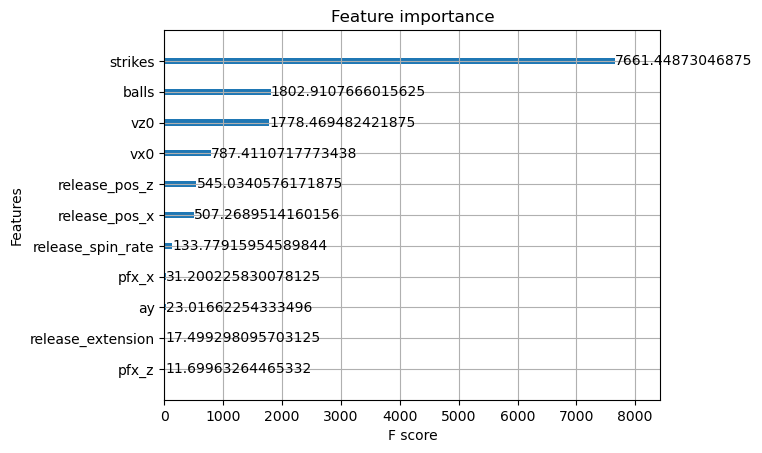

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23524\4232688072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xswing'] = y_pred


In [ ]:
testing_identifiers.head()

pitch_id_raw    xswing
0  663364_455139_617228_4_75_10  0.487515
1  663364_455139_617228_3_75_10  0.475990
2  663364_455139_617228_2_75_10  0.476085
3  663364_455139_617228_1_75_10  0.467522
5  663364_593428_605347_4_72_10  0.466248

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/swing_2022&3_xswing.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


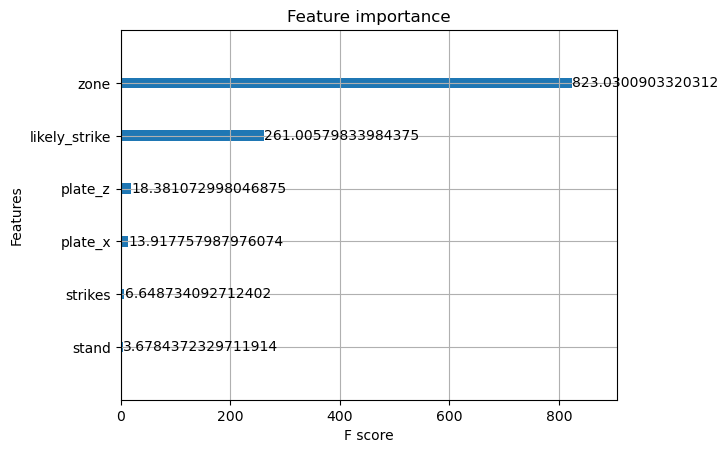

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

half_inning  Unnamed: 1 pitch_type   game_date  release_speed  \
1   716352_1_Bot           8         SI  2023-10-01           93.5   
11  716352_2_Bot          46         FF  2023-10-01           93.5   
28  716352_4_Bot         111         FF  2023-10-01           92.9   
37  716352_4_Bot          87         SI  2023-10-01           92.2   
39  716352_4_Top         115         SI  2023-10-01           90.1   

    release_pos_x  release_pos_z    player_name  batter  pitcher  ...  \
1           -2.60           5.68  King, Michael  677951   650633  ...   
11          -2.82           5.71  King, Michael  669004   650633  ...   
28          -2.66           5.89  King, Michael  669004   650633  ...   
37          -2.76           5.67  King, Michael  672580   650633  ...   
39          -1.27           6.14  Greinke, Zack  643396   425844  ...   

     deltaRE is_strike  pitch_type_dict  likely_strike  prediction  \
1  -0.028510         1              1.0              0    0.781290   
11 -0.038179         1              1.0              0    0.495411   
28 -0.038179         1              1.0              0    0.782323   
37 -0.111258         1              1.0              0    0.813712   
39 -0.043952         1              1.0              0    0.584764   

    probability_added  Unnamed: 0  mlb_id        mlb_name  team_name  
1            0.218710        4412  669224    Austin Wells    yankees  
11           0.504589        4412  669224    Austin Wells    yankees  
28           0.217677        4412  669224    Austin Wells    yankees  
37           0.186288        4412  669224    Austin Wells    yankees  
39           0.415236        1898  521692  Salvador Perez     royals  

[5 rows x 113 columns]

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches